# Neurog Internship: (Task 11 - Making The Backtesting Function More Efficient And Fast. Also, Creating Custom Strategies For Signal Generation & Testing Them Using Our Backtesting Algorithm)

# All Libraries

In [1]:
# For Vizualization & Plotting
import matplotlib.pyplot as plt

# Technical Analysis Library Modules
from ta.momentum import AwesomeOscillatorIndicator
from ta.volume import OnBalanceVolumeIndicator
from ta.momentum import StochRSIIndicator
from ta.momentum import RSIIndicator
from ta.trend import PSARIndicator
from ta.trend import ADXIndicator
from ta.trend import SMAIndicator
from ta.trend import EMAIndicator

# Library To Save Model Pickle Files
import joblib

# Other Necessary Libraries
import pandas as pd
import numpy as np
import copy
import os

# All Declarations

In [2]:
# Define the relative path to the CSV file
csv_filename = "BTCUSDT_1_Minute_From_2020_Till_Now.csv"

# Settig Up The Directory From The Directory Hierarchy
# Get the notebook's current directory
notebook_dir = os.getcwd()

# Go up one level to the parent directory
parent_dir = os.path.abspath(os.path.join(notebook_dir, os.pardir))

# Create the full path to the output CSV file in the 'ohlc' directory within 'data'
data_dir = os.path.join(parent_dir, "data")
ohlc_dir = os.path.join(data_dir, "ohlc")
full_csv_path = os.path.join(ohlc_dir, csv_filename)

# All Functions

## Function To Save Models

In [3]:
def save_model(model, folder_name, filename):
    """
    Save a trained model to disk.
    
    Parameters:
    model (sklearn.base.BaseEstimator): The trained model to save.
    filename (str): The path where the model will be saved.
    """
    # Settig Up The Directory From The Directory Hierarchy
    # Get the notebook's current directory
    notebook_dir = os.getcwd()
    
    # Go up one level to the parent directory
    parent_dir = os.path.abspath(os.path.join(notebook_dir, os.pardir))
    
    # Go to the main data directory andgo to the models directory
    data_dir = os.path.join(parent_dir, "data")
    model_dir = os.path.join(data_dir, 'models')

    # Go to the 'folder_name' directory in the 'model' directory
    folder_name_dir = os.path.join(model_dir, folder_name)
    filename_file = os.path.join(folder_name_dir, filename)
    
    # Create directories if they don't exist
    os.makedirs(data_dir, exist_ok=True)
    os.makedirs(model_dir, exist_ok=True)
    os.makedirs(folder_name_dir, exist_ok=True)
    
    try:
        # Save the model to disk
        joblib.dump(model, filename_file)
        print(f"Model saved to {filename_file}")
    except Exception as e:
        print(f"Failed to save model. Error: {e}")

## Utility Functions

In [4]:
# Function to return the timeframe of the dataframe's index
def get_timeframe(df):
    """
    Returns the inferred timeframe (frequency) of the datetime index of a DataFrame.
    
    Parameters:
        df (pd.DataFrame): DataFrame with datetime index.
    
    Returns:
        str: Timeframe (frequency) of the datetime index, e.g., '4H', '1D'.
    """
    # Check if the index is datetime
    if not pd.api.types.is_datetime64_any_dtype(df.index):
        raise ValueError("DataFrame index must be datetime.")
    
    # Infer the frequency of the datetime index
    frequency = pd.infer_freq(df.index)

    if len(frequency) == 1:
        frequency = '1' + frequency
    
    if frequency is None:
        raise ValueError("Unable to infer the frequency of the datetime index.")
    
    return frequency

# Function that extracts previous 'N' times data from the latest data
def get_past_data(df, period, timeframe):
    """
    Returns data from the past specified period and aligns the start and end dates with the given timeframe.
    
    Parameters:
        df (pd.DataFrame): DataFrame with datetime index.
        period (str): Period string, e.g., '1Y' for one year, '1M' for one month.
        timeframe (str): Timeframe string, e.g., '1M' for one month, '4H' for four hours, '15T' for fifteen minutes.
    
    Returns:
        pd.DataFrame: DataFrame filtered by the specified period and aligned with the timeframe.
    """
    # Check if the index is datetime
    if not pd.api.types.is_datetime64_any_dtype(df.index):
        raise ValueError("DataFrame index must be datetime.")
    
    # Mapping period strings to DateOffset arguments
    period_mapping = {
        'Y': 'years',
        'M': 'months',
        'W': 'weeks',
        'D': 'days',
        'H': 'hours',
        'T': 'minutes'
    }
    
    # Extract the time unit and quantity for the period
    period_unit = period[-1]
    period_quantity = int(period[:-1])
    
    # Get the corresponding DateOffset argument for the period
    if period_unit not in period_mapping:
        raise ValueError("Invalid period format. Use formats like '1Y', '1M', '1W', '1D', etc.")
    
    period_offset_arg = period_mapping[period_unit]
    period_offset = pd.DateOffset(**{period_offset_arg: period_quantity})
    
    # Get the last date in the DataFrame
    last_date = df.index[-1]
    
    # Calculate the start date
    start_date = last_date - period_offset
    
    # Align start_date to the nearest preceding datetime divisible by the timeframe
    freq = pd.tseries.frequencies.to_offset(timeframe)
    aligned_start_date = start_date.floor(freq)
    
    # Align end_date to the nearest preceding datetime divisible by the timeframe
    aligned_end_date = last_date.floor(freq)
    
    # Filter the DataFrame for the desired date range
    filtered_df_last = df[(df.index >= aligned_start_date) & (df.index <= aligned_end_date)]
    filtered_df_first = df[(df.index < aligned_start_date)]
    
    return filtered_df_first, filtered_df_last

## (Function To Convert DF To Any Timeframe) - Taken From The Previous Day

In [5]:
# Functions converts the dataframe into any given time frame.
def convert_1m_to_any_timeframe(df: pd.DataFrame, timeframe: str) -> pd.DataFrame:
    """
    Convert a DataFrame of 1-minute OHLC data to any given timeframe.

    Args:
    - df (pd.DataFrame): DataFrame containing 1-minute OHLC data. 
      The DataFrame should have a datetime index & columns ['Open', 'High', 'Low', 'Close', 'Volume'].
    - timeframe (str): The desired timeframe to resample the data to (e.g., '1H' for 1 hour, '1D' for 1 day).

    Returns:
    - pd.DataFrame: Resampled DataFrame with OHLC data in the specified timeframe. The index will be renamed to
      reflect the new timeframe.

    Example:
    ```
    resampled_df = convert_1m_to_any_timeframe(ohlc_df, '1H')
    ```
    """
    # Ensure the DataFrame index is of datetime type
    df.index = pd.to_datetime(df.index)
    
    # Try resampling the data to the desired timeframe
    try:
        df_resampled = df.resample(timeframe).agg({
            'Open': 'first',  # Take the first 'Open' value in the timeframe
            'High': 'max',    # Take the maximum 'High' value in the timeframe
            'Low': 'min',     # Take the minimum 'Low' value in the timeframe
            'Close': 'last',  # Take the last 'Close' value in the timeframe
            'Volume': 'mean'  # Take the mean 'Volume' value in the timeframe
        })
    except Exception as e:
        print(f"An error occurred while resampling! Error message: {e}")
        return pd.DataFrame()  # Return an empty DataFrame in case of error

    # Rename the index to reflect the new timeframe
    df_resampled.index.rename(f'Open time ({timeframe})', inplace = True)
    
    return df_resampled

## MACD Indicator Function

In [6]:
def calculate_macd(df: pd.DataFrame, short_window: int = 12, long_window: int = 26, signal_window: int = 9) -> pd.DataFrame:
    """
    Calculate the MACD (Moving Average Convergence Divergence) for a given DataFrame.

    Args:
    - df (pd.DataFrame): DataFrame containing 'Close' price data.
    - short_window (int): The window size for the short-term EMA, default is 12.
    - long_window (int): The window size for the long-term EMA, default is 26.
    - signal_window (int): The window size for the Signal line, default is 9.

    Returns:
    - pd.DataFrame: DataFrame with the MACD line and Signal line.
    """
    # Calculate the short-term and long-term EMAs
    df['EMA_12'] = df['Close'].ewm(span=short_window, adjust=False).mean()
    df['EMA_26'] = df['Close'].ewm(span=long_window, adjust=False).mean()

    # Calculate the MACD line
    df['MACD'] = df['EMA_12'] - df['EMA_26']

    # Calculate the Signal line
    df['Signal_Line'] = df['MACD'].ewm(span=signal_window, adjust=False).mean()

    return df

def generate_macd_signals(df: pd.DataFrame) -> pd.DataFrame:
    """
    Generate trading signals based on MACD values.

    Args:
    - df (pd.DataFrame): DataFrame containing 'MACD' and 'Signal_Line' values.

    Returns:
    - pd.DataFrame: DataFrame with trading signals.
    """
    df['Signal'] = 0  # Default no signal
    df.loc[df['MACD'] > df['Signal_Line'], 'Signal'] = 1  # Buy signal
    df.loc[df['MACD'] < df['Signal_Line'], 'Signal'] = -1  # Sell signal

    return df

## ADX In Combination With Parabolic SAR Indicator Function

In [7]:
def calculate_adx(df: pd.DataFrame, window: int = 14) -> pd.DataFrame:
    """
    Calculate the Average Directional Index (ADX) and add it to the DataFrame.
    
    Args:
    - df (pd.DataFrame): DataFrame containing 'High', 'Low', and 'Close' columns.
    - window (int): Window size for the ADX calculation (default is 14).
    
    Returns:
    - df (pd.DataFrame): DataFrame with added 'ADX' column.
    """
    adx = ADXIndicator(df['High'], df['Low'], df['Close'], window=window)
    df['ADX'] = adx.adx()
    df['DI+'] = adx.adx_pos()
    df['DI-'] = adx.adx_neg()
    return df

def calculate_parabolic_sar(df: pd.DataFrame) -> pd.DataFrame:
    """
    Calculate the Parabolic SAR and add it to the DataFrame.
    
    Args:
    - df (pd.DataFrame): DataFrame containing 'High', 'Low', and 'Close' columns.
    
    Returns:
    - df (pd.DataFrame): DataFrame with added 'Parabolic_SAR' column.
    """
    psar = PSARIndicator(df['High'], df['Low'], df['Close'])
    df['Parabolic_SAR'] = psar.psar()
    return df

def generate_adx_parabolic_sar_signals(df: pd.DataFrame, adx_threshold: float = 25) -> pd.DataFrame:
    """
    Generate trading signals based on ADX and Parabolic SAR.

    Args:
    - df (pd.DataFrame): DataFrame containing 'ADX' and 'Parabolic_SAR' columns.
    - adx_threshold (float): Threshold for ADX to consider a strong trend (default is 25).

    Returns:
    - df (pd.DataFrame): DataFrame with added 'Signal' column (1 for buy, -1 for sell, 0 for hold).
    """
    df['Signal'] = 0  # Default to hold
    df.loc[(df['ADX'] > adx_threshold) & (df['Close'] > df['Parabolic_SAR']), 'Signal'] = 1  # Buy signal
    df.loc[(df['ADX'] > adx_threshold) & (df['Close'] < df['Parabolic_SAR']), 'Signal'] = -1  # Sell signal
    return df

## RSI Indicator Function

In [8]:
def calculate_rsi(df: pd.DataFrame, window: int = 14) -> pd.DataFrame:
    """
    Calculate the Relative Strength Index (RSI) using the ta library.

    Args:
    - df (pd.DataFrame): DataFrame containing 'Close' price data.
    - window (int): The window size for calculating RSI, default is 14.

    Returns:
    - pd.DataFrame: DataFrame with the RSI values.
    """
    # Calculate RSI using ta library
    rsi_indicator = RSIIndicator(close=df['Close'], window=window, fillna=True)
    df['RSI'] = rsi_indicator.rsi()

    return df

def generate_rsi_signals(df: pd.DataFrame, rsi_lower: int = 30, rsi_upper: int = 70) -> pd.DataFrame:
    """
    Generate trading signals based on RSI values.

    Args:
    - df (pd.DataFrame): DataFrame containing 'RSI' values.
    - rsi_lower (int): RSI lower threshold for buy signals, default is 30.
    - rsi_upper (int): RSI upper threshold for sell signals, default is 70.

    Returns:
    - pd.DataFrame: DataFrame with trading signals.
    """
    df['Signal'] = 0  # Default no signal
    df.loc[df['RSI'] > rsi_upper, 'Signal'] = -1  # Sell signal
    df.loc[df['RSI'] < rsi_lower, 'Signal'] = 1   # Buy signal

    return df

## Stochastic RSI Indicator Function

In [9]:
def calculate_stochrsi(
    df: pd.DataFrame,
    window: int = 14,
    smooth1: int = 3,
    smooth2: int = 3,
    fillna: bool = False,
) -> pd.DataFrame:
    """
    Calculate the Stochastic RSI (STOCHRSI) for a given DataFrame using the ta library.

    Args:
    - df (pd.DataFrame): DataFrame containing 'Close' price data.
    - window (int): The window size for calculating RSI, default is 14.
    - smooth1 (int): The window size for the first smoothing, default is 3.
    - smooth2 (int): The window size for the second smoothing, default is 3.
    - fillna (bool): The paramter to specify whether to fill NaN values or not.

    Returns:
    - df (pd.DataFrame): DataFrame with the Stochastic RSI values.
    """

    # Calculate Stochastic RSI
    stoch_rsi = StochRSIIndicator(
        close=df['Close'],
        window = window,
        smooth1 = smooth1,
        smooth2 = smooth2,
        fillna = fillna
    )

    # Add Stochastic RSI values to the DataFrame
    df['StochRSI'] = stoch_rsi.stochrsi()
    
    df['StochRSI_K'] = stoch_rsi.stochrsi_k() * 100
    df['StochRSI_D'] = stoch_rsi.stochrsi_d() * 100

    return df

def generate_stochrsi_signals(
    df: pd.DataFrame,
    stochrsi_upper: int = 0.7,
    stochrsi_lower: int = 0.3,
) -> pd.DataFrame:
    """
    Calculate the Stochastic RSI (STOCHRSI) and generate buy/sell signals for a given DataFrame.

    Args:
    - df (pd.DataFrame): DataFrame containing 'Close' price data.
    - window (int): The window size for calculating RSI, default is 14.
    - smooth1 (int): The window size for the first smoothing, default is 3.
    - smooth2 (int): The window size for the second smoothing, default is 3.
    - fillna (bool): The parameter to specify whether to fill NaN values or not.

    Returns:
    - df (pd.DataFrame): DataFrame with the Stochastic RSI values and signals.
    """
    # Generate signals
    df['Signal'] = 0
    df['Signal'] = np.where((df['StochRSI'].shift(1) < 0.2) & (df['StochRSI'] >= 0.2), 1, df['Signal'])  # Buy signal
    df['Signal'] = np.where((df['StochRSI'].shift(1) > 0.8) & (df['StochRSI'] <= 0.8), -1, df['Signal'])  # Sell signal

    return df

## OBV Indicator Function

In [10]:
# def generate_obv_signals(df: pd.DataFrame) -> pd.DataFrame:
#     """
#     Generate trading signals based on On-Balance Volume (OBV) indicator.

#     Args:
#     - df (pd.DataFrame): DataFrame containing 'Close' and 'Volume' columns.

#     Returns:
#     - df (pd.DataFrame): DataFrame with added 'OBV' and 'Signal' columns.
#     """
#     df['OBV'] = 0.0  # Initialize OBV column with zeros
#     df['Signal'] = 0  # Initialize Signal column with zeros

#     # Calculate OBV values
#     for i in range(1, len(df)):
#         if df['Close'].iloc[i] > df['Close'].iloc[i - 1]:
#             df.loc[df.index[i], 'OBV'] = df['OBV'].iloc[i - 1] + df['Volume'].iloc[i]
#         elif df['Close'].iloc[i] < df['Close'].iloc[i - 1]:
#             df.loc[df.index[i], 'OBV'] = df['OBV'].iloc[i - 1] - df['Volume'].iloc[i]
#         else:
#             df.loc[df.index[i], 'OBV'] = df['OBV'].iloc[i - 1]

#     # Generate signals based on OBV
#     df.loc[df['OBV'] > df['OBV'].shift(1), 'Signal'] = 1  # Buy signal
#     df.loc[df['OBV'] < df['OBV'].shift(1), 'Signal'] = -1  # Sell signal

#     return df

def calculate_obv(df: pd.DataFrame, fillna: bool = False) -> pd.DataFrame:
    """
    Generate On-Balance Volume (OBV) Values.

    Args:
    - df (pd.DataFrame): DataFrame containing 'Close' and 'Volume' columns.
    - fillna (bool): Parameter that specifies whether or not to fill NaN values.

    Returns:
    - df (pd.DataFrame): DataFrame with added 'OBV' column.
    """
    obv = OnBalanceVolumeIndicator(
        close = df['Close'],
        volume = df['Volume'],
        fillna = True
    )
    
    df['OBV'] = obv.on_balance_volume()

    return df


def generate_obv_signals(df: pd.DataFrame) -> pd.DataFrame:
    """
    Generate trading signals based on On-Balance Volume (OBV) indicator.

    Args:
    - df (pd.DataFrame): DataFrame containing 'Close' and 'Volume' columns.
    - fillna (bool): Parameter that specifies whether or not to fill NaN values.

    Returns:
    - df (pd.DataFrame): DataFrame with added 'OBV' and 'Signal' columns.
    """
    df['Signal'] = 0  # Initialize Signal column
    
    # Generate signals based on OBV
    df.loc[df['OBV'] > df['OBV'].shift(1), 'Signal'] = 1  # Buy signal
    df.loc[df['OBV'] < df['OBV'].shift(1), 'Signal'] = -1  # Sell signal

    return df

## Simple Moving Average (SMA) Indicator Function

In [11]:
def calculate_sma(
    df: pd.DataFrame, 
    window: int, 
    source: str = 'Close', 
    offset: int = 0,
    fillna: bool = False
) -> pd.DataFrame:
    """
    Calculate the Simple Moving Average (SMA) for a given DataFrame with additional parameters.

    Args:
    - df (pd.DataFrame): DataFrame containing price data.
    - window (int): The window size for calculating SMA.
    - source (str): The column name on which to calculate the SMA, default is 'Close'.
    - offset (int): The number of periods to offset the SMA, default is 0.

    Returns:
    - df (pd.DataFrame): DataFrame with the SMA values.
    """
    sma_indicator = SMAIndicator(close = df[source], window = window, fillna = fillna)
    df[f'SMA_{window}'] = sma_indicator.sma_indicator()

    if offset != 0:
        df[f'SMA_{window}'] = df[f'SMA_{window}'].shift(offset)
    
    return df

def generate_sma_signals(
    df: pd.DataFrame, 
    short_window: int = 50, 
    long_window: int = 200
) -> pd.DataFrame:
    """
    Generate trading signals based on Simple Moving Average (SMA) crossover strategy.

    Args:
    - df (pd.DataFrame): DataFrame containing price data with SMA values.
    - short_window (int): The window size for the short-term SMA, default is 50.
    - long_window (int): The window size for the long-term SMA, default is 200.

    Returns:
    - pd.DataFrame: DataFrame with trading signals.
    """
    # Calculate short-term and long-term SMAs
    df = calculate_sma(df, window=short_window, source='Close')
    df = calculate_sma(df, window=long_window, source='Close')
    
    # Generate signals: 
    # Buy when the short-term SMA crosses above the long-term SMA
    # Sell when the short-term SMA crosses below the long-term SMA
    df['Signal'] = 0  # Default no signal
    df.loc[df[f'SMA_{short_window}'] > df[f'SMA_{long_window}'], 'Signal'] = 1   # Buy signal
    df.loc[df[f'SMA_{short_window}'] < df[f'SMA_{long_window}'], 'Signal'] = -1  # Sell signal

    return df

## Exponential Moving Average (EMA) Indicator Function

In [12]:
def calculate_ema(
    df: pd.DataFrame, 
    window: int, 
    source: str = 'Close', 
    offset: int = 0, 
    fillna: bool = False,
    smoothing_line: str = 'ema', 
    smoothing_length: int = None
) -> pd.DataFrame:
    """
    Calculate the Exponential Moving Average (EMA) for a given DataFrame with additional parameters.

    Args:
    - df (pd.DataFrame): DataFrame containing price data.
    - window (int): The window size for calculating EMA.
    - source (str): The column name on which to calculate the EMA, default is 'Close'.
    - offset (int): The number of periods to offset the EMA, default is 0.
    - smoothing_line (str): The type of smoothing line, default is 'ema' (only EMA supported in this function).
    - smoothing_length (int): The window size for additional smoothing, not used in this function. Will implement later
    - fillna (bool): The parameter to specifiy if NaN values are to be filled or not

    Returns:
    - df (pd.DataFrame): DataFrame with the EMA values.
    """
    if smoothing_line != 'ema':
        raise ValueError("Only 'ema' smoothing is supported in this function.")
    
    ema_indicator = EMAIndicator(close = df[source], window = window, fillna = fillna)
    df[f'EMA_{window}'] = ema_indicator.ema_indicator()

    if offset != 0:
        df[f'EMA_{window}'] = df[f'EMA_{window}'].shift(offset)
    
    return df

def generate_triple_ema_signals(
    df: pd.DataFrame, 
    short_window: int = 5, 
    medium_window: int = 21, 
    long_window: int = 50,
    source: str = 'Close'
) -> pd.DataFrame:
    """
    Generate trading signals based on the Triple EMA Crossover strategy.

    Args:
    - df (pd.DataFrame): DataFrame containing price data.
    - short_window (int): The window size for the short-term EMA.
    - medium_window (int): The window size for the medium-term EMA.
    - long_window (int): The window size for the long-term EMA.
    - source (str): The column name on which to calculate the EMAs, default is 'Close'.

    Returns:
    - pd.DataFrame: DataFrame with trading signals.
    """
    # Calculate short-term, medium-term, and long-term EMAs
    df = calculate_ema(df, short_window, source)
    df = calculate_ema(df, medium_window, source)
    df = calculate_ema(df, long_window, source)

    # Initialize signal column
    df['Signal'] = 0

    # Buy signal: Short EMA crosses above both Medium and Long EMAs
    df.loc[(df[f'EMA_{short_window}'] > df[f'EMA_{medium_window}']) & (df[f'EMA_{short_window}'] > df[f'EMA_{long_window}']), 'Signal'] = 1

    # Sell signal: Short EMA crosses below both Medium and Long EMAs
    df.loc[(df[f'EMA_{short_window}'] < df[f'EMA_{medium_window}']) & (df[f'EMA_{short_window}'] < df[f'EMA_{long_window}']), 'Signal'] = -1

    return df

## Smoothing Moving Average (SMMA) Indicator Function

In [13]:
def calculate_smma(
    df: pd.DataFrame, 
    window: int, 
    source: str = 'Close', 
    offset: int = 0
) -> pd.DataFrame:
    """
    Calculate the Smoothed Moving Average (SMMA) for a given DataFrame with additional parameters.

    Args:
    - df (pd.DataFrame): DataFrame containing price data.
    - window (int): The window size for calculating SMMA.
    - source (str): The column name on which to calculate the SMMA, default is 'Close'.
    - offset (int): The number of periods to offset the SMMA, default is 0.

    Returns:
    - df (pd.DataFrame): DataFrame with the SMMA values.
    """
    # Initialize SMMA column
    df['SMMA'] = 0.0

    # Calculate initial SMMA values (SMA for the first window periods)
    df['SUM1'] = df[source].rolling(window=window, min_periods=1).sum()
    df.loc[df.index[window - 1], 'SMMA'] = df['SUM1'].iloc[window - 1] / window

    # Calculate subsequent SMMA values using the iterative formula
    for i in range(window, len(df)):
        prev_smma = df.loc[df.index[i - 1], 'SMMA']
        current_price = df.loc[df.index[i], source]
        df.loc[df.index[i], 'SMMA'] = (prev_smma * (window - 1) + current_price) / window

    # Drop intermediate columns if not needed
    df.drop(['SUM1'], axis=1, inplace=True)

    return df

def generate_smma_signals(
    df: pd.DataFrame, 
    window: int = 14, 
    source: str = 'Close'
) -> pd.DataFrame:
    """
    Generate trading signals based on the Smoothed Moving Average (SMMA) crossover strategy.

    Args:
    - df (pd.DataFrame): DataFrame containing price data.
    - window (int): The window size for calculating SMMA.
    - source (str): The column name on which to calculate the SMMA, default is 'Close'.

    Returns:
    - pd.DataFrame: DataFrame with trading signals.
    """
    # Calculate SMMA
    df = calculate_smma(df, window, source)

    # Initialize signal column
    df['Signal'] = 0

    # Buy signal: When price crosses above SMMA
    df.loc[df[source] > df['SMMA'], 'Signal'] = 1

    # Sell signal: When price crosses below SMMA
    df.loc[df[source] < df['SMMA'], 'Signal'] = -1

    return df

## Volume Weighted Moving Average (VWMA) Indicator Function

In [14]:
def calculate_vwma(df: pd.DataFrame, window: int = 14) -> pd.DataFrame:
    """
    Calculate the Volume Weighted Moving Average (VWMA) for a given DataFrame.

    Args:
    - df (pd.DataFrame): DataFrame containing price data and volume.
    - window (int): The window size for calculating VWMA.

    Returns:
    - pd.DataFrame: DataFrame with the VWMA values.
    """
    df['PriceVolume'] = df['Close'] * df['Volume']
    df['CumulativePriceVolume'] = df['PriceVolume'].rolling(window=window, min_periods=1).sum()
    df['CumulativeVolume'] = df['Volume'].rolling(window=window, min_periods=1).sum()
    df[f'VWMA_{window}'] = df['CumulativePriceVolume'] / df['CumulativeVolume']

    # Drop intermediate columns if not needed
    df.drop(['PriceVolume', 'CumulativePriceVolume', 'CumulativeVolume'], axis=1, inplace=True)
    
    return df

def generate_vwma_signals(df: pd.DataFrame, short_window: int = 10, long_window: int = 50) -> pd.DataFrame:
    """
    Generate trading signals based on VWMA crossover strategy.

    Args:
    - df (pd.DataFrame): DataFrame containing price data and volume.
    - short_window (int): Window size for short-term VWMA.
    - long_window (int): Window size for long-term VWMA.

    Returns:
    - pd.DataFrame: DataFrame with VWMA values and trading signals.
    """
    # Calculate short-term VWMA
    df = calculate_vwma(df, window=short_window)
    df.rename(columns={f'VWMA_{short_window}': 'VWMA_Short'}, inplace=True)

    # Calculate long-term VWMA
    df = calculate_vwma(df, window=long_window)
    df.rename(columns={f'VWMA_{long_window}': 'VWMA_Long'}, inplace=True)

    # Generate trading signals
    df['Signal'] = 0
    df['Signal'] = df.apply(lambda row: 1 if row['VWMA_Short'] > row['VWMA_Long'] else (-1 if row['VWMA_Short'] < row['VWMA_Long'] else 0), axis=1)

    return df

## Awesome Oscillator Indicator Function

In [15]:
def calculate_AO(df: pd.DataFrame, fillna: bool = False) -> pd.DataFrame:
    """
    Generate On-Balance Volume (OBV) Values.

    Args:
    - df (pd.DataFrame): DataFrame containing 'Close' and 'Volume' columns.
    - fillna (bool): Parameter that specifies whether or not to fill NaN values.

    Returns:
    - df (pd.DataFrame): DataFrame with added 'OBV' column.
    """
    obv = AwesomeOscillatorIndicator(
        high = df['High'],
        low = df['Low'],
        fillna = True
    )
    
    df['AO'] = obv.awesome_oscillator()

    return df


def generate_AO_signals(df: pd.DataFrame) -> pd.DataFrame:
    """
    Generate trading signals based on Awesome Oscillator (AO) values.

    Args:
    - df (pd.DataFrame): DataFrame containing 'AO' column. Should have a datetime index.

    Returns:
    - df (pd.DataFrame): DataFrame with added 'Signal' column indicating Buy (1), Sell (-1), or Hold (0) signals.
    """
    # Initialize Signal column with zeros
    df['Signal'] = 0
    
    # Generate signals based on AO
    for i in range(1, len(df)):
        if df['AO'].iloc[i] > 0 and df['AO'].iloc[i-1] <= 0:
            df.at[df.index[i], 'Signal'] = 1  # Buy signal
        elif df['AO'].iloc[i] < 0 and df['AO'].iloc[i-1] >= 0:
            df.at[df.index[i], 'Signal'] = -1  # Sell signal
    
    return df

## Backtesting Function: Previous Week's Final

In [16]:
def generate_backtest_df(data, data_1m, initial_balance=1000, transaction_fee=0.01):
    """
    Generate a backtesting DataFrame based on MACD signals.

    Args:
        data (pd.DataFrame): DataFrame containing historical data with columns:
                             'Open time (4H)', 'Open', 'High', 'Low', 'Close', 'Volume', 'MACD_Signal'.
                             The DataFrame must have 'Open time (4H)' as a DateTime index.
        data_1m (pd.DataFrame): DataFrame containing 1-minute interval data with 'Open' prices.
        initial_balance (float): Initial balance for the backtest.
        transaction_fee (float): Transaction fee as a percentage of the current balance for each trade.

    Returns:
        pd.DataFrame: A DataFrame containing the backtesting results with columns:
                      'Open time (4H)', 'direction', 'entry price', 'close price', 'PNL', 'Balance'.
    """
    
    def find_first_change(signal):
        # Convert the list to a numpy array
        signal_array = np.array(signal)

        # Find indices of non-zero elements
        non_zero_indices = np.flatnonzero(signal_array != 0)

        # Find where the value changes
        changes = np.where(np.diff(signal_array[non_zero_indices]))[0] + 1
        changes = np.insert(changes, 0, 0)
        
        if len(non_zero_indices) < 1:
            return signal.index[0], signal.index[-1]

        if len(changes) == 1:
            # Get the indices of the first change
            first_change_start = non_zero_indices[changes[0]]
            first_change_end = len(signal) - 1
        else:
            # Get the indices of the first change
            first_change_start = non_zero_indices[changes[0]]
            first_change_end = non_zero_indices[changes[0 + 1]]
        
        # Get the starting and ending time of the direction change
        trade_start_time = signal.index[first_change_start]
        trade_end_time = signal.index[first_change_end]

        # Return the start and end time tuple
        return (trade_start_time, trade_end_time)
    
    # For index name
    index_name = data.index.name

    # For timeframe
    time_frame = pd.infer_freq(data.index)

    # If timeframe is like 'H' or 'D' or 'Y' then append 1 for specificity
    if len(time_frame) == 1:
        time_frame = '1' + time_frame

    # Extract necessary columns as numpy arrays
    high_prices_1m = data_1m['High']
    low_prices_1m = data_1m['Low']
    open_prices_1m = data_1m['Open']
    open_prices = data['Open']
    signals = data['Signal']
    
    # Initialize the exit indices for tp or sl hit (takes the lowest: which happened first)
    exit_index_tp = None
    exit_index_sl = None
    
    # Initialize the backtest results array
    backtest_data = []

    # Initialize trade parameters
    tp = 0.05  # 5% take profit
    sl = 0.03  # 3% stop loss
    
    # Initialize the balance
    balance = initial_balance
    
    # Get last date
    last_date = signals.index[-1]
    
    # Initializing List To Store Directions For The Trade
    directions = []
    
    # Iterate
    while(True):
        trade_start_time, trade_end_time = find_first_change(signals)
            
        direction_start = 'long' if signals[trade_start_time] == 1 else 'short'
        direction_end = 'long' if signals[trade_end_time] == 1 else 'short'
        entry_price = open_prices[trade_start_time]
        
        # Calculate take profit and stop loss prices
        if direction_start == 'long':
            tp_price = entry_price * (1 + tp)
            sl_price = entry_price * (1 - sl)
        else:
            tp_price = entry_price * (1 - tp)
            sl_price = entry_price * (1 + sl)
        
        # Find the exit point for the trade
        exit_index = None
        action = 'direction'  # Default action is direction change
        
        # getting to the closest time of that interval
        # Assuming trade_end_time is a datetime object
        # Basically doing this, so the tp and sl hit only checks and
        # compares from the (T + 1)th time till the trade end time.
        trade_start_time_matching = pd.to_datetime(trade_start_time)
        add_minute = pd.Timedelta('1m')
        trade_start_time_matching = trade_start_time_matching + add_minute
        
        if direction_start == 'long':
            tp_hit = np.where(high_prices_1m[trade_start_time_matching:trade_end_time] >= tp_price)[0]
            sl_hit = np.where(low_prices_1m[trade_start_time_matching:trade_end_time] <= sl_price)[0]
        else:
            tp_hit = np.where(low_prices_1m[trade_start_time_matching:trade_end_time] <= tp_price)[0]
            sl_hit = np.where(high_prices_1m[trade_start_time_matching:trade_end_time] >= sl_price)[0]

        if len(tp_hit) > 0:
            exit_index = tp_hit[0]
            action = 'tp'
        if len(sl_hit) > 0 and (len(tp_hit) == 0 or sl_hit[0] < tp_hit[0]):
            exit_index = sl_hit[0]
            action = 'sl'
            
        if action == 'direction':
            close_price = open_prices[trade_end_time]
        else:
            if action == 'tp':
                if direction_start == 'long':
                    trade_end_time = high_prices_1m[trade_start_time_matching:trade_end_time].index[exit_index]
                    close_price = high_prices_1m[trade_end_time]
                else:
                    trade_end_time = low_prices_1m[trade_start_time_matching:trade_end_time].index[exit_index]
                    close_price = low_prices_1m[trade_end_time]
            else:
                if direction_start == 'long':
                    trade_end_time = low_prices_1m[trade_start_time_matching:trade_end_time].index[exit_index]
                    close_price = low_prices_1m[trade_end_time]
                else:
                    trade_end_time = high_prices_1m[trade_start_time_matching:trade_end_time].index[exit_index]
                    close_price = high_prices_1m[trade_end_time]
                    
            if len(directions) != 0:
                direction_end = directions[-1]
                direction_start = directions[-1]
        
        # Record the trade entry and exit
        backtest_data.append([trade_start_time, direction_start, entry_price, 0, None])
        backtest_data.append([trade_end_time, direction_end, entry_price, close_price, action])
            
        # getting to the closest time of that interval
        # Assuming trade_end_time is a datetime object
        trade_end_time = pd.to_datetime(trade_end_time)

        # Define the time format
        time_format = pd.Timedelta(time_frame)

        # Calculate the remainder when trade_end_time is divided by time_format
        remainder = trade_end_time.to_numpy().astype('datetime64[ns]').astype(np.int64) % time_format.to_numpy().astype('timedelta64[ns]').astype(np.int64)

        # If remainder is not zero, round up to the next multiple of time_format
        if remainder != 0:
            trade_end_time = trade_end_time + (time_format - pd.Timedelta(remainder, unit='ns'))
            
        # This is the condition that would end the loop (else it would run infinitely)
        if trade_end_time >= last_date:
            break
            
        signals = signals[trade_end_time:]
        
        directions.append(direction_start)
        directions.append(direction_end)

    backtest_df = pd.DataFrame(backtest_data, columns=[index_name, 'direction', 'entry price', 'close price', 'action'])

    # Calculate PNL using vectorized operations
    entry_prices = backtest_df['entry price'][1::2].values
    close_prices = backtest_df['close price'][1::2].values
    directions = backtest_df['direction'][0:-1:2].values

    pnl = np.where(directions == 'long',
                   ((close_prices - entry_prices) / entry_prices) * 100,
                   ((entry_prices - close_prices) / entry_prices) * 100)

    # Insert the PNL values back into the DataFrame
    backtest_df.loc[1::2, 'PNL'] = pnl

    # Update balance considering PNL and transaction fees
    balances = [initial_balance]
    for pnl_value in pnl:
        transaction_cost = balances[-1] * (transaction_fee / 100)
        new_balance = balances[-1] + (np.abs(balances[-1]) * (pnl_value / 100)) - transaction_cost
        balances.append(new_balance)
    
    # Insert the balance values back into the DataFrame
    backtest_df['Balance'] = pd.Series(np.repeat(balances[1:], 2)[:len(backtest_df)])

    return backtest_df

# Main

### Reading The Previously Saved Data For BTCUSDT

In [17]:
BTCUSDT_Filtered_data_1M = pd.read_csv(full_csv_path, usecols = ['Open time (1M)', 'Open', 'High', 'Low', 'Close', 'Volume'])
BTCUSDT_Filtered_data_1M.set_index('Open time (1M)', inplace = True)

# Convert the index to datetime format
BTCUSDT_Filtered_data_1M.index = pd.to_datetime(BTCUSDT_Filtered_data_1M.index)

In [18]:
BTCUSDT_Filtered_data_1M

Open      High       Low     Close    Volume
Open time (1M)                                                       
2020-01-01 00:00:00   7169.71   7169.71   7165.44   7167.83  3509.860
2020-01-01 00:01:00   7167.83   7168.28   7158.66   7159.95  3821.170
2020-01-01 00:02:00   7161.03   7165.40   7161.03   7162.46  3041.710
2020-01-01 00:03:00   7161.74   7164.27   7160.30   7161.03  3682.650
2020-01-01 00:04:00   7161.03   7164.25   7160.15   7160.15  2936.690
...                       ...       ...       ...       ...       ...
2024-07-18 03:43:00  64280.10  64280.10  64280.10  64280.10     0.000
2024-07-18 03:44:00  64280.10  64438.20  64280.10  64280.10     1.505
2024-07-18 03:45:00  64438.20  64438.20  64280.10  64438.20     0.053
2024-07-18 03:46:00  64280.10  64438.00  64280.10  64280.20     1.544
2024-07-18 03:47:00  64280.20  64438.20  64280.20  64438.20     1.430

[2390628 rows x 5 columns]

## Generate Different Timeframe

### Converting 1 Minute Interval Data to 1 Hour Interval Data

In [19]:
BTCUSDT_Filtered_data_1H = convert_1m_to_any_timeframe(copy.deepcopy(BTCUSDT_Filtered_data_1M), '1h')
BTCUSDT_Filtered_data_1H

Open      High       Low     Close       Volume
Open time (1h)                                                          
2020-01-01 00:00:00   7169.71   7183.07   7156.65   7174.14  3200.843000
2020-01-01 01:00:00   7173.42   7186.36   7164.51   7175.44  3262.390850
2020-01-01 02:00:00   7175.44   7188.52   7168.78   7187.44  3616.975000
2020-01-01 03:00:00   7187.20   7207.23   7181.09   7202.48  3632.039517
2020-01-01 04:00:00   7202.48   7209.48   7184.34   7195.54  3505.551667
...                       ...       ...       ...       ...          ...
2024-07-17 23:00:00  64304.00  64776.00  64242.80  64603.20     1.988467
2024-07-18 00:00:00  64685.60  64776.00  64242.20  64603.40    10.850517
2024-07-18 01:00:00  64607.20  64776.00  64280.60  64689.00     1.539667
2024-07-18 02:00:00  64689.00  64775.20  64242.00  64280.00     6.615083
2024-07-18 03:00:00  64443.60  64689.00  63700.00  64438.20     7.722167

[39844 rows x 5 columns]

### Converting 1 Minute Interval Data to 4 Hour Interval Data

In [20]:
BTCUSDT_Filtered_data_4H = convert_1m_to_any_timeframe(copy.deepcopy(BTCUSDT_Filtered_data_1M), '4h')
BTCUSDT_Filtered_data_4H

Open      High       Low     Close         Volume
Open time (4h)                                                            
2020-01-01 00:00:00   7169.71   7207.23   7156.65   7202.48    3428.062092
2020-01-01 04:00:00   7202.48   9592.00   6871.45   7241.63  285722.475587
2020-01-01 08:00:00   7241.63   7243.46   7215.94   7223.72    3629.004242
2020-01-01 12:00:00   7223.71   7233.33   7178.00   7201.02    3491.032767
2020-01-01 16:00:00   7201.56   7236.58   7187.86   7220.85    3125.298729
...                       ...       ...       ...       ...            ...
2024-07-17 08:00:00  66196.50  66998.80  63555.00  65000.10       4.510771
2024-07-17 12:00:00  65000.10  66000.00  63555.00  65503.90       5.291817
2024-07-17 16:00:00  65446.30  66000.00  63892.40  64689.00       5.464083
2024-07-17 20:00:00  64669.70  64999.00  64240.00  64603.20       9.204992
2024-07-18 00:00:00  64685.60  64776.00  63700.00  64438.20       6.627105

[9961 rows x 5 columns]

### Converting 1 Minute Interval Data to 6 Hour Interval Data

In [21]:
BTCUSDT_Filtered_data_6H = convert_1m_to_any_timeframe(copy.deepcopy(BTCUSDT_Filtered_data_1M), '6h')
BTCUSDT_Filtered_data_6H

Open      High       Low     Close         Volume
Open time (6h)                                                            
2020-01-01 00:00:00   7169.71   9592.00   6871.45   7177.93  191774.969658
2020-01-01 06:00:00   7177.80   7243.46   7175.36   7223.72    3411.391622
2020-01-01 12:00:00   7223.71   7236.58   7178.00   7223.97    3348.273803
2020-01-01 18:00:00   7223.97   7253.21   7209.28   7242.21    3356.536042
2020-01-02 00:00:00   7242.21   7243.41   7177.13   7209.60    3546.966992
...                       ...       ...       ...       ...            ...
2024-07-17 00:00:00  64670.80  66670.80  64400.00  65576.00       6.780386
2024-07-17 06:00:00  65576.00  66999.90  63555.00  65000.10       6.377772
2024-07-17 12:00:00  65000.10  66000.00  63555.00  65188.60       4.659136
2024-07-17 18:00:00  65188.60  65188.60  63892.40  64603.20       8.648125
2024-07-18 00:00:00  64685.60  64776.00  63700.00  64438.20       6.627105

[6641 rows x 5 columns]

### Converting 1 Minute Interval Data to 8 Hour Interval Data

In [22]:
BTCUSDT_Filtered_data_8H = convert_1m_to_any_timeframe(copy.deepcopy(BTCUSDT_Filtered_data_1M), '8h')
BTCUSDT_Filtered_data_8H

Open      High       Low     Close         Volume
Open time (8h)                                                            
2020-01-01 00:00:00   7169.71   9592.00   6871.45   7241.63  144575.268840
2020-01-01 08:00:00   7241.63   7243.46   7178.00   7201.02    3560.018504
2020-01-01 16:00:00   7201.56   7253.21   7187.86   7242.21    3283.091000
2020-01-02 00:00:00   7242.21   7243.41   7155.02   7169.51    3501.885115
2020-01-02 08:00:00   7169.51   7181.53   7105.17   7160.60    3373.464144
...                       ...       ...       ...       ...            ...
2024-07-16 16:00:00  63470.80  74499.00  56820.20  64647.40      34.055148
2024-07-17 00:00:00  64670.80  66999.90  64400.00  66196.50       7.613233
2024-07-17 08:00:00  66196.50  66998.80  63555.00  65503.90       4.901294
2024-07-17 16:00:00  65446.30  66000.00  63892.40  64603.20       7.334537
2024-07-18 00:00:00  64685.60  64776.00  63700.00  64438.20       6.627105

[4981 rows x 5 columns]

### Converting 1 Minute Interval Data to 12 Hour Interval Data

In [23]:
BTCUSDT_Filtered_data_12H = convert_1m_to_any_timeframe(copy.deepcopy(BTCUSDT_Filtered_data_1M), '12h')
BTCUSDT_Filtered_data_12H

Open      High       Low     Close        Volume
Open time (12h)                                                          
2020-01-01 00:00:00   7169.71   9592.00   6871.45   7223.72  97593.180640
2020-01-01 12:00:00   7223.71   7253.21   7178.00   7242.21   3352.404922
2020-01-02 00:00:00   7242.21   7243.41   7116.48   7134.87   3496.369451
2020-01-02 12:00:00   7135.52   7181.53   6934.53   6975.70   3200.871275
2020-01-03 00:00:00   6975.70   7258.41   6871.45   7201.75   3645.067757
...                       ...       ...       ...       ...           ...
2024-07-16 00:00:00  62977.50  63640.00  62628.00  63009.10      6.714229
2024-07-16 12:00:00  63198.20  74499.00  56820.20  64647.40     25.052892
2024-07-17 00:00:00  64670.80  66999.90  63555.00  65000.10      6.579079
2024-07-17 12:00:00  65000.10  66000.00  63555.00  64603.20      6.653631
2024-07-18 00:00:00  64685.60  64776.00  63700.00  64438.20      6.627105

[3321 rows x 5 columns]

### Converting 1 Minute Interval Data to 16 Hour Interval Data

In [24]:
BTCUSDT_Filtered_data_16H = convert_1m_to_any_timeframe(copy.deepcopy(BTCUSDT_Filtered_data_1M), '16h')
BTCUSDT_Filtered_data_16H

Open      High       Low     Close        Volume
Open time (16h)                                                          
2020-01-01 00:00:00   7169.71   9592.00   6871.45   7201.02  74067.643672
2020-01-01 16:00:00   7201.56   7253.21   7155.02   7169.51   3392.488057
2020-01-02 08:00:00   7169.51   7181.53   6934.53   6975.70   3271.987987
2020-01-03 00:00:00   6975.70   7600.00   6871.45   7312.87   3820.007099
2020-01-03 16:00:00   7312.31   7399.99   7234.72   7327.91   3075.551161
...                       ...       ...       ...       ...           ...
2024-07-15 08:00:00  60572.10  63662.60  58754.00  62977.50     26.622153
2024-07-16 00:00:00  62977.50  63662.40  62200.10  63362.00      6.797767
2024-07-16 16:00:00  63470.80  74499.00  56820.20  66196.50     20.834191
2024-07-17 08:00:00  66196.50  66998.80  63555.00  64603.20      6.117916
2024-07-18 00:00:00  64685.60  64776.00  63700.00  64438.20      6.627105

[2491 rows x 5 columns]

### Converting 1 Minute Interval Data to 24 Hour (1 Day) Interval Data

In [25]:
BTCUSDT_Filtered_data_1D = convert_1m_to_any_timeframe(copy.deepcopy(BTCUSDT_Filtered_data_1M), '1D')
BTCUSDT_Filtered_data_1D

Open      High       Low     Close        Volume
Open time (1D)                                                      
2020-01-01       7169.71   9592.00   6871.45   7242.21  50472.792781
2020-01-02       7242.21   7243.41   6934.53   6975.70   3348.620363
2020-01-03       6975.70   7600.00   6871.45   7342.00   3584.646061
2020-01-04       7342.00   7400.00   7260.00   7305.62   3105.244637
2020-01-05       7305.68   7492.05   7260.00   7438.62   2969.803410
...                  ...       ...       ...       ...           ...
2024-07-14      58460.00  60400.00  56801.00  58754.00      9.053243
2024-07-15      58754.00  63662.60  58754.00  62977.50     20.247293
2024-07-16      62977.50  74499.00  56820.20  64647.40     15.883560
2024-07-17      64670.80  66999.90  63555.00  64603.20      6.616355
2024-07-18      64685.60  64776.00  63700.00  64438.20      6.627105

[1661 rows x 5 columns]

## Performing Back Testing

## Using Signals Generated From MACD, RSI, StochRSI, OBV, ADX with PSAR, SMA, EMA, SMMA & VWMA On Entire Data Of 1-Hour Time Interval

### Generating Signals Using MACD Indicator Function

In [79]:
# Calculate MACD for the 4-Hour data
BTCUSDT_Filtered_data_1H_with_macd = calculate_macd(copy.deepcopy(BTCUSDT_Filtered_data_1H))

# Generate trading signals based on MACD
BTCUSDT_Filtered_data_1H_with_macd = generate_macd_signals(BTCUSDT_Filtered_data_1H_with_macd)

# Print the data with MACD, Signal line, and signals
BTCUSDT_Filtered_data_1H_with_macd = BTCUSDT_Filtered_data_1H_with_macd[[
    'Open',
    'High',
    'Low',
    'Close',
    'Volume',
    'Signal'
]]
BTCUSDT_Filtered_data_1H_with_macd

Open      High       Low     Close       Volume  \
Open time (1h)                                                             
2020-01-01 00:00:00   7169.71   7183.07   7156.65   7174.14  3200.843000   
2020-01-01 01:00:00   7173.42   7186.36   7164.51   7175.44  3262.390850   
2020-01-01 02:00:00   7175.44   7188.52   7168.78   7187.44  3616.975000   
2020-01-01 03:00:00   7187.20   7207.23   7181.09   7202.48  3632.039517   
2020-01-01 04:00:00   7202.48   7209.48   7184.34   7195.54  3505.551667   
...                       ...       ...       ...       ...          ...   
2024-07-17 23:00:00  64304.00  64776.00  64242.80  64603.20     1.988467   
2024-07-18 00:00:00  64685.60  64776.00  64242.20  64603.40    10.850517   
2024-07-18 01:00:00  64607.20  64776.00  64280.60  64689.00     1.539667   
2024-07-18 02:00:00  64689.00  64775.20  64242.00  64280.00     6.615083   
2024-07-18 03:00:00  64443.60  64689.00  63700.00  64438.20     7.722167   

                     Signal  
Open time (1h)               
2020-01-01 00:00:00       0  
2020-01-01 01:00:00       1  
2020-01-01 02:00:00       1  
2020-01-01 03:00:00       1  
2020-01-01 04:00:00       1  
...                     ...  
2024-07-17 23:00:00      -1  
2024-07-18 00:00:00      -1  
2024-07-18 01:00:00      -1  
2024-07-18 02:00:00      -1  
2024-07-18 03:00:00      -1  

[39844 rows x 6 columns]

### Generating Signals Using RSI Indicator Function

In [80]:
# Calculate RSI for the 1-Hour data
BTCUSDT_Filtered_data_1H_with_rsi = calculate_rsi(copy.deepcopy(BTCUSDT_Filtered_data_1H))

# Generate trading signals based on RSI
BTCUSDT_Filtered_data_1H_with_rsi = generate_rsi_signals(BTCUSDT_Filtered_data_1H_with_rsi)

# Print the data with RSI and signals
BTCUSDT_Filtered_data_1H_with_rsi

Open      High       Low     Close       Volume  \
Open time (1h)                                                             
2020-01-01 00:00:00   7169.71   7183.07   7156.65   7174.14  3200.843000   
2020-01-01 01:00:00   7173.42   7186.36   7164.51   7175.44  3262.390850   
2020-01-01 02:00:00   7175.44   7188.52   7168.78   7187.44  3616.975000   
2020-01-01 03:00:00   7187.20   7207.23   7181.09   7202.48  3632.039517   
2020-01-01 04:00:00   7202.48   7209.48   7184.34   7195.54  3505.551667   
...                       ...       ...       ...       ...          ...   
2024-07-17 23:00:00  64304.00  64776.00  64242.80  64603.20     1.988467   
2024-07-18 00:00:00  64685.60  64776.00  64242.20  64603.40    10.850517   
2024-07-18 01:00:00  64607.20  64776.00  64280.60  64689.00     1.539667   
2024-07-18 02:00:00  64689.00  64775.20  64242.00  64280.00     6.615083   
2024-07-18 03:00:00  64443.60  64689.00  63700.00  64438.20     7.722167   

                            RSI  Signal  
Open time (1h)                           
2020-01-01 00:00:00  100.000000      -1  
2020-01-01 01:00:00  100.000000      -1  
2020-01-01 02:00:00  100.000000      -1  
2020-01-01 03:00:00  100.000000      -1  
2020-01-01 04:00:00   78.509611      -1  
...                         ...     ...  
2024-07-17 23:00:00   48.951471       0  
2024-07-18 00:00:00   48.953702       0  
2024-07-18 01:00:00   49.961533       0  
2024-07-18 02:00:00   45.353952       0  
2024-07-18 03:00:00   47.375540       0  

[39844 rows x 7 columns]

### Generating Signals Using Stochastic RSI Indicator Function

In [81]:
# Calculate RSI for the 1-Hour data
BTCUSDT_Filtered_data_1H_with_stochrsi = calculate_stochrsi(copy.deepcopy(BTCUSDT_Filtered_data_1H), fillna = True)

# Generate trading signals based on RSI
BTCUSDT_Filtered_data_1H_with_stochrsi = generate_stochrsi_signals(BTCUSDT_Filtered_data_1H_with_stochrsi)

# Print the data with RSI and signals
BTCUSDT_Filtered_data_1H_with_stochrsi

Open      High       Low     Close       Volume  \
Open time (1h)                                                             
2020-01-01 00:00:00   7169.71   7183.07   7156.65   7174.14  3200.843000   
2020-01-01 01:00:00   7173.42   7186.36   7164.51   7175.44  3262.390850   
2020-01-01 02:00:00   7175.44   7188.52   7168.78   7187.44  3616.975000   
2020-01-01 03:00:00   7187.20   7207.23   7181.09   7202.48  3632.039517   
2020-01-01 04:00:00   7202.48   7209.48   7184.34   7195.54  3505.551667   
...                       ...       ...       ...       ...          ...   
2024-07-17 23:00:00  64304.00  64776.00  64242.80  64603.20     1.988467   
2024-07-18 00:00:00  64685.60  64776.00  64242.20  64603.40    10.850517   
2024-07-18 01:00:00  64607.20  64776.00  64280.60  64689.00     1.539667   
2024-07-18 02:00:00  64689.00  64775.20  64242.00  64280.00     6.615083   
2024-07-18 03:00:00  64443.60  64689.00  63700.00  64438.20     7.722167   

                     StochRSI  StochRSI_K  StochRSI_D  Signal  
Open time (1h)                                                 
2020-01-01 00:00:00  0.000000    0.000000    0.000000       0  
2020-01-01 01:00:00  0.000000    0.000000    0.000000       0  
2020-01-01 02:00:00  0.000000    0.000000    0.000000       0  
2020-01-01 03:00:00  0.000000    0.000000    0.000000       0  
2020-01-01 04:00:00  0.000000    0.000000    0.000000       0  
...                       ...         ...         ...     ...  
2024-07-17 23:00:00  0.133424    9.316504    8.616434       0  
2024-07-18 00:00:00  0.288342   14.497303   10.026636       1  
2024-07-18 01:00:00  0.367692   26.315251   16.709686       0  
2024-07-18 02:00:00  0.004918   22.031729   20.948094       0  
2024-07-18 03:00:00  0.164086   17.889884   22.078955       0  

[39844 rows x 9 columns]

### Generating Signals Using OBV Indicator Function

In [82]:
# # Assuming 'BTCUSDT_Filtered_data_1D' is your DataFrame with 'Close' and 'Volume' columns
# BTCUSDT_Filtered_data_4H_with_obv = generate_obv_signals(copy.deepcopy(BTCUSDT_Filtered_data_4H))

# # Print the data with RSI and signals
# BTCUSDT_Filtered_data_4H_with_obv

############################################### below is new one using library

# Calculate The On-Balance Volume (OBV)
BTCUSDT_Filtered_data_1H_with_obv_ta = calculate_obv(copy.deepcopy(BTCUSDT_Filtered_data_1H), fillna = True)

# Generate Signals Using OBV
BTCUSDT_Filtered_data_1H_with_obv_ta = generate_obv_signals(BTCUSDT_Filtered_data_1H_with_obv_ta)

# Print the data with OBV and signals
BTCUSDT_Filtered_data_1H_with_obv_ta

Open      High       Low     Close       Volume  \
Open time (1h)                                                             
2020-01-01 00:00:00   7169.71   7183.07   7156.65   7174.14  3200.843000   
2020-01-01 01:00:00   7173.42   7186.36   7164.51   7175.44  3262.390850   
2020-01-01 02:00:00   7175.44   7188.52   7168.78   7187.44  3616.975000   
2020-01-01 03:00:00   7187.20   7207.23   7181.09   7202.48  3632.039517   
2020-01-01 04:00:00   7202.48   7209.48   7184.34   7195.54  3505.551667   
...                       ...       ...       ...       ...          ...   
2024-07-17 23:00:00  64304.00  64776.00  64242.80  64603.20     1.988467   
2024-07-18 00:00:00  64685.60  64776.00  64242.20  64603.40    10.850517   
2024-07-18 01:00:00  64607.20  64776.00  64280.60  64689.00     1.539667   
2024-07-18 02:00:00  64689.00  64775.20  64242.00  64280.00     6.615083   
2024-07-18 03:00:00  64443.60  64689.00  63700.00  64438.20     7.722167   

                               OBV  Signal  
Open time (1h)                              
2020-01-01 00:00:00    3200.843000       0  
2020-01-01 01:00:00    6463.233850       1  
2020-01-01 02:00:00   10080.208850       1  
2020-01-01 03:00:00   13712.248367       1  
2020-01-01 04:00:00   10206.696700      -1  
...                            ...     ...  
2024-07-17 23:00:00 -454208.341592       1  
2024-07-18 00:00:00 -454197.491075       1  
2024-07-18 01:00:00 -454195.951408       1  
2024-07-18 02:00:00 -454202.566492      -1  
2024-07-18 03:00:00 -454194.844325       1  

[39844 rows x 7 columns]

### Generating Signals Using ADX with PSAR Indicator Function

In [83]:
# Calculate ADX and Parabolic SAR
BTCUSDT_Filtered_data_1H_with_adx = calculate_adx(copy.deepcopy(BTCUSDT_Filtered_data_1H), window = 14)
BTCUSDT_Filtered_data_1H_with_adx_and_sar = calculate_parabolic_sar(BTCUSDT_Filtered_data_1H_with_adx)

# Generate trading signals
BTCUSDT_Filtered_data_1H_with_adx_and_sar = generate_adx_parabolic_sar_signals(BTCUSDT_Filtered_data_1H_with_adx_and_sar)

# Print the data with adx and sar
BTCUSDT_Filtered_data_1H_with_adx_and_sar

C:\Users\Ali\anaconda3\envs\neurog\Lib\site-packages\ta\trend.py:1030: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  self._psar[i] = high2


Open      High       Low     Close       Volume  \
Open time (1h)                                                             
2020-01-01 00:00:00   7169.71   7183.07   7156.65   7174.14  3200.843000   
2020-01-01 01:00:00   7173.42   7186.36   7164.51   7175.44  3262.390850   
2020-01-01 02:00:00   7175.44   7188.52   7168.78   7187.44  3616.975000   
2020-01-01 03:00:00   7187.20   7207.23   7181.09   7202.48  3632.039517   
2020-01-01 04:00:00   7202.48   7209.48   7184.34   7195.54  3505.551667   
...                       ...       ...       ...       ...          ...   
2024-07-17 23:00:00  64304.00  64776.00  64242.80  64603.20     1.988467   
2024-07-18 00:00:00  64685.60  64776.00  64242.20  64603.40    10.850517   
2024-07-18 01:00:00  64607.20  64776.00  64280.60  64689.00     1.539667   
2024-07-18 02:00:00  64689.00  64775.20  64242.00  64280.00     6.615083   
2024-07-18 03:00:00  64443.60  64689.00  63700.00  64438.20     7.722167   

                           ADX        DI+        DI-  Parabolic_SAR  Signal  
Open time (1h)                                                               
2020-01-01 00:00:00   0.000000   0.000000   0.000000    7174.140000       0  
2020-01-01 01:00:00   0.000000   0.000000   0.000000    7175.440000       0  
2020-01-01 02:00:00   0.000000   0.000000   0.000000    7183.070000       0  
2020-01-01 03:00:00   0.000000   0.000000   0.000000    7168.780000       0  
2020-01-01 04:00:00   0.000000   0.000000   0.000000    7168.780000       0  
...                        ...        ...        ...            ...     ...  
2024-07-17 23:00:00  55.528854  18.896179   8.649197   64051.406021       1  
2024-07-18 00:00:00  54.218317  18.274699   8.368429   64228.315659       1  
2024-07-18 01:00:00  53.001390  17.693106   8.102104   66999.900000      -1  
2024-07-18 02:00:00  51.770984  17.063658   8.071409   66945.514000      -1  
2024-07-18 03:00:00  49.327386  15.931509  11.171971   66837.373440      -1  

[39844 rows x 10 columns]

### Generating Signals Using SMA Indicator Function

In [84]:
# Assuming `df` is your DataFrame containing 'Close' prices
BTCUSDT_Filtered_data_1H_with_sma = generate_sma_signals(copy.deepcopy(BTCUSDT_Filtered_data_1H), short_window=50, long_window=200)

# Print the data with sma and signals
BTCUSDT_Filtered_data_1H_with_sma

Open      High       Low     Close       Volume  \
Open time (1h)                                                             
2020-01-01 00:00:00   7169.71   7183.07   7156.65   7174.14  3200.843000   
2020-01-01 01:00:00   7173.42   7186.36   7164.51   7175.44  3262.390850   
2020-01-01 02:00:00   7175.44   7188.52   7168.78   7187.44  3616.975000   
2020-01-01 03:00:00   7187.20   7207.23   7181.09   7202.48  3632.039517   
2020-01-01 04:00:00   7202.48   7209.48   7184.34   7195.54  3505.551667   
...                       ...       ...       ...       ...          ...   
2024-07-17 23:00:00  64304.00  64776.00  64242.80  64603.20     1.988467   
2024-07-18 00:00:00  64685.60  64776.00  64242.20  64603.40    10.850517   
2024-07-18 01:00:00  64607.20  64776.00  64280.60  64689.00     1.539667   
2024-07-18 02:00:00  64689.00  64775.20  64242.00  64280.00     6.615083   
2024-07-18 03:00:00  64443.60  64689.00  63700.00  64438.20     7.722167   

                        SMA_50     SMA_200  Signal  
Open time (1h)                                      
2020-01-01 00:00:00        NaN         NaN       0  
2020-01-01 01:00:00        NaN         NaN       0  
2020-01-01 02:00:00        NaN         NaN       0  
2020-01-01 03:00:00        NaN         NaN       0  
2020-01-01 04:00:00        NaN         NaN       0  
...                        ...         ...     ...  
2024-07-17 23:00:00  64205.164  59872.5565       1  
2024-07-18 00:00:00  64242.860  59910.3520       1  
2024-07-18 01:00:00  64277.090  59947.3350       1  
2024-07-18 02:00:00  64305.522  59983.3900       1  
2024-07-18 03:00:00  64335.226  60022.6835       1  

[39844 rows x 8 columns]

### Generating Signals Using EMA Indicator Function

In [85]:
# Generate trading signals using ema
BTCUSDT_Filtered_data_1H_with_ema = generate_triple_ema_signals(copy.deepcopy(BTCUSDT_Filtered_data_1H), short_window = 5, medium_window = 21, long_window = 50)

# Print the data with ema and signals
BTCUSDT_Filtered_data_1H_with_ema

Open      High       Low     Close       Volume  \
Open time (1h)                                                             
2020-01-01 00:00:00   7169.71   7183.07   7156.65   7174.14  3200.843000   
2020-01-01 01:00:00   7173.42   7186.36   7164.51   7175.44  3262.390850   
2020-01-01 02:00:00   7175.44   7188.52   7168.78   7187.44  3616.975000   
2020-01-01 03:00:00   7187.20   7207.23   7181.09   7202.48  3632.039517   
2020-01-01 04:00:00   7202.48   7209.48   7184.34   7195.54  3505.551667   
...                       ...       ...       ...       ...          ...   
2024-07-17 23:00:00  64304.00  64776.00  64242.80  64603.20     1.988467   
2024-07-18 00:00:00  64685.60  64776.00  64242.20  64603.40    10.850517   
2024-07-18 01:00:00  64607.20  64776.00  64280.60  64689.00     1.539667   
2024-07-18 02:00:00  64689.00  64775.20  64242.00  64280.00     6.615083   
2024-07-18 03:00:00  64443.60  64689.00  63700.00  64438.20     7.722167   

                            EMA_5        EMA_21        EMA_50  Signal  
Open time (1h)                                                         
2020-01-01 00:00:00           NaN           NaN           NaN       0  
2020-01-01 01:00:00           NaN           NaN           NaN       0  
2020-01-01 02:00:00           NaN           NaN           NaN       0  
2020-01-01 03:00:00           NaN           NaN           NaN       0  
2020-01-01 04:00:00   7189.669877           NaN           NaN       0  
...                           ...           ...           ...     ...  
2024-07-17 23:00:00  64576.217344  64802.437274  64013.227959       0  
2024-07-18 00:00:00  64585.278229  64784.342977  64036.371961       0  
2024-07-18 01:00:00  64619.852153  64775.675433  64061.965217       0  
2024-07-18 02:00:00  64506.568102  64730.614030  64070.515601       0  
2024-07-18 03:00:00  64483.778735  64704.030937  64084.934597       0  

[39844 rows x 9 columns]

### Generating Signals Using SMMA Indicator Function

In [86]:
# Generate trading signals using smma 
BTCUSDT_Filtered_data_1H_with_smma = generate_smma_signals(copy.deepcopy(BTCUSDT_Filtered_data_1H), window=14)

# Print the data with smma and signals
BTCUSDT_Filtered_data_1H_with_smma

Open      High       Low     Close       Volume  \
Open time (1h)                                                             
2020-01-01 00:00:00   7169.71   7183.07   7156.65   7174.14  3200.843000   
2020-01-01 01:00:00   7173.42   7186.36   7164.51   7175.44  3262.390850   
2020-01-01 02:00:00   7175.44   7188.52   7168.78   7187.44  3616.975000   
2020-01-01 03:00:00   7187.20   7207.23   7181.09   7202.48  3632.039517   
2020-01-01 04:00:00   7202.48   7209.48   7184.34   7195.54  3505.551667   
...                       ...       ...       ...       ...          ...   
2024-07-17 23:00:00  64304.00  64776.00  64242.80  64603.20     1.988467   
2024-07-18 00:00:00  64685.60  64776.00  64242.20  64603.40    10.850517   
2024-07-18 01:00:00  64607.20  64776.00  64280.60  64689.00     1.539667   
2024-07-18 02:00:00  64689.00  64775.20  64242.00  64280.00     6.615083   
2024-07-18 03:00:00  64443.60  64689.00  63700.00  64438.20     7.722167   

                             SMMA  Signal  
Open time (1h)                             
2020-01-01 00:00:00      0.000000       1  
2020-01-01 01:00:00      0.000000       1  
2020-01-01 02:00:00      0.000000       1  
2020-01-01 03:00:00      0.000000       1  
2020-01-01 04:00:00      0.000000       1  
...                           ...     ...  
2024-07-17 23:00:00  64699.176768      -1  
2024-07-18 00:00:00  64692.335570      -1  
2024-07-18 01:00:00  64692.097315      -1  
2024-07-18 02:00:00  64662.661793      -1  
2024-07-18 03:00:00  64646.628807      -1  

[39844 rows x 7 columns]

### Generating Signals Using VWMA Indicator Function

In [87]:
# Generate trading signals using vwma
BTCUSDT_Filtered_data_1H_with_vwma = generate_vwma_signals(copy.deepcopy(BTCUSDT_Filtered_data_1H), short_window=10, long_window=50)

# Prnt the data with vwma and signals
BTCUSDT_Filtered_data_1H_with_vwma

Open      High       Low     Close       Volume  \
Open time (1h)                                                             
2020-01-01 00:00:00   7169.71   7183.07   7156.65   7174.14  3200.843000   
2020-01-01 01:00:00   7173.42   7186.36   7164.51   7175.44  3262.390850   
2020-01-01 02:00:00   7175.44   7188.52   7168.78   7187.44  3616.975000   
2020-01-01 03:00:00   7187.20   7207.23   7181.09   7202.48  3632.039517   
2020-01-01 04:00:00   7202.48   7209.48   7184.34   7195.54  3505.551667   
...                       ...       ...       ...       ...          ...   
2024-07-17 23:00:00  64304.00  64776.00  64242.80  64603.20     1.988467   
2024-07-18 00:00:00  64685.60  64776.00  64242.20  64603.40    10.850517   
2024-07-18 01:00:00  64607.20  64776.00  64280.60  64689.00     1.539667   
2024-07-18 02:00:00  64689.00  64775.20  64242.00  64280.00     6.615083   
2024-07-18 03:00:00  64443.60  64689.00  63700.00  64438.20     7.722167   

                       VWMA_Short     VWMA_Long  Signal  
Open time (1h)                                           
2020-01-01 00:00:00   7174.140000   7174.140000       0  
2020-01-01 01:00:00   7174.796190   7174.796190       0  
2020-01-01 02:00:00   7179.333035   7179.333035       0  
2020-01-01 03:00:00   7185.464100   7185.464100       0  
2020-01-01 04:00:00   7187.515558   7187.515558       0  
...                           ...           ...     ...  
2024-07-17 23:00:00  64703.360634  64333.769283       1  
2024-07-18 00:00:00  64673.871747  64382.543465       1  
2024-07-18 01:00:00  64585.597652  64402.822545       1  
2024-07-18 02:00:00  64530.273579  64423.452733       1  
2024-07-18 03:00:00  64489.153066  64432.205090       1  

[39844 rows x 8 columns]

### Applying The Backtesting Algorithm On 1-Hour Signals From All Indicators

### Applying On MACD

In [90]:
backtest_df_macd_1h = generate_backtest_df(BTCUSDT_Filtered_data_1H_with_macd, BTCUSDT_Filtered_data_1M)
backtest_df_macd_1h

Open time (1h) direction  entry price  close price     action  \
0     2020-01-01 01:00:00      long      7173.42         0.00       None   
1     2020-01-01 05:00:00     short      7173.42      9592.00         tp   
2     2020-01-01 05:00:00      long      7195.54         0.00       None   
3     2020-01-01 14:00:00     short      7195.54      7200.73  direction   
4     2020-01-01 14:00:00     short      7200.73         0.00       None   
...                   ...       ...          ...          ...        ...   
15919 2024-07-16 20:03:00      long     63362.00     68025.00         tp   
15920 2024-07-16 21:00:00      long     64838.50         0.00       None   
15921 2024-07-17 12:00:00     short     64838.50     65000.10  direction   
15922 2024-07-17 12:00:00     short     65000.10         0.00       None   
15923 2024-07-18 03:00:00     short     65000.10     64443.60  direction   

             PNL       Balance  
0            NaN  1.337059e+03  
1      33.715857  1.337059e+03  
2            NaN  1.337889e+03  
3       0.072128  1.337889e+03  
4            NaN  1.333982e+03  
...          ...           ...  
15919   7.359301  1.019805e+97  
15920        NaN  1.022244e+97  
15921   0.249235  1.022244e+97  
15922        NaN  1.030894e+97  
15923   0.856153  1.030894e+97  

[15924 rows x 7 columns]

### Applying On RSI

In [92]:
backtest_df_rsi_1h = generate_backtest_df(BTCUSDT_Filtered_data_1H_with_rsi, BTCUSDT_Filtered_data_1M)
backtest_df_rsi_1h

Open time (1h) direction  entry price  close price     action  \
0    2020-01-01 00:00:00     short      7169.71         0.00       None   
1    2020-01-01 05:00:00      long      7169.71      9592.00         sl   
2    2020-01-01 06:00:00     short      7177.80         0.00       None   
3    2020-01-02 08:00:00      long      7177.80      7169.51  direction   
4    2020-01-02 08:00:00      long      7169.51         0.00       None   
...                  ...       ...          ...          ...        ...   
2023 2024-07-16 20:02:00     short     63362.00     65345.00         sl   
2024 2024-07-16 21:00:00     short     64838.50         0.00       None   
2025 2024-07-17 06:17:00     short     64838.50     66999.90         sl   
2026 2024-07-17 07:00:00     short     65332.80         0.00       None   
2027 2024-07-18 03:00:00     short     65332.80     64443.60  direction   

            PNL       Balance  
0           NaN  6.620495e+02  
1    -33.785048  6.620495e+02  
2           NaN  6.627479e+02  
3      0.115495  6.627479e+02  
4           NaN  6.413669e+02  
...         ...           ...  
2023  -3.129636 -1.864152e+13  
2024        NaN -1.926108e+13  
2025  -3.333513 -1.926108e+13  
2026        NaN -1.899700e+13  
2027   1.361032 -1.899700e+13  

[2028 rows x 7 columns]

### Applying On StochRSI

In [93]:
backtest_df_stochrsi_1h = generate_backtest_df(BTCUSDT_Filtered_data_1H_with_stochrsi, BTCUSDT_Filtered_data_1M)
backtest_df_stochrsi_1h

Open time (1h) direction  entry price  close price     action  \
0    2020-01-01 17:00:00      long      7196.66         0.00       None   
1    2020-01-02 00:00:00     short      7196.66      7242.21  direction   
2    2020-01-02 00:00:00     short      7242.21         0.00       None   
3    2020-01-02 05:00:00      long      7242.21      7201.05  direction   
4    2020-01-02 05:00:00      long      7201.05         0.00       None   
...                  ...       ...          ...          ...        ...   
9409 2024-07-17 06:17:00      long     64752.60     66999.90         sl   
9410 2024-07-17 08:00:00     short     66196.50         0.00       None   
9411 2024-07-17 15:00:00      long     66196.50     65257.60  direction   
9412 2024-07-17 15:00:00      long     65257.60         0.00       None   
9413 2024-07-18 03:00:00     short     65257.60     64443.60  direction   

           PNL       Balance  
0          NaN  1.006229e+03  
1     0.632932  1.006229e+03  
2          NaN  1.011847e+03  
3     0.568335  1.011847e+03  
4          NaN  1.005655e+03  
...        ...           ...  
9409  3.470594 -6.040745e-23  
9410       NaN -5.954462e-23  
9411  1.418353 -5.954462e-23  
9412       NaN -6.028140e-23  
9413 -1.247364 -6.028140e-23  

[9414 rows x 7 columns]

### Applyin On OBV

In [96]:
backtest_df_obv_1h = generate_backtest_df(BTCUSDT_Filtered_data_1H_with_obv_ta, BTCUSDT_Filtered_data_1M)
backtest_df_obv_1h

Open time (1h) direction  entry price  close price     action  \
0     2020-01-01 01:00:00      long      7173.42         0.00       None   
1     2020-01-01 04:00:00     short      7173.42      7202.48  direction   
2     2020-01-01 04:00:00     short      7202.48         0.00       None   
3     2020-01-01 05:00:00     short      7202.48      9592.00         sl   
4     2020-01-01 05:00:00     short      7195.54         0.00       None   
...                   ...       ...          ...          ...        ...   
48757 2024-07-17 23:00:00      long     64638.70     64304.00  direction   
48758 2024-07-17 23:00:00      long     64304.00         0.00       None   
48759 2024-07-18 02:00:00     short     64304.00     64689.00  direction   
48760 2024-07-18 02:00:00     short     64689.00         0.00       None   
48761 2024-07-18 03:00:00      long     64689.00     64443.60  direction   

             PNL        Balance  
0            NaN   1.003951e+03  
1       0.405107   1.003951e+03  
2            NaN   6.707763e+02  
3     -33.176350   6.707763e+02  
4            NaN   6.723630e+02  
...          ...            ...  
48757   0.517801  1.468343e+100  
48758        NaN  1.476988e+100  
48759   0.598719  1.476988e+100  
48760        NaN  1.482443e+100  
48761   0.379354  1.482443e+100  

[48762 rows x 7 columns]

### Applying On ADX with PSAR

In [97]:
backtest_df_adx_psar_1h = generate_backtest_df(BTCUSDT_Filtered_data_1H_with_adx_and_sar, BTCUSDT_Filtered_data_1M)
backtest_df_adx_psar_1h

Open time (1h) direction  entry price  close price     action  \
0     2020-01-02 03:00:00      long      7233.20         0.00       None   
1     2020-01-02 07:00:00     short      7233.20      7193.09  direction   
2     2020-01-02 07:00:00     short      7193.09         0.00       None   
3     2020-01-03 09:00:00      long      7193.09      6952.19  direction   
4     2020-01-03 09:00:00      long      6952.19         0.00       None   
...                   ...       ...          ...          ...        ...   
11189 2024-07-16 20:03:00      long     62990.00     68025.00         tp   
11190 2024-07-16 21:00:00      long     64838.50         0.00       None   
11191 2024-07-18 01:00:00     short     64838.50     64607.20  direction   
11192 2024-07-18 01:00:00     short     64607.20         0.00       None   
11193 2024-07-18 03:00:00     short     64607.20     64443.60  direction   

            PNL        Balance  
0           NaN   9.943547e+02  
1     -0.554526   9.943547e+02  
2           NaN   1.027557e+03  
3      3.349047   1.027557e+03  
4           NaN   1.079156e+03  
...         ...            ...  
11189  7.993332  8.108535e+115  
11190       NaN  8.078798e+115  
11191 -0.356732  8.078798e+115  
11192       NaN  8.098448e+115  
11193  0.253223  8.098448e+115  

[11194 rows x 7 columns]

### Applying On SMA

In [98]:
backtest_df_sma_1h = generate_backtest_df(BTCUSDT_Filtered_data_1H_with_sma, BTCUSDT_Filtered_data_1M)
backtest_df_sma_1h

Open time (1h) direction  entry price  close price     action  \
0     2020-01-09 07:00:00      long      8002.67          0.0       None   
1     2020-01-09 18:04:00     short      8002.67       8567.0         tp   
2     2020-01-09 19:00:00     short      7896.50          0.0       None   
3     2020-01-12 03:02:00     short      7896.50       8360.0         tp   
4     2020-01-12 04:00:00     short      8080.80          0.0       None   
...                   ...       ...          ...          ...        ...   
10415 2024-07-15 19:17:00      long     63095.90      59165.4         sl   
10416 2024-07-15 20:00:00      long     62625.80          0.0       None   
10417 2024-07-16 20:03:00      long     62625.80      68025.0         tp   
10418 2024-07-16 21:00:00      long     64838.50          0.0       None   
10419 2024-07-18 03:00:00      long     64838.50      64443.6  direction   

            PNL        Balance  
0           NaN   1.070418e+03  
1      7.051771   1.070418e+03  
2           NaN   1.007480e+03  
3     -5.869689   1.007480e+03  
4           NaN   9.551169e+02  
...         ...            ...  
10415 -6.229406 -2.165597e+102  
10416       NaN -1.978677e+102  
10417  8.621367 -1.978677e+102  
10418       NaN -1.990530e+102  
10419 -0.609052 -1.990530e+102  

[10420 rows x 7 columns]

### Applying On EMA

In [99]:
backtest_df_ema_1h = generate_backtest_df(BTCUSDT_Filtered_data_1H_with_ema, BTCUSDT_Filtered_data_1M)
backtest_df_ema_1h

Open time (1h) direction  entry price  close price     action  \
0     2020-01-03 01:00:00     short      6983.78         0.00       None   
1     2020-01-03 09:43:00      long      6983.78      7242.16         sl   
2     2020-01-03 11:00:00      long      7221.35         0.00       None   
3     2020-01-03 15:10:00      long      7221.35      7600.00         tp   
4     2020-01-03 16:00:00      long      7312.31         0.00       None   
...                   ...       ...          ...          ...        ...   
11327 2024-07-15 19:17:00      long     63095.90     59165.40         sl   
11328 2024-07-15 20:00:00      long     62625.80         0.00       None   
11329 2024-07-16 20:03:00      long     62625.80     68025.00         tp   
11330 2024-07-16 21:00:00      long     64838.50         0.00       None   
11331 2024-07-18 03:00:00     short     64838.50     64443.60  direction   

            PNL       Balance  
0           NaN  9.629028e+02  
1     -3.699716  9.629028e+02  
2           NaN  1.013296e+03  
3      5.243479  1.013296e+03  
4           NaN  1.064146e+03  
...         ...           ...  
11327 -6.229406  1.727477e+47  
11328       NaN  1.876236e+47  
11329  8.621367  1.876236e+47  
11330       NaN  1.864621e+47  
11331 -0.609052  1.864621e+47  

[11332 rows x 7 columns]

### Applying On SMMA

In [100]:
backtest_df_smma_1h = generate_backtest_df(BTCUSDT_Filtered_data_1H_with_smma, BTCUSDT_Filtered_data_1M)
backtest_df_smma_1h

Open time (1h) direction  entry price  close price     action  \
0     2020-01-01 00:00:00      long      7169.71         0.00       None   
1     2020-01-01 05:00:00     short      7169.71      9592.00         tp   
2     2020-01-01 05:00:00      long      7195.54         0.00       None   
3     2020-01-01 13:00:00     short      7195.54      7208.97  direction   
4     2020-01-01 13:00:00     short      7208.97         0.00       None   
...                   ...       ...          ...          ...        ...   
21095 2024-07-16 20:03:00      long     62625.80     68025.00         tp   
21096 2024-07-16 21:00:00      long     64838.50         0.00       None   
21097 2024-07-17 18:00:00     short     64838.50     65188.60  direction   
21098 2024-07-17 18:00:00     short     65188.60         0.00       None   
21099 2024-07-18 03:00:00     short     65188.60     64443.60  direction   

             PNL       Balance  
0            NaN  1.337750e+03  
1      33.785048  1.337750e+03  
2            NaN  1.340114e+03  
3       0.186643  1.340114e+03  
4            NaN  1.342268e+03  
...          ...           ...  
21095   8.621367  2.904786e+85  
21096        NaN  2.920181e+85  
21097   0.539957  2.920181e+85  
21098        NaN  2.953261e+85  
21099   1.142838  2.953261e+85  

[21100 rows x 7 columns]

### Applying On VWMA

In [101]:
backtest_df_vwma_1h = generate_backtest_df(BTCUSDT_Filtered_data_1H_with_vwma, BTCUSDT_Filtered_data_1M)
backtest_df_vwma_1h

Open time (1h) direction  entry price  close price     action  \
0     2020-01-01 10:00:00      long      7219.32         0.00       None   
1     2020-01-01 12:00:00     short      7219.32      7223.71  direction   
2     2020-01-01 12:00:00     short      7223.71         0.00       None   
3     2020-01-01 15:00:00      long      7223.71      7189.30  direction   
4     2020-01-01 15:00:00      long      7189.30         0.00       None   
...                   ...       ...          ...          ...        ...   
12239 2024-07-15 19:17:00      long     63095.90     59165.40         sl   
12240 2024-07-15 20:00:00      long     62625.80         0.00       None   
12241 2024-07-16 20:03:00      long     62625.80     68025.00         tp   
12242 2024-07-16 21:00:00      long     64838.50         0.00       None   
12243 2024-07-18 03:00:00      long     64838.50     64443.60  direction   

            PNL       Balance  
0           NaN  1.000508e+03  
1      0.060809  1.000508e+03  
2           NaN  1.005174e+03  
3      0.476348  1.005174e+03  
4           NaN  9.977946e+02  
...         ...           ...  
12239 -6.229406  3.351054e+61  
12240       NaN  3.639626e+61  
12241  8.621367  3.639626e+61  
12242       NaN  3.617095e+61  
12243 -0.609052  3.617095e+61  

[12244 rows x 7 columns]

## Using Signals Generated From MACD, RSI, StochRSI, OBV, ADX with PSAR, SMA, EMA, SMMA & VWMA On Entire Data Of 4-Hour Time Interval

### Generating Signals Using MACD Indicator Function

In [24]:
# Calculate MACD for the 4-Hour data
BTCUSDT_Filtered_data_4H_with_macd = calculate_macd(copy.deepcopy(BTCUSDT_Filtered_data_4H))

# Generate trading signals based on MACD
BTCUSDT_Filtered_data_4H_with_macd = generate_macd_signals(BTCUSDT_Filtered_data_4H_with_macd)

# Print the data with MACD, Signal line, and signals
BTCUSDT_Filtered_data_4H_with_macd = BTCUSDT_Filtered_data_4H_with_macd[[
    'Open',
    'High',
    'Low',
    'Close',
    'Volume',
    'Signal'
]]
BTCUSDT_Filtered_data_4H_with_macd

Open      High       Low     Close         Volume  \
Open time (4h)                                                               
2020-01-01 00:00:00   7169.71   7207.23   7156.65   7202.48    3428.062092   
2020-01-01 04:00:00   7202.48   9592.00   6871.45   7241.63  285722.475587   
2020-01-01 08:00:00   7241.63   7243.46   7215.94   7223.72    3629.004242   
2020-01-01 12:00:00   7223.71   7233.33   7178.00   7201.02    3491.032767   
2020-01-01 16:00:00   7201.56   7236.58   7187.86   7220.85    3125.298729   
...                       ...       ...       ...       ...            ...   
2024-07-17 08:00:00  66196.50  66998.80  63555.00  65000.10       4.510771   
2024-07-17 12:00:00  65000.10  66000.00  63555.00  65503.90       5.291817   
2024-07-17 16:00:00  65446.30  66000.00  63892.40  64689.00       5.464083   
2024-07-17 20:00:00  64669.70  64999.00  64240.00  64603.20       9.204992   
2024-07-18 00:00:00  64685.60  64776.00  63700.00  64438.20       6.627105   

                     Signal  
Open time (4h)               
2020-01-01 00:00:00       0  
2020-01-01 04:00:00       1  
2020-01-01 08:00:00       1  
2020-01-01 12:00:00       1  
2020-01-01 16:00:00       1  
...                     ...  
2024-07-17 08:00:00       1  
2024-07-17 12:00:00       1  
2024-07-17 16:00:00       1  
2024-07-17 20:00:00       1  
2024-07-18 00:00:00      -1  

[9961 rows x 6 columns]

### Generating Signals Using RSI Indicator Function

In [25]:
# Calculate RSI for the 1-Hour data
BTCUSDT_Filtered_data_4H_with_rsi = calculate_rsi(copy.deepcopy(BTCUSDT_Filtered_data_4H))

# Generate trading signals based on RSI
BTCUSDT_Filtered_data_4H_with_rsi = generate_rsi_signals(BTCUSDT_Filtered_data_4H_with_rsi)

# Print the data with RSI and signals
BTCUSDT_Filtered_data_4H_with_rsi

Open      High       Low     Close         Volume  \
Open time (4h)                                                               
2020-01-01 00:00:00   7169.71   7207.23   7156.65   7202.48    3428.062092   
2020-01-01 04:00:00   7202.48   9592.00   6871.45   7241.63  285722.475587   
2020-01-01 08:00:00   7241.63   7243.46   7215.94   7223.72    3629.004242   
2020-01-01 12:00:00   7223.71   7233.33   7178.00   7201.02    3491.032767   
2020-01-01 16:00:00   7201.56   7236.58   7187.86   7220.85    3125.298729   
...                       ...       ...       ...       ...            ...   
2024-07-17 08:00:00  66196.50  66998.80  63555.00  65000.10       4.510771   
2024-07-17 12:00:00  65000.10  66000.00  63555.00  65503.90       5.291817   
2024-07-17 16:00:00  65446.30  66000.00  63892.40  64689.00       5.464083   
2024-07-17 20:00:00  64669.70  64999.00  64240.00  64603.20       9.204992   
2024-07-18 00:00:00  64685.60  64776.00  63700.00  64438.20       6.627105   

                            RSI  Signal  
Open time (4h)                           
2020-01-01 00:00:00  100.000000      -1  
2020-01-01 04:00:00  100.000000      -1  
2020-01-01 08:00:00   66.994432       0  
2020-01-01 12:00:00   46.186886       0  
2020-01-01 16:00:00   58.355071       0  
...                         ...     ...  
2024-07-17 08:00:00   70.747173      -1  
2024-07-17 12:00:00   72.497781      -1  
2024-07-17 16:00:00   65.653757       0  
2024-07-17 20:00:00   64.958429       0  
2024-07-18 00:00:00   63.564231       0  

[9961 rows x 7 columns]

### Generating Signals Using Stochastic RSI Indicator Function

In [26]:
# Calculate RSI for the 1-Hour data
BTCUSDT_Filtered_data_4H_with_stochrsi = calculate_stochrsi(copy.deepcopy(BTCUSDT_Filtered_data_4H), fillna = True)

# Generate trading signals based on RSI
BTCUSDT_Filtered_data_4H_with_stochrsi = generate_stochrsi_signals(BTCUSDT_Filtered_data_4H_with_stochrsi)

# Print the data with RSI and signals
BTCUSDT_Filtered_data_4H_with_stochrsi

Open      High       Low     Close         Volume  \
Open time (4h)                                                               
2020-01-01 00:00:00   7169.71   7207.23   7156.65   7202.48    3428.062092   
2020-01-01 04:00:00   7202.48   9592.00   6871.45   7241.63  285722.475587   
2020-01-01 08:00:00   7241.63   7243.46   7215.94   7223.72    3629.004242   
2020-01-01 12:00:00   7223.71   7233.33   7178.00   7201.02    3491.032767   
2020-01-01 16:00:00   7201.56   7236.58   7187.86   7220.85    3125.298729   
...                       ...       ...       ...       ...            ...   
2024-07-17 08:00:00  66196.50  66998.80  63555.00  65000.10       4.510771   
2024-07-17 12:00:00  65000.10  66000.00  63555.00  65503.90       5.291817   
2024-07-17 16:00:00  65446.30  66000.00  63892.40  64689.00       5.464083   
2024-07-17 20:00:00  64669.70  64999.00  64240.00  64603.20       9.204992   
2024-07-18 00:00:00  64685.60  64776.00  63700.00  64438.20       6.627105   

                     StochRSI  StochRSI_K  StochRSI_D  Signal  
Open time (4h)                                                 
2020-01-01 00:00:00  0.000000    0.000000    0.000000       0  
2020-01-01 04:00:00  0.000000    0.000000    0.000000       0  
2020-01-01 08:00:00  0.000000    0.000000    0.000000       0  
2020-01-01 12:00:00  0.000000    0.000000    0.000000       0  
2020-01-01 16:00:00  0.000000    0.000000    0.000000       0  
...                       ...         ...         ...     ...  
2024-07-17 08:00:00  0.257188   75.239602   89.953180      -1  
2024-07-17 12:00:00  0.351048   53.607859   76.282487       0  
2024-07-17 16:00:00  0.000000   20.274526   49.707329       0  
2024-07-17 20:00:00  0.000000   11.701590   28.527992       0  
2024-07-18 00:00:00  0.000000    0.000000   10.658705       0  

[9961 rows x 9 columns]

### Generating Signals Using OBV Indicator Function

In [47]:
# # Assuming 'BTCUSDT_Filtered_data_1D' is your DataFrame with 'Close' and 'Volume' columns
# BTCUSDT_Filtered_data_4H_with_obv = generate_obv_signals(copy.deepcopy(BTCUSDT_Filtered_data_4H))

# # Print the data with RSI and signals
# BTCUSDT_Filtered_data_4H_with_obv

############################################### below is new one using library

# Calculate The On-Balance Volume (OBV)
BTCUSDT_Filtered_data_4H_with_obv_ta = calculate_obv(copy.deepcopy(BTCUSDT_Filtered_data_4H), fillna = True)

# Generate Signals Using OBV
BTCUSDT_Filtered_data_4H_with_obv_ta = generate_obv_signals(BTCUSDT_Filtered_data_4H_with_obv_ta)

# Print the data with OBV and signals
BTCUSDT_Filtered_data_4H_with_obv_ta

Open      High       Low     Close         Volume  \
Open time (4h)                                                               
2020-01-01 00:00:00   7169.71   7207.23   7156.65   7202.48    3428.062092   
2020-01-01 04:00:00   7202.48   9592.00   6871.45   7241.63  285722.475587   
2020-01-01 08:00:00   7241.63   7243.46   7215.94   7223.72    3629.004242   
2020-01-01 12:00:00   7223.71   7233.33   7178.00   7201.02    3491.032767   
2020-01-01 16:00:00   7201.56   7236.58   7187.86   7220.85    3125.298729   
...                       ...       ...       ...       ...            ...   
2024-07-17 08:00:00  66196.50  66998.80  63555.00  65000.10       4.510771   
2024-07-17 12:00:00  65000.10  66000.00  63555.00  65503.90       5.291817   
2024-07-17 16:00:00  65446.30  66000.00  63892.40  64689.00       5.464083   
2024-07-17 20:00:00  64669.70  64999.00  64240.00  64603.20       9.204992   
2024-07-18 00:00:00  64685.60  64776.00  63700.00  64438.20       6.627105   

                               OBV  Signal  
Open time (4h)                              
2020-01-01 00:00:00    3428.062092       0  
2020-01-01 04:00:00  289150.537679       1  
2020-01-01 08:00:00  285521.533438      -1  
2020-01-01 12:00:00  282030.500671      -1  
2020-01-01 16:00:00  285155.799400       1  
...                            ...     ...  
2024-07-17 08:00:00  793937.920835      -1  
2024-07-17 12:00:00  793943.212652       1  
2024-07-17 16:00:00  793937.748569      -1  
2024-07-17 20:00:00  793928.543577      -1  
2024-07-18 00:00:00  793921.916472      -1  

[9961 rows x 7 columns]

### Generating Signals Using ADX with PSAR Indicator Function

In [48]:
# Calculate ADX and Parabolic SAR
BTCUSDT_Filtered_data_4H_with_adx = calculate_adx(copy.deepcopy(BTCUSDT_Filtered_data_4H), window = 14)
BTCUSDT_Filtered_data_4H_with_adx_and_sar = calculate_parabolic_sar(BTCUSDT_Filtered_data_4H_with_adx)

# Generate trading signals
BTCUSDT_Filtered_data_4H_with_adx_and_sar = generate_adx_parabolic_sar_signals(BTCUSDT_Filtered_data_4H_with_adx_and_sar)

# Print the data with adx and sar
BTCUSDT_Filtered_data_4H_with_adx_and_sar

C:\Users\Ali\anaconda3\envs\neurog\Lib\site-packages\ta\trend.py:1030: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  self._psar[i] = high2


Open      High       Low     Close         Volume  \
Open time (4h)                                                               
2020-01-01 00:00:00   7169.71   7207.23   7156.65   7202.48    3428.062092   
2020-01-01 04:00:00   7202.48   9592.00   6871.45   7241.63  285722.475587   
2020-01-01 08:00:00   7241.63   7243.46   7215.94   7223.72    3629.004242   
2020-01-01 12:00:00   7223.71   7233.33   7178.00   7201.02    3491.032767   
2020-01-01 16:00:00   7201.56   7236.58   7187.86   7220.85    3125.298729   
...                       ...       ...       ...       ...            ...   
2024-07-17 08:00:00  66196.50  66998.80  63555.00  65000.10       4.510771   
2024-07-17 12:00:00  65000.10  66000.00  63555.00  65503.90       5.291817   
2024-07-17 16:00:00  65446.30  66000.00  63892.40  64689.00       5.464083   
2024-07-17 20:00:00  64669.70  64999.00  64240.00  64603.20       9.204992   
2024-07-18 00:00:00  64685.60  64776.00  63700.00  64438.20       6.627105   

                           ADX        DI+       DI-  Parabolic_SAR  Signal  
Open time (4h)                                                              
2020-01-01 00:00:00   0.000000   0.000000  0.000000    7202.480000       0  
2020-01-01 04:00:00   0.000000   0.000000  0.000000    7241.630000       0  
2020-01-01 08:00:00   0.000000   0.000000  0.000000    7207.230000       0  
2020-01-01 12:00:00   0.000000   0.000000  0.000000    7215.940000       0  
2020-01-01 16:00:00   0.000000   0.000000  0.000000    7233.330000       0  
...                        ...        ...       ...            ...     ...  
2024-07-17 08:00:00  32.986102  36.313953  9.062875   57227.388000       1  
2024-07-17 12:00:00  34.919599  33.862642  8.451101   57618.288480       1  
2024-07-17 16:00:00  36.714988  31.865799  7.952749   57993.552941       1  
2024-07-17 20:00:00  38.382136  31.153330  7.774938   58353.806823       1  
2024-07-18 00:00:00  39.448308  30.125022  9.174838   58699.650550       1  

[9961 rows x 10 columns]

### Generating Signals Using SMA Indicator Function

In [59]:
# Assuming `df` is your DataFrame containing 'Close' prices
BTCUSDT_Filtered_data_4H_with_sma = generate_sma_signals(copy.deepcopy(BTCUSDT_Filtered_data_4H), short_window=50, long_window=200)

# Print the data with sma and signals
BTCUSDT_Filtered_data_4H_with_sma

Open      High       Low     Close         Volume  \
Open time (4h)                                                               
2020-01-01 00:00:00   7169.71   7207.23   7156.65   7202.48    3428.062092   
2020-01-01 04:00:00   7202.48   9592.00   6871.45   7241.63  285722.475587   
2020-01-01 08:00:00   7241.63   7243.46   7215.94   7223.72    3629.004242   
2020-01-01 12:00:00   7223.71   7233.33   7178.00   7201.02    3491.032767   
2020-01-01 16:00:00   7201.56   7236.58   7187.86   7220.85    3125.298729   
...                       ...       ...       ...       ...            ...   
2024-07-17 08:00:00  66196.50  66998.80  63555.00  65000.10       4.510771   
2024-07-17 12:00:00  65000.10  66000.00  63555.00  65503.90       5.291817   
2024-07-17 16:00:00  65446.30  66000.00  63892.40  64689.00       5.464083   
2024-07-17 20:00:00  64669.70  64999.00  64240.00  64603.20       9.204992   
2024-07-18 00:00:00  64685.60  64776.00  63700.00  64438.20       6.627105   

                        SMA_50     SMA_200  Signal  
Open time (4h)                                      
2020-01-01 00:00:00        NaN         NaN       0  
2020-01-01 04:00:00        NaN         NaN       0  
2020-01-01 08:00:00        NaN         NaN       0  
2020-01-01 12:00:00        NaN         NaN       0  
2020-01-01 16:00:00        NaN         NaN       0  
...                        ...         ...     ...  
2024-07-17 08:00:00  59395.434  61908.4940      -1  
2024-07-17 12:00:00  59586.844  61893.7730      -1  
2024-07-17 16:00:00  59744.702  61874.9680      -1  
2024-07-17 20:00:00  59893.236  61857.2330      -1  
2024-07-18 00:00:00  60050.410  61839.0765      -1  

[9961 rows x 8 columns]

### Generating Signals Using EMA Indicator Function

In [60]:
# Generate trading signals using ema
BTCUSDT_Filtered_data_4H_with_ema = generate_triple_ema_signals(copy.deepcopy(BTCUSDT_Filtered_data_4H), short_window = 5, medium_window = 21, long_window = 50)

# Print the data with ema and signals
BTCUSDT_Filtered_data_4H_with_ema

Open      High       Low     Close         Volume  \
Open time (4h)                                                               
2020-01-01 00:00:00   7169.71   7207.23   7156.65   7202.48    3428.062092   
2020-01-01 04:00:00   7202.48   9592.00   6871.45   7241.63  285722.475587   
2020-01-01 08:00:00   7241.63   7243.46   7215.94   7223.72    3629.004242   
2020-01-01 12:00:00   7223.71   7233.33   7178.00   7201.02    3491.032767   
2020-01-01 16:00:00   7201.56   7236.58   7187.86   7220.85    3125.298729   
...                       ...       ...       ...       ...            ...   
2024-07-17 08:00:00  66196.50  66998.80  63555.00  65000.10       4.510771   
2024-07-17 12:00:00  65000.10  66000.00  63555.00  65503.90       5.291817   
2024-07-17 16:00:00  65446.30  66000.00  63892.40  64689.00       5.464083   
2024-07-17 20:00:00  64669.70  64999.00  64240.00  64603.20       9.204992   
2024-07-18 00:00:00  64685.60  64776.00  63700.00  64438.20       6.627105   

                            EMA_5        EMA_21        EMA_50  Signal  
Open time (4h)                                                         
2020-01-01 00:00:00           NaN           NaN           NaN       0  
2020-01-01 04:00:00           NaN           NaN           NaN       0  
2020-01-01 08:00:00           NaN           NaN           NaN       0  
2020-01-01 12:00:00           NaN           NaN           NaN       0  
2020-01-01 16:00:00   7215.292222           NaN           NaN       0  
...                           ...           ...           ...     ...  
2024-07-17 08:00:00  64814.178314  62324.760832  60458.294616       1  
2024-07-17 12:00:00  65044.085543  62613.773484  60656.161494       1  
2024-07-17 16:00:00  64925.723695  62802.430440  60814.312024       1  
2024-07-17 20:00:00  64818.215797  62966.136763  60962.895866       1  
2024-07-18 00:00:00  64691.543865  63099.960694  61099.182303       1  

[9961 rows x 9 columns]

### Generating Signals Using SMMA Indicator Function

In [65]:
# Generate trading signals using smma 
BTCUSDT_Filtered_data_4H_with_smma = generate_smma_signals(copy.deepcopy(BTCUSDT_Filtered_data_4H), window=14)

# Print the data with smma and signals
BTCUSDT_Filtered_data_4H_with_smma

Open      High       Low     Close         Volume  \
Open time (4h)                                                               
2020-01-01 00:00:00   7169.71   7207.23   7156.65   7202.48    3428.062092   
2020-01-01 04:00:00   7202.48   9592.00   6871.45   7241.63  285722.475587   
2020-01-01 08:00:00   7241.63   7243.46   7215.94   7223.72    3629.004242   
2020-01-01 12:00:00   7223.71   7233.33   7178.00   7201.02    3491.032767   
2020-01-01 16:00:00   7201.56   7236.58   7187.86   7220.85    3125.298729   
...                       ...       ...       ...       ...            ...   
2024-07-17 08:00:00  66196.50  66998.80  63555.00  65000.10       4.510771   
2024-07-17 12:00:00  65000.10  66000.00  63555.00  65503.90       5.291817   
2024-07-17 16:00:00  65446.30  66000.00  63892.40  64689.00       5.464083   
2024-07-17 20:00:00  64669.70  64999.00  64240.00  64603.20       9.204992   
2024-07-18 00:00:00  64685.60  64776.00  63700.00  64438.20       6.627105   

                             SMMA  Signal  
Open time (4h)                             
2020-01-01 00:00:00      0.000000       1  
2020-01-01 04:00:00      0.000000       1  
2020-01-01 08:00:00      0.000000       1  
2020-01-01 12:00:00      0.000000       1  
2020-01-01 16:00:00      0.000000       1  
...                           ...     ...  
2024-07-17 08:00:00  61715.928055       1  
2024-07-17 12:00:00  61986.497480       1  
2024-07-17 16:00:00  62179.533374       1  
2024-07-17 20:00:00  62352.652419       1  
2024-07-18 00:00:00  62501.620103       1  

[9961 rows x 7 columns]

### Generating Signals Using VWMA Indicator Function

In [66]:
# Generate trading signals using vwma
BTCUSDT_Filtered_data_4H_with_vwma = generate_vwma_signals(copy.deepcopy(BTCUSDT_Filtered_data_4H), short_window=10, long_window=50)

# Prnt the data with vwma and signals
BTCUSDT_Filtered_data_4H_with_vwma

Open      High       Low     Close         Volume  \
Open time (4h)                                                               
2020-01-01 00:00:00   7169.71   7207.23   7156.65   7202.48    3428.062092   
2020-01-01 04:00:00   7202.48   9592.00   6871.45   7241.63  285722.475587   
2020-01-01 08:00:00   7241.63   7243.46   7215.94   7223.72    3629.004242   
2020-01-01 12:00:00   7223.71   7233.33   7178.00   7201.02    3491.032767   
2020-01-01 16:00:00   7201.56   7236.58   7187.86   7220.85    3125.298729   
...                       ...       ...       ...       ...            ...   
2024-07-17 08:00:00  66196.50  66998.80  63555.00  65000.10       4.510771   
2024-07-17 12:00:00  65000.10  66000.00  63555.00  65503.90       5.291817   
2024-07-17 16:00:00  65446.30  66000.00  63892.40  64689.00       5.464083   
2024-07-17 20:00:00  64669.70  64999.00  64240.00  64603.20       9.204992   
2024-07-18 00:00:00  64685.60  64776.00  63700.00  64438.20       6.627105   

                       VWMA_Short     VWMA_Long  Signal  
Open time (4h)                                           
2020-01-01 00:00:00   7202.480000   7202.480000       0  
2020-01-01 04:00:00   7241.165852   7241.165852       0  
2020-01-01 08:00:00   7240.949611   7240.949611       0  
2020-01-01 12:00:00   7240.479110   7240.479110       0  
2020-01-01 16:00:00   7240.274208   7240.274208       0  
...                           ...           ...     ...  
2024-07-17 08:00:00  64200.832174  60336.168055       1  
2024-07-17 12:00:00  64400.731986  60405.365670       1  
2024-07-17 16:00:00  64508.458896  60492.419936       1  
2024-07-17 20:00:00  64593.717264  60599.156691       1  
2024-07-18 00:00:00  64642.550912  60748.921970       1  

[9961 rows x 8 columns]

### Applying The Backtesting Algorithm On 4-Hour Signals From All Indicators

### Applying On MACD

In [67]:
backtest_df_macd_4h = generate_backtest_df(BTCUSDT_Filtered_data_4H_with_macd, BTCUSDT_Filtered_data_1M)
backtest_df_macd_4h

Open time (4h) direction  entry price  close price     action  \
0    2020-01-01 04:00:00      long      7202.48         0.00       None   
1    2020-01-01 05:00:00     short      7202.48      9592.00         tp   
2    2020-01-01 08:00:00      long      7241.63         0.00       None   
3    2020-01-02 04:00:00     short      7241.63      7197.77  direction   
4    2020-01-02 04:00:00     short      7197.77         0.00       None   
...                  ...       ...          ...          ...        ...   
5539 2024-07-15 18:40:00      long     61889.40     59000.20         sl   
5540 2024-07-15 20:00:00      long     62625.80         0.00       None   
5541 2024-07-16 20:03:00      long     62625.80     68025.00         tp   
5542 2024-07-17 00:00:00      long     64670.80         0.00       None   
5543 2024-07-18 00:00:00     short     64670.80     64685.60  direction   

            PNL       Balance  
0           NaN  1.331664e+03  
1     33.176350  1.331664e+03  
2           NaN  1.323465e+03  
3     -0.605665  1.323465e+03  
4           NaN  1.322601e+03  
...         ...           ...  
5539  -4.668328 -3.634669e+37  
5540        NaN -3.320947e+37  
5541   8.621367 -3.320947e+37  
5542        NaN -3.319855e+37  
5543   0.022885 -3.319855e+37  

[5544 rows x 7 columns]

### Applying On RSI

In [68]:
backtest_df_rsi_4h = generate_backtest_df(BTCUSDT_Filtered_data_4H_with_rsi, BTCUSDT_Filtered_data_1M)
backtest_df_rsi_4h

Open time (4h) direction  entry price  close price     action  \
0    2020-01-01 00:00:00     short      7169.71         0.00       None   
1    2020-01-01 05:00:00      long      7169.71      9592.00         sl   
2    2020-01-02 20:00:00      long      7133.95         0.00       None   
3    2020-01-03 05:45:00      long      7133.95      6916.61         sl   
4    2020-01-07 00:00:00      long      7530.81         0.00       None   
...                  ...       ...          ...          ...        ...   
1029 2024-07-16 20:02:00     short     62625.80     65345.00         sl   
1030 2024-07-17 00:00:00     short     64670.80         0.00       None   
1031 2024-07-17 04:30:00     short     64670.80     66670.80         sl   
1032 2024-07-17 08:00:00     short     66196.50         0.00       None   
1033 2024-07-18 00:00:00     short     66196.50     64685.60  direction   

            PNL        Balance  
0           NaN     662.049515  
1    -33.785048     662.049515  
2           NaN     641.813581  
3     -3.046559     641.813581  
4           NaN     662.034663  
...         ...            ...  
1029  -4.341980  407736.680291  
1030        NaN  395086.299805  
1031  -3.092586  395086.299805  
1032        NaN  404064.426403  
1033   2.282447  404064.426403  

[1034 rows x 7 columns]

### Applying On StochRSI

In [69]:
backtest_df_stochrsi_4h = generate_backtest_df(BTCUSDT_Filtered_data_4H_with_stochrsi, BTCUSDT_Filtered_data_1M)
backtest_df_stochrsi_4h

Open time (4h) direction  entry price  close price     action  \
0    2020-01-03 08:00:00      long      6957.16         0.00       None   
1    2020-01-03 14:11:00     short      6957.16      7312.24         tp   
2    2020-01-03 16:00:00     short      7312.31         0.00       None   
3    2020-01-06 04:00:00      long      7312.31      7356.04  direction   
4    2020-01-06 04:00:00      long      7356.04         0.00       None   
...                  ...       ...          ...          ...        ...   
2485 2024-07-14 23:24:00     short     58460.00     60400.00         sl   
2486 2024-07-16 08:00:00     short     63450.00         0.00       None   
2487 2024-07-16 20:03:00     short     63450.00     68025.00         sl   
2488 2024-07-17 08:00:00     short     66196.50         0.00       None   
2489 2024-07-18 00:00:00     short     66196.50     64685.60  direction   

           PNL       Balance  
0          NaN  1.050938e+03  
1     5.103807  1.050938e+03  
2          NaN  1.044548e+03  
3    -0.598033  1.044548e+03  
4          NaN  1.071815e+03  
...        ...           ...  
2485 -3.318508  1.379325e+08  
2486       NaN  1.279732e+08  
2487 -7.210402  1.279732e+08  
2488       NaN  1.308814e+08  
2489  2.282447  1.308814e+08  

[2490 rows x 7 columns]

### Applying On OBV

In [95]:
backtest_df_obv_4h = generate_backtest_df(BTCUSDT_Filtered_data_4H_with_obv_ta, BTCUSDT_Filtered_data_1M)
backtest_df_obv_4h

Open time (4h) direction  entry price  close price     action  \
0     2020-01-01 04:00:00      long      7202.48         0.00       None   
1     2020-01-01 05:00:00     short      7202.48      9592.00         tp   
2     2020-01-01 08:00:00     short      7241.63         0.00       None   
3     2020-01-01 16:00:00      long      7241.63      7201.56  direction   
4     2020-01-01 16:00:00      long      7201.56         0.00       None   
...                   ...       ...          ...          ...        ...   
12713 2024-07-17 12:00:00      long     66196.50     65000.10  direction   
12714 2024-07-17 12:00:00      long     65000.10         0.00       None   
12715 2024-07-17 16:00:00     short     65000.10     65446.30  direction   
12716 2024-07-17 16:00:00     short     65446.30         0.00       None   
12717 2024-07-18 00:00:00     short     65446.30     64685.60  direction   

             PNL       Balance  
0            NaN  1.331664e+03  
1      33.176350  1.331664e+03  
2            NaN  1.338899e+03  
3       0.553328  1.338899e+03  
4            NaN  1.346322e+03  
...          ...           ...  
12713   1.807346  1.010626e+48  
12714        NaN  1.017462e+48  
12715   0.686460  1.017462e+48  
12716        NaN  1.029187e+48  
12717   1.162327  1.029187e+48  

[12718 rows x 7 columns]

### Applying On ADX with PSAR

In [72]:
backtest_df_adx_psar_4h = generate_backtest_df(BTCUSDT_Filtered_data_4H_with_adx_and_sar, BTCUSDT_Filtered_data_1M)
backtest_df_adx_psar_4h

Open time (4h) direction  entry price  close price     action  \
0    2020-01-05 12:00:00      long      7456.47         0.00       None   
1    2020-01-07 05:07:00     short      7456.47      7842.68         tp   
2    2020-01-07 08:00:00     short      7895.01         0.00       None   
3    2020-01-08 05:09:00     short      7895.01      8296.68         tp   
4    2020-01-08 08:00:00     short      8356.74         0.00       None   
...                  ...       ...          ...          ...        ...   
4369 2024-07-15 18:40:00      long     61889.40     59000.20         sl   
4370 2024-07-15 20:00:00      long     62625.80         0.00       None   
4371 2024-07-16 20:03:00      long     62625.80     68025.00         tp   
4372 2024-07-17 00:00:00      long     64670.80         0.00       None   
4373 2024-07-18 00:00:00      long     64670.80     64685.60  direction   

           PNL       Balance  
0          NaN  1.051695e+03  
1     5.179529  1.051695e+03  
2          NaN  9.980836e+02  
3    -5.087644  9.980836e+02  
4          NaN  1.052534e+03  
...        ...           ...  
4369 -4.668328  3.103429e+35  
4370       NaN  3.370677e+35  
4371  8.621367  3.370677e+35  
4372       NaN  3.371111e+35  
4373  0.022885  3.371111e+35  

[4374 rows x 7 columns]

### Applying On SMA

In [73]:
backtest_df_sma_4h = generate_backtest_df(BTCUSDT_Filtered_data_4H_with_sma, BTCUSDT_Filtered_data_1M)
backtest_df_sma_4h

Open time (4h) direction  entry price  close price     action  \
0    2020-02-03 04:00:00      long      9385.72         0.00       None   
1    2020-02-04 16:26:00     short      9385.72      9100.00         sl   
2    2020-02-04 20:00:00     short      9154.26         0.00       None   
3    2020-02-05 23:12:00     short      9154.26      9624.41         tp   
4    2020-02-06 00:00:00     short      9656.38         0.00       None   
...                  ...       ...          ...          ...        ...   
4645 2024-07-16 20:02:00     short     62625.80     65345.00         sl   
4646 2024-07-17 00:00:00     short     64670.80         0.00       None   
4647 2024-07-17 04:30:00     short     64670.80     66670.80         sl   
4648 2024-07-17 08:00:00     short     66196.50         0.00       None   
4649 2024-07-18 00:00:00     short     66196.50     64685.60  direction   

           PNL       Balance  
0          NaN  9.694580e+02  
1    -3.044199  9.694580e+02  
2          NaN  9.195711e+02  
3    -5.135860  9.195711e+02  
4          NaN  8.722739e+02  
...        ...           ...  
4645 -4.341980 -1.018449e+45  
4646       NaN -1.049844e+45  
4647 -3.092586 -1.049844e+45  
4648       NaN -1.025777e+45  
4649  2.282447 -1.025777e+45  

[4650 rows x 7 columns]

### Applying On EMA

In [74]:
backtest_df_ema_4h = generate_backtest_df(BTCUSDT_Filtered_data_4H_with_ema, BTCUSDT_Filtered_data_1M)
backtest_df_ema_4h

Open time (4h) direction  entry price  close price     action  \
0    2020-01-09 04:00:00      long      8077.82         0.00       None   
1    2020-01-09 18:04:00     short      8077.82      8567.00         tp   
2    2020-01-09 20:00:00     short      7883.72         0.00       None   
3    2020-01-12 02:45:00     short      7883.72      8286.26         tp   
4    2020-01-12 04:00:00     short      8080.80         0.00       None   
...                  ...       ...          ...          ...        ...   
4281 2024-07-15 18:40:00      long     61889.40     59000.20         sl   
4282 2024-07-15 20:00:00      long     62625.80         0.00       None   
4283 2024-07-16 20:03:00      long     62625.80     68025.00         tp   
4284 2024-07-17 00:00:00      long     64670.80         0.00       None   
4285 2024-07-18 00:00:00      long     64670.80     64685.60  direction   

           PNL       Balance  
0          NaN  1.060458e+03  
1     6.055842  1.060458e+03  
2          NaN  1.006206e+03  
3    -5.105965  1.006206e+03  
4          NaN  9.539084e+02  
...        ...           ...  
4281 -4.668328 -5.675217e+08  
4282       NaN -5.185368e+08  
4283  8.621367 -5.185368e+08  
4284       NaN -5.183663e+08  
4285  0.022885 -5.183663e+08  

[4286 rows x 7 columns]

### Applying On SMMA

In [75]:
backtest_df_smma_4h = generate_backtest_df(BTCUSDT_Filtered_data_4H_with_smma, BTCUSDT_Filtered_data_1M)
backtest_df_smma_4h

Open time (4h) direction  entry price  close price     action  \
0    2020-01-01 00:00:00      long      7169.71         0.00       None   
1    2020-01-01 05:00:00     short      7169.71      9592.00         tp   
2    2020-01-01 08:00:00     short      7241.63         0.00       None   
3    2020-01-02 22:01:00     short      7241.63      7002.87         sl   
4    2020-01-03 00:00:00      long      6975.70         0.00       None   
...                  ...       ...          ...          ...        ...   
6223 2024-07-15 18:40:00      long     61889.40     59000.20         sl   
6224 2024-07-15 20:00:00      long     62625.80         0.00       None   
6225 2024-07-16 20:03:00      long     62625.80     68025.00         tp   
6226 2024-07-17 00:00:00      long     64670.80         0.00       None   
6227 2024-07-18 00:00:00      long     64670.80     64685.60  direction   

            PNL       Balance  
0           NaN  1.337750e+03  
1     33.785048  1.337750e+03  
2           NaN  1.381723e+03  
3      3.297048  1.381723e+03  
4           NaN  1.381280e+03  
...         ...           ...  
6223  -4.668328  3.868912e+47  
6224        NaN  4.202078e+47  
6225   8.621367  4.202078e+47  
6226        NaN  4.202620e+47  
6227   0.022885  4.202620e+47  

[6228 rows x 7 columns]

### Applying On VWMA

In [76]:
backtest_df_vwma_4h = generate_backtest_df(BTCUSDT_Filtered_data_4H_with_vwma, BTCUSDT_Filtered_data_1M)
backtest_df_vwma_4h

Open time (4h) direction  entry price  close price     action  \
0    2020-01-02 16:00:00      long      7160.61         0.00       None   
1    2020-01-02 20:00:00     short      7160.61      7133.95  direction   
2    2020-01-02 20:00:00     short      7133.95         0.00       None   
3    2020-01-03 14:58:00     short      7133.95      7353.26         sl   
4    2020-01-03 16:00:00     short      7312.31         0.00       None   
...                  ...       ...          ...          ...        ...   
4915 2024-07-15 18:40:00      long     61889.40     59000.20         sl   
4916 2024-07-15 20:00:00      long     62625.80         0.00       None   
4917 2024-07-16 20:03:00      long     62625.80     68025.00         tp   
4918 2024-07-17 00:00:00      long     64670.80         0.00       None   
4919 2024-07-18 00:00:00      long     64670.80     64685.60  direction   

           PNL       Balance  
0          NaN  9.961769e+02  
1    -0.372315  9.961769e+02  
2          NaN  9.654530e+02  
3    -3.074173  9.654530e+02  
4          NaN  9.598297e+02  
...        ...           ...  
4915 -4.668328  3.455956e+32  
4916       NaN  3.753561e+32  
4917  8.621367  3.753561e+32  
4918       NaN  3.754044e+32  
4919  0.022885  3.754044e+32  

[4920 rows x 7 columns]

## Using Signals Generated From MACD, RSI, StochRSI, OBV, ADX with PSAR, SMA, EMA, SMMA & VWMA On Entire Data Of 6-Hour Time Interval

### Generating Signals Using MACD Indicator Function

In [102]:
# Calculate MACD for the 4-Hour data
BTCUSDT_Filtered_data_6H_with_macd = calculate_macd(copy.deepcopy(BTCUSDT_Filtered_data_6H))

# Generate trading signals based on MACD
BTCUSDT_Filtered_data_6H_with_macd = generate_macd_signals(BTCUSDT_Filtered_data_6H_with_macd)

# Print the data with MACD, Signal line, and signals
BTCUSDT_Filtered_data_6H_with_macd = BTCUSDT_Filtered_data_6H_with_macd[[
    'Open',
    'High',
    'Low',
    'Close',
    'Volume',
    'Signal'
]]
BTCUSDT_Filtered_data_6H_with_macd

Open      High       Low     Close         Volume  \
Open time (6h)                                                               
2020-01-01 00:00:00   7169.71   9592.00   6871.45   7177.93  191774.969658   
2020-01-01 06:00:00   7177.80   7243.46   7175.36   7223.72    3411.391622   
2020-01-01 12:00:00   7223.71   7236.58   7178.00   7223.97    3348.273803   
2020-01-01 18:00:00   7223.97   7253.21   7209.28   7242.21    3356.536042   
2020-01-02 00:00:00   7242.21   7243.41   7177.13   7209.60    3546.966992   
...                       ...       ...       ...       ...            ...   
2024-07-17 00:00:00  64670.80  66670.80  64400.00  65576.00       6.780386   
2024-07-17 06:00:00  65576.00  66999.90  63555.00  65000.10       6.377772   
2024-07-17 12:00:00  65000.10  66000.00  63555.00  65188.60       4.659136   
2024-07-17 18:00:00  65188.60  65188.60  63892.40  64603.20       8.648125   
2024-07-18 00:00:00  64685.60  64776.00  63700.00  64438.20       6.627105   

                     Signal  
Open time (6h)               
2020-01-01 00:00:00       0  
2020-01-01 06:00:00       1  
2020-01-01 12:00:00       1  
2020-01-01 18:00:00       1  
2020-01-02 00:00:00       1  
...                     ...  
2024-07-17 00:00:00       1  
2024-07-17 06:00:00       1  
2024-07-17 12:00:00       1  
2024-07-17 18:00:00       1  
2024-07-18 00:00:00       1  

[6641 rows x 6 columns]

### Generating Signals Using RSI Indicator Function

In [103]:
# Calculate RSI for the 1-Hour data
BTCUSDT_Filtered_data_6H_with_rsi = calculate_rsi(copy.deepcopy(BTCUSDT_Filtered_data_6H))

# Generate trading signals based on RSI
BTCUSDT_Filtered_data_6H_with_rsi = generate_rsi_signals(BTCUSDT_Filtered_data_6H_with_rsi)

# Print the data with RSI and signals
BTCUSDT_Filtered_data_6H_with_rsi

Open      High       Low     Close         Volume  \
Open time (6h)                                                               
2020-01-01 00:00:00   7169.71   9592.00   6871.45   7177.93  191774.969658   
2020-01-01 06:00:00   7177.80   7243.46   7175.36   7223.72    3411.391622   
2020-01-01 12:00:00   7223.71   7236.58   7178.00   7223.97    3348.273803   
2020-01-01 18:00:00   7223.97   7253.21   7209.28   7242.21    3356.536042   
2020-01-02 00:00:00   7242.21   7243.41   7177.13   7209.60    3546.966992   
...                       ...       ...       ...       ...            ...   
2024-07-17 00:00:00  64670.80  66670.80  64400.00  65576.00       6.780386   
2024-07-17 06:00:00  65576.00  66999.90  63555.00  65000.10       6.377772   
2024-07-17 12:00:00  65000.10  66000.00  63555.00  65188.60       4.659136   
2024-07-17 18:00:00  65188.60  65188.60  63892.40  64603.20       8.648125   
2024-07-18 00:00:00  64685.60  64776.00  63700.00  64438.20       6.627105   

                            RSI  Signal  
Open time (6h)                           
2020-01-01 00:00:00  100.000000      -1  
2020-01-01 06:00:00  100.000000      -1  
2020-01-01 12:00:00  100.000000      -1  
2020-01-01 18:00:00  100.000000      -1  
2020-01-02 00:00:00   62.267749       0  
...                         ...     ...  
2024-07-17 00:00:00   81.667523      -1  
2024-07-17 06:00:00   76.196163      -1  
2024-07-17 12:00:00   76.745331      -1  
2024-07-17 18:00:00   71.247942      -1  
2024-07-18 00:00:00   69.731761       0  

[6641 rows x 7 columns]

### Generating Signals Using StochRSI Indicator Function

In [104]:
# Calculate RSI for the 1-Hour data
BTCUSDT_Filtered_data_6H_with_stochrsi = calculate_stochrsi(copy.deepcopy(BTCUSDT_Filtered_data_6H), fillna = True)

# Generate trading signals based on RSI
BTCUSDT_Filtered_data_6H_with_stochrsi = generate_stochrsi_signals(BTCUSDT_Filtered_data_6H_with_stochrsi)

# Print the data with RSI and signals
BTCUSDT_Filtered_data_6H_with_stochrsi

Open      High       Low     Close         Volume  \
Open time (6h)                                                               
2020-01-01 00:00:00   7169.71   9592.00   6871.45   7177.93  191774.969658   
2020-01-01 06:00:00   7177.80   7243.46   7175.36   7223.72    3411.391622   
2020-01-01 12:00:00   7223.71   7236.58   7178.00   7223.97    3348.273803   
2020-01-01 18:00:00   7223.97   7253.21   7209.28   7242.21    3356.536042   
2020-01-02 00:00:00   7242.21   7243.41   7177.13   7209.60    3546.966992   
...                       ...       ...       ...       ...            ...   
2024-07-17 00:00:00  64670.80  66670.80  64400.00  65576.00       6.780386   
2024-07-17 06:00:00  65576.00  66999.90  63555.00  65000.10       6.377772   
2024-07-17 12:00:00  65000.10  66000.00  63555.00  65188.60       4.659136   
2024-07-17 18:00:00  65188.60  65188.60  63892.40  64603.20       8.648125   
2024-07-18 00:00:00  64685.60  64776.00  63700.00  64438.20       6.627105   

                     StochRSI  StochRSI_K  StochRSI_D  Signal  
Open time (6h)                                                 
2020-01-01 00:00:00  0.000000    0.000000    0.000000       0  
2020-01-01 06:00:00  0.000000    0.000000    0.000000       0  
2020-01-01 12:00:00  0.000000    0.000000    0.000000       0  
2020-01-01 18:00:00  0.000000    0.000000    0.000000       0  
2020-01-02 00:00:00  0.000000    0.000000    0.000000       0  
...                       ...         ...         ...     ...  
2024-07-17 00:00:00  1.000000   99.404793   98.692933       0  
2024-07-17 06:00:00  0.816554   93.885137   97.208978       0  
2024-07-17 12:00:00  0.811656   87.606998   93.632309       0  
2024-07-17 18:00:00  0.601302   74.317072   85.269736      -1  
2024-07-18 00:00:00  0.543287   65.208157   75.710743       0  

[6641 rows x 9 columns]

### Generating Signals Using OBV Indicator Function

In [105]:
# # Assuming 'BTCUSDT_Filtered_data_1D' is your DataFrame with 'Close' and 'Volume' columns
# BTCUSDT_Filtered_data_4H_with_obv = generate_obv_signals(copy.deepcopy(BTCUSDT_Filtered_data_4H))

# # Print the data with RSI and signals
# BTCUSDT_Filtered_data_4H_with_obv

############################################### below is new one using library

# Calculate The On-Balance Volume (OBV)
BTCUSDT_Filtered_data_6H_with_obv_ta = calculate_obv(copy.deepcopy(BTCUSDT_Filtered_data_6H), fillna = True)

# Generate Signals Using OBV
BTCUSDT_Filtered_data_6H_with_obv_ta = generate_obv_signals(BTCUSDT_Filtered_data_6H_with_obv_ta)

# Print the data with OBV and signals
BTCUSDT_Filtered_data_6H_with_obv_ta

Open      High       Low     Close         Volume  \
Open time (6h)                                                               
2020-01-01 00:00:00   7169.71   9592.00   6871.45   7177.93  191774.969658   
2020-01-01 06:00:00   7177.80   7243.46   7175.36   7223.72    3411.391622   
2020-01-01 12:00:00   7223.71   7236.58   7178.00   7223.97    3348.273803   
2020-01-01 18:00:00   7223.97   7253.21   7209.28   7242.21    3356.536042   
2020-01-02 00:00:00   7242.21   7243.41   7177.13   7209.60    3546.966992   
...                       ...       ...       ...       ...            ...   
2024-07-17 00:00:00  64670.80  66670.80  64400.00  65576.00       6.780386   
2024-07-17 06:00:00  65576.00  66999.90  63555.00  65000.10       6.377772   
2024-07-17 12:00:00  65000.10  66000.00  63555.00  65188.60       4.659136   
2024-07-17 18:00:00  65188.60  65188.60  63892.40  64603.20       8.648125   
2024-07-18 00:00:00  64685.60  64776.00  63700.00  64438.20       6.627105   

                               OBV  Signal  
Open time (6h)                              
2020-01-01 00:00:00  191774.969658       0  
2020-01-01 06:00:00  195186.361281       1  
2020-01-01 12:00:00  198534.635083       1  
2020-01-01 18:00:00  201891.171125       1  
2020-01-02 00:00:00  198344.204133      -1  
...                            ...     ...  
2024-07-17 00:00:00  669480.743190       1  
2024-07-17 06:00:00  669474.365418      -1  
2024-07-17 12:00:00  669479.024554       1  
2024-07-17 18:00:00  669470.376429      -1  
2024-07-18 00:00:00  669463.749324      -1  

[6641 rows x 7 columns]

### Generating Signals Using ADX with PSAR Indicator Function

In [106]:
# Calculate ADX and Parabolic SAR
BTCUSDT_Filtered_data_6H_with_adx = calculate_adx(copy.deepcopy(BTCUSDT_Filtered_data_6H), window = 14)
BTCUSDT_Filtered_data_6H_with_adx_and_sar = calculate_parabolic_sar(BTCUSDT_Filtered_data_6H_with_adx)

# Generate trading signals
BTCUSDT_Filtered_data_6H_with_adx_and_sar = generate_adx_parabolic_sar_signals(BTCUSDT_Filtered_data_6H_with_adx_and_sar)

# Print the data with adx and sar
BTCUSDT_Filtered_data_6H_with_adx_and_sar

C:\Users\Ali\anaconda3\envs\neurog\Lib\site-packages\ta\trend.py:1030: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  self._psar[i] = high2


Open      High       Low     Close         Volume  \
Open time (6h)                                                               
2020-01-01 00:00:00   7169.71   9592.00   6871.45   7177.93  191774.969658   
2020-01-01 06:00:00   7177.80   7243.46   7175.36   7223.72    3411.391622   
2020-01-01 12:00:00   7223.71   7236.58   7178.00   7223.97    3348.273803   
2020-01-01 18:00:00   7223.97   7253.21   7209.28   7242.21    3356.536042   
2020-01-02 00:00:00   7242.21   7243.41   7177.13   7209.60    3546.966992   
...                       ...       ...       ...       ...            ...   
2024-07-17 00:00:00  64670.80  66670.80  64400.00  65576.00       6.780386   
2024-07-17 06:00:00  65576.00  66999.90  63555.00  65000.10       6.377772   
2024-07-17 12:00:00  65000.10  66000.00  63555.00  65188.60       4.659136   
2024-07-17 18:00:00  65188.60  65188.60  63892.40  64603.20       8.648125   
2024-07-18 00:00:00  64685.60  64776.00  63700.00  64438.20       6.627105   

                           ADX        DI+        DI-  Parabolic_SAR  Signal  
Open time (6h)                                                               
2020-01-01 00:00:00   0.000000   0.000000   0.000000    7177.930000       0  
2020-01-01 06:00:00   0.000000   0.000000   0.000000    7223.720000       0  
2020-01-01 12:00:00   0.000000   0.000000   0.000000    9592.000000       0  
2020-01-01 18:00:00   0.000000   0.000000   0.000000    9543.720000       0  
2020-01-02 00:00:00   0.000000   0.000000   0.000000    9496.405600       0  
...                        ...        ...        ...            ...     ...  
2024-07-17 00:00:00  24.451418  35.084822   9.846252   56820.200000       0  
2024-07-17 06:00:00  26.198050  32.205599  11.051188   56820.200000       1  
2024-07-17 12:00:00  27.819922  30.304725  10.398912   57227.388000       1  
2024-07-17 18:00:00  29.325946  29.316817  10.059917   57618.288480       1  
2024-07-18 00:00:00  30.585480  28.486636  10.281392   57993.552941       1  

[6641 rows x 10 columns]

### Generating Signals Using SMA Indicator Function

In [107]:
# Assuming `df` is your DataFrame containing 'Close' prices
BTCUSDT_Filtered_data_6H_with_sma = generate_sma_signals(copy.deepcopy(BTCUSDT_Filtered_data_6H), short_window=50, long_window=200)

# Print the data with sma and signals
BTCUSDT_Filtered_data_6H_with_sma

Open      High       Low     Close         Volume  \
Open time (6h)                                                               
2020-01-01 00:00:00   7169.71   9592.00   6871.45   7177.93  191774.969658   
2020-01-01 06:00:00   7177.80   7243.46   7175.36   7223.72    3411.391622   
2020-01-01 12:00:00   7223.71   7236.58   7178.00   7223.97    3348.273803   
2020-01-01 18:00:00   7223.97   7253.21   7209.28   7242.21    3356.536042   
2020-01-02 00:00:00   7242.21   7243.41   7177.13   7209.60    3546.966992   
...                       ...       ...       ...       ...            ...   
2024-07-17 00:00:00  64670.80  66670.80  64400.00  65576.00       6.780386   
2024-07-17 06:00:00  65576.00  66999.90  63555.00  65000.10       6.377772   
2024-07-17 12:00:00  65000.10  66000.00  63555.00  65188.60       4.659136   
2024-07-17 18:00:00  65188.60  65188.60  63892.40  64603.20       8.648125   
2024-07-18 00:00:00  64685.60  64776.00  63700.00  64438.20       6.627105   

                        SMA_50     SMA_200  Signal  
Open time (6h)                                      
2020-01-01 00:00:00        NaN         NaN       0  
2020-01-01 06:00:00        NaN         NaN       0  
2020-01-01 12:00:00        NaN         NaN       0  
2020-01-01 18:00:00        NaN         NaN       0  
2020-01-02 00:00:00        NaN         NaN       0  
...                        ...         ...     ...  
2024-07-17 00:00:00  58437.480  64243.4720      -1  
2024-07-17 06:00:00  58562.122  64227.9775      -1  
2024-07-17 12:00:00  58710.794  64220.4180      -1  
2024-07-17 18:00:00  58877.458  64212.2095      -1  
2024-07-18 00:00:00  59037.010  64191.4295      -1  

[6641 rows x 8 columns]

### Generating Signals Using EMA Indicator Function

In [108]:
# Generate trading signals using ema
BTCUSDT_Filtered_data_6H_with_ema = generate_triple_ema_signals(copy.deepcopy(BTCUSDT_Filtered_data_6H), short_window = 5, medium_window = 21, long_window = 50)

# Print the data with ema and signals
BTCUSDT_Filtered_data_6H_with_ema

Open      High       Low     Close         Volume  \
Open time (6h)                                                               
2020-01-01 00:00:00   7169.71   9592.00   6871.45   7177.93  191774.969658   
2020-01-01 06:00:00   7177.80   7243.46   7175.36   7223.72    3411.391622   
2020-01-01 12:00:00   7223.71   7236.58   7178.00   7223.97    3348.273803   
2020-01-01 18:00:00   7223.97   7253.21   7209.28   7242.21    3356.536042   
2020-01-02 00:00:00   7242.21   7243.41   7177.13   7209.60    3546.966992   
...                       ...       ...       ...       ...            ...   
2024-07-17 00:00:00  64670.80  66670.80  64400.00  65576.00       6.780386   
2024-07-17 06:00:00  65576.00  66999.90  63555.00  65000.10       6.377772   
2024-07-17 12:00:00  65000.10  66000.00  63555.00  65188.60       4.659136   
2024-07-17 18:00:00  65188.60  65188.60  63892.40  64603.20       8.648125   
2024-07-18 00:00:00  64685.60  64776.00  63700.00  64438.20       6.627105   

                            EMA_5        EMA_21        EMA_50  Signal  
Open time (6h)                                                         
2020-01-01 00:00:00           NaN           NaN           NaN       0  
2020-01-01 06:00:00           NaN           NaN           NaN       0  
2020-01-01 12:00:00           NaN           NaN           NaN       0  
2020-01-01 18:00:00           NaN           NaN           NaN       0  
2020-01-02 00:00:00   7214.114321           NaN           NaN       0  
...                           ...           ...           ...     ...  
2024-07-17 00:00:00  64013.219949  60988.311956  59924.185734       1  
2024-07-17 06:00:00  64342.179966  61353.019960  60123.241196       1  
2024-07-17 12:00:00  64624.319977  61701.709054  60321.882717       1  
2024-07-17 18:00:00  64617.279985  61965.480958  60489.777513       1  
2024-07-18 00:00:00  64557.586657  62190.273599  60644.617610       1  

[6641 rows x 9 columns]

### Generating Signals Using SMMA Indicator Function

In [109]:
# Generate trading signals using smma 
BTCUSDT_Filtered_data_6H_with_smma = generate_smma_signals(copy.deepcopy(BTCUSDT_Filtered_data_6H), window=14)

# Print the data with smma and signals
BTCUSDT_Filtered_data_6H_with_smma

Open      High       Low     Close         Volume  \
Open time (6h)                                                               
2020-01-01 00:00:00   7169.71   9592.00   6871.45   7177.93  191774.969658   
2020-01-01 06:00:00   7177.80   7243.46   7175.36   7223.72    3411.391622   
2020-01-01 12:00:00   7223.71   7236.58   7178.00   7223.97    3348.273803   
2020-01-01 18:00:00   7223.97   7253.21   7209.28   7242.21    3356.536042   
2020-01-02 00:00:00   7242.21   7243.41   7177.13   7209.60    3546.966992   
...                       ...       ...       ...       ...            ...   
2024-07-17 00:00:00  64670.80  66670.80  64400.00  65576.00       6.780386   
2024-07-17 06:00:00  65576.00  66999.90  63555.00  65000.10       6.377772   
2024-07-17 12:00:00  65000.10  66000.00  63555.00  65188.60       4.659136   
2024-07-17 18:00:00  65188.60  65188.60  63892.40  64603.20       8.648125   
2024-07-18 00:00:00  64685.60  64776.00  63700.00  64438.20       6.627105   

                             SMMA  Signal  
Open time (6h)                             
2020-01-01 00:00:00      0.000000       1  
2020-01-01 06:00:00      0.000000       1  
2020-01-01 12:00:00      0.000000       1  
2020-01-01 18:00:00      0.000000       1  
2020-01-02 00:00:00      0.000000       1  
...                           ...     ...  
2024-07-17 00:00:00  60496.406592       1  
2024-07-17 06:00:00  60818.098979       1  
2024-07-17 12:00:00  61130.277623       1  
2024-07-17 18:00:00  61378.343507       1  
2024-07-18 00:00:00  61596.904685       1  

[6641 rows x 7 columns]

### Generating Signals Using VWMA Indicator Function

In [110]:
# Generate trading signals using vwma
BTCUSDT_Filtered_data_6H_with_vwma = generate_vwma_signals(copy.deepcopy(BTCUSDT_Filtered_data_6H), short_window=10, long_window=50)

# Prnt the data with vwma and signals
BTCUSDT_Filtered_data_6H_with_vwma

Open      High       Low     Close         Volume  \
Open time (6h)                                                               
2020-01-01 00:00:00   7169.71   9592.00   6871.45   7177.93  191774.969658   
2020-01-01 06:00:00   7177.80   7243.46   7175.36   7223.72    3411.391622   
2020-01-01 12:00:00   7223.71   7236.58   7178.00   7223.97    3348.273803   
2020-01-01 18:00:00   7223.97   7253.21   7209.28   7242.21    3356.536042   
2020-01-02 00:00:00   7242.21   7243.41   7177.13   7209.60    3546.966992   
...                       ...       ...       ...       ...            ...   
2024-07-17 00:00:00  64670.80  66670.80  64400.00  65576.00       6.780386   
2024-07-17 06:00:00  65576.00  66999.90  63555.00  65000.10       6.377772   
2024-07-17 12:00:00  65000.10  66000.00  63555.00  65188.60       4.659136   
2024-07-17 18:00:00  65188.60  65188.60  63892.40  64603.20       8.648125   
2024-07-18 00:00:00  64685.60  64776.00  63700.00  64438.20       6.627105   

                       VWMA_Short     VWMA_Long  Signal  
Open time (6h)                                           
2020-01-01 00:00:00   7177.930000   7177.930000       0  
2020-01-01 06:00:00   7178.730300   7178.730300       0  
2020-01-01 12:00:00   7179.493265   7179.493265       0  
2020-01-01 18:00:00   7180.535960   7180.535960       0  
2020-01-02 00:00:00   7181.037761   7181.037761       0  
...                           ...           ...     ...  
2024-07-17 00:00:00  62881.408745  59027.570470       1  
2024-07-17 06:00:00  63198.755326  59120.662993       1  
2024-07-17 12:00:00  63409.248848  59216.747114       1  
2024-07-17 18:00:00  63693.788893  59524.324564       1  
2024-07-18 00:00:00  63944.591615  59667.495911       1  

[6641 rows x 8 columns]

### Applying The Backtesting Algorithm On 6-Hour Signals From All Indicators

### Applying On MACD

In [111]:
backtest_df_macd_6h = generate_backtest_df(BTCUSDT_Filtered_data_6H_with_macd, BTCUSDT_Filtered_data_1M)
backtest_df_macd_6h

Open time (6h) direction  entry price  close price     action  \
0    2020-01-01 06:00:00      long      7177.80         0.00       None   
1    2020-01-02 06:00:00     short      7177.80      7209.60  direction   
2    2020-01-02 06:00:00     short      7209.60         0.00       None   
3    2020-01-03 12:00:00      long      7209.60      7201.75  direction   
4    2020-01-03 12:00:00      long      7201.75         0.00       None   
...                  ...       ...          ...          ...        ...   
4351 2024-07-15 18:40:00      long     61795.40     59000.20         sl   
4352 2024-07-16 00:00:00      long     62977.50         0.00       None   
4353 2024-07-16 20:03:00      long     62977.50     68025.00         tp   
4354 2024-07-17 00:00:00      long     64670.80         0.00       None   
4355 2024-07-18 00:00:00      long     64670.80     64685.60  direction   

           PNL       Balance  
0          NaN  1.004330e+03  
1     0.443033  1.004330e+03  
2          NaN  1.005323e+03  
3     0.108883  1.005323e+03  
4          NaN  1.060816e+03  
...        ...           ...  
4351 -4.523314  3.346276e+31  
4352       NaN  3.614137e+31  
4353  8.014767  3.614137e+31  
4354       NaN  3.614603e+31  
4355  0.022885  3.614603e+31  

[4356 rows x 7 columns]

### Applying On RSI

In [112]:
backtest_df_rsi_6h = generate_backtest_df(BTCUSDT_Filtered_data_6H_with_rsi, BTCUSDT_Filtered_data_1M)
backtest_df_rsi_6h

Open time (6h) direction  entry price  close price     action  \
0   2020-01-01 00:00:00     short      7169.71          0.0       None   
1   2020-01-01 05:00:00      long      7169.71       9592.0         sl   
2   2020-01-01 06:00:00     short      7177.80          0.0       None   
3   2020-01-02 18:00:00      long      7177.80       7157.7  direction   
4   2020-01-02 18:00:00      long      7157.70          0.0       None   
..                  ...       ...          ...          ...        ...   
767 2024-07-16 20:02:00     short     63189.00      65345.0         sl   
768 2024-07-17 00:00:00     short     64670.80          0.0       None   
769 2024-07-17 04:30:00     short     64670.80      66670.8         sl   
770 2024-07-17 06:00:00     short     65576.00          0.0       None   
771 2024-07-18 00:00:00     short     65576.00      64685.6  direction   

           PNL       Balance  
0          NaN  6.620495e+02  
1   -33.785048  6.620495e+02  
2          NaN  6.638372e+02  
3     0.280030  6.638372e+02  
4          NaN  6.434812e+02  
..         ...           ...  
767  -3.411986  3.513644e+06  
768        NaN  3.404630e+06  
769  -3.092586  3.404630e+06  
770        NaN  3.450518e+06  
771   1.357814  3.450518e+06  

[772 rows x 7 columns]

### Applying On StochRSI

In [113]:
backtest_df_stochrsi_6h = generate_backtest_df(BTCUSDT_Filtered_data_6H_with_stochrsi, BTCUSDT_Filtered_data_1M)
backtest_df_stochrsi_6h

Open time (6h) direction  entry price  close price     action  \
0    2020-01-04 06:00:00      long      7305.70         0.00       None   
1    2020-01-06 18:00:00     short      7305.70      7557.13  direction   
2    2020-01-06 18:00:00     short      7557.13         0.00       None   
3    2020-01-07 04:16:00     short      7557.13      7796.90         sl   
4    2020-01-08 06:00:00     short      8442.75         0.00       None   
...                  ...       ...          ...          ...        ...   
1671 2024-07-10 05:32:00     short     56864.40     59439.30         sl   
1672 2024-07-11 00:00:00     short     58350.00         0.00       None   
1673 2024-07-14 23:24:00     short     58350.00     60400.00         sl   
1674 2024-07-17 18:00:00     short     65188.60         0.00       None   
1675 2024-07-18 00:00:00     short     65188.60     64685.60  direction   

           PNL        Balance  
0          NaN    1034.315593  
1     3.441559    1034.315593  
2          NaN    1001.395755  
3    -3.172765    1001.395755  
4          NaN    1065.671269  
...        ...            ...  
1671 -4.528141 -290029.230070  
1672       NaN -300189.771648  
1673 -3.513282 -300189.771648  
1674       NaN -297843.466462  
1675  0.771607 -297843.466462  

[1676 rows x 7 columns]

### Applying On OBV

In [114]:
backtest_df_obv_6h = generate_backtest_df(BTCUSDT_Filtered_data_6H_with_obv_ta, BTCUSDT_Filtered_data_1M)
backtest_df_obv_6h

Open time (6h) direction  entry price  close price     action  \
0    2020-01-01 06:00:00      long      7177.80         0.00       None   
1    2020-01-02 00:00:00     short      7177.80      7242.21  direction   
2    2020-01-02 00:00:00     short      7242.21         0.00       None   
3    2020-01-02 12:00:00      long      7242.21      7135.52  direction   
4    2020-01-02 12:00:00      long      7135.52         0.00       None   
...                  ...       ...          ...          ...        ...   
8811 2024-07-17 12:00:00      long     65576.00     65000.10  direction   
8812 2024-07-17 12:00:00      long     65000.10         0.00       None   
8813 2024-07-17 18:00:00     short     65000.10     65188.60  direction   
8814 2024-07-17 18:00:00     short     65188.60         0.00       None   
8815 2024-07-18 00:00:00     short     65188.60     64685.60  direction   

           PNL       Balance  
0          NaN  1.008874e+03  
1     0.897350  1.008874e+03  
2          NaN  1.023635e+03  
3     1.473169  1.023635e+03  
4          NaN  1.026715e+03  
...        ...           ...  
8811  0.878218 -3.814689e+19  
8812       NaN -3.803245e+19  
8813  0.290000 -3.803245e+19  
8814       NaN -3.773518e+19  
8815  0.771607 -3.773518e+19  

[8816 rows x 7 columns]

### Applying On ADX with PSAR

In [115]:
backtest_df_adx_psar_6h = generate_backtest_df(BTCUSDT_Filtered_data_6H_with_adx_and_sar, BTCUSDT_Filtered_data_1M)
backtest_df_adx_psar_6h

Open time (6h) direction  entry price  close price     action  \
0    2020-01-07 18:00:00      long      7869.39         0.00       None   
1    2020-01-08 05:06:00     short      7869.39      8273.15         tp   
2    2020-01-08 06:00:00     short      8442.75         0.00       None   
3    2020-01-08 09:44:00     short      8442.75      7900.00         sl   
4    2020-01-08 12:00:00     short      8339.01         0.00       None   
...                  ...       ...          ...          ...        ...   
3199 2024-07-14 23:24:00      long     57181.20     60400.00         tp   
3200 2024-07-17 06:00:00      long     65576.00         0.00       None   
3201 2024-07-17 11:49:00      long     65576.00     63600.10         sl   
3202 2024-07-17 12:00:00      long     65000.10         0.00       None   
3203 2024-07-18 00:00:00      long     65000.10     64685.60  direction   

           PNL       Balance  
0          NaN  1.051208e+03  
1     5.130766  1.051208e+03  
2          NaN  1.118680e+03  
3     6.428593  1.118680e+03  
4          NaN  1.154656e+03  
...        ...           ...  
3199  5.629123  2.981376e+17  
3200       NaN  2.891245e+17  
3201 -3.013145  2.891245e+17  
3202       NaN  2.876967e+17  
3203 -0.483845  2.876967e+17  

[3204 rows x 7 columns]

### Applying On SMA

In [116]:
backtest_df_sma_6h = generate_backtest_df(BTCUSDT_Filtered_data_6H_with_sma, BTCUSDT_Filtered_data_1M)
backtest_df_sma_6h

Open time (6h) direction  entry price  close price     action  \
0    2020-02-19 18:00:00      long     10095.31         0.00       None   
1    2020-02-20 02:46:00     short     10095.31      9754.94         sl   
2    2020-02-20 06:00:00     short      9628.97         0.00       None   
3    2020-02-25 14:16:00     short      9628.97      9312.00         sl   
4    2020-02-25 18:00:00     short      9612.44         0.00       None   
...                  ...       ...          ...          ...        ...   
3765 2024-07-16 20:02:00      long     63189.00     65345.00         sl   
3766 2024-07-17 00:00:00      long     64670.80         0.00       None   
3767 2024-07-17 04:30:00      long     64670.80     66670.80         sl   
3768 2024-07-17 06:00:00     short     65576.00         0.00       None   
3769 2024-07-18 00:00:00     short     65576.00     64685.60  direction   

           PNL       Balance  
0          NaN  9.661843e+02  
1    -3.371566  9.661843e+02  
2          NaN  9.978929e+02  
3     3.291837  9.978929e+02  
4          NaN  1.061372e+03  
...        ...           ...  
3765  3.411986 -1.266194e+38  
3766       NaN -1.226909e+38  
3767  3.092586 -1.226909e+38  
3768       NaN -1.210127e+38  
3769  1.357814 -1.210127e+38  

[3770 rows x 7 columns]

### Applying On EMA

In [117]:
backtest_df_ema_6h = generate_backtest_df(BTCUSDT_Filtered_data_6H_with_ema, BTCUSDT_Filtered_data_1M)
backtest_df_ema_6h

Open time (6h) direction  entry price  close price     action  \
0    2020-01-13 06:00:00      long      8149.49         0.00       None   
1    2020-01-13 13:05:00     short      8149.49      7880.00         sl   
2    2020-01-13 18:00:00     short      8092.27         0.00       None   
3    2020-01-14 09:01:00     short      8092.27      8499.99         tp   
4    2020-01-14 12:00:00     short      8508.48         0.00       None   
...                  ...       ...          ...          ...        ...   
3423 2024-07-15 18:40:00     short     61795.40     59000.20         sl   
3424 2024-07-16 00:00:00     short     62977.50         0.00       None   
3425 2024-07-16 20:03:00     short     62977.50     68025.00         tp   
3426 2024-07-17 00:00:00      long     64670.80         0.00       None   
3427 2024-07-18 00:00:00      long     64670.80     64685.60  direction   

           PNL       Balance  
0          NaN  9.668317e+02  
1    -3.306833  9.668317e+02  
2          NaN  9.180223e+02  
3    -5.038388  9.180223e+02  
4          NaN  1.029114e+03  
...        ...           ...  
3423  4.523314  2.604022e+13  
3424       NaN  2.395056e+13  
3425 -8.014767  2.395056e+13  
3426       NaN  2.395364e+13  
3427  0.022885  2.395364e+13  

[3428 rows x 7 columns]

### Applying On SMMA

In [118]:
backtest_df_smma_6h = generate_backtest_df(BTCUSDT_Filtered_data_6H_with_smma, BTCUSDT_Filtered_data_1M)
backtest_df_smma_6h

Open time (6h) direction  entry price  close price     action  \
0    2020-01-01 00:00:00      long      7169.71         0.00       None   
1    2020-01-01 05:00:00     short      7169.71      9592.00         tp   
2    2020-01-01 06:00:00     short      7177.80         0.00       None   
3    2020-01-02 22:03:00     short      7177.80      6938.93         sl   
4    2020-01-03 00:00:00     short      6975.70         0.00       None   
...                  ...       ...          ...          ...        ...   
4681 2024-07-15 18:40:00      long     61795.40     59000.20         sl   
4682 2024-07-16 00:00:00      long     62977.50         0.00       None   
4683 2024-07-16 20:03:00      long     62977.50     68025.00         tp   
4684 2024-07-17 00:00:00      long     64670.80         0.00       None   
4685 2024-07-18 00:00:00      long     64670.80     64685.60  direction   

            PNL       Balance  
0           NaN  1.337750e+03  
1     33.785048  1.337750e+03  
2           NaN  1.382136e+03  
3      3.327900  1.382136e+03  
4           NaN  1.312293e+03  
...         ...           ...  
4681  -4.523314  5.044329e+28  
4682        NaN  5.448116e+28  
4683   8.014767  5.448116e+28  
4684        NaN  5.448818e+28  
4685   0.022885  5.448818e+28  

[4686 rows x 7 columns]

### Applying On VWMA

In [119]:
backtest_df_vwma_6h = generate_backtest_df(BTCUSDT_Filtered_data_6H_with_vwma, BTCUSDT_Filtered_data_1M)
backtest_df_vwma_6h

Open time (6h) direction  entry price  close price     action  \
0    2020-01-03 12:00:00     short      7201.75          0.0       None   
1    2020-01-03 15:10:00      long      7201.75       7600.0         sl   
2    2020-01-03 18:00:00     short      7321.01          0.0       None   
3    2020-01-04 00:00:00      long      7321.01       7342.0  direction   
4    2020-01-04 00:00:00      long      7342.00          0.0       None   
...                  ...       ...          ...          ...        ...   
3969 2024-07-15 18:40:00      long     61795.40      59000.2         sl   
3970 2024-07-16 00:00:00      long     62977.50          0.0       None   
3971 2024-07-16 20:03:00      long     62977.50      68025.0         tp   
3972 2024-07-17 00:00:00      long     64670.80          0.0       None   
3973 2024-07-18 00:00:00      long     64670.80      64685.6  direction   

           PNL       Balance  
0          NaN  9.446009e+02  
1    -5.529906  9.446009e+02  
2          NaN  9.417982e+02  
3    -0.286709  9.417982e+02  
4          NaN  9.941687e+02  
...        ...           ...  
3969 -4.523314 -9.220199e+25  
3970       NaN -8.480300e+25  
3971  8.014767 -8.480300e+25  
3972       NaN -8.477511e+25  
3973  0.022885 -8.477511e+25  

[3974 rows x 7 columns]

## Using Signals Generated From MACD, RSI, StochRSI, OBV, ADX with PSAR, SMA, EMA, SMMA & VWMA On Entire Data Of 8-Hour Time Interval

### Generating Signals Using MACD Indicator Function

In [120]:
# Calculate MACD for the 4-Hour data
BTCUSDT_Filtered_data_8H_with_macd = calculate_macd(copy.deepcopy(BTCUSDT_Filtered_data_8H))

# Generate trading signals based on MACD
BTCUSDT_Filtered_data_8H_with_macd = generate_macd_signals(BTCUSDT_Filtered_data_8H_with_macd)

# Print the data with MACD, Signal line, and signals
BTCUSDT_Filtered_data_8H_with_macd = BTCUSDT_Filtered_data_8H_with_macd[[
    'Open',
    'High',
    'Low',
    'Close',
    'Volume',
    'Signal'
]]
BTCUSDT_Filtered_data_8H_with_macd

Open      High       Low     Close         Volume  \
Open time (8h)                                                               
2020-01-01 00:00:00   7169.71   9592.00   6871.45   7241.63  144575.268840   
2020-01-01 08:00:00   7241.63   7243.46   7178.00   7201.02    3560.018504   
2020-01-01 16:00:00   7201.56   7253.21   7187.86   7242.21    3283.091000   
2020-01-02 00:00:00   7242.21   7243.41   7155.02   7169.51    3501.885115   
2020-01-02 08:00:00   7169.51   7181.53   7105.17   7160.60    3373.464144   
...                       ...       ...       ...       ...            ...   
2024-07-16 16:00:00  63470.80  74499.00  56820.20  64647.40      34.055148   
2024-07-17 00:00:00  64670.80  66999.90  64400.00  66196.50       7.613233   
2024-07-17 08:00:00  66196.50  66998.80  63555.00  65503.90       4.901294   
2024-07-17 16:00:00  65446.30  66000.00  63892.40  64603.20       7.334537   
2024-07-18 00:00:00  64685.60  64776.00  63700.00  64438.20       6.627105   

                     Signal  
Open time (8h)               
2020-01-01 00:00:00       0  
2020-01-01 08:00:00      -1  
2020-01-01 16:00:00      -1  
2020-01-02 00:00:00      -1  
2020-01-02 08:00:00      -1  
...                     ...  
2024-07-16 16:00:00       1  
2024-07-17 00:00:00       1  
2024-07-17 08:00:00       1  
2024-07-17 16:00:00       1  
2024-07-18 00:00:00       1  

[4981 rows x 6 columns]

### Generating Signals Using RSI Indicator Function

In [121]:
# Calculate RSI for the 1-Hour data
BTCUSDT_Filtered_data_8H_with_rsi = calculate_rsi(copy.deepcopy(BTCUSDT_Filtered_data_8H))

# Generate trading signals based on RSI
BTCUSDT_Filtered_data_8H_with_rsi = generate_rsi_signals(BTCUSDT_Filtered_data_8H_with_rsi)

# Print the data with RSI and signals
BTCUSDT_Filtered_data_8H_with_rsi

Open      High       Low     Close         Volume  \
Open time (8h)                                                               
2020-01-01 00:00:00   7169.71   9592.00   6871.45   7241.63  144575.268840   
2020-01-01 08:00:00   7241.63   7243.46   7178.00   7201.02    3560.018504   
2020-01-01 16:00:00   7201.56   7253.21   7187.86   7242.21    3283.091000   
2020-01-02 00:00:00   7242.21   7243.41   7155.02   7169.51    3501.885115   
2020-01-02 08:00:00   7169.51   7181.53   7105.17   7160.60    3373.464144   
...                       ...       ...       ...       ...            ...   
2024-07-16 16:00:00  63470.80  74499.00  56820.20  64647.40      34.055148   
2024-07-17 00:00:00  64670.80  66999.90  64400.00  66196.50       7.613233   
2024-07-17 08:00:00  66196.50  66998.80  63555.00  65503.90       4.901294   
2024-07-17 16:00:00  65446.30  66000.00  63892.40  64603.20       7.334537   
2024-07-18 00:00:00  64685.60  64776.00  63700.00  64438.20       6.627105   

                            RSI  Signal  
Open time (8h)                           
2020-01-01 00:00:00  100.000000      -1  
2020-01-01 08:00:00    0.000000       1  
2020-01-01 16:00:00   52.205796       0  
2020-01-02 00:00:00   26.203691       1  
2020-01-02 08:00:00   24.587363       1  
...                         ...     ...  
2024-07-16 16:00:00   72.841392      -1  
2024-07-17 00:00:00   76.408970      -1  
2024-07-17 08:00:00   71.863665      -1  
2024-07-17 16:00:00   66.337074       0  
2024-07-18 00:00:00   65.345664       0  

[4981 rows x 7 columns]

### Generating Signals Using StochRSI Indicator Function

In [122]:
# Calculate RSI for the 1-Hour data
BTCUSDT_Filtered_data_8H_with_stochrsi = calculate_stochrsi(copy.deepcopy(BTCUSDT_Filtered_data_8H), fillna = True)

# Generate trading signals based on RSI
BTCUSDT_Filtered_data_8H_with_stochrsi = generate_stochrsi_signals(BTCUSDT_Filtered_data_8H_with_stochrsi)

# Print the data with RSI and signals
BTCUSDT_Filtered_data_8H_with_stochrsi

Open      High       Low     Close         Volume  \
Open time (8h)                                                               
2020-01-01 00:00:00   7169.71   9592.00   6871.45   7241.63  144575.268840   
2020-01-01 08:00:00   7241.63   7243.46   7178.00   7201.02    3560.018504   
2020-01-01 16:00:00   7201.56   7253.21   7187.86   7242.21    3283.091000   
2020-01-02 00:00:00   7242.21   7243.41   7155.02   7169.51    3501.885115   
2020-01-02 08:00:00   7169.51   7181.53   7105.17   7160.60    3373.464144   
...                       ...       ...       ...       ...            ...   
2024-07-16 16:00:00  63470.80  74499.00  56820.20  64647.40      34.055148   
2024-07-17 00:00:00  64670.80  66999.90  64400.00  66196.50       7.613233   
2024-07-17 08:00:00  66196.50  66998.80  63555.00  65503.90       4.901294   
2024-07-17 16:00:00  65446.30  66000.00  63892.40  64603.20       7.334537   
2024-07-18 00:00:00  64685.60  64776.00  63700.00  64438.20       6.627105   

                     StochRSI  StochRSI_K  StochRSI_D  Signal  
Open time (8h)                                                 
2020-01-01 00:00:00  0.000000    0.000000    0.000000       0  
2020-01-01 08:00:00  0.000000    0.000000    0.000000       0  
2020-01-01 16:00:00  0.000000    0.000000    0.000000       0  
2020-01-02 00:00:00  0.000000    0.000000    0.000000       0  
2020-01-02 08:00:00  0.000000    0.000000    0.000000       0  
...                       ...         ...         ...     ...  
2024-07-16 16:00:00  1.000000   99.181079   99.454052       0  
2024-07-17 00:00:00  1.000000   99.181079   99.181079       0  
2024-07-17 08:00:00  0.850483   95.016116   97.792758       0  
2024-07-17 16:00:00  0.637206   82.922970   92.373388      -1  
2024-07-18 00:00:00  0.575161   68.761675   82.233587       0  

[4981 rows x 9 columns]

### Generating Signals Using OBV Indicator Function

In [123]:
# # Assuming 'BTCUSDT_Filtered_data_1D' is your DataFrame with 'Close' and 'Volume' columns
# BTCUSDT_Filtered_data_4H_with_obv = generate_obv_signals(copy.deepcopy(BTCUSDT_Filtered_data_4H))

# # Print the data with RSI and signals
# BTCUSDT_Filtered_data_4H_with_obv

############################################### below is new one using library

# Calculate The On-Balance Volume (OBV)
BTCUSDT_Filtered_data_8H_with_obv_ta = calculate_obv(copy.deepcopy(BTCUSDT_Filtered_data_8H), fillna = True)

# Generate Signals Using OBV
BTCUSDT_Filtered_data_8H_with_obv_ta = generate_obv_signals(BTCUSDT_Filtered_data_8H_with_obv_ta)

# Print the data with OBV and signals
BTCUSDT_Filtered_data_8H_with_obv_ta

Open      High       Low     Close         Volume  \
Open time (8h)                                                               
2020-01-01 00:00:00   7169.71   9592.00   6871.45   7241.63  144575.268840   
2020-01-01 08:00:00   7241.63   7243.46   7178.00   7201.02    3560.018504   
2020-01-01 16:00:00   7201.56   7253.21   7187.86   7242.21    3283.091000   
2020-01-02 00:00:00   7242.21   7243.41   7155.02   7169.51    3501.885115   
2020-01-02 08:00:00   7169.51   7181.53   7105.17   7160.60    3373.464144   
...                       ...       ...       ...       ...            ...   
2024-07-16 16:00:00  63470.80  74499.00  56820.20  64647.40      34.055148   
2024-07-17 00:00:00  64670.80  66999.90  64400.00  66196.50       7.613233   
2024-07-17 08:00:00  66196.50  66998.80  63555.00  65503.90       4.901294   
2024-07-17 16:00:00  65446.30  66000.00  63892.40  64603.20       7.334537   
2024-07-18 00:00:00  64685.60  64776.00  63700.00  64438.20       6.627105   

                               OBV  Signal  
Open time (8h)                              
2020-01-01 00:00:00  144575.268840       0  
2020-01-01 08:00:00  141015.250335      -1  
2020-01-01 16:00:00  144298.341335       1  
2020-01-02 00:00:00  140796.456221      -1  
2020-01-02 08:00:00  137422.992077      -1  
...                            ...     ...  
2024-07-16 16:00:00  867553.058001       1  
2024-07-17 00:00:00  867560.671234       1  
2024-07-17 08:00:00  867555.769941      -1  
2024-07-17 16:00:00  867548.435403      -1  
2024-07-18 00:00:00  867541.808298      -1  

[4981 rows x 7 columns]

### Generating Signals Using ADX with PSAR Indicator Function

In [124]:
# Calculate ADX and Parabolic SAR
BTCUSDT_Filtered_data_8H_with_adx = calculate_adx(copy.deepcopy(BTCUSDT_Filtered_data_8H), window = 14)
BTCUSDT_Filtered_data_8H_with_adx_and_sar = calculate_parabolic_sar(BTCUSDT_Filtered_data_8H_with_adx)

# Generate trading signals
BTCUSDT_Filtered_data_8H_with_adx_and_sar = generate_adx_parabolic_sar_signals(BTCUSDT_Filtered_data_8H_with_adx_and_sar)

# Print the data with adx and sar
BTCUSDT_Filtered_data_8H_with_adx_and_sar

C:\Users\Ali\anaconda3\envs\neurog\Lib\site-packages\ta\trend.py:1030: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  self._psar[i] = high2


Open      High       Low     Close         Volume  \
Open time (8h)                                                               
2020-01-01 00:00:00   7169.71   9592.00   6871.45   7241.63  144575.268840   
2020-01-01 08:00:00   7241.63   7243.46   7178.00   7201.02    3560.018504   
2020-01-01 16:00:00   7201.56   7253.21   7187.86   7242.21    3283.091000   
2020-01-02 00:00:00   7242.21   7243.41   7155.02   7169.51    3501.885115   
2020-01-02 08:00:00   7169.51   7181.53   7105.17   7160.60    3373.464144   
...                       ...       ...       ...       ...            ...   
2024-07-16 16:00:00  63470.80  74499.00  56820.20  64647.40      34.055148   
2024-07-17 00:00:00  64670.80  66999.90  64400.00  66196.50       7.613233   
2024-07-17 08:00:00  66196.50  66998.80  63555.00  65503.90       4.901294   
2024-07-17 16:00:00  65446.30  66000.00  63892.40  64603.20       7.334537   
2024-07-18 00:00:00  64685.60  64776.00  63700.00  64438.20       6.627105   

                           ADX        DI+       DI-  Parabolic_SAR  Signal  
Open time (8h)                                                              
2020-01-01 00:00:00   0.000000   0.000000  0.000000    7241.630000       0  
2020-01-01 08:00:00   0.000000   0.000000  0.000000    7201.020000       0  
2020-01-01 16:00:00   0.000000   0.000000  0.000000    9592.000000       0  
2020-01-02 00:00:00   0.000000   0.000000  0.000000    9543.917200       0  
2020-01-02 08:00:00   0.000000   0.000000  0.000000    9448.361312       0  
...                        ...        ...       ...            ...     ...  
2024-07-16 16:00:00  23.820750  35.202522  9.050194   63662.600000       0  
2024-07-17 00:00:00  26.340531  33.234170  8.544152   56820.200000       1  
2024-07-17 08:00:00  28.171797  30.779168  9.725530   56820.200000       1  
2024-07-17 16:00:00  29.872259  29.350230  9.274017   57023.794000       1  
2024-07-18 00:00:00  31.324480  28.619712  9.488243   57223.316120       1  

[4981 rows x 10 columns]

### Generating Signals Using SMA Indicator Function

In [125]:
# Assuming `df` is your DataFrame containing 'Close' prices
BTCUSDT_Filtered_data_8H_with_sma = generate_sma_signals(copy.deepcopy(BTCUSDT_Filtered_data_8H), short_window=50, long_window=200)

# Print the data with sma and signals
BTCUSDT_Filtered_data_8H_with_sma

Open      High       Low     Close         Volume  \
Open time (8h)                                                               
2020-01-01 00:00:00   7169.71   9592.00   6871.45   7241.63  144575.268840   
2020-01-01 08:00:00   7241.63   7243.46   7178.00   7201.02    3560.018504   
2020-01-01 16:00:00   7201.56   7253.21   7187.86   7242.21    3283.091000   
2020-01-02 00:00:00   7242.21   7243.41   7155.02   7169.51    3501.885115   
2020-01-02 08:00:00   7169.51   7181.53   7105.17   7160.60    3373.464144   
...                       ...       ...       ...       ...            ...   
2024-07-16 16:00:00  63470.80  74499.00  56820.20  64647.40      34.055148   
2024-07-17 00:00:00  64670.80  66999.90  64400.00  66196.50       7.613233   
2024-07-17 08:00:00  66196.50  66998.80  63555.00  65503.90       4.901294   
2024-07-17 16:00:00  65446.30  66000.00  63892.40  64603.20       7.334537   
2024-07-18 00:00:00  64685.60  64776.00  63700.00  64438.20       6.627105   

                        SMA_50     SMA_200  Signal  
Open time (8h)                                      
2020-01-01 00:00:00        NaN         NaN       0  
2020-01-01 08:00:00        NaN         NaN       0  
2020-01-01 16:00:00        NaN         NaN       0  
2020-01-02 00:00:00        NaN         NaN       0  
2020-01-02 08:00:00        NaN         NaN       0  
...                        ...         ...     ...  
2024-07-16 16:00:00  59211.658  64508.4750      -1  
2024-07-17 00:00:00  59314.384  64533.0075      -1  
2024-07-17 08:00:00  59393.444  64551.5840      -1  
2024-07-17 16:00:00  59431.476  64570.5255      -1  
2024-07-18 00:00:00  59460.820  64587.2465      -1  

[4981 rows x 8 columns]

### Generating Signals Using EMA Indicator Function

In [126]:
# Generate trading signals using ema
BTCUSDT_Filtered_data_8H_with_ema = generate_triple_ema_signals(copy.deepcopy(BTCUSDT_Filtered_data_8H), short_window = 5, medium_window = 21, long_window = 50)

# Print the data with ema and signals
BTCUSDT_Filtered_data_8H_with_ema

Open      High       Low     Close         Volume  \
Open time (8h)                                                               
2020-01-01 00:00:00   7169.71   9592.00   6871.45   7241.63  144575.268840   
2020-01-01 08:00:00   7241.63   7243.46   7178.00   7201.02    3560.018504   
2020-01-01 16:00:00   7201.56   7253.21   7187.86   7242.21    3283.091000   
2020-01-02 00:00:00   7242.21   7243.41   7155.02   7169.51    3501.885115   
2020-01-02 08:00:00   7169.51   7181.53   7105.17   7160.60    3373.464144   
...                       ...       ...       ...       ...            ...   
2024-07-16 16:00:00  63470.80  74499.00  56820.20  64647.40      34.055148   
2024-07-17 00:00:00  64670.80  66999.90  64400.00  66196.50       7.613233   
2024-07-17 08:00:00  66196.50  66998.80  63555.00  65503.90       4.901294   
2024-07-17 16:00:00  65446.30  66000.00  63892.40  64603.20       7.334537   
2024-07-18 00:00:00  64685.60  64776.00  63700.00  64438.20       6.627105   

                            EMA_5        EMA_21        EMA_50  Signal  
Open time (8h)                                                         
2020-01-01 00:00:00           NaN           NaN           NaN       0  
2020-01-01 08:00:00           NaN           NaN           NaN       0  
2020-01-01 16:00:00           NaN           NaN           NaN       0  
2020-01-02 00:00:00           NaN           NaN           NaN       0  
2020-01-02 08:00:00   7194.668395           NaN           NaN       0  
...                           ...           ...           ...     ...  
2024-07-16 16:00:00  63129.569297  60277.794328  60035.718970       1  
2024-07-17 00:00:00  64151.879532  60815.858480  60277.318226       1  
2024-07-17 08:00:00  64602.553021  61242.044073  60482.282217       1  
2024-07-17 16:00:00  64602.768681  61547.603703  60643.886836       1  
2024-07-18 00:00:00  64547.912454  61810.385184  60792.683431       1  

[4981 rows x 9 columns]

### Generating Signals Using SMMA Indicator Function

In [127]:
# Generate trading signals using smma 
BTCUSDT_Filtered_data_8H_with_smma = generate_smma_signals(copy.deepcopy(BTCUSDT_Filtered_data_8H), window=14)

# Print the data with smma and signals
BTCUSDT_Filtered_data_8H_with_smma

Open      High       Low     Close         Volume  \
Open time (8h)                                                               
2020-01-01 00:00:00   7169.71   9592.00   6871.45   7241.63  144575.268840   
2020-01-01 08:00:00   7241.63   7243.46   7178.00   7201.02    3560.018504   
2020-01-01 16:00:00   7201.56   7253.21   7187.86   7242.21    3283.091000   
2020-01-02 00:00:00   7242.21   7243.41   7155.02   7169.51    3501.885115   
2020-01-02 08:00:00   7169.51   7181.53   7105.17   7160.60    3373.464144   
...                       ...       ...       ...       ...            ...   
2024-07-16 16:00:00  63470.80  74499.00  56820.20  64647.40      34.055148   
2024-07-17 00:00:00  64670.80  66999.90  64400.00  66196.50       7.613233   
2024-07-17 08:00:00  66196.50  66998.80  63555.00  65503.90       4.901294   
2024-07-17 16:00:00  65446.30  66000.00  63892.40  64603.20       7.334537   
2024-07-18 00:00:00  64685.60  64776.00  63700.00  64438.20       6.627105   

                             SMMA  Signal  
Open time (8h)                             
2020-01-01 00:00:00      0.000000       1  
2020-01-01 08:00:00      0.000000       1  
2020-01-01 16:00:00      0.000000       1  
2020-01-02 00:00:00      0.000000       1  
2020-01-02 08:00:00      0.000000       1  
...                           ...     ...  
2024-07-16 16:00:00  59967.835147       1  
2024-07-17 00:00:00  60412.739780       1  
2024-07-17 08:00:00  60776.394081       1  
2024-07-17 16:00:00  61049.737361       1  
2024-07-18 00:00:00  61291.770407       1  

[4981 rows x 7 columns]

### Generating Signals Using VWMA Indicator Function

In [128]:
# Generate trading signals using vwma
BTCUSDT_Filtered_data_8H_with_vwma = generate_vwma_signals(copy.deepcopy(BTCUSDT_Filtered_data_8H), short_window=10, long_window=50)

# Prnt the data with vwma and signals
BTCUSDT_Filtered_data_8H_with_vwma

Open      High       Low     Close         Volume  \
Open time (8h)                                                               
2020-01-01 00:00:00   7169.71   9592.00   6871.45   7241.63  144575.268840   
2020-01-01 08:00:00   7241.63   7243.46   7178.00   7201.02    3560.018504   
2020-01-01 16:00:00   7201.56   7253.21   7187.86   7242.21    3283.091000   
2020-01-02 00:00:00   7242.21   7243.41   7155.02   7169.51    3501.885115   
2020-01-02 08:00:00   7169.51   7181.53   7105.17   7160.60    3373.464144   
...                       ...       ...       ...       ...            ...   
2024-07-16 16:00:00  63470.80  74499.00  56820.20  64647.40      34.055148   
2024-07-17 00:00:00  64670.80  66999.90  64400.00  66196.50       7.613233   
2024-07-17 08:00:00  66196.50  66998.80  63555.00  65503.90       4.901294   
2024-07-17 16:00:00  65446.30  66000.00  63892.40  64603.20       7.334537   
2024-07-18 00:00:00  64685.60  64776.00  63700.00  64438.20       6.627105   

                       VWMA_Short     VWMA_Long  Signal  
Open time (8h)                                           
2020-01-01 00:00:00   7241.630000   7241.630000       0  
2020-01-01 08:00:00   7240.654052   7240.654052       0  
2020-01-01 16:00:00   7240.687788   7240.687788       0  
2020-01-02 00:00:00   7239.078855   7239.078855       0  
2020-01-02 08:00:00   7237.406359   7237.406359       0  
...                           ...           ...     ...  
2024-07-16 16:00:00  62179.424170  59551.175847       1  
2024-07-17 00:00:00  62560.782664  59610.200999       1  
2024-07-17 08:00:00  62891.034685  59630.666726       1  
2024-07-17 16:00:00  63282.338369  59664.393492       1  
2024-07-18 00:00:00  63599.452714  59671.761182       1  

[4981 rows x 8 columns]

### Applying The Backtesting Algorithm On 8-Hour Signals From All Indicators

### Applying On MACD

In [129]:
backtest_df_macd_8h = generate_backtest_df(BTCUSDT_Filtered_data_8H_with_macd, BTCUSDT_Filtered_data_1M)
backtest_df_macd_8h

Open time (8h) direction  entry price  close price     action  \
0    2020-01-01 08:00:00     short      7241.63         0.00       None   
1    2020-01-03 06:59:00      long      7241.63      6878.62         tp   
2    2020-01-03 08:00:00      long      6957.16         0.00       None   
3    2020-01-03 09:43:00      long      6957.16      7242.16         sl   
4    2020-01-03 16:00:00      long      7312.31         0.00       None   
...                  ...       ...          ...          ...        ...   
3579 2024-07-15 18:40:00      long     61889.40     59000.20         sl   
3580 2024-07-16 00:00:00      long     62977.50         0.00       None   
3581 2024-07-16 20:03:00      long     62977.50     68025.00         tp   
3582 2024-07-17 00:00:00      long     64670.80         0.00       None   
3583 2024-07-18 00:00:00      long     64670.80     64685.60  direction   

           PNL       Balance  
0          NaN  1.050028e+03  
1     5.012822  1.050028e+03  
2          NaN  1.092938e+03  
3     4.096499  1.092938e+03  
4          NaN  1.147784e+03  
...        ...           ...  
3579 -4.668328 -1.593919e+14  
3580       NaN -1.466010e+14  
3581  8.014767 -1.466010e+14  
3582       NaN -1.465528e+14  
3583  0.022885 -1.465528e+14  

[3584 rows x 7 columns]

### Applying On RSI

In [130]:
backtest_df_rsi_8h = generate_backtest_df(BTCUSDT_Filtered_data_8H_with_rsi, BTCUSDT_Filtered_data_1M)
backtest_df_rsi_8h

Open time (8h) direction  entry price  close price     action  \
0   2020-01-01 00:00:00     short      7169.71         0.00       None   
1   2020-01-01 05:00:00      long      7169.71      9592.00         sl   
2   2020-01-01 08:00:00      long      7241.63         0.00       None   
3   2020-01-02 22:01:00      long      7241.63      7002.87         sl   
4   2020-01-03 00:00:00      long      6975.70         0.00       None   
..                  ...       ...          ...          ...        ...   
675 2024-07-16 20:03:00      long     63470.80     68025.00         sl   
676 2024-07-17 00:00:00      long     64670.80         0.00       None   
677 2024-07-17 04:30:00      long     64670.80     66670.80         sl   
678 2024-07-17 08:00:00     short     66196.50         0.00       None   
679 2024-07-18 00:00:00     short     66196.50     64685.60  direction   

           PNL       Balance  
0          NaN  6.620495e+02  
1   -33.785048  6.620495e+02  
2          NaN  6.401552e+02  
3    -3.297048  6.401552e+02  
4          NaN  6.723757e+02  
..         ...           ...  
675   7.175268  4.381415e+06  
676        NaN  4.516476e+06  
677   3.092586  4.516476e+06  
678        NaN  4.619110e+06  
679   2.282447  4.619110e+06  

[680 rows x 7 columns]

### Applying On StochRSI

In [131]:
backtest_df_stochrsi_8h = generate_backtest_df(BTCUSDT_Filtered_data_8H_with_stochrsi, BTCUSDT_Filtered_data_1M)
backtest_df_stochrsi_8h

Open time (8h) direction  entry price  close price     action  \
0    2020-01-05 08:00:00      long      7442.07         0.00       None   
1    2020-01-07 05:06:00     short      7442.07      7820.61         tp   
2    2020-01-08 16:00:00     short      8328.79         0.00       None   
3    2020-01-09 01:05:00     short      8328.79      7911.62         tp   
4    2020-01-10 16:00:00     short      7769.98         0.00       None   
...                  ...       ...          ...          ...        ...   
1319 2024-07-14 15:52:00      long     58250.40     59999.00         sl   
1320 2024-07-14 16:00:00      long     59690.50         0.00       None   
1321 2024-07-15 12:38:00      long     59690.50     63011.80         sl   
1322 2024-07-17 16:00:00     short     65446.30         0.00       None   
1323 2024-07-18 00:00:00     short     65446.30     64685.60  direction   

           PNL       Balance  
0          NaN   1050.764880  
1     5.086488   1050.764880  
2          NaN   1103.290208  
3     5.008771   1103.290208  
4          NaN   1045.480635  
...        ...           ...  
1319  3.001868 -51206.819910  
1320       NaN -48352.448326  
1321  5.564202 -48352.448326  
1322       NaN -47785.599531  
1323  1.162327 -47785.599531  

[1324 rows x 7 columns]

### Applying On OBV

In [132]:
backtest_df_obv_8h = generate_backtest_df(BTCUSDT_Filtered_data_8H_with_obv_ta, BTCUSDT_Filtered_data_1M)
backtest_df_obv_8h

Open time (8h) direction  entry price  close price     action  \
0    2020-01-01 08:00:00     short      7241.63         0.00       None   
1    2020-01-01 16:00:00      long      7241.63      7201.56  direction   
2    2020-01-01 16:00:00      long      7201.56         0.00       None   
3    2020-01-02 00:00:00     short      7201.56      7242.21  direction   
4    2020-01-02 00:00:00     short      7242.21         0.00       None   
...                  ...       ...          ...          ...        ...   
6753 2024-07-16 20:03:00      long     63470.80     68025.00         tp   
6754 2024-07-17 00:00:00      long     64670.80         0.00       None   
6755 2024-07-17 08:00:00     short     64670.80     66196.50  direction   
6756 2024-07-17 08:00:00     short     66196.50         0.00       None   
6757 2024-07-18 00:00:00     short     66196.50     64685.60  direction   

           PNL       Balance  
0          NaN  1.005433e+03  
1     0.553328  1.005433e+03  
2          NaN  1.011008e+03  
3     0.564461  1.011008e+03  
4          NaN  1.061664e+03  
...        ...           ...  
6753  7.175268 -1.423248e+14  
6754       NaN -1.389529e+14  
6755  2.359179 -1.389529e+14  
6756       NaN -1.357675e+14  
6757  2.282447 -1.357675e+14  

[6758 rows x 7 columns]

### Applying On ADX with PSAR

In [133]:
backtest_df_adx_psar_8h = generate_backtest_df(BTCUSDT_Filtered_data_8H_with_adx_and_sar, BTCUSDT_Filtered_data_1M)
backtest_df_adx_psar_8h

Open time (8h) direction  entry price  close price     action  \
0    2020-01-10 00:00:00      long      7810.55         0.00       None   
1    2020-01-10 08:00:00     short      7810.55      7802.62  direction   
2    2020-01-10 08:00:00     short      7802.62         0.00       None   
3    2020-01-10 20:14:00     short      7802.62      8040.13         sl   
4    2020-01-11 00:00:00     short      8017.39         0.00       None   
...                  ...       ...          ...          ...        ...   
2619 2024-07-12 08:40:00     short     58289.20     56000.90         sl   
2620 2024-07-12 16:00:00     short     57839.90         0.00       None   
2621 2024-07-15 07:41:00     short     57839.90     60762.70         tp   
2622 2024-07-17 00:00:00      long     64670.80         0.00       None   
2623 2024-07-18 00:00:00      long     64670.80     64685.60  direction   

           PNL       Balance  
0          NaN  9.988847e+02  
1    -0.101529  9.988847e+02  
2          NaN  9.683790e+02  
3    -3.043978  9.683790e+02  
4          NaN  9.374373e+02  
...        ...           ...  
2619  3.925770 -6.515752e+23  
2620       NaN -6.844359e+23  
2621 -5.053259 -6.844359e+23  
2622       NaN -6.842108e+23  
2623  0.022885 -6.842108e+23  

[2624 rows x 7 columns]

### Applying On SMA

In [134]:
backtest_df_sma_8h = generate_backtest_df(BTCUSDT_Filtered_data_8H_with_sma, BTCUSDT_Filtered_data_1M)
backtest_df_sma_8h

Open time (8h) direction  entry price  close price     action  \
0    2020-03-07 08:00:00      long      9097.01         0.00       None   
1    2020-03-08 05:20:00     short      9097.01      8772.05         sl   
2    2020-03-08 08:00:00     short      8725.58         0.00       None   
3    2020-03-08 20:33:00     short      8725.58      8435.77         sl   
4    2020-03-09 00:00:00     short      8294.09         0.00       None   
...                  ...       ...          ...          ...        ...   
3217 2024-07-16 20:02:00     short     62977.50     65345.00         sl   
3218 2024-07-17 00:00:00     short     64670.80         0.00       None   
3219 2024-07-17 04:30:00     short     64670.80     66670.80         sl   
3220 2024-07-17 08:00:00     short     66196.50         0.00       None   
3221 2024-07-18 00:00:00     short     66196.50     64685.60  direction   

           PNL       Balance  
0          NaN  9.641784e+02  
1    -3.572163  9.641784e+02  
2          NaN  9.961060e+02  
3     3.321384  9.961060e+02  
4          NaN  1.027145e+03  
...        ...           ...  
3217 -3.759279  1.314426e+32  
3218       NaN  1.273645e+32  
3219 -3.092586  1.273645e+32  
3220       NaN  1.302588e+32  
3221  2.282447  1.302588e+32  

[3222 rows x 7 columns]

### Applying On EMA

In [135]:
backtest_df_ema_8h = generate_backtest_df(BTCUSDT_Filtered_data_8H_with_ema, BTCUSDT_Filtered_data_1M)
backtest_df_ema_8h

Open time (8h) direction  entry price  close price     action  \
0    2020-01-17 08:00:00      long      8754.72         0.00       None   
1    2020-01-19 08:29:00     short      8754.72      9197.76         tp   
2    2020-01-19 16:00:00     short      9034.96         0.00       None   
3    2020-01-19 16:02:00     short      9034.96      8649.30         sl   
4    2020-01-20 00:00:00     short      8651.00         0.00       None   
...                  ...       ...          ...          ...        ...   
2919 2024-07-15 18:40:00     short     61889.40     59000.20         sl   
2920 2024-07-16 00:00:00     short     62977.50         0.00       None   
2921 2024-07-16 20:03:00     short     62977.50     68025.00         tp   
2922 2024-07-17 00:00:00      long     64670.80         0.00       None   
2923 2024-07-18 00:00:00      long     64670.80     64685.60  direction   

           PNL       Balance  
0          NaN  1.050506e+03  
1     5.060584  1.050506e+03  
2          NaN  1.095242e+03  
3     4.268530  1.095242e+03  
4          NaN  1.128814e+03  
...        ...           ...  
2919  4.668328  1.099574e+28  
2920       NaN  1.011336e+28  
2921 -8.014767  1.011336e+28  
2922       NaN  1.011466e+28  
2923  0.022885  1.011466e+28  

[2924 rows x 7 columns]

### Applying On SMMA

In [136]:
backtest_df_smma_8h = generate_backtest_df(BTCUSDT_Filtered_data_8H_with_smma, BTCUSDT_Filtered_data_1M)
backtest_df_smma_8h

Open time (8h) direction  entry price  close price     action  \
0    2020-01-01 00:00:00      long      7169.71         0.00       None   
1    2020-01-01 05:00:00     short      7169.71      9592.00         tp   
2    2020-01-01 08:00:00     short      7241.63         0.00       None   
3    2020-01-02 22:01:00     short      7241.63      7002.87         sl   
4    2020-01-03 00:00:00     short      6975.70         0.00       None   
...                  ...       ...          ...          ...        ...   
3831 2024-07-15 18:40:00      long     61889.40     59000.20         sl   
3832 2024-07-16 00:00:00      long     62977.50         0.00       None   
3833 2024-07-16 20:03:00      long     62977.50     68025.00         tp   
3834 2024-07-17 00:00:00      long     64670.80         0.00       None   
3835 2024-07-18 00:00:00      long     64670.80     64685.60  direction   

            PNL       Balance  
0           NaN  1.337750e+03  
1     33.785048  1.337750e+03  
2           NaN  1.381723e+03  
3      3.297048  1.381723e+03  
4           NaN  1.311901e+03  
...         ...           ...  
3831  -4.668328 -1.102977e+20  
3832        NaN -1.014466e+20  
3833   8.014767 -1.014466e+20  
3834        NaN -1.014132e+20  
3835   0.022885 -1.014132e+20  

[3836 rows x 7 columns]

### Applying On VWMA

In [137]:
backtest_df_vwma_8h = generate_backtest_df(BTCUSDT_Filtered_data_8H_with_vwma, BTCUSDT_Filtered_data_1M)
backtest_df_vwma_8h

Open time (8h) direction  entry price  close price     action  \
0    2020-01-04 08:00:00     short      7327.92         0.00       None   
1    2020-01-05 08:00:00      long      7327.92      7442.07  direction   
2    2020-01-05 08:00:00      long      7442.07         0.00       None   
3    2020-01-07 05:06:00      long      7442.07      7820.61         tp   
4    2020-01-07 08:00:00      long      7895.01         0.00       None   
...                  ...       ...          ...          ...        ...   
3395 2024-07-15 18:40:00      long     61889.40     59000.20         sl   
3396 2024-07-16 00:00:00      long     62977.50         0.00       None   
3397 2024-07-16 20:03:00      long     62977.50     68025.00         tp   
3398 2024-07-17 00:00:00      long     64670.80         0.00       None   
3399 2024-07-18 00:00:00      long     64670.80     64685.60  direction   

           PNL       Balance  
0          NaN  9.843226e+02  
1    -1.557741  9.843226e+02  
2          NaN  1.034292e+03  
3     5.086488  1.034292e+03  
4          NaN  1.086809e+03  
...        ...           ...  
3395 -4.668328  1.000301e+28  
3396       NaN  1.080373e+28  
3397  8.014767  1.080373e+28  
3398       NaN  1.080512e+28  
3399  0.022885  1.080512e+28  

[3400 rows x 7 columns]

## Using Signals Generated From MACD, RSI, StochRSI, OBV, ADX with PSAR, SMA, EMA, SMMA & VWMA On Entire Data Of 12-Hour Time Interval

### Generating Signals Using MACD Indicator Function

In [138]:
# Calculate MACD for the 4-Hour data
BTCUSDT_Filtered_data_12H_with_macd = calculate_macd(copy.deepcopy(BTCUSDT_Filtered_data_12H))

# Generate trading signals based on MACD
BTCUSDT_Filtered_data_12H_with_macd = generate_macd_signals(BTCUSDT_Filtered_data_12H_with_macd)

# Print the data with MACD, Signal line, and signals
BTCUSDT_Filtered_data_12H_with_macd = BTCUSDT_Filtered_data_12H_with_macd[[
    'Open',
    'High',
    'Low',
    'Close',
    'Volume',
    'Signal'
]]
BTCUSDT_Filtered_data_12H_with_macd

Open      High       Low     Close        Volume  \
Open time (12h)                                                             
2020-01-01 00:00:00   7169.71   9592.00   6871.45   7223.72  97593.180640   
2020-01-01 12:00:00   7223.71   7253.21   7178.00   7242.21   3352.404922   
2020-01-02 00:00:00   7242.21   7243.41   7116.48   7134.87   3496.369451   
2020-01-02 12:00:00   7135.52   7181.53   6934.53   6975.70   3200.871275   
2020-01-03 00:00:00   6975.70   7258.41   6871.45   7201.75   3645.067757   
...                       ...       ...       ...       ...           ...   
2024-07-16 00:00:00  62977.50  63640.00  62628.00  63009.10      6.714229   
2024-07-16 12:00:00  63198.20  74499.00  56820.20  64647.40     25.052892   
2024-07-17 00:00:00  64670.80  66999.90  63555.00  65000.10      6.579079   
2024-07-17 12:00:00  65000.10  66000.00  63555.00  64603.20      6.653631   
2024-07-18 00:00:00  64685.60  64776.00  63700.00  64438.20      6.627105   

                     Signal  
Open time (12h)              
2020-01-01 00:00:00       0  
2020-01-01 12:00:00       1  
2020-01-02 00:00:00      -1  
2020-01-02 12:00:00      -1  
2020-01-03 00:00:00      -1  
...                     ...  
2024-07-16 00:00:00       1  
2024-07-16 12:00:00       1  
2024-07-17 00:00:00       1  
2024-07-17 12:00:00       1  
2024-07-18 00:00:00       1  

[3321 rows x 6 columns]

### Generating Signals Using RSI Indicator Function

In [139]:
# Calculate RSI for the 1-Hour data
BTCUSDT_Filtered_data_12H_with_rsi = calculate_rsi(copy.deepcopy(BTCUSDT_Filtered_data_12H))

# Generate trading signals based on RSI
BTCUSDT_Filtered_data_12H_with_rsi = generate_rsi_signals(BTCUSDT_Filtered_data_12H_with_rsi)

# Print the data with RSI and signals
BTCUSDT_Filtered_data_12H_with_rsi

Open      High       Low     Close        Volume  \
Open time (12h)                                                             
2020-01-01 00:00:00   7169.71   9592.00   6871.45   7223.72  97593.180640   
2020-01-01 12:00:00   7223.71   7253.21   7178.00   7242.21   3352.404922   
2020-01-02 00:00:00   7242.21   7243.41   7116.48   7134.87   3496.369451   
2020-01-02 12:00:00   7135.52   7181.53   6934.53   6975.70   3200.871275   
2020-01-03 00:00:00   6975.70   7258.41   6871.45   7201.75   3645.067757   
...                       ...       ...       ...       ...           ...   
2024-07-16 00:00:00  62977.50  63640.00  62628.00  63009.10      6.714229   
2024-07-16 12:00:00  63198.20  74499.00  56820.20  64647.40     25.052892   
2024-07-17 00:00:00  64670.80  66999.90  63555.00  65000.10      6.579079   
2024-07-17 12:00:00  65000.10  66000.00  63555.00  64603.20      6.653631   
2024-07-18 00:00:00  64685.60  64776.00  63700.00  64438.20      6.627105   

                            RSI  Signal  
Open time (12h)                          
2020-01-01 00:00:00  100.000000      -1  
2020-01-01 12:00:00  100.000000      -1  
2020-01-02 00:00:00   13.789562       1  
2020-01-02 12:00:00    5.801941       1  
2020-01-03 00:00:00   50.051957       0  
...                         ...     ...  
2024-07-16 00:00:00   66.507371       0  
2024-07-16 12:00:00   70.909358      -1  
2024-07-17 00:00:00   71.769586      -1  
2024-07-17 12:00:00   69.286625       0  
2024-07-18 00:00:00   68.229828       0  

[3321 rows x 7 columns]

### Generating Signals Using StochRSI Indicator Function

In [140]:
# Calculate RSI for the 1-Hour data
BTCUSDT_Filtered_data_12H_with_stochrsi = calculate_stochrsi(copy.deepcopy(BTCUSDT_Filtered_data_12H), fillna = True)

# Generate trading signals based on RSI
BTCUSDT_Filtered_data_12H_with_stochrsi = generate_stochrsi_signals(BTCUSDT_Filtered_data_12H_with_stochrsi)

# Print the data with RSI and signals
BTCUSDT_Filtered_data_12H_with_stochrsi

Open      High       Low     Close        Volume  \
Open time (12h)                                                             
2020-01-01 00:00:00   7169.71   9592.00   6871.45   7223.72  97593.180640   
2020-01-01 12:00:00   7223.71   7253.21   7178.00   7242.21   3352.404922   
2020-01-02 00:00:00   7242.21   7243.41   7116.48   7134.87   3496.369451   
2020-01-02 12:00:00   7135.52   7181.53   6934.53   6975.70   3200.871275   
2020-01-03 00:00:00   6975.70   7258.41   6871.45   7201.75   3645.067757   
...                       ...       ...       ...       ...           ...   
2024-07-16 00:00:00  62977.50  63640.00  62628.00  63009.10      6.714229   
2024-07-16 12:00:00  63198.20  74499.00  56820.20  64647.40     25.052892   
2024-07-17 00:00:00  64670.80  66999.90  63555.00  65000.10      6.579079   
2024-07-17 12:00:00  65000.10  66000.00  63555.00  64603.20      6.653631   
2024-07-18 00:00:00  64685.60  64776.00  63700.00  64438.20      6.627105   

                     StochRSI  StochRSI_K  StochRSI_D  Signal  
Open time (12h)                                                
2020-01-01 00:00:00  0.000000    0.000000    0.000000       0  
2020-01-01 12:00:00  0.000000    0.000000    0.000000       0  
2020-01-02 00:00:00  0.000000    0.000000    0.000000       0  
2020-01-02 12:00:00  0.000000    0.000000    0.000000       0  
2020-01-03 00:00:00  0.000000    0.000000    0.000000       0  
...                       ...         ...         ...     ...  
2024-07-16 00:00:00  1.000000  100.000000   99.116802       0  
2024-07-16 12:00:00  1.000000  100.000000   99.558401       0  
2024-07-17 00:00:00  1.000000  100.000000  100.000000       0  
2024-07-17 12:00:00  0.915555   97.185182   99.061727       0  
2024-07-18 00:00:00  0.879614   93.172323   96.785835       0  

[3321 rows x 9 columns]

### Generating Signals Using OBV Indicator Function

In [141]:
# # Assuming 'BTCUSDT_Filtered_data_1D' is your DataFrame with 'Close' and 'Volume' columns
# BTCUSDT_Filtered_data_4H_with_obv = generate_obv_signals(copy.deepcopy(BTCUSDT_Filtered_data_4H))

# # Print the data with RSI and signals
# BTCUSDT_Filtered_data_4H_with_obv

############################################### below is new one using library

# Calculate The On-Balance Volume (OBV)
BTCUSDT_Filtered_data_12H_with_obv_ta = calculate_obv(copy.deepcopy(BTCUSDT_Filtered_data_12H), fillna = True)

# Generate Signals Using OBV
BTCUSDT_Filtered_data_12H_with_obv_ta = generate_obv_signals(BTCUSDT_Filtered_data_12H_with_obv_ta)

# Print the data with OBV and signals
BTCUSDT_Filtered_data_12H_with_obv_ta

Open      High       Low     Close        Volume  \
Open time (12h)                                                             
2020-01-01 00:00:00   7169.71   9592.00   6871.45   7223.72  97593.180640   
2020-01-01 12:00:00   7223.71   7253.21   7178.00   7242.21   3352.404922   
2020-01-02 00:00:00   7242.21   7243.41   7116.48   7134.87   3496.369451   
2020-01-02 12:00:00   7135.52   7181.53   6934.53   6975.70   3200.871275   
2020-01-03 00:00:00   6975.70   7258.41   6871.45   7201.75   3645.067757   
...                       ...       ...       ...       ...           ...   
2024-07-16 00:00:00  62977.50  63640.00  62628.00  63009.10      6.714229   
2024-07-16 12:00:00  63198.20  74499.00  56820.20  64647.40     25.052892   
2024-07-17 00:00:00  64670.80  66999.90  63555.00  65000.10      6.579079   
2024-07-17 12:00:00  65000.10  66000.00  63555.00  64603.20      6.653631   
2024-07-18 00:00:00  64685.60  64776.00  63700.00  64438.20      6.627105   

                               OBV  Signal  
Open time (12h)                             
2020-01-01 00:00:00   97593.180640       0  
2020-01-01 12:00:00  100945.585563       1  
2020-01-02 00:00:00   97449.216111      -1  
2020-01-02 12:00:00   94248.344836      -1  
2020-01-03 00:00:00   97893.412593       1  
...                            ...     ...  
2024-07-16 00:00:00  509675.717042       1  
2024-07-16 12:00:00  509700.769934       1  
2024-07-17 00:00:00  509707.349013       1  
2024-07-17 12:00:00  509700.695383      -1  
2024-07-18 00:00:00  509694.068277      -1  

[3321 rows x 7 columns]

### Generating Signals Using ADX with PSAR Indicator Function

In [142]:
# Calculate ADX and Parabolic SAR
BTCUSDT_Filtered_data_12H_with_adx = calculate_adx(copy.deepcopy(BTCUSDT_Filtered_data_12H), window = 14)
BTCUSDT_Filtered_data_12H_with_adx_and_sar = calculate_parabolic_sar(BTCUSDT_Filtered_data_12H_with_adx)

# Generate trading signals
BTCUSDT_Filtered_data_12H_with_adx_and_sar = generate_adx_parabolic_sar_signals(BTCUSDT_Filtered_data_12H_with_adx_and_sar)

# Print the data with adx and sar
BTCUSDT_Filtered_data_12H_with_adx_and_sar

C:\Users\Ali\anaconda3\envs\neurog\Lib\site-packages\ta\trend.py:1030: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  self._psar[i] = high2


Open      High       Low     Close        Volume  \
Open time (12h)                                                             
2020-01-01 00:00:00   7169.71   9592.00   6871.45   7223.72  97593.180640   
2020-01-01 12:00:00   7223.71   7253.21   7178.00   7242.21   3352.404922   
2020-01-02 00:00:00   7242.21   7243.41   7116.48   7134.87   3496.369451   
2020-01-02 12:00:00   7135.52   7181.53   6934.53   6975.70   3200.871275   
2020-01-03 00:00:00   6975.70   7258.41   6871.45   7201.75   3645.067757   
...                       ...       ...       ...       ...           ...   
2024-07-16 00:00:00  62977.50  63640.00  62628.00  63009.10      6.714229   
2024-07-16 12:00:00  63198.20  74499.00  56820.20  64647.40     25.052892   
2024-07-17 00:00:00  64670.80  66999.90  63555.00  65000.10      6.579079   
2024-07-17 12:00:00  65000.10  66000.00  63555.00  64603.20      6.653631   
2024-07-18 00:00:00  64685.60  64776.00  63700.00  64438.20      6.627105   

                           ADX        DI+        DI-  Parabolic_SAR  Signal  
Open time (12h)                                                              
2020-01-01 00:00:00   0.000000   0.000000   0.000000    7223.720000       0  
2020-01-01 12:00:00   0.000000   0.000000   0.000000    7242.210000       0  
2020-01-02 00:00:00   0.000000   0.000000   0.000000    9592.000000       0  
2020-01-02 12:00:00   0.000000   0.000000   0.000000    9542.489600       0  
2020-01-03 00:00:00   0.000000   0.000000   0.000000    9438.171216       0  
...                        ...        ...        ...            ...     ...  
2024-07-16 00:00:00  23.314748  22.073005  15.011600   53900.093649       0  
2024-07-16 12:00:00  25.673594  35.462476   9.903771   54485.844030       1  
2024-07-17 00:00:00  27.863951  33.099094   9.243739   56086.896507       1  
2024-07-17 12:00:00  29.897853  31.494776   8.795693   56820.200000       1  
2024-07-18 00:00:00  31.786478  30.787536   8.598179   58234.504000       1  

[3321 rows x 10 columns]

### Generating Signals Using SMA Indicator Function

In [143]:
# Assuming `df` is your DataFrame containing 'Close' prices
BTCUSDT_Filtered_data_12H_with_sma = generate_sma_signals(copy.deepcopy(BTCUSDT_Filtered_data_12H), short_window=50, long_window=200)

# Print the data with sma and signals
BTCUSDT_Filtered_data_12H_with_sma

Open      High       Low     Close        Volume  \
Open time (12h)                                                             
2020-01-01 00:00:00   7169.71   9592.00   6871.45   7223.72  97593.180640   
2020-01-01 12:00:00   7223.71   7253.21   7178.00   7242.21   3352.404922   
2020-01-02 00:00:00   7242.21   7243.41   7116.48   7134.87   3496.369451   
2020-01-02 12:00:00   7135.52   7181.53   6934.53   6975.70   3200.871275   
2020-01-03 00:00:00   6975.70   7258.41   6871.45   7201.75   3645.067757   
...                       ...       ...       ...       ...           ...   
2024-07-16 00:00:00  62977.50  63640.00  62628.00  63009.10      6.714229   
2024-07-16 12:00:00  63198.20  74499.00  56820.20  64647.40     25.052892   
2024-07-17 00:00:00  64670.80  66999.90  63555.00  65000.10      6.579079   
2024-07-17 12:00:00  65000.10  66000.00  63555.00  64603.20      6.653631   
2024-07-18 00:00:00  64685.60  64776.00  63700.00  64438.20      6.627105   

                        SMA_50     SMA_200  Signal  
Open time (12h)                                     
2020-01-01 00:00:00        NaN         NaN       0  
2020-01-01 12:00:00        NaN         NaN       0  
2020-01-02 00:00:00        NaN         NaN       0  
2020-01-02 12:00:00        NaN         NaN       0  
2020-01-03 00:00:00        NaN         NaN       0  
...                        ...         ...     ...  
2024-07-16 00:00:00  60381.184  64590.3675      -1  
2024-07-16 12:00:00  60346.166  64551.1000      -1  
2024-07-17 00:00:00  60336.168  64497.2415      -1  
2024-07-17 12:00:00  60310.932  64461.2550      -1  
2024-07-18 00:00:00  60282.046  64423.9120      -1  

[3321 rows x 8 columns]

### Generating Signals Using EMA Indicator Function

In [144]:
# Generate trading signals using ema
BTCUSDT_Filtered_data_12H_with_ema = generate_triple_ema_signals(copy.deepcopy(BTCUSDT_Filtered_data_12H), short_window = 5, medium_window = 21, long_window = 50)

# Print the data with ema and signals
BTCUSDT_Filtered_data_12H_with_ema

Open      High       Low     Close        Volume  \
Open time (12h)                                                             
2020-01-01 00:00:00   7169.71   9592.00   6871.45   7223.72  97593.180640   
2020-01-01 12:00:00   7223.71   7253.21   7178.00   7242.21   3352.404922   
2020-01-02 00:00:00   7242.21   7243.41   7116.48   7134.87   3496.369451   
2020-01-02 12:00:00   7135.52   7181.53   6934.53   6975.70   3200.871275   
2020-01-03 00:00:00   6975.70   7258.41   6871.45   7201.75   3645.067757   
...                       ...       ...       ...       ...           ...   
2024-07-16 00:00:00  62977.50  63640.00  62628.00  63009.10      6.714229   
2024-07-16 12:00:00  63198.20  74499.00  56820.20  64647.40     25.052892   
2024-07-17 00:00:00  64670.80  66999.90  63555.00  65000.10      6.579079   
2024-07-17 12:00:00  65000.10  66000.00  63555.00  64603.20      6.653631   
2024-07-18 00:00:00  64685.60  64776.00  63700.00  64438.20      6.627105   

                            EMA_5        EMA_21        EMA_50  Signal  
Open time (12h)                                                        
2020-01-01 00:00:00           NaN           NaN           NaN       0  
2020-01-01 12:00:00           NaN           NaN           NaN       0  
2020-01-02 00:00:00           NaN           NaN           NaN       0  
2020-01-02 12:00:00           NaN           NaN           NaN       0  
2020-01-03 00:00:00   7149.944321           NaN           NaN       0  
...                           ...           ...           ...     ...  
2024-07-16 00:00:00  61286.901272  59324.599974  60563.098112       1  
2024-07-16 12:00:00  62407.067515  59808.490886  60723.266813       1  
2024-07-17 00:00:00  63271.411676  60280.455351  60890.985762       1  
2024-07-17 12:00:00  63715.341118  60673.432137  61036.562791       1  
2024-07-18 00:00:00  63956.294078  61015.683761  61169.960328       1  

[3321 rows x 9 columns]

### Generating Signals Using SMMA Indicator Function

In [145]:
# Generate trading signals using smma 
BTCUSDT_Filtered_data_12H_with_smma = generate_smma_signals(copy.deepcopy(BTCUSDT_Filtered_data_12H), window=14)

# Print the data with smma and signals
BTCUSDT_Filtered_data_12H_with_smma

Open      High       Low     Close        Volume  \
Open time (12h)                                                             
2020-01-01 00:00:00   7169.71   9592.00   6871.45   7223.72  97593.180640   
2020-01-01 12:00:00   7223.71   7253.21   7178.00   7242.21   3352.404922   
2020-01-02 00:00:00   7242.21   7243.41   7116.48   7134.87   3496.369451   
2020-01-02 12:00:00   7135.52   7181.53   6934.53   6975.70   3200.871275   
2020-01-03 00:00:00   6975.70   7258.41   6871.45   7201.75   3645.067757   
...                       ...       ...       ...       ...           ...   
2024-07-16 00:00:00  62977.50  63640.00  62628.00  63009.10      6.714229   
2024-07-16 12:00:00  63198.20  74499.00  56820.20  64647.40     25.052892   
2024-07-17 00:00:00  64670.80  66999.90  63555.00  65000.10      6.579079   
2024-07-17 12:00:00  65000.10  66000.00  63555.00  64603.20      6.653631   
2024-07-18 00:00:00  64685.60  64776.00  63700.00  64438.20      6.627105   

                             SMMA  Signal  
Open time (12h)                            
2020-01-01 00:00:00      0.000000       1  
2020-01-01 12:00:00      0.000000       1  
2020-01-02 00:00:00      0.000000       1  
2020-01-02 12:00:00      0.000000       1  
2020-01-03 00:00:00      0.000000       1  
...                           ...     ...  
2024-07-16 00:00:00  59434.677960       1  
2024-07-16 12:00:00  59807.015249       1  
2024-07-17 00:00:00  60177.949874       1  
2024-07-17 12:00:00  60494.039169       1  
2024-07-18 00:00:00  60775.764942       1  

[3321 rows x 7 columns]

### Generating Signals Using VWMA Indicator Function

In [146]:
# Generate trading signals using vwma
BTCUSDT_Filtered_data_12H_with_vwma = generate_vwma_signals(copy.deepcopy(BTCUSDT_Filtered_data_12H), short_window=10, long_window=50)

# Prnt the data with vwma and signals
BTCUSDT_Filtered_data_12H_with_vwma

Open      High       Low     Close        Volume  \
Open time (12h)                                                             
2020-01-01 00:00:00   7169.71   9592.00   6871.45   7223.72  97593.180640   
2020-01-01 12:00:00   7223.71   7253.21   7178.00   7242.21   3352.404922   
2020-01-02 00:00:00   7242.21   7243.41   7116.48   7134.87   3496.369451   
2020-01-02 12:00:00   7135.52   7181.53   6934.53   6975.70   3200.871275   
2020-01-03 00:00:00   6975.70   7258.41   6871.45   7201.75   3645.067757   
...                       ...       ...       ...       ...           ...   
2024-07-16 00:00:00  62977.50  63640.00  62628.00  63009.10      6.714229   
2024-07-16 12:00:00  63198.20  74499.00  56820.20  64647.40     25.052892   
2024-07-17 00:00:00  64670.80  66999.90  63555.00  65000.10      6.579079   
2024-07-17 12:00:00  65000.10  66000.00  63555.00  64603.20      6.653631   
2024-07-18 00:00:00  64685.60  64776.00  63700.00  64438.20      6.627105   

                       VWMA_Short     VWMA_Long  Signal  
Open time (12h)                                          
2020-01-01 00:00:00   7223.720000   7223.720000       0  
2020-01-01 12:00:00   7224.334053   7224.334053       0  
2020-01-02 00:00:00   7221.339094   7221.339094       0  
2020-01-02 12:00:00   7214.034761   7214.034761       0  
2020-01-03 00:00:00   7213.632392   7213.632392       0  
...                           ...           ...     ...  
2024-07-16 00:00:00  60226.496446  60348.055783      -1  
2024-07-16 12:00:00  61606.234443  60250.475019       1  
2024-07-17 00:00:00  62033.757085  60242.749187       1  
2024-07-17 12:00:00  62369.497956  60253.125146       1  
2024-07-18 00:00:00  62581.579619  60291.324674       1  

[3321 rows x 8 columns]

### Applying The Backtesting Algorithm On 12-Hour Signals From All Indicators

### Applying On MACD

In [147]:
backtest_df_macd_12h = generate_backtest_df(BTCUSDT_Filtered_data_12H_with_macd, BTCUSDT_Filtered_data_1M)
backtest_df_macd_12h

Open time (12h) direction  entry price  close price     action  \
0    2020-01-01 12:00:00      long      7223.71         0.00       None   
1    2020-01-02 00:00:00     short      7223.71      7242.21  direction   
2    2020-01-02 00:00:00     short      7242.21         0.00       None   
3    2020-01-03 06:59:00     short      7242.21      6878.62         tp   
4    2020-01-03 12:00:00     short      7201.75         0.00       None   
...                  ...       ...          ...          ...        ...   
2869 2024-07-15 12:38:00      long     58754.00     63011.80         tp   
2870 2024-07-16 00:00:00      long     62977.50         0.00       None   
2871 2024-07-16 20:03:00      long     62977.50     68025.00         tp   
2872 2024-07-17 00:00:00      long     64670.80         0.00       None   
2873 2024-07-18 00:00:00      long     64670.80     64685.60  direction   

           PNL       Balance  
0          NaN  1.002461e+03  
1     0.256101  1.002461e+03  
2          NaN  1.052689e+03  
3     5.020429  1.052689e+03  
4          NaN  9.943706e+02  
...        ...           ...  
2869  7.246826 -1.958589e+20  
2870       NaN -1.801416e+20  
2871  8.014767 -1.801416e+20  
2872       NaN -1.800824e+20  
2873  0.022885 -1.800824e+20  

[2874 rows x 7 columns]

### Applying On RSI

In [148]:
backtest_df_rsi_12h = generate_backtest_df(BTCUSDT_Filtered_data_12H_with_rsi, BTCUSDT_Filtered_data_1M)
backtest_df_rsi_12h

Open time (12h) direction  entry price  close price     action  \
0   2020-01-01 00:00:00     short      7169.71         0.00       None   
1   2020-01-01 05:00:00      long      7169.71      9592.00         sl   
2   2020-01-01 12:00:00     short      7223.71         0.00       None   
3   2020-01-02 00:00:00      long      7223.71      7242.21  direction   
4   2020-01-02 00:00:00      long      7242.21         0.00       None   
..                  ...       ...          ...          ...        ...   
541 2024-07-16 20:02:00     short     63198.20     65345.00         sl   
542 2024-07-17 00:00:00     short     64670.80         0.00       None   
543 2024-07-17 04:30:00     short     64670.80     66670.80         sl   
544 2024-07-17 12:00:00     short     65000.10         0.00       None   
545 2024-07-18 00:00:00     short     65000.10     64685.60  direction   

           PNL        Balance  
0          NaN     662.049515  
1   -33.785048     662.049515  
2          NaN     660.287794  
3    -0.256101     660.287794  
4          NaN     638.400625  
..         ...            ...  
541  -3.396932  344346.663885  
542        NaN  333663.013069  
543  -3.092586  333663.013069  
544        NaN  335244.059940  
545   0.483845  335244.059940  

[546 rows x 7 columns]

### Applying On StochRSI

In [149]:
backtest_df_stochrsi_12h = generate_backtest_df(BTCUSDT_Filtered_data_12H_with_stochrsi, BTCUSDT_Filtered_data_1M)
backtest_df_stochrsi_12h

Open time (12h) direction  entry price  close price     action  \
0   2020-01-07 12:00:00      long      7871.74         0.00       None   
1   2020-01-08 05:06:00     short      7871.74      8273.15         tp   
2   2020-01-08 12:00:00     short      8339.01         0.00       None   
3   2020-01-09 01:05:00     short      8339.01      7911.62         tp   
4   2020-01-10 12:00:00     short      7748.30         0.00       None   
..                  ...       ...          ...          ...        ...   
871 2024-07-16 20:02:00     short     62977.50     65345.00         sl   
872 2024-07-17 00:00:00     short     64670.80         0.00       None   
873 2024-07-17 04:30:00     short     64670.80     66670.80         sl   
874 2024-07-17 12:00:00     short     65000.10         0.00       None   
875 2024-07-18 00:00:00     short     65000.10     64685.60  direction   

          PNL       Balance  
0         NaN   1050.893808  
1    5.099381   1050.893808  
2         NaN   1104.649010  
3    5.125189   1104.649010  
4         NaN   1048.695196  
..        ...           ...  
871 -3.759279  37486.737267  
872       NaN  36323.679067  
873 -3.092586  36323.679067  
874       NaN  36495.797153  
875  0.483845  36495.797153  

[876 rows x 7 columns]

### Applying On OBV

In [150]:
backtest_df_obv_12h = generate_backtest_df(BTCUSDT_Filtered_data_12H_with_obv_ta, BTCUSDT_Filtered_data_1M)
backtest_df_obv_12h

Open time (12h) direction  entry price  close price     action  \
0    2020-01-01 12:00:00      long      7223.71         0.00       None   
1    2020-01-02 00:00:00     short      7223.71      7242.21  direction   
2    2020-01-02 00:00:00     short      7242.21         0.00       None   
3    2020-01-03 00:00:00      long      7242.21      6975.70  direction   
4    2020-01-03 00:00:00      long      6975.70         0.00       None   
...                  ...       ...          ...          ...        ...   
4659 2024-07-16 20:03:00      long     62977.50     68025.00         tp   
4660 2024-07-17 00:00:00      long     64670.80         0.00       None   
4661 2024-07-17 12:00:00     short     64670.80     65000.10  direction   
4662 2024-07-17 12:00:00     short     65000.10         0.00       None   
4663 2024-07-18 00:00:00     short     65000.10     64685.60  direction   

           PNL       Balance  
0          NaN  1.002461e+03  
1     0.256101  1.002461e+03  
2          NaN  1.039251e+03  
3     3.679954  1.039251e+03  
4          NaN  1.091559e+03  
...        ...           ...  
4659  8.014767 -1.097967e+11  
4660       NaN -1.092266e+11  
4661  0.509194 -1.092266e+11  
4662       NaN -1.086872e+11  
4663  0.483845 -1.086872e+11  

[4664 rows x 7 columns]

### Applying On ADX with PSAR

In [151]:
backtest_df_adx_psar_12h = generate_backtest_df(BTCUSDT_Filtered_data_12H_with_adx_and_sar, BTCUSDT_Filtered_data_1M)
backtest_df_adx_psar_12h

Open time (12h) direction  entry price  close price     action  \
0    2020-01-14 12:00:00      long      8508.48          0.0       None   
1    2020-01-14 17:27:00     short      8508.48       7478.0         sl   
2    2020-01-15 00:00:00     short      8768.50          0.0       None   
3    2020-01-15 22:52:00     short      8768.50       7500.0         sl   
4    2020-01-16 00:00:00     short      8749.41          0.0       None   
...                  ...       ...          ...          ...        ...   
2025 2024-07-14 23:24:00      long     57232.70      60400.0         tp   
2026 2024-07-16 12:00:00      long     63198.20          0.0       None   
2027 2024-07-16 20:03:00      long     63198.20      68025.0         tp   
2028 2024-07-17 00:00:00      long     64670.80          0.0       None   
2029 2024-07-18 00:00:00      long     64670.80      64685.6  direction   

            PNL       Balance  
0           NaN  8.787879e+02  
1    -12.111211  8.787879e+02  
2           NaN  1.005830e+03  
3     14.466556  1.005830e+03  
4           NaN  9.549394e+02  
...         ...           ...  
2025   5.534074  5.788774e+21  
2026        NaN  6.230316e+21  
2027   7.637559  6.230316e+21  
2028        NaN  6.231119e+21  
2029   0.022885  6.231119e+21  

[2030 rows x 7 columns]

### Applying On SMA

In [152]:
backtest_df_sma_12h = generate_backtest_df(BTCUSDT_Filtered_data_12H_with_sma, BTCUSDT_Filtered_data_1M)
backtest_df_sma_12h

Open time (12h) direction  entry price  close price     action  \
0    2020-04-09 12:00:00     short      7311.81         0.00       None   
1    2020-04-10 10:02:00      long      7311.81      6931.65         tp   
2    2020-04-10 12:00:00      long      6957.19         0.00       None   
3    2020-04-12 22:06:00      long      6957.19      7170.32         sl   
4    2020-04-13 00:00:00      long      7096.99         0.00       None   
...                  ...       ...          ...          ...        ...   
2543 2024-07-16 20:02:00     short     62977.50     65345.00         sl   
2544 2024-07-17 00:00:00     short     64670.80         0.00       None   
2545 2024-07-17 04:30:00     short     64670.80     66670.80         sl   
2546 2024-07-17 12:00:00     short     65000.10         0.00       None   
2547 2024-07-18 00:00:00     short     65000.10     64685.60  direction   

           PNL       Balance  
0          NaN  1.051893e+03  
1     5.199260  1.051893e+03  
2          NaN  1.084012e+03  
3     3.063449  1.084012e+03  
4          NaN  1.023289e+03  
...        ...           ...  
2543 -3.759279  1.112299e+22  
2544       NaN  1.077789e+22  
2545 -3.092586  1.077789e+22  
2546       NaN  1.082896e+22  
2547  0.483845  1.082896e+22  

[2548 rows x 7 columns]

### Applying On EMA

In [153]:
backtest_df_ema_12h = generate_backtest_df(BTCUSDT_Filtered_data_12H_with_ema, BTCUSDT_Filtered_data_1M)
backtest_df_ema_12h

Open time (12h) direction  entry price  close price     action  \
0    2020-01-27 00:00:00      long      8578.23         0.00       None   
1    2020-01-28 05:38:00     short      8578.23      9045.17         tp   
2    2020-01-28 12:00:00     short      9014.99         0.00       None   
3    2020-01-30 21:27:00     short      9014.99      9470.81         tp   
4    2020-01-31 00:00:00     short      9499.24         0.00       None   
...                  ...       ...          ...          ...        ...   
2359 2024-07-14 23:24:00      long     58350.00     60400.00         sl   
2360 2024-07-16 00:00:00      long     62977.50         0.00       None   
2361 2024-07-16 20:03:00      long     62977.50     68025.00         tp   
2362 2024-07-17 00:00:00      long     64670.80         0.00       None   
2363 2024-07-18 00:00:00      long     64670.80     64685.60  direction   

           PNL       Balance  
0          NaN  1.054333e+03  
1     5.443314  1.054333e+03  
2          NaN  1.000918e+03  
3    -5.056245  1.000918e+03  
4          NaN  1.031205e+03  
...        ...           ...  
2359  3.513282 -6.172180e+06  
2360       NaN -5.676877e+06  
2361  8.014767 -5.676877e+06  
2362       NaN -5.675010e+06  
2363  0.022885 -5.675010e+06  

[2364 rows x 7 columns]

### Applying On SMMA

In [154]:
backtest_df_smma_12h = generate_backtest_df(BTCUSDT_Filtered_data_12H_with_smma, BTCUSDT_Filtered_data_1M)
backtest_df_smma_12h

Open time (12h) direction  entry price  close price     action  \
0    2020-01-01 00:00:00      long      7169.71         0.00       None   
1    2020-01-01 05:00:00     short      7169.71      9592.00         tp   
2    2020-01-01 12:00:00     short      7223.71         0.00       None   
3    2020-01-02 22:01:00     short      7223.71      7002.87         sl   
4    2020-01-03 00:00:00     short      6975.70         0.00       None   
...                  ...       ...          ...          ...        ...   
2987 2024-07-15 12:38:00      long     58460.00     63011.80         tp   
2988 2024-07-16 00:00:00      long     62977.50         0.00       None   
2989 2024-07-16 20:03:00      long     62977.50     68025.00         tp   
2990 2024-07-17 00:00:00      long     64670.80         0.00       None   
2991 2024-07-18 00:00:00      long     64670.80     64685.60  direction   

            PNL       Balance  
0           NaN  1.337750e+03  
1     33.785048  1.337750e+03  
2           NaN  1.378514e+03  
3      3.057155  1.378514e+03  
4           NaN  1.308854e+03  
...         ...           ...  
2987   7.786179 -5.461765e+17  
2988        NaN -5.023471e+17  
2989   8.014767 -5.023471e+17  
2990        NaN -5.021819e+17  
2991   0.022885 -5.021819e+17  

[2992 rows x 7 columns]

### Applying On VWMA

In [155]:
backtest_df_vwma_12h = generate_backtest_df(BTCUSDT_Filtered_data_12H_with_vwma, BTCUSDT_Filtered_data_1M)
backtest_df_vwma_12h

Open time (12h) direction  entry price  close price     action  \
0    2020-01-06 00:00:00      long      7438.62         0.00       None   
1    2020-01-07 05:06:00     short      7438.62      7820.61         tp   
2    2020-01-07 12:00:00     short      7871.74         0.00       None   
3    2020-01-08 05:06:00     short      7871.74      8273.15         tp   
4    2020-01-08 12:00:00     short      8339.01         0.00       None   
...                  ...       ...          ...          ...        ...   
2723 2024-07-16 12:00:00      long     62977.50     63198.20  direction   
2724 2024-07-16 12:00:00      long     63198.20         0.00       None   
2725 2024-07-16 20:03:00      long     63198.20     68025.00         tp   
2726 2024-07-17 00:00:00      long     64670.80         0.00       None   
2727 2024-07-18 00:00:00      long     64670.80     64685.60  direction   

           PNL       Balance  
0          NaN  1.051252e+03  
1     5.135227  1.051252e+03  
2          NaN  9.975398e+02  
3    -5.099381  9.975398e+02  
4          NaN  1.029620e+03  
...        ...           ...  
2723 -0.350443 -1.163797e+14  
2724       NaN -1.074795e+14  
2725  7.637559 -1.074795e+14  
2726       NaN -1.074441e+14  
2727  0.022885 -1.074441e+14  

[2728 rows x 7 columns]

## Using Signals Generated From MACD, RSI, StochRSI, OBV, ADX with PSAR, SMA, EMA, SMMA & VWMA On Entire Data Of 16-Hour Time Interval

### Generating Signals Using MACD Indicator Function

In [156]:
# Calculate MACD for the 4-Hour data
BTCUSDT_Filtered_data_16H_with_macd = calculate_macd(copy.deepcopy(BTCUSDT_Filtered_data_16H))

# Generate trading signals based on MACD
BTCUSDT_Filtered_data_16H_with_macd = generate_macd_signals(BTCUSDT_Filtered_data_16H_with_macd)

# Print the data with MACD, Signal line, and signals
BTCUSDT_Filtered_data_16H_with_macd = BTCUSDT_Filtered_data_16H_with_macd[[
    'Open',
    'High',
    'Low',
    'Close',
    'Volume',
    'Signal'
]]
BTCUSDT_Filtered_data_16H_with_macd

Open      High       Low     Close        Volume  \
Open time (16h)                                                             
2020-01-01 00:00:00   7169.71   9592.00   6871.45   7201.02  74067.643672   
2020-01-01 16:00:00   7201.56   7253.21   7155.02   7169.51   3392.488057   
2020-01-02 08:00:00   7169.51   7181.53   6934.53   6975.70   3271.987987   
2020-01-03 00:00:00   6975.70   7600.00   6871.45   7312.87   3820.007099   
2020-01-03 16:00:00   7312.31   7399.99   7234.72   7327.91   3075.551161   
...                       ...       ...       ...       ...           ...   
2024-07-15 08:00:00  60572.10  63662.60  58754.00  62977.50     26.622153   
2024-07-16 00:00:00  62977.50  63662.40  62200.10  63362.00      6.797767   
2024-07-16 16:00:00  63470.80  74499.00  56820.20  66196.50     20.834191   
2024-07-17 08:00:00  66196.50  66998.80  63555.00  64603.20      6.117916   
2024-07-18 00:00:00  64685.60  64776.00  63700.00  64438.20      6.627105   

                     Signal  
Open time (16h)              
2020-01-01 00:00:00       0  
2020-01-01 16:00:00      -1  
2020-01-02 08:00:00      -1  
2020-01-03 00:00:00      -1  
2020-01-03 16:00:00       1  
...                     ...  
2024-07-15 08:00:00       1  
2024-07-16 00:00:00       1  
2024-07-16 16:00:00       1  
2024-07-17 08:00:00       1  
2024-07-18 00:00:00       1  

[2491 rows x 6 columns]

### Generating Signals Using RSI Indicator Function

In [157]:
# Calculate RSI for the 1-Hour data
BTCUSDT_Filtered_data_16H_with_rsi = calculate_rsi(copy.deepcopy(BTCUSDT_Filtered_data_16H))

# Generate trading signals based on RSI
BTCUSDT_Filtered_data_16H_with_rsi = generate_rsi_signals(BTCUSDT_Filtered_data_16H_with_rsi)

# Print the data with RSI and signals
BTCUSDT_Filtered_data_16H_with_rsi

Open      High       Low     Close        Volume  \
Open time (16h)                                                             
2020-01-01 00:00:00   7169.71   9592.00   6871.45   7201.02  74067.643672   
2020-01-01 16:00:00   7201.56   7253.21   7155.02   7169.51   3392.488057   
2020-01-02 08:00:00   7169.51   7181.53   6934.53   6975.70   3271.987987   
2020-01-03 00:00:00   6975.70   7600.00   6871.45   7312.87   3820.007099   
2020-01-03 16:00:00   7312.31   7399.99   7234.72   7327.91   3075.551161   
...                       ...       ...       ...       ...           ...   
2024-07-15 08:00:00  60572.10  63662.60  58754.00  62977.50     26.622153   
2024-07-16 00:00:00  62977.50  63662.40  62200.10  63362.00      6.797767   
2024-07-16 16:00:00  63470.80  74499.00  56820.20  66196.50     20.834191   
2024-07-17 08:00:00  66196.50  66998.80  63555.00  64603.20      6.117916   
2024-07-18 00:00:00  64685.60  64776.00  63700.00  64438.20      6.627105   

                            RSI  Signal  
Open time (16h)                          
2020-01-01 00:00:00  100.000000      -1  
2020-01-01 16:00:00    0.000000       1  
2020-01-02 08:00:00    0.000000       1  
2020-01-03 00:00:00   61.944962       0  
2020-01-03 16:00:00   63.044644       0  
...                         ...     ...  
2024-07-15 08:00:00   62.162564       0  
2024-07-16 00:00:00   63.259026       0  
2024-07-16 16:00:00   70.130685      -1  
2024-07-17 08:00:00   62.998141       0  
2024-07-18 00:00:00   62.291601       0  

[2491 rows x 7 columns]

### Generating Signals Using StochRSI Indicator Function

In [158]:
# Calculate RSI for the 1-Hour data
BTCUSDT_Filtered_data_16H_with_stochrsi = calculate_stochrsi(copy.deepcopy(BTCUSDT_Filtered_data_16H), fillna = True)

# Generate trading signals based on RSI
BTCUSDT_Filtered_data_16H_with_stochrsi = generate_stochrsi_signals(BTCUSDT_Filtered_data_16H_with_stochrsi)

# Print the data with RSI and signals
BTCUSDT_Filtered_data_16H_with_stochrsi

Open      High       Low     Close        Volume  \
Open time (16h)                                                             
2020-01-01 00:00:00   7169.71   9592.00   6871.45   7201.02  74067.643672   
2020-01-01 16:00:00   7201.56   7253.21   7155.02   7169.51   3392.488057   
2020-01-02 08:00:00   7169.51   7181.53   6934.53   6975.70   3271.987987   
2020-01-03 00:00:00   6975.70   7600.00   6871.45   7312.87   3820.007099   
2020-01-03 16:00:00   7312.31   7399.99   7234.72   7327.91   3075.551161   
...                       ...       ...       ...       ...           ...   
2024-07-15 08:00:00  60572.10  63662.60  58754.00  62977.50     26.622153   
2024-07-16 00:00:00  62977.50  63662.40  62200.10  63362.00      6.797767   
2024-07-16 16:00:00  63470.80  74499.00  56820.20  66196.50     20.834191   
2024-07-17 08:00:00  66196.50  66998.80  63555.00  64603.20      6.117916   
2024-07-18 00:00:00  64685.60  64776.00  63700.00  64438.20      6.627105   

                     StochRSI  StochRSI_K  StochRSI_D  Signal  
Open time (16h)                                                
2020-01-01 00:00:00  0.000000    0.000000    0.000000       0  
2020-01-01 16:00:00  0.000000    0.000000    0.000000       0  
2020-01-02 08:00:00  0.000000    0.000000    0.000000       0  
2020-01-03 00:00:00  0.000000    0.000000    0.000000       0  
2020-01-03 16:00:00  0.000000    0.000000    0.000000       0  
...                       ...         ...         ...     ...  
2024-07-15 08:00:00  1.000000  100.000000   96.076773       0  
2024-07-16 00:00:00  1.000000  100.000000   99.744034       0  
2024-07-16 16:00:00  1.000000  100.000000  100.000000       0  
2024-07-17 08:00:00  0.824140   94.138004   98.046001       0  
2024-07-18 00:00:00  0.798733   87.429092   93.855699      -1  

[2491 rows x 9 columns]

### Generating Signals Using OBV Indicator Function

In [159]:
# # Assuming 'BTCUSDT_Filtered_data_1D' is your DataFrame with 'Close' and 'Volume' columns
# BTCUSDT_Filtered_data_4H_with_obv = generate_obv_signals(copy.deepcopy(BTCUSDT_Filtered_data_4H))

# # Print the data with RSI and signals
# BTCUSDT_Filtered_data_4H_with_obv

############################################### below is new one using library

# Calculate The On-Balance Volume (OBV)
BTCUSDT_Filtered_data_16H_with_obv_ta = calculate_obv(copy.deepcopy(BTCUSDT_Filtered_data_16H), fillna = True)

# Generate Signals Using OBV
BTCUSDT_Filtered_data_16H_with_obv_ta = generate_obv_signals(BTCUSDT_Filtered_data_16H_with_obv_ta)

# Print the data with OBV and signals
BTCUSDT_Filtered_data_16H_with_obv_ta

Open      High       Low     Close        Volume  \
Open time (16h)                                                             
2020-01-01 00:00:00   7169.71   9592.00   6871.45   7201.02  74067.643672   
2020-01-01 16:00:00   7201.56   7253.21   7155.02   7169.51   3392.488057   
2020-01-02 08:00:00   7169.51   7181.53   6934.53   6975.70   3271.987987   
2020-01-03 00:00:00   6975.70   7600.00   6871.45   7312.87   3820.007099   
2020-01-03 16:00:00   7312.31   7399.99   7234.72   7327.91   3075.551161   
...                       ...       ...       ...       ...           ...   
2024-07-15 08:00:00  60572.10  63662.60  58754.00  62977.50     26.622153   
2024-07-16 00:00:00  62977.50  63662.40  62200.10  63362.00      6.797767   
2024-07-16 16:00:00  63470.80  74499.00  56820.20  66196.50     20.834191   
2024-07-17 08:00:00  66196.50  66998.80  63555.00  64603.20      6.117916   
2024-07-18 00:00:00  64685.60  64776.00  63700.00  64438.20      6.627105   

                               OBV  Signal  
Open time (16h)                             
2020-01-01 00:00:00   74067.643672       0  
2020-01-01 16:00:00   70675.155615      -1  
2020-01-02 08:00:00   67403.167627      -1  
2020-01-03 00:00:00   71223.174726       1  
2020-01-03 16:00:00   74298.725887       1  
...                            ...     ...  
2024-07-15 08:00:00 -110435.797860       1  
2024-07-16 00:00:00 -110429.000093       1  
2024-07-16 16:00:00 -110408.165903       1  
2024-07-17 08:00:00 -110414.283818      -1  
2024-07-18 00:00:00 -110420.910923      -1  

[2491 rows x 7 columns]

### Generating Signals Using ADX with PSAR Indicator Function

In [160]:
# Calculate ADX and Parabolic SAR
BTCUSDT_Filtered_data_16H_with_adx = calculate_adx(copy.deepcopy(BTCUSDT_Filtered_data_16H), window = 14)
BTCUSDT_Filtered_data_16H_with_adx_and_sar = calculate_parabolic_sar(BTCUSDT_Filtered_data_16H_with_adx)

# Generate trading signals
BTCUSDT_Filtered_data_16H_with_adx_and_sar = generate_adx_parabolic_sar_signals(BTCUSDT_Filtered_data_16H_with_adx_and_sar)

# Print the data with adx and sar
BTCUSDT_Filtered_data_16H_with_adx_and_sar

C:\Users\Ali\anaconda3\envs\neurog\Lib\site-packages\ta\trend.py:1030: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  self._psar[i] = high2


Open      High       Low     Close        Volume  \
Open time (16h)                                                             
2020-01-01 00:00:00   7169.71   9592.00   6871.45   7201.02  74067.643672   
2020-01-01 16:00:00   7201.56   7253.21   7155.02   7169.51   3392.488057   
2020-01-02 08:00:00   7169.51   7181.53   6934.53   6975.70   3271.987987   
2020-01-03 00:00:00   6975.70   7600.00   6871.45   7312.87   3820.007099   
2020-01-03 16:00:00   7312.31   7399.99   7234.72   7327.91   3075.551161   
...                       ...       ...       ...       ...           ...   
2024-07-15 08:00:00  60572.10  63662.60  58754.00  62977.50     26.622153   
2024-07-16 00:00:00  62977.50  63662.40  62200.10  63362.00      6.797767   
2024-07-16 16:00:00  63470.80  74499.00  56820.20  66196.50     20.834191   
2024-07-17 08:00:00  66196.50  66998.80  63555.00  64603.20      6.117916   
2024-07-18 00:00:00  64685.60  64776.00  63700.00  64438.20      6.627105   

                           ADX        DI+        DI-  Parabolic_SAR  Signal  
Open time (16h)                                                              
2020-01-01 00:00:00   0.000000   0.000000   0.000000    7201.020000       0  
2020-01-01 16:00:00   0.000000   0.000000   0.000000    7169.510000       0  
2020-01-02 08:00:00   0.000000   0.000000   0.000000    9592.000000       0  
2020-01-03 00:00:00   0.000000   0.000000   0.000000    9538.850600       0  
2020-01-03 16:00:00   0.000000   0.000000   0.000000    9432.154576       0  
...                        ...        ...        ...            ...     ...  
2024-07-15 08:00:00  20.078370  22.656739  15.528943   51756.795360       0  
2024-07-16 00:00:00  19.977497  21.856638  14.980553   52471.143638       0  
2024-07-16 16:00:00  22.401989  34.279000  10.262209   53142.631020       0  
2024-07-17 08:00:00  24.653302  32.154424   9.626169   54851.140538       0  
2024-07-18 00:00:00  26.743808  31.497554   9.429519   56422.969295       1  

[2491 rows x 10 columns]

### Generating Signals Using SMA Indicator Function

In [161]:
# Assuming `df` is your DataFrame containing 'Close' prices
BTCUSDT_Filtered_data_16H_with_sma = generate_sma_signals(copy.deepcopy(BTCUSDT_Filtered_data_16H), short_window=50, long_window=200)

# Print the data with sma and signals
BTCUSDT_Filtered_data_16H_with_sma

Open      High       Low     Close        Volume  \
Open time (16h)                                                             
2020-01-01 00:00:00   7169.71   9592.00   6871.45   7201.02  74067.643672   
2020-01-01 16:00:00   7201.56   7253.21   7155.02   7169.51   3392.488057   
2020-01-02 08:00:00   7169.51   7181.53   6934.53   6975.70   3271.987987   
2020-01-03 00:00:00   6975.70   7600.00   6871.45   7312.87   3820.007099   
2020-01-03 16:00:00   7312.31   7399.99   7234.72   7327.91   3075.551161   
...                       ...       ...       ...       ...           ...   
2024-07-15 08:00:00  60572.10  63662.60  58754.00  62977.50     26.622153   
2024-07-16 00:00:00  62977.50  63662.40  62200.10  63362.00      6.797767   
2024-07-16 16:00:00  63470.80  74499.00  56820.20  66196.50     20.834191   
2024-07-17 08:00:00  66196.50  66998.80  63555.00  64603.20      6.117916   
2024-07-18 00:00:00  64685.60  64776.00  63700.00  64438.20      6.627105   

                        SMA_50    SMA_200  Signal  
Open time (16h)                                    
2020-01-01 00:00:00        NaN        NaN       0  
2020-01-01 16:00:00        NaN        NaN       0  
2020-01-02 08:00:00        NaN        NaN       0  
2020-01-03 00:00:00        NaN        NaN       0  
2020-01-03 16:00:00        NaN        NaN       0  
...                        ...        ...     ...  
2024-07-15 08:00:00  62118.458  65819.666      -1  
2024-07-16 00:00:00  62005.718  65783.991      -1  
2024-07-16 16:00:00  61963.450  65777.041      -1  
2024-07-17 08:00:00  61892.510  65768.272      -1  
2024-07-18 00:00:00  61837.258  65755.788      -1  

[2491 rows x 8 columns]

### Generating Signals Using EMA Indicator Function

In [162]:
# Generate trading signals using ema
BTCUSDT_Filtered_data_16H_with_ema = generate_triple_ema_signals(copy.deepcopy(BTCUSDT_Filtered_data_16H), short_window = 5, medium_window = 21, long_window = 50)

# Print the data with ema and signals
BTCUSDT_Filtered_data_16H_with_ema

Open      High       Low     Close        Volume  \
Open time (16h)                                                             
2020-01-01 00:00:00   7169.71   9592.00   6871.45   7201.02  74067.643672   
2020-01-01 16:00:00   7201.56   7253.21   7155.02   7169.51   3392.488057   
2020-01-02 08:00:00   7169.51   7181.53   6934.53   6975.70   3271.987987   
2020-01-03 00:00:00   6975.70   7600.00   6871.45   7312.87   3820.007099   
2020-01-03 16:00:00   7312.31   7399.99   7234.72   7327.91   3075.551161   
...                       ...       ...       ...       ...           ...   
2024-07-15 08:00:00  60572.10  63662.60  58754.00  62977.50     26.622153   
2024-07-16 00:00:00  62977.50  63662.40  62200.10  63362.00      6.797767   
2024-07-16 16:00:00  63470.80  74499.00  56820.20  66196.50     20.834191   
2024-07-17 08:00:00  66196.50  66998.80  63555.00  64603.20      6.117916   
2024-07-18 00:00:00  64685.60  64776.00  63700.00  64438.20      6.627105   

                            EMA_5        EMA_21        EMA_50  Signal  
Open time (16h)                                                        
2020-01-01 00:00:00           NaN           NaN           NaN       0  
2020-01-01 16:00:00           NaN           NaN           NaN       0  
2020-01-02 08:00:00           NaN           NaN           NaN       0  
2020-01-03 00:00:00           NaN           NaN           NaN       0  
2020-01-03 16:00:00   7231.679383           NaN           NaN       0  
...                           ...           ...           ...     ...  
2024-07-15 08:00:00  60424.531701  59449.070031  61408.211583       0  
2024-07-16 00:00:00  61403.687800  59804.790937  61484.830737       0  
2024-07-16 16:00:00  63001.291867  60385.855398  61669.602081       1  
2024-07-17 08:00:00  63535.261245  60769.250362  61784.645136       1  
2024-07-18 00:00:00  63836.240830  61102.791238  61888.706111       1  

[2491 rows x 9 columns]

### Generating Signals Using SMMA Indicator Function

In [163]:
# Generate trading signals using smma 
BTCUSDT_Filtered_data_16H_with_smma = generate_smma_signals(copy.deepcopy(BTCUSDT_Filtered_data_16H), window=14)

# Print the data with smma and signals
BTCUSDT_Filtered_data_16H_with_smma

Open      High       Low     Close        Volume  \
Open time (16h)                                                             
2020-01-01 00:00:00   7169.71   9592.00   6871.45   7201.02  74067.643672   
2020-01-01 16:00:00   7201.56   7253.21   7155.02   7169.51   3392.488057   
2020-01-02 08:00:00   7169.51   7181.53   6934.53   6975.70   3271.987987   
2020-01-03 00:00:00   6975.70   7600.00   6871.45   7312.87   3820.007099   
2020-01-03 16:00:00   7312.31   7399.99   7234.72   7327.91   3075.551161   
...                       ...       ...       ...       ...           ...   
2024-07-15 08:00:00  60572.10  63662.60  58754.00  62977.50     26.622153   
2024-07-16 00:00:00  62977.50  63662.40  62200.10  63362.00      6.797767   
2024-07-16 16:00:00  63470.80  74499.00  56820.20  66196.50     20.834191   
2024-07-17 08:00:00  66196.50  66998.80  63555.00  64603.20      6.117916   
2024-07-18 00:00:00  64685.60  64776.00  63700.00  64438.20      6.627105   

                             SMMA  Signal  
Open time (16h)                            
2020-01-01 00:00:00      0.000000       1  
2020-01-01 16:00:00      0.000000       1  
2020-01-02 08:00:00      0.000000       1  
2020-01-03 00:00:00      0.000000       1  
2020-01-03 16:00:00      0.000000       1  
...                           ...     ...  
2024-07-15 08:00:00  59843.428464       1  
2024-07-16 00:00:00  60094.755003       1  
2024-07-16 16:00:00  60530.593931       1  
2024-07-17 08:00:00  60821.494364       1  
2024-07-18 00:00:00  61079.830481       1  

[2491 rows x 7 columns]

### Generating Signals Using VWMA Indicator Function

In [164]:
# Generate trading signals using vwma
BTCUSDT_Filtered_data_16H_with_vwma = generate_vwma_signals(copy.deepcopy(BTCUSDT_Filtered_data_16H), short_window=10, long_window=50)

# Prnt the data with vwma and signals
BTCUSDT_Filtered_data_16H_with_vwma

Open      High       Low     Close        Volume  \
Open time (16h)                                                             
2020-01-01 00:00:00   7169.71   9592.00   6871.45   7201.02  74067.643672   
2020-01-01 16:00:00   7201.56   7253.21   7155.02   7169.51   3392.488057   
2020-01-02 08:00:00   7169.51   7181.53   6934.53   6975.70   3271.987987   
2020-01-03 00:00:00   6975.70   7600.00   6871.45   7312.87   3820.007099   
2020-01-03 16:00:00   7312.31   7399.99   7234.72   7327.91   3075.551161   
...                       ...       ...       ...       ...           ...   
2024-07-15 08:00:00  60572.10  63662.60  58754.00  62977.50     26.622153   
2024-07-16 00:00:00  62977.50  63662.40  62200.10  63362.00      6.797767   
2024-07-16 16:00:00  63470.80  74499.00  56820.20  66196.50     20.834191   
2024-07-17 08:00:00  66196.50  66998.80  63555.00  64603.20      6.117916   
2024-07-18 00:00:00  64685.60  64776.00  63700.00  64438.20      6.627105   

                       VWMA_Short     VWMA_Long  Signal  
Open time (16h)                                          
2020-01-01 00:00:00   7201.020000   7201.020000       0  
2020-01-01 16:00:00   7199.639970   7199.639970       0  
2020-01-02 08:00:00   7190.563918   7190.563918       0  
2020-01-03 00:00:00   7196.089623   7196.089623       0  
2020-01-03 16:00:00   7200.716247   7200.716247       0  
...                           ...           ...     ...  
2024-07-15 08:00:00  59610.571434  61974.145979      -1  
2024-07-16 00:00:00  60328.355672  61837.161289      -1  
2024-07-16 16:00:00  61649.001995  61909.097644      -1  
2024-07-17 08:00:00  61948.278473  61887.457931       1  
2024-07-18 00:00:00  62655.209137  61782.736798       1  

[2491 rows x 8 columns]

### Applying The Backtesting Algorithm On 16-Hour Signals From All Indicators

### Applying On MACD

In [165]:
backtest_df_macd_16h = generate_backtest_df(BTCUSDT_Filtered_data_16H_with_macd, BTCUSDT_Filtered_data_1M)
backtest_df_macd_16h

Open time (16h) direction  entry price  close price action       PNL  \
0    2020-01-01 16:00:00     short      7201.56         0.00   None       NaN   
1    2020-01-03 15:10:00      long      7201.56      7600.00     sl -5.532690   
2    2020-01-03 16:00:00      long      7312.31         0.00   None       NaN   
3    2020-01-07 03:28:00      long      7312.31      7679.99     tp  5.028233   
4    2020-01-07 16:00:00      long      7887.80         0.00   None       NaN   
...                  ...       ...          ...          ...    ...       ...   
2437 2024-07-15 12:44:00      long     60572.10     63662.60     tp  5.102184   
2438 2024-07-16 00:00:00      long     62977.50         0.00   None       NaN   
2439 2024-07-16 20:03:00      long     62977.50     68025.00     tp  8.014767   
2440 2024-07-17 08:00:00      long     66196.50         0.00   None       NaN   
2441 2024-07-17 11:47:00      long     66196.50     63689.20     sl -3.787662   

           Balance  
0     9.445731e+02  
1     9.445731e+02  
2     9.919740e+02  
3     9.919740e+02  
4     1.043296e+03  
...            ...  
2437 -1.344728e+15  
2438 -1.236816e+15  
2439 -1.236816e+15  
2440 -1.283539e+15  
2441 -1.283539e+15  

[2442 rows x 7 columns]

### Applying On RSI

In [166]:
backtest_df_rsi_16h = generate_backtest_df(BTCUSDT_Filtered_data_16H_with_rsi, BTCUSDT_Filtered_data_1M)
backtest_df_rsi_16h

Open time (16h) direction  entry price  close price     action  \
0   2020-01-01 00:00:00     short      7169.71          0.0       None   
1   2020-01-01 05:00:00      long      7169.71       9592.0         sl   
2   2020-01-01 16:00:00      long      7201.56          0.0       None   
3   2020-01-02 22:02:00      long      7201.56       6981.0         sl   
4   2020-01-05 16:00:00      long      7416.83          0.0       None   
..                  ...       ...          ...          ...        ...   
415 2024-07-08 19:31:00     short     57240.80      55224.0         sl   
416 2024-07-16 16:00:00     short     63470.80          0.0       None   
417 2024-07-16 20:03:00     short     63470.80      68025.0         sl   
418 2024-07-17 08:00:00     short     66196.50          0.0       None   
419 2024-07-18 00:00:00     short     66196.50      64685.6  direction   

           PNL       Balance  
0          NaN    662.049515  
1   -33.785048    662.049515  
2          NaN    641.706920  
3    -3.062670    641.706920  
4          NaN    660.996492  
..         ...           ...  
415   3.523361  21342.914509  
416        NaN  19809.368903  
417  -7.175268  19809.368903  
418        NaN  20259.526304  
419   2.282447  20259.526304  

[420 rows x 7 columns]

### Applying On StochRSI

In [167]:
backtest_df_stochrsi_16h = generate_backtest_df(BTCUSDT_Filtered_data_16H_with_stochrsi, BTCUSDT_Filtered_data_1M)
backtest_df_stochrsi_16h

Open time (16h) direction  entry price  close price     action  \
0   2020-01-09 16:00:00      long      7896.10         0.00       None   
1   2020-01-09 18:04:00     short      7896.10      8567.00         tp   
2   2020-01-18 08:00:00     short      8921.87         0.00       None   
3   2020-01-19 08:28:00     short      8921.87      9191.22         sl   
4   2020-01-26 08:00:00     short      8325.88         0.00       None   
..                  ...       ...          ...          ...        ...   
657 2024-07-10 05:32:00      long     56181.50     59439.30         tp   
658 2024-07-11 08:00:00      long     58124.10         0.00       None   
659 2024-07-14 15:52:00      long     58124.10     59999.00         sl   
660 2024-07-18 00:00:00     short     64685.60         0.00       None   
661 2024-07-18 00:00:00     short     64685.60     64685.60  direction   

          PNL      Balance  
0         NaN  1084.865996  
1    8.496600  1084.865996  
2         NaN  1052.005557  
3   -3.018986  1052.005557  
4         NaN   998.816650  
..        ...          ...  
657  5.798706  -388.195654  
658       NaN  -375.634868  
659  3.225684  -375.634868  
660       NaN  -375.597305  
661  0.000000  -375.597305  

[662 rows x 7 columns]

### Applying On OBV

In [168]:
backtest_df_obv_16h = generate_backtest_df(BTCUSDT_Filtered_data_16H_with_obv_ta, BTCUSDT_Filtered_data_1M)
backtest_df_obv_16h

Open time (16h) direction  entry price  close price     action  \
0    2020-01-01 16:00:00     short      7201.56          0.0       None   
1    2020-01-03 00:00:00      long      7201.56       6975.7  direction   
2    2020-01-03 00:00:00      long      6975.70          0.0       None   
3    2020-01-03 14:12:00      long      6975.70       7327.5         tp   
4    2020-01-03 16:00:00      long      7312.31          0.0       None   
...                  ...       ...          ...          ...        ...   
3641 2024-07-15 12:44:00      long     60572.10      63662.6         tp   
3642 2024-07-16 00:00:00      long     62977.50          0.0       None   
3643 2024-07-16 20:03:00      long     62977.50      68025.0         tp   
3644 2024-07-17 08:00:00     short     66196.50          0.0       None   
3645 2024-07-18 00:00:00     short     66196.50      64685.6  direction   

           PNL      Balance  
0          NaN  1031.262649  
1     3.136265  1031.262649  
2          NaN  1083.168382  
3     5.043221  1083.168382  
4          NaN  1085.372366  
...        ...          ...  
3641  5.102184    -0.003835  
3642       NaN    -0.003527  
3643  8.014767    -0.003527  
3644       NaN    -0.003446  
3645  2.282447    -0.003446  

[3646 rows x 7 columns]

### Applying On ADX with PSAR

In [169]:
backtest_df_adx_psar_16h = generate_backtest_df(BTCUSDT_Filtered_data_16H_with_adx_and_sar, BTCUSDT_Filtered_data_1M)
backtest_df_adx_psar_16h

Open time (16h) direction  entry price  close price     action  \
0    2020-01-19 00:00:00      long      8884.13         0.00       None   
1    2020-01-19 16:03:00     short      8884.13      8524.75         sl   
2    2020-01-20 08:00:00     short      8656.71         0.00       None   
3    2020-01-23 17:01:00     short      8656.71      8395.99         sl   
4    2020-01-24 08:00:00     short      8300.54         0.00       None   
...                  ...       ...          ...          ...        ...   
1707 2024-07-10 05:32:00     short     57240.80     59439.30         sl   
1708 2024-07-10 16:00:00     short     59104.90         0.00       None   
1709 2024-07-11 00:12:00     short     59104.90     55800.00         tp   
1710 2024-07-18 00:00:00      long     64685.60         0.00       None   
1711 2024-07-18 00:00:00      long     64685.60     64685.60  direction   

           PNL       Balance  
0          NaN  9.594481e+02  
1    -4.045191  9.594481e+02  
2          NaN  9.882485e+02  
3     3.011768  9.882485e+02  
4          NaN  9.374737e+02  
...        ...           ...  
1707 -3.840792 -5.313884e+16  
1708       NaN -5.016223e+16  
1709  5.591584 -5.016223e+16  
1710       NaN -5.015721e+16  
1711  0.000000 -5.015721e+16  

[1712 rows x 7 columns]

### Applying On SMA

In [170]:
backtest_df_sma_16h = generate_backtest_df(BTCUSDT_Filtered_data_16H_with_sma, BTCUSDT_Filtered_data_1M)
backtest_df_sma_16h

Open time (16h) direction  entry price  close price     action  \
0    2020-05-12 16:00:00     short      8778.04         0.00       None   
1    2020-05-13 16:59:00      long      8778.04      9043.25         sl   
2    2020-05-14 00:00:00      long      9076.50         0.00       None   
3    2020-05-14 02:05:00      long      9076.50      9349.59         sl   
4    2020-05-14 16:00:00     short      9648.12         0.00       None   
...                  ...       ...          ...          ...        ...   
2159 2024-07-15 12:38:00      long     59690.50     63011.80         sl   
2160 2024-07-16 00:00:00      long     62977.50         0.00       None   
2161 2024-07-16 20:02:00      long     62977.50     65345.00         sl   
2162 2024-07-17 08:00:00     short     66196.50         0.00       None   
2163 2024-07-18 00:00:00     short     66196.50     64685.60  direction   

           PNL       Balance  
0          NaN  9.696871e+02  
1    -3.021289  9.696871e+02  
2          NaN  9.987657e+02  
3     3.008759  9.987657e+02  
4          NaN  1.014793e+03  
...        ...           ...  
2159  5.564202  4.227196e+17  
2160       NaN  4.385685e+17  
2161  3.759279  4.385685e+17  
2162       NaN  4.485348e+17  
2163  2.282447  4.485348e+17  

[2164 rows x 7 columns]

### Applying On EMA

In [171]:
backtest_df_ema_16h = generate_backtest_df(BTCUSDT_Filtered_data_16H_with_ema, BTCUSDT_Filtered_data_1M)
backtest_df_ema_16h

Open time (16h) direction  entry price  close price action       PNL  \
0    2020-02-02 16:00:00      long      9422.16         0.00   None       NaN   
1    2020-02-04 16:25:00     short      9422.16      9139.26     sl -3.002496   
2    2020-02-05 08:00:00     short      9224.31         0.00   None       NaN   
3    2020-02-05 23:21:00     short      9224.31      9689.76     tp -5.045906   
4    2020-02-06 00:00:00     short      9656.38         0.00   None       NaN   
...                  ...       ...          ...          ...    ...       ...   
2007 2024-07-14 15:52:00     short     58124.10     59999.00     sl -3.225684   
2008 2024-07-16 16:00:00     short     63470.80         0.00   None       NaN   
2009 2024-07-16 20:03:00     short     63470.80     68025.00     tp -7.175268   
2010 2024-07-17 08:00:00     short     66196.50         0.00   None       NaN   
2011 2024-07-17 11:47:00     short     66196.50     63689.20     sl  3.787662   

           Balance  
0     9.698750e+02  
1     9.698750e+02  
2     9.208391e+02  
3     9.208391e+02  
4     8.734767e+02  
...            ...  
2007 -8.137541e+13  
2008 -8.720618e+13  
2009 -8.720618e+13  
2010 -8.389438e+13  
2011 -8.389438e+13  

[2012 rows x 7 columns]

### Applying On SMMA

In [172]:
backtest_df_smma_16h = generate_backtest_df(BTCUSDT_Filtered_data_16H_with_smma, BTCUSDT_Filtered_data_1M)
backtest_df_smma_16h

Open time (16h) direction  entry price  close price action  \
0    2020-01-01 00:00:00      long      7169.71          0.0   None   
1    2020-01-01 05:00:00     short      7169.71       9592.0     tp   
2    2020-01-01 16:00:00     short      7201.56          0.0   None   
3    2020-01-02 22:02:00     short      7201.56       6981.0     sl   
4    2020-01-03 00:00:00     short      6975.70          0.0   None   
...                  ...       ...          ...          ...    ...   
2519 2024-07-15 12:38:00     short     59690.50      63011.8     tp   
2520 2024-07-16 00:00:00     short     62977.50          0.0   None   
2521 2024-07-16 20:03:00     short     62977.50      68025.0     tp   
2522 2024-07-17 08:00:00     short     66196.50          0.0   None   
2523 2024-07-17 11:47:00     short     66196.50      63689.2     sl   

            PNL       Balance  
0           NaN  1.337750e+03  
1     33.785048  1.337750e+03  
2           NaN  1.378588e+03  
3      3.062670  1.378588e+03  
4           NaN  1.308925e+03  
...         ...           ...  
2519  -5.564202 -9.180392e+07  
2520        NaN -9.915261e+07  
2521  -8.014767 -9.915261e+07  
2522        NaN -9.538713e+07  
2523   3.787662 -9.538713e+07  

[2524 rows x 7 columns]

### Applying On VWMA

In [173]:
backtest_df_vwma_16h = generate_backtest_df(BTCUSDT_Filtered_data_16H_with_vwma, BTCUSDT_Filtered_data_1M)
backtest_df_vwma_16h

Open time (16h) direction  entry price  close price action       PNL  \
0    2020-01-07 16:00:00      long      7887.80         0.00   None       NaN   
1    2020-01-08 05:09:00     short      7887.80      8296.68     tp  5.183701   
2    2020-01-08 08:00:00     short      8356.74         0.00   None       NaN   
3    2020-01-08 09:44:00     short      8356.74      7900.00     sl  5.465528   
4    2020-01-09 00:00:00     short      8054.33         0.00   None       NaN   
...                  ...       ...          ...          ...    ...       ...   
2341 2024-07-15 12:38:00     short     59690.50     63011.80     sl -5.564202   
2342 2024-07-16 00:00:00     short     62977.50         0.00   None       NaN   
2343 2024-07-16 20:02:00     short     62977.50     65345.00     sl -3.759279   
2344 2024-07-17 08:00:00     short     66196.50         0.00   None       NaN   
2345 2024-07-17 11:47:00     short     66196.50     63689.20     sl  3.787662   

           Balance  
0     1.051737e+03  
1     1.051737e+03  
2     1.109115e+03  
3     1.109115e+03  
4     1.038407e+03  
...            ...  
2341  8.798421e+16  
2342  8.466784e+16  
2343  8.466784e+16  
2344  8.786631e+16  
2345  8.786631e+16  

[2346 rows x 7 columns]

## Using Signals Generated From MACD, RSI, StochRSI, OBV, ADX with PSAR, SMA, EMA, SMMA & VWMA On Entire Data Of 24-Hour (1-Day) Time Interval

### Generating Signals Using MACD Indicator Function

In [174]:
# Calculate MACD for the 4-Hour data
BTCUSDT_Filtered_data_1D_with_macd = calculate_macd(copy.deepcopy(BTCUSDT_Filtered_data_1D))

# Generate trading signals based on MACD
BTCUSDT_Filtered_data_1D_with_macd = generate_macd_signals(BTCUSDT_Filtered_data_1D_with_macd)

# Print the data with MACD, Signal line, and signals
BTCUSDT_Filtered_data_1D_with_macd = BTCUSDT_Filtered_data_1D_with_macd[[
    'Open',
    'High',
    'Low',
    'Close',
    'Volume',
    'Signal'
]]
BTCUSDT_Filtered_data_1D_with_macd

Open      High       Low     Close        Volume  Signal
Open time (1D)                                                              
2020-01-01       7169.71   9592.00   6871.45   7242.21  50472.792781       0
2020-01-02       7242.21   7243.41   6934.53   6975.70   3348.620363      -1
2020-01-03       6975.70   7600.00   6871.45   7342.00   3584.646061      -1
2020-01-04       7342.00   7400.00   7260.00   7305.62   3105.244637       1
2020-01-05       7305.68   7492.05   7260.00   7438.62   2969.803410       1
...                  ...       ...       ...       ...           ...     ...
2024-07-14      58460.00  60400.00  56801.00  58754.00      9.053243       1
2024-07-15      58754.00  63662.60  58754.00  62977.50     20.247293       1
2024-07-16      62977.50  74499.00  56820.20  64647.40     15.883560       1
2024-07-17      64670.80  66999.90  63555.00  64603.20      6.616355       1
2024-07-18      64685.60  64776.00  63700.00  64438.20      6.627105       1

[1661 rows x 6 columns]

### Generating Signals Using RSI Indicator Function

In [175]:
# Calculate RSI for the 1-Hour data
BTCUSDT_Filtered_data_1D_with_rsi = calculate_rsi(copy.deepcopy(BTCUSDT_Filtered_data_1D))

# Generate trading signals based on RSI
BTCUSDT_Filtered_data_1D_with_rsi = generate_rsi_signals(BTCUSDT_Filtered_data_1D_with_rsi)

# Print the data with RSI and signals
BTCUSDT_Filtered_data_1D_with_rsi

Open      High       Low     Close        Volume  \
Open time (1D)                                                         
2020-01-01       7169.71   9592.00   6871.45   7242.21  50472.792781   
2020-01-02       7242.21   7243.41   6934.53   6975.70   3348.620363   
2020-01-03       6975.70   7600.00   6871.45   7342.00   3584.646061   
2020-01-04       7342.00   7400.00   7260.00   7305.62   3105.244637   
2020-01-05       7305.68   7492.05   7260.00   7438.62   2969.803410   
...                  ...       ...       ...       ...           ...   
2024-07-14      58460.00  60400.00  56801.00  58754.00      9.053243   
2024-07-15      58754.00  63662.60  58754.00  62977.50     20.247293   
2024-07-16      62977.50  74499.00  56820.20  64647.40     15.883560   
2024-07-17      64670.80  66999.90  63555.00  64603.20      6.616355   
2024-07-18      64685.60  64776.00  63700.00  64438.20      6.627105   

                       RSI  Signal  
Open time (1D)                      
2020-01-01      100.000000      -1  
2020-01-02        0.000000       1  
2020-01-03       59.679989       0  
2020-01-04       56.099067       0  
2020-01-05       64.488127       0  
...                    ...     ...  
2024-07-14       42.596236       0  
2024-07-15       57.075718       0  
2024-07-16       61.238778       0  
2024-07-17       61.069947       0  
2024-07-18       60.400503       0  

[1661 rows x 7 columns]

### Generating Signals Using StochRSI Indicator Function

In [176]:
# Calculate RSI for the 1-Hour data
BTCUSDT_Filtered_data_1D_with_stochrsi = calculate_stochrsi(copy.deepcopy(BTCUSDT_Filtered_data_1D), fillna = True)

# Generate trading signals based on RSI
BTCUSDT_Filtered_data_1D_with_stochrsi = generate_stochrsi_signals(BTCUSDT_Filtered_data_1D_with_stochrsi)

# Print the data with RSI and signals
BTCUSDT_Filtered_data_1D_with_stochrsi

Open      High       Low     Close        Volume  \
Open time (1D)                                                         
2020-01-01       7169.71   9592.00   6871.45   7242.21  50472.792781   
2020-01-02       7242.21   7243.41   6934.53   6975.70   3348.620363   
2020-01-03       6975.70   7600.00   6871.45   7342.00   3584.646061   
2020-01-04       7342.00   7400.00   7260.00   7305.62   3105.244637   
2020-01-05       7305.68   7492.05   7260.00   7438.62   2969.803410   
...                  ...       ...       ...       ...           ...   
2024-07-14      58460.00  60400.00  56801.00  58754.00      9.053243   
2024-07-15      58754.00  63662.60  58754.00  62977.50     20.247293   
2024-07-16      62977.50  74499.00  56820.20  64647.40     15.883560   
2024-07-17      64670.80  66999.90  63555.00  64603.20      6.616355   
2024-07-18      64685.60  64776.00  63700.00  64438.20      6.627105   

                StochRSI  StochRSI_K  StochRSI_D  Signal  
Open time (1D)                                            
2020-01-01      0.000000    0.000000    0.000000       0  
2020-01-02      0.000000    0.000000    0.000000       0  
2020-01-03      0.000000    0.000000    0.000000       0  
2020-01-04      0.000000    0.000000    0.000000       0  
2020-01-05      0.000000    0.000000    0.000000       0  
...                  ...         ...         ...     ...  
2024-07-14      0.765383   65.966964   59.786231       0  
2024-07-15      1.000000   82.035484   68.714319       0  
2024-07-16      1.000000   92.179449   80.060633       0  
2024-07-17      0.994918   99.830597   91.348510       0  
2024-07-18      0.974767   98.989485   96.999844       0  

[1661 rows x 9 columns]

### Generating Signals Using OBV Indicator Function

In [177]:
# # Assuming 'BTCUSDT_Filtered_data_1D' is your DataFrame with 'Close' and 'Volume' columns
# BTCUSDT_Filtered_data_4H_with_obv = generate_obv_signals(copy.deepcopy(BTCUSDT_Filtered_data_4H))

# # Print the data with RSI and signals
# BTCUSDT_Filtered_data_4H_with_obv

############################################### below is new one using library

# Calculate The On-Balance Volume (OBV)
BTCUSDT_Filtered_data_1D_with_obv_ta = calculate_obv(copy.deepcopy(BTCUSDT_Filtered_data_1D), fillna = True)

# Generate Signals Using OBV
BTCUSDT_Filtered_data_1D_with_obv_ta = generate_obv_signals(BTCUSDT_Filtered_data_1D_with_obv_ta)

# Print the data with OBV and signals
BTCUSDT_Filtered_data_1D_with_obv_ta

Open      High       Low     Close        Volume  \
Open time (1D)                                                         
2020-01-01       7169.71   9592.00   6871.45   7242.21  50472.792781   
2020-01-02       7242.21   7243.41   6934.53   6975.70   3348.620363   
2020-01-03       6975.70   7600.00   6871.45   7342.00   3584.646061   
2020-01-04       7342.00   7400.00   7260.00   7305.62   3105.244637   
2020-01-05       7305.68   7492.05   7260.00   7438.62   2969.803410   
...                  ...       ...       ...       ...           ...   
2024-07-14      58460.00  60400.00  56801.00  58754.00      9.053243   
2024-07-15      58754.00  63662.60  58754.00  62977.50     20.247293   
2024-07-16      62977.50  74499.00  56820.20  64647.40     15.883560   
2024-07-17      64670.80  66999.90  63555.00  64603.20      6.616355   
2024-07-18      64685.60  64776.00  63700.00  64438.20      6.627105   

                          OBV  Signal  
Open time (1D)                         
2020-01-01       50472.792781       0  
2020-01-02       47124.172418      -1  
2020-01-03       50708.818479       1  
2020-01-04       47603.573842      -1  
2020-01-05       50573.377252       1  
...                       ...     ...  
2024-07-14      346915.875137       1  
2024-07-15      346936.122430       1  
2024-07-16      346952.005991       1  
2024-07-17      346945.389636      -1  
2024-07-18      346938.762531      -1  

[1661 rows x 7 columns]

### Generating Signals Using ADX with PSAR Indicator Function

In [178]:
# Calculate ADX and Parabolic SAR
BTCUSDT_Filtered_data_1D_with_adx = calculate_adx(copy.deepcopy(BTCUSDT_Filtered_data_1D), window = 14)
BTCUSDT_Filtered_data_1D_with_adx_and_sar = calculate_parabolic_sar(BTCUSDT_Filtered_data_1D_with_adx)

# Generate trading signals
BTCUSDT_Filtered_data_1D_with_adx_and_sar = generate_adx_parabolic_sar_signals(BTCUSDT_Filtered_data_1D_with_adx_and_sar)

# Print the data with adx and sar
BTCUSDT_Filtered_data_1D_with_adx_and_sar

C:\Users\Ali\anaconda3\envs\neurog\Lib\site-packages\ta\trend.py:1030: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  self._psar[i] = high2


Open      High       Low     Close        Volume  \
Open time (1D)                                                         
2020-01-01       7169.71   9592.00   6871.45   7242.21  50472.792781   
2020-01-02       7242.21   7243.41   6934.53   6975.70   3348.620363   
2020-01-03       6975.70   7600.00   6871.45   7342.00   3584.646061   
2020-01-04       7342.00   7400.00   7260.00   7305.62   3105.244637   
2020-01-05       7305.68   7492.05   7260.00   7438.62   2969.803410   
...                  ...       ...       ...       ...           ...   
2024-07-14      58460.00  60400.00  56801.00  58754.00      9.053243   
2024-07-15      58754.00  63662.60  58754.00  62977.50     20.247293   
2024-07-16      62977.50  74499.00  56820.20  64647.40     15.883560   
2024-07-17      64670.80  66999.90  63555.00  64603.20      6.616355   
2024-07-18      64685.60  64776.00  63700.00  64438.20      6.627105   

                      ADX        DI+        DI-  Parabolic_SAR  Signal  
Open time (1D)                                                          
2020-01-01       0.000000   0.000000   0.000000    7242.210000       0  
2020-01-02       0.000000   0.000000   0.000000    6975.700000       0  
2020-01-03       0.000000   0.000000   0.000000    9592.000000       0  
2020-01-04       0.000000   0.000000   0.000000    9537.589000       0  
2020-01-05       0.000000   0.000000   0.000000    9484.266220       0  
...                   ...        ...        ...            ...     ...  
2024-07-14      23.551485  16.232138  20.227324   62047.260837       0  
2024-07-15      22.363642  21.020763  18.299160   51204.100000       0  
2024-07-16      23.691539  31.892238  13.359679   51453.270000       0  
2024-07-17      24.924586  30.182558  12.643493   52375.099200       0  
2024-07-18      26.069558  29.647939  12.419541   53260.055232       1  

[1661 rows x 10 columns]

### Generating Signals Using SMA Indicator Function

In [179]:
# Assuming `df` is your DataFrame containing 'Close' prices
BTCUSDT_Filtered_data_1D_with_sma = generate_sma_signals(copy.deepcopy(BTCUSDT_Filtered_data_1D), short_window=50, long_window=200)

# Print the data with sma and signals
BTCUSDT_Filtered_data_1D_with_sma

Open      High       Low     Close        Volume  \
Open time (1D)                                                         
2020-01-01       7169.71   9592.00   6871.45   7242.21  50472.792781   
2020-01-02       7242.21   7243.41   6934.53   6975.70   3348.620363   
2020-01-03       6975.70   7600.00   6871.45   7342.00   3584.646061   
2020-01-04       7342.00   7400.00   7260.00   7305.62   3105.244637   
2020-01-05       7305.68   7492.05   7260.00   7438.62   2969.803410   
...                  ...       ...       ...       ...           ...   
2024-07-14      58460.00  60400.00  56801.00  58754.00      9.053243   
2024-07-15      58754.00  63662.60  58754.00  62977.50     20.247293   
2024-07-16      62977.50  74499.00  56820.20  64647.40     15.883560   
2024-07-17      64670.80  66999.90  63555.00  64603.20      6.616355   
2024-07-18      64685.60  64776.00  63700.00  64438.20      6.627105   

                   SMA_50    SMA_200  Signal  
Open time (1D)                                
2020-01-01            NaN        NaN       0  
2020-01-02            NaN        NaN       0  
2020-01-03            NaN        NaN       0  
2020-01-04            NaN        NaN       0  
2020-01-05            NaN        NaN       0  
...                   ...        ...     ...  
2024-07-14      64391.352  59433.264       1  
2024-07-15      64303.906  59532.052       1  
2024-07-16      64207.854  59644.735       1  
2024-07-17      64175.020  59755.039       1  
2024-07-18      64120.782  59865.452       1  

[1661 rows x 8 columns]

### Generating Signals Using EMA Indicator Function

In [180]:
# Generate trading signals using ema
BTCUSDT_Filtered_data_1D_with_ema = generate_triple_ema_signals(copy.deepcopy(BTCUSDT_Filtered_data_1D), short_window = 5, medium_window = 21, long_window = 50)

# Print the data with ema and signals
BTCUSDT_Filtered_data_1D_with_ema

Open      High       Low     Close        Volume  \
Open time (1D)                                                         
2020-01-01       7169.71   9592.00   6871.45   7242.21  50472.792781   
2020-01-02       7242.21   7243.41   6934.53   6975.70   3348.620363   
2020-01-03       6975.70   7600.00   6871.45   7342.00   3584.646061   
2020-01-04       7342.00   7400.00   7260.00   7305.62   3105.244637   
2020-01-05       7305.68   7492.05   7260.00   7438.62   2969.803410   
...                  ...       ...       ...       ...           ...   
2024-07-14      58460.00  60400.00  56801.00  58754.00      9.053243   
2024-07-15      58754.00  63662.60  58754.00  62977.50     20.247293   
2024-07-16      62977.50  74499.00  56820.20  64647.40     15.883560   
2024-07-17      64670.80  66999.90  63555.00  64603.20      6.616355   
2024-07-18      64685.60  64776.00  63700.00  64438.20      6.627105   

                       EMA_5        EMA_21        EMA_50  Signal  
Open time (1D)                                                    
2020-01-01               NaN           NaN           NaN       0  
2020-01-02               NaN           NaN           NaN       0  
2020-01-03               NaN           NaN           NaN       0  
2020-01-04               NaN           NaN           NaN       0  
2020-01-05       7310.232840           NaN           NaN       0  
...                      ...           ...           ...     ...  
2024-07-14      58188.003506  59850.185381  62405.866999      -1  
2024-07-15      59784.502337  60134.486710  62428.283979      -1  
2024-07-16      61405.468225  60544.751555  62515.308137       0  
2024-07-17      62471.378817  60913.701413  62597.186249       0  
2024-07-18      63126.985878  61234.110376  62669.382867       1  

[1661 rows x 9 columns]

### Generating Signals Using SMMA Indicator Function

In [181]:
# Generate trading signals using smma 
BTCUSDT_Filtered_data_1D_with_smma = generate_smma_signals(copy.deepcopy(BTCUSDT_Filtered_data_1D), window=14)

# Print the data with smma and signals
BTCUSDT_Filtered_data_1D_with_smma

Open      High       Low     Close        Volume  \
Open time (1D)                                                         
2020-01-01       7169.71   9592.00   6871.45   7242.21  50472.792781   
2020-01-02       7242.21   7243.41   6934.53   6975.70   3348.620363   
2020-01-03       6975.70   7600.00   6871.45   7342.00   3584.646061   
2020-01-04       7342.00   7400.00   7260.00   7305.62   3105.244637   
2020-01-05       7305.68   7492.05   7260.00   7438.62   2969.803410   
...                  ...       ...       ...       ...           ...   
2024-07-14      58460.00  60400.00  56801.00  58754.00      9.053243   
2024-07-15      58754.00  63662.60  58754.00  62977.50     20.247293   
2024-07-16      62977.50  74499.00  56820.20  64647.40     15.883560   
2024-07-17      64670.80  66999.90  63555.00  64603.20      6.616355   
2024-07-18      64685.60  64776.00  63700.00  64438.20      6.627105   

                        SMMA  Signal  
Open time (1D)                        
2020-01-01          0.000000       1  
2020-01-02          0.000000       1  
2020-01-03          0.000000       1  
2020-01-04          0.000000       1  
2020-01-05          0.000000       1  
...                      ...     ...  
2024-07-14      60607.980223      -1  
2024-07-15      60777.231635       1  
2024-07-16      61053.672233       1  
2024-07-17      61307.209930       1  
2024-07-18      61530.852078       1  

[1661 rows x 7 columns]

### Generating Signals Using VWMA Indicator Function

In [182]:
# Generate trading signals using vwma
BTCUSDT_Filtered_data_1D_with_vwma = generate_vwma_signals(copy.deepcopy(BTCUSDT_Filtered_data_1D), short_window=10, long_window=50)

# Prnt the data with vwma and signals
BTCUSDT_Filtered_data_1D_with_vwma

Open      High       Low     Close        Volume  \
Open time (1D)                                                         
2020-01-01       7169.71   9592.00   6871.45   7242.21  50472.792781   
2020-01-02       7242.21   7243.41   6934.53   6975.70   3348.620363   
2020-01-03       6975.70   7600.00   6871.45   7342.00   3584.646061   
2020-01-04       7342.00   7400.00   7260.00   7305.62   3105.244637   
2020-01-05       7305.68   7492.05   7260.00   7438.62   2969.803410   
...                  ...       ...       ...       ...           ...   
2024-07-14      58460.00  60400.00  56801.00  58754.00      9.053243   
2024-07-15      58754.00  63662.60  58754.00  62977.50     20.247293   
2024-07-16      62977.50  74499.00  56820.20  64647.40     15.883560   
2024-07-17      64670.80  66999.90  63555.00  64603.20      6.616355   
2024-07-18      64685.60  64776.00  63700.00  64438.20      6.627105   

                  VWMA_Short     VWMA_Long  Signal  
Open time (1D)                                      
2020-01-01       7242.210000   7242.210000       0  
2020-01-02       7225.628480   7225.628480       0  
2020-01-03       7232.895147   7232.895147       0  
2020-01-04       7236.627152   7236.627152       0  
2020-01-05       7246.076878   7246.076878       0  
...                      ...           ...     ...  
2024-07-14      57349.412185  64929.743076      -1  
2024-07-15      58707.707162  64780.594670      -1  
2024-07-16      59673.036981  64646.577448      -1  
2024-07-17      60246.628725  64601.925822      -1  
2024-07-18      60888.625023  64543.900358      -1  

[1661 rows x 8 columns]

### Applying The Backtesting Algorithm On 24-Hour (1-Day) Signals From All Indicators

### Applying On MACD

In [183]:
backtest_df_macd_1d = generate_backtest_df(BTCUSDT_Filtered_data_1D_with_macd, BTCUSDT_Filtered_data_1M)
backtest_df_macd_1d

Open time (1D) direction  entry price  close price     action  \
0    2020-01-02 00:00:00     short      7242.21         0.00       None   
1    2020-01-03 06:59:00      long      7242.21      6878.62         tp   
2    2020-01-04 00:00:00      long      7342.00         0.00       None   
3    2020-01-07 03:42:00      long      7342.00      7751.00         tp   
4    2020-01-08 00:00:00      long      8040.66         0.00       None   
...                  ...       ...          ...          ...        ...   
1863 2024-07-15 06:12:00      long     57764.60     60666.00         tp   
1864 2024-07-16 00:00:00      long     62977.50         0.00       None   
1865 2024-07-16 20:03:00      long     62977.50     68025.00         tp   
1866 2024-07-17 00:00:00      long     64670.80         0.00       None   
1867 2024-07-18 00:00:00      long     64670.80     64685.60  direction   

           PNL       Balance  
0          NaN  1.050104e+03  
1     5.020429  1.050104e+03  
2          NaN  1.108497e+03  
3     5.570689  1.108497e+03  
4          NaN  1.164324e+03  
...        ...           ...  
1863  5.022799 -3.623501e-07  
1864       NaN -3.332724e-07  
1865  8.014767 -3.332724e-07  
1866       NaN -3.331628e-07  
1867  0.022885 -3.331628e-07  

[1868 rows x 7 columns]

### Applying On RSI

In [184]:
backtest_df_rsi_1d = generate_backtest_df(BTCUSDT_Filtered_data_1D_with_rsi, BTCUSDT_Filtered_data_1M)
backtest_df_rsi_1d

Open time (1D) direction  entry price  close price action        PNL  \
0   2020-01-01 00:00:00     short      7169.71         0.00   None        NaN   
1   2020-01-01 05:00:00      long      7169.71      9592.00     sl -33.785048   
2   2020-01-02 00:00:00      long      7242.21         0.00   None        NaN   
3   2020-01-02 22:01:00      long      7242.21      7002.87     sl  -3.304792   
4   2020-01-07 00:00:00      long      7530.81         0.00   None        NaN   
..                  ...       ...          ...          ...    ...        ...   
309 2024-07-15 02:24:00      long     58754.00     60535.40     sl   3.031964   
310 2024-07-16 00:00:00      long     62977.50         0.00   None        NaN   
311 2024-07-16 20:02:00      long     62977.50     65345.00     sl   3.759279   
312 2024-07-17 00:00:00      long     64670.80         0.00   None        NaN   
313 2024-07-17 04:30:00      long     64670.80     66670.80     sl   3.092586   

           Balance  
0       662.049515  
1       662.049515  
2       640.103949  
3       640.103949  
4       660.271167  
..             ...  
309  262438.254815  
310  272277.797473  
311  272277.797473  
312  280670.994289  
313  280670.994289  

[314 rows x 7 columns]

### Applying On StochRSI

In [185]:
backtest_df_stochrsi_1d = generate_backtest_df(BTCUSDT_Filtered_data_1D_with_stochrsi, BTCUSDT_Filtered_data_1M)
backtest_df_stochrsi_1d

Open time (1D) direction  entry price  close price action       PNL  \
0   2020-01-14 00:00:00      long      8106.71         0.00   None       NaN   
1   2020-01-14 09:02:00     short      8106.71      8556.01     tp  5.542322   
2   2020-01-19 00:00:00     short      8884.13         0.00   None       NaN   
3   2020-01-19 06:33:00     short      8884.13      9151.21     sl -3.006259   
4   2020-01-26 00:00:00     short      8343.58         0.00   None       NaN   
..                  ...       ...          ...          ...    ...       ...   
463 2024-07-15 02:24:00      long     58754.00     60535.40     sl  3.031964   
464 2024-07-16 00:00:00      long     62977.50         0.00   None       NaN   
465 2024-07-16 20:02:00      long     62977.50     65345.00     sl  3.759279   
466 2024-07-17 00:00:00      long     64670.80         0.00   None       NaN   
467 2024-07-17 04:30:00      long     64670.80     66670.80     sl  3.092586   

         Balance  
0    1055.323223  
1    1055.323223  
2    1023.491937  
3    1023.491937  
4     971.897157  
..           ...  
463  -321.340106  
464  -309.227901  
465  -309.227901  
466  -299.633840  
467  -299.633840  

[468 rows x 7 columns]

### Applying On OBV

In [186]:
backtest_df_obv_1d = generate_backtest_df(BTCUSDT_Filtered_data_1D_with_obv_ta, BTCUSDT_Filtered_data_1M)
backtest_df_obv_1d

Open time (1D) direction  entry price  close price     action  \
0    2020-01-02 00:00:00     short      7242.21          0.0       None   
1    2020-01-03 00:00:00      long      7242.21       6975.7  direction   
2    2020-01-03 00:00:00      long      6975.70          0.0       None   
3    2020-01-03 14:12:00      long      6975.70       7327.5         tp   
4    2020-01-04 00:00:00     short      7342.00          0.0       None   
...                  ...       ...          ...          ...        ...   
2519 2024-07-15 06:12:00      long     57764.60      60666.0         tp   
2520 2024-07-16 00:00:00      long     62977.50          0.0       None   
2521 2024-07-16 20:03:00      long     62977.50      68025.0         tp   
2522 2024-07-17 00:00:00      long     64670.80          0.0       None   
2523 2024-07-17 04:30:00      long     64670.80      66670.8         sl   

           PNL      Balance  
0          NaN  1036.699540  
1     3.679954  1036.699540  
2          NaN  1088.878924  
3     5.043221  1088.878924  
4          NaN  1094.156591  
...        ...          ...  
2519  5.022799 -5438.436254  
2520       NaN -5002.014407  
2521  8.014767 -5002.014407  
2522       NaN -4846.822616  
2523  3.092586 -4846.822616  

[2524 rows x 7 columns]

### Applying On ADX with PSAR

In [187]:
backtest_df_adx_psar_1d = generate_backtest_df(BTCUSDT_Filtered_data_1D_with_adx_and_sar, BTCUSDT_Filtered_data_1M)
backtest_df_adx_psar_1d

Open time (1D) direction  entry price  close price     action  \
0    2020-01-28 00:00:00      long      8883.54         0.00       None   
1    2020-01-29 04:36:00     short      8883.54      9332.69         tp   
2    2020-01-30 00:00:00     short      9370.88         0.00       None   
3    2020-02-04 18:47:00     short      9370.88      9028.00         sl   
4    2020-02-05 00:00:00     short      9192.98         0.00       None   
...                  ...       ...          ...          ...        ...   
1193 2024-04-19 00:34:00      long     63083.10     65000.00         sl   
1194 2024-04-20 00:00:00      long     64939.80         0.00       None   
1195 2024-04-23 03:54:00      long     64939.80     66999.40         sl   
1196 2024-07-18 00:00:00      long     64685.60         0.00       None   
1197 2024-07-18 00:00:00      long     64685.60     64685.60  direction   

           PNL       Balance  
0          NaN  1.050460e+03  
1     5.055980  1.050460e+03  
2          NaN  1.088791e+03  
3     3.658995  1.088791e+03  
4          NaN  1.123145e+03  
...        ...           ...  
1193  3.038690  6.976997e+10  
1194       NaN  7.197578e+10  
1195  3.171553  7.197578e+10  
1196       NaN  7.196859e+10  
1197  0.000000  7.196859e+10  

[1198 rows x 7 columns]

### Applying On SMA

In [188]:
backtest_df_sma_1d = generate_backtest_df(BTCUSDT_Filtered_data_1D_with_sma, BTCUSDT_Filtered_data_1M)
backtest_df_sma_1d

Open time (1D) direction  entry price  close price     action  \
0    2020-07-18 00:00:00      long      9161.73          0.0       None   
1    2020-07-20 04:00:00     short      9161.73      10000.0         tp   
2    2020-07-21 00:00:00     short      9180.64          0.0       None   
3    2020-07-21 09:38:00     short      9180.64      99888.0         tp   
4    2020-07-22 00:00:00     short      9387.14          0.0       None   
...                  ...       ...          ...          ...        ...   
1575 2024-07-15 06:12:00      long     57764.60      60666.0         tp   
1576 2024-07-16 00:00:00      long     62977.50          0.0       None   
1577 2024-07-16 20:03:00      long     62977.50      68025.0         tp   
1578 2024-07-17 00:00:00      long     64670.80          0.0       None   
1579 2024-07-18 00:00:00      long     64670.80      64685.6  direction   

             PNL       Balance  
0            NaN  1.091397e+03  
1       9.149691  1.091397e+03  
2            NaN -9.692027e+03  
3    -988.028721 -9.692027e+03  
4            NaN -9.292216e+04  
...          ...           ...  
1575    5.022799 -2.646596e+08  
1576         NaN -2.434213e+08  
1577    8.014767 -2.434213e+08  
1578         NaN -2.433413e+08  
1579    0.022885 -2.433413e+08  

[1580 rows x 7 columns]

### Applying On EMA

In [189]:
backtest_df_ema_1d = generate_backtest_df(BTCUSDT_Filtered_data_1D_with_ema, BTCUSDT_Filtered_data_1M)
backtest_df_ema_1d

Open time (1D) direction  entry price  close price     action  \
0    2020-02-19 00:00:00      long      9983.60         0.00       None   
1    2020-02-20 02:47:00     short      9983.60      9565.41         sl   
2    2020-02-21 00:00:00     short      9531.73         0.00       None   
3    2020-02-25 14:17:00     short      9531.73     10060.00         tp   
4    2020-02-28 00:00:00     short      8886.87         0.00       None   
...                  ...       ...          ...          ...        ...   
1571 2024-07-14 23:24:00      long     58350.00     60400.00         sl   
1572 2024-07-15 00:00:00      long     58754.00         0.00       None   
1573 2024-07-15 02:24:00      long     58754.00     60535.40         sl   
1574 2024-07-18 00:00:00      long     64685.60         0.00       None   
1575 2024-07-18 00:00:00      long     64685.60     64685.60  direction   

           PNL       Balance  
0          NaN  9.580123e+02  
1    -4.188770  9.580123e+02  
2          NaN  9.048213e+02  
3    -5.542226  9.048213e+02  
4          NaN  9.516097e+02  
...        ...           ...  
1571  3.513282  9.036600e+08  
1572       NaN  9.309683e+08  
1573  3.031964  9.309683e+08  
1574       NaN  9.308752e+08  
1575  0.000000  9.308752e+08  

[1576 rows x 7 columns]

### Applying On SMMA

In [190]:
backtest_df_smma_1d = generate_backtest_df(BTCUSDT_Filtered_data_1D_with_smma, BTCUSDT_Filtered_data_1M)
backtest_df_smma_1d

Open time (1D) direction  entry price  close price     action  \
0    2020-01-01 00:00:00      long      7169.71         0.00       None   
1    2020-01-01 05:00:00     short      7169.71      9592.00         tp   
2    2020-01-02 00:00:00     short      7242.21         0.00       None   
3    2020-01-02 22:01:00     short      7242.21      7002.87         sl   
4    2020-01-03 00:00:00     short      6975.70         0.00       None   
...                  ...       ...          ...          ...        ...   
1929 2024-07-15 12:38:00     short     58754.00     63011.80         tp   
1930 2024-07-16 00:00:00     short     62977.50         0.00       None   
1931 2024-07-16 20:03:00     short     62977.50     68025.00         tp   
1932 2024-07-17 00:00:00      long     64670.80         0.00       None   
1933 2024-07-18 00:00:00      long     64670.80     64685.60  direction   

            PNL      Balance  
0           NaN  1337.750485  
1     33.785048  1337.750485  
2           NaN  1381.826585  
3      3.304792  1381.826585  
4           NaN  1311.999827  
...         ...          ...  
1929  -7.246826   -82.880263  
1930        NaN   -89.514636  
1931  -8.014767   -89.514636  
1932        NaN   -89.485199  
1933   0.022885   -89.485199  

[1934 rows x 7 columns]

### Applying On VWMA

In [191]:
backtest_df_vwma_1d = generate_backtest_df(BTCUSDT_Filtered_data_1D_with_vwma, BTCUSDT_Filtered_data_1M)
backtest_df_vwma_1d

Open time (1D) direction  entry price  close price action  \
0    2020-01-11 00:00:00      long      8017.39         0.00   None   
1    2020-01-14 06:36:00     short      8017.39      8433.42     tp   
2    2020-01-15 00:00:00     short      8768.50         0.00   None   
3    2020-01-15 22:52:00     short      8768.50      7500.00     sl   
4    2020-01-16 00:00:00     short      8749.41         0.00   None   
...                  ...       ...          ...          ...    ...   
1819 2024-07-15 02:24:00      long     58754.00     60535.40     sl   
1820 2024-07-16 00:00:00      long     62977.50         0.00   None   
1821 2024-07-16 20:02:00      long     62977.50     65345.00     sl   
1822 2024-07-17 00:00:00      long     64670.80         0.00   None   
1823 2024-07-17 04:30:00      long     64670.80     66670.80     sl   

            PNL       Balance  
0           NaN  1.051791e+03  
1      5.189095  1.051791e+03  
2           NaN  1.203844e+03  
3     14.466556  1.203844e+03  
4           NaN  1.142934e+03  
...         ...           ...  
1819   3.031964  7.798320e+08  
1820        NaN  8.090701e+08  
1821   3.759279  8.090701e+08  
1822        NaN  8.340104e+08  
1823   3.092586  8.340104e+08  

[1824 rows x 7 columns]

## Log: For Past 4 Year Data, Here Are The Top Performing Strategies (Highest Balance Plus Highest PNL)

<div style="text-align: center;">

<table style="width: 50%; border-collapse: collapse;">
    <tr style="background-color: #f2f2f2; border-bottom: 2px solid #cccccc;">
        <th>Timeframe</th>
        <th>Strategy</th>
        <th>PNL</th>
    </tr>
    <tr style="background-color: #e6f7ff; border-bottom: 1px solid #cccccc;" onmouseover="this.style.backgroundColor='#d9f7ff';" onmouseout="this.style.backgroundColor='#e6f7ff';">
        <td>1H</td>
        <td>MACD</td>
        <td>78951.71</td>
    </tr>
    <tr style="background-color: #e6f7ff; border-bottom: 1px solid #cccccc;" onmouseover="this.style.backgroundColor='#d9f7ff';" onmouseout="this.style.backgroundColor='#e6f7ff';">
        <td>1H</td>
        <td>SMMA</td>
        <td>78711.74</td>
    </tr>
    <tr style="background-color: #e6f7ff; border-bottom: 1px solid #cccccc;" onmouseover="this.style.backgroundColor='#d9f7ff';" onmouseout="this.style.backgroundColor='#e6f7ff';">
        <td>1H</td>
        <td>ADX_PSAR</td>
        <td>77581.92</td>
    </tr>
    <tr style="background-color: #e6f7ff; border-bottom: 1px solid #cccccc;" onmouseover="this.style.backgroundColor='#d9f7ff';" onmouseout="this.style.backgroundColor='#e6f7ff';">
        <td>1H</td>
        <td>VWMA</td>
        <td>59662.71</td>
    </tr>
    <tr style="background-color: #e6f7ff; border-bottom: 1px solid #cccccc;" onmouseover="this.style.backgroundColor='#d9f7ff';" onmouseout="this.style.backgroundColor='#e6f7ff';">
        <td>1H</td>
        <td>SMA</td>
        <td>52189.32</td>
    </tr>
    <tr style="background-color: #e6f7ff; border-bottom: 1px solid #cccccc;" onmouseover="this.style.backgroundColor='#d9f7ff';" onmouseout="this.style.backgroundColor='#e6f7ff';">
        <td>1H</td>
        <td>OBV</td>
        <td>42489.99</td>
    </tr>
    <tr style="background-color: #f2f2f2; border-bottom: 1px solid #cccccc;">
        <td colspan="3"><hr></td>
    </tr>
    <tr style="background-color: #ffebcc; border-bottom: 1px solid #cccccc;" onmouseover="this.style.backgroundColor='#ffe6cc';" onmouseout="this.style.backgroundColor='#ffebcc';">
        <td>4H</td>
        <td>SMMA</td>
        <td>39338.77</td>
    </tr>
    <tr style="background-color: #ffebcc; border-bottom: 1px solid #cccccc;" onmouseover="this.style.backgroundColor='#ffe6cc';" onmouseout="this.style.backgroundColor='#ffebcc';">
        <td>4H</td>
        <td>ADX_PSAR</td>
        <td>32373.06</td>
    </tr>
    <tr style="background-color: #ffebcc; border-bottom: 1px solid #cccccc;" onmouseover="this.style.backgroundColor='#ffe6cc';" onmouseout="this.style.backgroundColor='#ffebcc';">
        <td>4H</td>
        <td>OBV</td>
        <td>28313.63</td>
    </tr>
    <tr style="background-color: #ffebcc; border-bottom: 1px solid #cccccc;" onmouseover="this.style.backgroundColor='#ffe6cc';" onmouseout="this.style.backgroundColor='#ffebcc';">
        <td>4H</td>
        <td>VWMA</td>
        <td>24357.67</td>
    </tr>
    <tr style="background-color: #ffebcc; border-bottom: 1px solid #cccccc;" onmouseover="this.style.backgroundColor='#ffe6cc';" onmouseout="this.style.backgroundColor='#ffebcc';">
        <td>4H</td>
        <td>STOCHRSI</td>
        <td>6419.88</td>
    </tr>
    <tr style="background-color: #f2f2f2; border-bottom: 1px solid #cccccc;">
        <td colspan="3"><hr></td>
    </tr>
    <tr style="background-color: #e6ffe6; border-bottom: 1px solid #cccccc;" onmouseover="this.style.backgroundColor='#ccffcc';" onmouseout="this.style.backgroundColor='#e6ffe6';">
        <td>6H</td>
        <td>EMA</td>
        <td>29755.03</td>
    </tr>
    <tr style="background-color: #e6ffe6; border-bottom: 1px solid #cccccc;" onmouseover="this.style.backgroundColor='#ccffcc';" onmouseout="this.style.backgroundColor='#e6ffe6';">
        <td>6H</td>
        <td>MACD</td>
        <td>24354.80</td>
    </tr>
    <tr style="background-color: #e6ffe6; border-bottom: 1px solid #cccccc;" onmouseover="this.style.backgroundColor='#ccffcc';" onmouseout="this.style.backgroundColor='#e6ffe6';">
        <td>6H</td>
        <td>ADX_PSAR</td>
        <td>18290.18</td>
    </tr>
    <tr style="background-color: #e6ffe6; border-bottom: 1px solid #cccccc;" onmouseover="this.style.backgroundColor='#ccffcc';" onmouseout="this.style.backgroundColor='#e6ffe6';">
        <td>6H</td>
        <td>SMMA</td>
        <td>10120.42</td>
    </tr>
    <tr style="background-color: #e6ffe6; border-bottom: 1px solid #cccccc;" onmouseover="this.style.backgroundColor='#ccffcc';" onmouseout="this.style.backgroundColor='#e6ffe6';">
        <td>6H</td>
        <td>RSI</td>
        <td>3281.13</td>
    </tr>
    <tr style="background-color: #f2f2f2; border-bottom: 1px solid #cccccc;">
        <td colspan="3"><hr></td>
    </tr>
    <tr style="background-color: #ffcccc; border-bottom: 1px solid #cccccc;" onmouseover="this.style.backgroundColor='#ff9999';" onmouseout="this.style.backgroundColor='#ffcccc';">
        <td>8H</td>
        <td>EMA</td>
        <td>15319.15</td>
    </tr>
    <tr style="background-color: #ffcccc; border-bottom: 1px solid #cccccc;" onmouseover="this.style.backgroundColor='#ff9999';" onmouseout="this.style.backgroundColor='#ffcccc';">
        <td>8H</td>
        <td>VWMA</td>
        <td>14390.89</td>
    </tr>
    <tr style="background-color: #ffcccc; border-bottom: 1px solid #cccccc;" onmouseover="this.style.backgroundColor='#ff9999';" onmouseout="this.style.backgroundColor='#ffcccc';">
        <td>8H</td>
        <td>RSI</td>
        <td>3139.91</td>
    </tr>
    <tr style="background-color: #f2f2f2; border-bottom: 1px solid #cccccc;">
        <td colspan="3"><hr></td>
    </tr>
    <tr style="background-color: #d9d9d9; border-bottom: 1px solid #cccccc;" onmouseover="this.style.backgroundColor='#cccccc';" onmouseout="this.style.backgroundColor='#d9d9d9';">
        <td>12H</td>
        <td>SMA</td>
        <td>21930.92</td>
    </tr>
    <tr style="background-color: #d9d9d9; border-bottom: 1px solid #cccccc;" onmouseover="this.style.backgroundColor='#cccccc';" onmouseout="this.style.backgroundColor='#d9d9d9';">
        <td>12H</td>
        <td>ADX_PSAR</td>
        <td>19965.45</td>
    </tr>
    <tr style="background-color: #f2f2f2; border-bottom: 1px solid #cccccc;">
        <td colspan="3"><hr></td>
    </tr>
    <tr style="background-color: #ccccff; border-bottom: 1px solid #cccccc;" onmouseover="this.style.backgroundColor='#b3b3ff';" onmouseout="this.style.backgroundColor='#ccccff';">
        <td>16H</td>
        <td>SMA</td>
        <td>16222.55</td>
    </tr>
    <tr style="background-color: #f2f2f2; border-bottom: 1px solid #cccccc;">
        <td colspan="3"><hr></td>
    </tr>
    <tr style="background-color: #ffcccc; border-bottom: 1px solid #cccccc;" onmouseover="this.style.backgroundColor='#ff9999';" onmouseout="this.style.backgroundColor='#ffcccc';">
        <td>24H</td>
        <td>ADX_PSAR</td>
        <td>11934.84</td>
    </tr>
</table>

</div>


## Testing on 1 Year Data... (Recent Years Because The Previous Trend Has Changed Alot...)

## Extracting Previous 1 Year Data From Each Timeframe (1H, 4H, 6H, 8H, 12H, 16H, 24H)

### Extracting 1 Year Data For 1H Timeframe

In [30]:
_, BTCUSDT_Filtered_data_1M_on_1H_Prev_1Y = get_past_data(BTCUSDT_Filtered_data_1M, '1Y', get_timeframe(BTCUSDT_Filtered_data_1H))
BTCUSDT_Filtered_data_1M_on_1H_Prev_1Y

Open     High      Low    Close  Volume
Open time (1M)                                                 
2023-07-18 03:00:00  30370.0  30444.0  30235.0  30444.0  55.203
2023-07-18 03:01:00  30249.0  30444.0  30249.0  30249.0  84.709
2023-07-18 03:02:00  30249.0  30444.0  30249.0  30250.0  55.029
2023-07-18 03:03:00  30250.0  30444.0  30250.0  30250.1   6.629
2023-07-18 03:04:00  30440.0  30444.0  30250.1  30250.1  47.296
...                      ...      ...      ...      ...     ...
2024-07-18 02:56:00  64438.4  64683.2  64297.6  64491.7   1.089
2024-07-18 02:57:00  64520.8  64683.2  64289.1  64361.8   2.328
2024-07-18 02:58:00  64361.9  64361.9  64361.8  64361.8  10.002
2024-07-18 02:59:00  64361.8  64443.6  64280.0  64280.0   0.023
2024-07-18 03:00:00  64443.6  64520.8  64242.0  64297.6   0.237

[527041 rows x 5 columns]

In [31]:
_, BTCUSDT_Filtered_data_1H_on_1H_Prev_1Y = get_past_data(BTCUSDT_Filtered_data_1H, '1Y', get_timeframe(BTCUSDT_Filtered_data_1H))
BTCUSDT_Filtered_data_1H_on_1H_Prev_1Y

Open     High      Low    Close     Volume
Open time (1h)                                                    
2023-07-18 03:00:00  30370.0  30498.0  29919.9  30058.9  66.889667
2023-07-18 04:00:00  29944.1  30500.0  29919.9  29977.4  70.247033
2023-07-18 05:00:00  29977.4  30572.9  29977.4  30082.0  66.818033
2023-07-18 06:00:00  30154.9  30599.0  29978.0  30155.0  66.260467
2023-07-18 07:00:00  30155.0  30599.0  30154.9  30168.6  54.099067
...                      ...      ...      ...      ...        ...
2024-07-17 23:00:00  64304.0  64776.0  64242.8  64603.2   1.988467
2024-07-18 00:00:00  64685.6  64776.0  64242.2  64603.4  10.850517
2024-07-18 01:00:00  64607.2  64776.0  64280.6  64689.0   1.539667
2024-07-18 02:00:00  64689.0  64775.2  64242.0  64280.0   6.615083
2024-07-18 03:00:00  64443.6  64689.0  63700.0  64438.2   7.722167

[8785 rows x 5 columns]

### Extracting 1 Year Data For 4H Timeframe

In [32]:
_, BTCUSDT_Filtered_data_1M_on_4H_Prev_1Y = get_past_data(BTCUSDT_Filtered_data_1M, '1Y', get_timeframe(BTCUSDT_Filtered_data_4H))
BTCUSDT_Filtered_data_1M_on_4H_Prev_1Y

Open     High      Low    Close   Volume
Open time (1M)                                                  
2023-07-18 00:00:00  29657.9  30208.4  29657.9  30027.7   37.307
2023-07-18 00:01:00  29862.7  30013.7  29657.8  29969.3   17.256
2023-07-18 00:02:00  29854.0  30208.4  29657.9  29657.9  245.683
2023-07-18 00:03:00  29657.9  29957.3  29657.9  29658.0   64.483
2023-07-18 00:04:00  29757.0  30232.5  29750.0  30232.5   81.386
...                      ...      ...      ...      ...      ...
2024-07-17 23:56:00  64637.9  64742.9  64242.9  64443.6    6.473
2024-07-17 23:57:00  64443.6  64742.9  64242.9  64700.0    2.546
2024-07-17 23:58:00  64700.0  64700.0  64603.2  64603.2    1.115
2024-07-17 23:59:00  64689.0  64700.0  64603.2  64603.2    0.079
2024-07-18 00:00:00  64685.6  64742.9  64242.9  64438.4    1.644

[527041 rows x 5 columns]

In [33]:
_, BTCUSDT_Filtered_data_4H_on_4H_Prev_1Y = get_past_data(BTCUSDT_Filtered_data_4H, '1Y', get_timeframe(BTCUSDT_Filtered_data_4H))
BTCUSDT_Filtered_data_4H_on_4H_Prev_1Y

Open     High      Low    Close     Volume
Open time (4h)                                                    
2023-07-18 00:00:00  29657.9  30498.0  29657.8  30058.9  66.161904
2023-07-18 04:00:00  29944.1  30599.0  29919.9  30168.6  64.356150
2023-07-18 08:00:00  30548.4  30548.4  30155.0  30476.0  62.437558
2023-07-18 12:00:00  30476.0  30540.0  30155.0  30276.4  94.781367
2023-07-18 16:00:00  30410.0  30410.0  29960.0  30198.6  65.917963
...                      ...      ...      ...      ...        ...
2024-07-17 08:00:00  66196.5  66998.8  63555.0  65000.1   4.510771
2024-07-17 12:00:00  65000.1  66000.0  63555.0  65503.9   5.291817
2024-07-17 16:00:00  65446.3  66000.0  63892.4  64689.0   5.464083
2024-07-17 20:00:00  64669.7  64999.0  64240.0  64603.2   9.204992
2024-07-18 00:00:00  64685.6  64776.0  63700.0  64438.2   6.627105

[2197 rows x 5 columns]

### Extracting 1 Year Data For 6H Timeframe

In [29]:
_, BTCUSDT_Filtered_data_1M_on_6H_Prev_1Y = get_past_data(BTCUSDT_Filtered_data_1M, '1Y', get_timeframe(BTCUSDT_Filtered_data_6H))
BTCUSDT_Filtered_data_1M_on_6H_Prev_1Y

Open     High      Low    Close   Volume
Open time (1M)                                                  
2023-07-18 00:00:00  29657.9  30208.4  29657.9  30027.7   37.307
2023-07-18 00:01:00  29862.7  30013.7  29657.8  29969.3   17.256
2023-07-18 00:02:00  29854.0  30208.4  29657.9  29657.9  245.683
2023-07-18 00:03:00  29657.9  29957.3  29657.9  29658.0   64.483
2023-07-18 00:04:00  29757.0  30232.5  29750.0  30232.5   81.386
...                      ...      ...      ...      ...      ...
2024-07-17 23:56:00  64637.9  64742.9  64242.9  64443.6    6.473
2024-07-17 23:57:00  64443.6  64742.9  64242.9  64700.0    2.546
2024-07-17 23:58:00  64700.0  64700.0  64603.2  64603.2    1.115
2024-07-17 23:59:00  64689.0  64700.0  64603.2  64603.2    0.079
2024-07-18 00:00:00  64685.6  64742.9  64242.9  64438.4    1.644

[527041 rows x 5 columns]

In [30]:
_, BTCUSDT_Filtered_data_6H_on_6H_Prev_1Y = get_past_data(BTCUSDT_Filtered_data_6H, '1Y', get_timeframe(BTCUSDT_Filtered_data_6H))
BTCUSDT_Filtered_data_6H_on_6H_Prev_1Y

Open     High      Low    Close     Volume
Open time (6h)                                                    
2023-07-18 00:00:00  29657.9  30572.9  29657.8  30082.0  66.952114
2023-07-18 06:00:00  30154.9  30599.0  29978.0  30476.0  61.684961
2023-07-18 12:00:00  30476.0  30540.0  30155.0  30221.0  83.126750
2023-07-18 18:00:00  30221.0  30350.0  29848.2  29950.0  69.568997
2023-07-19 00:00:00  30297.0  30350.0  29859.0  30100.0  63.067706
...                      ...      ...      ...      ...        ...
2024-07-17 00:00:00  64670.8  66670.8  64400.0  65576.0   6.780386
2024-07-17 06:00:00  65576.0  66999.9  63555.0  65000.1   6.377772
2024-07-17 12:00:00  65000.1  66000.0  63555.0  65188.6   4.659136
2024-07-17 18:00:00  65188.6  65188.6  63892.4  64603.2   8.648125
2024-07-18 00:00:00  64685.6  64776.0  63700.0  64438.2   6.627105

[1465 rows x 5 columns]

### Extracting 1 Year Data For 8H Timeframe

In [31]:
_, BTCUSDT_Filtered_data_1M_on_8H_Prev_1Y = get_past_data(BTCUSDT_Filtered_data_1M, '1Y', get_timeframe(BTCUSDT_Filtered_data_8H))
BTCUSDT_Filtered_data_1M_on_8H_Prev_1Y

Open     High      Low    Close   Volume
Open time (1M)                                                  
2023-07-18 00:00:00  29657.9  30208.4  29657.9  30027.7   37.307
2023-07-18 00:01:00  29862.7  30013.7  29657.8  29969.3   17.256
2023-07-18 00:02:00  29854.0  30208.4  29657.9  29657.9  245.683
2023-07-18 00:03:00  29657.9  29957.3  29657.9  29658.0   64.483
2023-07-18 00:04:00  29757.0  30232.5  29750.0  30232.5   81.386
...                      ...      ...      ...      ...      ...
2024-07-17 23:56:00  64637.9  64742.9  64242.9  64443.6    6.473
2024-07-17 23:57:00  64443.6  64742.9  64242.9  64700.0    2.546
2024-07-17 23:58:00  64700.0  64700.0  64603.2  64603.2    1.115
2024-07-17 23:59:00  64689.0  64700.0  64603.2  64603.2    0.079
2024-07-18 00:00:00  64685.6  64742.9  64242.9  64438.4    1.644

[527041 rows x 5 columns]

In [32]:
_, BTCUSDT_Filtered_data_8H_on_8H_Prev_1Y = get_past_data(BTCUSDT_Filtered_data_8H, '1Y', get_timeframe(BTCUSDT_Filtered_data_8H))
BTCUSDT_Filtered_data_8H_on_8H_Prev_1Y

Open     High      Low    Close     Volume
Open time (8h)                                                    
2023-07-18 00:00:00  29657.9  30599.0  29657.8  30168.6  65.259027
2023-07-18 08:00:00  30548.4  30548.4  30155.0  30276.4  78.609463
2023-07-18 16:00:00  30410.0  30410.0  29848.2  29950.0  67.131127
2023-07-19 00:00:00  30297.0  30350.0  29859.0  30011.7  69.760762
2023-07-19 08:00:00  30150.0  30385.0  29895.8  30190.0  67.601798
...                      ...      ...      ...      ...        ...
2024-07-16 16:00:00  63470.8  74499.0  56820.2  64647.4  34.055148
2024-07-17 00:00:00  64670.8  66999.9  64400.0  66196.5   7.613233
2024-07-17 08:00:00  66196.5  66998.8  63555.0  65503.9   4.901294
2024-07-17 16:00:00  65446.3  66000.0  63892.4  64603.2   7.334537
2024-07-18 00:00:00  64685.6  64776.0  63700.0  64438.2   6.627105

[1099 rows x 5 columns]

### Extracting 1 Year Data For 12H Timeframe

In [33]:
_, BTCUSDT_Filtered_data_1M_on_12H_Prev_1Y = get_past_data(BTCUSDT_Filtered_data_1M, '1Y', get_timeframe(BTCUSDT_Filtered_data_12H))
BTCUSDT_Filtered_data_1M_on_12H_Prev_1Y

Open     High      Low    Close   Volume
Open time (1M)                                                  
2023-07-18 00:00:00  29657.9  30208.4  29657.9  30027.7   37.307
2023-07-18 00:01:00  29862.7  30013.7  29657.8  29969.3   17.256
2023-07-18 00:02:00  29854.0  30208.4  29657.9  29657.9  245.683
2023-07-18 00:03:00  29657.9  29957.3  29657.9  29658.0   64.483
2023-07-18 00:04:00  29757.0  30232.5  29750.0  30232.5   81.386
...                      ...      ...      ...      ...      ...
2024-07-17 23:56:00  64637.9  64742.9  64242.9  64443.6    6.473
2024-07-17 23:57:00  64443.6  64742.9  64242.9  64700.0    2.546
2024-07-17 23:58:00  64700.0  64700.0  64603.2  64603.2    1.115
2024-07-17 23:59:00  64689.0  64700.0  64603.2  64603.2    0.079
2024-07-18 00:00:00  64685.6  64742.9  64242.9  64438.4    1.644

[527041 rows x 5 columns]

In [34]:
_, BTCUSDT_Filtered_data_12H_on_12H_Prev_1Y = get_past_data(BTCUSDT_Filtered_data_12H, '1Y', get_timeframe(BTCUSDT_Filtered_data_12H))
BTCUSDT_Filtered_data_12H_on_12H_Prev_1Y

Open     High      Low    Close     Volume
Open time (12h)                                                   
2023-07-18 00:00:00  29657.9  30599.0  29657.8  30476.0  64.318538
2023-07-18 12:00:00  30476.0  30540.0  29848.2  29950.0  76.347874
2023-07-19 00:00:00  30297.0  30385.0  29859.0  30144.3  67.419689
2023-07-19 12:00:00  30060.0  30358.0  29896.0  30300.0  74.119401
2023-07-20 00:00:00  30142.0  30450.0  29752.9  30379.0  63.156460
...                      ...      ...      ...      ...        ...
2024-07-16 00:00:00  62977.5  63640.0  62628.0  63009.1   6.714229
2024-07-16 12:00:00  63198.2  74499.0  56820.2  64647.4  25.052892
2024-07-17 00:00:00  64670.8  66999.9  63555.0  65000.1   6.579079
2024-07-17 12:00:00  65000.1  66000.0  63555.0  64603.2   6.653631
2024-07-18 00:00:00  64685.6  64776.0  63700.0  64438.2   6.627105

[733 rows x 5 columns]

### Extracting 1 Year Data For 16H Timeframe

In [35]:
_, BTCUSDT_Filtered_data_1M_on_16H_Prev_1Y = get_past_data(BTCUSDT_Filtered_data_1M, '1Y', get_timeframe(BTCUSDT_Filtered_data_16H))
BTCUSDT_Filtered_data_1M_on_16H_Prev_1Y

Open     High      Low    Close   Volume
Open time (1M)                                                  
2023-07-18 00:00:00  29657.9  30208.4  29657.9  30027.7   37.307
2023-07-18 00:01:00  29862.7  30013.7  29657.8  29969.3   17.256
2023-07-18 00:02:00  29854.0  30208.4  29657.9  29657.9  245.683
2023-07-18 00:03:00  29657.9  29957.3  29657.9  29658.0   64.483
2023-07-18 00:04:00  29757.0  30232.5  29750.0  30232.5   81.386
...                      ...      ...      ...      ...      ...
2024-07-17 23:56:00  64637.9  64742.9  64242.9  64443.6    6.473
2024-07-17 23:57:00  64443.6  64742.9  64242.9  64700.0    2.546
2024-07-17 23:58:00  64700.0  64700.0  64603.2  64603.2    1.115
2024-07-17 23:59:00  64689.0  64700.0  64603.2  64603.2    0.079
2024-07-18 00:00:00  64685.6  64742.9  64242.9  64438.4    1.644

[527041 rows x 5 columns]

In [36]:
_, BTCUSDT_Filtered_data_16H_on_16H_Prev_1Y = get_past_data(BTCUSDT_Filtered_data_16H, '1Y', get_timeframe(BTCUSDT_Filtered_data_16H))
BTCUSDT_Filtered_data_16H_on_16H_Prev_1Y

Open     High      Low    Close     Volume
Open time (16h)                                                   
2023-07-18 00:00:00  29657.9  30599.0  29657.8  30276.4  71.934245
2023-07-18 16:00:00  30410.0  30410.0  29848.2  30011.7  68.445945
2023-07-19 08:00:00  30150.0  30385.0  29895.8  30300.0  71.273936
2023-07-20 00:00:00  30142.0  30499.9  29752.9  30188.4  65.996347
2023-07-20 16:00:00  30188.4  30499.9  29680.0  30221.0  75.816134
...                      ...      ...      ...      ...        ...
2024-07-15 08:00:00  60572.1  63662.6  58754.0  62977.5  26.622153
2024-07-16 00:00:00  62977.5  63662.4  62200.1  63362.0   6.797767
2024-07-16 16:00:00  63470.8  74499.0  56820.2  66196.5  20.834191
2024-07-17 08:00:00  66196.5  66998.8  63555.0  64603.2   6.117916
2024-07-18 00:00:00  64685.6  64776.0  63700.0  64438.2   6.627105

[550 rows x 5 columns]

### Extracting 1 Year Data For 24H (1D) Timeframe

In [37]:
_, BTCUSDT_Filtered_data_1M_on_1D_Prev_1Y = get_past_data(BTCUSDT_Filtered_data_1M, '1Y', get_timeframe(BTCUSDT_Filtered_data_1D))
BTCUSDT_Filtered_data_1M_on_1D_Prev_1Y

Open     High      Low    Close   Volume
Open time (1M)                                                  
2023-07-18 00:00:00  29657.9  30208.4  29657.9  30027.7   37.307
2023-07-18 00:01:00  29862.7  30013.7  29657.8  29969.3   17.256
2023-07-18 00:02:00  29854.0  30208.4  29657.9  29657.9  245.683
2023-07-18 00:03:00  29657.9  29957.3  29657.9  29658.0   64.483
2023-07-18 00:04:00  29757.0  30232.5  29750.0  30232.5   81.386
...                      ...      ...      ...      ...      ...
2024-07-17 23:56:00  64637.9  64742.9  64242.9  64443.6    6.473
2024-07-17 23:57:00  64443.6  64742.9  64242.9  64700.0    2.546
2024-07-17 23:58:00  64700.0  64700.0  64603.2  64603.2    1.115
2024-07-17 23:59:00  64689.0  64700.0  64603.2  64603.2    0.079
2024-07-18 00:00:00  64685.6  64742.9  64242.9  64438.4    1.644

[527041 rows x 5 columns]

In [38]:
_, BTCUSDT_Filtered_data_1D_on_1D_Prev_1Y = get_past_data(BTCUSDT_Filtered_data_1D, '1Y', get_timeframe(BTCUSDT_Filtered_data_1D))
BTCUSDT_Filtered_data_1D_on_1D_Prev_1Y

Open     High      Low    Close     Volume
Open time (1D)                                               
2023-07-18      29657.9  30599.0  29657.8  29950.0  70.333206
2023-07-19      30297.0  30385.0  29859.0  30300.0  70.769545
2023-07-20      30142.0  30499.9  29680.0  30018.0  72.299599
2023-07-21      30018.0  30350.0  29657.8  30045.6  67.200119
2023-07-22      30045.6  30222.0  29710.0  29747.5  66.000631
...                 ...      ...      ...      ...        ...
2024-07-14      58460.0  60400.0  56801.0  58754.0   9.053243
2024-07-15      58754.0  63662.6  58754.0  62977.5  20.247293
2024-07-16      62977.5  74499.0  56820.2  64647.4  15.883560
2024-07-17      64670.8  66999.9  63555.0  64603.2   6.616355
2024-07-18      64685.6  64776.0  63700.0  64438.2   6.627105

[367 rows x 5 columns]

## Generating Signals, Using All Technical Indicators, For Previous 1 Year Data For Each Timeframe and Backtesting On Each

### For 1 Hour Timeframe

In [245]:
# Calculate MACD for the 4-Hour data
BTCUSDT_Filtered_data_1H_on_1H_Prev_1Y_with_macd = calculate_macd(copy.deepcopy(BTCUSDT_Filtered_data_1H_on_1H_Prev_1Y))

# Generate trading signals based on MACD
BTCUSDT_Filtered_data_1H_on_1H_Prev_1Y_with_macd = generate_macd_signals(BTCUSDT_Filtered_data_1H_on_1H_Prev_1Y_with_macd)

# Print the data with MACD, Signal line, and signals
BTCUSDT_Filtered_data_1H_on_1H_Prev_1Y_with_macd = BTCUSDT_Filtered_data_1H_on_1H_Prev_1Y_with_macd[[
    'Open',
    'High',
    'Low',
    'Close',
    'Volume',
    'Signal'
]]
BTCUSDT_Filtered_data_1H_on_1H_Prev_1Y_with_macd

Open     High      Low    Close     Volume  Signal
Open time (1h)                                                            
2023-07-18 03:00:00  30370.0  30498.0  29919.9  30058.9  66.889667       0
2023-07-18 04:00:00  29944.1  30500.0  29919.9  29977.4  70.247033      -1
2023-07-18 05:00:00  29977.4  30572.9  29977.4  30082.0  66.818033      -1
2023-07-18 06:00:00  30154.9  30599.0  29978.0  30155.0  66.260467       1
2023-07-18 07:00:00  30155.0  30599.0  30154.9  30168.6  54.099067       1
...                      ...      ...      ...      ...        ...     ...
2024-07-17 23:00:00  64304.0  64776.0  64242.8  64603.2   1.988467      -1
2024-07-18 00:00:00  64685.6  64776.0  64242.2  64603.4  10.850517      -1
2024-07-18 01:00:00  64607.2  64776.0  64280.6  64689.0   1.539667      -1
2024-07-18 02:00:00  64689.0  64775.2  64242.0  64280.0   6.615083      -1
2024-07-18 03:00:00  64443.6  64689.0  63700.0  64438.2   7.722167      -1

[8785 rows x 6 columns]

In [246]:
# Calculate RSI for the 1-Hour data
BTCUSDT_Filtered_data_1H_on_1H_Prev_1Y_with_rsi = calculate_rsi(copy.deepcopy(BTCUSDT_Filtered_data_1H_on_1H_Prev_1Y))

# Generate trading signals based on RSI
BTCUSDT_Filtered_data_1H_on_1H_Prev_1Y_with_rsi = generate_rsi_signals(BTCUSDT_Filtered_data_1H_on_1H_Prev_1Y_with_rsi)

# Print the data with RSI and signals
BTCUSDT_Filtered_data_1H_on_1H_Prev_1Y_with_rsi

Open     High      Low    Close     Volume  \
Open time (1h)                                                       
2023-07-18 03:00:00  30370.0  30498.0  29919.9  30058.9  66.889667   
2023-07-18 04:00:00  29944.1  30500.0  29919.9  29977.4  70.247033   
2023-07-18 05:00:00  29977.4  30572.9  29977.4  30082.0  66.818033   
2023-07-18 06:00:00  30154.9  30599.0  29978.0  30155.0  66.260467   
2023-07-18 07:00:00  30155.0  30599.0  30154.9  30168.6  54.099067   
...                      ...      ...      ...      ...        ...   
2024-07-17 23:00:00  64304.0  64776.0  64242.8  64603.2   1.988467   
2024-07-18 00:00:00  64685.6  64776.0  64242.2  64603.4  10.850517   
2024-07-18 01:00:00  64607.2  64776.0  64280.6  64689.0   1.539667   
2024-07-18 02:00:00  64689.0  64775.2  64242.0  64280.0   6.615083   
2024-07-18 03:00:00  64443.6  64689.0  63700.0  64438.2   7.722167   

                            RSI  Signal  
Open time (1h)                           
2023-07-18 03:00:00  100.000000      -1  
2023-07-18 04:00:00    0.000000       1  
2023-07-18 05:00:00   58.021316       0  
2023-07-18 06:00:00   70.768506      -1  
2023-07-18 07:00:00   72.447129      -1  
...                         ...     ...  
2024-07-17 23:00:00   48.951471       0  
2024-07-18 00:00:00   48.953702       0  
2024-07-18 01:00:00   49.961533       0  
2024-07-18 02:00:00   45.353952       0  
2024-07-18 03:00:00   47.375540       0  

[8785 rows x 7 columns]

In [247]:
# Calculate RSI for the 1-Hour data
BTCUSDT_Filtered_data_1H_on_1H_Prev_1Y_with_stochrsi = calculate_stochrsi(copy.deepcopy(BTCUSDT_Filtered_data_1H_on_1H_Prev_1Y), fillna = True)

# Generate trading signals based on RSI
BTCUSDT_Filtered_data_1H_on_1H_Prev_1Y_with_stochrsi = generate_stochrsi_signals(BTCUSDT_Filtered_data_1H_on_1H_Prev_1Y_with_stochrsi)

# Print the data with RSI and signals
BTCUSDT_Filtered_data_1H_on_1H_Prev_1Y_with_stochrsi

Open     High      Low    Close     Volume  StochRSI  \
Open time (1h)                                                                 
2023-07-18 03:00:00  30370.0  30498.0  29919.9  30058.9  66.889667  0.000000   
2023-07-18 04:00:00  29944.1  30500.0  29919.9  29977.4  70.247033  0.000000   
2023-07-18 05:00:00  29977.4  30572.9  29977.4  30082.0  66.818033  0.000000   
2023-07-18 06:00:00  30154.9  30599.0  29978.0  30155.0  66.260467  0.000000   
2023-07-18 07:00:00  30155.0  30599.0  30154.9  30168.6  54.099067  0.000000   
...                      ...      ...      ...      ...        ...       ...   
2024-07-17 23:00:00  64304.0  64776.0  64242.8  64603.2   1.988467  0.133424   
2024-07-18 00:00:00  64685.6  64776.0  64242.2  64603.4  10.850517  0.288342   
2024-07-18 01:00:00  64607.2  64776.0  64280.6  64689.0   1.539667  0.367692   
2024-07-18 02:00:00  64689.0  64775.2  64242.0  64280.0   6.615083  0.004918   
2024-07-18 03:00:00  64443.6  64689.0  63700.0  64438.2   7.722167  0.164086   

                     StochRSI_K  StochRSI_D  Signal  
Open time (1h)                                       
2023-07-18 03:00:00    0.000000    0.000000       0  
2023-07-18 04:00:00    0.000000    0.000000       0  
2023-07-18 05:00:00    0.000000    0.000000       0  
2023-07-18 06:00:00    0.000000    0.000000       0  
2023-07-18 07:00:00    0.000000    0.000000       0  
...                         ...         ...     ...  
2024-07-17 23:00:00    9.316504    8.616434       0  
2024-07-18 00:00:00   14.497303   10.026636       1  
2024-07-18 01:00:00   26.315251   16.709686       0  
2024-07-18 02:00:00   22.031729   20.948094       0  
2024-07-18 03:00:00   17.889884   22.078955       0  

[8785 rows x 9 columns]

In [248]:
# # Assuming 'BTCUSDT_Filtered_data_1D' is your DataFrame with 'Close' and 'Volume' columns
# BTCUSDT_Filtered_data_4H_with_obv = generate_obv_signals(copy.deepcopy(BTCUSDT_Filtered_data_4H))

# # Print the data with RSI and signals
# BTCUSDT_Filtered_data_4H_with_obv

############################################### below is new one using library

# Calculate The On-Balance Volume (OBV)
BTCUSDT_Filtered_data_1H_on_1H_Prev_1Y_with_obv_ta = calculate_obv(copy.deepcopy(BTCUSDT_Filtered_data_1H_on_1H_Prev_1Y), fillna = True)

# Generate Signals Using OBV
BTCUSDT_Filtered_data_1H_on_1H_Prev_1Y_with_obv_ta = generate_obv_signals(BTCUSDT_Filtered_data_1H_on_1H_Prev_1Y_with_obv_ta)

# Print the data with OBV and signals
BTCUSDT_Filtered_data_1H_on_1H_Prev_1Y_with_obv_ta

Open     High      Low    Close     Volume  \
Open time (1h)                                                       
2023-07-18 03:00:00  30370.0  30498.0  29919.9  30058.9  66.889667   
2023-07-18 04:00:00  29944.1  30500.0  29919.9  29977.4  70.247033   
2023-07-18 05:00:00  29977.4  30572.9  29977.4  30082.0  66.818033   
2023-07-18 06:00:00  30154.9  30599.0  29978.0  30155.0  66.260467   
2023-07-18 07:00:00  30155.0  30599.0  30154.9  30168.6  54.099067   
...                      ...      ...      ...      ...        ...   
2024-07-17 23:00:00  64304.0  64776.0  64242.8  64603.2   1.988467   
2024-07-18 00:00:00  64685.6  64776.0  64242.2  64603.4  10.850517   
2024-07-18 01:00:00  64607.2  64776.0  64280.6  64689.0   1.539667   
2024-07-18 02:00:00  64689.0  64775.2  64242.0  64280.0   6.615083   
2024-07-18 03:00:00  64443.6  64689.0  63700.0  64438.2   7.722167   

                              OBV  Signal  
Open time (1h)                             
2023-07-18 03:00:00     66.889667       0  
2023-07-18 04:00:00     -3.357367      -1  
2023-07-18 05:00:00     63.460667       1  
2023-07-18 06:00:00    129.721133       1  
2023-07-18 07:00:00    183.820200       1  
...                           ...     ...  
2024-07-17 23:00:00  11739.264192       1  
2024-07-18 00:00:00  11750.114708       1  
2024-07-18 01:00:00  11751.654375       1  
2024-07-18 02:00:00  11745.039292      -1  
2024-07-18 03:00:00  11752.761458       1  

[8785 rows x 7 columns]

In [249]:
# Calculate ADX and Parabolic SAR
BTCUSDT_Filtered_data_1H_on_1H_Prev_1Y_with_adx = calculate_adx(copy.deepcopy(BTCUSDT_Filtered_data_1H_on_1H_Prev_1Y), window = 14)
BTCUSDT_Filtered_data_1H_on_1H_Prev_1Y_with_adx_and_sar = calculate_parabolic_sar(BTCUSDT_Filtered_data_1H_on_1H_Prev_1Y_with_adx)

# Generate trading signals
BTCUSDT_Filtered_data_1H_on_1H_Prev_1Y_with_adx_and_sar = generate_adx_parabolic_sar_signals(BTCUSDT_Filtered_data_1H_on_1H_Prev_1Y_with_adx_and_sar)

# Print the data with adx and sar
BTCUSDT_Filtered_data_1H_on_1H_Prev_1Y_with_adx_and_sar

C:\Users\Ali\anaconda3\envs\neurog\Lib\site-packages\ta\trend.py:1030: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  self._psar[i] = high2


Open     High      Low    Close     Volume        ADX  \
Open time (1h)                                                                  
2023-07-18 03:00:00  30370.0  30498.0  29919.9  30058.9  66.889667   0.000000   
2023-07-18 04:00:00  29944.1  30500.0  29919.9  29977.4  70.247033   0.000000   
2023-07-18 05:00:00  29977.4  30572.9  29977.4  30082.0  66.818033   0.000000   
2023-07-18 06:00:00  30154.9  30599.0  29978.0  30155.0  66.260467   0.000000   
2023-07-18 07:00:00  30155.0  30599.0  30154.9  30168.6  54.099067   0.000000   
...                      ...      ...      ...      ...        ...        ...   
2024-07-17 23:00:00  64304.0  64776.0  64242.8  64603.2   1.988467  55.528854   
2024-07-18 00:00:00  64685.6  64776.0  64242.2  64603.4  10.850517  54.218317   
2024-07-18 01:00:00  64607.2  64776.0  64280.6  64689.0   1.539667  53.001390   
2024-07-18 02:00:00  64689.0  64775.2  64242.0  64280.0   6.615083  51.770984   
2024-07-18 03:00:00  64443.6  64689.0  63700.0  64438.2   7.722167  49.327386   

                           DI+        DI-  Parabolic_SAR  Signal  
Open time (1h)                                                    
2023-07-18 03:00:00   0.000000   0.000000   30058.900000       0  
2023-07-18 04:00:00   0.000000   0.000000   29977.400000       0  
2023-07-18 05:00:00   0.000000   0.000000   30498.000000       0  
2023-07-18 06:00:00   0.000000   0.000000   29977.400000       0  
2023-07-18 07:00:00   0.000000   0.000000   29977.400000       0  
...                        ...        ...            ...     ...  
2024-07-17 23:00:00  18.896179   8.649197   64051.406021       1  
2024-07-18 00:00:00  18.274699   8.368429   64228.315659       1  
2024-07-18 01:00:00  17.693106   8.102104   66999.900000      -1  
2024-07-18 02:00:00  17.063658   8.071409   66945.514000      -1  
2024-07-18 03:00:00  15.931509  11.171971   66837.373440      -1  

[8785 rows x 10 columns]

In [250]:
# Assuming `df` is your DataFrame containing 'Close' prices
BTCUSDT_Filtered_data_1H_on_1H_Prev_1Y_with_sma = generate_sma_signals(copy.deepcopy(BTCUSDT_Filtered_data_1H_on_1H_Prev_1Y), short_window=50, long_window=200)

# Print the data with sma and signals
BTCUSDT_Filtered_data_1H_on_1H_Prev_1Y_with_sma

Open     High      Low    Close     Volume     SMA_50  \
Open time (1h)                                                                  
2023-07-18 03:00:00  30370.0  30498.0  29919.9  30058.9  66.889667        NaN   
2023-07-18 04:00:00  29944.1  30500.0  29919.9  29977.4  70.247033        NaN   
2023-07-18 05:00:00  29977.4  30572.9  29977.4  30082.0  66.818033        NaN   
2023-07-18 06:00:00  30154.9  30599.0  29978.0  30155.0  66.260467        NaN   
2023-07-18 07:00:00  30155.0  30599.0  30154.9  30168.6  54.099067        NaN   
...                      ...      ...      ...      ...        ...        ...   
2024-07-17 23:00:00  64304.0  64776.0  64242.8  64603.2   1.988467  64205.164   
2024-07-18 00:00:00  64685.6  64776.0  64242.2  64603.4  10.850517  64242.860   
2024-07-18 01:00:00  64607.2  64776.0  64280.6  64689.0   1.539667  64277.090   
2024-07-18 02:00:00  64689.0  64775.2  64242.0  64280.0   6.615083  64305.522   
2024-07-18 03:00:00  64443.6  64689.0  63700.0  64438.2   7.722167  64335.226   

                        SMA_200  Signal  
Open time (1h)                           
2023-07-18 03:00:00         NaN       0  
2023-07-18 04:00:00         NaN       0  
2023-07-18 05:00:00         NaN       0  
2023-07-18 06:00:00         NaN       0  
2023-07-18 07:00:00         NaN       0  
...                         ...     ...  
2024-07-17 23:00:00  59872.5565       1  
2024-07-18 00:00:00  59910.3520       1  
2024-07-18 01:00:00  59947.3350       1  
2024-07-18 02:00:00  59983.3900       1  
2024-07-18 03:00:00  60022.6835       1  

[8785 rows x 8 columns]

In [251]:
# Generate trading signals using ema
BTCUSDT_Filtered_data_1H_on_1H_Prev_1Y_with_ema = generate_triple_ema_signals(copy.deepcopy(BTCUSDT_Filtered_data_1H_on_1H_Prev_1Y), short_window = 5, medium_window = 21, long_window = 50)

# Print the data with ema and signals
BTCUSDT_Filtered_data_1H_on_1H_Prev_1Y_with_ema

Open     High      Low    Close     Volume  \
Open time (1h)                                                       
2023-07-18 03:00:00  30370.0  30498.0  29919.9  30058.9  66.889667   
2023-07-18 04:00:00  29944.1  30500.0  29919.9  29977.4  70.247033   
2023-07-18 05:00:00  29977.4  30572.9  29977.4  30082.0  66.818033   
2023-07-18 06:00:00  30154.9  30599.0  29978.0  30155.0  66.260467   
2023-07-18 07:00:00  30155.0  30599.0  30154.9  30168.6  54.099067   
...                      ...      ...      ...      ...        ...   
2024-07-17 23:00:00  64304.0  64776.0  64242.8  64603.2   1.988467   
2024-07-18 00:00:00  64685.6  64776.0  64242.2  64603.4  10.850517   
2024-07-18 01:00:00  64607.2  64776.0  64280.6  64689.0   1.539667   
2024-07-18 02:00:00  64689.0  64775.2  64242.0  64280.0   6.615083   
2024-07-18 03:00:00  64443.6  64689.0  63700.0  64438.2   7.722167   

                            EMA_5        EMA_21        EMA_50  Signal  
Open time (1h)                                                         
2023-07-18 03:00:00           NaN           NaN           NaN       0  
2023-07-18 04:00:00           NaN           NaN           NaN       0  
2023-07-18 05:00:00           NaN           NaN           NaN       0  
2023-07-18 06:00:00           NaN           NaN           NaN       0  
2023-07-18 07:00:00  30112.195062           NaN           NaN       0  
...                           ...           ...           ...     ...  
2024-07-17 23:00:00  64576.217344  64802.437274  64013.227959       0  
2024-07-18 00:00:00  64585.278229  64784.342977  64036.371961       0  
2024-07-18 01:00:00  64619.852153  64775.675433  64061.965217       0  
2024-07-18 02:00:00  64506.568102  64730.614030  64070.515601       0  
2024-07-18 03:00:00  64483.778735  64704.030937  64084.934597       0  

[8785 rows x 9 columns]

In [252]:
# Generate trading signals using smma 
BTCUSDT_Filtered_data_1H_on_1H_Prev_1Y_with_smma = generate_smma_signals(copy.deepcopy(BTCUSDT_Filtered_data_1H_on_1H_Prev_1Y), window=14)

# Print the data with smma and signals
BTCUSDT_Filtered_data_1H_on_1H_Prev_1Y_with_smma

Open     High      Low    Close     Volume  \
Open time (1h)                                                       
2023-07-18 03:00:00  30370.0  30498.0  29919.9  30058.9  66.889667   
2023-07-18 04:00:00  29944.1  30500.0  29919.9  29977.4  70.247033   
2023-07-18 05:00:00  29977.4  30572.9  29977.4  30082.0  66.818033   
2023-07-18 06:00:00  30154.9  30599.0  29978.0  30155.0  66.260467   
2023-07-18 07:00:00  30155.0  30599.0  30154.9  30168.6  54.099067   
...                      ...      ...      ...      ...        ...   
2024-07-17 23:00:00  64304.0  64776.0  64242.8  64603.2   1.988467   
2024-07-18 00:00:00  64685.6  64776.0  64242.2  64603.4  10.850517   
2024-07-18 01:00:00  64607.2  64776.0  64280.6  64689.0   1.539667   
2024-07-18 02:00:00  64689.0  64775.2  64242.0  64280.0   6.615083   
2024-07-18 03:00:00  64443.6  64689.0  63700.0  64438.2   7.722167   

                             SMMA  Signal  
Open time (1h)                             
2023-07-18 03:00:00      0.000000       1  
2023-07-18 04:00:00      0.000000       1  
2023-07-18 05:00:00      0.000000       1  
2023-07-18 06:00:00      0.000000       1  
2023-07-18 07:00:00      0.000000       1  
...                           ...     ...  
2024-07-17 23:00:00  64699.176768      -1  
2024-07-18 00:00:00  64692.335570      -1  
2024-07-18 01:00:00  64692.097315      -1  
2024-07-18 02:00:00  64662.661793      -1  
2024-07-18 03:00:00  64646.628807      -1  

[8785 rows x 7 columns]

In [253]:
# Generate trading signals using vwma
BTCUSDT_Filtered_data_1H_on_1H_Prev_1Y_with_vwma = generate_vwma_signals(copy.deepcopy(BTCUSDT_Filtered_data_1H_on_1H_Prev_1Y), short_window=10, long_window=50)

# Prnt the data with vwma and signals
BTCUSDT_Filtered_data_1H_on_1H_Prev_1Y_with_vwma

Open     High      Low    Close     Volume  \
Open time (1h)                                                       
2023-07-18 03:00:00  30370.0  30498.0  29919.9  30058.9  66.889667   
2023-07-18 04:00:00  29944.1  30500.0  29919.9  29977.4  70.247033   
2023-07-18 05:00:00  29977.4  30572.9  29977.4  30082.0  66.818033   
2023-07-18 06:00:00  30154.9  30599.0  29978.0  30155.0  66.260467   
2023-07-18 07:00:00  30155.0  30599.0  30154.9  30168.6  54.099067   
...                      ...      ...      ...      ...        ...   
2024-07-17 23:00:00  64304.0  64776.0  64242.8  64603.2   1.988467   
2024-07-18 00:00:00  64685.6  64776.0  64242.2  64603.4  10.850517   
2024-07-18 01:00:00  64607.2  64776.0  64280.6  64689.0   1.539667   
2024-07-18 02:00:00  64689.0  64775.2  64242.0  64280.0   6.615083   
2024-07-18 03:00:00  64443.6  64689.0  63700.0  64438.2   7.722167   

                       VWMA_Short     VWMA_Long  Signal  
Open time (1h)                                           
2023-07-18 03:00:00  30058.900000  30058.900000       0  
2023-07-18 04:00:00  30017.152363  30017.152363       0  
2023-07-18 05:00:00  30038.397232  30038.397232       0  
2023-07-18 06:00:00  30066.989827  30066.989827       0  
2023-07-18 07:00:00  30083.939484  30083.939484       0  
...                           ...           ...     ...  
2024-07-17 23:00:00  64703.360634  64333.769283       1  
2024-07-18 00:00:00  64673.871747  64382.543465       1  
2024-07-18 01:00:00  64585.597652  64402.822545       1  
2024-07-18 02:00:00  64530.273579  64423.452733       1  
2024-07-18 03:00:00  64489.153066  64432.205090       1  

[8785 rows x 8 columns]

### For 4 Hour Timeframe

In [254]:
# Calculate MACD for the 4-Hour data
BTCUSDT_Filtered_data_4H_on_4H_Prev_1Y_with_macd = calculate_macd(copy.deepcopy(BTCUSDT_Filtered_data_4H_on_4H_Prev_1Y))

# Generate trading signals based on MACD
BTCUSDT_Filtered_data_4H_on_4H_Prev_1Y_with_macd = generate_macd_signals(BTCUSDT_Filtered_data_4H_on_4H_Prev_1Y_with_macd)

# Print the data with MACD, Signal line, and signals
BTCUSDT_Filtered_data_4H_on_4H_Prev_1Y_with_macd = BTCUSDT_Filtered_data_4H_on_4H_Prev_1Y_with_macd[[
    'Open',
    'High',
    'Low',
    'Close',
    'Volume',
    'Signal'
]]
BTCUSDT_Filtered_data_4H_on_4H_Prev_1Y_with_macd

Open     High      Low    Close     Volume  Signal
Open time (4h)                                                            
2023-07-18 00:00:00  29657.9  30498.0  29657.8  30058.9  66.161904       0
2023-07-18 04:00:00  29944.1  30599.0  29919.9  30168.6  64.356150       1
2023-07-18 08:00:00  30548.4  30548.4  30155.0  30476.0  62.437558       1
2023-07-18 12:00:00  30476.0  30540.0  30155.0  30276.4  94.781367       1
2023-07-18 16:00:00  30410.0  30410.0  29960.0  30198.6  65.917963       1
...                      ...      ...      ...      ...        ...     ...
2024-07-17 08:00:00  66196.5  66998.8  63555.0  65000.1   4.510771       1
2024-07-17 12:00:00  65000.1  66000.0  63555.0  65503.9   5.291817       1
2024-07-17 16:00:00  65446.3  66000.0  63892.4  64689.0   5.464083       1
2024-07-17 20:00:00  64669.7  64999.0  64240.0  64603.2   9.204992       1
2024-07-18 00:00:00  64685.6  64776.0  63700.0  64438.2   6.627105      -1

[2197 rows x 6 columns]

In [255]:
# Calculate RSI for the 1-Hour data
BTCUSDT_Filtered_data_4H_on_4H_Prev_1Y_with_rsi = calculate_rsi(copy.deepcopy(BTCUSDT_Filtered_data_4H_on_4H_Prev_1Y))

# Generate trading signals based on RSI
BTCUSDT_Filtered_data_4H_on_4H_Prev_1Y_with_rsi = generate_rsi_signals(BTCUSDT_Filtered_data_4H_on_4H_Prev_1Y_with_rsi)

# Print the data with RSI and signals
BTCUSDT_Filtered_data_4H_on_4H_Prev_1Y_with_rsi

Open     High      Low    Close     Volume  \
Open time (4h)                                                       
2023-07-18 00:00:00  29657.9  30498.0  29657.8  30058.9  66.161904   
2023-07-18 04:00:00  29944.1  30599.0  29919.9  30168.6  64.356150   
2023-07-18 08:00:00  30548.4  30548.4  30155.0  30476.0  62.437558   
2023-07-18 12:00:00  30476.0  30540.0  30155.0  30276.4  94.781367   
2023-07-18 16:00:00  30410.0  30410.0  29960.0  30198.6  65.917963   
...                      ...      ...      ...      ...        ...   
2024-07-17 08:00:00  66196.5  66998.8  63555.0  65000.1   4.510771   
2024-07-17 12:00:00  65000.1  66000.0  63555.0  65503.9   5.291817   
2024-07-17 16:00:00  65446.3  66000.0  63892.4  64689.0   5.464083   
2024-07-17 20:00:00  64669.7  64999.0  64240.0  64603.2   9.204992   
2024-07-18 00:00:00  64685.6  64776.0  63700.0  64438.2   6.627105   

                            RSI  Signal  
Open time (4h)                           
2023-07-18 00:00:00  100.000000      -1  
2023-07-18 04:00:00  100.000000      -1  
2023-07-18 08:00:00  100.000000      -1  
2023-07-18 12:00:00   65.564306       0  
2023-07-18 16:00:00   57.284008       0  
...                         ...     ...  
2024-07-17 08:00:00   70.747173      -1  
2024-07-17 12:00:00   72.497781      -1  
2024-07-17 16:00:00   65.653757       0  
2024-07-17 20:00:00   64.958429       0  
2024-07-18 00:00:00   63.564231       0  

[2197 rows x 7 columns]

In [256]:
# Calculate RSI for the 1-Hour data
BTCUSDT_Filtered_data_4H_on_4H_Prev_1Y_with_stochrsi = calculate_stochrsi(copy.deepcopy(BTCUSDT_Filtered_data_4H_on_4H_Prev_1Y), fillna = True)

# Generate trading signals based on RSI
BTCUSDT_Filtered_data_4H_on_4H_Prev_1Y_with_stochrsi = generate_stochrsi_signals(BTCUSDT_Filtered_data_4H_on_4H_Prev_1Y_with_stochrsi)

# Print the data with RSI and signals
BTCUSDT_Filtered_data_4H_on_4H_Prev_1Y_with_stochrsi

Open     High      Low    Close     Volume  StochRSI  \
Open time (4h)                                                                 
2023-07-18 00:00:00  29657.9  30498.0  29657.8  30058.9  66.161904  0.000000   
2023-07-18 04:00:00  29944.1  30599.0  29919.9  30168.6  64.356150  0.000000   
2023-07-18 08:00:00  30548.4  30548.4  30155.0  30476.0  62.437558  0.000000   
2023-07-18 12:00:00  30476.0  30540.0  30155.0  30276.4  94.781367  0.000000   
2023-07-18 16:00:00  30410.0  30410.0  29960.0  30198.6  65.917963  0.000000   
...                      ...      ...      ...      ...        ...       ...   
2024-07-17 08:00:00  66196.5  66998.8  63555.0  65000.1   4.510771  0.257188   
2024-07-17 12:00:00  65000.1  66000.0  63555.0  65503.9   5.291817  0.351048   
2024-07-17 16:00:00  65446.3  66000.0  63892.4  64689.0   5.464083  0.000000   
2024-07-17 20:00:00  64669.7  64999.0  64240.0  64603.2   9.204992  0.000000   
2024-07-18 00:00:00  64685.6  64776.0  63700.0  64438.2   6.627105  0.000000   

                     StochRSI_K  StochRSI_D  Signal  
Open time (4h)                                       
2023-07-18 00:00:00    0.000000    0.000000       0  
2023-07-18 04:00:00    0.000000    0.000000       0  
2023-07-18 08:00:00    0.000000    0.000000       0  
2023-07-18 12:00:00    0.000000    0.000000       0  
2023-07-18 16:00:00    0.000000    0.000000       0  
...                         ...         ...     ...  
2024-07-17 08:00:00   75.239602   89.953180      -1  
2024-07-17 12:00:00   53.607859   76.282487       0  
2024-07-17 16:00:00   20.274526   49.707329       0  
2024-07-17 20:00:00   11.701590   28.527992       0  
2024-07-18 00:00:00    0.000000   10.658705       0  

[2197 rows x 9 columns]

In [257]:
# # Assuming 'BTCUSDT_Filtered_data_1D' is your DataFrame with 'Close' and 'Volume' columns
# BTCUSDT_Filtered_data_4H_with_obv = generate_obv_signals(copy.deepcopy(BTCUSDT_Filtered_data_4H))

# # Print the data with RSI and signals
# BTCUSDT_Filtered_data_4H_with_obv

############################################### below is new one using library

# Calculate The On-Balance Volume (OBV)
BTCUSDT_Filtered_data_4H_on_4H_Prev_1Y_with_obv_ta = calculate_obv(copy.deepcopy(BTCUSDT_Filtered_data_4H_on_4H_Prev_1Y), fillna = True)

# Generate Signals Using OBV
BTCUSDT_Filtered_data_4H_on_4H_Prev_1Y_with_obv_ta = generate_obv_signals(BTCUSDT_Filtered_data_4H_on_4H_Prev_1Y_with_obv_ta)

# Print the data with OBV and signals
BTCUSDT_Filtered_data_4H_on_4H_Prev_1Y_with_obv_ta

Open     High      Low    Close     Volume  \
Open time (4h)                                                       
2023-07-18 00:00:00  29657.9  30498.0  29657.8  30058.9  66.161904   
2023-07-18 04:00:00  29944.1  30599.0  29919.9  30168.6  64.356150   
2023-07-18 08:00:00  30548.4  30548.4  30155.0  30476.0  62.437558   
2023-07-18 12:00:00  30476.0  30540.0  30155.0  30276.4  94.781367   
2023-07-18 16:00:00  30410.0  30410.0  29960.0  30198.6  65.917963   
...                      ...      ...      ...      ...        ...   
2024-07-17 08:00:00  66196.5  66998.8  63555.0  65000.1   4.510771   
2024-07-17 12:00:00  65000.1  66000.0  63555.0  65503.9   5.291817   
2024-07-17 16:00:00  65446.3  66000.0  63892.4  64689.0   5.464083   
2024-07-17 20:00:00  64669.7  64999.0  64240.0  64603.2   9.204992   
2024-07-18 00:00:00  64685.6  64776.0  63700.0  64438.2   6.627105   

                             OBV  Signal  
Open time (4h)                            
2023-07-18 00:00:00    66.161904       0  
2023-07-18 04:00:00   130.518054       1  
2023-07-18 08:00:00   192.955613       1  
2023-07-18 12:00:00    98.174246      -1  
2023-07-18 16:00:00    32.256283      -1  
...                          ...     ...  
2024-07-17 08:00:00  5066.913544      -1  
2024-07-17 12:00:00  5072.205360       1  
2024-07-17 16:00:00  5066.741277      -1  
2024-07-17 20:00:00  5057.536285      -1  
2024-07-18 00:00:00  5050.909180      -1  

[2197 rows x 7 columns]

In [258]:
# Calculate ADX and Parabolic SAR
BTCUSDT_Filtered_data_4H_on_4H_Prev_1Y_with_adx = calculate_adx(copy.deepcopy(BTCUSDT_Filtered_data_4H_on_4H_Prev_1Y), window = 14)
BTCUSDT_Filtered_data_4H_on_4H_Prev_1Y_with_adx_and_sar = calculate_parabolic_sar(BTCUSDT_Filtered_data_4H_on_4H_Prev_1Y_with_adx)

# Generate trading signals
BTCUSDT_Filtered_data_4H_on_4H_Prev_1Y_with_adx_and_sar = generate_adx_parabolic_sar_signals(BTCUSDT_Filtered_data_4H_on_4H_Prev_1Y_with_adx_and_sar)

# Print the data with adx and sar
BTCUSDT_Filtered_data_4H_on_4H_Prev_1Y_with_adx_and_sar

C:\Users\Ali\anaconda3\envs\neurog\Lib\site-packages\ta\trend.py:1030: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  self._psar[i] = high2


Open     High      Low    Close     Volume        ADX  \
Open time (4h)                                                                  
2023-07-18 00:00:00  29657.9  30498.0  29657.8  30058.9  66.161904   0.000000   
2023-07-18 04:00:00  29944.1  30599.0  29919.9  30168.6  64.356150   0.000000   
2023-07-18 08:00:00  30548.4  30548.4  30155.0  30476.0  62.437558   0.000000   
2023-07-18 12:00:00  30476.0  30540.0  30155.0  30276.4  94.781367   0.000000   
2023-07-18 16:00:00  30410.0  30410.0  29960.0  30198.6  65.917963   0.000000   
...                      ...      ...      ...      ...        ...        ...   
2024-07-17 08:00:00  66196.5  66998.8  63555.0  65000.1   4.510771  32.986102   
2024-07-17 12:00:00  65000.1  66000.0  63555.0  65503.9   5.291817  34.919599   
2024-07-17 16:00:00  65446.3  66000.0  63892.4  64689.0   5.464083  36.714988   
2024-07-17 20:00:00  64669.7  64999.0  64240.0  64603.2   9.204992  38.382136   
2024-07-18 00:00:00  64685.6  64776.0  63700.0  64438.2   6.627105  39.448308   

                           DI+       DI-  Parabolic_SAR  Signal  
Open time (4h)                                                   
2023-07-18 00:00:00   0.000000  0.000000   30058.900000       0  
2023-07-18 04:00:00   0.000000  0.000000   30168.600000       0  
2023-07-18 08:00:00   0.000000  0.000000   30498.000000       0  
2023-07-18 12:00:00   0.000000  0.000000   30155.000000       0  
2023-07-18 16:00:00   0.000000  0.000000   30540.000000       0  
...                        ...       ...            ...     ...  
2024-07-17 08:00:00  36.313953  9.062875   57227.388000       1  
2024-07-17 12:00:00  33.862642  8.451101   57618.288480       1  
2024-07-17 16:00:00  31.865799  7.952749   57993.552941       1  
2024-07-17 20:00:00  31.153330  7.774938   58353.806823       1  
2024-07-18 00:00:00  30.125022  9.174838   58699.650550       1  

[2197 rows x 10 columns]

In [259]:
# Assuming `df` is your DataFrame containing 'Close' prices
BTCUSDT_Filtered_data_4H_on_4H_Prev_1Y_with_sma = generate_sma_signals(copy.deepcopy(BTCUSDT_Filtered_data_4H_on_4H_Prev_1Y), short_window=50, long_window=200)

# Print the data with sma and signals
BTCUSDT_Filtered_data_4H_on_4H_Prev_1Y_with_sma

Open     High      Low    Close     Volume     SMA_50  \
Open time (4h)                                                                  
2023-07-18 00:00:00  29657.9  30498.0  29657.8  30058.9  66.161904        NaN   
2023-07-18 04:00:00  29944.1  30599.0  29919.9  30168.6  64.356150        NaN   
2023-07-18 08:00:00  30548.4  30548.4  30155.0  30476.0  62.437558        NaN   
2023-07-18 12:00:00  30476.0  30540.0  30155.0  30276.4  94.781367        NaN   
2023-07-18 16:00:00  30410.0  30410.0  29960.0  30198.6  65.917963        NaN   
...                      ...      ...      ...      ...        ...        ...   
2024-07-17 08:00:00  66196.5  66998.8  63555.0  65000.1   4.510771  59395.434   
2024-07-17 12:00:00  65000.1  66000.0  63555.0  65503.9   5.291817  59586.844   
2024-07-17 16:00:00  65446.3  66000.0  63892.4  64689.0   5.464083  59744.702   
2024-07-17 20:00:00  64669.7  64999.0  64240.0  64603.2   9.204992  59893.236   
2024-07-18 00:00:00  64685.6  64776.0  63700.0  64438.2   6.627105  60050.410   

                        SMA_200  Signal  
Open time (4h)                           
2023-07-18 00:00:00         NaN       0  
2023-07-18 04:00:00         NaN       0  
2023-07-18 08:00:00         NaN       0  
2023-07-18 12:00:00         NaN       0  
2023-07-18 16:00:00         NaN       0  
...                         ...     ...  
2024-07-17 08:00:00  61908.4940      -1  
2024-07-17 12:00:00  61893.7730      -1  
2024-07-17 16:00:00  61874.9680      -1  
2024-07-17 20:00:00  61857.2330      -1  
2024-07-18 00:00:00  61839.0765      -1  

[2197 rows x 8 columns]

In [260]:
# Generate trading signals using ema
BTCUSDT_Filtered_data_4H_on_4H_Prev_1Y_with_ema = generate_triple_ema_signals(copy.deepcopy(BTCUSDT_Filtered_data_4H_on_4H_Prev_1Y), short_window = 5, medium_window = 21, long_window = 50)

# Print the data with ema and signals
BTCUSDT_Filtered_data_4H_on_4H_Prev_1Y_with_ema

Open     High      Low    Close     Volume  \
Open time (4h)                                                       
2023-07-18 00:00:00  29657.9  30498.0  29657.8  30058.9  66.161904   
2023-07-18 04:00:00  29944.1  30599.0  29919.9  30168.6  64.356150   
2023-07-18 08:00:00  30548.4  30548.4  30155.0  30476.0  62.437558   
2023-07-18 12:00:00  30476.0  30540.0  30155.0  30276.4  94.781367   
2023-07-18 16:00:00  30410.0  30410.0  29960.0  30198.6  65.917963   
...                      ...      ...      ...      ...        ...   
2024-07-17 08:00:00  66196.5  66998.8  63555.0  65000.1   4.510771   
2024-07-17 12:00:00  65000.1  66000.0  63555.0  65503.9   5.291817   
2024-07-17 16:00:00  65446.3  66000.0  63892.4  64689.0   5.464083   
2024-07-17 20:00:00  64669.7  64999.0  64240.0  64603.2   9.204992   
2024-07-18 00:00:00  64685.6  64776.0  63700.0  64438.2   6.627105   

                            EMA_5        EMA_21        EMA_50  Signal  
Open time (4h)                                                         
2023-07-18 00:00:00           NaN           NaN           NaN       0  
2023-07-18 04:00:00           NaN           NaN           NaN       0  
2023-07-18 08:00:00           NaN           NaN           NaN       0  
2023-07-18 12:00:00           NaN           NaN           NaN       0  
2023-07-18 16:00:00  30226.427160           NaN           NaN       0  
...                           ...           ...           ...     ...  
2024-07-17 08:00:00  64814.178314  62324.760832  60458.294616       1  
2024-07-17 12:00:00  65044.085543  62613.773484  60656.161494       1  
2024-07-17 16:00:00  64925.723695  62802.430440  60814.312024       1  
2024-07-17 20:00:00  64818.215797  62966.136763  60962.895866       1  
2024-07-18 00:00:00  64691.543865  63099.960694  61099.182303       1  

[2197 rows x 9 columns]

In [261]:
# Generate trading signals using smma 
BTCUSDT_Filtered_data_4H_on_4H_Prev_1Y_with_smma = generate_smma_signals(copy.deepcopy(BTCUSDT_Filtered_data_4H_on_4H_Prev_1Y), window=14)

# Print the data with smma and signals
BTCUSDT_Filtered_data_4H_on_4H_Prev_1Y_with_smma

Open     High      Low    Close     Volume  \
Open time (4h)                                                       
2023-07-18 00:00:00  29657.9  30498.0  29657.8  30058.9  66.161904   
2023-07-18 04:00:00  29944.1  30599.0  29919.9  30168.6  64.356150   
2023-07-18 08:00:00  30548.4  30548.4  30155.0  30476.0  62.437558   
2023-07-18 12:00:00  30476.0  30540.0  30155.0  30276.4  94.781367   
2023-07-18 16:00:00  30410.0  30410.0  29960.0  30198.6  65.917963   
...                      ...      ...      ...      ...        ...   
2024-07-17 08:00:00  66196.5  66998.8  63555.0  65000.1   4.510771   
2024-07-17 12:00:00  65000.1  66000.0  63555.0  65503.9   5.291817   
2024-07-17 16:00:00  65446.3  66000.0  63892.4  64689.0   5.464083   
2024-07-17 20:00:00  64669.7  64999.0  64240.0  64603.2   9.204992   
2024-07-18 00:00:00  64685.6  64776.0  63700.0  64438.2   6.627105   

                             SMMA  Signal  
Open time (4h)                             
2023-07-18 00:00:00      0.000000       1  
2023-07-18 04:00:00      0.000000       1  
2023-07-18 08:00:00      0.000000       1  
2023-07-18 12:00:00      0.000000       1  
2023-07-18 16:00:00      0.000000       1  
...                           ...     ...  
2024-07-17 08:00:00  61715.928055       1  
2024-07-17 12:00:00  61986.497480       1  
2024-07-17 16:00:00  62179.533374       1  
2024-07-17 20:00:00  62352.652419       1  
2024-07-18 00:00:00  62501.620103       1  

[2197 rows x 7 columns]

In [262]:
# Generate trading signals using vwma
BTCUSDT_Filtered_data_4H_on_4H_Prev_1Y_with_vwma = generate_vwma_signals(copy.deepcopy(BTCUSDT_Filtered_data_4H_on_4H_Prev_1Y), short_window=10, long_window=50)

# Prnt the data with vwma and signals
BTCUSDT_Filtered_data_4H_on_4H_Prev_1Y_with_vwma

Open     High      Low    Close     Volume  \
Open time (4h)                                                       
2023-07-18 00:00:00  29657.9  30498.0  29657.8  30058.9  66.161904   
2023-07-18 04:00:00  29944.1  30599.0  29919.9  30168.6  64.356150   
2023-07-18 08:00:00  30548.4  30548.4  30155.0  30476.0  62.437558   
2023-07-18 12:00:00  30476.0  30540.0  30155.0  30276.4  94.781367   
2023-07-18 16:00:00  30410.0  30410.0  29960.0  30198.6  65.917963   
...                      ...      ...      ...      ...        ...   
2024-07-17 08:00:00  66196.5  66998.8  63555.0  65000.1   4.510771   
2024-07-17 12:00:00  65000.1  66000.0  63555.0  65503.9   5.291817   
2024-07-17 16:00:00  65446.3  66000.0  63892.4  64689.0   5.464083   
2024-07-17 20:00:00  64669.7  64999.0  64240.0  64603.2   9.204992   
2024-07-18 00:00:00  64685.6  64776.0  63700.0  64438.2   6.627105   

                       VWMA_Short     VWMA_Long  Signal  
Open time (4h)                                           
2023-07-18 00:00:00  30058.900000  30058.900000       0  
2023-07-18 04:00:00  30112.991135  30112.991135       0  
2023-07-18 08:00:00  30230.455389  30230.455389       0  
2023-07-18 12:00:00  30245.589673  30245.589673       0  
2023-07-18 16:00:00  30236.831239  30236.831239       0  
...                           ...           ...     ...  
2024-07-17 08:00:00  64200.832174  60336.168055       1  
2024-07-17 12:00:00  64400.731986  60405.365670       1  
2024-07-17 16:00:00  64508.458896  60492.419936       1  
2024-07-17 20:00:00  64593.717264  60599.156691       1  
2024-07-18 00:00:00  64642.550912  60748.921970       1  

[2197 rows x 8 columns]

### For 6 Hour Timeframe

In [263]:
# Calculate MACD for the 4-Hour data
BTCUSDT_Filtered_data_6H_on_6H_Prev_1Y_with_macd = calculate_macd(copy.deepcopy(BTCUSDT_Filtered_data_6H_on_6H_Prev_1Y))

# Generate trading signals based on MACD
BTCUSDT_Filtered_data_6H_on_6H_Prev_1Y_with_macd = generate_macd_signals(BTCUSDT_Filtered_data_6H_on_6H_Prev_1Y_with_macd)

# Print the data with MACD, Signal line, and signals
BTCUSDT_Filtered_data_6H_on_6H_Prev_1Y_with_macd = BTCUSDT_Filtered_data_6H_on_6H_Prev_1Y_with_macd[[
    'Open',
    'High',
    'Low',
    'Close',
    'Volume',
    'Signal'
]]
BTCUSDT_Filtered_data_6H_on_6H_Prev_1Y_with_macd

Open     High      Low    Close     Volume  Signal
Open time (6h)                                                            
2023-07-18 00:00:00  29657.9  30572.9  29657.8  30082.0  66.952114       0
2023-07-18 06:00:00  30154.9  30599.0  29978.0  30476.0  61.684961       1
2023-07-18 12:00:00  30476.0  30540.0  30155.0  30221.0  83.126750       1
2023-07-18 18:00:00  30221.0  30350.0  29848.2  29950.0  69.568997       1
2023-07-19 00:00:00  30297.0  30350.0  29859.0  30100.0  63.067706       1
...                      ...      ...      ...      ...        ...     ...
2024-07-17 00:00:00  64670.8  66670.8  64400.0  65576.0   6.780386       1
2024-07-17 06:00:00  65576.0  66999.9  63555.0  65000.1   6.377772       1
2024-07-17 12:00:00  65000.1  66000.0  63555.0  65188.6   4.659136       1
2024-07-17 18:00:00  65188.6  65188.6  63892.4  64603.2   8.648125       1
2024-07-18 00:00:00  64685.6  64776.0  63700.0  64438.2   6.627105       1

[1465 rows x 6 columns]

In [264]:
# Calculate RSI for the 1-Hour data
BTCUSDT_Filtered_data_6H_on_6H_Prev_1Y_with_rsi = calculate_rsi(copy.deepcopy(BTCUSDT_Filtered_data_6H_on_6H_Prev_1Y))

# Generate trading signals based on RSI
BTCUSDT_Filtered_data_6H_on_6H_Prev_1Y_with_rsi = generate_rsi_signals(BTCUSDT_Filtered_data_6H_on_6H_Prev_1Y_with_rsi)

# Print the data with RSI and signals
BTCUSDT_Filtered_data_6H_on_6H_Prev_1Y_with_rsi

Open     High      Low    Close     Volume  \
Open time (6h)                                                       
2023-07-18 00:00:00  29657.9  30572.9  29657.8  30082.0  66.952114   
2023-07-18 06:00:00  30154.9  30599.0  29978.0  30476.0  61.684961   
2023-07-18 12:00:00  30476.0  30540.0  30155.0  30221.0  83.126750   
2023-07-18 18:00:00  30221.0  30350.0  29848.2  29950.0  69.568997   
2023-07-19 00:00:00  30297.0  30350.0  29859.0  30100.0  63.067706   
...                      ...      ...      ...      ...        ...   
2024-07-17 00:00:00  64670.8  66670.8  64400.0  65576.0   6.780386   
2024-07-17 06:00:00  65576.0  66999.9  63555.0  65000.1   6.377772   
2024-07-17 12:00:00  65000.1  66000.0  63555.0  65188.6   4.659136   
2024-07-17 18:00:00  65188.6  65188.6  63892.4  64603.2   8.648125   
2024-07-18 00:00:00  64685.6  64776.0  63700.0  64438.2   6.627105   

                            RSI  Signal  
Open time (6h)                           
2023-07-18 00:00:00  100.000000      -1  
2023-07-18 06:00:00  100.000000      -1  
2023-07-18 12:00:00   58.927750       0  
2023-07-18 18:00:00   40.085003       0  
2023-07-19 00:00:00   49.676787       0  
...                         ...     ...  
2024-07-17 00:00:00   81.667523      -1  
2024-07-17 06:00:00   76.196163      -1  
2024-07-17 12:00:00   76.745331      -1  
2024-07-17 18:00:00   71.247942      -1  
2024-07-18 00:00:00   69.731761       0  

[1465 rows x 7 columns]

In [265]:
# Calculate RSI for the 1-Hour data
BTCUSDT_Filtered_data_6H_on_6H_Prev_1Y_with_stochrsi = calculate_stochrsi(copy.deepcopy(BTCUSDT_Filtered_data_6H_on_6H_Prev_1Y), fillna = True)

# Generate trading signals based on RSI
BTCUSDT_Filtered_data_6H_on_6H_Prev_1Y_with_stochrsi = generate_stochrsi_signals(BTCUSDT_Filtered_data_6H_on_6H_Prev_1Y_with_stochrsi)

# Print the data with RSI and signals
BTCUSDT_Filtered_data_6H_on_6H_Prev_1Y_with_stochrsi

Open     High      Low    Close     Volume  StochRSI  \
Open time (6h)                                                                 
2023-07-18 00:00:00  29657.9  30572.9  29657.8  30082.0  66.952114  0.000000   
2023-07-18 06:00:00  30154.9  30599.0  29978.0  30476.0  61.684961  0.000000   
2023-07-18 12:00:00  30476.0  30540.0  30155.0  30221.0  83.126750  0.000000   
2023-07-18 18:00:00  30221.0  30350.0  29848.2  29950.0  69.568997  0.000000   
2023-07-19 00:00:00  30297.0  30350.0  29859.0  30100.0  63.067706  0.000000   
...                      ...      ...      ...      ...        ...       ...   
2024-07-17 00:00:00  64670.8  66670.8  64400.0  65576.0   6.780386  1.000000   
2024-07-17 06:00:00  65576.0  66999.9  63555.0  65000.1   6.377772  0.816554   
2024-07-17 12:00:00  65000.1  66000.0  63555.0  65188.6   4.659136  0.811656   
2024-07-17 18:00:00  65188.6  65188.6  63892.4  64603.2   8.648125  0.601302   
2024-07-18 00:00:00  64685.6  64776.0  63700.0  64438.2   6.627105  0.543287   

                     StochRSI_K  StochRSI_D  Signal  
Open time (6h)                                       
2023-07-18 00:00:00    0.000000    0.000000       0  
2023-07-18 06:00:00    0.000000    0.000000       0  
2023-07-18 12:00:00    0.000000    0.000000       0  
2023-07-18 18:00:00    0.000000    0.000000       0  
2023-07-19 00:00:00    0.000000    0.000000       0  
...                         ...         ...     ...  
2024-07-17 00:00:00   99.404793   98.692933       0  
2024-07-17 06:00:00   93.885137   97.208978       0  
2024-07-17 12:00:00   87.606998   93.632309       0  
2024-07-17 18:00:00   74.317072   85.269736      -1  
2024-07-18 00:00:00   65.208157   75.710743       0  

[1465 rows x 9 columns]

In [266]:
# # Assuming 'BTCUSDT_Filtered_data_1D' is your DataFrame with 'Close' and 'Volume' columns
# BTCUSDT_Filtered_data_4H_with_obv = generate_obv_signals(copy.deepcopy(BTCUSDT_Filtered_data_4H))

# # Print the data with RSI and signals
# BTCUSDT_Filtered_data_4H_with_obv

############################################### below is new one using library

# Calculate The On-Balance Volume (OBV)
BTCUSDT_Filtered_data_6H_on_6H_Prev_1Y_with_obv_ta = calculate_obv(copy.deepcopy(BTCUSDT_Filtered_data_6H_on_6H_Prev_1Y), fillna = True)

# Generate Signals Using OBV
BTCUSDT_Filtered_data_6H_on_6H_Prev_1Y_with_obv_ta = generate_obv_signals(BTCUSDT_Filtered_data_6H_on_6H_Prev_1Y_with_obv_ta)

# Print the data with OBV and signals
BTCUSDT_Filtered_data_6H_on_6H_Prev_1Y_with_obv_ta

Open     High      Low    Close     Volume  \
Open time (6h)                                                       
2023-07-18 00:00:00  29657.9  30572.9  29657.8  30082.0  66.952114   
2023-07-18 06:00:00  30154.9  30599.0  29978.0  30476.0  61.684961   
2023-07-18 12:00:00  30476.0  30540.0  30155.0  30221.0  83.126750   
2023-07-18 18:00:00  30221.0  30350.0  29848.2  29950.0  69.568997   
2023-07-19 00:00:00  30297.0  30350.0  29859.0  30100.0  63.067706   
...                      ...      ...      ...      ...        ...   
2024-07-17 00:00:00  64670.8  66670.8  64400.0  65576.0   6.780386   
2024-07-17 06:00:00  65576.0  66999.9  63555.0  65000.1   6.377772   
2024-07-17 12:00:00  65000.1  66000.0  63555.0  65188.6   4.659136   
2024-07-17 18:00:00  65188.6  65188.6  63892.4  64603.2   8.648125   
2024-07-18 00:00:00  64685.6  64776.0  63700.0  64438.2   6.627105   

                             OBV  Signal  
Open time (6h)                            
2023-07-18 00:00:00    66.952114       0  
2023-07-18 06:00:00   128.637075       1  
2023-07-18 12:00:00    45.510325      -1  
2023-07-18 18:00:00   -24.058672      -1  
2023-07-19 00:00:00    39.009033       1  
...                          ...     ...  
2024-07-17 00:00:00  2668.181379       1  
2024-07-17 06:00:00  2661.803607      -1  
2024-07-17 12:00:00  2666.462743       1  
2024-07-17 18:00:00  2657.814618      -1  
2024-07-18 00:00:00  2651.187513      -1  

[1465 rows x 7 columns]

In [277]:
# Calculate ADX and Parabolic SAR
BTCUSDT_Filtered_data_6H_on_6H_Prev_1Y_with_adx = calculate_adx(copy.deepcopy(BTCUSDT_Filtered_data_6H_on_6H_Prev_1Y), window = 14)
BTCUSDT_Filtered_data_6H_on_6H_Prev_1Y_with_adx_and_sar = calculate_parabolic_sar(BTCUSDT_Filtered_data_6H_on_6H_Prev_1Y_with_adx)

# Generate trading signals
BTCUSDT_Filtered_data_6H_on_6H_Prev_1Y_with_adx_and_sar = generate_adx_parabolic_sar_signals(BTCUSDT_Filtered_data_6H_on_6H_Prev_1Y_with_adx_and_sar)

# Print the data with adx and sar
BTCUSDT_Filtered_data_6H_on_6H_Prev_1Y_with_adx_and_sar

C:\Users\Ali\anaconda3\envs\neurog\Lib\site-packages\ta\trend.py:1030: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  self._psar[i] = high2


Open     High      Low    Close     Volume        ADX  \
Open time (6h)                                                                  
2023-07-18 00:00:00  29657.9  30572.9  29657.8  30082.0  66.952114   0.000000   
2023-07-18 06:00:00  30154.9  30599.0  29978.0  30476.0  61.684961   0.000000   
2023-07-18 12:00:00  30476.0  30540.0  30155.0  30221.0  83.126750   0.000000   
2023-07-18 18:00:00  30221.0  30350.0  29848.2  29950.0  69.568997   0.000000   
2023-07-19 00:00:00  30297.0  30350.0  29859.0  30100.0  63.067706   0.000000   
...                      ...      ...      ...      ...        ...        ...   
2024-07-17 00:00:00  64670.8  66670.8  64400.0  65576.0   6.780386  24.451418   
2024-07-17 06:00:00  65576.0  66999.9  63555.0  65000.1   6.377772  26.198050   
2024-07-17 12:00:00  65000.1  66000.0  63555.0  65188.6   4.659136  27.819922   
2024-07-17 18:00:00  65188.6  65188.6  63892.4  64603.2   8.648125  29.325946   
2024-07-18 00:00:00  64685.6  64776.0  63700.0  64438.2   6.627105  30.585480   

                           DI+        DI-  Parabolic_SAR  Signal  
Open time (6h)                                                    
2023-07-18 00:00:00   0.000000   0.000000   30082.000000       0  
2023-07-18 06:00:00   0.000000   0.000000   30476.000000       0  
2023-07-18 12:00:00   0.000000   0.000000   30572.900000       0  
2023-07-18 18:00:00   0.000000   0.000000   30599.000000       0  
2023-07-19 00:00:00   0.000000   0.000000   30568.968000       0  
...                        ...        ...            ...     ...  
2024-07-17 00:00:00  35.084822   9.846252   56820.200000       0  
2024-07-17 06:00:00  32.205599  11.051188   56820.200000       1  
2024-07-17 12:00:00  30.304725  10.398912   57227.388000       1  
2024-07-17 18:00:00  29.316817  10.059917   57618.288480       1  
2024-07-18 00:00:00  28.486636  10.281392   57993.552941       1  

[1465 rows x 10 columns]

In [267]:
# Assuming `df` is your DataFrame containing 'Close' prices
BTCUSDT_Filtered_data_6H_on_6H_Prev_1Y_with_sma = generate_sma_signals(copy.deepcopy(BTCUSDT_Filtered_data_6H_on_6H_Prev_1Y), short_window=50, long_window=200)

# Print the data with sma and signals
BTCUSDT_Filtered_data_6H_on_6H_Prev_1Y_with_sma

Open     High      Low    Close     Volume     SMA_50  \
Open time (6h)                                                                  
2023-07-18 00:00:00  29657.9  30572.9  29657.8  30082.0  66.952114        NaN   
2023-07-18 06:00:00  30154.9  30599.0  29978.0  30476.0  61.684961        NaN   
2023-07-18 12:00:00  30476.0  30540.0  30155.0  30221.0  83.126750        NaN   
2023-07-18 18:00:00  30221.0  30350.0  29848.2  29950.0  69.568997        NaN   
2023-07-19 00:00:00  30297.0  30350.0  29859.0  30100.0  63.067706        NaN   
...                      ...      ...      ...      ...        ...        ...   
2024-07-17 00:00:00  64670.8  66670.8  64400.0  65576.0   6.780386  58437.480   
2024-07-17 06:00:00  65576.0  66999.9  63555.0  65000.1   6.377772  58562.122   
2024-07-17 12:00:00  65000.1  66000.0  63555.0  65188.6   4.659136  58710.794   
2024-07-17 18:00:00  65188.6  65188.6  63892.4  64603.2   8.648125  58877.458   
2024-07-18 00:00:00  64685.6  64776.0  63700.0  64438.2   6.627105  59037.010   

                        SMA_200  Signal  
Open time (6h)                           
2023-07-18 00:00:00         NaN       0  
2023-07-18 06:00:00         NaN       0  
2023-07-18 12:00:00         NaN       0  
2023-07-18 18:00:00         NaN       0  
2023-07-19 00:00:00         NaN       0  
...                         ...     ...  
2024-07-17 00:00:00  64243.4720      -1  
2024-07-17 06:00:00  64227.9775      -1  
2024-07-17 12:00:00  64220.4180      -1  
2024-07-17 18:00:00  64212.2095      -1  
2024-07-18 00:00:00  64191.4295      -1  

[1465 rows x 8 columns]

In [268]:
# Generate trading signals using ema
BTCUSDT_Filtered_data_6H_on_6H_Prev_1Y_with_ema = generate_triple_ema_signals(copy.deepcopy(BTCUSDT_Filtered_data_6H_on_6H_Prev_1Y), short_window = 5, medium_window = 21, long_window = 50)

# Print the data with ema and signals
BTCUSDT_Filtered_data_6H_on_6H_Prev_1Y_with_ema

Open     High      Low    Close     Volume  \
Open time (6h)                                                       
2023-07-18 00:00:00  29657.9  30572.9  29657.8  30082.0  66.952114   
2023-07-18 06:00:00  30154.9  30599.0  29978.0  30476.0  61.684961   
2023-07-18 12:00:00  30476.0  30540.0  30155.0  30221.0  83.126750   
2023-07-18 18:00:00  30221.0  30350.0  29848.2  29950.0  69.568997   
2023-07-19 00:00:00  30297.0  30350.0  29859.0  30100.0  63.067706   
...                      ...      ...      ...      ...        ...   
2024-07-17 00:00:00  64670.8  66670.8  64400.0  65576.0   6.780386   
2024-07-17 06:00:00  65576.0  66999.9  63555.0  65000.1   6.377772   
2024-07-17 12:00:00  65000.1  66000.0  63555.0  65188.6   4.659136   
2024-07-17 18:00:00  65188.6  65188.6  63892.4  64603.2   8.648125   
2024-07-18 00:00:00  64685.6  64776.0  63700.0  64438.2   6.627105   

                            EMA_5        EMA_21        EMA_50  Signal  
Open time (6h)                                                         
2023-07-18 00:00:00           NaN           NaN           NaN       0  
2023-07-18 06:00:00           NaN           NaN           NaN       0  
2023-07-18 12:00:00           NaN           NaN           NaN       0  
2023-07-18 18:00:00           NaN           NaN           NaN       0  
2023-07-19 00:00:00  30118.172840           NaN           NaN       0  
...                           ...           ...           ...     ...  
2024-07-17 00:00:00  64013.219949  60988.311956  59924.185734       1  
2024-07-17 06:00:00  64342.179966  61353.019960  60123.241196       1  
2024-07-17 12:00:00  64624.319977  61701.709054  60321.882717       1  
2024-07-17 18:00:00  64617.279985  61965.480958  60489.777513       1  
2024-07-18 00:00:00  64557.586657  62190.273599  60644.617610       1  

[1465 rows x 9 columns]

In [269]:
# Generate trading signals using smma 
BTCUSDT_Filtered_data_6H_on_6H_Prev_1Y_with_smma = generate_smma_signals(copy.deepcopy(BTCUSDT_Filtered_data_6H_on_6H_Prev_1Y), window=14)

# Print the data with smma and signals
BTCUSDT_Filtered_data_6H_on_6H_Prev_1Y_with_smma

Open     High      Low    Close     Volume  \
Open time (6h)                                                       
2023-07-18 00:00:00  29657.9  30572.9  29657.8  30082.0  66.952114   
2023-07-18 06:00:00  30154.9  30599.0  29978.0  30476.0  61.684961   
2023-07-18 12:00:00  30476.0  30540.0  30155.0  30221.0  83.126750   
2023-07-18 18:00:00  30221.0  30350.0  29848.2  29950.0  69.568997   
2023-07-19 00:00:00  30297.0  30350.0  29859.0  30100.0  63.067706   
...                      ...      ...      ...      ...        ...   
2024-07-17 00:00:00  64670.8  66670.8  64400.0  65576.0   6.780386   
2024-07-17 06:00:00  65576.0  66999.9  63555.0  65000.1   6.377772   
2024-07-17 12:00:00  65000.1  66000.0  63555.0  65188.6   4.659136   
2024-07-17 18:00:00  65188.6  65188.6  63892.4  64603.2   8.648125   
2024-07-18 00:00:00  64685.6  64776.0  63700.0  64438.2   6.627105   

                             SMMA  Signal  
Open time (6h)                             
2023-07-18 00:00:00      0.000000       1  
2023-07-18 06:00:00      0.000000       1  
2023-07-18 12:00:00      0.000000       1  
2023-07-18 18:00:00      0.000000       1  
2023-07-19 00:00:00      0.000000       1  
...                           ...     ...  
2024-07-17 00:00:00  60496.406592       1  
2024-07-17 06:00:00  60818.098979       1  
2024-07-17 12:00:00  61130.277623       1  
2024-07-17 18:00:00  61378.343507       1  
2024-07-18 00:00:00  61596.904685       1  

[1465 rows x 7 columns]

In [270]:
# Generate trading signals using vwma
BTCUSDT_Filtered_data_6H_on_6H_Prev_1Y_with_vwma = generate_vwma_signals(copy.deepcopy(BTCUSDT_Filtered_data_6H_on_6H_Prev_1Y), short_window=10, long_window=50)

# Prnt the data with vwma and signals
BTCUSDT_Filtered_data_6H_on_6H_Prev_1Y_with_vwma

Open     High      Low    Close     Volume  \
Open time (6h)                                                       
2023-07-18 00:00:00  29657.9  30572.9  29657.8  30082.0  66.952114   
2023-07-18 06:00:00  30154.9  30599.0  29978.0  30476.0  61.684961   
2023-07-18 12:00:00  30476.0  30540.0  30155.0  30221.0  83.126750   
2023-07-18 18:00:00  30221.0  30350.0  29848.2  29950.0  69.568997   
2023-07-19 00:00:00  30297.0  30350.0  29859.0  30100.0  63.067706   
...                      ...      ...      ...      ...        ...   
2024-07-17 00:00:00  64670.8  66670.8  64400.0  65576.0   6.780386   
2024-07-17 06:00:00  65576.0  66999.9  63555.0  65000.1   6.377772   
2024-07-17 12:00:00  65000.1  66000.0  63555.0  65188.6   4.659136   
2024-07-17 18:00:00  65188.6  65188.6  63892.4  64603.2   8.648125   
2024-07-18 00:00:00  64685.6  64776.0  63700.0  64438.2   6.627105   

                       VWMA_Short     VWMA_Long  Signal  
Open time (6h)                                           
2023-07-18 00:00:00  30082.000000  30082.000000       0  
2023-07-18 06:00:00  30270.933670  30270.933670       0  
2023-07-18 12:00:00  30251.332477  30251.332477       0  
2023-07-18 18:00:00  30176.817893  30176.817893       0  
2023-07-19 00:00:00  30162.750759  30162.750759       0  
...                           ...           ...     ...  
2024-07-17 00:00:00  62881.408745  59027.570470       1  
2024-07-17 06:00:00  63198.755326  59120.662993       1  
2024-07-17 12:00:00  63409.248848  59216.747114       1  
2024-07-17 18:00:00  63693.788893  59524.324564       1  
2024-07-18 00:00:00  63944.591615  59667.495911       1  

[1465 rows x 8 columns]

### For 8 Hour Timeframe

In [271]:
# Calculate MACD for the 4-Hour data
BTCUSDT_Filtered_data_8H_on_8H_Prev_1Y_with_macd = calculate_macd(copy.deepcopy(BTCUSDT_Filtered_data_8H_on_8H_Prev_1Y))

# Generate trading signals based on MACD
BTCUSDT_Filtered_data_8H_on_8H_Prev_1Y_with_macd = generate_macd_signals(BTCUSDT_Filtered_data_8H_on_8H_Prev_1Y_with_macd)

# Print the data with MACD, Signal line, and signals
BTCUSDT_Filtered_data_8H_on_8H_Prev_1Y_with_macd = BTCUSDT_Filtered_data_8H_on_8H_Prev_1Y_with_macd[[
    'Open',
    'High',
    'Low',
    'Close',
    'Volume',
    'Signal'
]]
BTCUSDT_Filtered_data_8H_on_8H_Prev_1Y_with_macd

Open     High      Low    Close     Volume  Signal
Open time (8h)                                                            
2023-07-18 00:00:00  29657.9  30599.0  29657.8  30168.6  65.259027       0
2023-07-18 08:00:00  30548.4  30548.4  30155.0  30276.4  78.609463       1
2023-07-18 16:00:00  30410.0  30410.0  29848.2  29950.0  67.131127      -1
2023-07-19 00:00:00  30297.0  30350.0  29859.0  30011.7  69.760762      -1
2023-07-19 08:00:00  30150.0  30385.0  29895.8  30190.0  67.601798      -1
...                      ...      ...      ...      ...        ...     ...
2024-07-16 16:00:00  63470.8  74499.0  56820.2  64647.4  34.055148       1
2024-07-17 00:00:00  64670.8  66999.9  64400.0  66196.5   7.613233       1
2024-07-17 08:00:00  66196.5  66998.8  63555.0  65503.9   4.901294       1
2024-07-17 16:00:00  65446.3  66000.0  63892.4  64603.2   7.334537       1
2024-07-18 00:00:00  64685.6  64776.0  63700.0  64438.2   6.627105       1

[1099 rows x 6 columns]

In [272]:
# Calculate RSI for the 1-Hour data
BTCUSDT_Filtered_data_8H_on_8H_Prev_1Y_with_rsi = calculate_rsi(copy.deepcopy(BTCUSDT_Filtered_data_8H_on_8H_Prev_1Y))

# Generate trading signals based on RSI
BTCUSDT_Filtered_data_8H_on_8H_Prev_1Y_with_rsi = generate_rsi_signals(BTCUSDT_Filtered_data_8H_on_8H_Prev_1Y_with_rsi)

# Print the data with RSI and signals
BTCUSDT_Filtered_data_8H_on_8H_Prev_1Y_with_rsi

Open     High      Low    Close     Volume  \
Open time (8h)                                                       
2023-07-18 00:00:00  29657.9  30599.0  29657.8  30168.6  65.259027   
2023-07-18 08:00:00  30548.4  30548.4  30155.0  30276.4  78.609463   
2023-07-18 16:00:00  30410.0  30410.0  29848.2  29950.0  67.131127   
2023-07-19 00:00:00  30297.0  30350.0  29859.0  30011.7  69.760762   
2023-07-19 08:00:00  30150.0  30385.0  29895.8  30190.0  67.601798   
...                      ...      ...      ...      ...        ...   
2024-07-16 16:00:00  63470.8  74499.0  56820.2  64647.4  34.055148   
2024-07-17 00:00:00  64670.8  66999.9  64400.0  66196.5   7.613233   
2024-07-17 08:00:00  66196.5  66998.8  63555.0  65503.9   4.901294   
2024-07-17 16:00:00  65446.3  66000.0  63892.4  64603.2   7.334537   
2024-07-18 00:00:00  64685.6  64776.0  63700.0  64438.2   6.627105   

                            RSI  Signal  
Open time (8h)                           
2023-07-18 00:00:00  100.000000      -1  
2023-07-18 08:00:00  100.000000      -1  
2023-07-18 16:00:00   23.470106       1  
2023-07-19 00:00:00   33.785871       0  
2023-07-19 08:00:00   53.353566       0  
...                         ...     ...  
2024-07-16 16:00:00   72.841392      -1  
2024-07-17 00:00:00   76.408970      -1  
2024-07-17 08:00:00   71.863665      -1  
2024-07-17 16:00:00   66.337074       0  
2024-07-18 00:00:00   65.345664       0  

[1099 rows x 7 columns]

In [273]:
# Calculate RSI for the 1-Hour data
BTCUSDT_Filtered_data_8H_on_8H_Prev_1Y_with_stochrsi = calculate_stochrsi(copy.deepcopy(BTCUSDT_Filtered_data_8H_on_8H_Prev_1Y), fillna = True)

# Generate trading signals based on RSI
BTCUSDT_Filtered_data_8H_on_8H_Prev_1Y_with_stochrsi = generate_stochrsi_signals(BTCUSDT_Filtered_data_8H_on_8H_Prev_1Y_with_stochrsi)

# Print the data with RSI and signals
BTCUSDT_Filtered_data_8H_on_8H_Prev_1Y_with_stochrsi

Open     High      Low    Close     Volume  StochRSI  \
Open time (8h)                                                                 
2023-07-18 00:00:00  29657.9  30599.0  29657.8  30168.6  65.259027  0.000000   
2023-07-18 08:00:00  30548.4  30548.4  30155.0  30276.4  78.609463  0.000000   
2023-07-18 16:00:00  30410.0  30410.0  29848.2  29950.0  67.131127  0.000000   
2023-07-19 00:00:00  30297.0  30350.0  29859.0  30011.7  69.760762  0.000000   
2023-07-19 08:00:00  30150.0  30385.0  29895.8  30190.0  67.601798  0.000000   
...                      ...      ...      ...      ...        ...       ...   
2024-07-16 16:00:00  63470.8  74499.0  56820.2  64647.4  34.055148  1.000000   
2024-07-17 00:00:00  64670.8  66999.9  64400.0  66196.5   7.613233  1.000000   
2024-07-17 08:00:00  66196.5  66998.8  63555.0  65503.9   4.901294  0.850483   
2024-07-17 16:00:00  65446.3  66000.0  63892.4  64603.2   7.334537  0.637206   
2024-07-18 00:00:00  64685.6  64776.0  63700.0  64438.2   6.627105  0.575161   

                     StochRSI_K  StochRSI_D  Signal  
Open time (8h)                                       
2023-07-18 00:00:00    0.000000    0.000000       0  
2023-07-18 08:00:00    0.000000    0.000000       0  
2023-07-18 16:00:00    0.000000    0.000000       0  
2023-07-19 00:00:00    0.000000    0.000000       0  
2023-07-19 08:00:00    0.000000    0.000000       0  
...                         ...         ...     ...  
2024-07-16 16:00:00   99.181079   99.454052       0  
2024-07-17 00:00:00   99.181079   99.181079       0  
2024-07-17 08:00:00   95.016116   97.792758       0  
2024-07-17 16:00:00   82.922970   92.373388      -1  
2024-07-18 00:00:00   68.761675   82.233587       0  

[1099 rows x 9 columns]

In [274]:
# # Assuming 'BTCUSDT_Filtered_data_1D' is your DataFrame with 'Close' and 'Volume' columns
# BTCUSDT_Filtered_data_4H_with_obv = generate_obv_signals(copy.deepcopy(BTCUSDT_Filtered_data_4H))

# # Print the data with RSI and signals
# BTCUSDT_Filtered_data_4H_with_obv

############################################### below is new one using library

# Calculate The On-Balance Volume (OBV)
BTCUSDT_Filtered_data_8H_on_8H_Prev_1Y_with_obv_ta = calculate_obv(copy.deepcopy(BTCUSDT_Filtered_data_8H_on_8H_Prev_1Y), fillna = True)

# Generate Signals Using OBV
BTCUSDT_Filtered_data_8H_on_8H_Prev_1Y_with_obv_ta = generate_obv_signals(BTCUSDT_Filtered_data_8H_on_8H_Prev_1Y_with_obv_ta)

# Print the data with OBV and signals
BTCUSDT_Filtered_data_8H_on_8H_Prev_1Y_with_obv_ta

Open     High      Low    Close     Volume  \
Open time (8h)                                                       
2023-07-18 00:00:00  29657.9  30599.0  29657.8  30168.6  65.259027   
2023-07-18 08:00:00  30548.4  30548.4  30155.0  30276.4  78.609463   
2023-07-18 16:00:00  30410.0  30410.0  29848.2  29950.0  67.131127   
2023-07-19 00:00:00  30297.0  30350.0  29859.0  30011.7  69.760762   
2023-07-19 08:00:00  30150.0  30385.0  29895.8  30190.0  67.601798   
...                      ...      ...      ...      ...        ...   
2024-07-16 16:00:00  63470.8  74499.0  56820.2  64647.4  34.055148   
2024-07-17 00:00:00  64670.8  66999.9  64400.0  66196.5   7.613233   
2024-07-17 08:00:00  66196.5  66998.8  63555.0  65503.9   4.901294   
2024-07-17 16:00:00  65446.3  66000.0  63892.4  64603.2   7.334537   
2024-07-18 00:00:00  64685.6  64776.0  63700.0  64438.2   6.627105   

                             OBV  Signal  
Open time (8h)                            
2023-07-18 00:00:00    65.259027       0  
2023-07-18 08:00:00   143.868490       1  
2023-07-18 16:00:00    76.737363      -1  
2023-07-19 00:00:00   146.498125       1  
2023-07-19 08:00:00   214.099923       1  
...                          ...     ...  
2024-07-16 16:00:00  4230.668549       1  
2024-07-17 00:00:00  4238.281782       1  
2024-07-17 08:00:00  4233.380489      -1  
2024-07-17 16:00:00  4226.045951      -1  
2024-07-18 00:00:00  4219.418846      -1  

[1099 rows x 7 columns]

In [276]:
# Calculate ADX and Parabolic SAR
BTCUSDT_Filtered_data_8H_on_8H_Prev_1Y_with_adx = calculate_adx(copy.deepcopy(BTCUSDT_Filtered_data_8H_on_8H_Prev_1Y), window = 14)
BTCUSDT_Filtered_data_8H_on_8H_Prev_1Y_with_adx_and_sar = calculate_parabolic_sar(BTCUSDT_Filtered_data_8H_on_8H_Prev_1Y_with_adx)

# Generate trading signals
BTCUSDT_Filtered_data_8H_on_8H_Prev_1Y_with_adx_and_sar = generate_adx_parabolic_sar_signals(BTCUSDT_Filtered_data_8H_on_8H_Prev_1Y_with_adx_and_sar)

# Print the data with adx and sar
BTCUSDT_Filtered_data_8H_on_8H_Prev_1Y_with_adx_and_sar

C:\Users\Ali\anaconda3\envs\neurog\Lib\site-packages\ta\trend.py:1030: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  self._psar[i] = high2


Open     High      Low    Close     Volume        ADX  \
Open time (8h)                                                                  
2023-07-18 00:00:00  29657.9  30599.0  29657.8  30168.6  65.259027   0.000000   
2023-07-18 08:00:00  30548.4  30548.4  30155.0  30276.4  78.609463   0.000000   
2023-07-18 16:00:00  30410.0  30410.0  29848.2  29950.0  67.131127   0.000000   
2023-07-19 00:00:00  30297.0  30350.0  29859.0  30011.7  69.760762   0.000000   
2023-07-19 08:00:00  30150.0  30385.0  29895.8  30190.0  67.601798   0.000000   
...                      ...      ...      ...      ...        ...        ...   
2024-07-16 16:00:00  63470.8  74499.0  56820.2  64647.4  34.055148  23.820750   
2024-07-17 00:00:00  64670.8  66999.9  64400.0  66196.5   7.613233  26.340531   
2024-07-17 08:00:00  66196.5  66998.8  63555.0  65503.9   4.901294  28.171797   
2024-07-17 16:00:00  65446.3  66000.0  63892.4  64603.2   7.334537  29.872259   
2024-07-18 00:00:00  64685.6  64776.0  63700.0  64438.2   6.627105  31.324480   

                           DI+       DI-  Parabolic_SAR  Signal  
Open time (8h)                                                   
2023-07-18 00:00:00   0.000000  0.000000    30168.60000       0  
2023-07-18 08:00:00   0.000000  0.000000    30276.40000       0  
2023-07-18 16:00:00   0.000000  0.000000    30599.00000       0  
2023-07-19 00:00:00   0.000000  0.000000    30583.98400       0  
2023-07-19 08:00:00   0.000000  0.000000    30569.26832       0  
...                        ...       ...            ...     ...  
2024-07-16 16:00:00  35.202522  9.050194    63662.60000       0  
2024-07-17 00:00:00  33.234170  8.544152    56820.20000       1  
2024-07-17 08:00:00  30.779168  9.725530    56820.20000       1  
2024-07-17 16:00:00  29.350230  9.274017    57023.79400       1  
2024-07-18 00:00:00  28.619712  9.488243    57223.31612       1  

[1099 rows x 10 columns]

In [278]:
# Assuming `df` is your DataFrame containing 'Close' prices
BTCUSDT_Filtered_data_8H_on_8H_Prev_1Y_with_sma = generate_sma_signals(copy.deepcopy(BTCUSDT_Filtered_data_8H_on_8H_Prev_1Y), short_window=50, long_window=200)

# Print the data with sma and signals
BTCUSDT_Filtered_data_8H_on_8H_Prev_1Y_with_sma

Open     High      Low    Close     Volume     SMA_50  \
Open time (8h)                                                                  
2023-07-18 00:00:00  29657.9  30599.0  29657.8  30168.6  65.259027        NaN   
2023-07-18 08:00:00  30548.4  30548.4  30155.0  30276.4  78.609463        NaN   
2023-07-18 16:00:00  30410.0  30410.0  29848.2  29950.0  67.131127        NaN   
2023-07-19 00:00:00  30297.0  30350.0  29859.0  30011.7  69.760762        NaN   
2023-07-19 08:00:00  30150.0  30385.0  29895.8  30190.0  67.601798        NaN   
...                      ...      ...      ...      ...        ...        ...   
2024-07-16 16:00:00  63470.8  74499.0  56820.2  64647.4  34.055148  59211.658   
2024-07-17 00:00:00  64670.8  66999.9  64400.0  66196.5   7.613233  59314.384   
2024-07-17 08:00:00  66196.5  66998.8  63555.0  65503.9   4.901294  59393.444   
2024-07-17 16:00:00  65446.3  66000.0  63892.4  64603.2   7.334537  59431.476   
2024-07-18 00:00:00  64685.6  64776.0  63700.0  64438.2   6.627105  59460.820   

                        SMA_200  Signal  
Open time (8h)                           
2023-07-18 00:00:00         NaN       0  
2023-07-18 08:00:00         NaN       0  
2023-07-18 16:00:00         NaN       0  
2023-07-19 00:00:00         NaN       0  
2023-07-19 08:00:00         NaN       0  
...                         ...     ...  
2024-07-16 16:00:00  64508.4750      -1  
2024-07-17 00:00:00  64533.0075      -1  
2024-07-17 08:00:00  64551.5840      -1  
2024-07-17 16:00:00  64570.5255      -1  
2024-07-18 00:00:00  64587.2465      -1  

[1099 rows x 8 columns]

In [279]:
# Generate trading signals using ema
BTCUSDT_Filtered_data_8H_on_8H_Prev_1Y_with_ema = generate_triple_ema_signals(copy.deepcopy(BTCUSDT_Filtered_data_8H_on_8H_Prev_1Y), short_window = 5, medium_window = 21, long_window = 50)

# Print the data with ema and signals
BTCUSDT_Filtered_data_8H_on_8H_Prev_1Y_with_ema

Open     High      Low    Close     Volume  \
Open time (8h)                                                       
2023-07-18 00:00:00  29657.9  30599.0  29657.8  30168.6  65.259027   
2023-07-18 08:00:00  30548.4  30548.4  30155.0  30276.4  78.609463   
2023-07-18 16:00:00  30410.0  30410.0  29848.2  29950.0  67.131127   
2023-07-19 00:00:00  30297.0  30350.0  29859.0  30011.7  69.760762   
2023-07-19 08:00:00  30150.0  30385.0  29895.8  30190.0  67.601798   
...                      ...      ...      ...      ...        ...   
2024-07-16 16:00:00  63470.8  74499.0  56820.2  64647.4  34.055148   
2024-07-17 00:00:00  64670.8  66999.9  64400.0  66196.5   7.613233   
2024-07-17 08:00:00  66196.5  66998.8  63555.0  65503.9   4.901294   
2024-07-17 16:00:00  65446.3  66000.0  63892.4  64603.2   7.334537   
2024-07-18 00:00:00  64685.6  64776.0  63700.0  64438.2   6.627105   

                            EMA_5        EMA_21        EMA_50  Signal  
Open time (8h)                                                         
2023-07-18 00:00:00           NaN           NaN           NaN       0  
2023-07-18 08:00:00           NaN           NaN           NaN       0  
2023-07-18 16:00:00           NaN           NaN           NaN       0  
2023-07-19 00:00:00           NaN           NaN           NaN       0  
2023-07-19 08:00:00  30119.128395           NaN           NaN       0  
...                           ...           ...           ...     ...  
2024-07-16 16:00:00  63129.569297  60277.794328  60035.718970       1  
2024-07-17 00:00:00  64151.879532  60815.858480  60277.318226       1  
2024-07-17 08:00:00  64602.553021  61242.044073  60482.282217       1  
2024-07-17 16:00:00  64602.768681  61547.603703  60643.886836       1  
2024-07-18 00:00:00  64547.912454  61810.385184  60792.683431       1  

[1099 rows x 9 columns]

In [280]:
# Generate trading signals using smma 
BTCUSDT_Filtered_data_8H_on_8H_Prev_1Y_with_smma = generate_smma_signals(copy.deepcopy(BTCUSDT_Filtered_data_8H_on_8H_Prev_1Y), window=14)

# Print the data with smma and signals
BTCUSDT_Filtered_data_8H_on_8H_Prev_1Y_with_smma

Open     High      Low    Close     Volume  \
Open time (8h)                                                       
2023-07-18 00:00:00  29657.9  30599.0  29657.8  30168.6  65.259027   
2023-07-18 08:00:00  30548.4  30548.4  30155.0  30276.4  78.609463   
2023-07-18 16:00:00  30410.0  30410.0  29848.2  29950.0  67.131127   
2023-07-19 00:00:00  30297.0  30350.0  29859.0  30011.7  69.760762   
2023-07-19 08:00:00  30150.0  30385.0  29895.8  30190.0  67.601798   
...                      ...      ...      ...      ...        ...   
2024-07-16 16:00:00  63470.8  74499.0  56820.2  64647.4  34.055148   
2024-07-17 00:00:00  64670.8  66999.9  64400.0  66196.5   7.613233   
2024-07-17 08:00:00  66196.5  66998.8  63555.0  65503.9   4.901294   
2024-07-17 16:00:00  65446.3  66000.0  63892.4  64603.2   7.334537   
2024-07-18 00:00:00  64685.6  64776.0  63700.0  64438.2   6.627105   

                             SMMA  Signal  
Open time (8h)                             
2023-07-18 00:00:00      0.000000       1  
2023-07-18 08:00:00      0.000000       1  
2023-07-18 16:00:00      0.000000       1  
2023-07-19 00:00:00      0.000000       1  
2023-07-19 08:00:00      0.000000       1  
...                           ...     ...  
2024-07-16 16:00:00  59967.835147       1  
2024-07-17 00:00:00  60412.739780       1  
2024-07-17 08:00:00  60776.394081       1  
2024-07-17 16:00:00  61049.737361       1  
2024-07-18 00:00:00  61291.770407       1  

[1099 rows x 7 columns]

In [281]:
# Generate trading signals using vwma
BTCUSDT_Filtered_data_8H_on_8H_Prev_1Y_with_vwma = generate_vwma_signals(copy.deepcopy(BTCUSDT_Filtered_data_8H_on_8H_Prev_1Y), short_window=10, long_window=50)

# Prnt the data with vwma and signals
BTCUSDT_Filtered_data_8H_on_8H_Prev_1Y_with_vwma

Open     High      Low    Close     Volume  \
Open time (8h)                                                       
2023-07-18 00:00:00  29657.9  30599.0  29657.8  30168.6  65.259027   
2023-07-18 08:00:00  30548.4  30548.4  30155.0  30276.4  78.609463   
2023-07-18 16:00:00  30410.0  30410.0  29848.2  29950.0  67.131127   
2023-07-19 00:00:00  30297.0  30350.0  29859.0  30011.7  69.760762   
2023-07-19 08:00:00  30150.0  30385.0  29895.8  30190.0  67.601798   
...                      ...      ...      ...      ...        ...   
2024-07-16 16:00:00  63470.8  74499.0  56820.2  64647.4  34.055148   
2024-07-17 00:00:00  64670.8  66999.9  64400.0  66196.5   7.613233   
2024-07-17 08:00:00  66196.5  66998.8  63555.0  65503.9   4.901294   
2024-07-17 16:00:00  65446.3  66000.0  63892.4  64603.2   7.334537   
2024-07-18 00:00:00  64685.6  64776.0  63700.0  64438.2   6.627105   

                       VWMA_Short     VWMA_Long  Signal  
Open time (8h)                                           
2023-07-18 00:00:00  30168.600000  30168.600000       0  
2023-07-18 08:00:00  30227.501710  30227.501710       0  
2023-07-18 16:00:00  30139.212438  30139.212438       0  
2023-07-19 00:00:00  30107.529318  30107.529318       0  
2023-07-19 08:00:00  30123.533255  30123.533255       0  
...                           ...           ...     ...  
2024-07-16 16:00:00  62179.424170  59551.175847       1  
2024-07-17 00:00:00  62560.782664  59610.200999       1  
2024-07-17 08:00:00  62891.034685  59630.666726       1  
2024-07-17 16:00:00  63282.338369  59664.393492       1  
2024-07-18 00:00:00  63599.452714  59671.761182       1  

[1099 rows x 8 columns]

### For 12 Hour Timeframe

In [282]:
# Calculate MACD for the 4-Hour data
BTCUSDT_Filtered_data_12H_on_12H_Prev_1Y_with_macd = calculate_macd(copy.deepcopy(BTCUSDT_Filtered_data_12H_on_12H_Prev_1Y))

# Generate trading signals based on MACD
BTCUSDT_Filtered_data_12H_on_12H_Prev_1Y_with_macd = generate_macd_signals(BTCUSDT_Filtered_data_12H_on_12H_Prev_1Y_with_macd)

# Print the data with MACD, Signal line, and signals
BTCUSDT_Filtered_data_12H_on_12H_Prev_1Y_with_macd = BTCUSDT_Filtered_data_12H_on_12H_Prev_1Y_with_macd[[
    'Open',
    'High',
    'Low',
    'Close',
    'Volume',
    'Signal'
]]
BTCUSDT_Filtered_data_12H_on_12H_Prev_1Y_with_macd

Open     High      Low    Close     Volume  Signal
Open time (12h)                                                           
2023-07-18 00:00:00  29657.9  30599.0  29657.8  30476.0  64.318538       0
2023-07-18 12:00:00  30476.0  30540.0  29848.2  29950.0  76.347874      -1
2023-07-19 00:00:00  30297.0  30385.0  29859.0  30144.3  67.419689      -1
2023-07-19 12:00:00  30060.0  30358.0  29896.0  30300.0  74.119401      -1
2023-07-20 00:00:00  30142.0  30450.0  29752.9  30379.0  63.156460      -1
...                      ...      ...      ...      ...        ...     ...
2024-07-16 00:00:00  62977.5  63640.0  62628.0  63009.1   6.714229       1
2024-07-16 12:00:00  63198.2  74499.0  56820.2  64647.4  25.052892       1
2024-07-17 00:00:00  64670.8  66999.9  63555.0  65000.1   6.579079       1
2024-07-17 12:00:00  65000.1  66000.0  63555.0  64603.2   6.653631       1
2024-07-18 00:00:00  64685.6  64776.0  63700.0  64438.2   6.627105       1

[733 rows x 6 columns]

In [283]:
# Calculate RSI for the 1-Hour data
BTCUSDT_Filtered_data_12H_on_12H_Prev_1Y_with_rsi = calculate_rsi(copy.deepcopy(BTCUSDT_Filtered_data_12H_on_12H_Prev_1Y))

# Generate trading signals based on RSI
BTCUSDT_Filtered_data_12H_on_12H_Prev_1Y_with_rsi = generate_rsi_signals(BTCUSDT_Filtered_data_12H_on_12H_Prev_1Y_with_rsi)

# Print the data with RSI and signals
BTCUSDT_Filtered_data_12H_on_12H_Prev_1Y_with_rsi

Open     High      Low    Close     Volume  \
Open time (12h)                                                      
2023-07-18 00:00:00  29657.9  30599.0  29657.8  30476.0  64.318538   
2023-07-18 12:00:00  30476.0  30540.0  29848.2  29950.0  76.347874   
2023-07-19 00:00:00  30297.0  30385.0  29859.0  30144.3  67.419689   
2023-07-19 12:00:00  30060.0  30358.0  29896.0  30300.0  74.119401   
2023-07-20 00:00:00  30142.0  30450.0  29752.9  30379.0  63.156460   
...                      ...      ...      ...      ...        ...   
2024-07-16 00:00:00  62977.5  63640.0  62628.0  63009.1   6.714229   
2024-07-16 12:00:00  63198.2  74499.0  56820.2  64647.4  25.052892   
2024-07-17 00:00:00  64670.8  66999.9  63555.0  65000.1   6.579079   
2024-07-17 12:00:00  65000.1  66000.0  63555.0  64603.2   6.653631   
2024-07-18 00:00:00  64685.6  64776.0  63700.0  64438.2   6.627105   

                            RSI  Signal  
Open time (12h)                          
2023-07-18 00:00:00  100.000000      -1  
2023-07-18 12:00:00    0.000000       1  
2023-07-19 00:00:00   28.459333       1  
2023-07-19 12:00:00   42.565215       0  
2023-07-20 00:00:00   48.151308       0  
...                         ...     ...  
2024-07-16 00:00:00   66.507371       0  
2024-07-16 12:00:00   70.909358      -1  
2024-07-17 00:00:00   71.769586      -1  
2024-07-17 12:00:00   69.286625       0  
2024-07-18 00:00:00   68.229828       0  

[733 rows x 7 columns]

In [284]:
# Calculate RSI for the 1-Hour data
BTCUSDT_Filtered_data_12H_on_12H_Prev_1Y_with_stochrsi = calculate_stochrsi(copy.deepcopy(BTCUSDT_Filtered_data_12H_on_12H_Prev_1Y), fillna = True)

# Generate trading signals based on RSI
BTCUSDT_Filtered_data_12H_on_12H_Prev_1Y_with_stochrsi = generate_stochrsi_signals(BTCUSDT_Filtered_data_12H_on_12H_Prev_1Y_with_stochrsi)

# Print the data with RSI and signals
BTCUSDT_Filtered_data_12H_on_12H_Prev_1Y_with_stochrsi

Open     High      Low    Close     Volume  StochRSI  \
Open time (12h)                                                                
2023-07-18 00:00:00  29657.9  30599.0  29657.8  30476.0  64.318538  0.000000   
2023-07-18 12:00:00  30476.0  30540.0  29848.2  29950.0  76.347874  0.000000   
2023-07-19 00:00:00  30297.0  30385.0  29859.0  30144.3  67.419689  0.000000   
2023-07-19 12:00:00  30060.0  30358.0  29896.0  30300.0  74.119401  0.000000   
2023-07-20 00:00:00  30142.0  30450.0  29752.9  30379.0  63.156460  0.000000   
...                      ...      ...      ...      ...        ...       ...   
2024-07-16 00:00:00  62977.5  63640.0  62628.0  63009.1   6.714229  1.000000   
2024-07-16 12:00:00  63198.2  74499.0  56820.2  64647.4  25.052892  1.000000   
2024-07-17 00:00:00  64670.8  66999.9  63555.0  65000.1   6.579079  1.000000   
2024-07-17 12:00:00  65000.1  66000.0  63555.0  64603.2   6.653631  0.915555   
2024-07-18 00:00:00  64685.6  64776.0  63700.0  64438.2   6.627105  0.879614   

                     StochRSI_K  StochRSI_D  Signal  
Open time (12h)                                      
2023-07-18 00:00:00    0.000000    0.000000       0  
2023-07-18 12:00:00    0.000000    0.000000       0  
2023-07-19 00:00:00    0.000000    0.000000       0  
2023-07-19 12:00:00    0.000000    0.000000       0  
2023-07-20 00:00:00    0.000000    0.000000       0  
...                         ...         ...     ...  
2024-07-16 00:00:00  100.000000   99.116802       0  
2024-07-16 12:00:00  100.000000   99.558401       0  
2024-07-17 00:00:00  100.000000  100.000000       0  
2024-07-17 12:00:00   97.185182   99.061727       0  
2024-07-18 00:00:00   93.172323   96.785835       0  

[733 rows x 9 columns]

In [285]:
# # Assuming 'BTCUSDT_Filtered_data_1D' is your DataFrame with 'Close' and 'Volume' columns
# BTCUSDT_Filtered_data_4H_with_obv = generate_obv_signals(copy.deepcopy(BTCUSDT_Filtered_data_4H))

# # Print the data with RSI and signals
# BTCUSDT_Filtered_data_4H_with_obv

############################################### below is new one using library

# Calculate The On-Balance Volume (OBV)
BTCUSDT_Filtered_data_12H_on_12H_Prev_1Y_with_obv_ta = calculate_obv(copy.deepcopy(BTCUSDT_Filtered_data_12H_on_12H_Prev_1Y), fillna = True)

# Generate Signals Using OBV
BTCUSDT_Filtered_data_12H_on_12H_Prev_1Y_with_obv_ta = generate_obv_signals(BTCUSDT_Filtered_data_12H_on_12H_Prev_1Y_with_obv_ta)

# Print the data with OBV and signals
BTCUSDT_Filtered_data_12H_on_12H_Prev_1Y_with_obv_ta

Open     High      Low    Close     Volume  \
Open time (12h)                                                      
2023-07-18 00:00:00  29657.9  30599.0  29657.8  30476.0  64.318538   
2023-07-18 12:00:00  30476.0  30540.0  29848.2  29950.0  76.347874   
2023-07-19 00:00:00  30297.0  30385.0  29859.0  30144.3  67.419689   
2023-07-19 12:00:00  30060.0  30358.0  29896.0  30300.0  74.119401   
2023-07-20 00:00:00  30142.0  30450.0  29752.9  30379.0  63.156460   
...                      ...      ...      ...      ...        ...   
2024-07-16 00:00:00  62977.5  63640.0  62628.0  63009.1   6.714229   
2024-07-16 12:00:00  63198.2  74499.0  56820.2  64647.4  25.052892   
2024-07-17 00:00:00  64670.8  66999.9  63555.0  65000.1   6.579079   
2024-07-17 12:00:00  65000.1  66000.0  63555.0  64603.2   6.653631   
2024-07-18 00:00:00  64685.6  64776.0  63700.0  64438.2   6.627105   

                             OBV  Signal  
Open time (12h)                           
2023-07-18 00:00:00    64.318538       0  
2023-07-18 12:00:00   -12.029336      -1  
2023-07-19 00:00:00    55.390353       1  
2023-07-19 12:00:00   129.509754       1  
2023-07-20 00:00:00   192.666214       1  
...                          ...     ...  
2024-07-16 00:00:00  3484.160694       1  
2024-07-16 12:00:00  3509.213585       1  
2024-07-17 00:00:00  3515.792665       1  
2024-07-17 12:00:00  3509.139034      -1  
2024-07-18 00:00:00  3502.511929      -1  

[733 rows x 7 columns]

In [286]:
# Calculate ADX and Parabolic SAR
BTCUSDT_Filtered_data_12H_on_12H_Prev_1Y_with_adx = calculate_adx(copy.deepcopy(BTCUSDT_Filtered_data_12H_on_12H_Prev_1Y), window = 14)
BTCUSDT_Filtered_data_12H_on_12H_Prev_1Y_with_adx_and_sar = calculate_parabolic_sar(BTCUSDT_Filtered_data_12H_on_12H_Prev_1Y_with_adx)

# Generate trading signals
BTCUSDT_Filtered_data_12H_on_12H_Prev_1Y_with_adx_and_sar = generate_adx_parabolic_sar_signals(BTCUSDT_Filtered_data_12H_on_12H_Prev_1Y_with_adx_and_sar)

# Print the data with adx and sar
BTCUSDT_Filtered_data_12H_on_12H_Prev_1Y_with_adx_and_sar

C:\Users\Ali\anaconda3\envs\neurog\Lib\site-packages\ta\trend.py:1030: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  self._psar[i] = high2


Open     High      Low    Close     Volume        ADX  \
Open time (12h)                                                                 
2023-07-18 00:00:00  29657.9  30599.0  29657.8  30476.0  64.318538   0.000000   
2023-07-18 12:00:00  30476.0  30540.0  29848.2  29950.0  76.347874   0.000000   
2023-07-19 00:00:00  30297.0  30385.0  29859.0  30144.3  67.419689   0.000000   
2023-07-19 12:00:00  30060.0  30358.0  29896.0  30300.0  74.119401   0.000000   
2023-07-20 00:00:00  30142.0  30450.0  29752.9  30379.0  63.156460   0.000000   
...                      ...      ...      ...      ...        ...        ...   
2024-07-16 00:00:00  62977.5  63640.0  62628.0  63009.1   6.714229  23.314748   
2024-07-16 12:00:00  63198.2  74499.0  56820.2  64647.4  25.052892  25.673594   
2024-07-17 00:00:00  64670.8  66999.9  63555.0  65000.1   6.579079  27.863951   
2024-07-17 12:00:00  65000.1  66000.0  63555.0  64603.2   6.653631  29.897853   
2024-07-18 00:00:00  64685.6  64776.0  63700.0  64438.2   6.627105  31.786478   

                           DI+        DI-  Parabolic_SAR  Signal  
Open time (12h)                                                   
2023-07-18 00:00:00   0.000000   0.000000   30476.000000       0  
2023-07-18 12:00:00   0.000000   0.000000   29950.000000       0  
2023-07-19 00:00:00   0.000000   0.000000   30599.000000       0  
2023-07-19 12:00:00   0.000000   0.000000   30584.200000       0  
2023-07-20 00:00:00   0.000000   0.000000   30569.696000       0  
...                        ...        ...            ...     ...  
2024-07-16 00:00:00  22.073005  15.011600   53900.093649       0  
2024-07-16 12:00:00  35.462476   9.903771   54485.844030       1  
2024-07-17 00:00:00  33.099094   9.243739   56086.896507       1  
2024-07-17 12:00:00  31.494776   8.795693   56820.200000       1  
2024-07-18 00:00:00  30.787536   8.598179   58234.504000       1  

[733 rows x 10 columns]

In [287]:
# Assuming `df` is your DataFrame containing 'Close' prices
BTCUSDT_Filtered_data_12H_on_12H_Prev_1Y_with_sma = generate_sma_signals(copy.deepcopy(BTCUSDT_Filtered_data_12H_on_12H_Prev_1Y), short_window=50, long_window=200)

# Print the data with sma and signals
BTCUSDT_Filtered_data_12H_on_12H_Prev_1Y_with_sma

Open     High      Low    Close     Volume     SMA_50  \
Open time (12h)                                                                 
2023-07-18 00:00:00  29657.9  30599.0  29657.8  30476.0  64.318538        NaN   
2023-07-18 12:00:00  30476.0  30540.0  29848.2  29950.0  76.347874        NaN   
2023-07-19 00:00:00  30297.0  30385.0  29859.0  30144.3  67.419689        NaN   
2023-07-19 12:00:00  30060.0  30358.0  29896.0  30300.0  74.119401        NaN   
2023-07-20 00:00:00  30142.0  30450.0  29752.9  30379.0  63.156460        NaN   
...                      ...      ...      ...      ...        ...        ...   
2024-07-16 00:00:00  62977.5  63640.0  62628.0  63009.1   6.714229  60381.184   
2024-07-16 12:00:00  63198.2  74499.0  56820.2  64647.4  25.052892  60346.166   
2024-07-17 00:00:00  64670.8  66999.9  63555.0  65000.1   6.579079  60336.168   
2024-07-17 12:00:00  65000.1  66000.0  63555.0  64603.2   6.653631  60310.932   
2024-07-18 00:00:00  64685.6  64776.0  63700.0  64438.2   6.627105  60282.046   

                        SMA_200  Signal  
Open time (12h)                          
2023-07-18 00:00:00         NaN       0  
2023-07-18 12:00:00         NaN       0  
2023-07-19 00:00:00         NaN       0  
2023-07-19 12:00:00         NaN       0  
2023-07-20 00:00:00         NaN       0  
...                         ...     ...  
2024-07-16 00:00:00  64590.3675      -1  
2024-07-16 12:00:00  64551.1000      -1  
2024-07-17 00:00:00  64497.2415      -1  
2024-07-17 12:00:00  64461.2550      -1  
2024-07-18 00:00:00  64423.9120      -1  

[733 rows x 8 columns]

In [288]:
# Generate trading signals using ema
BTCUSDT_Filtered_data_12H_on_12H_Prev_1Y_with_ema = generate_triple_ema_signals(copy.deepcopy(BTCUSDT_Filtered_data_12H_on_12H_Prev_1Y), short_window = 5, medium_window = 21, long_window = 50)

# Print the data with ema and signals
BTCUSDT_Filtered_data_12H_on_12H_Prev_1Y_with_ema

Open     High      Low    Close     Volume  \
Open time (12h)                                                      
2023-07-18 00:00:00  29657.9  30599.0  29657.8  30476.0  64.318538   
2023-07-18 12:00:00  30476.0  30540.0  29848.2  29950.0  76.347874   
2023-07-19 00:00:00  30297.0  30385.0  29859.0  30144.3  67.419689   
2023-07-19 12:00:00  30060.0  30358.0  29896.0  30300.0  74.119401   
2023-07-20 00:00:00  30142.0  30450.0  29752.9  30379.0  63.156460   
...                      ...      ...      ...      ...        ...   
2024-07-16 00:00:00  62977.5  63640.0  62628.0  63009.1   6.714229   
2024-07-16 12:00:00  63198.2  74499.0  56820.2  64647.4  25.052892   
2024-07-17 00:00:00  64670.8  66999.9  63555.0  65000.1   6.579079   
2024-07-17 12:00:00  65000.1  66000.0  63555.0  64603.2   6.653631   
2024-07-18 00:00:00  64685.6  64776.0  63700.0  64438.2   6.627105   

                            EMA_5        EMA_21        EMA_50  Signal  
Open time (12h)                                                        
2023-07-18 00:00:00           NaN           NaN           NaN       0  
2023-07-18 12:00:00           NaN           NaN           NaN       0  
2023-07-19 00:00:00           NaN           NaN           NaN       0  
2023-07-19 12:00:00           NaN           NaN           NaN       0  
2023-07-20 00:00:00  30303.464198           NaN           NaN       0  
...                           ...           ...           ...     ...  
2024-07-16 00:00:00  61286.901272  59324.599974  60563.098112       1  
2024-07-16 12:00:00  62407.067515  59808.490886  60723.266813       1  
2024-07-17 00:00:00  63271.411676  60280.455351  60890.985762       1  
2024-07-17 12:00:00  63715.341118  60673.432137  61036.562791       1  
2024-07-18 00:00:00  63956.294078  61015.683761  61169.960328       1  

[733 rows x 9 columns]

In [289]:
# Generate trading signals using smma 
BTCUSDT_Filtered_data_12H_on_12H_Prev_1Y_with_smma = generate_smma_signals(copy.deepcopy(BTCUSDT_Filtered_data_12H_on_12H_Prev_1Y), window=14)

# Print the data with smma and signals
BTCUSDT_Filtered_data_12H_on_12H_Prev_1Y_with_smma

Open     High      Low    Close     Volume  \
Open time (12h)                                                      
2023-07-18 00:00:00  29657.9  30599.0  29657.8  30476.0  64.318538   
2023-07-18 12:00:00  30476.0  30540.0  29848.2  29950.0  76.347874   
2023-07-19 00:00:00  30297.0  30385.0  29859.0  30144.3  67.419689   
2023-07-19 12:00:00  30060.0  30358.0  29896.0  30300.0  74.119401   
2023-07-20 00:00:00  30142.0  30450.0  29752.9  30379.0  63.156460   
...                      ...      ...      ...      ...        ...   
2024-07-16 00:00:00  62977.5  63640.0  62628.0  63009.1   6.714229   
2024-07-16 12:00:00  63198.2  74499.0  56820.2  64647.4  25.052892   
2024-07-17 00:00:00  64670.8  66999.9  63555.0  65000.1   6.579079   
2024-07-17 12:00:00  65000.1  66000.0  63555.0  64603.2   6.653631   
2024-07-18 00:00:00  64685.6  64776.0  63700.0  64438.2   6.627105   

                             SMMA  Signal  
Open time (12h)                            
2023-07-18 00:00:00      0.000000       1  
2023-07-18 12:00:00      0.000000       1  
2023-07-19 00:00:00      0.000000       1  
2023-07-19 12:00:00      0.000000       1  
2023-07-20 00:00:00      0.000000       1  
...                           ...     ...  
2024-07-16 00:00:00  59434.677960       1  
2024-07-16 12:00:00  59807.015249       1  
2024-07-17 00:00:00  60177.949874       1  
2024-07-17 12:00:00  60494.039169       1  
2024-07-18 00:00:00  60775.764942       1  

[733 rows x 7 columns]

In [290]:
# Generate trading signals using vwma
BTCUSDT_Filtered_data_12H_on_12H_Prev_1Y_with_vwma = generate_vwma_signals(copy.deepcopy(BTCUSDT_Filtered_data_12H_on_12H_Prev_1Y), short_window=10, long_window=50)

# Prnt the data with vwma and signals
BTCUSDT_Filtered_data_12H_on_12H_Prev_1Y_with_vwma

Open     High      Low    Close     Volume  \
Open time (12h)                                                      
2023-07-18 00:00:00  29657.9  30599.0  29657.8  30476.0  64.318538   
2023-07-18 12:00:00  30476.0  30540.0  29848.2  29950.0  76.347874   
2023-07-19 00:00:00  30297.0  30385.0  29859.0  30144.3  67.419689   
2023-07-19 12:00:00  30060.0  30358.0  29896.0  30300.0  74.119401   
2023-07-20 00:00:00  30142.0  30450.0  29752.9  30379.0  63.156460   
...                      ...      ...      ...      ...        ...   
2024-07-16 00:00:00  62977.5  63640.0  62628.0  63009.1   6.714229   
2024-07-16 12:00:00  63198.2  74499.0  56820.2  64647.4  25.052892   
2024-07-17 00:00:00  64670.8  66999.9  63555.0  65000.1   6.579079   
2024-07-17 12:00:00  65000.1  66000.0  63555.0  64603.2   6.653631   
2024-07-18 00:00:00  64685.6  64776.0  63700.0  64438.2   6.627105   

                       VWMA_Short     VWMA_Long  Signal  
Open time (12h)                                          
2023-07-18 00:00:00  30476.000000  30476.000000       0  
2023-07-18 12:00:00  30190.509091  30190.509091       0  
2023-07-19 00:00:00  30175.537392  30175.537392       0  
2023-07-19 12:00:00  30208.226670  30208.226670       0  
2023-07-20 00:00:00  30239.456047  30239.456047       0  
...                           ...           ...     ...  
2024-07-16 00:00:00  60226.496446  60348.055783      -1  
2024-07-16 12:00:00  61606.234443  60250.475019       1  
2024-07-17 00:00:00  62033.757085  60242.749187       1  
2024-07-17 12:00:00  62369.497956  60253.125146       1  
2024-07-18 00:00:00  62581.579619  60291.324674       1  

[733 rows x 8 columns]

### For 16 Hour Timeframe

In [291]:
# Calculate MACD for the 4-Hour data
BTCUSDT_Filtered_data_16H_on_16H_Prev_1Y_with_macd = calculate_macd(copy.deepcopy(BTCUSDT_Filtered_data_16H_on_16H_Prev_1Y))

# Generate trading signals based on MACD
BTCUSDT_Filtered_data_16H_on_16H_Prev_1Y_with_macd = generate_macd_signals(BTCUSDT_Filtered_data_16H_on_16H_Prev_1Y_with_macd)

# Print the data with MACD, Signal line, and signals
BTCUSDT_Filtered_data_16H_on_16H_Prev_1Y_with_macd = BTCUSDT_Filtered_data_16H_on_16H_Prev_1Y_with_macd[[
    'Open',
    'High',
    'Low',
    'Close',
    'Volume',
    'Signal'
]]
BTCUSDT_Filtered_data_16H_on_16H_Prev_1Y_with_macd

Open     High      Low    Close     Volume  Signal
Open time (16h)                                                           
2023-07-18 00:00:00  29657.9  30599.0  29657.8  30276.4  71.934245       0
2023-07-18 16:00:00  30410.0  30410.0  29848.2  30011.7  68.445945      -1
2023-07-19 08:00:00  30150.0  30385.0  29895.8  30300.0  71.273936      -1
2023-07-20 00:00:00  30142.0  30499.9  29752.9  30188.4  65.996347      -1
2023-07-20 16:00:00  30188.4  30499.9  29680.0  30221.0  75.816134      -1
...                      ...      ...      ...      ...        ...     ...
2024-07-15 08:00:00  60572.1  63662.6  58754.0  62977.5  26.622153       1
2024-07-16 00:00:00  62977.5  63662.4  62200.1  63362.0   6.797767       1
2024-07-16 16:00:00  63470.8  74499.0  56820.2  66196.5  20.834191       1
2024-07-17 08:00:00  66196.5  66998.8  63555.0  64603.2   6.117916       1
2024-07-18 00:00:00  64685.6  64776.0  63700.0  64438.2   6.627105       1

[550 rows x 6 columns]

In [292]:
# Calculate RSI for the 1-Hour data
BTCUSDT_Filtered_data_16H_on_16H_Prev_1Y_with_rsi = calculate_rsi(copy.deepcopy(BTCUSDT_Filtered_data_16H_on_16H_Prev_1Y))

# Generate trading signals based on RSI
BTCUSDT_Filtered_data_16H_on_16H_Prev_1Y_with_rsi = generate_rsi_signals(BTCUSDT_Filtered_data_16H_on_16H_Prev_1Y_with_rsi)

# Print the data with RSI and signals
BTCUSDT_Filtered_data_16H_on_16H_Prev_1Y_with_rsi

Open     High      Low    Close     Volume  \
Open time (16h)                                                      
2023-07-18 00:00:00  29657.9  30599.0  29657.8  30276.4  71.934245   
2023-07-18 16:00:00  30410.0  30410.0  29848.2  30011.7  68.445945   
2023-07-19 08:00:00  30150.0  30385.0  29895.8  30300.0  71.273936   
2023-07-20 00:00:00  30142.0  30499.9  29752.9  30188.4  65.996347   
2023-07-20 16:00:00  30188.4  30499.9  29680.0  30221.0  75.816134   
...                      ...      ...      ...      ...        ...   
2024-07-15 08:00:00  60572.1  63662.6  58754.0  62977.5  26.622153   
2024-07-16 00:00:00  62977.5  63662.4  62200.1  63362.0   6.797767   
2024-07-16 16:00:00  63470.8  74499.0  56820.2  66196.5  20.834191   
2024-07-17 08:00:00  66196.5  66998.8  63555.0  64603.2   6.117916   
2024-07-18 00:00:00  64685.6  64776.0  63700.0  64438.2   6.627105   

                            RSI  Signal  
Open time (16h)                          
2023-07-18 00:00:00  100.000000      -1  
2023-07-18 16:00:00    0.000000       1  
2023-07-19 08:00:00   53.979378       0  
2023-07-20 00:00:00   44.063874       0  
2023-07-20 16:00:00   47.119635       0  
...                         ...     ...  
2024-07-15 08:00:00   62.162564       0  
2024-07-16 00:00:00   63.259026       0  
2024-07-16 16:00:00   70.130685      -1  
2024-07-17 08:00:00   62.998141       0  
2024-07-18 00:00:00   62.291601       0  

[550 rows x 7 columns]

In [293]:
# Calculate RSI for the 1-Hour data
BTCUSDT_Filtered_data_16H_on_16H_Prev_1Y_with_stochrsi = calculate_stochrsi(copy.deepcopy(BTCUSDT_Filtered_data_16H_on_16H_Prev_1Y), fillna = True)

# Generate trading signals based on RSI
BTCUSDT_Filtered_data_16H_on_16H_Prev_1Y_with_stochrsi = generate_stochrsi_signals(BTCUSDT_Filtered_data_16H_on_16H_Prev_1Y_with_stochrsi)

# Print the data with RSI and signals
BTCUSDT_Filtered_data_16H_on_16H_Prev_1Y_with_stochrsi

Open     High      Low    Close     Volume  StochRSI  \
Open time (16h)                                                                
2023-07-18 00:00:00  29657.9  30599.0  29657.8  30276.4  71.934245  0.000000   
2023-07-18 16:00:00  30410.0  30410.0  29848.2  30011.7  68.445945  0.000000   
2023-07-19 08:00:00  30150.0  30385.0  29895.8  30300.0  71.273936  0.000000   
2023-07-20 00:00:00  30142.0  30499.9  29752.9  30188.4  65.996347  0.000000   
2023-07-20 16:00:00  30188.4  30499.9  29680.0  30221.0  75.816134  0.000000   
...                      ...      ...      ...      ...        ...       ...   
2024-07-15 08:00:00  60572.1  63662.6  58754.0  62977.5  26.622153  1.000000   
2024-07-16 00:00:00  62977.5  63662.4  62200.1  63362.0   6.797767  1.000000   
2024-07-16 16:00:00  63470.8  74499.0  56820.2  66196.5  20.834191  1.000000   
2024-07-17 08:00:00  66196.5  66998.8  63555.0  64603.2   6.117916  0.824140   
2024-07-18 00:00:00  64685.6  64776.0  63700.0  64438.2   6.627105  0.798733   

                     StochRSI_K  StochRSI_D  Signal  
Open time (16h)                                      
2023-07-18 00:00:00    0.000000    0.000000       0  
2023-07-18 16:00:00    0.000000    0.000000       0  
2023-07-19 08:00:00    0.000000    0.000000       0  
2023-07-20 00:00:00    0.000000    0.000000       0  
2023-07-20 16:00:00    0.000000    0.000000       0  
...                         ...         ...     ...  
2024-07-15 08:00:00  100.000000   96.076773       0  
2024-07-16 00:00:00  100.000000   99.744034       0  
2024-07-16 16:00:00  100.000000  100.000000       0  
2024-07-17 08:00:00   94.138004   98.046001       0  
2024-07-18 00:00:00   87.429092   93.855699      -1  

[550 rows x 9 columns]

In [294]:
# # Assuming 'BTCUSDT_Filtered_data_1D' is your DataFrame with 'Close' and 'Volume' columns
# BTCUSDT_Filtered_data_4H_with_obv = generate_obv_signals(copy.deepcopy(BTCUSDT_Filtered_data_4H))

# # Print the data with RSI and signals
# BTCUSDT_Filtered_data_4H_with_obv

############################################### below is new one using library

# Calculate The On-Balance Volume (OBV)
BTCUSDT_Filtered_data_16H_on_16H_Prev_1Y_with_obv_ta = calculate_obv(copy.deepcopy(BTCUSDT_Filtered_data_16H_on_16H_Prev_1Y), fillna = True)

# Generate Signals Using OBV
BTCUSDT_Filtered_data_16H_on_16H_Prev_1Y_with_obv_ta = generate_obv_signals(BTCUSDT_Filtered_data_16H_on_16H_Prev_1Y_with_obv_ta)

# Print the data with OBV and signals
BTCUSDT_Filtered_data_16H_on_16H_Prev_1Y_with_obv_ta

Open     High      Low    Close     Volume  \
Open time (16h)                                                      
2023-07-18 00:00:00  29657.9  30599.0  29657.8  30276.4  71.934245   
2023-07-18 16:00:00  30410.0  30410.0  29848.2  30011.7  68.445945   
2023-07-19 08:00:00  30150.0  30385.0  29895.8  30300.0  71.273936   
2023-07-20 00:00:00  30142.0  30499.9  29752.9  30188.4  65.996347   
2023-07-20 16:00:00  30188.4  30499.9  29680.0  30221.0  75.816134   
...                      ...      ...      ...      ...        ...   
2024-07-15 08:00:00  60572.1  63662.6  58754.0  62977.5  26.622153   
2024-07-16 00:00:00  62977.5  63662.4  62200.1  63362.0   6.797767   
2024-07-16 16:00:00  63470.8  74499.0  56820.2  66196.5  20.834191   
2024-07-17 08:00:00  66196.5  66998.8  63555.0  64603.2   6.117916   
2024-07-18 00:00:00  64685.6  64776.0  63700.0  64438.2   6.627105   

                             OBV  Signal  
Open time (16h)                           
2023-07-18 00:00:00    71.934245       0  
2023-07-18 16:00:00     3.488300      -1  
2023-07-19 08:00:00    74.762236       1  
2023-07-20 00:00:00     8.765890      -1  
2023-07-20 16:00:00    84.582024       1  
...                          ...     ...  
2024-07-15 08:00:00  2453.512080       1  
2024-07-16 00:00:00  2460.309846       1  
2024-07-16 16:00:00  2481.144037       1  
2024-07-17 08:00:00  2475.026121      -1  
2024-07-18 00:00:00  2468.399016      -1  

[550 rows x 7 columns]

In [295]:
# Calculate ADX and Parabolic SAR
BTCUSDT_Filtered_data_16H_on_16H_Prev_1Y_with_adx = calculate_adx(copy.deepcopy(BTCUSDT_Filtered_data_16H_on_16H_Prev_1Y), window = 14)
BTCUSDT_Filtered_data_16H_on_16H_Prev_1Y_with_adx_and_sar = calculate_parabolic_sar(BTCUSDT_Filtered_data_16H_on_16H_Prev_1Y_with_adx)

# Generate trading signals
BTCUSDT_Filtered_data_16H_on_16H_Prev_1Y_with_adx_and_sar = generate_adx_parabolic_sar_signals(BTCUSDT_Filtered_data_16H_on_16H_Prev_1Y_with_adx_and_sar)

# Print the data with adx and sar
BTCUSDT_Filtered_data_16H_on_16H_Prev_1Y_with_adx_and_sar

C:\Users\Ali\anaconda3\envs\neurog\Lib\site-packages\ta\trend.py:1030: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  self._psar[i] = high2


Open     High      Low    Close     Volume        ADX  \
Open time (16h)                                                                 
2023-07-18 00:00:00  29657.9  30599.0  29657.8  30276.4  71.934245   0.000000   
2023-07-18 16:00:00  30410.0  30410.0  29848.2  30011.7  68.445945   0.000000   
2023-07-19 08:00:00  30150.0  30385.0  29895.8  30300.0  71.273936   0.000000   
2023-07-20 00:00:00  30142.0  30499.9  29752.9  30188.4  65.996347   0.000000   
2023-07-20 16:00:00  30188.4  30499.9  29680.0  30221.0  75.816134   0.000000   
...                      ...      ...      ...      ...        ...        ...   
2024-07-15 08:00:00  60572.1  63662.6  58754.0  62977.5  26.622153  20.078370   
2024-07-16 00:00:00  62977.5  63662.4  62200.1  63362.0   6.797767  19.977497   
2024-07-16 16:00:00  63470.8  74499.0  56820.2  66196.5  20.834191  22.401989   
2024-07-17 08:00:00  66196.5  66998.8  63555.0  64603.2   6.117916  24.653302   
2024-07-18 00:00:00  64685.6  64776.0  63700.0  64438.2   6.627105  26.743808   

                           DI+        DI-  Parabolic_SAR  Signal  
Open time (16h)                                                   
2023-07-18 00:00:00   0.000000   0.000000   30276.400000       0  
2023-07-18 16:00:00   0.000000   0.000000   30011.700000       0  
2023-07-19 08:00:00   0.000000   0.000000   30599.000000       0  
2023-07-20 00:00:00   0.000000   0.000000   30584.936000       0  
2023-07-20 16:00:00   0.000000   0.000000   30551.654560       0  
...                        ...        ...            ...     ...  
2024-07-15 08:00:00  22.656739  15.528943   51756.795360       0  
2024-07-16 00:00:00  21.856638  14.980553   52471.143638       0  
2024-07-16 16:00:00  34.279000  10.262209   53142.631020       0  
2024-07-17 08:00:00  32.154424   9.626169   54851.140538       0  
2024-07-18 00:00:00  31.497554   9.429519   56422.969295       1  

[550 rows x 10 columns]

In [296]:
# Assuming `df` is your DataFrame containing 'Close' prices
BTCUSDT_Filtered_data_16H_on_16H_Prev_1Y_with_sma = generate_sma_signals(copy.deepcopy(BTCUSDT_Filtered_data_16H_on_16H_Prev_1Y), short_window=50, long_window=200)

# Print the data with sma and signals
BTCUSDT_Filtered_data_16H_on_16H_Prev_1Y_with_sma

Open     High      Low    Close     Volume     SMA_50  \
Open time (16h)                                                                 
2023-07-18 00:00:00  29657.9  30599.0  29657.8  30276.4  71.934245        NaN   
2023-07-18 16:00:00  30410.0  30410.0  29848.2  30011.7  68.445945        NaN   
2023-07-19 08:00:00  30150.0  30385.0  29895.8  30300.0  71.273936        NaN   
2023-07-20 00:00:00  30142.0  30499.9  29752.9  30188.4  65.996347        NaN   
2023-07-20 16:00:00  30188.4  30499.9  29680.0  30221.0  75.816134        NaN   
...                      ...      ...      ...      ...        ...        ...   
2024-07-15 08:00:00  60572.1  63662.6  58754.0  62977.5  26.622153  62118.458   
2024-07-16 00:00:00  62977.5  63662.4  62200.1  63362.0   6.797767  62005.718   
2024-07-16 16:00:00  63470.8  74499.0  56820.2  66196.5  20.834191  61963.450   
2024-07-17 08:00:00  66196.5  66998.8  63555.0  64603.2   6.117916  61892.510   
2024-07-18 00:00:00  64685.6  64776.0  63700.0  64438.2   6.627105  61837.258   

                       SMA_200  Signal  
Open time (16h)                         
2023-07-18 00:00:00        NaN       0  
2023-07-18 16:00:00        NaN       0  
2023-07-19 08:00:00        NaN       0  
2023-07-20 00:00:00        NaN       0  
2023-07-20 16:00:00        NaN       0  
...                        ...     ...  
2024-07-15 08:00:00  65819.666      -1  
2024-07-16 00:00:00  65783.991      -1  
2024-07-16 16:00:00  65777.041      -1  
2024-07-17 08:00:00  65768.272      -1  
2024-07-18 00:00:00  65755.788      -1  

[550 rows x 8 columns]

In [297]:
# Generate trading signals using ema
BTCUSDT_Filtered_data_16H_on_16H_Prev_1Y_with_ema = generate_triple_ema_signals(copy.deepcopy(BTCUSDT_Filtered_data_16H_on_16H_Prev_1Y), short_window = 5, medium_window = 21, long_window = 50)

# Print the data with ema and signals
BTCUSDT_Filtered_data_16H_on_16H_Prev_1Y_with_ema

Open     High      Low    Close     Volume  \
Open time (16h)                                                      
2023-07-18 00:00:00  29657.9  30599.0  29657.8  30276.4  71.934245   
2023-07-18 16:00:00  30410.0  30410.0  29848.2  30011.7  68.445945   
2023-07-19 08:00:00  30150.0  30385.0  29895.8  30300.0  71.273936   
2023-07-20 00:00:00  30142.0  30499.9  29752.9  30188.4  65.996347   
2023-07-20 16:00:00  30188.4  30499.9  29680.0  30221.0  75.816134   
...                      ...      ...      ...      ...        ...   
2024-07-15 08:00:00  60572.1  63662.6  58754.0  62977.5  26.622153   
2024-07-16 00:00:00  62977.5  63662.4  62200.1  63362.0   6.797767   
2024-07-16 16:00:00  63470.8  74499.0  56820.2  66196.5  20.834191   
2024-07-17 08:00:00  66196.5  66998.8  63555.0  64603.2   6.117916   
2024-07-18 00:00:00  64685.6  64776.0  63700.0  64438.2   6.627105   

                            EMA_5        EMA_21        EMA_50  Signal  
Open time (16h)                                                        
2023-07-18 00:00:00           NaN           NaN           NaN       0  
2023-07-18 16:00:00           NaN           NaN           NaN       0  
2023-07-19 08:00:00           NaN           NaN           NaN       0  
2023-07-20 00:00:00           NaN           NaN           NaN       0  
2023-07-20 16:00:00  30215.730864           NaN           NaN       0  
...                           ...           ...           ...     ...  
2024-07-15 08:00:00  60424.531701  59449.070031  61408.211584       0  
2024-07-16 00:00:00  61403.687800  59804.790937  61484.830737       0  
2024-07-16 16:00:00  63001.291867  60385.855398  61669.602081       1  
2024-07-17 08:00:00  63535.261245  60769.250362  61784.645136       1  
2024-07-18 00:00:00  63836.240830  61102.791238  61888.706111       1  

[550 rows x 9 columns]

In [298]:
# Generate trading signals using smma 
BTCUSDT_Filtered_data_16H_on_16H_Prev_1Y_with_smma = generate_smma_signals(copy.deepcopy(BTCUSDT_Filtered_data_16H_on_16H_Prev_1Y), window=14)

# Print the data with smma and signals
BTCUSDT_Filtered_data_16H_on_16H_Prev_1Y_with_smma

Open     High      Low    Close     Volume  \
Open time (16h)                                                      
2023-07-18 00:00:00  29657.9  30599.0  29657.8  30276.4  71.934245   
2023-07-18 16:00:00  30410.0  30410.0  29848.2  30011.7  68.445945   
2023-07-19 08:00:00  30150.0  30385.0  29895.8  30300.0  71.273936   
2023-07-20 00:00:00  30142.0  30499.9  29752.9  30188.4  65.996347   
2023-07-20 16:00:00  30188.4  30499.9  29680.0  30221.0  75.816134   
...                      ...      ...      ...      ...        ...   
2024-07-15 08:00:00  60572.1  63662.6  58754.0  62977.5  26.622153   
2024-07-16 00:00:00  62977.5  63662.4  62200.1  63362.0   6.797767   
2024-07-16 16:00:00  63470.8  74499.0  56820.2  66196.5  20.834191   
2024-07-17 08:00:00  66196.5  66998.8  63555.0  64603.2   6.117916   
2024-07-18 00:00:00  64685.6  64776.0  63700.0  64438.2   6.627105   

                             SMMA  Signal  
Open time (16h)                            
2023-07-18 00:00:00      0.000000       1  
2023-07-18 16:00:00      0.000000       1  
2023-07-19 08:00:00      0.000000       1  
2023-07-20 00:00:00      0.000000       1  
2023-07-20 16:00:00      0.000000       1  
...                           ...     ...  
2024-07-15 08:00:00  59843.428464       1  
2024-07-16 00:00:00  60094.755003       1  
2024-07-16 16:00:00  60530.593931       1  
2024-07-17 08:00:00  60821.494364       1  
2024-07-18 00:00:00  61079.830481       1  

[550 rows x 7 columns]

In [299]:
# Generate trading signals using vwma
BTCUSDT_Filtered_data_16H_on_16H_Prev_1Y_with_vwma = generate_vwma_signals(copy.deepcopy(BTCUSDT_Filtered_data_16H_on_16H_Prev_1Y), short_window=10, long_window=50)

# Prnt the data with vwma and signals
BTCUSDT_Filtered_data_16H_on_16H_Prev_1Y_with_vwma

Open     High      Low    Close     Volume  \
Open time (16h)                                                      
2023-07-18 00:00:00  29657.9  30599.0  29657.8  30276.4  71.934245   
2023-07-18 16:00:00  30410.0  30410.0  29848.2  30011.7  68.445945   
2023-07-19 08:00:00  30150.0  30385.0  29895.8  30300.0  71.273936   
2023-07-20 00:00:00  30142.0  30499.9  29752.9  30188.4  65.996347   
2023-07-20 16:00:00  30188.4  30499.9  29680.0  30221.0  75.816134   
...                      ...      ...      ...      ...        ...   
2024-07-15 08:00:00  60572.1  63662.6  58754.0  62977.5  26.622153   
2024-07-16 00:00:00  62977.5  63662.4  62200.1  63362.0   6.797767   
2024-07-16 16:00:00  63470.8  74499.0  56820.2  66196.5  20.834191   
2024-07-17 08:00:00  66196.5  66998.8  63555.0  64603.2   6.117916   
2024-07-18 00:00:00  64685.6  64776.0  63700.0  64438.2   6.627105   

                       VWMA_Short     VWMA_Long  Signal  
Open time (16h)                                          
2023-07-18 00:00:00  30276.400000  30276.400000       0  
2023-07-18 16:00:00  30147.338758  30147.338758       0  
2023-07-19 08:00:00  30198.747005  30198.747005       0  
2023-07-20 00:00:00  30196.287566  30196.287566       0  
2023-07-20 16:00:00  30201.588212  30201.588212       0  
...                           ...           ...     ...  
2024-07-15 08:00:00  59610.571434  61974.145979      -1  
2024-07-16 00:00:00  60328.355672  61837.161289      -1  
2024-07-16 16:00:00  61649.001995  61909.097644      -1  
2024-07-17 08:00:00  61948.278473  61887.457931       1  
2024-07-18 00:00:00  62655.209137  61782.736798       1  

[550 rows x 8 columns]

### For 24 Hour Timeframe

In [300]:
# Calculate MACD for the 4-Hour data
BTCUSDT_Filtered_data_1D_on_1D_Prev_1Y_with_macd = calculate_macd(copy.deepcopy(BTCUSDT_Filtered_data_1D_on_1D_Prev_1Y))

# Generate trading signals based on MACD
BTCUSDT_Filtered_data_1D_on_1D_Prev_1Y_with_macd = generate_macd_signals(BTCUSDT_Filtered_data_1D_on_1D_Prev_1Y_with_macd)

# Print the data with MACD, Signal line, and signals
BTCUSDT_Filtered_data_1D_on_1D_Prev_1Y_with_macd = BTCUSDT_Filtered_data_1D_on_1D_Prev_1Y_with_macd[[
    'Open',
    'High',
    'Low',
    'Close',
    'Volume',
    'Signal'
]]
BTCUSDT_Filtered_data_1D_on_1D_Prev_1Y_with_macd

Open     High      Low    Close     Volume  Signal
Open time (1D)                                                       
2023-07-18      29657.9  30599.0  29657.8  29950.0  70.333206       0
2023-07-19      30297.0  30385.0  29859.0  30300.0  70.769545       1
2023-07-20      30142.0  30499.9  29680.0  30018.0  72.299599       1
2023-07-21      30018.0  30350.0  29657.8  30045.6  67.200119       1
2023-07-22      30045.6  30222.0  29710.0  29747.5  66.000631      -1
...                 ...      ...      ...      ...        ...     ...
2024-07-14      58460.0  60400.0  56801.0  58754.0   9.053243       1
2024-07-15      58754.0  63662.6  58754.0  62977.5  20.247293       1
2024-07-16      62977.5  74499.0  56820.2  64647.4  15.883560       1
2024-07-17      64670.8  66999.9  63555.0  64603.2   6.616355       1
2024-07-18      64685.6  64776.0  63700.0  64438.2   6.627105       1

[367 rows x 6 columns]

In [301]:
# Calculate RSI for the 1-Hour data
BTCUSDT_Filtered_data_1D_on_1D_Prev_1Y_with_rsi = calculate_rsi(copy.deepcopy(BTCUSDT_Filtered_data_1D_on_1D_Prev_1Y))

# Generate trading signals based on RSI
BTCUSDT_Filtered_data_1D_on_1D_Prev_1Y_with_rsi = generate_rsi_signals(BTCUSDT_Filtered_data_1D_on_1D_Prev_1Y_with_rsi)

# Print the data with RSI and signals
BTCUSDT_Filtered_data_1D_on_1D_Prev_1Y_with_rsi

Open     High      Low    Close     Volume         RSI  \
Open time (1D)                                                              
2023-07-18      29657.9  30599.0  29657.8  29950.0  70.333206  100.000000   
2023-07-19      30297.0  30385.0  29859.0  30300.0  70.769545  100.000000   
2023-07-20      30142.0  30499.9  29680.0  30018.0  72.299599   53.542010   
2023-07-21      30018.0  30350.0  29657.8  30045.6  67.200119   55.710730   
2023-07-22      30045.6  30222.0  29710.0  29747.5  66.000631   36.106022   
...                 ...      ...      ...      ...        ...         ...   
2024-07-14      58460.0  60400.0  56801.0  58754.0   9.053243   42.596236   
2024-07-15      58754.0  63662.6  58754.0  62977.5  20.247293   57.075718   
2024-07-16      62977.5  74499.0  56820.2  64647.4  15.883560   61.238778   
2024-07-17      64670.8  66999.9  63555.0  64603.2   6.616355   61.069947   
2024-07-18      64685.6  64776.0  63700.0  64438.2   6.627105   60.400503   

                Signal  
Open time (1D)          
2023-07-18          -1  
2023-07-19          -1  
2023-07-20           0  
2023-07-21           0  
2023-07-22           0  
...                ...  
2024-07-14           0  
2024-07-15           0  
2024-07-16           0  
2024-07-17           0  
2024-07-18           0  

[367 rows x 7 columns]

In [302]:
# Calculate RSI for the 1-Hour data
BTCUSDT_Filtered_data_1D_on_1D_Prev_1Y_with_stochrsi = calculate_stochrsi(copy.deepcopy(BTCUSDT_Filtered_data_1D_on_1D_Prev_1Y), fillna = True)

# Generate trading signals based on RSI
BTCUSDT_Filtered_data_1D_on_1D_Prev_1Y_with_stochrsi = generate_stochrsi_signals(BTCUSDT_Filtered_data_1D_on_1D_Prev_1Y_with_stochrsi)

# Print the data with RSI and signals
BTCUSDT_Filtered_data_1D_on_1D_Prev_1Y_with_stochrsi

Open     High      Low    Close     Volume  StochRSI  \
Open time (1D)                                                            
2023-07-18      29657.9  30599.0  29657.8  29950.0  70.333206  0.000000   
2023-07-19      30297.0  30385.0  29859.0  30300.0  70.769545  0.000000   
2023-07-20      30142.0  30499.9  29680.0  30018.0  72.299599  0.000000   
2023-07-21      30018.0  30350.0  29657.8  30045.6  67.200119  0.000000   
2023-07-22      30045.6  30222.0  29710.0  29747.5  66.000631  0.000000   
...                 ...      ...      ...      ...        ...       ...   
2024-07-14      58460.0  60400.0  56801.0  58754.0   9.053243  0.765383   
2024-07-15      58754.0  63662.6  58754.0  62977.5  20.247293  1.000000   
2024-07-16      62977.5  74499.0  56820.2  64647.4  15.883560  1.000000   
2024-07-17      64670.8  66999.9  63555.0  64603.2   6.616355  0.994918   
2024-07-18      64685.6  64776.0  63700.0  64438.2   6.627105  0.974767   

                StochRSI_K  StochRSI_D  Signal  
Open time (1D)                                  
2023-07-18        0.000000    0.000000       0  
2023-07-19        0.000000    0.000000       0  
2023-07-20        0.000000    0.000000       0  
2023-07-21        0.000000    0.000000       0  
2023-07-22        0.000000    0.000000       0  
...                    ...         ...     ...  
2024-07-14       65.966964   59.786231       0  
2024-07-15       82.035484   68.714319       0  
2024-07-16       92.179449   80.060633       0  
2024-07-17       99.830597   91.348510       0  
2024-07-18       98.989485   96.999844       0  

[367 rows x 9 columns]

In [303]:
# # Assuming 'BTCUSDT_Filtered_data_1D' is your DataFrame with 'Close' and 'Volume' columns
# BTCUSDT_Filtered_data_4H_with_obv = generate_obv_signals(copy.deepcopy(BTCUSDT_Filtered_data_4H))

# # Print the data with RSI and signals
# BTCUSDT_Filtered_data_4H_with_obv

############################################### below is new one using library

# Calculate The On-Balance Volume (OBV)
BTCUSDT_Filtered_data_1D_on_1D_Prev_1Y_with_obv_ta = calculate_obv(copy.deepcopy(BTCUSDT_Filtered_data_1D_on_1D_Prev_1Y), fillna = True)

# Generate Signals Using OBV
BTCUSDT_Filtered_data_1D_on_1D_Prev_1Y_with_obv_ta = generate_obv_signals(BTCUSDT_Filtered_data_1D_on_1D_Prev_1Y_with_obv_ta)

# Print the data with OBV and signals
BTCUSDT_Filtered_data_1D_on_1D_Prev_1Y_with_obv_ta

Open     High      Low    Close     Volume          OBV  \
Open time (1D)                                                               
2023-07-18      29657.9  30599.0  29657.8  29950.0  70.333206    70.333206   
2023-07-19      30297.0  30385.0  29859.0  30300.0  70.769545   141.102751   
2023-07-20      30142.0  30499.9  29680.0  30018.0  72.299599    68.803152   
2023-07-21      30018.0  30350.0  29657.8  30045.6  67.200119   136.003271   
2023-07-22      30045.6  30222.0  29710.0  29747.5  66.000631    70.002640   
...                 ...      ...      ...      ...        ...          ...   
2024-07-14      58460.0  60400.0  56801.0  58754.0   9.053243  2654.190255   
2024-07-15      58754.0  63662.6  58754.0  62977.5  20.247293  2674.437548   
2024-07-16      62977.5  74499.0  56820.2  64647.4  15.883560  2690.321108   
2024-07-17      64670.8  66999.9  63555.0  64603.2   6.616355  2683.704753   
2024-07-18      64685.6  64776.0  63700.0  64438.2   6.627105  2677.077648   

                Signal  
Open time (1D)          
2023-07-18           0  
2023-07-19           1  
2023-07-20          -1  
2023-07-21           1  
2023-07-22          -1  
...                ...  
2024-07-14           1  
2024-07-15           1  
2024-07-16           1  
2024-07-17          -1  
2024-07-18          -1  

[367 rows x 7 columns]

In [304]:
# Calculate ADX and Parabolic SAR
BTCUSDT_Filtered_data_1D_on_1D_Prev_1Y_with_adx = calculate_adx(copy.deepcopy(BTCUSDT_Filtered_data_1D_on_1D_Prev_1Y), window = 14)
BTCUSDT_Filtered_data_1D_on_1D_Prev_1Y_with_adx_and_sar = calculate_parabolic_sar(BTCUSDT_Filtered_data_1D_on_1D_Prev_1Y_with_adx)

# Generate trading signals
BTCUSDT_Filtered_data_1D_on_1D_Prev_1Y_with_adx_and_sar = generate_adx_parabolic_sar_signals(BTCUSDT_Filtered_data_1D_on_1D_Prev_1Y_with_adx_and_sar)

# Print the data with adx and sar
BTCUSDT_Filtered_data_1D_on_1D_Prev_1Y_with_adx_and_sar

C:\Users\Ali\anaconda3\envs\neurog\Lib\site-packages\ta\trend.py:1030: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  self._psar[i] = high2


Open     High      Low    Close     Volume        ADX  \
Open time (1D)                                                             
2023-07-18      29657.9  30599.0  29657.8  29950.0  70.333206   0.000000   
2023-07-19      30297.0  30385.0  29859.0  30300.0  70.769545   0.000000   
2023-07-20      30142.0  30499.9  29680.0  30018.0  72.299599   0.000000   
2023-07-21      30018.0  30350.0  29657.8  30045.6  67.200119   0.000000   
2023-07-22      30045.6  30222.0  29710.0  29747.5  66.000631   0.000000   
...                 ...      ...      ...      ...        ...        ...   
2024-07-14      58460.0  60400.0  56801.0  58754.0   9.053243  23.551485   
2024-07-15      58754.0  63662.6  58754.0  62977.5  20.247293  22.363642   
2024-07-16      62977.5  74499.0  56820.2  64647.4  15.883560  23.691539   
2024-07-17      64670.8  66999.9  63555.0  64603.2   6.616355  24.924586   
2024-07-18      64685.6  64776.0  63700.0  64438.2   6.627105  26.069558   

                      DI+        DI-  Parabolic_SAR  Signal  
Open time (1D)                                               
2023-07-18       0.000000   0.000000   29950.000000       0  
2023-07-19       0.000000   0.000000   30300.000000       0  
2023-07-20       0.000000   0.000000   30599.000000       0  
2023-07-21       0.000000   0.000000   30580.620000       0  
2023-07-22       0.000000   0.000000   30543.707200       0  
...                   ...        ...            ...     ...  
2024-07-14      16.232138  20.227324   62047.260837       0  
2024-07-15      21.020763  18.299160   51204.100000       0  
2024-07-16      31.892238  13.359679   51453.270000       0  
2024-07-17      30.182558  12.643493   52375.099200       0  
2024-07-18      29.647939  12.419541   53260.055232       1  

[367 rows x 10 columns]

In [305]:
# Assuming `df` is your DataFrame containing 'Close' prices
BTCUSDT_Filtered_data_1D_on_1D_Prev_1Y_with_sma = generate_sma_signals(copy.deepcopy(BTCUSDT_Filtered_data_1D_on_1D_Prev_1Y), short_window=50, long_window=200)

# Print the data with sma and signals
BTCUSDT_Filtered_data_1D_on_1D_Prev_1Y_with_sma

Open     High      Low    Close     Volume     SMA_50  \
Open time (1D)                                                             
2023-07-18      29657.9  30599.0  29657.8  29950.0  70.333206        NaN   
2023-07-19      30297.0  30385.0  29859.0  30300.0  70.769545        NaN   
2023-07-20      30142.0  30499.9  29680.0  30018.0  72.299599        NaN   
2023-07-21      30018.0  30350.0  29657.8  30045.6  67.200119        NaN   
2023-07-22      30045.6  30222.0  29710.0  29747.5  66.000631        NaN   
...                 ...      ...      ...      ...        ...        ...   
2024-07-14      58460.0  60400.0  56801.0  58754.0   9.053243  64391.352   
2024-07-15      58754.0  63662.6  58754.0  62977.5  20.247293  64303.906   
2024-07-16      62977.5  74499.0  56820.2  64647.4  15.883560  64207.854   
2024-07-17      64670.8  66999.9  63555.0  64603.2   6.616355  64175.020   
2024-07-18      64685.6  64776.0  63700.0  64438.2   6.627105  64120.782   

                  SMA_200  Signal  
Open time (1D)                     
2023-07-18            NaN       0  
2023-07-19            NaN       0  
2023-07-20            NaN       0  
2023-07-21            NaN       0  
2023-07-22            NaN       0  
...                   ...     ...  
2024-07-14      59433.264       1  
2024-07-15      59532.052       1  
2024-07-16      59644.735       1  
2024-07-17      59755.039       1  
2024-07-18      59865.452       1  

[367 rows x 8 columns]

In [306]:
# Generate trading signals using ema
BTCUSDT_Filtered_data_1D_on_1D_Prev_1Y_with_ema = generate_triple_ema_signals(copy.deepcopy(BTCUSDT_Filtered_data_1D_on_1D_Prev_1Y), short_window = 5, medium_window = 21, long_window = 50)

# Print the data with ema and signals
BTCUSDT_Filtered_data_1D_on_1D_Prev_1Y_with_ema

Open     High      Low    Close     Volume         EMA_5  \
Open time (1D)                                                                
2023-07-18      29657.9  30599.0  29657.8  29950.0  70.333206           NaN   
2023-07-19      30297.0  30385.0  29859.0  30300.0  70.769545           NaN   
2023-07-20      30142.0  30499.9  29680.0  30018.0  72.299599           NaN   
2023-07-21      30018.0  30350.0  29657.8  30045.6  67.200119           NaN   
2023-07-22      30045.6  30222.0  29710.0  29747.5  66.000631  29948.386420   
...                 ...      ...      ...      ...        ...           ...   
2024-07-14      58460.0  60400.0  56801.0  58754.0   9.053243  58188.003506   
2024-07-15      58754.0  63662.6  58754.0  62977.5  20.247293  59784.502337   
2024-07-16      62977.5  74499.0  56820.2  64647.4  15.883560  61405.468225   
2024-07-17      64670.8  66999.9  63555.0  64603.2   6.616355  62471.378817   
2024-07-18      64685.6  64776.0  63700.0  64438.2   6.627105  63126.985878   

                      EMA_21        EMA_50  Signal  
Open time (1D)                                      
2023-07-18               NaN           NaN       0  
2023-07-19               NaN           NaN       0  
2023-07-20               NaN           NaN       0  
2023-07-21               NaN           NaN       0  
2023-07-22               NaN           NaN       0  
...                      ...           ...     ...  
2024-07-14      59850.185381  62405.867370      -1  
2024-07-15      60134.486710  62428.284336      -1  
2024-07-16      60544.751555  62515.308479       0  
2024-07-17      60913.701413  62597.186578       0  
2024-07-18      61234.110376  62669.383183       1  

[367 rows x 9 columns]

In [307]:
# Generate trading signals using smma 
BTCUSDT_Filtered_data_1D_on_1D_Prev_1Y_with_smma = generate_smma_signals(copy.deepcopy(BTCUSDT_Filtered_data_1D_on_1D_Prev_1Y), window=14)

# Print the data with smma and signals
BTCUSDT_Filtered_data_1D_on_1D_Prev_1Y_with_smma

Open     High      Low    Close     Volume          SMMA  \
Open time (1D)                                                                
2023-07-18      29657.9  30599.0  29657.8  29950.0  70.333206      0.000000   
2023-07-19      30297.0  30385.0  29859.0  30300.0  70.769545      0.000000   
2023-07-20      30142.0  30499.9  29680.0  30018.0  72.299599      0.000000   
2023-07-21      30018.0  30350.0  29657.8  30045.6  67.200119      0.000000   
2023-07-22      30045.6  30222.0  29710.0  29747.5  66.000631      0.000000   
...                 ...      ...      ...      ...        ...           ...   
2024-07-14      58460.0  60400.0  56801.0  58754.0   9.053243  60607.980223   
2024-07-15      58754.0  63662.6  58754.0  62977.5  20.247293  60777.231635   
2024-07-16      62977.5  74499.0  56820.2  64647.4  15.883560  61053.672233   
2024-07-17      64670.8  66999.9  63555.0  64603.2   6.616355  61307.209930   
2024-07-18      64685.6  64776.0  63700.0  64438.2   6.627105  61530.852078   

                Signal  
Open time (1D)          
2023-07-18           1  
2023-07-19           1  
2023-07-20           1  
2023-07-21           1  
2023-07-22           1  
...                ...  
2024-07-14          -1  
2024-07-15           1  
2024-07-16           1  
2024-07-17           1  
2024-07-18           1  

[367 rows x 7 columns]

In [308]:
# Generate trading signals using vwma
BTCUSDT_Filtered_data_1D_on_1D_Prev_1Y_with_vwma = generate_vwma_signals(copy.deepcopy(BTCUSDT_Filtered_data_1D_on_1D_Prev_1Y), short_window=10, long_window=50)

# Prnt the data with vwma and signals
BTCUSDT_Filtered_data_1D_on_1D_Prev_1Y_with_vwma

Open     High      Low    Close     Volume    VWMA_Short  \
Open time (1D)                                                                
2023-07-18      29657.9  30599.0  29657.8  29950.0  70.333206  29950.000000   
2023-07-19      30297.0  30385.0  29859.0  30300.0  70.769545  30125.541162   
2023-07-20      30142.0  30499.9  29680.0  30018.0  72.299599  30089.106779   
2023-07-21      30018.0  30350.0  29657.8  30045.6  67.200119  30078.687553   
2023-07-22      30045.6  30222.0  29710.0  29747.5  66.000631  30015.622371   
...                 ...      ...      ...      ...        ...           ...   
2024-07-14      58460.0  60400.0  56801.0  58754.0   9.053243  57349.412185   
2024-07-15      58754.0  63662.6  58754.0  62977.5  20.247293  58707.707162   
2024-07-16      62977.5  74499.0  56820.2  64647.4  15.883560  59673.036981   
2024-07-17      64670.8  66999.9  63555.0  64603.2   6.616355  60246.628725   
2024-07-18      64685.6  64776.0  63700.0  64438.2   6.627105  60888.625023   

                   VWMA_Long  Signal  
Open time (1D)                        
2023-07-18      29950.000000       0  
2023-07-19      30125.541162       0  
2023-07-20      30089.106779       0  
2023-07-21      30078.687553       0  
2023-07-22      30015.622371       0  
...                      ...     ...  
2024-07-14      64929.743076      -1  
2024-07-15      64780.594670      -1  
2024-07-16      64646.577448      -1  
2024-07-17      64601.925822      -1  
2024-07-18      64543.900358      -1  

[367 rows x 8 columns]

### Applying The Backtesting Algorithm, On All Technical Indicators, For Previous 1 Year Data For Each Timeframe

### Applying On 1 Hour Timeframe

In [309]:
backtest_df_macd_1h_prev_1y = generate_backtest_df(BTCUSDT_Filtered_data_1H_on_1H_Prev_1Y_with_macd, BTCUSDT_Filtered_data_1M_on_1H_Prev_1Y)
backtest_df_macd_1h_prev_1y

Open time (1h) direction  entry price  close price     action  \
0    2023-07-18 04:00:00     short      29944.1          0.0       None   
1    2023-07-18 06:00:00      long      29944.1      30154.9  direction   
2    2023-07-18 06:00:00      long      30154.9          0.0       None   
3    2023-07-18 16:00:00     short      30154.9      30410.0  direction   
4    2023-07-18 16:00:00     short      30410.0          0.0       None   
...                  ...       ...          ...          ...        ...   
2371 2024-07-16 20:03:00      long      63362.0      68025.0         tp   
2372 2024-07-16 21:00:00      long      64838.5          0.0       None   
2373 2024-07-17 12:00:00     short      64838.5      65000.1  direction   
2374 2024-07-17 12:00:00     short      65000.1          0.0       None   
2375 2024-07-18 03:00:00     short      65000.1      64443.6  direction   

           PNL        Balance  
0          NaN     992.860216  
1    -0.703978     992.860216  
2          NaN    1001.160183  
3     0.845965    1001.160183  
4          NaN    1008.039546  
...        ...            ...  
2371  7.359301  952851.123330  
2372       NaN  955130.673254  
2373  0.249235  955130.673254  
2374       NaN  963212.535601  
2375  0.856153  963212.535601  

[2376 rows x 7 columns]

In [310]:
backtest_df_rsi_1h_prev_1y = generate_backtest_df(BTCUSDT_Filtered_data_1H_on_1H_Prev_1Y_with_rsi, BTCUSDT_Filtered_data_1M_on_1H_Prev_1Y)
backtest_df_rsi_1h_prev_1y

Open time (1h) direction  entry price  close price     action  \
0   2023-07-18 03:00:00     short      30370.0          0.0       None   
1   2023-07-18 04:00:00      long      30370.0      29944.1  direction   
2   2023-07-18 04:00:00      long      29944.1          0.0       None   
3   2023-07-18 06:00:00     short      29944.1      30154.9  direction   
4   2023-07-18 06:00:00     short      30154.9          0.0       None   
..                  ...       ...          ...          ...        ...   
235 2024-07-16 20:02:00     short      63362.0      65345.0         sl   
236 2024-07-16 21:00:00     short      64838.5          0.0       None   
237 2024-07-17 06:17:00     short      64838.5      66999.9         sl   
238 2024-07-17 07:00:00     short      65332.8          0.0       None   
239 2024-07-18 03:00:00     short      65332.8      64443.6  direction   

          PNL      Balance  
0         NaN  1013.923708  
1    1.402371  1013.923708  
2         NaN  1020.960119  
3    0.703978  1020.960119  
4         NaN  1080.893589  
..        ...          ...  
235 -3.129636   382.207333  
236       NaN   369.428180  
237 -3.333513   369.428180  
238       NaN   374.419271  
239  1.361032   374.419271  

[240 rows x 7 columns]

In [311]:
backtest_df_stochrsi_1h_prev_1y = generate_backtest_df(BTCUSDT_Filtered_data_1H_on_1H_Prev_1Y_with_stochrsi, BTCUSDT_Filtered_data_1M_on_1H_Prev_1Y)
backtest_df_stochrsi_1h_prev_1y

Open time (1h) direction  entry price  close price     action  \
0    2023-07-18 16:00:00      long      30410.0          0.0       None   
1    2023-07-19 14:00:00     short      30410.0      29967.9  direction   
2    2023-07-19 14:00:00     short      29967.9          0.0       None   
3    2023-07-20 10:00:00      long      29967.9      30280.0  direction   
4    2023-07-20 10:00:00      long      30280.0          0.0       None   
...                  ...       ...          ...          ...        ...   
2035 2024-07-17 06:17:00      long      64752.6      66999.9         sl   
2036 2024-07-17 08:00:00     short      66196.5          0.0       None   
2037 2024-07-17 15:00:00      long      66196.5      65257.6  direction   
2038 2024-07-17 15:00:00      long      65257.6          0.0       None   
2039 2024-07-18 03:00:00     short      65257.6      64443.6  direction   

           PNL        Balance  
0          NaN     985.362019  
1    -1.453798     985.362019  
2          NaN     975.001453  
3    -1.041448     975.001453  
4          NaN     976.513929  
...        ...            ...  
2035  3.470594  166436.889029  
2036       NaN  168780.907839  
2037  1.418353  168780.907839  
2038       NaN  166658.716973  
2039 -1.247364  166658.716973  

[2040 rows x 7 columns]

In [313]:
backtest_df_obv_1h_prev_1y = generate_backtest_df(BTCUSDT_Filtered_data_1H_on_1H_Prev_1Y_with_obv_ta, BTCUSDT_Filtered_data_1M_on_1H_Prev_1Y)
backtest_df_obv_1h_prev_1y

Open time (1h) direction  entry price  close price     action  \
0     2023-07-18 04:00:00     short      29944.1          0.0       None   
1     2023-07-18 05:00:00      long      29944.1      29977.4  direction   
2     2023-07-18 05:00:00      long      29977.4          0.0       None   
3     2023-07-18 09:00:00     short      29977.4      30158.7  direction   
4     2023-07-18 09:00:00     short      30158.7          0.0       None   
...                   ...       ...          ...          ...        ...   
10607 2024-07-17 23:00:00      long      64638.7      64304.0  direction   
10608 2024-07-17 23:00:00      long      64304.0          0.0       None   
10609 2024-07-18 02:00:00     short      64304.0      64689.0  direction   
10610 2024-07-18 02:00:00     short      64689.0          0.0       None   
10611 2024-07-18 03:00:00      long      64689.0      64443.6  direction   

            PNL       Balance  
0           NaN  9.987879e+02  
1     -0.111207  9.987879e+02  
2           NaN  1.004729e+03  
3      0.604789  1.004729e+03  
4           NaN  9.999208e+02  
...         ...           ...  
10607  0.517801  8.402939e+14  
10608       NaN  8.452408e+14  
10609  0.598719  8.452408e+14  
10610       NaN  8.483628e+14  
10611  0.379354  8.483628e+14  

[10612 rows x 7 columns]

In [314]:
backtest_df_adx_psar_1h_prev_1y = generate_backtest_df(BTCUSDT_Filtered_data_1H_on_1H_Prev_1Y_with_adx_and_sar, BTCUSDT_Filtered_data_1M_on_1H_Prev_1Y)
backtest_df_adx_psar_1h_prev_1y

Open time (1h) direction  entry price  close price     action  \
0    2023-07-19 06:00:00     short      30190.0          0.0       None   
1    2023-07-19 09:00:00      long      30190.0      30198.0  direction   
2    2023-07-19 09:00:00      long      30198.0          0.0       None   
3    2023-07-20 20:00:00     short      30198.0      29680.2  direction   
4    2023-07-20 20:00:00     short      29680.2          0.0       None   
...                  ...       ...          ...          ...        ...   
1299 2024-07-16 20:03:00      long      62990.0      68025.0         tp   
1300 2024-07-16 21:00:00      long      64838.5          0.0       None   
1301 2024-07-18 01:00:00     short      64838.5      64607.2  direction   
1302 2024-07-18 01:00:00     short      64607.2          0.0       None   
1303 2024-07-18 03:00:00     short      64607.2      64443.6  direction   

           PNL        Balance  
0          NaN     999.635012  
1    -0.026499     999.635012  
2          NaN     982.394476  
3    -1.714683     982.394476  
4          NaN     977.735150  
...        ...            ...  
1299  7.993332  146038.157017  
1300       NaN  145502.587637  
1301 -0.356732  145502.587637  
1302       NaN  145856.482743  
1303  0.253223  145856.482743  

[1304 rows x 7 columns]

In [315]:
backtest_df_sma_1h_prev_1y = generate_backtest_df(BTCUSDT_Filtered_data_1H_on_1H_Prev_1Y_with_sma, BTCUSDT_Filtered_data_1M_on_1H_Prev_1Y)
backtest_df_sma_1h_prev_1y

Open time (1h) direction  entry price  close price     action  \
0   2023-07-26 10:00:00     short      29261.7          0.0       None   
1   2023-08-03 21:00:00      long      29261.7      29266.8  direction   
2   2023-08-03 21:00:00      long      29266.8          0.0       None   
3   2023-08-04 07:00:00     short      29266.8      29214.0  direction   
4   2023-08-04 07:00:00     short      29214.0          0.0       None   
..                  ...       ...          ...          ...        ...   
561 2024-07-15 19:17:00      long      63095.9      59165.4         sl   
562 2024-07-15 20:00:00      long      62625.8          0.0       None   
563 2024-07-16 20:03:00      long      62625.8      68025.0         tp   
564 2024-07-16 21:00:00      long      64838.5          0.0       None   
565 2024-07-18 03:00:00      long      64838.5      64443.6  direction   

          PNL     Balance  
0         NaN  999.725711  
1   -0.017429  999.725711  
2         NaN  997.822141  
3   -0.180409  997.822141  
4         NaN  967.453653  
..        ...         ...  
561 -6.229406  278.624671  
562       NaN  302.618064  
563  8.621367  302.618064  
564       NaN  300.744702  
565 -0.609052  300.744702  

[566 rows x 7 columns]

In [316]:
backtest_df_ema_1h_prev_1y = generate_backtest_df(BTCUSDT_Filtered_data_1H_on_1H_Prev_1Y_with_ema, BTCUSDT_Filtered_data_1M_on_1H_Prev_1Y)
backtest_df_ema_1h_prev_1y

Open time (1h) direction  entry price  close price     action  \
0    2023-07-20 04:00:00     short      29905.0          0.0       None   
1    2023-07-20 11:00:00      long      29905.0      30207.2  direction   
2    2023-07-20 11:00:00      long      30207.2          0.0       None   
3    2023-07-20 19:00:00     short      30207.2      30337.1  direction   
4    2023-07-20 19:00:00     short      30337.1          0.0       None   
...                  ...       ...          ...          ...        ...   
1289 2024-07-15 19:17:00      long      63095.9      59165.4         sl   
1290 2024-07-15 20:00:00      long      62625.8          0.0       None   
1291 2024-07-16 20:03:00      long      62625.8      68025.0         tp   
1292 2024-07-16 21:00:00      long      64838.5          0.0       None   
1293 2024-07-18 03:00:00     short      64838.5      64443.6  direction   

           PNL       Balance  
0          NaN    989.794666  
1    -1.010533    989.794666  
2          NaN    993.952100  
3     0.430030    993.952100  
4          NaN   1003.062548  
...        ...           ...  
1289 -6.229406  17993.978679  
1290       NaN  19543.506205  
1291  8.621367  19543.506205  
1292       NaN  19422.521794  
1293 -0.609052  19422.521794  

[1294 rows x 7 columns]

In [317]:
backtest_df_smma_1h_prev_1y = generate_backtest_df(BTCUSDT_Filtered_data_1H_on_1H_Prev_1Y_with_smma, BTCUSDT_Filtered_data_1M_on_1H_Prev_1Y)
backtest_df_smma_1h_prev_1y

Open time (1h) direction  entry price  close price     action  \
0    2023-07-18 03:00:00      long      30370.0          0.0       None   
1    2023-07-18 16:00:00     short      30370.0      30410.0  direction   
2    2023-07-18 16:00:00     short      30410.0          0.0       None   
3    2023-07-18 21:00:00      long      30410.0      30273.0  direction   
4    2023-07-18 21:00:00      long      30273.0          0.0       None   
...                  ...       ...          ...          ...        ...   
4235 2024-07-16 20:03:00      long      62625.8      68025.0         tp   
4236 2024-07-16 21:00:00      long      64838.5          0.0       None   
4237 2024-07-17 18:00:00     short      64838.5      65188.6  direction   
4238 2024-07-17 18:00:00     short      65188.6          0.0       None   
4239 2024-07-18 03:00:00     short      65188.6      64443.6  direction   

           PNL       Balance  
0          NaN  1.001217e+03  
1     0.131709  1.001217e+03  
2          NaN  1.005628e+03  
3     0.450510  1.005628e+03  
4          NaN  1.006593e+03  
...        ...           ...  
4235  8.621367  2.564271e+08  
4236       NaN  2.577861e+08  
4237  0.539957  2.577861e+08  
4238       NaN  2.607064e+08  
4239  1.142838  2.607064e+08  

[4240 rows x 7 columns]

In [318]:
backtest_df_vwma_1h_prev_1y = generate_backtest_df(BTCUSDT_Filtered_data_1H_on_1H_Prev_1Y_with_vwma, BTCUSDT_Filtered_data_1M_on_1H_Prev_1Y)
backtest_df_vwma_1h_prev_1y

Open time (1h) direction  entry price  close price     action  \
0    2023-07-18 13:00:00      long      30458.9          0.0       None   
1    2023-07-18 22:00:00     short      30458.9      30305.1  direction   
2    2023-07-18 22:00:00     short      30305.1          0.0       None   
3    2023-07-20 15:00:00      long      30305.1      30258.9  direction   
4    2023-07-20 15:00:00      long      30258.9          0.0       None   
...                  ...       ...          ...          ...        ...   
1077 2024-07-15 19:17:00      long      63095.9      59165.4         sl   
1078 2024-07-15 20:00:00      long      62625.8          0.0       None   
1079 2024-07-16 20:03:00      long      62625.8      68025.0         tp   
1080 2024-07-16 21:00:00      long      64838.5          0.0       None   
1081 2024-07-18 03:00:00      long      64838.5      64443.6  direction   

           PNL      Balance  
0          NaN   994.850573  
1    -0.504943   994.850573  
2          NaN   996.267733  
3     0.152450   996.267733  
4          NaN   987.643880  
...        ...          ...  
1077 -6.229406  2293.371943  
1078       NaN  2490.862616  
1079  8.621367  2490.862616  
1080       NaN  2475.442888  
1081 -0.609052  2475.442888  

[1082 rows x 7 columns]

### Applying On 4 Hour Timeframe

In [319]:
backtest_df_macd_4h_prev_1y = generate_backtest_df(BTCUSDT_Filtered_data_4H_on_4H_Prev_1Y_with_macd, BTCUSDT_Filtered_data_1M_on_4H_Prev_1Y)
backtest_df_macd_4h_prev_1y

Open time (4h) direction  entry price  close price     action  \
0   2023-07-18 04:00:00      long      29944.1          0.0       None   
1   2023-07-19 04:00:00     short      29944.1      29859.8  direction   
2   2023-07-19 04:00:00     short      29859.8          0.0       None   
3   2023-07-19 12:00:00      long      29859.8      30060.0  direction   
4   2023-07-19 12:00:00      long      30060.0          0.0       None   
..                  ...       ...          ...          ...        ...   
745 2024-07-15 18:40:00      long      61889.4      59000.2         sl   
746 2024-07-15 20:00:00      long      62625.8          0.0       None   
747 2024-07-16 20:03:00      long      62625.8      68025.0         tp   
748 2024-07-17 00:00:00      long      64670.8          0.0       None   
749 2024-07-18 00:00:00     short      64670.8      64685.6  direction   

          PNL       Balance  
0         NaN    997.084754  
1   -0.281525    997.084754  
2         NaN    990.299925  
3   -0.670467    990.299925  
4         NaN    994.483629  
..        ...           ...  
745 -4.668328  18985.064934  
746       NaN  20619.938534  
747  8.621367  20619.938534  
748       NaN  20622.595441  
749  0.022885  20622.595441  

[750 rows x 7 columns]

In [320]:
backtest_df_rsi_4h_prev_1y = generate_backtest_df(BTCUSDT_Filtered_data_4H_on_4H_Prev_1Y_with_rsi, BTCUSDT_Filtered_data_1M_on_4H_Prev_1Y)
backtest_df_rsi_4h_prev_1y

Open time (4h) direction  entry price  close price     action  \
0   2023-07-18 00:00:00     short      29657.9          0.0       None   
1   2023-07-18 05:57:00      long      29657.9      30550.0         sl   
2   2023-07-18 08:00:00      long      30548.4          0.0       None   
3   2023-07-24 19:58:00      long      30548.4      29000.0         tp   
4   2023-08-08 20:00:00     short      29346.8          0.0       None   
..                  ...       ...          ...          ...        ...   
153 2024-07-16 20:02:00     short      62625.8      65345.0         sl   
154 2024-07-17 00:00:00     short      64670.8          0.0       None   
155 2024-07-17 04:30:00     short      64670.8      66670.8         sl   
156 2024-07-17 08:00:00     short      66196.5          0.0       None   
157 2024-07-18 00:00:00     short      66196.5      64685.6  direction   

          PNL     Balance  
0         NaN  969.820325  
1   -3.007968  969.820325  
2         NaN  920.566274  
3   -5.068678  920.566274  
4         NaN  933.269445  
..        ...         ...  
153 -4.341980  350.141256  
154       NaN  339.277823  
155 -3.092586  339.277823  
156       NaN  346.987732  
157  2.282447  346.987732  

[158 rows x 7 columns]

In [321]:
backtest_df_stochrsi_4h_prev_1y = generate_backtest_df(BTCUSDT_Filtered_data_4H_on_4H_Prev_1Y_with_stochrsi, BTCUSDT_Filtered_data_1M_on_4H_Prev_1Y)
backtest_df_stochrsi_4h_prev_1y

Open time (4h) direction  entry price  close price     action  \
0   2023-07-20 08:00:00      long      29870.1          0.0       None   
1   2023-07-22 20:00:00     short      29870.1      29796.1  direction   
2   2023-07-22 20:00:00     short      29796.1          0.0       None   
3   2023-07-25 20:00:00      long      29796.1      29108.3  direction   
4   2023-07-25 20:00:00      long      29108.3          0.0       None   
..                  ...       ...          ...          ...        ...   
497 2024-07-14 23:24:00     short      58460.0      60400.0         sl   
498 2024-07-16 08:00:00     short      63450.0          0.0       None   
499 2024-07-16 20:03:00     short      63450.0      68025.0         sl   
500 2024-07-17 08:00:00     short      66196.5          0.0       None   
501 2024-07-18 00:00:00     short      66196.5      64685.6  direction   

          PNL      Balance  
0         NaN   997.422606  
1   -0.247739   997.422606  
2         NaN  1020.346926  
3    2.308356  1020.346926  
4         NaN  1039.888856  
..        ...          ...  
497 -3.318508  4987.328692  
498       NaN  4627.223517  
499 -7.210402  4627.223517  
500       NaN  4732.374717  
501  2.282447  4732.374717  

[502 rows x 7 columns]

In [323]:
backtest_df_obv_4h_prev_1y = generate_backtest_df(BTCUSDT_Filtered_data_4H_on_4H_Prev_1Y_with_obv_ta, BTCUSDT_Filtered_data_1M_on_4H_Prev_1Y)
backtest_df_obv_4h_prev_1y

Open time (4h) direction  entry price  close price     action  \
0    2023-07-18 04:00:00      long      29944.1          0.0       None   
1    2023-07-18 12:00:00     short      29944.1      30476.0  direction   
2    2023-07-18 12:00:00     short      30476.0          0.0       None   
3    2023-07-19 00:00:00      long      30476.0      30297.0  direction   
4    2023-07-19 00:00:00      long      30297.0          0.0       None   
...                  ...       ...          ...          ...        ...   
2591 2024-07-17 12:00:00      long      66196.5      65000.1  direction   
2592 2024-07-17 12:00:00      long      65000.1          0.0       None   
2593 2024-07-17 16:00:00     short      65000.1      65446.3  direction   
2594 2024-07-17 16:00:00     short      65446.3          0.0       None   
2595 2024-07-18 00:00:00     short      65446.3      64685.6  direction   

           PNL       Balance  
0          NaN  1.017663e+03  
1     1.776310  1.017663e+03  
2          NaN  1.023539e+03  
3     0.587347  1.023539e+03  
4          NaN  1.008666e+03  
...        ...           ...  
2591  1.807346  6.950016e+08  
2592       NaN  6.997031e+08  
2593  0.686460  6.997031e+08  
2594       NaN  7.077659e+08  
2595  1.162327  7.077659e+08  

[2596 rows x 7 columns]

In [324]:
backtest_df_adx_psar_4h_prev_1y = generate_backtest_df(BTCUSDT_Filtered_data_4H_on_4H_Prev_1Y_with_adx_and_sar, BTCUSDT_Filtered_data_1M_on_4H_Prev_1Y)
backtest_df_adx_psar_4h_prev_1y

Open time (4h) direction  entry price  close price     action  \
0   2023-07-22 12:00:00     short      29830.0          0.0       None   
1   2023-07-23 20:00:00      long      29830.0      29881.3  direction   
2   2023-07-23 20:00:00      long      29881.3          0.0       None   
3   2023-07-24 12:00:00     short      29881.3      29986.7  direction   
4   2023-07-24 12:00:00     short      29986.7          0.0       None   
..                  ...       ...          ...          ...        ...   
511 2024-07-15 18:40:00      long      61889.4      59000.2         sl   
512 2024-07-15 20:00:00      long      62625.8          0.0       None   
513 2024-07-16 20:03:00      long      62625.8      68025.0         tp   
514 2024-07-17 00:00:00      long      64670.8          0.0       None   
515 2024-07-18 00:00:00      long      64670.8      64685.6  direction   

          PNL      Balance  
0         NaN   998.180255  
1   -0.171975   998.180255  
2         NaN  1001.601308  
3    0.352729  1001.601308  
4         NaN  1018.629446  
..        ...          ...  
511 -4.668328  1612.492085  
512       NaN  1751.349695  
513  8.621367  1751.349695  
514       NaN  1751.575359  
515  0.022885  1751.575359  

[516 rows x 7 columns]

In [325]:
backtest_df_sma_4h_prev_1y = generate_backtest_df(BTCUSDT_Filtered_data_4H_on_4H_Prev_1Y_with_sma, BTCUSDT_Filtered_data_1M_on_4H_Prev_1Y)
backtest_df_sma_4h_prev_1y

Open time (4h) direction  entry price  close price     action  \
0   2023-08-20 04:00:00     short      28100.5          0.0       None   
1   2023-08-22 21:23:00      long      28100.5      26686.8         tp   
2   2023-08-23 00:00:00      long      26887.0          0.0       None   
3   2023-08-29 19:57:00      long      26887.0      27750.0         sl   
4   2023-08-29 20:00:00      long      27732.0          0.0       None   
..                  ...       ...          ...          ...        ...   
393 2024-07-16 20:02:00     short      62625.8      65345.0         sl   
394 2024-07-17 00:00:00     short      64670.8          0.0       None   
395 2024-07-17 04:30:00     short      64670.8      66670.8         sl   
396 2024-07-17 08:00:00     short      66196.5          0.0       None   
397 2024-07-18 00:00:00     short      66196.5      64685.6  direction   

          PNL      Balance  
0         NaN  1050.208713  
1    5.030871  1050.208713  
2         NaN  1083.812553  
3    3.209730  1083.812553  
4         NaN  1029.302503  
..        ...          ...  
393 -4.341980  1476.773417  
394       NaN  1430.955254  
395 -3.092586  1430.955254  
396       NaN  1463.472953  
397  2.282447  1463.472953  

[398 rows x 7 columns]

In [326]:
backtest_df_ema_4h_prev_1y = generate_backtest_df(BTCUSDT_Filtered_data_4H_on_4H_Prev_1Y_with_ema, BTCUSDT_Filtered_data_1M_on_4H_Prev_1Y)
backtest_df_ema_4h_prev_1y

Open time (4h) direction  entry price  close price     action  \
0   2023-07-26 04:00:00     short      29290.3          0.0       None   
1   2023-08-02 12:00:00      long      29290.3      29511.6  direction   
2   2023-08-02 12:00:00      long      29511.6          0.0       None   
3   2023-08-03 12:00:00     short      29511.6      29208.6  direction   
4   2023-08-03 12:00:00     short      29208.6          0.0       None   
..                  ...       ...          ...          ...        ...   
427 2024-07-15 18:40:00      long      61889.4      59000.2         sl   
428 2024-07-15 20:00:00      long      62625.8          0.0       None   
429 2024-07-16 20:03:00      long      62625.8      68025.0         tp   
430 2024-07-17 00:00:00      long      64670.8          0.0       None   
431 2024-07-18 00:00:00      long      64670.8      64685.6  direction   

          PNL      Balance  
0         NaN   992.344598  
1   -0.755540   992.344598  
2         NaN   982.056813  
3   -1.026715   982.056813  
4         NaN   983.515314  
..        ...          ...  
427 -4.668328  4933.542923  
428       NaN  5358.388406  
429  8.621367  5358.388406  
430       NaN  5359.078842  
431  0.022885  5359.078842  

[432 rows x 7 columns]

In [327]:
backtest_df_smma_4h_prev_1y = generate_backtest_df(BTCUSDT_Filtered_data_4H_on_4H_Prev_1Y_with_smma, BTCUSDT_Filtered_data_1M_on_4H_Prev_1Y)
backtest_df_smma_4h_prev_1y

Open time (4h) direction  entry price  close price     action  \
0   2023-07-18 00:00:00      long      29657.9          0.0       None   
1   2023-07-20 04:00:00     short      29657.9      29905.0  direction   
2   2023-07-20 04:00:00     short      29905.0          0.0       None   
3   2023-07-20 08:00:00      long      29905.0      29870.1  direction   
4   2023-07-20 08:00:00      long      29870.1          0.0       None   
..                  ...       ...          ...          ...        ...   
935 2024-07-15 18:40:00      long      61889.4      59000.2         sl   
936 2024-07-15 20:00:00      long      62625.8          0.0       None   
937 2024-07-16 20:03:00      long      62625.8      68025.0         tp   
938 2024-07-17 00:00:00      long      64670.8          0.0       None   
939 2024-07-18 00:00:00      long      64670.8      64685.6  direction   

          PNL        Balance  
0         NaN    1008.231676  
1    0.833168    1008.231676  
2         NaN    1009.307488  
3    0.116703    1009.307488  
4         NaN    1019.961880  
..        ...            ...  
935 -4.668328  341027.172843  
936       NaN  370394.273969  
937  8.621367  370394.273969  
938       NaN  370441.999772  
939  0.022885  370441.999772  

[940 rows x 7 columns]

In [328]:
backtest_df_vwma_4h_prev_1y = generate_backtest_df(BTCUSDT_Filtered_data_4H_on_4H_Prev_1Y_with_vwma, BTCUSDT_Filtered_data_1M_on_4H_Prev_1Y)
backtest_df_vwma_4h_prev_1y

Open time (4h) direction  entry price  close price     action  \
0   2023-07-19 16:00:00      long      30190.0          0.0       None   
1   2023-07-20 00:00:00     short      30190.0      30142.0  direction   
2   2023-07-20 00:00:00     short      30142.0          0.0       None   
3   2023-08-03 04:00:00      long      30142.0      29357.2  direction   
4   2023-08-03 04:00:00      long      29357.2          0.0       None   
..                  ...       ...          ...          ...        ...   
481 2024-07-15 18:40:00      long      61889.4      59000.2         sl   
482 2024-07-15 20:00:00      long      62625.8          0.0       None   
483 2024-07-16 20:03:00      long      62625.8      68025.0         tp   
484 2024-07-17 00:00:00      long      64670.8          0.0       None   
485 2024-07-18 00:00:00      long      64670.8      64685.6  direction   

          PNL      Balance  
0         NaN   998.310070  
1   -0.158993   998.310070  
2         NaN  1024.202998  
3    2.603676  1024.202998  
4         NaN  1020.458309  
..        ...          ...  
481 -4.668328  3741.793606  
482       NaN  4064.013183  
483  8.621367  4064.013183  
484       NaN  4064.536836  
485  0.022885  4064.536836  

[486 rows x 7 columns]

### Applying On 6 Hour Timeframe

In [329]:
backtest_df_macd_6h_prev_1y = generate_backtest_df(BTCUSDT_Filtered_data_6H_on_6H_Prev_1Y_with_macd, BTCUSDT_Filtered_data_1M_on_6H_Prev_1Y)
backtest_df_macd_1h_prev_1y

Open time (1h) direction  entry price  close price     action  \
0    2023-07-18 04:00:00     short      29944.1          0.0       None   
1    2023-07-18 06:00:00      long      29944.1      30154.9  direction   
2    2023-07-18 06:00:00      long      30154.9          0.0       None   
3    2023-07-18 16:00:00     short      30154.9      30410.0  direction   
4    2023-07-18 16:00:00     short      30410.0          0.0       None   
...                  ...       ...          ...          ...        ...   
2371 2024-07-16 20:03:00      long      63362.0      68025.0         tp   
2372 2024-07-16 21:00:00      long      64838.5          0.0       None   
2373 2024-07-17 12:00:00     short      64838.5      65000.1  direction   
2374 2024-07-17 12:00:00     short      65000.1          0.0       None   
2375 2024-07-18 03:00:00     short      65000.1      64443.6  direction   

           PNL        Balance  
0          NaN     992.860216  
1    -0.703978     992.860216  
2          NaN    1001.160183  
3     0.845965    1001.160183  
4          NaN    1008.039546  
...        ...            ...  
2371  7.359301  952851.123330  
2372       NaN  955130.673254  
2373  0.249235  955130.673254  
2374       NaN  963212.535601  
2375  0.856153  963212.535601  

[2376 rows x 7 columns]

In [330]:
backtest_df_rsi_6h_prev_1y = generate_backtest_df(BTCUSDT_Filtered_data_6H_on_6H_Prev_1Y_with_rsi, BTCUSDT_Filtered_data_1M_on_6H_Prev_1Y)
backtest_df_rsi_6h_prev_1y

Open time (6h) direction  entry price  close price     action  \
0   2023-07-18 00:00:00     short      29657.9          0.0       None   
1   2023-07-18 05:57:00      long      29657.9      30550.0         sl   
2   2023-07-18 06:00:00      long      30154.9          0.0       None   
3   2023-08-17 05:44:00      long      30154.9      28381.7         tp   
4   2023-08-17 18:00:00      long      28681.0          0.0       None   
..                  ...       ...          ...          ...        ...   
107 2024-07-16 20:02:00      long      63189.0      65345.0         sl   
108 2024-07-17 00:00:00      long      64670.8          0.0       None   
109 2024-07-17 04:30:00      long      64670.8      66670.8         sl   
110 2024-07-17 06:00:00     short      65576.0          0.0       None   
111 2024-07-18 00:00:00     short      65576.0      64685.6  direction   

          PNL      Balance  
0         NaN   969.820325  
1   -3.007968   969.820325  
2         NaN   912.694953  
3   -5.880305   912.694953  
4         NaN   884.495059  
..        ...          ...  
107  3.411986  1668.975345  
108       NaN  1720.422942  
109  3.092586  1720.422942  
110       NaN  1743.611041  
111  1.357814  1743.611041  

[112 rows x 7 columns]

In [331]:
backtest_df_stochrsi_6h_prev_1y = generate_backtest_df(BTCUSDT_Filtered_data_6H_on_6H_Prev_1Y_with_stochrsi, BTCUSDT_Filtered_data_1M_on_6H_Prev_1Y)
backtest_df_stochrsi_6h_prev_1y

Open time (6h) direction  entry price  close price     action  \
0   2023-07-21 06:00:00      long      30080.0          0.0       None   
1   2023-07-24 00:00:00     short      30080.0      30185.0  direction   
2   2023-07-24 00:00:00     short      30185.0          0.0       None   
3   2023-07-25 18:00:00      long      30185.0      29135.0  direction   
4   2023-07-25 18:00:00      long      29135.0          0.0       None   
..                  ...       ...          ...          ...        ...   
335 2024-07-10 05:32:00     short      56864.4      59439.3         sl   
336 2024-07-11 00:00:00     short      58350.0          0.0       None   
337 2024-07-14 23:24:00     short      58350.0      60400.0         sl   
338 2024-07-17 18:00:00     short      65188.6          0.0       None   
339 2024-07-18 00:00:00     short      65188.6      64685.6  direction   

          PNL      Balance  
0         NaN  1003.390691  
1    0.349069  1003.390691  
2         NaN  1038.193789  
3    3.478549  1038.193789  
4         NaN  1050.465624  
..        ...          ...  
335 -4.528141  3072.079294  
336       NaN  2963.841280  
337 -3.513282  2963.841280  
338       NaN  2986.414111  
339  0.771607  2986.414111  

[340 rows x 7 columns]

In [333]:
backtest_df_obv_6h_prev_1y = generate_backtest_df(BTCUSDT_Filtered_data_6H_on_6H_Prev_1Y_with_obv_ta, BTCUSDT_Filtered_data_1M_on_6H_Prev_1Y)
backtest_df_obv_6h_prev_1y

Open time (6h) direction  entry price  close price     action  \
0    2023-07-18 06:00:00      long      30154.9          0.0       None   
1    2023-07-18 12:00:00     short      30154.9      30476.0  direction   
2    2023-07-18 12:00:00     short      30476.0          0.0       None   
3    2023-07-19 00:00:00      long      30476.0      30297.0  direction   
4    2023-07-19 00:00:00      long      30297.0          0.0       None   
...                  ...       ...          ...          ...        ...   
1795 2024-07-17 12:00:00      long      65576.0      65000.1  direction   
1796 2024-07-17 12:00:00      long      65000.1          0.0       None   
1797 2024-07-17 18:00:00     short      65000.1      65188.6  direction   
1798 2024-07-17 18:00:00     short      65188.6          0.0       None   
1799 2024-07-18 00:00:00     short      65188.6      64685.6  direction   

           PNL       Balance  
0          NaN  1.010548e+03  
1     1.064835  1.010548e+03  
2          NaN  1.016383e+03  
3     0.587347  1.016383e+03  
4          NaN  1.008330e+03  
...        ...           ...  
1795  0.878218  2.444857e+07  
1796       NaN  2.451703e+07  
1797  0.290000  2.451703e+07  
1798       NaN  2.470375e+07  
1799  0.771607  2.470375e+07  

[1800 rows x 7 columns]

In [334]:
backtest_df_adx_psar_6h_prev_1y = generate_backtest_df(BTCUSDT_Filtered_data_6H_on_6H_Prev_1Y_with_adx_and_sar, BTCUSDT_Filtered_data_1M_on_6H_Prev_1Y)
backtest_df_adx_psar_6h_prev_1y

Open time (6h) direction  entry price  close price     action  \
0   2023-07-24 18:00:00     short      29349.2          0.0       None   
1   2023-08-17 21:04:00      long      29349.2      27797.7         tp   
2   2023-08-18 00:00:00      long      28339.0          0.0       None   
3   2023-08-18 02:43:00      long      28339.0      26200.0         tp   
4   2023-08-18 06:00:00     short      27632.9          0.0       None   
..                  ...       ...          ...          ...        ...   
349 2024-07-14 23:24:00      long      57181.2      60400.0         tp   
350 2024-07-17 06:00:00      long      65576.0          0.0       None   
351 2024-07-17 11:49:00      long      65576.0      63600.1         sl   
352 2024-07-17 12:00:00      long      65000.1          0.0       None   
353 2024-07-18 00:00:00      long      65000.1      64685.6  direction   

          PNL      Balance  
0         NaN  1052.763451  
1    5.286345  1052.763451  
2         NaN   973.196619  
3   -7.547902   973.196619  
4         NaN  1005.655526  
..        ...          ...  
349  5.629123  2141.429540  
350       NaN  2076.691019  
351 -3.013145  2076.691019  
352       NaN  2066.435375  
353 -0.483845  2066.435375  

[354 rows x 7 columns]

In [335]:
backtest_df_sma_6h_prev_1y = generate_backtest_df(BTCUSDT_Filtered_data_6H_on_6H_Prev_1Y_with_sma, BTCUSDT_Filtered_data_1M_on_6H_Prev_1Y)
backtest_df_sma_6h_prev_1y

Open time (6h) direction  entry price  close price     action  \
0   2023-09-05 18:00:00     short      25942.0          0.0       None   
1   2023-09-18 15:43:00      long      25942.0      26815.1         sl   
2   2023-09-18 18:00:00      long      27045.0          0.0       None   
3   2023-10-02 03:49:00      long      27045.0      27888.0         sl   
4   2023-10-02 06:00:00      long      27339.1          0.0       None   
..                  ...       ...          ...          ...        ...   
359 2024-07-16 20:02:00      long      63189.0      65345.0         sl   
360 2024-07-17 00:00:00      long      64670.8          0.0       None   
361 2024-07-17 04:30:00      long      64670.8      66670.8         sl   
362 2024-07-17 06:00:00     short      65576.0          0.0       None   
363 2024-07-18 00:00:00     short      65576.0      64685.6  direction   

          PNL      Balance  
0         NaN   966.244152  
1   -3.365585   966.244152  
2         NaN   996.265621  
3    3.117027   996.265621  
4         NaN  1027.538098  
..        ...          ...  
359  3.411986  1265.955455  
360       NaN  1304.979619  
361  3.092586  1304.979619  
362       NaN  1322.568315  
363  1.357814  1322.568315  

[364 rows x 7 columns]

In [336]:
backtest_df_ema_6h_prev_1y = generate_backtest_df(BTCUSDT_Filtered_data_6H_on_6H_Prev_1Y_with_ema, BTCUSDT_Filtered_data_1M_on_6H_Prev_1Y)
backtest_df_ema_6h_prev_1y

Open time (6h) direction  entry price  close price     action  \
0   2023-07-30 12:00:00     short      29569.1          0.0       None   
1   2023-08-08 18:00:00      long      29569.1      29402.8  direction   
2   2023-08-08 18:00:00      long      29402.8          0.0       None   
3   2023-08-14 18:00:00     short      29402.8      29404.1  direction   
4   2023-08-14 18:00:00     short      29404.1          0.0       None   
..                  ...       ...          ...          ...        ...   
357 2024-07-15 18:40:00     short      61795.4      59000.2         sl   
358 2024-07-16 00:00:00     short      62977.5          0.0       None   
359 2024-07-16 20:03:00     short      62977.5      68025.0         tp   
360 2024-07-17 00:00:00      long      64670.8          0.0       None   
361 2024-07-18 00:00:00      long      64670.8      64685.6  direction   

          PNL      Balance  
0         NaN  1005.524114  
1    0.562411  1005.524114  
2         NaN  1005.468020  
3    0.004421  1005.468020  
4         NaN   998.087395  
..        ...          ...  
357  4.523314  3971.066587  
358       NaN  3652.397739  
359 -8.014767  3652.397739  
360       NaN  3652.868356  
361  0.022885  3652.868356  

[362 rows x 7 columns]

In [337]:
backtest_df_smma_6h_prev_1y = generate_backtest_df(BTCUSDT_Filtered_data_6H_on_6H_Prev_1Y_with_smma, BTCUSDT_Filtered_data_1M_on_6H_Prev_1Y)
backtest_df_smma_6h_prev_1y

Open time (6h) direction  entry price  close price     action  \
0   2023-07-18 00:00:00      long      29657.9          0.0       None   
1   2023-07-21 12:00:00     short      29657.9      30184.9  direction   
2   2023-07-21 12:00:00     short      30184.9          0.0       None   
3   2023-07-22 12:00:00      long      30184.9      29830.0  direction   
4   2023-07-22 12:00:00      long      29830.0          0.0       None   
..                  ...       ...          ...          ...        ...   
671 2024-07-15 18:40:00      long      61795.4      59000.2         sl   
672 2024-07-16 00:00:00      long      62977.5          0.0       None   
673 2024-07-16 20:03:00      long      62977.5      68025.0         tp   
674 2024-07-17 00:00:00      long      64670.8          0.0       None   
675 2024-07-18 00:00:00      long      64670.8      64685.6  direction   

          PNL        Balance  
0         NaN    1017.669296  
1    1.776930    1017.669296  
2         NaN    1029.532811  
3    1.175753    1029.532811  
4         NaN    1026.672242  
..        ...            ...  
671 -4.523314  150406.986293  
672       NaN  162446.715367  
673  8.014767  162446.715367  
674       NaN  162467.646846  
675  0.022885  162467.646846  

[676 rows x 7 columns]

In [338]:
backtest_df_vwma_6h_prev_1y = generate_backtest_df(BTCUSDT_Filtered_data_6H_on_6H_Prev_1Y_with_vwma, BTCUSDT_Filtered_data_1M_on_6H_Prev_1Y)
backtest_df_vwma_6h_prev_1y

Open time (6h) direction  entry price  close price     action  \
0   2023-07-20 12:00:00      long      30379.0          0.0       None   
1   2023-07-20 18:00:00     short      30379.0      30190.0  direction   
2   2023-07-20 18:00:00     short      30190.0          0.0       None   
3   2023-08-09 06:00:00      long      30190.0      29692.0  direction   
4   2023-08-09 06:00:00      long      29692.0          0.0       None   
..                  ...       ...          ...          ...        ...   
427 2024-07-15 18:40:00      long      61795.4      59000.2         sl   
428 2024-07-16 00:00:00      long      62977.5          0.0       None   
429 2024-07-16 20:03:00      long      62977.5      68025.0         tp   
430 2024-07-17 00:00:00      long      64670.8          0.0       None   
431 2024-07-18 00:00:00      long      64670.8      64685.6  direction   

          PNL      Balance  
0         NaN   993.678597  
1   -0.622140   993.678597  
2         NaN  1009.970483  
3    1.649553  1009.970483  
4         NaN   991.906216  
..        ...          ...  
427 -4.523314  1643.174192  
428       NaN  1774.706461  
429  8.014767  1774.706461  
430       NaN  1774.935134  
431  0.022885  1774.935134  

[432 rows x 7 columns]

### Applying On 8 Hour Timeframe

In [339]:
backtest_df_macd_8h_prev_1y = generate_backtest_df(BTCUSDT_Filtered_data_8H_on_8H_Prev_1Y_with_macd, BTCUSDT_Filtered_data_1M_on_8H_Prev_1Y)
backtest_df_macd_8h_prev_1y

Open time (8h) direction  entry price  close price     action  \
0   2023-07-18 08:00:00      long      30548.4          0.0       None   
1   2023-07-18 16:00:00     short      30548.4      30410.0  direction   
2   2023-07-18 16:00:00     short      30410.0          0.0       None   
3   2023-07-19 16:00:00      long      30410.0      30190.0  direction   
4   2023-07-19 16:00:00      long      30190.0          0.0       None   
..                  ...       ...          ...          ...        ...   
465 2024-07-15 18:40:00      long      61889.4      59000.2         sl   
466 2024-07-16 00:00:00      long      62977.5          0.0       None   
467 2024-07-16 20:03:00      long      62977.5      68025.0         tp   
468 2024-07-17 00:00:00      long      64670.8          0.0       None   
469 2024-07-18 00:00:00      long      64670.8      64685.6  direction   

          PNL      Balance  
0         NaN   995.369484  
1   -0.453052   995.369484  
2         NaN  1002.470911  
3    0.723446  1002.470911  
4         NaN  1000.776804  
..        ...          ...  
465 -4.668328  4058.826442  
466       NaN  4383.726049  
467  8.014767  4383.726049  
468       NaN  4384.290898  
469  0.022885  4384.290898  

[470 rows x 7 columns]

In [340]:
backtest_df_rsi_8h_prev_1y = generate_backtest_df(BTCUSDT_Filtered_data_8H_on_8H_Prev_1Y_with_rsi, BTCUSDT_Filtered_data_1M_on_8H_Prev_1Y)
backtest_df_rsi_8h_prev_1y

Open time (8h) direction  entry price  close price     action  \
0   2023-07-18 00:00:00     short      29657.9          0.0       None   
1   2023-07-18 05:57:00      long      29657.9      30550.0         sl   
2   2023-07-18 08:00:00     short      30548.4          0.0       None   
3   2023-07-18 16:00:00      long      30548.4      30410.0  direction   
4   2023-07-18 16:00:00      long      30410.0          0.0       None   
..                  ...       ...          ...          ...        ...   
103 2024-07-16 20:03:00      long      63470.8      68025.0         sl   
104 2024-07-17 00:00:00      long      64670.8          0.0       None   
105 2024-07-17 04:30:00      long      64670.8      66670.8         sl   
106 2024-07-17 08:00:00     short      66196.5          0.0       None   
107 2024-07-18 00:00:00     short      66196.5      64685.6  direction   

          PNL      Balance  
0         NaN   969.820325  
1   -3.007968   969.820325  
2         NaN   974.117129  
3    0.453052   974.117129  
4         NaN   940.096993  
..        ...          ...  
103  7.175268  1848.938732  
104       NaN  1905.933855  
105  3.092586  1905.933855  
106       NaN  1949.245191  
107  2.282447  1949.245191  

[108 rows x 7 columns]

In [341]:
backtest_df_stochrsi_8h_prev_1y = generate_backtest_df(BTCUSDT_Filtered_data_8H_on_8H_Prev_1Y_with_stochrsi, BTCUSDT_Filtered_data_1M_on_8H_Prev_1Y)
backtest_df_stochrsi_8h_prev_1y

Open time (8h) direction  entry price  close price     action  \
0   2023-07-22 08:00:00      long      29856.8          0.0       None   
1   2023-07-24 00:00:00     short      29856.8      30185.0  direction   
2   2023-07-24 00:00:00     short      30185.0          0.0       None   
3   2023-07-26 00:00:00      long      30185.0      29250.8  direction   
4   2023-07-26 00:00:00      long      29250.8          0.0       None   
..                  ...       ...          ...          ...        ...   
269 2024-07-14 15:52:00      long      58250.4      59999.0         sl   
270 2024-07-14 16:00:00      long      59690.5          0.0       None   
271 2024-07-15 12:38:00      long      59690.5      63011.8         sl   
272 2024-07-17 16:00:00     short      65446.3          0.0       None   
273 2024-07-18 00:00:00     short      65446.3      64685.6  direction   

          PNL      Balance  
0         NaN  1010.892471  
1    1.099247  1010.892471  
2         NaN  1042.077641  
3    3.094915  1042.077641  
4         NaN  1046.594075  
..        ...          ...  
269  3.001868  1474.680891  
270       NaN  1556.587647  
271  5.564202  1556.587647  
272       NaN  1574.524626  
273  1.162327  1574.524626  

[274 rows x 7 columns]

In [343]:
backtest_df_obv_8h_prev_1y = generate_backtest_df(BTCUSDT_Filtered_data_8H_on_8H_Prev_1Y_with_obv_ta, BTCUSDT_Filtered_data_1M_on_8H_Prev_1Y)
backtest_df_obv_8h_prev_1y

Open time (8h) direction  entry price  close price     action  \
0    2023-07-18 08:00:00      long      30548.4          0.0       None   
1    2023-07-18 16:00:00     short      30548.4      30410.0  direction   
2    2023-07-18 16:00:00     short      30410.0          0.0       None   
3    2023-07-19 00:00:00      long      30410.0      30297.0  direction   
4    2023-07-19 00:00:00      long      30297.0          0.0       None   
...                  ...       ...          ...          ...        ...   
1353 2024-07-16 20:03:00      long      63470.8      68025.0         tp   
1354 2024-07-17 00:00:00      long      64670.8          0.0       None   
1355 2024-07-17 08:00:00     short      64670.8      66196.5  direction   
1356 2024-07-17 08:00:00     short      66196.5          0.0       None   
1357 2024-07-18 00:00:00     short      66196.5      64685.6  direction   

           PNL       Balance  
0          NaN  9.953695e+02  
1    -0.453052  9.953695e+02  
2          NaN  9.989686e+02  
3     0.371588  9.989686e+02  
4          NaN  9.937580e+02  
...        ...           ...  
1353  7.175268  8.182222e+06  
1354       NaN  8.374437e+06  
1355  2.359179  8.374437e+06  
1356       NaN  8.564741e+06  
1357  2.282447  8.564741e+06  

[1358 rows x 7 columns]

In [344]:
backtest_df_adx_psar_8h_prev_1y = generate_backtest_df(BTCUSDT_Filtered_data_8H_on_8H_Prev_1Y_with_adx_and_sar, BTCUSDT_Filtered_data_1M_on_8H_Prev_1Y)
backtest_df_adx_psar_8h_prev_1y

Open time (8h) direction  entry price  close price     action  \
0   2023-07-27 00:00:00     short      29473.9          0.0       None   
1   2023-08-11 08:00:00      long      29473.9      29394.3  direction   
2   2023-08-11 08:00:00      long      29394.3          0.0       None   
3   2023-08-14 00:00:00     short      29394.3      29545.3  direction   
4   2023-08-14 00:00:00     short      29545.3          0.0       None   
..                  ...       ...          ...          ...        ...   
305 2024-07-12 08:40:00     short      58289.2      56000.9         sl   
306 2024-07-12 16:00:00     short      57839.9          0.0       None   
307 2024-07-15 07:41:00     short      57839.9      60762.7         tp   
308 2024-07-17 00:00:00      long      64670.8          0.0       None   
309 2024-07-18 00:00:00      long      64670.8      64685.6  direction   

          PNL      Balance  
0         NaN  1002.600695  
1    0.270069  1002.600695  
2         NaN  1007.650845  
3    0.513705  1007.650845  
4         NaN  1058.776216  
..        ...          ...  
305  3.925770  1276.841980  
306       NaN  1212.192162  
307 -5.053259  1212.192162  
308       NaN  1212.348355  
309  0.022885  1212.348355  

[310 rows x 7 columns]

In [345]:
backtest_df_sma_8h_prev_1y = generate_backtest_df(BTCUSDT_Filtered_data_8H_on_8H_Prev_1Y_with_sma, BTCUSDT_Filtered_data_1M_on_8H_Prev_1Y)
backtest_df_sma_8h_prev_1y

Open time (8h) direction  entry price  close price     action  \
0   2023-09-22 08:00:00     short      26700.4          0.0       None   
1   2023-10-02 03:41:00      long      26700.4      27550.0         sl   
2   2023-10-02 08:00:00     short      27836.7          0.0       None   
3   2023-10-11 00:00:00      long      27836.7      27655.8  direction   
4   2023-10-11 00:00:00      long      27655.8          0.0       None   
..                  ...       ...          ...          ...        ...   
337 2024-07-16 20:02:00     short      62977.5      65345.0         sl   
338 2024-07-17 00:00:00     short      64670.8          0.0       None   
339 2024-07-17 04:30:00     short      64670.8      66670.8         sl   
340 2024-07-17 08:00:00     short      66196.5          0.0       None   
341 2024-07-18 00:00:00     short      66196.5      64685.6  direction   

          PNL      Balance  
0         NaN   968.080252  
1   -3.181975   968.080252  
2         NaN   974.274625  
3    0.649862   974.274625  
4         NaN   933.530459  
..        ...          ...  
337 -3.759279  1383.033528  
338       NaN  1340.123726  
339 -3.092586  1340.123726  
340       NaN  1370.577327  
341  2.282447  1370.577327  

[342 rows x 7 columns]

In [346]:
backtest_df_ema_8h_prev_1y = generate_backtest_df(BTCUSDT_Filtered_data_8H_on_8H_Prev_1Y_with_ema, BTCUSDT_Filtered_data_1M_on_8H_Prev_1Y)
backtest_df_ema_8h_prev_1y

Open time (8h) direction  entry price  close price     action  \
0   2023-08-03 08:00:00     short      29414.4          0.0       None   
1   2023-08-09 00:00:00      long      29414.4      29830.5  direction   
2   2023-08-09 00:00:00      long      29830.5          0.0       None   
3   2023-08-14 16:00:00     short      29830.5      29489.8  direction   
4   2023-08-14 16:00:00     short      29489.8          0.0       None   
..                  ...       ...          ...          ...        ...   
337 2024-07-15 18:40:00     short      61889.4      59000.2         sl   
338 2024-07-16 00:00:00     short      62977.5          0.0       None   
339 2024-07-16 20:03:00     short      62977.5      68025.0         tp   
340 2024-07-17 00:00:00      long      64670.8          0.0       None   
341 2024-07-18 00:00:00      long      64670.8      64685.6  direction   

          PNL      Balance  
0         NaN   985.753867  
1   -1.414613   985.753867  
2         NaN   974.396804  
3   -1.142120   974.396804  
4         NaN   975.928326  
..        ...          ...  
337  4.668328  2986.567300  
338       NaN  2746.902228  
339 -8.014767  2746.902228  
340       NaN  2747.256170  
341  0.022885  2747.256170  

[342 rows x 7 columns]

In [347]:
backtest_df_smma_8h_prev_1y = generate_backtest_df(BTCUSDT_Filtered_data_8H_on_8H_Prev_1Y_with_smma, BTCUSDT_Filtered_data_1M_on_8H_Prev_1Y)
backtest_df_smma_8h_prev_1y

Open time (8h) direction  entry price  close price     action  \
0   2023-07-18 00:00:00      long      29657.9          0.0       None   
1   2023-07-22 08:00:00     short      29657.9      29856.8  direction   
2   2023-07-22 08:00:00     short      29856.8          0.0       None   
3   2023-07-23 00:00:00      long      29856.8      29933.4  direction   
4   2023-07-23 00:00:00      long      29933.4          0.0       None   
..                  ...       ...          ...          ...        ...   
523 2024-07-15 18:40:00      long      61889.4      59000.2         sl   
524 2024-07-16 00:00:00      long      62977.5          0.0       None   
525 2024-07-16 20:03:00      long      62977.5      68025.0         tp   
526 2024-07-17 00:00:00      long      64670.8          0.0       None   
527 2024-07-18 00:00:00      long      64670.8      64685.6  direction   

          PNL       Balance  
0         NaN   1006.606476  
1    0.670648   1006.606476  
2         NaN   1003.923286  
3   -0.256558   1003.923286  
4         NaN   1007.991738  
..        ...           ...  
523 -4.668328  35708.935678  
524       NaN  38567.352842  
525  8.014767  38567.352842  
526       NaN  38572.322297  
527  0.022885  38572.322297  

[528 rows x 7 columns]

In [348]:
backtest_df_vwma_8h_prev_1y = generate_backtest_df(BTCUSDT_Filtered_data_8H_on_8H_Prev_1Y_with_vwma, BTCUSDT_Filtered_data_1M_on_8H_Prev_1Y)
backtest_df_vwma_8h_prev_1y

Open time (8h) direction  entry price  close price     action  \
0   2023-07-21 08:00:00     short      29973.1          0.0       None   
1   2023-08-09 08:00:00      long      29973.1      29615.8  direction   
2   2023-08-09 08:00:00      long      29615.8          0.0       None   
3   2023-08-17 00:00:00     short      29615.8      29163.9  direction   
4   2023-08-17 00:00:00     short      29163.9          0.0       None   
..                  ...       ...          ...          ...        ...   
375 2024-07-15 18:40:00      long      61889.4      59000.2         sl   
376 2024-07-16 00:00:00      long      62977.5          0.0       None   
377 2024-07-16 20:03:00      long      62977.5      68025.0         tp   
378 2024-07-17 00:00:00      long      64670.8          0.0       None   
379 2024-07-18 00:00:00      long      64670.8      64685.6  direction   

          PNL      Balance  
0         NaN  1011.820689  
1    1.192069  1011.820689  
2         NaN   996.280391  
3   -1.525875   996.280391  
4         NaN  1097.431811  
..        ...          ...  
375 -4.668328  1565.642742  
376       NaN  1690.968798  
377  8.014767  1690.968798  
378       NaN  1691.186682  
379  0.022885  1691.186682  

[380 rows x 7 columns]

### Applying On 12 Hour Timeframe

In [349]:
backtest_df_macd_12h_prev_1y = generate_backtest_df(BTCUSDT_Filtered_data_12H_on_12H_Prev_1Y_with_macd, BTCUSDT_Filtered_data_1M_on_12H_Prev_1Y)
backtest_df_macd_12h_prev_1y

Open time (12h) direction  entry price  close price     action  \
0   2023-07-18 12:00:00     short      30476.0          0.0       None   
1   2023-07-24 20:09:00      long      30476.0      28900.0         tp   
2   2023-07-25 00:00:00     short      29073.6          0.0       None   
3   2023-07-29 00:00:00      long      29073.6      29461.4  direction   
4   2023-07-29 00:00:00      long      29461.4          0.0       None   
..                  ...       ...          ...          ...        ...   
393 2024-07-15 12:38:00      long      58754.0      63011.8         tp   
394 2024-07-16 00:00:00      long      62977.5          0.0       None   
395 2024-07-16 20:03:00      long      62977.5      68025.0         tp   
396 2024-07-17 00:00:00      long      64670.8          0.0       None   
397 2024-07-18 00:00:00      long      64670.8      64685.6  direction   

          PNL      Balance  
0         NaN  1051.612823  
1    5.171282  1051.612823  
2         NaN  1037.480660  
3   -1.333856  1037.480660  
4         NaN  1031.879864  
..        ...          ...  
393  7.246826  2436.406412  
394       NaN  2631.435073  
395  8.014767  2631.435073  
396       NaN  2631.774137  
397  0.022885  2631.774137  

[398 rows x 7 columns]

In [350]:
backtest_df_rsi_12h_prev_1y = generate_backtest_df(BTCUSDT_Filtered_data_12H_on_12H_Prev_1Y_with_rsi, BTCUSDT_Filtered_data_1M_on_12H_Prev_1Y)
backtest_df_rsi_12h_prev_1y

Open time (12h) direction  entry price  close price     action  \
0  2023-07-18 00:00:00     short      29657.9          0.0       None   
1  2023-07-18 05:57:00      long      29657.9      30550.0         sl   
2  2023-07-18 12:00:00      long      30476.0          0.0       None   
3  2023-07-24 14:50:00      long      30476.0      29351.0         sl   
4  2023-08-17 12:00:00      long      28833.7          0.0       None   
..                 ...       ...          ...          ...        ...   
93 2024-07-16 20:02:00      long      63198.2      65345.0         sl   
94 2024-07-17 00:00:00      long      64670.8          0.0       None   
95 2024-07-17 04:30:00      long      64670.8      66670.8         sl   
96 2024-07-17 12:00:00     short      65000.1          0.0       None   
97 2024-07-18 00:00:00     short      65000.1      64685.6  direction   

         PNL      Balance  
0        NaN   969.820325  
1  -3.007968   969.820325  
2        NaN   933.923111  
3  -3.691429   933.923111  
4        NaN   900.273694  
..       ...          ...  
93  3.396932  1630.012367  
94       NaN  1680.258897  
95  3.092586  1680.258897  
96       NaN  1688.220727  
97  0.483845  1688.220727  

[98 rows x 7 columns]

In [351]:
backtest_df_stochrsi_12h_prev_1y = generate_backtest_df(BTCUSDT_Filtered_data_12H_on_12H_Prev_1Y_with_stochrsi, BTCUSDT_Filtered_data_1M_on_12H_Prev_1Y)
backtest_df_stochrsi_12h_prev_1y

Open time (12h) direction  entry price  close price     action  \
0   2023-07-24 12:00:00      long      29986.7          0.0       None   
1   2023-07-24 19:40:00     short      29986.7      29080.0         sl   
2   2023-07-26 12:00:00      long      29350.0          0.0       None   
3   2023-07-31 12:00:00     short      29350.0      29501.9  direction   
4   2023-07-31 12:00:00     short      29501.9          0.0       None   
..                  ...       ...          ...          ...        ...   
183 2024-07-16 20:02:00     short      62977.5      65345.0         sl   
184 2024-07-17 00:00:00     short      64670.8          0.0       None   
185 2024-07-17 04:30:00     short      64670.8      66670.8         sl   
186 2024-07-17 12:00:00     short      65000.1          0.0       None   
187 2024-07-18 00:00:00     short      65000.1      64685.6  direction   

          PNL      Balance  
0         NaN   969.663262  
1   -3.023674   969.663262  
2         NaN   974.584757  
3    0.517547   974.584757  
4         NaN   990.618115  
..        ...          ...  
183 -3.759279  1057.176295  
184       NaN  1024.376493  
185 -3.092586  1024.376493  
186       NaN  1029.230454  
187  0.483845  1029.230454  

[188 rows x 7 columns]

In [353]:
backtest_df_obv_12h_prev_1y = generate_backtest_df(BTCUSDT_Filtered_data_12H_on_12H_Prev_1Y_with_obv_ta, BTCUSDT_Filtered_data_1M_on_12H_Prev_1Y)
backtest_df_obv_12h_prev_1y

Open time (12h) direction  entry price  close price     action  \
0   2023-07-18 12:00:00     short      30476.0          0.0       None   
1   2023-07-19 00:00:00      long      30476.0      30297.0  direction   
2   2023-07-19 00:00:00      long      30297.0          0.0       None   
3   2023-07-20 12:00:00     short      30297.0      30379.0  direction   
4   2023-07-20 12:00:00     short      30379.0          0.0       None   
..                  ...       ...          ...          ...        ...   
905 2024-07-16 20:03:00      long      62977.5      68025.0         tp   
906 2024-07-17 00:00:00      long      64670.8          0.0       None   
907 2024-07-17 12:00:00     short      64670.8      65000.1  direction   
908 2024-07-17 12:00:00     short      65000.1          0.0       None   
909 2024-07-18 00:00:00     short      65000.1      64685.6  direction   

          PNL       Balance  
0         NaN  1.005773e+03  
1    0.587347  1.005773e+03  
2         NaN  1.008395e+03  
3    0.270654  1.008395e+03  
4         NaN  1.020277e+03  
..        ...           ...  
905  8.014767  1.168289e+06  
906       NaN  1.174121e+06  
907  0.509194  1.174121e+06  
908       NaN  1.179685e+06  
909  0.483845  1.179685e+06  

[910 rows x 7 columns]

In [354]:
backtest_df_adx_psar_12h_prev_1y = generate_backtest_df(BTCUSDT_Filtered_data_12H_on_12H_Prev_1Y_with_adx_and_sar, BTCUSDT_Filtered_data_1M_on_12H_Prev_1Y)
backtest_df_adx_psar_12h_prev_1y

Open time (12h) direction  entry price  close price     action  \
0   2023-08-01 00:00:00     short      29233.3          0.0       None   
1   2023-08-09 02:23:00      long      29233.3      30208.3         sl   
2   2023-08-18 00:00:00      long      28339.0          0.0       None   
3   2023-08-18 02:43:00      long      28339.0      26200.0         tp   
4   2023-08-18 12:00:00      long      26699.2          0.0       None   
..                  ...       ...          ...          ...        ...   
207 2024-07-14 23:24:00      long      57232.7      60400.0         tp   
208 2024-07-16 12:00:00      long      63198.2          0.0       None   
209 2024-07-16 20:03:00      long      63198.2      68025.0         tp   
210 2024-07-17 00:00:00      long      64670.8          0.0       None   
211 2024-07-18 00:00:00      long      64670.8      64685.6  direction   

          PNL     Balance  
0         NaN  966.547624  
1   -3.335238  966.547624  
2         NaN  893.496900  
3   -7.547902  893.496900  
4         NaN  926.899629  
..        ...         ...  
207  5.534074  833.687165  
208       NaN  897.277148  
209  7.637559  897.277148  
210       NaN  897.392763  
211  0.022885  897.392763  

[212 rows x 7 columns]

In [355]:
backtest_df_sma_12h_prev_1y = generate_backtest_df(BTCUSDT_Filtered_data_12H_on_12H_Prev_1Y_with_sma, BTCUSDT_Filtered_data_1M_on_12H_Prev_1Y)
backtest_df_sma_12h_prev_1y

Open time (12h) direction  entry price  close price     action  \
0   2023-10-25 12:00:00      long      33565.8          0.0       None   
1   2023-10-25 22:49:00     short      33565.8      35500.0         tp   
2   2023-10-26 00:00:00     short      34598.9          0.0       None   
3   2023-10-26 21:54:00     short      34598.9      33488.0         sl   
4   2023-10-27 00:00:00     short      33867.5          0.0       None   
..                  ...       ...          ...          ...        ...   
285 2024-07-16 20:02:00     short      62977.5      65345.0         sl   
286 2024-07-17 00:00:00     short      64670.8          0.0       None   
287 2024-07-17 04:30:00     short      64670.8      66670.8         sl   
288 2024-07-17 12:00:00     short      65000.1          0.0       None   
289 2024-07-18 00:00:00     short      65000.1      64685.6  direction   

          PNL      Balance  
0         NaN  1057.524129  
1    5.762413  1057.524129  
2         NaN  1091.373316  
3    3.210796  1091.373316  
4         NaN  1034.793445  
..        ...          ...  
285 -3.759279   388.738302  
286       NaN   376.677363  
287 -3.092586   376.677363  
288       NaN   378.462231  
289  0.483845   378.462231  

[290 rows x 7 columns]

In [356]:
backtest_df_ema_12h_prev_1y = generate_backtest_df(BTCUSDT_Filtered_data_12H_on_12H_Prev_1Y_with_ema, BTCUSDT_Filtered_data_1M_on_12H_Prev_1Y)
backtest_df_ema_12h_prev_1y

Open time (12h) direction  entry price  close price     action  \
0   2023-08-16 00:00:00      long      29620.0          0.0       None   
1   2023-08-16 12:00:00     short      29620.0      29592.6  direction   
2   2023-08-16 12:00:00     short      29592.6          0.0       None   
3   2023-08-17 21:01:00     short      29592.6      28088.2         tp   
4   2023-08-18 00:00:00     short      28339.0          0.0       None   
..                  ...       ...          ...          ...        ...   
279 2024-07-14 23:24:00      long      58350.0      60400.0         sl   
280 2024-07-16 00:00:00      long      62977.5          0.0       None   
281 2024-07-16 20:03:00      long      62977.5      68025.0         tp   
282 2024-07-17 00:00:00      long      64670.8          0.0       None   
283 2024-07-18 00:00:00      long      64670.8      64685.6  direction   

          PNL      Balance  
0         NaN   998.974949  
1   -0.092505   998.974949  
2         NaN  1049.659975  
3    5.083703  1049.659975  
4         NaN  1128.782317  
..        ...          ...  
279  3.513282   710.279929  
280       NaN   767.136183  
281  8.014767   767.136183  
282       NaN   767.235030  
283  0.022885   767.235030  

[284 rows x 7 columns]

In [357]:
backtest_df_smma_12h_prev_1y = generate_backtest_df(BTCUSDT_Filtered_data_12H_on_12H_Prev_1Y_with_smma, BTCUSDT_Filtered_data_1M_on_12H_Prev_1Y)
backtest_df_smma_12h_prev_1y

Open time (12h) direction  entry price  close price     action  \
0   2023-07-18 00:00:00      long      29657.9          0.0       None   
1   2023-07-24 12:00:00     short      29657.9      29986.7  direction   
2   2023-07-24 12:00:00     short      29986.7          0.0       None   
3   2023-08-02 00:00:00      long      29986.7      29348.5  direction   
4   2023-08-02 00:00:00      long      29348.5          0.0       None   
..                  ...       ...          ...          ...        ...   
401 2024-07-15 12:38:00      long      58460.0      63011.8         tp   
402 2024-07-16 00:00:00      long      62977.5          0.0       None   
403 2024-07-16 20:03:00      long      62977.5      68025.0         tp   
404 2024-07-17 00:00:00      long      64670.8          0.0       None   
405 2024-07-18 00:00:00      long      64670.8      64685.6  direction   

          PNL       Balance  
0         NaN   1010.986422  
1    1.108642   1010.986422  
2         NaN   1032.401914  
3    2.128277   1032.401914  
4         NaN   1038.036096  
..        ...           ...  
401  7.786179  11185.569515  
402       NaN  12080.948312  
403  8.014767  12080.948312  
404       NaN  12082.504959  
405  0.022885  12082.504959  

[406 rows x 7 columns]

In [358]:
backtest_df_vwma_12h_prev_1y = generate_backtest_df(BTCUSDT_Filtered_data_12H_on_12H_Prev_1Y_with_vwma, BTCUSDT_Filtered_data_1M_on_12H_Prev_1Y)
backtest_df_vwma_12h_prev_1y

Open time (12h) direction  entry price  close price     action  \
0   2023-07-23 00:00:00     short      29933.4          0.0       None   
1   2023-08-12 12:00:00      long      29933.4      29408.4  direction   
2   2023-08-12 12:00:00      long      29408.4          0.0       None   
3   2023-08-17 05:44:00      long      29408.4      28381.7         sl   
4   2023-08-17 12:00:00      long      28833.7          0.0       None   
..                  ...       ...          ...          ...        ...   
331 2024-07-16 12:00:00      long      62977.5      63198.2  direction   
332 2024-07-16 12:00:00      long      63198.2          0.0       None   
333 2024-07-16 20:03:00      long      63198.2      68025.0         tp   
334 2024-07-17 00:00:00      long      64670.8          0.0       None   
335 2024-07-18 00:00:00      long      64670.8      64685.6  direction   

          PNL      Balance  
0         NaN  1017.438936  
1    1.753894  1017.438936  
2         NaN   981.816574  
3   -3.491179   981.816574  
4         NaN   892.038250  
..        ...          ...  
331 -0.350443   405.457268  
332       NaN   436.383762  
333  7.637559   436.383762  
334       NaN   436.439990  
335  0.022885   436.439990  

[336 rows x 7 columns]

### Applying On 16 Hour Timeframe

In [359]:
backtest_df_macd_16h_prev_1y = generate_backtest_df(BTCUSDT_Filtered_data_16H_on_16H_Prev_1Y_with_macd, BTCUSDT_Filtered_data_1M_on_16H_Prev_1Y)
backtest_df_macd_16h_prev_1y

Open time (16h) direction  entry price  close price     action  \
0   2023-07-18 16:00:00     short      30410.0          0.0       None   
1   2023-07-24 20:11:00      long      30410.0      28849.7         tp   
2   2023-07-25 08:00:00     short      29116.6          0.0       None   
3   2023-08-05 00:00:00      long      29116.6      29097.8  direction   
4   2023-08-05 00:00:00      long      29097.8          0.0       None   
..                  ...       ...          ...          ...        ...   
345 2024-07-15 12:44:00      long      60572.1      63662.6         tp   
346 2024-07-16 00:00:00      long      62977.5          0.0       None   
347 2024-07-16 20:03:00      long      62977.5      68025.0         tp   
348 2024-07-17 08:00:00      long      66196.5          0.0       None   
349 2024-07-17 11:47:00      long      66196.5      63689.2         sl   

          PNL      Balance  
0         NaN  1051.208780  
1    5.130878  1051.208780  
2         NaN  1051.782403  
3    0.064568  1051.782403  
4         NaN  1057.413668  
..        ...          ...  
345  5.102184  2609.641108  
346       NaN  2818.536803  
347  8.014767  2818.536803  
348       NaN  2711.498288  
349 -3.787662  2711.498288  

[350 rows x 7 columns]

In [360]:
backtest_df_rsi_16h_prev_1y = generate_backtest_df(BTCUSDT_Filtered_data_16H_on_16H_Prev_1Y_with_rsi, BTCUSDT_Filtered_data_1M_on_16H_Prev_1Y)
backtest_df_rsi_16h_prev_1y

Open time (16h) direction  entry price  close price     action  \
0  2023-07-18 00:00:00     short      29657.9          0.0       None   
1  2023-07-18 05:57:00      long      29657.9      30550.0         sl   
2  2023-07-18 16:00:00      long      30410.0          0.0       None   
3  2023-07-24 14:50:00      long      30410.0      29351.0         sl   
4  2023-07-24 16:00:00      long      29540.0          0.0       None   
..                 ...       ...          ...          ...        ...   
95 2024-07-08 19:31:00      long      57240.8      55224.0         sl   
96 2024-07-16 16:00:00      long      63470.8          0.0       None   
97 2024-07-16 20:03:00      long      63470.8      68025.0         sl   
98 2024-07-17 08:00:00     short      66196.5          0.0       None   
99 2024-07-18 00:00:00     short      66196.5      64685.6  direction   

         PNL      Balance  
0        NaN   969.820325  
1  -3.007968   969.820325  
2        NaN   935.950251  
3  -3.482407   935.950251  
4        NaN   899.156887  
..       ...          ...  
95 -3.523361   995.162278  
96       NaN  1066.468322  
97  7.175268  1066.468322  
98       NaN  1090.703249  
99  2.282447  1090.703249  

[100 rows x 7 columns]

In [361]:
backtest_df_stochrsi_16h_prev_1y = generate_backtest_df(BTCUSDT_Filtered_data_16H_on_16H_Prev_1Y_with_stochrsi, BTCUSDT_Filtered_data_1M_on_16H_Prev_1Y)
backtest_df_stochrsi_16h_prev_1y

Open time (16h) direction  entry price  close price     action  \
0   2023-07-26 16:00:00      long      29214.1          0.0       None   
1   2023-08-03 00:00:00     short      29214.1      29411.1  direction   
2   2023-08-03 00:00:00     short      29411.1          0.0       None   
3   2023-08-17 21:04:00     short      29411.1      27797.7         tp   
4   2023-08-19 16:00:00     short      26647.8          0.0       None   
..                  ...       ...          ...          ...        ...   
129 2024-07-10 05:32:00      long      56181.5      59439.3         tp   
130 2024-07-11 08:00:00      long      58124.1          0.0       None   
131 2024-07-14 15:52:00      long      58124.1      59999.0         sl   
132 2024-07-18 00:00:00     short      64685.6          0.0       None   
133 2024-07-18 00:00:00     short      64685.6      64685.6  direction   

          PNL      Balance  
0         NaN  1006.643319  
1    0.674332  1006.643319  
2         NaN  1061.763926  
3    5.485684  1061.763926  
4         NaN   999.815354  
..        ...          ...  
129  5.798706  2076.806283  
130       NaN  2143.589818  
131  3.225684  2143.589818  
132       NaN  2143.375459  
133  0.000000  2143.375459  

[134 rows x 7 columns]

In [363]:
backtest_df_obv_16h_prev_1y = generate_backtest_df(BTCUSDT_Filtered_data_16H_on_16H_Prev_1Y_with_obv_ta, BTCUSDT_Filtered_data_1M_on_16H_Prev_1Y)
backtest_df_obv_16h_prev_1y

Open time (16h) direction  entry price  close price     action  \
0   2023-07-18 16:00:00     short      30410.0          0.0       None   
1   2023-07-19 08:00:00      long      30410.0      30150.0  direction   
2   2023-07-19 08:00:00      long      30150.0          0.0       None   
3   2023-07-20 00:00:00     short      30150.0      30142.0  direction   
4   2023-07-20 00:00:00     short      30142.0          0.0       None   
..                  ...       ...          ...          ...        ...   
701 2024-07-15 12:44:00      long      60572.1      63662.6         tp   
702 2024-07-16 00:00:00      long      62977.5          0.0       None   
703 2024-07-16 20:03:00      long      62977.5      68025.0         tp   
704 2024-07-17 08:00:00     short      66196.5          0.0       None   
705 2024-07-18 00:00:00     short      66196.5      64685.6  direction   

          PNL        Balance  
0         NaN    1008.449819  
1    0.854982    1008.449819  
2         NaN    1008.081392  
3   -0.026534    1008.081392  
4         NaN    1006.428763  
..        ...            ...  
701  5.102184  179118.369519  
702       NaN  193456.377973  
703  8.014767  193456.377973  
704       NaN  197852.571548  
705  2.282447  197852.571548  

[706 rows x 7 columns]

In [364]:
backtest_df_adx_psar_16h_prev_1y = generate_backtest_df(BTCUSDT_Filtered_data_16H_on_16H_Prev_1Y_with_adx_and_sar, BTCUSDT_Filtered_data_1M_on_16H_Prev_1Y)
backtest_df_adx_psar_16h_prev_1y

Open time (16h) direction  entry price  close price     action  \
0   2023-08-05 00:00:00     short      29097.8          0.0       None   
1   2023-08-08 08:00:00      long      29097.8      29047.6  direction   
2   2023-08-08 08:00:00      long      29047.6          0.0       None   
3   2023-08-17 21:01:00      long      29047.6      28088.2         sl   
4   2023-08-18 08:00:00      long      27486.5          0.0       None   
..                  ...       ...          ...          ...        ...   
167 2024-07-10 05:32:00     short      57240.8      59439.3         sl   
168 2024-07-10 16:00:00     short      59104.9          0.0       None   
169 2024-07-11 00:12:00     short      59104.9      55800.0         tp   
170 2024-07-18 00:00:00      long      64685.6          0.0       None   
171 2024-07-18 00:00:00      long      64685.6      64685.6  direction   

          PNL      Balance  
0         NaN  1001.625216  
1    0.172522  1001.625216  
2         NaN   968.442829  
3   -3.302855   968.442829  
4         NaN   998.981425  
..        ...          ...  
167 -3.840792   789.638989  
168       NaN   833.713351  
169  5.591584   833.713351  
170       NaN   833.629979  
171  0.000000   833.629979  

[172 rows x 7 columns]

In [365]:
backtest_df_sma_16h_prev_1y = generate_backtest_df(BTCUSDT_Filtered_data_16H_on_16H_Prev_1Y_with_sma, BTCUSDT_Filtered_data_1M_on_16H_Prev_1Y)
backtest_df_sma_16h_prev_1y

Open time (16h) direction  entry price  close price     action  \
0   2023-11-27 16:00:00      long      37133.0          0.0       None   
1   2023-12-01 21:33:00     short      37133.0      38999.9         tp   
2   2023-12-02 08:00:00     short      38721.7          0.0       None   
3   2023-12-03 00:10:00     short      38721.7      41999.9         tp   
4   2023-12-03 16:00:00     short      39465.8          0.0       None   
..                  ...       ...          ...          ...        ...   
239 2024-07-15 12:38:00     short      59690.5      63011.8         sl   
240 2024-07-16 00:00:00     short      62977.5          0.0       None   
241 2024-07-16 20:02:00     short      62977.5      65345.0         sl   
242 2024-07-17 08:00:00     short      66196.5          0.0       None   
243 2024-07-18 00:00:00     short      66196.5      64685.6  direction   

          PNL      Balance  
0         NaN  1050.176035  
1    5.027603  1050.176035  
2         NaN   961.162548  
3   -8.466054   961.162548  
4         NaN   910.010044  
..        ...          ...  
239 -5.564202   922.451665  
240       NaN   887.681887  
241 -3.759279   887.681887  
242       NaN   907.853987  
243  2.282447   907.853987  

[244 rows x 7 columns]

In [366]:
backtest_df_ema_16h_prev_1y = generate_backtest_df(BTCUSDT_Filtered_data_16H_on_16H_Prev_1Y_with_ema, BTCUSDT_Filtered_data_1M_on_16H_Prev_1Y)
backtest_df_ema_16h_prev_1y

Open time (16h) direction  entry price  close price action       PNL  \
0   2023-08-19 16:00:00     short      26647.8          0.0   None       NaN   
1   2023-08-19 23:18:00      long      26647.8      27700.0     sl -3.948544   
2   2023-08-20 08:00:00      long      28340.3          0.0   None       NaN   
3   2023-08-21 04:01:00      long      28340.3      26922.6     tp -5.002417   
4   2023-08-21 16:00:00      long      27269.3          0.0   None       NaN   
..                  ...       ...          ...          ...    ...       ...   
257 2024-07-14 15:52:00     short      58124.1      59999.0     sl -3.225684   
258 2024-07-16 16:00:00     short      63470.8          0.0   None       NaN   
259 2024-07-16 20:03:00     short      63470.8      68025.0     tp -7.175268   
260 2024-07-17 08:00:00     short      66196.5          0.0   None       NaN   
261 2024-07-17 11:47:00     short      66196.5      63689.2     sl  3.787662   

         Balance  
0     960.414564  
1     960.414564  
2     912.274581  
3     912.274581  
4     953.352180  
..           ...  
257  1211.196313  
258  1124.168612  
259  1124.168612  
260  1166.635908  
261  1166.635908  

[262 rows x 7 columns]

In [367]:
backtest_df_smma_16h_prev_1y = generate_backtest_df(BTCUSDT_Filtered_data_16H_on_16H_Prev_1Y_with_smma, BTCUSDT_Filtered_data_1M_on_16H_Prev_1Y)
backtest_df_smma_16h_prev_1y

Open time (16h) direction  entry price  close price     action  \
0   2023-07-18 00:00:00      long      29657.9          0.0       None   
1   2023-07-26 16:00:00     short      29657.9      29214.1  direction   
2   2023-07-26 16:00:00     short      29214.1          0.0       None   
3   2023-08-08 08:00:00      long      29214.1      29047.6  direction   
4   2023-08-08 08:00:00      long      29047.6          0.0       None   
..                  ...       ...          ...          ...        ...   
337 2024-07-15 12:38:00     short      59690.5      63011.8         tp   
338 2024-07-16 00:00:00     short      62977.5          0.0       None   
339 2024-07-16 20:03:00     short      62977.5      68025.0         tp   
340 2024-07-17 08:00:00     short      66196.5          0.0       None   
341 2024-07-17 11:47:00     short      66196.5      63689.2         sl   

          PNL      Balance  
0         NaN   984.936028  
1   -1.496397   984.936028  
2         NaN   990.450982  
3    0.569930   990.450982  
4         NaN  1011.625377  
..        ...          ...  
337 -5.564202  7534.315507  
338       NaN  6929.704229  
339 -8.014767  6929.704229  
340       NaN  7191.485066  
341  3.787662  7191.485066  

[342 rows x 7 columns]

In [369]:
backtest_df_vwma_16h_prev_1y = generate_backtest_df(BTCUSDT_Filtered_data_16H_on_16H_Prev_1Y_with_vwma, BTCUSDT_Filtered_data_1M_on_16H_Prev_1Y)
backtest_df_vwma_16h_prev_1y

Open time (16h) direction  entry price  close price     action  \
0   2023-07-24 16:00:00     short      29540.0          0.0       None   
1   2023-08-13 16:00:00      long      29540.0      29562.4  direction   
2   2023-08-13 16:00:00      long      29562.4          0.0       None   
3   2023-08-15 00:00:00     short      29562.4      29300.4  direction   
4   2023-08-15 00:00:00     short      29300.4          0.0       None   
..                  ...       ...          ...          ...        ...   
293 2024-07-15 12:38:00     short      59690.5      63011.8         sl   
294 2024-07-16 00:00:00     short      62977.5          0.0       None   
295 2024-07-16 20:02:00     short      62977.5      65345.0         sl   
296 2024-07-17 08:00:00     short      66196.5          0.0       None   
297 2024-07-17 11:47:00     short      66196.5      63689.2         sl   

          PNL      Balance  
0         NaN   999.141706  
1   -0.075829   999.141706  
2         NaN   990.186789  
3   -0.886261   990.186789  
4         NaN  1040.870480  
..        ...          ...  
293 -5.564202  1627.621497  
294       NaN  1566.271900  
295 -3.759279  1566.271900  
296       NaN  1625.440366  
297  3.787662  1625.440366  

[298 rows x 7 columns]

### Applying On 24 Hour Timeframe

In [370]:
backtest_df_macd_1d_prev_1y = generate_backtest_df(BTCUSDT_Filtered_data_1D_on_1D_Prev_1Y_with_macd, BTCUSDT_Filtered_data_1M_on_1D_Prev_1Y)
backtest_df_macd_1d_prev_1y

Open time (1D) direction  entry price  close price     action  \
0   2023-07-19 00:00:00      long      30297.0          0.0       None   
1   2023-07-22 00:00:00     short      30297.0      30045.6  direction   
2   2023-07-22 00:00:00     short      30045.6          0.0       None   
3   2023-07-23 00:00:00      long      30045.6      29933.4  direction   
4   2023-07-23 00:00:00      long      29933.4          0.0       None   
..                  ...       ...          ...          ...        ...   
281 2024-07-15 06:12:00      long      57764.6      60666.0         tp   
282 2024-07-16 00:00:00      long      62977.5          0.0       None   
283 2024-07-16 20:03:00      long      62977.5      68025.0         tp   
284 2024-07-17 00:00:00      long      64670.8          0.0       None   
285 2024-07-18 00:00:00      long      64670.8      64685.6  direction   

          PNL      Balance  
0         NaN   991.602149  
1   -0.829785   991.602149  
2         NaN   995.205952  
3    0.373432   995.205952  
4         NaN  1003.471462  
..        ...          ...  
281  5.022799   991.003117  
282       NaN  1070.330609  
283  8.014767  1070.330609  
284       NaN  1070.468523  
285  0.022885  1070.468523  

[286 rows x 7 columns]

In [371]:
backtest_df_rsi_1d_prev_1y = generate_backtest_df(BTCUSDT_Filtered_data_1D_on_1D_Prev_1Y_with_rsi, BTCUSDT_Filtered_data_1M_on_1D_Prev_1Y)
backtest_df_rsi_1d_prev_1y

Open time (1D) direction  entry price  close price action       PNL  \
0  2023-07-18 00:00:00     short      29657.9          0.0   None       NaN   
1  2023-07-18 05:57:00      long      29657.9      30550.0     sl -3.007968   
2  2023-07-19 00:00:00      long      30297.0          0.0   None       NaN   
3  2023-08-01 07:51:00      long      30297.0      28770.2     tp -5.039443   
4  2023-08-18 00:00:00      long      28339.0          0.0   None       NaN   
..                 ...       ...          ...          ...    ...       ...   
89 2024-07-15 02:24:00      long      58754.0      60535.4     sl  3.031964   
90 2024-07-16 00:00:00      long      62977.5          0.0   None       NaN   
91 2024-07-16 20:02:00      long      62977.5      65345.0     sl  3.759279   
92 2024-07-17 00:00:00      long      64670.8          0.0   None       NaN   
93 2024-07-17 04:30:00      long      64670.8      66670.8     sl  3.092586   

        Balance  
0    969.820325  
1    969.820325  
2    920.849802  
3    920.849802  
4    851.252874  
..          ...  
89  1374.730829  
90  1426.273325  
91  1426.273325  
92  1470.239424  
93  1470.239424  

[94 rows x 7 columns]

In [372]:
backtest_df_stochrsi_1d_prev_1y = generate_backtest_df(BTCUSDT_Filtered_data_1D_on_1D_Prev_1Y_with_stochrsi, BTCUSDT_Filtered_data_1M_on_1D_Prev_1Y)
backtest_df_stochrsi_1d_prev_1y

Open time (1D) direction  entry price  close price     action  \
0  2023-08-02 00:00:00      long      29348.5          0.0       None   
1  2023-08-09 00:00:00     short      29348.5      29830.5  direction   
2  2023-08-09 00:00:00     short      29830.5          0.0       None   
3  2023-08-17 05:45:00     short      29830.5      28292.4         tp   
4  2023-08-19 00:00:00     short      26690.0          0.0       None   
..                 ...       ...          ...          ...        ...   
95 2024-07-15 02:24:00      long      58754.0      60535.4         sl   
96 2024-07-16 00:00:00      long      62977.5          0.0       None   
97 2024-07-16 20:02:00      long      62977.5      65345.0         sl   
98 2024-07-17 00:00:00      long      64670.8          0.0       None   
99 2024-07-17 04:30:00      long      64670.8      66670.8         sl   

         PNL      Balance  
0        NaN  1016.323327  
1   1.642333  1016.323327  
2        NaN  1068.624668  
3   5.156132  1068.624668  
4        NaN  1008.063838  
..       ...          ...  
95  3.031964  1185.044077  
96       NaN  1229.474687  
97  3.759279  1229.474687  
98       NaN  1267.374299  
99  3.092586  1267.374299  

[100 rows x 7 columns]

In [374]:
backtest_df_obv_1d_prev_1y = generate_backtest_df(BTCUSDT_Filtered_data_1D_on_1D_Prev_1Y_with_obv_ta, BTCUSDT_Filtered_data_1M_on_1D_Prev_1Y)
backtest_df_obv_1d_prev_1y

Open time (1D) direction  entry price  close price     action  \
0   2023-07-19 00:00:00      long      30297.0          0.0       None   
1   2023-07-20 00:00:00     short      30297.0      30142.0  direction   
2   2023-07-20 00:00:00     short      30142.0          0.0       None   
3   2023-07-21 00:00:00      long      30142.0      30018.0  direction   
4   2023-07-21 00:00:00      long      30018.0          0.0       None   
..                  ...       ...          ...          ...        ...   
467 2024-07-15 06:12:00      long      57764.6      60666.0         tp   
468 2024-07-16 00:00:00      long      62977.5          0.0       None   
469 2024-07-16 20:03:00      long      62977.5      68025.0         tp   
470 2024-07-17 00:00:00      long      64670.8          0.0       None   
471 2024-07-17 04:30:00      long      64670.8      66670.8         sl   

          PNL       Balance  
0         NaN    994.783982  
1   -0.511602    994.783982  
2         NaN    998.776907  
3    0.411386    998.776907  
4         NaN    999.595353  
..        ...           ...  
467  5.022799  23341.508424  
468       NaN  25209.941829  
469  8.014767  25209.941829  
470       NaN  25987.059925  
471  3.092586  25987.059925  

[472 rows x 7 columns]

In [375]:
backtest_df_adx_psar_1d_prev_1y = generate_backtest_df(BTCUSDT_Filtered_data_1D_on_1D_Prev_1Y_with_adx_and_sar, BTCUSDT_Filtered_data_1M_on_1D_Prev_1Y)
backtest_df_adx_psar_1d_prev_1y

Open time (1D) direction  entry price  close price     action  \
0   2023-08-19 00:00:00     short      26690.0          0.0       None   
1   2023-08-19 23:18:00      long      26690.0      27700.0         sl   
2   2023-08-20 00:00:00      long      28171.5          0.0       None   
3   2023-08-22 21:20:00      long      28171.5      26750.9         tp   
4   2023-08-23 00:00:00     short      26887.0          0.0       None   
..                  ...       ...          ...          ...        ...   
159 2024-04-19 00:34:00      long      63083.1      65000.0         sl   
160 2024-04-20 00:00:00      long      64939.8          0.0       None   
161 2024-04-23 03:54:00      long      64939.8      66999.4         sl   
162 2024-07-18 00:00:00      long      64685.6          0.0       None   
163 2024-07-18 00:00:00      long      64685.6      64685.6  direction   

          PNL      Balance  
0         NaN   962.058112  
1   -3.784189   962.058112  
2         NaN   913.448346  
3   -5.042685   913.448346  
4         NaN   932.691380  
..        ...          ...  
159  3.038690  1171.728347  
160       NaN  1208.773156  
161  3.171553  1208.773156  
162       NaN  1208.652279  
163  0.000000  1208.652279  

[164 rows x 7 columns]

In [376]:
backtest_df_sma_1d_prev_1y = generate_backtest_df(BTCUSDT_Filtered_data_1D_on_1D_Prev_1Y_with_sma, BTCUSDT_Filtered_data_1M_on_1D_Prev_1Y)
backtest_df_sma_1d_prev_1y

Open time (1D) direction  entry price  close price     action  \
0   2024-02-02 00:00:00      long      42799.9          0.0       None   
1   2024-02-08 20:55:00      long      42799.9      45000.0         tp   
2   2024-02-09 00:00:00      long      44316.0          0.0       None   
3   2024-02-09 16:50:00      long      44316.0      46634.7         tp   
4   2024-02-10 00:00:00      long      46500.0          0.0       None   
..                  ...       ...          ...          ...        ...   
161 2024-07-15 06:12:00      long      57764.6      60666.0         tp   
162 2024-07-16 00:00:00      long      62977.5          0.0       None   
163 2024-07-16 20:03:00      long      62977.5      68025.0         tp   
164 2024-07-17 00:00:00      long      64670.8          0.0       None   
165 2024-07-18 00:00:00      long      64670.8      64685.6  direction   

          PNL      Balance  
0         NaN  1051.304326  
1    5.140433  1051.304326  
2         NaN  1106.205499  
3    5.232196  1106.205499  
4         NaN  1162.896746  
..        ...          ...  
161  5.022799   928.829520  
162       NaN  1003.180160  
163  8.014767  1003.180160  
164       NaN  1003.309421  
165  0.022885  1003.309421  

[166 rows x 7 columns]

In [377]:
backtest_df_ema_1d_prev_1y = generate_backtest_df(BTCUSDT_Filtered_data_1D_on_1D_Prev_1Y_with_ema, BTCUSDT_Filtered_data_1M_on_1D_Prev_1Y)
backtest_df_ema_1d_prev_1y

Open time (1D) direction  entry price  close price     action  \
0   2023-09-05 00:00:00     short      25955.7          0.0       None   
1   2023-09-18 15:43:00      long      25955.7      26815.1         sl   
2   2023-09-26 00:00:00      long      26355.7          0.0       None   
3   2023-10-01 13:34:00      long      26355.7      27200.0         sl   
4   2023-10-02 00:00:00      long      27031.1          0.0       None   
..                  ...       ...          ...          ...        ...   
229 2024-07-14 23:24:00      long      58350.0      60400.0         sl   
230 2024-07-15 00:00:00      long      58754.0          0.0       None   
231 2024-07-15 02:24:00      long      58754.0      60535.4         sl   
232 2024-07-18 00:00:00      long      64685.6          0.0       None   
233 2024-07-18 00:00:00      long      64685.6      64685.6  direction   

          PNL      Balance  
0         NaN   966.789739  
1   -3.311026   966.789739  
2         NaN   997.663991  
3    3.203482   997.663991  
4         NaN   985.030266  
..        ...          ...  
229  3.513282  2598.495167  
230       NaN  2677.020749  
231  3.031964  2677.020749  
232       NaN  2676.753047  
233  0.000000  2676.753047  

[234 rows x 7 columns]

In [378]:
backtest_df_smma_1d_prev_1y = generate_backtest_df(BTCUSDT_Filtered_data_1D_on_1D_Prev_1Y_with_smma, BTCUSDT_Filtered_data_1M_on_1D_Prev_1Y)
backtest_df_smma_1d_prev_1y

Open time (1D) direction  entry price  close price     action  \
0   2023-07-18 00:00:00      long      29657.9          0.0       None   
1   2023-07-31 00:00:00     short      29657.9      29491.4  direction   
2   2023-07-31 00:00:00     short      29491.4          0.0       None   
3   2023-08-08 00:00:00      long      29491.4      29075.9  direction   
4   2023-08-08 00:00:00      long      29075.9          0.0       None   
..                  ...       ...          ...          ...        ...   
291 2024-07-15 12:38:00     short      58754.0      63011.8         tp   
292 2024-07-16 00:00:00     short      62977.5          0.0       None   
293 2024-07-16 20:03:00     short      62977.5      68025.0         tp   
294 2024-07-17 00:00:00      long      64670.8          0.0       None   
295 2024-07-18 00:00:00      long      64670.8      64685.6  direction   

          PNL      Balance  
0         NaN   994.285981  
1   -0.561402   994.285981  
2         NaN  1008.194902  
3    1.408885  1008.194902  
4         NaN  1023.354369  
..        ...          ...  
291 -7.246826  3287.640438  
292       NaN  3023.814947  
293 -8.014767  3023.814947  
294       NaN  3024.204570  
295  0.022885  3024.204570  

[296 rows x 7 columns]

In [379]:
backtest_df_vwma_1d_prev_1y = generate_backtest_df(BTCUSDT_Filtered_data_1D_on_1D_Prev_1Y_with_vwma, BTCUSDT_Filtered_data_1M_on_1D_Prev_1Y)
backtest_df_vwma_1d_prev_1y

Open time (1D) direction  entry price  close price action       PNL  \
0   2023-07-28 00:00:00     short      29187.1          0.0   None       NaN   
1   2023-08-09 02:10:00      long      29187.1      30087.8     sl -3.085952   
2   2023-08-10 00:00:00      long      29516.0          0.0   None       NaN   
3   2023-08-17 21:03:00      long      29516.0      28000.0     tp -5.136197   
4   2023-08-18 00:00:00      long      28339.0          0.0   None       NaN   
..                  ...       ...          ...          ...    ...       ...   
259 2024-07-15 02:24:00      long      58754.0      60535.4     sl  3.031964   
260 2024-07-16 00:00:00      long      62977.5          0.0   None       NaN   
261 2024-07-16 20:02:00      long      62977.5      65345.0     sl  3.759279   
262 2024-07-17 00:00:00      long      64670.8          0.0   None       NaN   
263 2024-07-17 04:30:00      long      64670.8      66670.8     sl  3.092586   

         Balance  
0     969.040476  
1     969.040476  
2     919.171741  
3     919.171741  
4     849.701640  
..           ...  
259  1838.098511  
260  1907.013955  
261  1907.013955  
262  1965.799297  
263  1965.799297  

[264 rows x 7 columns]

## Log: For Past 1 Year Data, Here Are The Top Performing Strategies (Highest Balance Plus Highest PNL)

<div style="text-align: left;">

<table style="width: 50%; border-collapse: collapse;">
    <tr style="background-color: #f2f2f2; border-bottom: 2px solid #cccccc;">
        <th style="text-align: center; border-right: 1px solid #cccccc;">Timeframe</th>
        <th style="text-align: center; border-right: 1px solid #cccccc;">Strategy</th>
        <th style="text-align: center;">PNL</th>
    </tr>
    <tr style="background-color: #e6f7ff; border-bottom: 1px solid #cccccc;" onmouseover="this.style.backgroundColor='#d9f7ff';" onmouseout="this.style.backgroundColor='#e6f7ff';">
        <td style="text-align: left; border-right: 1px solid #cccccc;">1H</td>
        <td style="text-align: left; border-right: 1px solid #cccccc;">OBV</td>
        <td style="text-align: left;">2842.79</td>
    </tr>
    <tr style="background-color: #e6f7ff; border-bottom: 1px solid #cccccc;" onmouseover="this.style.backgroundColor='#d9f7ff';" onmouseout="this.style.backgroundColor='#e6f7ff';">
        <td style="text-align: left; border-right: 1px solid #cccccc;">1H</td>
        <td style="text-align: left; border-right: 1px solid #cccccc;">SMMA</td>
        <td style="text-align: left;">1304.04</td>
    </tr>
    <tr style="background-color: #e6f7ff; border-bottom: 1px solid #cccccc;" onmouseover="this.style.backgroundColor='#d9f7ff';" onmouseout="this.style.backgroundColor='#e6f7ff';">
        <td style="text-align: left; border-right: 1px solid #cccccc;">1H</td>
        <td style="text-align: left; border-right: 1px solid #cccccc;">MACD</td>
        <td style="text-align: left;">731.65</td>
    </tr>
    <tr style="background-color: #e6f7ff; border-bottom: 1px solid #cccccc;" onmouseover="this.style.backgroundColor='#d9f7ff';" onmouseout="this.style.backgroundColor='#e6f7ff';">
        <td style="text-align: left; border-right: 1px solid #cccccc;">1H</td>
        <td style="text-align: left; border-right: 1px solid #cccccc;">STOCHRSI</td>
        <td style="text-align: left;">547.63</td>
    </tr>
    <tr style="background-color: #e6f7ff; border-bottom: 1px solid #cccccc;" onmouseover="this.style.backgroundColor='#d9f7ff';" onmouseout="this.style.backgroundColor='#e6f7ff';">
        <td style="text-align: left; border-right: 1px solid #cccccc;">1H</td>
        <td style="text-align: left; border-right: 1px solid #cccccc;">ADX_PSAR</td>
        <td style="text-align: left;">535.83</td>
    </tr>
    <tr style="background-color: #e6f7ff; border-bottom: 1px solid #cccccc;" onmouseover="this.style.backgroundColor='#d9f7ff';" onmouseout="this.style.backgroundColor='#e6f7ff';">
        <td style="text-align: left; border-right: 1px solid #cccccc;">1H</td>
        <td style="text-align: left; border-right: 1px solid #cccccc;">EMA</td>
        <td style="text-align: left;">334.53</td>
    </tr>
    <tr style="background-color: #f2f2f2; border-bottom: 1px solid #cccccc;">
        <td colspan="3"><hr></td>
    </tr>
    <tr style="background-color: #ffebcc; border-bottom: 1px solid #cccccc;" onmouseover="this.style.backgroundColor='#ffe6cc';" onmouseout="this.style.backgroundColor='#ffebcc';">
        <td style="text-align: left; border-right: 1px solid #cccccc;">4H</td>
        <td style="text-align: left; border-right: 1px solid #cccccc;">OBV</td>
        <td style="text-align: left;">1390.58</td>
    </tr>
    <tr style="background-color: #ffebcc; border-bottom: 1px solid #cccccc;" onmouseover="this.style.backgroundColor='#ffe6cc';" onmouseout="this.style.backgroundColor='#ffebcc';">
        <td style="text-align: left; border-right: 1px solid #cccccc;">4H</td>
        <td style="text-align: left; border-right: 1px solid #cccccc;">SMMA</td>
        <td style="text-align: left;">623.15</td>
    </tr>
    <tr style="background-color: #ffebcc; border-bottom: 1px solid #cccccc;" onmouseover="this.style.backgroundColor='#ffe6cc';" onmouseout="this.style.backgroundColor='#ffebcc';">
        <td style="text-align: left; border-right: 1px solid #cccccc;">4H</td>
        <td style="text-align: left; border-right: 1px solid #cccccc;">MACD</td>
        <td style="text-align: left;">331.32</td>
    </tr>
    <tr style="background-color: #f2f2f2; border-bottom: 1px solid #cccccc;">
        <td colspan="3"><hr></td>
    </tr>
    <tr style="background-color: #e6ffe6; border-bottom: 1px solid #cccccc;" onmouseover="this.style.backgroundColor='#ccffcc';" onmouseout="this.style.backgroundColor='#e6ffe6';">
        <td style="text-align: left; border-right: 1px solid #cccccc;">6H</td>
        <td style="text-align: left; border-right: 1px solid #cccccc;">OBV</td>
        <td style="text-align: left;">1047.73</td>
    </tr>
    <tr style="background-color: #e6ffe6; border-bottom: 1px solid #cccccc;" onmouseover="this.style.backgroundColor='#ccffcc';" onmouseout="this.style.backgroundColor='#e6ffe6';">
        <td style="text-align: left; border-right: 1px solid #cccccc;">6H</td>
        <td style="text-align: left; border-right: 1px solid #cccccc;">MACD</td>
        <td style="text-align: left;">731.64</td>
    </tr>
    <tr style="background-color: #e6ffe6; border-bottom: 1px solid #cccccc;" onmouseover="this.style.backgroundColor='#ccffcc';" onmouseout="this.style.backgroundColor='#e6ffe6';">
        <td style="text-align: left; border-right: 1px solid #cccccc;">6H</td>
        <td style="text-align: left; border-right: 1px solid #cccccc;">SMMA</td>
        <td style="text-align: left;">536.84</td>
    </tr>
    <tr style="background-color: #f2f2f2; border-bottom: 1px solid #cccccc;">
        <td colspan="3"><hr></td>
    </tr>
    <tr style="background-color: #ffcccc; border-bottom: 1px solid #cccccc;" onmouseover="this.style.backgroundColor='#ff9999';" onmouseout="this.style.backgroundColor='#ffcccc';">
        <td style="text-align: left; border-right: 1px solid #cccccc;">8H</td>
        <td style="text-align: left; border-right: 1px solid #cccccc;">OBV</td>
        <td style="text-align: left;">937.58</td>
    </tr>
    <tr style="background-color: #ffcccc; border-bottom: 1px solid #cccccc;" onmouseover="this.style.backgroundColor='#ff9999';" onmouseout="this.style.backgroundColor='#ffcccc';">
        <td style="text-align: left; border-right: 1px solid #cccccc;">8H</td>
        <td style="text-align: left; border-right: 1px solid #cccccc;">SMMA</td>
        <td style="text-align: left;">390.67</td>
    </tr>
    <tr style="background-color: #f2f2f2; border-bottom: 1px solid #cccccc;">
        <td colspan="3"><hr></td>
    </tr>
    <tr style="background-color: #d9d9d9; border-bottom: 1px solid #cccccc;" onmouseover="this.style.backgroundColor='#cccccc';" onmouseout="this.style.backgroundColor='#d9d9d9';">
        <td style="text-align: left; border-right: 1px solid #cccccc;">12H</td>
        <td style="text-align: left; border-right: 1px solid #cccccc;">OBV</td>
        <td style="text-align: left;">733.80</td>
    </tr>
    <tr style="background-color: #d9d9d9; border-bottom: 1px solid #cccccc;" onmouseover="this.style.backgroundColor='#cccccc';" onmouseout="this.style.backgroundColor='#d9d9d9';">
        <td style="text-align: left; border-right: 1px solid #cccccc;">12H</td>
        <td style="text-align: left; border-right: 1px solid #cccccc;">SMMA</td>
        <td style="text-align: left;">272.35</td>
    </tr>
    <tr style="background-color: #f2f2f2; border-bottom: 1px solid #cccccc;">
        <td colspan="3"><hr></td>
    </tr>
    <tr style="background-color: #ccccff; border-bottom: 1px solid #cccccc;" onmouseover="this.style.backgroundColor='#b3b3ff';" onmouseout="this.style.backgroundColor='#ccccff';">
        <td style="text-align: left; border-right: 1px solid #cccccc;">16H</td>
        <td style="text-align: left; border-right: 1px solid #cccccc;">OBV</td>
        <td style="text-align: left;">552.80</td>
    </tr>
    <tr style="background-color: #f2f2f2; border-bottom: 1px solid #cccccc;">
        <td colspan="3"><hr></td>
    </tr>
    <tr style="background-color: #ffcccc; border-bottom: 1px solid #cccccc;" onmouseover="this.style.backgroundColor='#ff9999';" onmouseout="this.style.backgroundColor='#ffcccc';">
        <td style="text-align: left; border-right: 1px solid #cccccc;">24H</td>
        <td style="text-align: left; border-right: 1px solid #cccccc;">OBV</td>
        <td style="text-align: left;">347.16</td>
    </tr>
</table>

</div>


## Day 16: Testing Different ML / DL Libraries And Their Outputs

### Using Darts Library

In [28]:
from darts import TimeSeries
from darts.models import ExponentialSmoothing
import pandas as pd
import numpy as np

In [34]:
# Create Darts TimeSeries using the DateTime index
close_series = TimeSeries.from_dataframe(BTCUSDT_Filtered_data_4H_on_4H_Prev_1Y, time_col=None, value_cols='Close')

# Example of using Exponential Smoothing as an indicator
model = ExponentialSmoothing()
fitted_model = model.fit(close_series)
forecast = fitted_model.predict(len(close_series))

# Display the forecasted values (Optional)
forecast

C:\Users\Ali\anaconda3\envs\neurog\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


<TimeSeries (DataArray) (Open time (4h): 2197, component: 1, sample: 1)> Size: 18kB
array([[[64414.80634748]],

       [[64427.82245797]],

       [[64475.39813493]],

       ...,

       [[55263.03388881]],

       [[55172.51134978]],

       [[55187.12967555]]])
Coordinates:
  * Open time (4h)  (Open time (4h)) datetime64[ns] 18kB 2024-07-18T04:00:00 ...
  * component       (component) object 8B 'Close'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

#### Darts Library Is Too Complicated & Weird... Not Giving Good Results. Discarding Its Use

### Using Statsmodel Library

In [35]:
# from statsmodels.tsa.holtwinters import ExponentialSmoothing

# # Example with adjusted optimization parameters
# model = ExponentialSmoothing(
#     BTCUSDT_Filtered_data_4H_on_4H_Prev_1Y['Close'],
#     seasonal='add',
#     seasonal_periods=24
# )

# # Fit the model with customized optimization parameters
# fit = model.fit(
#     smoothing_level=0.2, 
#     smoothing_slope=0.2, 
#     smoothing_seasonal=0.2, 
#     optimized=True
# )

In [36]:
import pandas as pd
from tqdm import tqdm
from statsmodels.tsa.holtwinters import ExponentialSmoothing

def sequential_prediction(df, column_name='Close', seasonal_periods=24, prev_time='1Y'):
    """
    Perform sequential prediction on the dataframe using Exponential Smoothing, starting from a specific date.

    Parameters:
        df (pd.DataFrame): DataFrame with datetime index and a column with values to predict.
        column_name (str): Name of the column to predict.
        seasonal_periods (int): Number of periods in a season (e.g., 24 for daily data with hourly frequency).
        start_date (str or pd.Timestamp): The date from which to start the testing and prediction.

    Returns:
        pd.DataFrame: DataFrame with predictions appended.
    """
    # Ensure the DataFrame is sorted by index
    df = df.sort_index()

    # Filter the DataFrame to start from start_date
    if prev_time:
        df_first, df_last = get_past_data(df, prev_time, get_timeframe(df))
    else:
        raise ValueError("Please provide a valid prev_time.")

    # Add a column for predictions
    df_last['Prediction'] = None

    # Loop through the DataFrame to make predictions
    for i in tqdm(range(len(df_last) - 1)):
        # Define the training data (from the start_date to the current index in df)
        train_data = pd.concat([df_first, df_last.iloc[:i + 1]])

        # Define the Exponential Smoothing model
        model = ExponentialSmoothing(
            train_data[column_name],
            seasonal='add',
            seasonal_periods=seasonal_periods
        )

        # Fit the model
        fit = model.fit(
            smoothing_level=0.2, 
            smoothing_slope=0.2, 
            smoothing_seasonal=0.2, 
            optimized=True
        )

        # Predict the next value
        if i + 1 < len(df_last):
            prediction = fit.forecast(steps=1)
            df_last.iloc[i + 1, df_last.columns.get_loc('Prediction')] = prediction.values[0]

    return fit, df_last

In [37]:
import warnings

In [38]:
# Just ignore warnings for this part of the code..
with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    stats_hwinters_es, df_with_predictions = sequential_prediction(BTCUSDT_Filtered_data_4H, column_name='Close', seasonal_periods=24, prev_time='1Y')
    
df_with_predictions

Open     High      Low    Close     Volume  \
Open time (4h)                                                       
2023-07-18 00:00:00  29657.9  30498.0  29657.8  30058.9  66.161904   
2023-07-18 04:00:00  29944.1  30599.0  29919.9  30168.6  64.356150   
2023-07-18 08:00:00  30548.4  30548.4  30155.0  30476.0  62.437558   
2023-07-18 12:00:00  30476.0  30540.0  30155.0  30276.4  94.781367   
2023-07-18 16:00:00  30410.0  30410.0  29960.0  30198.6  65.917963   
...                      ...      ...      ...      ...        ...   
2024-07-17 08:00:00  66196.5  66998.8  63555.0  65000.1   4.510771   
2024-07-17 12:00:00  65000.1  66000.0  63555.0  65503.9   5.291817   
2024-07-17 16:00:00  65446.3  66000.0  63892.4  64689.0   5.464083   
2024-07-17 20:00:00  64669.7  64999.0  64240.0  64603.2   9.204992   
2024-07-18 00:00:00  64685.6  64776.0  63700.0  64438.2   6.627105   

                       Prediction  
Open time (4h)                     
2023-07-18 00:00:00          None  
2023-07-18 04:00:00  30305.569679  
2023-07-18 08:00:00  30242.568126  
2023-07-18 12:00:00  30262.246608  
2023-07-18 16:00:00  30224.747379  
...                           ...  
2024-07-17 08:00:00  64114.785662  
2024-07-17 12:00:00  64443.867672  
2024-07-17 16:00:00  64853.452316  
2024-07-17 20:00:00  64748.336712  
2024-07-18 00:00:00  64732.493727  

[2197 rows x 6 columns]

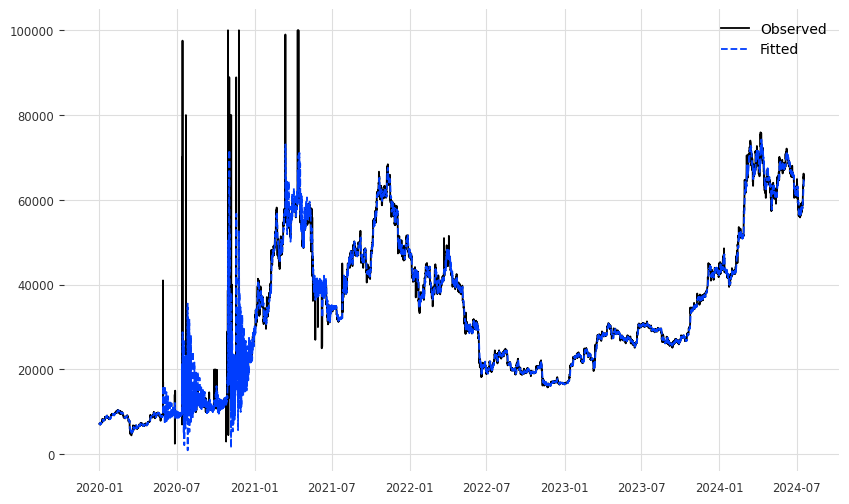

In [39]:
import matplotlib.pyplot as plt

# Plot the observed vs. fitted values
plt.figure(figsize=(10, 6))
plt.plot(BTCUSDT_Filtered_data_4H.index[:-1], BTCUSDT_Filtered_data_4H['Close'][:-1], label='Observed')
plt.plot(BTCUSDT_Filtered_data_4H.index[:-1], stats_hwinters_es.fittedvalues, label='Fitted', linestyle='--')
plt.legend()
plt.show()

In [40]:
# Fill missing values
df_with_predictions.Prediction = df_with_predictions.Prediction.bfill()
df_with_predictions

C:\Users\Ali\AppData\Local\Temp\ipykernel_4236\3366382653.py:2: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_with_predictions.Prediction = df_with_predictions.Prediction.bfill()


Open     High      Low    Close     Volume  \
Open time (4h)                                                       
2023-07-18 00:00:00  29657.9  30498.0  29657.8  30058.9  66.161904   
2023-07-18 04:00:00  29944.1  30599.0  29919.9  30168.6  64.356150   
2023-07-18 08:00:00  30548.4  30548.4  30155.0  30476.0  62.437558   
2023-07-18 12:00:00  30476.0  30540.0  30155.0  30276.4  94.781367   
2023-07-18 16:00:00  30410.0  30410.0  29960.0  30198.6  65.917963   
...                      ...      ...      ...      ...        ...   
2024-07-17 08:00:00  66196.5  66998.8  63555.0  65000.1   4.510771   
2024-07-17 12:00:00  65000.1  66000.0  63555.0  65503.9   5.291817   
2024-07-17 16:00:00  65446.3  66000.0  63892.4  64689.0   5.464083   
2024-07-17 20:00:00  64669.7  64999.0  64240.0  64603.2   9.204992   
2024-07-18 00:00:00  64685.6  64776.0  63700.0  64438.2   6.627105   

                       Prediction  
Open time (4h)                     
2023-07-18 00:00:00  30305.569679  
2023-07-18 04:00:00  30305.569679  
2023-07-18 08:00:00  30242.568126  
2023-07-18 12:00:00  30262.246608  
2023-07-18 16:00:00  30224.747379  
...                           ...  
2024-07-17 08:00:00  64114.785662  
2024-07-17 12:00:00  64443.867672  
2024-07-17 16:00:00  64853.452316  
2024-07-17 20:00:00  64748.336712  
2024-07-18 00:00:00  64732.493727  

[2197 rows x 6 columns]

In [41]:
# Assuming your results DataFrame is named 'results'
# and contains 'Actual' and 'Predicted' columns.

# Define the function to generate signals
def generate_signal(row):
    if row['Close'] < row['Prediction']:
        return 1
    elif row['Close'] > row['Prediction']:
        return -1
    else:
        return 0

# Apply the function to create the 'Signal' column
df_with_predictions['Signal'] = df_with_predictions.apply(generate_signal, axis=1)

# Display the updated DataFrame with the 'Signal' column
df_with_predictions

Open     High      Low    Close     Volume  \
Open time (4h)                                                       
2023-07-18 00:00:00  29657.9  30498.0  29657.8  30058.9  66.161904   
2023-07-18 04:00:00  29944.1  30599.0  29919.9  30168.6  64.356150   
2023-07-18 08:00:00  30548.4  30548.4  30155.0  30476.0  62.437558   
2023-07-18 12:00:00  30476.0  30540.0  30155.0  30276.4  94.781367   
2023-07-18 16:00:00  30410.0  30410.0  29960.0  30198.6  65.917963   
...                      ...      ...      ...      ...        ...   
2024-07-17 08:00:00  66196.5  66998.8  63555.0  65000.1   4.510771   
2024-07-17 12:00:00  65000.1  66000.0  63555.0  65503.9   5.291817   
2024-07-17 16:00:00  65446.3  66000.0  63892.4  64689.0   5.464083   
2024-07-17 20:00:00  64669.7  64999.0  64240.0  64603.2   9.204992   
2024-07-18 00:00:00  64685.6  64776.0  63700.0  64438.2   6.627105   

                       Prediction  Signal  
Open time (4h)                             
2023-07-18 00:00:00  30305.569679       1  
2023-07-18 04:00:00  30305.569679       1  
2023-07-18 08:00:00  30242.568126      -1  
2023-07-18 12:00:00  30262.246608      -1  
2023-07-18 16:00:00  30224.747379       1  
...                           ...     ...  
2024-07-17 08:00:00  64114.785662      -1  
2024-07-17 12:00:00  64443.867672      -1  
2024-07-17 16:00:00  64853.452316       1  
2024-07-17 20:00:00  64748.336712       1  
2024-07-18 00:00:00  64732.493727       1  

[2197 rows x 7 columns]

In [42]:
data_1m_for_hwinters = BTCUSDT_Filtered_data_1M[str(df_with_predictions.index[0]): str(df_with_predictions.index[-1])]
data_1m_for_hwinters

Open     High      Low    Close   Volume
Open time (1M)                                                  
2023-07-18 00:00:00  29657.9  30208.4  29657.9  30027.7   37.307
2023-07-18 00:01:00  29862.7  30013.7  29657.8  29969.3   17.256
2023-07-18 00:02:00  29854.0  30208.4  29657.9  29657.9  245.683
2023-07-18 00:03:00  29657.9  29957.3  29657.9  29658.0   64.483
2023-07-18 00:04:00  29757.0  30232.5  29750.0  30232.5   81.386
...                      ...      ...      ...      ...      ...
2024-07-17 23:56:00  64637.9  64742.9  64242.9  64443.6    6.473
2024-07-17 23:57:00  64443.6  64742.9  64242.9  64700.0    2.546
2024-07-17 23:58:00  64700.0  64700.0  64603.2  64603.2    1.115
2024-07-17 23:59:00  64689.0  64700.0  64603.2  64603.2    0.079
2024-07-18 00:00:00  64685.6  64742.9  64242.9  64438.4    1.644

[527041 rows x 5 columns]

In [43]:
backtest_df_hwinters = generate_backtest_df(df_with_predictions, data_1m_for_hwinters)
backtest_df_hwinters

Open time (4h) direction  entry price  close price     action  \
0    2023-07-18 00:00:00      long      29657.9          0.0       None   
1    2023-07-18 08:00:00     short      29657.9      30548.4  direction   
2    2023-07-18 08:00:00     short      30548.4          0.0       None   
3    2023-07-18 16:00:00      long      30548.4      30410.0  direction   
4    2023-07-18 16:00:00      long      30410.0          0.0       None   
...                  ...       ...          ...          ...        ...   
1573 2024-07-17 04:30:00     short      64670.8      66670.8         sl   
1574 2024-07-17 08:00:00     short      66196.5          0.0       None   
1575 2024-07-17 16:00:00      long      66196.5      65446.3  direction   
1576 2024-07-17 16:00:00      long      65446.3          0.0       None   
1577 2024-07-18 00:00:00      long      65446.3      64685.6  direction   

           PNL      Balance  
0          NaN  1029.925727  
1     3.002573  1029.925727  
2          NaN  1034.488829  
3     0.453052  1034.488829  
4          NaN  1030.541340  
...        ...          ...  
1573 -3.092586     0.052444  
1574       NaN     0.053033  
1575  1.133293     0.053033  
1576       NaN     0.052411  
1577 -1.162327     0.052411  

[1578 rows x 7 columns]

#### Got Very Bad PNL Using Holt Winters Exponential Smoothing

## Just Seeing How Different Dart Models Predict The Future Values And Also Backtesting Using Signals Generated Using These Models

### Separating The Train And Test Values And Pre-processing The Data

In [57]:
from darts.dataprocessing import Pipeline
from darts.dataprocessing.transformers import Scaler, MissingValuesFiller, InvertibleMapper
from darts import TimeSeries

In [58]:
# train, test = get_past_data(copy.deepcopy(BTCUSDT_Filtered_data_4H), '1Y', get_timeframe(BTCUSDT_Filtered_data_4H))

In [59]:
# Set aside the last 1 year as a test series
# train, test = BTCUSDT_Filtered_data_4H_on_4H_Prev_1Y['Close'][:-100].copy(), BTCUSDT_Filtered_data_4H_on_4H_Prev_1Y['Close'][-100:].copy()
train, test = get_past_data(copy.deepcopy(BTCUSDT_Filtered_data_4H['Close'][2000:]), '1Y', get_timeframe(BTCUSDT_Filtered_data_4H))
# train, test = train['Close'], test['Close']

# Convert DataFrame to TimeSeries because some need data as a TimeSeries data
train_ts = TimeSeries.from_series(train)
test_ts = TimeSeries.from_series(test)

# Transforming the data..
log_transformer = InvertibleMapper(np.log1p, np.expm1, verbose=False, n_jobs=-1, name="Log-Transform")   
train_and_test_scaler = Scaler(verbose=False, n_jobs=-1, name="Scaling")

train_and_test_pipeline = Pipeline([log_transformer,
                             train_and_test_scaler])
     
training_transformed = train_and_test_pipeline.fit_transform(train_ts)
testing_transformed = train_and_test_pipeline.fit_transform(test_ts)

training_transformed

<TimeSeries (DataArray) (Open time (4h): 5764, component: 1, sample: 1)> Size: 46kB
array([[[0.06345231]],

       [[0.07714089]],

       [[0.07257485]],

       ...,

       [[0.35270809]],

       [[0.35353067]],

       [[0.34556733]]])
Coordinates:
  * Open time (4h)  (Open time (4h)) datetime64[ns] 46kB 2020-11-29T08:00:00 ...
  * component       (component) object 8B 'Close'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [60]:
testing_transformed

<TimeSeries (DataArray) (Open time (4h): 2197, component: 1, sample: 1)> Size: 18kB
array([[[0.16066564]],

       [[0.16396548]],

       [[0.17314875]],

       ...,

       [[0.85493803]],

       [[0.85373575]],

       [[0.85141919]]])
Coordinates:
  * Open time (4h)  (Open time (4h)) datetime64[ns] 18kB 2023-07-18 ... 2024-...
  * component       (component) object 8B 'Close'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

### Testing On The Auto Arima Model

In [48]:
from pmdarima import auto_arima
from tqdm import tqdm

# Fit an Auto-ARIMA model
model = auto_arima(training_transformed.values(), seasonal=True, m=24)

# Sequentially predict the second next close price
predictions = []
history = list(training_transformed.values().flatten())

# Initialize tqdm progress bar
for i in tqdm(range(len(testing_transformed) - 1), desc="Predicting", unit="step"):
    # Update the model with the current value
    model.update(history[-1])
    # Predict the second next value
    prediction = model.predict(1)
    predictions.append(prediction)
    history.append(testing_transformed[i + 1].values()[0])

# Inverse transform the predictions
predictions_series = TimeSeries.from_times_and_values(test.index[:-1], np.array(predictions))
predictions_inverse = train_and_test_pipeline.inverse_transform(predictions_series)

# Convert predictions to a DataFrame
results = pd.DataFrame({'Actual': train.values[1:].flatten(), 'Predicted': predictions_inverse.values().flatten()}, index=train.index[1:])

# Display the results
results

Predicting: 100%|██████████████████████████████████████████████████████████████| 2196/2196 [1:02:36<00:00,  1.71s/step]


Actual     Predicted
Open time (4h)                            
2023-07-18 04:00:00  30168.6  36933.796224
2023-07-18 08:00:00  30476.0  32850.244457
2023-07-18 12:00:00  30276.4  31658.291197
2023-07-18 16:00:00  30198.6  31134.883101
2023-07-18 20:00:00  29950.0  30690.058825
...                      ...           ...
2024-07-17 08:00:00  65000.1  65489.988452
2024-07-17 12:00:00  65503.9  65109.177801
2024-07-17 16:00:00  64689.0  65302.625314
2024-07-17 20:00:00  64603.2  64914.483128
2024-07-18 00:00:00  64438.2  64695.334256

[2196 rows x 2 columns]

In [49]:
# Assuming your results DataFrame is named 'results'
# and contains 'Actual' and 'Predicted' columns.

# Define the function to generate signals
def generate_signal(row):
    if row['Actual'] > row['Predicted']:
        return -1
    elif row['Actual'] < row['Predicted']:
        return 1
    else:
        return 0

# Apply the function to create the 'Signal' column
results['Signal'] = results.apply(generate_signal, axis=1)

# Display the updated DataFrame with the 'Signal' column
results

Actual     Predicted  Signal
Open time (4h)                                    
2023-07-18 04:00:00  30168.6  36933.796224      -1
2023-07-18 08:00:00  30476.0  32850.244457      -1
2023-07-18 12:00:00  30276.4  31658.291197      -1
2023-07-18 16:00:00  30198.6  31134.883101      -1
2023-07-18 20:00:00  29950.0  30690.058825      -1
...                      ...           ...     ...
2024-07-17 08:00:00  65000.1  65489.988452      -1
2024-07-17 12:00:00  65503.9  65109.177801       1
2024-07-17 16:00:00  64689.0  65302.625314      -1
2024-07-17 20:00:00  64603.2  64914.483128      -1
2024-07-18 00:00:00  64438.2  64695.334256      -1

[2196 rows x 3 columns]

In [51]:
data_4h_signal_pmdarima = BTCUSDT_Filtered_data_4H[str(results.index[0]): str(results.index[-1])].copy()
data_4h_signal_pmdarima.loc[:, 'Signal'] = results['Signal']
data_4h_signal_pmdarima

Open     High      Low    Close     Volume  Signal
Open time (4h)                                                            
2023-07-18 04:00:00  29944.1  30599.0  29919.9  30168.6  64.356150      -1
2023-07-18 08:00:00  30548.4  30548.4  30155.0  30476.0  62.437558      -1
2023-07-18 12:00:00  30476.0  30540.0  30155.0  30276.4  94.781367      -1
2023-07-18 16:00:00  30410.0  30410.0  29960.0  30198.6  65.917963      -1
2023-07-18 20:00:00  30038.4  30350.0  29848.2  29950.0  68.344292      -1
...                      ...      ...      ...      ...        ...     ...
2024-07-17 08:00:00  66196.5  66998.8  63555.0  65000.1   4.510771      -1
2024-07-17 12:00:00  65000.1  66000.0  63555.0  65503.9   5.291817       1
2024-07-17 16:00:00  65446.3  66000.0  63892.4  64689.0   5.464083      -1
2024-07-17 20:00:00  64669.7  64999.0  64240.0  64603.2   9.204992      -1
2024-07-18 00:00:00  64685.6  64776.0  63700.0  64438.2   6.627105      -1

[2196 rows x 6 columns]

In [50]:
data_1m_pmdarima = BTCUSDT_Filtered_data_1M[str(results.index[0]): str(results.index[-1])].copy()
data_1m_pmdarima

Open     High      Low    Close   Volume
Open time (1M)                                                  
2023-07-18 04:00:00  29944.1  30402.2  29919.9  29919.9   56.208
2023-07-18 04:01:00  29936.0  30470.5  29920.0  29920.0   73.195
2023-07-18 04:02:00  30093.9  30450.0  29920.0  30450.0  105.551
2023-07-18 04:03:00  30450.0  30498.0  29958.4  30498.0   38.437
2023-07-18 04:04:00  30475.3  30475.3  29920.0  29920.1   75.147
...                      ...      ...      ...      ...      ...
2024-07-17 23:56:00  64637.9  64742.9  64242.9  64443.6    6.473
2024-07-17 23:57:00  64443.6  64742.9  64242.9  64700.0    2.546
2024-07-17 23:58:00  64700.0  64700.0  64603.2  64603.2    1.115
2024-07-17 23:59:00  64689.0  64700.0  64603.2  64603.2    0.079
2024-07-18 00:00:00  64685.6  64742.9  64242.9  64438.4    1.644

[526801 rows x 5 columns]

In [52]:
backtest_df_pmdarima = generate_backtest_df(data_4h_signal_pmdarima, data_1m_pmdarima)
backtest_df_pmdarima

Open time (4h) direction  entry price  close price     action  \
0    2023-07-18 04:00:00     short      29944.1          0.0       None   
1    2023-07-19 12:00:00      long      29944.1      30060.0  direction   
2    2023-07-19 12:00:00      long      30060.0          0.0       None   
3    2023-07-19 16:00:00     short      30060.0      30190.0  direction   
4    2023-07-19 16:00:00     short      30190.0          0.0       None   
...                  ...       ...          ...          ...        ...   
2169 2024-07-17 12:00:00      long      66196.5      65000.1  direction   
2170 2024-07-17 12:00:00      long      65000.1          0.0       None   
2171 2024-07-17 16:00:00     short      65000.1      65446.3  direction   
2172 2024-07-17 16:00:00     short      65446.3          0.0       None   
2173 2024-07-18 00:00:00     short      65446.3      64685.6  direction   

           PNL       Balance  
0          NaN  9.960295e+02  
1    -0.387055  9.960295e+02  
2          NaN  1.000237e+03  
3     0.432468  1.000237e+03  
4          NaN  1.001506e+03  
...        ...           ...  
2169  1.807346  2.531507e+08  
2170       NaN  2.548632e+08  
2171  0.686460  2.548632e+08  
2172       NaN  2.578000e+08  
2173  1.162327  2.578000e+08  

[2174 rows x 7 columns]

#### Plotting The Test Values And Also The Forcasted Ones

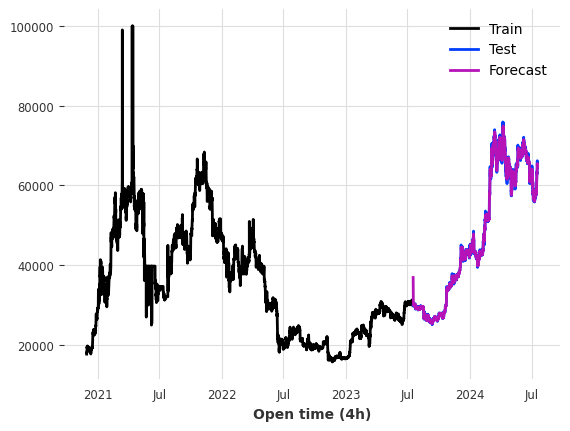

In [54]:
train_ts.plot(label='Train')
test_ts.plot(label='Test')
predictions_inverse.plot(label='Forecast')
plt.legend()

### Testing On The Darts Exponential Smoothing

In [76]:
from darts import TimeSeries
from darts.models import ExponentialSmoothing
from tqdm import tqdm

# Initialize the ExponentialSmoothing model
model = ExponentialSmoothing()

# Fit the model to the training data
fit = model.fit(training_transformed)

# Sequentially predict the second next close price
predictions = []
history = list(training_transformed.values().flatten())

# Initialize tqdm progress bar
for i in tqdm(range(len(testing_transformed) - 1), desc="Predicting", unit="step"):
    # Determine the appropriate index for the current history
    if len(history) <= len(train):
        current_index = train.index[:len(history)]
    else:
        # Combine the remaining indices from the train with indices from the test
        remaining_train_index = train.index
        additional_test_index = test.index[:len(history) - len(train)]
        current_index = remaining_train_index.append(additional_test_index)

    # Ensure history contains only scalar values
    history = [float(x) if isinstance(x, (int, float)) else float(x[0]) for x in history]
        
    # Update the model with the current value
    model = model.fit(TimeSeries.from_times_and_values(current_index, history))
    # Predict the second next value
    prediction = model.predict(2)[-1]
    predictions.append(prediction.values()[0])
    history.append(testing_transformed[i + 1].values()[0])

# Inverse transform the predictions
predictions_series = TimeSeries.from_times_and_values(test.index[:-1], np.array(predictions))
predictions_inverse = train_and_test_pipeline.inverse_transform(predictions_series)

# Convert predictions to a DataFrame
results = pd.DataFrame({'Actual': test.values[1:].flatten(), 'Predicted': predictions_inverse.values().flatten()}, index=test.index[1:])

# Display the results
results

Predicting: 100%|██████████████████████████████████████████████████████████████| 2196/2196 [1:22:24<00:00,  2.25s/step]


Actual     Predicted
Open time (4h)                            
2023-07-18 04:00:00  30168.6  37054.158416
2023-07-18 08:00:00  30476.0  32451.759862
2023-07-18 12:00:00  30276.4  31089.881623
2023-07-18 16:00:00  30198.6  30516.935977
2023-07-18 20:00:00  29950.0  30304.853213
...                      ...           ...
2024-07-17 08:00:00  65000.1  65799.818683
2024-07-17 12:00:00  65503.9  65264.807036
2024-07-17 16:00:00  64689.0  65421.680022
2024-07-17 20:00:00  64603.2  64879.517310
2024-07-18 00:00:00  64438.2  64647.888931

[2196 rows x 2 columns]

In [77]:
# Assuming your results DataFrame is named 'results'
# and contains 'Actual' and 'Predicted' columns.

# Define the function to generate signals
def generate_signal(row):
    if row['Actual'] > row['Predicted']:
        return -1
    elif row['Actual'] < row['Predicted']:
        return 1
    else:
        return 0

# Apply the function to create the 'Signal' column
results['Signal'] = results.apply(generate_signal, axis=1)

# Display the updated DataFrame with the 'Signal' column
results

Actual     Predicted  Signal
Open time (4h)                                    
2023-07-18 04:00:00  30168.6  37054.158416      -1
2023-07-18 08:00:00  30476.0  32451.759862      -1
2023-07-18 12:00:00  30276.4  31089.881623      -1
2023-07-18 16:00:00  30198.6  30516.935977      -1
2023-07-18 20:00:00  29950.0  30304.853213      -1
...                      ...           ...     ...
2024-07-17 08:00:00  65000.1  65799.818683      -1
2024-07-17 12:00:00  65503.9  65264.807036       1
2024-07-17 16:00:00  64689.0  65421.680022      -1
2024-07-17 20:00:00  64603.2  64879.517310      -1
2024-07-18 00:00:00  64438.2  64647.888931      -1

[2196 rows x 3 columns]

In [78]:
data_4h_signal_expsm = BTCUSDT_Filtered_data_4H[str(results.index[0]): str(results.index[-1])].copy()
data_4h_signal_expsm.loc[:, 'Signal'] = results['Signal']
data_4h_signal_expsm

Open     High      Low    Close     Volume  Signal
Open time (4h)                                                            
2023-07-18 04:00:00  29944.1  30599.0  29919.9  30168.6  64.356150      -1
2023-07-18 08:00:00  30548.4  30548.4  30155.0  30476.0  62.437558      -1
2023-07-18 12:00:00  30476.0  30540.0  30155.0  30276.4  94.781367      -1
2023-07-18 16:00:00  30410.0  30410.0  29960.0  30198.6  65.917963      -1
2023-07-18 20:00:00  30038.4  30350.0  29848.2  29950.0  68.344292      -1
...                      ...      ...      ...      ...        ...     ...
2024-07-17 08:00:00  66196.5  66998.8  63555.0  65000.1   4.510771      -1
2024-07-17 12:00:00  65000.1  66000.0  63555.0  65503.9   5.291817       1
2024-07-17 16:00:00  65446.3  66000.0  63892.4  64689.0   5.464083      -1
2024-07-17 20:00:00  64669.7  64999.0  64240.0  64603.2   9.204992      -1
2024-07-18 00:00:00  64685.6  64776.0  63700.0  64438.2   6.627105      -1

[2196 rows x 6 columns]

In [79]:
data_1m_expsm = BTCUSDT_Filtered_data_1M[str(results.index[0]): str(results.index[-1])].copy()
data_1m_expsm

Open     High      Low    Close   Volume
Open time (1M)                                                  
2023-07-18 04:00:00  29944.1  30402.2  29919.9  29919.9   56.208
2023-07-18 04:01:00  29936.0  30470.5  29920.0  29920.0   73.195
2023-07-18 04:02:00  30093.9  30450.0  29920.0  30450.0  105.551
2023-07-18 04:03:00  30450.0  30498.0  29958.4  30498.0   38.437
2023-07-18 04:04:00  30475.3  30475.3  29920.0  29920.1   75.147
...                      ...      ...      ...      ...      ...
2024-07-17 23:56:00  64637.9  64742.9  64242.9  64443.6    6.473
2024-07-17 23:57:00  64443.6  64742.9  64242.9  64700.0    2.546
2024-07-17 23:58:00  64700.0  64700.0  64603.2  64603.2    1.115
2024-07-17 23:59:00  64689.0  64700.0  64603.2  64603.2    0.079
2024-07-18 00:00:00  64685.6  64742.9  64242.9  64438.4    1.644

[526801 rows x 5 columns]

In [80]:
backtest_df_expsm = generate_backtest_df(data_4h_signal_expsm, data_1m_expsm)
backtest_df_expsm

Open time (4h) direction  entry price  close price     action  \
0    2023-07-18 04:00:00     short      29944.1          0.0       None   
1    2023-07-19 00:00:00      long      29944.1      30297.0  direction   
2    2023-07-19 00:00:00      long      30297.0          0.0       None   
3    2023-07-19 04:00:00     short      30297.0      29859.8  direction   
4    2023-07-19 04:00:00     short      29859.8          0.0       None   
...                  ...       ...          ...          ...        ...   
2259 2024-07-17 12:00:00      long      66196.5      65000.1  direction   
2260 2024-07-17 12:00:00      long      65000.1          0.0       None   
2261 2024-07-17 16:00:00     short      65000.1      65446.3  direction   
2262 2024-07-17 16:00:00     short      65446.3          0.0       None   
2263 2024-07-18 00:00:00     short      65446.3      64685.6  direction   

           PNL       Balance  
0          NaN  9.881147e+02  
1    -1.178529  9.881147e+02  
2          NaN  9.737569e+02  
3    -1.443047  9.737569e+02  
4          NaN  9.671308e+02  
...        ...           ...  
2259  1.807346  3.108378e+08  
2260       NaN  3.129405e+08  
2261  0.686460  3.129405e+08  
2262       NaN  3.165466e+08  
2263  1.162327  3.165466e+08  

[2264 rows x 7 columns]

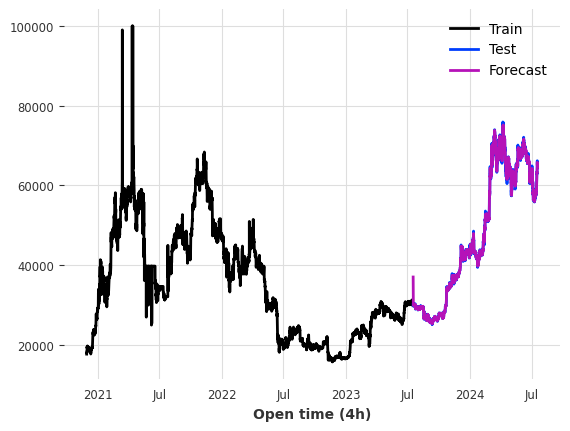

In [81]:
train_ts.plot(label='Train')
test_ts.plot(label='Test')
predictions_inverse.plot(label='Forecast')
plt.legend()

### Testing On Facebook's Prophet Model - Currently Leaving It Untrained Because It's Taking Too Much Time

In [82]:
from darts import TimeSeries
from darts.models import Prophet
from tqdm import tqdm
import numpy as np
import pandas as pd

# Initialize the Prophet model
model_prophet = Prophet()

# Fit the model to the training data
model_prophet.fit(training_transformed)

# Sequentially predict the next value
predictions_prophet = []
history = list(training_transformed.values().flatten())

# Initialize tqdm progress bar
for i in tqdm(range(len(testing_transformed)), desc="Predicting with Prophet", unit="step"):
    # Determine the appropriate index for the current history
    if len(history) <= len(train):
        current_index = train.index[:len(history)]
    else:
        # Combine the remaining indices from the train with indices from the test
        remaining_train_index = train.index
        additional_test_index = test.index[:len(history) - len(train)]
        current_index = remaining_train_index.append(additional_test_index)
    
    # Ensure history contains only scalar values
    history = [float(x) if isinstance(x, (int, float)) else float(x[0]) for x in history]

    # Update the model with the current value
    model_prophet = model_prophet.fit(TimeSeries.from_times_and_values(current_index, np.array(history)))
    
    # Predict the next value
    prediction = model_prophet.predict(1)[-1]
    predictions_prophet.append(prediction.values()[0])
    
    # Append the actual next test value to history (as a scalar)
    history.append(float(testing_transformed[i].values()[0]))

# Inverse transform the predictions
predictions_series_prophet = TimeSeries.from_times_and_values(test.index, np.array(predictions_prophet))
predictions_inverse = train_and_test_pipeline.inverse_transform(predictions_series_prophet)

# Convert predictions to a DataFrame
results = pd.DataFrame({'Actual': test.values.flatten(), 'Predicted': predictions_inverse.values().flatten()}, index=test.index)

# Display the results
results

14:05:54 - cmdstanpy - INFO - Chain [1] start processing
14:05:58 - cmdstanpy - INFO - Chain [1] done processing
Predicting with Prophet:   0%|                                                              | 0/2197 [00:00<?, ?step/s]14:05:59 - cmdstanpy - INFO - Chain [1] start processing
14:06:03 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\Ali\AppData\Local\Temp\ipykernel_9480\3404966285.py:39: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  history.append(float(testing_transformed[i].values()[0]))
Predicting with Prophet:   0%|                                                    | 1/2197 [00:04<2:56:03,  4.81s/step]14:06:04 - cmdstanpy - INFO - Chain [1] start processing
14:06:08 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\Ali\AppData\Local\Temp\ipykernel_9480\3404966285.py:39: DeprecationW

KeyboardInterrupt: 

In [ ]:
# Assuming your results DataFrame is named 'results'
# and contains 'Actual' and 'Predicted' columns.

# Define the function to generate signals
def generate_signal(row):
    if row['Actual'] > row['Predicted']:
        return -1
    elif row['Actual'] < row['Predicted']:
        return 1
    else:
        return 0

# Apply the function to create the 'Signal' column
results['Signal'] = results.apply(generate_signal, axis=1)

# Display the updated DataFrame with the 'Signal' column
results

In [ ]:
data_4h_signal_prophet = BTCUSDT_Filtered_data_4H[str(results.index[0]): str(results.index[-1])].copy()
data_4h_signal_prophet.loc[:, 'Signal'] = results['Signal']
data_4h_signal_prophet

In [ ]:
data_1m_prophet = BTCUSDT_Filtered_data_1M[str(results.index[0]): str(results.index[-1])].copy()
data_1m_prophet

In [ ]:
backtest_df_prophet = generate_backtest_df(data_4h_signal_prophet, data_1m_prophet)
backtest_df_prophet

In [ ]:
train_ts.plot(label='Train')
test_ts.plot(label='Test')
predictions_inverse.plot(label='Forecast')
plt.legend()

### Testing On Dart's NaiveSeasonal Model

In [32]:
from darts.models import NaiveSeasonal
from tqdm import tqdm
from darts import TimeSeries
import numpy as np

# Initialize the NaiveSeasonal model
model_naive = NaiveSeasonal()

# Fit the model to the training data
fit = model_naive.fit(training_transformed)

# Sequentially predict the next close price
predictions = []
history = list(training_transformed.values().flatten())

# Combine train and test indices to extend the time index
combined_index = train.index.append(test.index)

# Initialize tqdm progress bar
for i in tqdm(range(len(testing_transformed)), desc="Predicting", unit="step"):
    # Dynamically create the index for the history
    current_index = combined_index[:len(history)]

    # Ensure history contains only scalar values
    history = [float(x) if isinstance(x, (int, float)) else float(x[0]) for x in history]
    
    # Update the model with the current value
    model_naive = model_naive.fit(TimeSeries.from_times_and_values(current_index, np.array(history)))
    
    # Predict the next value
    prediction = model_naive.predict(1)[-1]
    predictions.append(prediction.values()[0])
    
    # Update the history with the new actual value
    if i < len(testing_transformed):
        history.append(testing_transformed[i].values()[0])

# Inverse transform the predictions
predictions_series = TimeSeries.from_times_and_values(test.index, np.array(predictions))
predictions_inverse = train_and_test_pipeline.inverse_transform(predictions_series)

# Convert predictions to a DataFrame
results = pd.DataFrame({'Actual': test.values.flatten(), 'Predicted': predictions_inverse.values().flatten()}, index=test.index)

# Display the results
results

Predicting: 100%|███████████████████████████████████████████████████████████████| 2197/2197 [00:20<00:00, 104.80step/s]


Actual     Predicted
Open time (4h)                            
2023-07-18 00:00:00  30058.9  36865.636203
2023-07-18 04:00:00  30168.6  30058.900000
2023-07-18 08:00:00  30476.0  30168.600000
2023-07-18 12:00:00  30276.4  30476.000000
2023-07-18 16:00:00  30198.6  30276.400000
...                      ...           ...
2024-07-17 08:00:00  65000.1  66196.500000
2024-07-17 12:00:00  65503.9  65000.100000
2024-07-17 16:00:00  64689.0  65503.900000
2024-07-17 20:00:00  64603.2  64689.000000
2024-07-18 00:00:00  64438.2  64603.200000

[2197 rows x 2 columns]

In [33]:
# Assuming your results DataFrame is named 'results'
# and contains 'Actual' and 'Predicted' columns.

# Define the function to generate signals
def generate_signal(row):
    if row['Actual'] > row['Predicted']:
        return -1
    elif row['Actual'] < row['Predicted']:
        return 1
    else:
        return 0

# Apply the function to create the 'Signal' column
results['Signal'] = results.apply(generate_signal, axis=1)

# Display the updated DataFrame with the 'Signal' column
results

Actual     Predicted  Signal
Open time (4h)                                    
2023-07-18 00:00:00  30058.9  36865.636203       1
2023-07-18 04:00:00  30168.6  30058.900000      -1
2023-07-18 08:00:00  30476.0  30168.600000      -1
2023-07-18 12:00:00  30276.4  30476.000000       1
2023-07-18 16:00:00  30198.6  30276.400000       1
...                      ...           ...     ...
2024-07-17 08:00:00  65000.1  66196.500000       1
2024-07-17 12:00:00  65503.9  65000.100000      -1
2024-07-17 16:00:00  64689.0  65503.900000       1
2024-07-17 20:00:00  64603.2  64689.000000       1
2024-07-18 00:00:00  64438.2  64603.200000       1

[2197 rows x 3 columns]

In [34]:
data_4h_signal_naiveseasonal = BTCUSDT_Filtered_data_4H[str(results.index[0]): str(results.index[-1])].copy()
data_4h_signal_naiveseasonal.loc[:, 'Signal'] = results['Signal']
data_4h_signal_naiveseasonal

Open     High      Low    Close     Volume  Signal
Open time (4h)                                                            
2023-07-18 00:00:00  29657.9  30498.0  29657.8  30058.9  66.161904       1
2023-07-18 04:00:00  29944.1  30599.0  29919.9  30168.6  64.356150      -1
2023-07-18 08:00:00  30548.4  30548.4  30155.0  30476.0  62.437558      -1
2023-07-18 12:00:00  30476.0  30540.0  30155.0  30276.4  94.781367       1
2023-07-18 16:00:00  30410.0  30410.0  29960.0  30198.6  65.917963       1
...                      ...      ...      ...      ...        ...     ...
2024-07-17 08:00:00  66196.5  66998.8  63555.0  65000.1   4.510771       1
2024-07-17 12:00:00  65000.1  66000.0  63555.0  65503.9   5.291817      -1
2024-07-17 16:00:00  65446.3  66000.0  63892.4  64689.0   5.464083       1
2024-07-17 20:00:00  64669.7  64999.0  64240.0  64603.2   9.204992       1
2024-07-18 00:00:00  64685.6  64776.0  63700.0  64438.2   6.627105       1

[2197 rows x 6 columns]

In [35]:
data_1m_naiveseasonal = BTCUSDT_Filtered_data_1M[str(results.index[0]): str(results.index[-1])].copy()
data_1m_naiveseasonal

Open     High      Low    Close   Volume
Open time (1M)                                                  
2023-07-18 00:00:00  29657.9  30208.4  29657.9  30027.7   37.307
2023-07-18 00:01:00  29862.7  30013.7  29657.8  29969.3   17.256
2023-07-18 00:02:00  29854.0  30208.4  29657.9  29657.9  245.683
2023-07-18 00:03:00  29657.9  29957.3  29657.9  29658.0   64.483
2023-07-18 00:04:00  29757.0  30232.5  29750.0  30232.5   81.386
...                      ...      ...      ...      ...      ...
2024-07-17 23:56:00  64637.9  64742.9  64242.9  64443.6    6.473
2024-07-17 23:57:00  64443.6  64742.9  64242.9  64700.0    2.546
2024-07-17 23:58:00  64700.0  64700.0  64603.2  64603.2    1.115
2024-07-17 23:59:00  64689.0  64700.0  64603.2  64603.2    0.079
2024-07-18 00:00:00  64685.6  64742.9  64242.9  64438.4    1.644

[527041 rows x 5 columns]

In [36]:
backtest_df_naiveseasonal = generate_backtest_df(data_4h_signal_naiveseasonal, data_1m_naiveseasonal)
backtest_df_naiveseasonal

Open time (4h) direction  entry price  close price     action  \
0    2023-07-18 00:00:00      long      29657.9          0.0       None   
1    2023-07-18 04:00:00     short      29657.9      29944.1  direction   
2    2023-07-18 04:00:00     short      29944.1          0.0       None   
3    2023-07-18 12:00:00      long      29944.1      30476.0  direction   
4    2023-07-18 12:00:00      long      30476.0          0.0       None   
...                  ...       ...          ...          ...        ...   
2735 2024-07-17 11:47:00     short      66196.5      63689.2         sl   
2736 2024-07-17 12:00:00     short      65000.1          0.0       None   
2737 2024-07-17 16:00:00      long      65000.1      65446.3  direction   
2738 2024-07-17 16:00:00      long      65446.3          0.0       None   
2739 2024-07-18 00:00:00      long      65446.3      64685.6  direction   

           PNL      Balance  
0          NaN  1009.550043  
1     0.965004  1009.550043  
2          NaN   991.516351  
3    -1.776310   991.516351  
4          NaN   985.593553  
...        ...          ...  
2735  3.787662     0.004325  
2736       NaN     0.004295  
2737 -0.686460     0.004295  
2738       NaN     0.004244  
2739 -1.162327     0.004244  

[2740 rows x 7 columns]

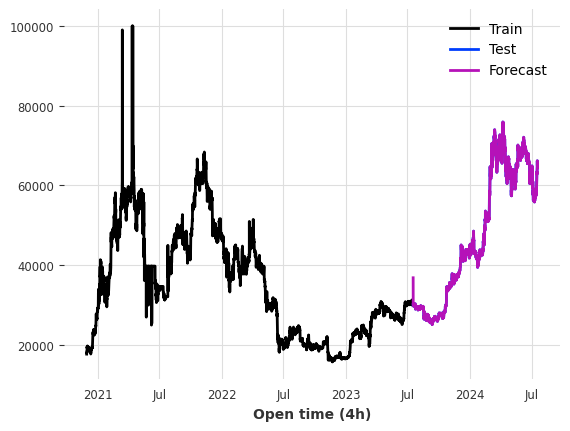

In [90]:
train_ts.plot(label='Train')
test_ts.plot(label='Test')
predictions_inverse.plot(label='Forecast')
plt.legend()

### Testing On Dart's Arima Model: Currently Leaving It Untrained Because It's Taking Too Much Time

In [92]:
from darts.models import ARIMA
from tqdm import tqdm
from darts import TimeSeries
import numpy as np

# Initialize the ARIMA model
model_arima = ARIMA()

# Fit the model to the training data
fit = model_arima.fit(training_transformed)

# Sequentially predict the next close price
predictions = []
history = list(training_transformed.values().flatten())

# Combine train and test indices to extend the time index
combined_index = train.index.append(test.index)

# Initialize tqdm progress bar
for i in tqdm(range(len(testing_transformed)), desc="Predicting", unit="step"):
    # Dynamically create the index for the history
    current_index = combined_index[:len(history)]

    # Ensure history contains only scalar values
    history = [float(x) if isinstance(x, (int, float)) else float(x[0]) for x in history]
    
    # Update the model with the current value
    model_arima = model_arima.fit(TimeSeries.from_times_and_values(current_index, np.array(history)))
    
    # Predict the next value
    prediction = model_arima.predict(1)[-1]
    predictions.append(prediction.values()[0])
    
    # Update the history with the new actual value
    if i < len(testing_transformed):
        history.append(testing_transformed[i].values()[0])

# Inverse transform the predictions
predictions_series = TimeSeries.from_times_and_values(test.index, np.array(predictions))
predictions_inverse = train_and_test_pipeline.inverse_transform(predictions_series)

# Convert predictions to a DataFrame
results = pd.DataFrame({'Actual': test.values.flatten(), 'Predicted': predictions_inverse.values().flatten()}, index=test.index)

# Display the results
results

Predicting:   1%|▊                                                               | 29/2197 [02:03<2:33:30,  4.25s/step]


KeyboardInterrupt: 

In [ ]:
# Assuming your results DataFrame is named 'results'
# and contains 'Actual' and 'Predicted' columns.

# Define the function to generate signals
def generate_signal(row):
    if row['Actual'] > row['Predicted']:
        return -1
    elif row['Actual'] < row['Predicted']:
        return 1
    else:
        return 0

# Apply the function to create the 'Signal' column
results['Signal'] = results.apply(generate_signal, axis=1)

# Display the updated DataFrame with the 'Signal' column
results

In [ ]:
data_4h_signal_dartsarima = BTCUSDT_Filtered_data_4H[str(results.index[0]): str(results.index[-1])].copy()
data_4h_signal_dartsarima.loc[:, 'Signal'] = results['Signal']
data_4h_signal_dartsarima

In [ ]:
data_1m_dartsarima = BTCUSDT_Filtered_data_1M[str(results.index[0]): str(results.index[-1])].copy()
data_1m_dartsarima

In [ ]:
backtest_df_dartsarima = generate_backtest_df(data_4h_signal_dartsarima, data_1m_dartsarima)
backtest_df_dartsarima

In [ ]:
train_ts.plot(label='Train')
test_ts.plot(label='Test')
predictions_inverse.plot(label='Forecast')
plt.legend()

### Testing On Dart's Croston Model

In [93]:
from darts.models import Croston
from tqdm import tqdm
from darts import TimeSeries
import numpy as np

# Initialize the Croston model with the optimized version
model_croston = Croston(version="optimized")

# Fit the model to the training data
model_croston.fit(training_transformed)

# Sequentially predict the next close price
predictions = []
history = list(training_transformed.values().flatten())

# Combine train and test indices to extend the time index
combined_index = train.index.append(test.index)

# Initialize tqdm progress bar
for i in tqdm(range(len(testing_transformed)), desc="Predicting", unit="step"):
    # Dynamically create the index for the history
    current_index = combined_index[:len(history)]

    # Ensure history contains only scalar values
    history = [float(x) if isinstance(x, (int, float)) else float(x[0]) for x in history]
    
    # Update the model with the current value
    model_croston = model_croston.fit(TimeSeries.from_times_and_values(current_index, np.array(history)))
    
    # Predict the next value
    prediction = model_croston.predict(1)[-1]
    predictions.append(prediction.values()[0])
    
    # Update the history with the new actual value
    if i < len(testing_transformed):
        history.append(testing_transformed[i].values()[0])

# Inverse transform the predictions
predictions_series = TimeSeries.from_times_and_values(test.index, np.array(predictions))
predictions_inverse = train_and_test_pipeline.inverse_transform(predictions_series)

# Convert predictions to a DataFrame
results = pd.DataFrame({'Actual': test.values.flatten(), 'Predicted': predictions_inverse.values().flatten()}, index=test.index)

# Display the results
results

Predicting: 100%|████████████████████████████████████████████████████████████████| 2197/2197 [00:56<00:00, 38.78step/s]


Actual     Predicted
Open time (4h)                            
2023-07-18 00:00:00  30058.9  37111.371094
2023-07-18 04:00:00  30168.6  34837.484375
2023-07-18 08:00:00  30476.0  33365.636719
2023-07-18 12:00:00  30276.4  32471.111328
2023-07-18 16:00:00  30198.6  31796.460938
...                      ...           ...
2024-07-17 08:00:00  65000.1  64549.734375
2024-07-17 12:00:00  65503.9  64684.566406
2024-07-17 16:00:00  64689.0  64929.257812
2024-07-17 20:00:00  64603.2  64857.093750
2024-07-18 00:00:00  64438.2  64780.812500

[2197 rows x 2 columns]

In [94]:
# Assuming your results DataFrame is named 'results'
# and contains 'Actual' and 'Predicted' columns.

# Define the function to generate signals
def generate_signal(row):
    if row['Actual'] > row['Predicted']:
        return -1
    elif row['Actual'] < row['Predicted']:
        return 1
    else:
        return 0

# Apply the function to create the 'Signal' column
results['Signal'] = results.apply(generate_signal, axis=1)

# Display the updated DataFrame with the 'Signal' column
results

Actual     Predicted  Signal
Open time (4h)                                    
2023-07-18 00:00:00  30058.9  37111.371094      -1
2023-07-18 04:00:00  30168.6  34837.484375      -1
2023-07-18 08:00:00  30476.0  33365.636719      -1
2023-07-18 12:00:00  30276.4  32471.111328      -1
2023-07-18 16:00:00  30198.6  31796.460938      -1
...                      ...           ...     ...
2024-07-17 08:00:00  65000.1  64549.734375       1
2024-07-17 12:00:00  65503.9  64684.566406       1
2024-07-17 16:00:00  64689.0  64929.257812      -1
2024-07-17 20:00:00  64603.2  64857.093750      -1
2024-07-18 00:00:00  64438.2  64780.812500      -1

[2197 rows x 3 columns]

In [95]:
data_4h_signal_croston = BTCUSDT_Filtered_data_4H[str(results.index[0]): str(results.index[-1])].copy()
data_4h_signal_croston.loc[:, 'Signal'] = results['Signal']
data_4h_signal_croston

Open     High      Low    Close     Volume  Signal
Open time (4h)                                                            
2023-07-18 00:00:00  29657.9  30498.0  29657.8  30058.9  66.161904      -1
2023-07-18 04:00:00  29944.1  30599.0  29919.9  30168.6  64.356150      -1
2023-07-18 08:00:00  30548.4  30548.4  30155.0  30476.0  62.437558      -1
2023-07-18 12:00:00  30476.0  30540.0  30155.0  30276.4  94.781367      -1
2023-07-18 16:00:00  30410.0  30410.0  29960.0  30198.6  65.917963      -1
...                      ...      ...      ...      ...        ...     ...
2024-07-17 08:00:00  66196.5  66998.8  63555.0  65000.1   4.510771       1
2024-07-17 12:00:00  65000.1  66000.0  63555.0  65503.9   5.291817       1
2024-07-17 16:00:00  65446.3  66000.0  63892.4  64689.0   5.464083      -1
2024-07-17 20:00:00  64669.7  64999.0  64240.0  64603.2   9.204992      -1
2024-07-18 00:00:00  64685.6  64776.0  63700.0  64438.2   6.627105      -1

[2197 rows x 6 columns]

In [96]:
data_1m_croston = BTCUSDT_Filtered_data_1M[str(results.index[0]): str(results.index[-1])].copy()
data_1m_croston

Open     High      Low    Close   Volume
Open time (1M)                                                  
2023-07-18 00:00:00  29657.9  30208.4  29657.9  30027.7   37.307
2023-07-18 00:01:00  29862.7  30013.7  29657.8  29969.3   17.256
2023-07-18 00:02:00  29854.0  30208.4  29657.9  29657.9  245.683
2023-07-18 00:03:00  29657.9  29957.3  29657.9  29658.0   64.483
2023-07-18 00:04:00  29757.0  30232.5  29750.0  30232.5   81.386
...                      ...      ...      ...      ...      ...
2024-07-17 23:56:00  64637.9  64742.9  64242.9  64443.6    6.473
2024-07-17 23:57:00  64443.6  64742.9  64242.9  64700.0    2.546
2024-07-17 23:58:00  64700.0  64700.0  64603.2  64603.2    1.115
2024-07-17 23:59:00  64689.0  64700.0  64603.2  64603.2    0.079
2024-07-18 00:00:00  64685.6  64742.9  64242.9  64438.4    1.644

[527041 rows x 5 columns]

In [97]:
backtest_df_croston = generate_backtest_df(data_4h_signal_croston, data_1m_croston)
backtest_df_croston

Open time (4h) direction  entry price  close price     action  \
0    2023-07-18 00:00:00     short      29657.9          0.0       None   
1    2023-07-18 05:57:00      long      29657.9      30550.0         sl   
2    2023-07-18 08:00:00     short      30548.4          0.0       None   
3    2023-07-19 20:00:00      long      30548.4      30148.7  direction   
4    2023-07-19 20:00:00      long      30148.7          0.0       None   
...                  ...       ...          ...          ...        ...   
1715 2024-07-16 20:03:00      long      62625.8      68025.0         tp   
1716 2024-07-17 00:00:00      long      64670.8          0.0       None   
1717 2024-07-17 16:00:00     short      64670.8      65446.3  direction   
1718 2024-07-17 16:00:00     short      65446.3          0.0       None   
1719 2024-07-18 00:00:00     short      65446.3      64685.6  direction   

           PNL       Balance  
0          NaN  9.698203e+02  
1    -3.007968  9.698203e+02  
2          NaN  9.824126e+02  
3     1.308415  9.824126e+02  
4          NaN  9.820961e+02  
...        ...           ...  
1715  8.621367  2.874410e+07  
1716       NaN  2.908591e+07  
1717  1.199150  2.908591e+07  
1718       NaN  2.942108e+07  
1719  1.162327  2.942108e+07  

[1720 rows x 7 columns]

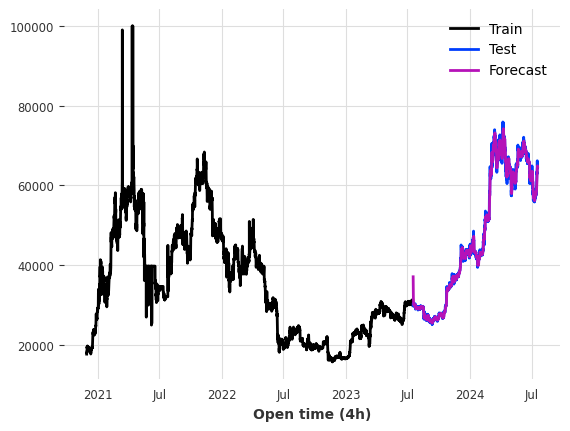

In [98]:
train_ts.plot(label='Train')
test_ts.plot(label='Test')
predictions_inverse.plot(label='Forecast')
plt.legend()

### Testing On Dart's NaiveEnsembleModel

In [100]:
from darts.models import NaiveEnsembleModel, NaiveSeasonal, LinearRegressionModel
from tqdm import tqdm
from darts import TimeSeries
import numpy as np

# Define the components of the ensemble model
naive_seasonal = NaiveSeasonal(K=12)
linear_regression = LinearRegressionModel(lags=4)

# Initialize the ensemble model
model_naive_ensemble = NaiveEnsembleModel([naive_seasonal, linear_regression])

# Fit the model to the training data
model_naive_ensemble.fit(training_transformed)

# Sequentially predict the next close price
predictions = []
history = list(training_transformed.values().flatten())

# Combine train and test indices to extend the time index
combined_index = train.index.append(test.index)

# Initialize tqdm progress bar
for i in tqdm(range(len(testing_transformed)), desc="Predicting", unit="step"):
    # Dynamically create the index for the history
    current_index = combined_index[:len(history)]

    # Ensure history contains only scalar values
    history = [float(x) if isinstance(x, (int, float)) else float(x[0]) for x in history]
    
    # Update the ensemble model with the current value
    model_naive_ensemble = NaiveEnsembleModel([NaiveSeasonal(K=12), LinearRegressionModel(lags=4)])
    model_naive_ensemble.fit(TimeSeries.from_times_and_values(current_index, np.array(history)))
    
    # Predict the next value
    prediction = model_naive_ensemble.predict(1)[-1]
    predictions.append(prediction.values()[0])
    
    # Update the history with the new actual value
    if i < len(testing_transformed):
        history.append(testing_transformed[i].values()[0])

# Inverse transform the predictions
predictions_series = TimeSeries.from_times_and_values(test.index, np.array(predictions))
predictions_inverse = train_and_test_pipeline.inverse_transform(predictions_series)

# Convert predictions to a DataFrame
results = pd.DataFrame({'Actual': test.values.flatten(), 'Predicted': predictions_inverse.values().flatten()}, index=test.index)

# Display the results
results

Predicting: 100%|████████████████████████████████████████████████████████████████| 2197/2197 [00:47<00:00, 45.88step/s]


Actual     Predicted
Open time (4h)                            
2023-07-18 00:00:00  30058.9  37188.334959
2023-07-18 04:00:00  30168.6  34636.777599
2023-07-18 08:00:00  30476.0  34177.056397
2023-07-18 12:00:00  30276.4  33731.145710
2023-07-18 16:00:00  30198.6  33568.782424
...                      ...           ...
2024-07-17 08:00:00  65000.1  63143.309984
2024-07-17 12:00:00  65503.9  63461.800544
2024-07-17 16:00:00  64689.0  64045.192147
2024-07-17 20:00:00  64603.2  63908.707453
2024-07-18 00:00:00  64438.2  63747.918689

[2197 rows x 2 columns]

In [101]:
# Assuming your results DataFrame is named 'results'
# and contains 'Actual' and 'Predicted' columns.

# Define the function to generate signals
def generate_signal(row):
    if row['Actual'] > row['Predicted']:
        return -1
    elif row['Actual'] < row['Predicted']:
        return 1
    else:
        return 0

# Apply the function to create the 'Signal' column
results['Signal'] = results.apply(generate_signal, axis=1)

# Display the updated DataFrame with the 'Signal' column
results

Actual     Predicted  Signal
Open time (4h)                                    
2023-07-18 00:00:00  30058.9  37188.334959      -1
2023-07-18 04:00:00  30168.6  34636.777599      -1
2023-07-18 08:00:00  30476.0  34177.056397      -1
2023-07-18 12:00:00  30276.4  33731.145710      -1
2023-07-18 16:00:00  30198.6  33568.782424      -1
...                      ...           ...     ...
2024-07-17 08:00:00  65000.1  63143.309984       1
2024-07-17 12:00:00  65503.9  63461.800544       1
2024-07-17 16:00:00  64689.0  64045.192147       1
2024-07-17 20:00:00  64603.2  63908.707453       1
2024-07-18 00:00:00  64438.2  63747.918689       1

[2197 rows x 3 columns]

In [102]:
data_4h_signal_naiveenemble = BTCUSDT_Filtered_data_4H[str(results.index[0]): str(results.index[-1])].copy()
data_4h_signal_naiveenemble.loc[:, 'Signal'] = results['Signal']
data_4h_signal_naiveenemble

Open     High      Low    Close     Volume  Signal
Open time (4h)                                                            
2023-07-18 00:00:00  29657.9  30498.0  29657.8  30058.9  66.161904      -1
2023-07-18 04:00:00  29944.1  30599.0  29919.9  30168.6  64.356150      -1
2023-07-18 08:00:00  30548.4  30548.4  30155.0  30476.0  62.437558      -1
2023-07-18 12:00:00  30476.0  30540.0  30155.0  30276.4  94.781367      -1
2023-07-18 16:00:00  30410.0  30410.0  29960.0  30198.6  65.917963      -1
...                      ...      ...      ...      ...        ...     ...
2024-07-17 08:00:00  66196.5  66998.8  63555.0  65000.1   4.510771       1
2024-07-17 12:00:00  65000.1  66000.0  63555.0  65503.9   5.291817       1
2024-07-17 16:00:00  65446.3  66000.0  63892.4  64689.0   5.464083       1
2024-07-17 20:00:00  64669.7  64999.0  64240.0  64603.2   9.204992       1
2024-07-18 00:00:00  64685.6  64776.0  63700.0  64438.2   6.627105       1

[2197 rows x 6 columns]

In [103]:
data_1m_naiveensemble = BTCUSDT_Filtered_data_1M[str(results.index[0]): str(results.index[-1])].copy()
data_1m_naiveensemble

Open     High      Low    Close   Volume
Open time (1M)                                                  
2023-07-18 00:00:00  29657.9  30208.4  29657.9  30027.7   37.307
2023-07-18 00:01:00  29862.7  30013.7  29657.8  29969.3   17.256
2023-07-18 00:02:00  29854.0  30208.4  29657.9  29657.9  245.683
2023-07-18 00:03:00  29657.9  29957.3  29657.9  29658.0   64.483
2023-07-18 00:04:00  29757.0  30232.5  29750.0  30232.5   81.386
...                      ...      ...      ...      ...      ...
2024-07-17 23:56:00  64637.9  64742.9  64242.9  64443.6    6.473
2024-07-17 23:57:00  64443.6  64742.9  64242.9  64700.0    2.546
2024-07-17 23:58:00  64700.0  64700.0  64603.2  64603.2    1.115
2024-07-17 23:59:00  64689.0  64700.0  64603.2  64603.2    0.079
2024-07-18 00:00:00  64685.6  64742.9  64242.9  64438.4    1.644

[527041 rows x 5 columns]

In [104]:
backtest_df_naiveensemble = generate_backtest_df(data_4h_signal_naiveenemble, data_1m_naiveensemble)
backtest_df_naiveensemble

Open time (4h) direction  entry price  close price     action  \
0    2023-07-18 00:00:00     short      29657.9          0.0       None   
1    2023-07-18 05:57:00      long      29657.9      30550.0         sl   
2    2023-07-18 08:00:00     short      30548.4          0.0       None   
3    2023-07-20 08:00:00      long      30548.4      29870.1  direction   
4    2023-07-20 08:00:00      long      29870.1          0.0       None   
...                  ...       ...          ...          ...        ...   
1373 2024-07-15 18:40:00      long      61889.4      59000.2         sl   
1374 2024-07-15 20:00:00      long      62625.8          0.0       None   
1375 2024-07-16 20:03:00      long      62625.8      68025.0         tp   
1376 2024-07-17 00:00:00      long      64670.8          0.0       None   
1377 2024-07-18 00:00:00      long      64670.8      64685.6  direction   

           PNL        Balance  
0          NaN     969.820325  
1    -3.007968     969.820325  
2          NaN     991.257339  
3     2.220411     991.257339  
4          NaN    1008.046367  
...        ...            ...  
1373 -4.668328  898491.283373  
1374       NaN  975863.664463  
1375  8.621367  975863.664463  
1376       NaN  975989.405816  
1377  0.022885  975989.405816  

[1378 rows x 7 columns]

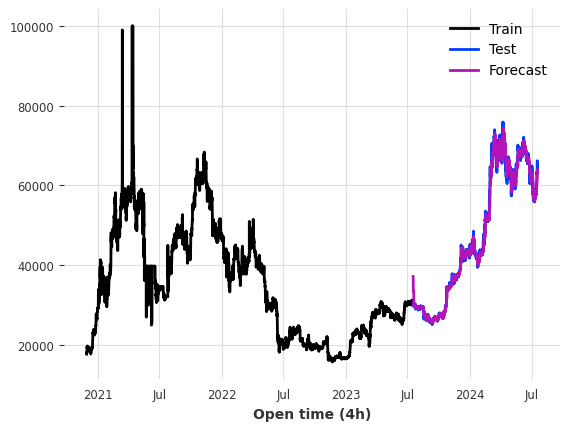

In [105]:
train_ts.plot(label='Train')
test_ts.plot(label='Test')
predictions_inverse.plot(label='Forecast')
plt.legend()

### Testing On Dart's Kalman Forcaster Model: Currently Leaving It Untrained Because It's Taking Too Much Time

In [109]:
from darts.models import KalmanForecaster
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from tqdm import tqdm
from darts import TimeSeries
import numpy as np

# Generate future covariates for the training and testing period
future_cov = datetime_attribute_timeseries(training_transformed, "month", cyclic=True, add_length=2)
# future_cov_test = datetime_attribute_timeseries(testing_transformed, "month", cyclic=True)
# combined_covariates = future_cov_train.append(future_cov_test)

# Initialize the KalmanForecaster with an increased state vector size
model_kalman = KalmanForecaster(dim_x=12)

# Fit the model to the initial training data
model_kalman.fit(training_transformed, future_covariates=future_cov)

# Sequentially predict the next close price
predictions = []
history = list(training_transformed.values().flatten())

# Combine train and test indices to extend the time index
combined_index = train.index.append(test.index)

# Initialize tqdm progress bar
for i in tqdm(range(len(testing_transformed)), desc="Predicting", unit="step"):
    # Dynamically create the index for the history
    current_index = combined_index[:len(history)]

    # Ensure history contains only scalar values
    history = [float(x) if isinstance(x, (int, float)) else float(x[0]) for x in history]
    
    # # Get the corresponding future covariates up to the current step
    # current_covariates = combined_covariates[:len(history)]
    future_cov = datetime_attribute_timeseries(TimeSeries.from_times_and_values(current_index, np.array(history)),
                                                                                "month", cyclic=True, add_length=2)
    
    # Update the KalmanForecaster model with the current history and future covariates
    model_kalman = KalmanForecaster(dim_x=12)
    model_kalman.fit(TimeSeries.from_times_and_values(current_index, np.array(history)),
                     future_covariates=future_cov)
    
    # Predict the next value
    prediction = model_kalman.predict(1, future_covariates=future_cov)[-1]
    predictions.append(prediction.values()[0])
    
    # Update the history with the new actual value
    if i < len(testing_transformed):
        history.append(testing_transformed[i].values()[0])

# Inverse transform the predictions
predictions_series = TimeSeries.from_times_and_values(test.index, np.array(predictions))
predictions_inverse = train_and_test_pipeline.inverse_transform(predictions_series)

# Convert predictions to a DataFrame
results = pd.DataFrame({'Actual': test.values.flatten(), 'Predicted': predictions_inverse.values().flatten()}, index=test.index)

# Display the results
results

Predicting:   1%|▋                                                               | 22/2197 [01:45<2:53:11,  4.78s/step]


KeyboardInterrupt: 

In [ ]:
# Assuming your results DataFrame is named 'results'
# and contains 'Actual' and 'Predicted' columns.

# Define the function to generate signals
def generate_signal(row):
    if row['Actual'] > row['Predicted']:
        return -1
    elif row['Actual'] < row['Predicted']:
        return 1
    else:
        return 0

# Apply the function to create the 'Signal' column
results['Signal'] = results.apply(generate_signal, axis=1)

# Display the updated DataFrame with the 'Signal' column
results

In [ ]:
data_4h_signal_kalman = BTCUSDT_Filtered_data_4H[str(results.index[0]): str(results.index[-1])].copy()
data_4h_signal_kalman.loc[:, 'Signal'] = results['Signal']
data_4h_signal_kalman

In [ ]:
data_1m_kalman = BTCUSDT_Filtered_data_1M[str(results.index[0]): str(results.index[-1])].copy()
data_1m_kalman

In [ ]:
backtest_df_kalman = generate_backtest_df(data_4h_signal_kalman, data_1m_kalman)
backtest_df_kalman

In [ ]:
train_ts.plot(label='Train')
test_ts.plot(label='Test')
predictions_inverse.plot(label='Forecast')
plt.legend()

### Testing On Dart's TBATS Model: Currently Leaving It Untrained Because It's Taking Too Much Time

In [110]:
from darts.models import TBATS
from tqdm import tqdm
from darts import TimeSeries
import numpy as np

# Initialize the TBATS model
model_tbats = TBATS(use_trend=True)

# Fit the model to the initial training data
model_tbats.fit(training_transformed)

# Sequentially predict the next close price
predictions = []
history = list(training_transformed.values().flatten())

# Combine train and test indices to extend the time index
combined_index = train.index.append(test.index)

# Initialize tqdm progress bar
for i in tqdm(range(len(testing_transformed)), desc="Predicting", unit="step"):
    # Dynamically create the index for the history
    current_index = combined_index[:len(history)]

    # Ensure history contains only scalar values
    history = [float(x) if isinstance(x, (int, float)) else float(x[0]) for x in history]
    
    # Update the TBATS model with the current history
    model_tbats = TBATS(use_trend=True)
    model_tbats.fit(TimeSeries.from_times_and_values(current_index, np.array(history)))
    
    # Predict the next value
    prediction = model_tbats.predict(1)[-1]
    predictions.append(prediction.values()[0])
    
    # Update the history with the new actual value
    if i < len(testing_transformed):
        history.append(testing_transformed[i].values()[0])

# Inverse transform the predictions
predictions_series = TimeSeries.from_times_and_values(test.index, np.array(predictions))
predictions_inverse = train_and_test_pipeline.inverse_transform(predictions_series)

# Convert predictions to a DataFrame
results = pd.DataFrame({'Actual': test.values.flatten(), 'Predicted': predictions_inverse.values().flatten()}, index=test.index)

# Display the results
results

KeyboardInterrupt: 

In [ ]:
# Assuming your results DataFrame is named 'results'
# and contains 'Actual' and 'Predicted' columns.

# Define the function to generate signals
def generate_signal(row):
    if row['Actual'] > row['Predicted']:
        return -1
    elif row['Actual'] < row['Predicted']:
        return 1
    else:
        return 0

# Apply the function to create the 'Signal' column
results['Signal'] = results.apply(generate_signal, axis=1)

# Display the updated DataFrame with the 'Signal' column
results

In [ ]:
data_4h_signal_tbats = BTCUSDT_Filtered_data_4H[str(results.index[0]): str(results.index[-1])].copy()
data_4h_signal_tbats.loc[:, 'Signal'] = results['Signal']
data_4h_signal_tbats

In [ ]:
data_1m_tbats = BTCUSDT_Filtered_data_1M[str(results.index[0]): str(results.index[-1])].copy()
data_1m_tbats

In [ ]:
backtest_df_tbats = generate_backtest_df(data_4h_signal_tbats, data_1m_tbats)
backtest_df_tbats

In [ ]:
train_ts.plot(label='Train')
test_ts.plot(label='Test')
predictions_inverse.plot(label='Forecast')
plt.legend()

### Testing On Dart's RNN Model: Currently Leaving It Untrained Because It's Taking Too Much Time

In [112]:
from darts.models import RNNModel
from tqdm import tqdm
from darts import TimeSeries
import numpy as np

# Initialize the RNN model
model_rnn = RNNModel(
    model="RNN",
    input_chunk_length=6,
    training_length=18,
    n_epochs=1,
)

# Fit the model to the initial training data
model_rnn.fit(training_transformed)

# Sequentially predict the next close price
predictions = []
history = list(training_transformed.values().flatten())

# Combine train and test indices to extend the time index
combined_index = train.index.append(test.index)

# Initialize tqdm progress bar
for i in tqdm(range(len(testing_transformed)), desc="Predicting", unit="step"):
    # Dynamically create the index for the history
    current_index = combined_index[:len(history)]

    # Ensure history contains only scalar values
    history = [float(x) if isinstance(x, (int, float)) else float(x[0]) for x in history]
    
    # Create a TimeSeries object from the current history
    series = TimeSeries.from_times_and_values(current_index, np.array(history))
    
    # Re-initialize the RNN model for each prediction
    model_rnn = RNNModel(
        model="RNN",
        input_chunk_length=6,
        training_length=18,
        n_epochs=1,
    )
    
    # Fit the model with the updated series
    model_rnn.fit(series)
    
    # Predict the next value
    prediction = model_rnn.predict(1)[-1]
    predictions.append(prediction.values()[0])
    
    # Update the history with the new actual value
    if i < len(testing_transformed):
        history.append(testing_transformed[i].values()[0])

# Inverse transform the predictions
predictions_series = TimeSeries.from_times_and_values(test.index, np.array(predictions))
predictions_inverse = train_and_test_pipeline.inverse_transform(predictions_series)

# Convert predictions to a DataFrame
results = pd.DataFrame({'Actual': test.values.flatten(), 'Predicted': predictions_inverse.values().flatten()}, index=test.index)

# Display the results
results

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | RNN              | 700    | train
6 | V               | Linear           | 26     | train
-------------------------------------------------------------
726       Trainable params
0         Non-trainable params
726       Total params
0.003     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=1` reached.

Predicting:   0%|                                                                           | 0/2197 [00:00<?, ?step/s]GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | RNN              | 700    | train
6 | V               | Linear           | 26     | train
-------------------------------------------------------------
726       Trainable params
0         Non-trainable params
726       Total params
0.003     Total estimated model params size (MB)
7         Modules i

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=1` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…


Predicting:   0%|                                                                 | 1/2197 [00:05<3:24:35,  5.59s/step]GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | RNN              | 700    | train
6 | V               | Linear           | 26     | train
-------------------------------------------------------------
726       Trainable params
0         Non-trainable params
726       Total params
0.003     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=1` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…


Predicting:   0%|                                                                 | 2/2197 [00:11<3:28:22,  5.70s/step]GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | RNN              | 700    | train
6 | V               | Linear           | 26     | train
-------------------------------------------------------------
726       Trainable params
0         Non-trainable params
726       Total params
0.003     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=1` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…


Predicting:   0%|                                                                 | 3/2197 [00:16<3:27:10,  5.67s/step]GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | RNN              | 700    | train
6 | V               | Linear           | 26     | train
-------------------------------------------------------------
726       Trainable params
0         Non-trainable params
726       Total params
0.003     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=1` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…


Predicting:   0%|                                                                 | 4/2197 [00:23<3:36:36,  5.93s/step]GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | RNN              | 700    | train
6 | V               | Linear           | 26     | train
-------------------------------------------------------------
726       Trainable params
0         Non-trainable params
726       Total params
0.003     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=1` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…


Predicting:   0%|▏                                                                | 5/2197 [00:29<3:33:23,  5.84s/step]GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | RNN              | 700    | train
6 | V               | Linear           | 26     | train
-------------------------------------------------------------
726       Trainable params
0         Non-trainable params
726       Total params
0.003     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=1` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…


Predicting:   0%|▏                                                                | 6/2197 [00:34<3:33:58,  5.86s/step]GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | RNN              | 700    | train
6 | V               | Linear           | 26     | train
-------------------------------------------------------------
726       Trainable params
0         Non-trainable params
726       Total params
0.003     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=1` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…


Predicting:   0%|▏                                                                | 7/2197 [00:40<3:31:50,  5.80s/step]GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | RNN              | 700    | train
6 | V               | Linear           | 26     | train
-------------------------------------------------------------
726       Trainable params
0         Non-trainable params
726       Total params
0.003     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=1` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…


Predicting:   0%|▏                                                                | 8/2197 [00:46<3:32:51,  5.83s/step]GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | RNN              | 700    | train
6 | V               | Linear           | 26     | train
-------------------------------------------------------------
726       Trainable params
0         Non-trainable params
726       Total params
0.003     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=1` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…


Predicting:   0%|▎                                                                | 9/2197 [00:52<3:30:32,  5.77s/step]GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | RNN              | 700    | train
6 | V               | Linear           | 26     | train
-------------------------------------------------------------
726       Trainable params
0         Non-trainable params
726       Total params
0.003     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=1` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…


Predicting:   0%|▎                                                               | 10/2197 [00:57<3:29:58,  5.76s/step]GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | RNN              | 700    | train
6 | V               | Linear           | 26     | train
-------------------------------------------------------------
726       Trainable params
0         Non-trainable params
726       Total params
0.003     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=1` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…


Predicting:   1%|▎                                                               | 11/2197 [01:03<3:30:38,  5.78s/step]GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | RNN              | 700    | train
6 | V               | Linear           | 26     | train
-------------------------------------------------------------
726       Trainable params
0         Non-trainable params
726       Total params
0.003     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=1` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…


Predicting:   1%|▎                                                               | 12/2197 [01:09<3:31:27,  5.81s/step]GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | RNN              | 700    | train
6 | V               | Linear           | 26     | train
-------------------------------------------------------------
726       Trainable params
0         Non-trainable params
726       Total params
0.003     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=1` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…


Predicting:   1%|▍                                                               | 13/2197 [01:15<3:30:24,  5.78s/step]GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | RNN              | 700    | train
6 | V               | Linear           | 26     | train
-------------------------------------------------------------
726       Trainable params
0         Non-trainable params
726       Total params
0.003     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=1` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…


Predicting:   1%|▍                                                               | 14/2197 [01:20<3:27:50,  5.71s/step]GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | RNN              | 700    | train
6 | V               | Linear           | 26     | train
-------------------------------------------------------------
726       Trainable params
0         Non-trainable params
726       Total params
0.003     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=1` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…


Predicting:   1%|▍                                                               | 15/2197 [01:26<3:25:57,  5.66s/step]GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | RNN              | 700    | train
6 | V               | Linear           | 26     | train
-------------------------------------------------------------
726       Trainable params
0         Non-trainable params
726       Total params
0.003     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=1` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…


Predicting:   1%|▍                                                               | 16/2197 [01:32<3:28:01,  5.72s/step]GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | RNN              | 700    | train
6 | V               | Linear           | 26     | train
-------------------------------------------------------------
726       Trainable params
0         Non-trainable params
726       Total params
0.003     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=1` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…


Predicting:   1%|▍                                                               | 17/2197 [01:37<3:27:07,  5.70s/step]GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | RNN              | 700    | train
6 | V               | Linear           | 26     | train
-------------------------------------------------------------
726       Trainable params
0         Non-trainable params
726       Total params
0.003     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=1` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…


Predicting:   1%|▌                                                               | 18/2197 [01:43<3:25:42,  5.66s/step]GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | RNN              | 700    | train
6 | V               | Linear           | 26     | train
-------------------------------------------------------------
726       Trainable params
0         Non-trainable params
726       Total params
0.003     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=1` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…


Predicting:   1%|▌                                                               | 19/2197 [01:49<3:24:22,  5.63s/step]GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | RNN              | 700    | train
6 | V               | Linear           | 26     | train
-------------------------------------------------------------
726       Trainable params
0         Non-trainable params
726       Total params
0.003     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=1` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…


Predicting:   1%|▌                                                               | 20/2197 [01:54<3:23:24,  5.61s/step]GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | RNN              | 700    | train
6 | V               | Linear           | 26     | train
-------------------------------------------------------------
726       Trainable params
0         Non-trainable params
726       Total params
0.003     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=1` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…


Predicting:   1%|▌                                                               | 21/2197 [02:00<3:24:13,  5.63s/step]GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | RNN              | 700    | train
6 | V               | Linear           | 26     | train
-------------------------------------------------------------
726       Trainable params
0         Non-trainable params
726       Total params
0.003     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=1` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…


Predicting:   1%|▋                                                               | 22/2197 [02:05<3:24:59,  5.65s/step]GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | RNN              | 700    | train
6 | V               | Linear           | 26     | train
-------------------------------------------------------------
726       Trainable params
0         Non-trainable params
726       Total params
0.003     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=1` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…


Predicting:   1%|▋                                                               | 23/2197 [02:12<3:31:18,  5.83s/step]GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | RNN              | 700    | train
6 | V               | Linear           | 26     | train
-------------------------------------------------------------
726       Trainable params
0         Non-trainable params
726       Total params
0.003     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Training: |                                                                                      | 0/? [00:00<…


Detected KeyboardInterrupt, attempting graceful shutdown ...
Predicting:   1%|▋                                                               | 23/2197 [02:13<3:30:00,  5.80s/step]


NameError: name 'exit' is not defined

In [ ]:
# Assuming your results DataFrame is named 'results'
# and contains 'Actual' and 'Predicted' columns.

# Define the function to generate signals
def generate_signal(row):
    if row['Actual'] > row['Predicted']:
        return -1
    elif row['Actual'] < row['Predicted']:
        return 1
    else:
        return 0

# Apply the function to create the 'Signal' column
results['Signal'] = results.apply(generate_signal, axis=1)

# Display the updated DataFrame with the 'Signal' column
results

In [ ]:
data_4h_signal_rnn = BTCUSDT_Filtered_data_4H[str(results.index[0]): str(results.index[-1])].copy()
data_4h_signal_rnn.loc[:, 'Signal'] = results['Signal']
data_4h_signal_rnn

In [ ]:
data_1m_rnn = BTCUSDT_Filtered_data_1M[str(results.index[0]): str(results.index[-1])].copy()
data_1m_rnn

In [ ]:
backtest_df_rnn = generate_backtest_df(data_4h_signal_rnn, data_1m_rnn)
backtest_df_rnn

In [ ]:
train_ts.plot(label='Train')
test_ts.plot(label='Test')
predictions_inverse.plot(label='Forecast')
plt.legend()

### Testing On Dart's TiDE Model: Currently Leaving It Untrained Because It's Taking Too Much Time

In [113]:
from darts.models import TiDEModel
from tqdm import tqdm
from darts import TimeSeries
import numpy as np

# Initialize the TiDE model
model_tide = TiDEModel(
    input_chunk_length=6,
    output_chunk_length=6,
    n_epochs=1
)

# Fit the model to the initial training data
model_tide.fit(training_transformed)

# Sequentially predict the next close price
predictions = []
history = list(training_transformed.values().flatten())

# Combine train and test indices to extend the time index
combined_index = train.index.append(test.index)

# Initialize tqdm progress bar
for i in tqdm(range(len(testing_transformed)), desc="Predicting", unit="step"):
    # Dynamically create the index for the history
    current_index = combined_index[:len(history)]

    # Ensure history contains only scalar values
    history = [float(x) if isinstance(x, (int, float)) else float(x[0]) for x in history]
    
    # Create a TimeSeries object from the current history
    series = TimeSeries.from_times_and_values(current_index, np.array(history))
    
    # Re-initialize the TiDE model for each prediction
    model_tide = TiDEModel(
        input_chunk_length=6,
        output_chunk_length=6,
        n_epochs=1
    )
    
    # Fit the model with the updated series
    model_tide.fit(series)
    
    # Predict the next value
    prediction = model_tide.predict(1)[-1]
    predictions.append(prediction.values()[0])
    
    # Update the history with the new actual value
    if i < len(testing_transformed):
        history.append(testing_transformed[i].values()[0])

# Inverse transform the predictions
predictions_series = TimeSeries.from_times_and_values(test.index, np.array(predictions))
predictions_inverse = train_and_test_pipeline.inverse_transform(predictions_series)

# Convert predictions to a DataFrame
results = pd.DataFrame({'Actual': test.values.flatten(), 'Predicted': predictions_inverse.values().flatten()}, index=test.index)

# Display the results
results

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name             | Type             | Params | Mode 
--------------------------------------------------------------
0 | criterion        | MSELoss          | 0      | train
1 | train_criterion  | MSELoss          | 0      | train
2 | val_criterion    | MSELoss          | 0      | train
3 | train_metrics    | MetricCollection | 0      | train
4 | val_metrics      | MetricCollection | 0      | train
5 | encoders         | Sequential       | 18.3 K | train
6 | decoders         | Sequential       | 41.3 K | train
7 | temporal_decoder | _ResidualBlock   | 594    | train
8 | lookback_skip    | Linear           | 42     | train
--------------------------------------------------------------
60.2 K    Trainable params
0         Non-trainable params
60.2 K    Total params
0.241     Total estimated model params size (MB)
29        Modules in train mode
0         Modules in eval mode

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=1` reached.

Predicting:   0%|                                                                           | 0/2197 [00:00<?, ?step/s]GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name             | Type             | Params | Mode 
--------------------------------------------------------------
0 | criterion        | MSELoss          | 0      | train
1 | train_criterion  | MSELoss          | 0      | train
2 | val_criterion    | MSELoss          | 0      | train
3 | train_metrics    | MetricCollection | 0      | train
4 | val_metrics      | MetricCollection | 0      | train
5 | encoders         | Sequential       | 18.3 K | train
6 | decoders         | Sequential       | 41.3 K | train
7 | temporal_decoder | _ResidualBlock   | 594    | train
8 | lookback_skip    | Linear           | 42     | train
--------------------------------------------------------------
60.2 K    Trainable param

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=1` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…


Predicting:   0%|                                                                 | 1/2197 [00:07<4:29:42,  7.37s/step]GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name             | Type             | Params | Mode 
--------------------------------------------------------------
0 | criterion        | MSELoss          | 0      | train
1 | train_criterion  | MSELoss          | 0      | train
2 | val_criterion    | MSELoss          | 0      | train
3 | train_metrics    | MetricCollection | 0      | train
4 | val_metrics      | MetricCollection | 0      | train
5 | encoders         | Sequential       | 18.3 K | train
6 | decoders         | Sequential       | 41.3 K | train
7 | temporal_decoder | _ResidualBlock   | 594    | train
8 | lookback_skip    | Linear           | 42     | train
--------------------------------------------------------------
60.2 K    Trainable params
0         Non-trainable params
60.2 K    Tota

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=1` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…


Predicting:   0%|                                                                 | 2/2197 [00:14<4:34:52,  7.51s/step]GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name             | Type             | Params | Mode 
--------------------------------------------------------------
0 | criterion        | MSELoss          | 0      | train
1 | train_criterion  | MSELoss          | 0      | train
2 | val_criterion    | MSELoss          | 0      | train
3 | train_metrics    | MetricCollection | 0      | train
4 | val_metrics      | MetricCollection | 0      | train
5 | encoders         | Sequential       | 18.3 K | train
6 | decoders         | Sequential       | 41.3 K | train
7 | temporal_decoder | _ResidualBlock   | 594    | train
8 | lookback_skip    | Linear           | 42     | train
--------------------------------------------------------------
60.2 K    Trainable params
0         Non-trainable params
60.2 K    Tota

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=1` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…


Predicting:   0%|                                                                 | 3/2197 [00:22<4:29:45,  7.38s/step]GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name             | Type             | Params | Mode 
--------------------------------------------------------------
0 | criterion        | MSELoss          | 0      | train
1 | train_criterion  | MSELoss          | 0      | train
2 | val_criterion    | MSELoss          | 0      | train
3 | train_metrics    | MetricCollection | 0      | train
4 | val_metrics      | MetricCollection | 0      | train
5 | encoders         | Sequential       | 18.3 K | train
6 | decoders         | Sequential       | 41.3 K | train
7 | temporal_decoder | _ResidualBlock   | 594    | train
8 | lookback_skip    | Linear           | 42     | train
--------------------------------------------------------------
60.2 K    Trainable params
0         Non-trainable params
60.2 K    Tota

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=1` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…


Predicting:   0%|                                                                 | 4/2197 [00:29<4:26:16,  7.29s/step]GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name             | Type             | Params | Mode 
--------------------------------------------------------------
0 | criterion        | MSELoss          | 0      | train
1 | train_criterion  | MSELoss          | 0      | train
2 | val_criterion    | MSELoss          | 0      | train
3 | train_metrics    | MetricCollection | 0      | train
4 | val_metrics      | MetricCollection | 0      | train
5 | encoders         | Sequential       | 18.3 K | train
6 | decoders         | Sequential       | 41.3 K | train
7 | temporal_decoder | _ResidualBlock   | 594    | train
8 | lookback_skip    | Linear           | 42     | train
--------------------------------------------------------------
60.2 K    Trainable params
0         Non-trainable params
60.2 K    Tota

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=1` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…


Predicting:   0%|▏                                                                | 5/2197 [00:36<4:25:31,  7.27s/step]GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name             | Type             | Params | Mode 
--------------------------------------------------------------
0 | criterion        | MSELoss          | 0      | train
1 | train_criterion  | MSELoss          | 0      | train
2 | val_criterion    | MSELoss          | 0      | train
3 | train_metrics    | MetricCollection | 0      | train
4 | val_metrics      | MetricCollection | 0      | train
5 | encoders         | Sequential       | 18.3 K | train
6 | decoders         | Sequential       | 41.3 K | train
7 | temporal_decoder | _ResidualBlock   | 594    | train
8 | lookback_skip    | Linear           | 42     | train
--------------------------------------------------------------
60.2 K    Trainable params
0         Non-trainable params
60.2 K    Tota

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=1` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…


Predicting:   0%|▏                                                                | 6/2197 [00:44<4:28:01,  7.34s/step]GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name             | Type             | Params | Mode 
--------------------------------------------------------------
0 | criterion        | MSELoss          | 0      | train
1 | train_criterion  | MSELoss          | 0      | train
2 | val_criterion    | MSELoss          | 0      | train
3 | train_metrics    | MetricCollection | 0      | train
4 | val_metrics      | MetricCollection | 0      | train
5 | encoders         | Sequential       | 18.3 K | train
6 | decoders         | Sequential       | 41.3 K | train
7 | temporal_decoder | _ResidualBlock   | 594    | train
8 | lookback_skip    | Linear           | 42     | train
--------------------------------------------------------------
60.2 K    Trainable params
0         Non-trainable params
60.2 K    Tota

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=1` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…


Predicting:   0%|▏                                                                | 7/2197 [00:51<4:23:35,  7.22s/step]GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name             | Type             | Params | Mode 
--------------------------------------------------------------
0 | criterion        | MSELoss          | 0      | train
1 | train_criterion  | MSELoss          | 0      | train
2 | val_criterion    | MSELoss          | 0      | train
3 | train_metrics    | MetricCollection | 0      | train
4 | val_metrics      | MetricCollection | 0      | train
5 | encoders         | Sequential       | 18.3 K | train
6 | decoders         | Sequential       | 41.3 K | train
7 | temporal_decoder | _ResidualBlock   | 594    | train
8 | lookback_skip    | Linear           | 42     | train
--------------------------------------------------------------
60.2 K    Trainable params
0         Non-trainable params
60.2 K    Tota

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=1` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…


Predicting:   0%|▏                                                                | 8/2197 [00:58<4:21:32,  7.17s/step]GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name             | Type             | Params | Mode 
--------------------------------------------------------------
0 | criterion        | MSELoss          | 0      | train
1 | train_criterion  | MSELoss          | 0      | train
2 | val_criterion    | MSELoss          | 0      | train
3 | train_metrics    | MetricCollection | 0      | train
4 | val_metrics      | MetricCollection | 0      | train
5 | encoders         | Sequential       | 18.3 K | train
6 | decoders         | Sequential       | 41.3 K | train
7 | temporal_decoder | _ResidualBlock   | 594    | train
8 | lookback_skip    | Linear           | 42     | train
--------------------------------------------------------------
60.2 K    Trainable params
0         Non-trainable params
60.2 K    Tota

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=1` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…


Predicting:   0%|▎                                                                | 9/2197 [01:05<4:25:54,  7.29s/step]GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name             | Type             | Params | Mode 
--------------------------------------------------------------
0 | criterion        | MSELoss          | 0      | train
1 | train_criterion  | MSELoss          | 0      | train
2 | val_criterion    | MSELoss          | 0      | train
3 | train_metrics    | MetricCollection | 0      | train
4 | val_metrics      | MetricCollection | 0      | train
5 | encoders         | Sequential       | 18.3 K | train
6 | decoders         | Sequential       | 41.3 K | train
7 | temporal_decoder | _ResidualBlock   | 594    | train
8 | lookback_skip    | Linear           | 42     | train
--------------------------------------------------------------
60.2 K    Trainable params
0         Non-trainable params
60.2 K    Tota

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=1` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…


Predicting:   0%|▎                                                               | 10/2197 [01:12<4:21:57,  7.19s/step]GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name             | Type             | Params | Mode 
--------------------------------------------------------------
0 | criterion        | MSELoss          | 0      | train
1 | train_criterion  | MSELoss          | 0      | train
2 | val_criterion    | MSELoss          | 0      | train
3 | train_metrics    | MetricCollection | 0      | train
4 | val_metrics      | MetricCollection | 0      | train
5 | encoders         | Sequential       | 18.3 K | train
6 | decoders         | Sequential       | 41.3 K | train
7 | temporal_decoder | _ResidualBlock   | 594    | train
8 | lookback_skip    | Linear           | 42     | train
--------------------------------------------------------------
60.2 K    Trainable params
0         Non-trainable params
60.2 K    Tota

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=1` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…


Predicting:   1%|▎                                                               | 11/2197 [01:19<4:20:32,  7.15s/step]GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name             | Type             | Params | Mode 
--------------------------------------------------------------
0 | criterion        | MSELoss          | 0      | train
1 | train_criterion  | MSELoss          | 0      | train
2 | val_criterion    | MSELoss          | 0      | train
3 | train_metrics    | MetricCollection | 0      | train
4 | val_metrics      | MetricCollection | 0      | train
5 | encoders         | Sequential       | 18.3 K | train
6 | decoders         | Sequential       | 41.3 K | train
7 | temporal_decoder | _ResidualBlock   | 594    | train
8 | lookback_skip    | Linear           | 42     | train
--------------------------------------------------------------
60.2 K    Trainable params
0         Non-trainable params
60.2 K    Tota

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=1` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…


Predicting:   1%|▎                                                               | 12/2197 [01:26<4:16:51,  7.05s/step]GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name             | Type             | Params | Mode 
--------------------------------------------------------------
0 | criterion        | MSELoss          | 0      | train
1 | train_criterion  | MSELoss          | 0      | train
2 | val_criterion    | MSELoss          | 0      | train
3 | train_metrics    | MetricCollection | 0      | train
4 | val_metrics      | MetricCollection | 0      | train
5 | encoders         | Sequential       | 18.3 K | train
6 | decoders         | Sequential       | 41.3 K | train
7 | temporal_decoder | _ResidualBlock   | 594    | train
8 | lookback_skip    | Linear           | 42     | train
--------------------------------------------------------------
60.2 K    Trainable params
0         Non-trainable params
60.2 K    Tota

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=1` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…


Predicting:   1%|▍                                                               | 13/2197 [01:33<4:17:55,  7.09s/step]GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name             | Type             | Params | Mode 
--------------------------------------------------------------
0 | criterion        | MSELoss          | 0      | train
1 | train_criterion  | MSELoss          | 0      | train
2 | val_criterion    | MSELoss          | 0      | train
3 | train_metrics    | MetricCollection | 0      | train
4 | val_metrics      | MetricCollection | 0      | train
5 | encoders         | Sequential       | 18.3 K | train
6 | decoders         | Sequential       | 41.3 K | train
7 | temporal_decoder | _ResidualBlock   | 594    | train
8 | lookback_skip    | Linear           | 42     | train
--------------------------------------------------------------
60.2 K    Trainable params
0         Non-trainable params
60.2 K    Tota

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=1` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…


Predicting:   1%|▍                                                               | 14/2197 [01:40<4:17:16,  7.07s/step]GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name             | Type             | Params | Mode 
--------------------------------------------------------------
0 | criterion        | MSELoss          | 0      | train
1 | train_criterion  | MSELoss          | 0      | train
2 | val_criterion    | MSELoss          | 0      | train
3 | train_metrics    | MetricCollection | 0      | train
4 | val_metrics      | MetricCollection | 0      | train
5 | encoders         | Sequential       | 18.3 K | train
6 | decoders         | Sequential       | 41.3 K | train
7 | temporal_decoder | _ResidualBlock   | 594    | train
8 | lookback_skip    | Linear           | 42     | train
--------------------------------------------------------------
60.2 K    Trainable params
0         Non-trainable params
60.2 K    Tota

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=1` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…


Predicting:   1%|▍                                                               | 15/2197 [01:47<4:18:42,  7.11s/step]GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name             | Type             | Params | Mode 
--------------------------------------------------------------
0 | criterion        | MSELoss          | 0      | train
1 | train_criterion  | MSELoss          | 0      | train
2 | val_criterion    | MSELoss          | 0      | train
3 | train_metrics    | MetricCollection | 0      | train
4 | val_metrics      | MetricCollection | 0      | train
5 | encoders         | Sequential       | 18.3 K | train
6 | decoders         | Sequential       | 41.3 K | train
7 | temporal_decoder | _ResidualBlock   | 594    | train
8 | lookback_skip    | Linear           | 42     | train
--------------------------------------------------------------
60.2 K    Trainable params
0         Non-trainable params
60.2 K    Tota

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=1` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…


Predicting:   1%|▍                                                               | 16/2197 [01:55<4:19:38,  7.14s/step]GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name             | Type             | Params | Mode 
--------------------------------------------------------------
0 | criterion        | MSELoss          | 0      | train
1 | train_criterion  | MSELoss          | 0      | train
2 | val_criterion    | MSELoss          | 0      | train
3 | train_metrics    | MetricCollection | 0      | train
4 | val_metrics      | MetricCollection | 0      | train
5 | encoders         | Sequential       | 18.3 K | train
6 | decoders         | Sequential       | 41.3 K | train
7 | temporal_decoder | _ResidualBlock   | 594    | train
8 | lookback_skip    | Linear           | 42     | train
--------------------------------------------------------------
60.2 K    Trainable params
0         Non-trainable params
60.2 K    Tota

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=1` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…


Predicting:   1%|▍                                                               | 17/2197 [02:02<4:17:12,  7.08s/step]GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name             | Type             | Params | Mode 
--------------------------------------------------------------
0 | criterion        | MSELoss          | 0      | train
1 | train_criterion  | MSELoss          | 0      | train
2 | val_criterion    | MSELoss          | 0      | train
3 | train_metrics    | MetricCollection | 0      | train
4 | val_metrics      | MetricCollection | 0      | train
5 | encoders         | Sequential       | 18.3 K | train
6 | decoders         | Sequential       | 41.3 K | train
7 | temporal_decoder | _ResidualBlock   | 594    | train
8 | lookback_skip    | Linear           | 42     | train
--------------------------------------------------------------
60.2 K    Trainable params
0         Non-trainable params
60.2 K    Tota

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=1` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…


Predicting:   1%|▌                                                               | 18/2197 [02:09<4:16:22,  7.06s/step]GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name             | Type             | Params | Mode 
--------------------------------------------------------------
0 | criterion        | MSELoss          | 0      | train
1 | train_criterion  | MSELoss          | 0      | train
2 | val_criterion    | MSELoss          | 0      | train
3 | train_metrics    | MetricCollection | 0      | train
4 | val_metrics      | MetricCollection | 0      | train
5 | encoders         | Sequential       | 18.3 K | train
6 | decoders         | Sequential       | 41.3 K | train
7 | temporal_decoder | _ResidualBlock   | 594    | train
8 | lookback_skip    | Linear           | 42     | train
--------------------------------------------------------------
60.2 K    Trainable params
0         Non-trainable params
60.2 K    Tota

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=1` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…


Predicting:   1%|▌                                                               | 19/2197 [02:16<4:15:20,  7.03s/step]GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name             | Type             | Params | Mode 
--------------------------------------------------------------
0 | criterion        | MSELoss          | 0      | train
1 | train_criterion  | MSELoss          | 0      | train
2 | val_criterion    | MSELoss          | 0      | train
3 | train_metrics    | MetricCollection | 0      | train
4 | val_metrics      | MetricCollection | 0      | train
5 | encoders         | Sequential       | 18.3 K | train
6 | decoders         | Sequential       | 41.3 K | train
7 | temporal_decoder | _ResidualBlock   | 594    | train
8 | lookback_skip    | Linear           | 42     | train
--------------------------------------------------------------
60.2 K    Trainable params
0         Non-trainable params
60.2 K    Tota

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=1` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…


Predicting:   1%|▌                                                               | 20/2197 [02:23<4:14:38,  7.02s/step]GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name             | Type             | Params | Mode 
--------------------------------------------------------------
0 | criterion        | MSELoss          | 0      | train
1 | train_criterion  | MSELoss          | 0      | train
2 | val_criterion    | MSELoss          | 0      | train
3 | train_metrics    | MetricCollection | 0      | train
4 | val_metrics      | MetricCollection | 0      | train
5 | encoders         | Sequential       | 18.3 K | train
6 | decoders         | Sequential       | 41.3 K | train
7 | temporal_decoder | _ResidualBlock   | 594    | train
8 | lookback_skip    | Linear           | 42     | train
--------------------------------------------------------------
60.2 K    Trainable params
0         Non-trainable params
60.2 K    Tota

Training: |                                                                                      | 0/? [00:00<…


Detected KeyboardInterrupt, attempting graceful shutdown ...
Predicting:   1%|▌                                                               | 20/2197 [02:26<4:25:54,  7.33s/step]


NameError: name 'exit' is not defined

In [ ]:
# Assuming your results DataFrame is named 'results'
# and contains 'Actual' and 'Predicted' columns.

# Define the function to generate signals
def generate_signal(row):
    if row['Actual'] > row['Predicted']:
        return -1
    elif row['Actual'] < row['Predicted']:
        return 1
    else:
        return 0

# Apply the function to create the 'Signal' column
results['Signal'] = results.apply(generate_signal, axis=1)

# Display the updated DataFrame with the 'Signal' column
results

In [ ]:
data_4h_signal_tide = BTCUSDT_Filtered_data_4H[str(results.index[0]): str(results.index[-1])].copy()
data_4h_signal_tide.loc[:, 'Signal'] = results['Signal']
data_4h_signal_tide

In [ ]:
data_1m_tide = BTCUSDT_Filtered_data_1M[str(results.index[0]): str(results.index[-1])].copy()
data_1m_tide

In [ ]:
backtest_df_tide = generate_backtest_df(data_4h_signal_tide, data_1m_tide)
backtest_df_tide

In [ ]:
train_ts.plot(label='Train')
test_ts.plot(label='Test')
predictions_inverse.plot(label='Forecast')
plt.legend()

### Testing On Dart's XGBoost Model: Currently Leaving It Untrained Because It's Taking Too Much Time

In [114]:
from darts.models import XGBModel
from tqdm import tqdm
from darts import TimeSeries
import numpy as np

# Initialize the XGB model
model_xgboost = XGBModel(
    lags=12,
    output_chunk_length=6
)

# Fit the model to the initial training data
model_xgboost.fit(training_transformed)

# Sequentially predict the next close price
predictions = []
history = list(training_transformed.values().flatten())

# Combine train and test indices to extend the time index
combined_index = train.index.append(test.index)

# Initialize tqdm progress bar
for i in tqdm(range(len(testing_transformed)), desc="Predicting", unit="step"):
    # Dynamically create the index for the history
    current_index = combined_index[:len(history)]

    # Ensure history contains only scalar values
    history = [float(x) if isinstance(x, (int, float)) else float(x[0]) for x in history]
    
    # Create a TimeSeries object from the current history
    series = TimeSeries.from_times_and_values(current_index, np.array(history))
    
    # Re-initialize the XGBModel for each prediction
    model_xgboost = XGBModel(
        lags=12,
        output_chunk_length=6
    )
    
    # Fit the model with the updated series
    model_xgboost.fit(series)
    
    # Predict the next value
    prediction = model_xgboost.predict(1)[-1]
    predictions.append(prediction.values()[0])
    
    # Update the history with the new actual value
    if i < len(testing_transformed):
        history.append(testing_transformed[i].values()[0])

# Inverse transform the predictions
predictions_series = TimeSeries.from_times_and_values(test.index, np.array(predictions))
predictions_inverse = train_and_test_pipeline.inverse_transform(predictions_series)

# Convert predictions to a DataFrame
results = pd.DataFrame({'Actual': test.values.flatten(), 'Predicted': predictions_inverse.values().flatten()}, index=test.index)

# Display the results
results


Predicting:   3%|██                                                              | 69/2197 [02:00<1:01:43,  1.74s/step]


KeyboardInterrupt: 

In [ ]:
# Assuming your results DataFrame is named 'results'
# and contains 'Actual' and 'Predicted' columns.

# Define the function to generate signals
def generate_signal(row):
    if row['Actual'] > row['Predicted']:
        return -1
    elif row['Actual'] < row['Predicted']:
        return 1
    else:
        return 0

# Apply the function to create the 'Signal' column
results['Signal'] = results.apply(generate_signal, axis=1)

# Display the updated DataFrame with the 'Signal' column
results

In [ ]:
data_4h_signal_xgboost = BTCUSDT_Filtered_data_4H[str(results.index[0]): str(results.index[-1])].copy()
data_4h_signal_xgboost.loc[:, 'Signal'] = results['Signal']
data_4h_signal_xgboost

In [ ]:
data_1m_xgboost = BTCUSDT_Filtered_data_1M[str(results.index[0]): str(results.index[-1])].copy()
data_1m_xgboost

In [ ]:
backtest_df_xgboost = generate_backtest_df(data_4h_signal_xgboost, data_1m_xgboost)
backtest_df_xgboost

In [ ]:
train_ts.plot(label='Train')
test_ts.plot(label='Test')
predictions_inverse.plot(label='Forecast')
plt.legend()

## Log: For Darts Models, Here Are The Top Performing Strategies (Highest Balance Plus Highest PNL)

<div style="text-align: center;">
<table style="width: 50%; border-collapse: collapse;">
    <tr style="background-color: #f2f2f2; border-bottom: 2px solid #cccccc;">
        <th>Timeframe</th>
        <th>Strategy</th>
        <th>PNL</th>
    </tr>
    <tr style="background-color: #ffebcc; border-bottom: 1px solid #cccccc;" onmouseover="this.style.backgroundColor='#ffe6cc';" onmouseout="this.style.backgroundColor='#ffebcc';">
        <td>4H</td>
        <td>NAIVESEASONAL</td>
        <td>1392.96</td>
    </tr>
    <tr style="background-color: #ffebcc; border-bottom: 1px solid #cccccc;" onmouseover="this.style.backgroundColor='#ffe6cc';" onmouseout="this.style.backgroundColor='#ffebcc';">
        <td>4H</td>
        <td>EXPSM</td>
        <td>1308.30</td>
    </tr>
    <tr style="background-color: #ffebcc; border-bottom: 1px solid #cccccc;" onmouseover="this.style.backgroundColor='#ffe6cc';" onmouseout="this.style.backgroundColor='#ffebcc';">
        <td>4H</td>
        <td>PMDARIMA</td>
        <td>1286.63</td>
    </tr>
    <tr style="background-color: #ffebcc; border-bottom: 1px solid #cccccc;" onmouseover="this.style.backgroundColor='#ffe6cc';" onmouseout="this.style.backgroundColor='#ffebcc';">
        <td>4H</td>
        <td>CROSTON</td>
        <td>1067.22</td>
    </tr>
    <tr style="background-color: #ffebcc; border-bottom: 1px solid #cccccc;" onmouseover="this.style.backgroundColor='#ffe6cc';" onmouseout="this.style.backgroundColor='#ffebcc';">
        <td>4H</td>
        <td>HWINTERSES</td>
        <td>908.77</td>
    </tr>
    <tr style="background-color: #ffebcc; border-bottom: 1px solid #cccccc;" onmouseover="this.style.backgroundColor='#ffe6cc';" onmouseout="this.style.backgroundColor='#ffebcc';">
        <td>4H</td>
        <td>NAIVEENSEMBLE</td>
        <td>723.26</td>
    </tr>
    <tr style="background-color: #f2f2f2; border-bottom: 1px solid #cccccc;">
        <td colspan="3"><hr></td>
    </tr>
    <tr style="background-color: #de3163; border-bottom: 1px solid #cccccc;" onmouseover="this.style.backgroundColor='#ffe6cc';" onmouseout="this.style.backgroundColor='#de3163';">
        <td>4H</td>
        <td>PROPHET</td>
        <td>NOT TESTED</td>
    </tr>
    <tr style="background-color: #de3163; border-bottom: 1px solid #cccccc;" onmouseover="this.style.backgroundColor='#ffe6cc';" onmouseout="this.style.backgroundColor='#de3163';">
        <td>4H</td>
        <td>ARIMA</td>
        <td>NOT TESTED</td>
    </tr>
    <tr style="background-color: #de3163; border-bottom: 1px solid #cccccc;" onmouseover="this.style.backgroundColor='#ffe6cc';" onmouseout="this.style.backgroundColor='#de3163';">
        <td>4H</td>
        <td>KALMAN</td>
        <td>NOT TESTED</td>
    </tr>
    <tr style="background-color: #de3163; border-bottom: 1px solid #cccccc;" onmouseover="this.style.backgroundColor='#ffe6cc';" onmouseout="this.style.backgroundColor='#de3163';">
        <td>4H</td>
        <td>TBATS</td>
        <td>NOT TESTED</td>
    </tr>
    <tr style="background-color: #de3163; border-bottom: 1px solid #cccccc;" onmouseover="this.style.backgroundColor='#ffe6cc';" onmouseout="this.style.backgroundColor='#de3163';">
        <td>4H</td>
        <td>RNN</td>
        <td>NOT TESTED</td>
    </tr>
    <tr style="background-color: #de3163; border-bottom: 1px solid #cccccc;" onmouseover="this.style.backgroundColor='#ffe6cc';" onmouseout="this.style.backgroundColor='#de3163';">
        <td>4H</td>
        <td>TIDE</td>
        <td>NOT TESTED</td>
    </tr>
    <tr style="background-color: #de3163; border-bottom: 1px solid #cccccc;" onmouseover="this.style.backgroundColor='#ffe6cc';" onmouseout="this.style.backgroundColor='#de3163';">
        <td>4H</td>
        <td>XGBOOST</td>
        <td>NOT TESTED</td>
    </tr>
</table>
</div>

## Day 17: Creating Custom Strategies (Using ML Models)

## Copying All Timeframe Data Into Different Variables And Pre-processing Them For ML Use (Making Train And Test)

#### Copying 1 Hour Timeframe Data

In [652]:
# Define the features and target
features = ['Open', 'High', 'Low', 'Close', 'Volume']
target = 'Next_Close'

df_1h = BTCUSDT_Filtered_data_1H.copy()
df_1h

# Ensure the DataFrame is sorted by date
df_1h = df_1h.sort_index()

# Create a new column for the next close price
df_1h['Next_Close'] = df_1h['Close'].shift(-1)

# Drop the last row as it will have NaN in 'Next_Close'
df_1h = df_1h[:-1]

# Extract feature and target columns
X = df_1h[features]
y = df_1h[target]

# Split the data into training and testing sets
# Assuming your data is sorted by date and your index is a datetime index
test_start_date = df_1h.index.max() - pd.DateOffset(years=1)
X_train_1h = X[X.index < test_start_date]
X_test_1h = X[X.index >= test_start_date]
y_train_1h = y[y.index < test_start_date]
y_test_1h = y[y.index >= test_start_date]

X_train_1h

Open      High       Low     Close       Volume
Open time (1h)                                                          
2020-01-01 00:00:00   7169.71   7183.07   7156.65   7174.14  3200.843000
2020-01-01 01:00:00   7173.42   7186.36   7164.51   7175.44  3262.390850
2020-01-01 02:00:00   7175.44   7188.52   7168.78   7187.44  3616.975000
2020-01-01 03:00:00   7187.20   7207.23   7181.09   7202.48  3632.039517
2020-01-01 04:00:00   7202.48   7209.48   7184.34   7195.54  3505.551667
...                       ...       ...       ...       ...          ...
2023-07-17 21:00:00  30165.10  30497.90  30050.00  30129.40    61.402867
2023-07-17 22:00:00  30129.40  30443.90  29991.70  30071.50    95.419733
2023-07-17 23:00:00  30071.50  30330.00  29526.00  29857.70   101.055933
2023-07-18 00:00:00  29657.90  30300.00  29657.80  29994.70    82.997883
2023-07-18 01:00:00  30065.00  30300.00  29681.70  29868.70    56.631733

[31058 rows x 5 columns]

#### Copying 4 Hour Timeframe Data

In [653]:
# Define the features and target
features = ['Open', 'High', 'Low', 'Close', 'Volume']
target = 'Next_Close'

df_4h = BTCUSDT_Filtered_data_4H.copy()
df_4h

# Ensure the DataFrame is sorted by date
df_4h = df_4h.sort_index()

# Create a new column for the next close price
df_4h['Next_Close'] = df_4h['Close'].shift(-1)

# Drop the last row as it will have NaN in 'Next_Close'
df_4h = df_4h[:-1]

# Extract feature and target columns
X = df_4h[features]
y = df_4h[target]

# Split the data into training and testing sets
# Assuming your data is sorted by date and your index is a datetime index
test_start_date = df_4h.index.max() - pd.DateOffset(years=1)
X_train_4h = X[X.index < test_start_date]
X_test_4h = X[X.index >= test_start_date]
y_train_4h = y[y.index < test_start_date]
y_test_4h = y[y.index >= test_start_date]

X_train_4h

Open      High       Low     Close         Volume
Open time (4h)                                                            
2020-01-01 00:00:00   7169.71   7207.23   7156.65   7202.48    3428.062092
2020-01-01 04:00:00   7202.48   9592.00   6871.45   7241.63  285722.475587
2020-01-01 08:00:00   7241.63   7243.46   7215.94   7223.72    3629.004242
2020-01-01 12:00:00   7223.71   7233.33   7178.00   7201.02    3491.032767
2020-01-01 16:00:00   7201.56   7236.58   7187.86   7220.85    3125.298729
...                       ...       ...       ...       ...            ...
2023-07-17 00:00:00  30316.10  30596.50  30250.00  30579.20      64.368121
2023-07-17 04:00:00  30333.00  30596.50  30150.00  30376.50      67.483792
2023-07-17 08:00:00  30454.20  30596.50  30136.00  30312.50      69.958179
2023-07-17 12:00:00  30312.50  30498.90  30254.10  30254.10      68.812575
2023-07-17 16:00:00  30497.90  30564.60  30160.60  30300.10      64.068967

[7763 rows x 5 columns]

#### Copying 6 Hour Timeframe Data

In [654]:
# Define the features and target
features = ['Open', 'High', 'Low', 'Close', 'Volume']
target = 'Next_Close'

df_6h = BTCUSDT_Filtered_data_6H.copy()
df_6h

# Ensure the DataFrame is sorted by date
df_6h = df_6h.sort_index()

# Create a new column for the next close price
df_6h['Next_Close'] = df_6h['Close'].shift(-1)

# Drop the last row as it will have NaN in 'Next_Close'
df_6h = df_6h[:-1]

# Extract feature and target columns
X = df_6h[features]
y = df_6h[target]

# Split the data into training and testing sets
# Assuming your data is sorted by date and your index is a datetime index
test_start_date = df_6h.index.max() - pd.DateOffset(years=1)
X_train_6h = X[X.index < test_start_date]
X_test_6h = X[X.index >= test_start_date]
y_train_6h = y[y.index < test_start_date]
y_test_6h = y[y.index >= test_start_date]

X_train_6h

Open      High       Low     Close         Volume
Open time (6h)                                                            
2020-01-01 00:00:00   7169.71   9592.00   6871.45   7177.93  191774.969658
2020-01-01 06:00:00   7177.80   7243.46   7175.36   7223.72    3411.391622
2020-01-01 12:00:00   7223.71   7236.58   7178.00   7223.97    3348.273803
2020-01-01 18:00:00   7223.97   7253.21   7209.28   7242.21    3356.536042
2020-01-02 00:00:00   7242.21   7243.41   7177.13   7209.60    3546.966992
...                       ...       ...       ...       ...            ...
2023-07-16 12:00:00  30350.10  30599.90  30150.00  30313.00      72.168600
2023-07-16 18:00:00  30313.00  30597.30  30313.00  30375.30      70.613419
2023-07-17 00:00:00  30316.10  30596.50  30190.00  30198.50      65.820722
2023-07-17 06:00:00  30190.00  30596.50  30136.00  30312.50      68.719339
2023-07-17 12:00:00  30312.50  30498.90  30169.00  30496.00      68.107342

[5175 rows x 5 columns]

#### Copying 8 Hour Timeframe Data

In [655]:
# Define the features and target
features = ['Open', 'High', 'Low', 'Close', 'Volume']
target = 'Next_Close'

df_8h = BTCUSDT_Filtered_data_8H.copy()
df_8h

# Ensure the DataFrame is sorted by date
df_8h = df_8h.sort_index()

# Create a new column for the next close price
df_8h['Next_Close'] = df_8h['Close'].shift(-1)

# Drop the last row as it will have NaN in 'Next_Close'
df_8h = df_8h[:-1]

# Extract feature and target columns
X = df_8h[features]
y = df_8h[target]

# Split the data into training and testing sets
# Assuming your data is sorted by date and your index is a datetime index
test_start_date = df_8h.index.max() - pd.DateOffset(years=1)
X_train_8h = X[X.index < test_start_date]
X_test_8h = X[X.index >= test_start_date]
y_train_8h = y[y.index < test_start_date]
y_test_8h = y[y.index >= test_start_date]

X_train_8h

Open      High       Low     Close         Volume
Open time (8h)                                                            
2020-01-01 00:00:00   7169.71   9592.00   6871.45   7241.63  144575.268840
2020-01-01 08:00:00   7241.63   7243.46   7178.00   7201.02    3560.018504
2020-01-01 16:00:00   7201.56   7253.21   7187.86   7242.21    3283.091000
2020-01-02 00:00:00   7242.21   7243.41   7155.02   7169.51    3501.885115
2020-01-02 08:00:00   7169.51   7181.53   7105.17   7160.60    3373.464144
...                       ...       ...       ...       ...            ...
2023-07-16 00:00:00  30280.10  31400.00  30170.00  30600.00      74.863396
2023-07-16 08:00:00  30979.90  30979.90  30150.00  30270.00      78.814760
2023-07-16 16:00:00  30512.70  30597.30  30184.20  30375.30      69.203269
2023-07-17 00:00:00  30316.10  30596.50  30150.00  30376.50      65.925956
2023-07-17 08:00:00  30454.20  30596.50  30136.00  30254.10      69.385377

[3881 rows x 5 columns]

#### Copying 12 Hour Timeframe Data

In [656]:
# Define the features and target
features = ['Open', 'High', 'Low', 'Close', 'Volume']
target = 'Next_Close'

df_12h = BTCUSDT_Filtered_data_12H.copy()
df_12h

# Ensure the DataFrame is sorted by date
df_12h = df_12h.sort_index()

# Create a new column for the next close price
df_12h['Next_Close'] = df_12h['Close'].shift(-1)

# Drop the last row as it will have NaN in 'Next_Close'
df_12h = df_12h[:-1]

# Extract feature and target columns
X = df_12h[features]
y = df_12h[target]

# Split the data into training and testing sets
# Assuming your data is sorted by date and your index is a datetime index
test_start_date = df_12h.index.max() - pd.DateOffset(years=1)
X_train_12h = X[X.index < test_start_date]
X_test_12h = X[X.index >= test_start_date]
y_train_12h = y[y.index < test_start_date]
y_test_12h = y[y.index >= test_start_date]

X_train_12h

Open      High       Low     Close        Volume
Open time (12h)                                                          
2020-01-01 00:00:00   7169.71   9592.00   6871.45   7223.72  97593.180640
2020-01-01 12:00:00   7223.71   7253.21   7178.00   7242.21   3352.404922
2020-01-02 00:00:00   7242.21   7243.41   7116.48   7134.87   3496.369451
2020-01-02 12:00:00   7135.52   7181.53   6934.53   6975.70   3200.871275
2020-01-03 00:00:00   6975.70   7258.41   6871.45   7201.75   3645.067757
...                       ...       ...       ...       ...           ...
2023-07-15 00:00:00  30211.10  30966.60  30211.00  30541.90     67.285760
2023-07-15 12:00:00  30354.00  30542.00  30211.00  30490.00     71.414501
2023-07-16 00:00:00  30280.10  31400.00  30170.00  30461.00     77.196607
2023-07-16 12:00:00  30350.10  30599.90  30150.00  30375.30     71.391010
2023-07-17 00:00:00  30316.10  30596.50  30136.00  30312.50     67.270031

[2587 rows x 5 columns]

#### Copying 16 Hour Timeframe Data

In [657]:
# Define the features and target
features = ['Open', 'High', 'Low', 'Close', 'Volume']
target = 'Next_Close'

df_16h = BTCUSDT_Filtered_data_16H.copy()
df_16h

# Ensure the DataFrame is sorted by date
df_16h = df_16h.sort_index()

# Create a new column for the next close price
df_16h['Next_Close'] = df_16h['Close'].shift(-1)

# Drop the last row as it will have NaN in 'Next_Close'
df_16h = df_16h[:-1]

# Extract feature and target columns
X = df_16h[features]
y = df_16h[target]

# Split the data into training and testing sets
# Assuming your data is sorted by date and your index is a datetime index
test_start_date = df_16h.index.max() - pd.DateOffset(years=1)
X_train_16h = X[X.index < test_start_date]
X_test_16h = X[X.index >= test_start_date]
y_train_16h = y[y.index < test_start_date]
y_test_16h = y[y.index >= test_start_date]

X_train_16h

Open      High       Low     Close        Volume
Open time (16h)                                                          
2020-01-01 00:00:00   7169.71   9592.00   6871.45   7201.02  74067.643672
2020-01-01 16:00:00   7201.56   7253.21   7155.02   7169.51   3392.488057
2020-01-02 08:00:00   7169.51   7181.53   6934.53   6975.70   3271.987987
2020-01-03 00:00:00   6975.70   7600.00   6871.45   7312.87   3820.007099
2020-01-03 16:00:00   7312.31   7399.99   7234.72   7327.91   3075.551161
...                       ...       ...       ...       ...           ...
2023-07-14 00:00:00  30809.60  31600.00  30809.60  31058.20     73.478650
2023-07-14 16:00:00  31168.30  31333.00  30211.00  30311.00     81.461496
2023-07-15 08:00:00  30311.00  30799.00  30211.00  30490.00     70.760299
2023-07-16 00:00:00  30280.10  31400.00  30150.00  30270.00     76.839078
2023-07-16 16:00:00  30512.70  30597.30  30150.00  30376.50     67.564612

[1940 rows x 5 columns]

#### Copying 24 Hour (1 Day) Timeframe Data

In [658]:
# Define the features and target
features = ['Open', 'High', 'Low', 'Close', 'Volume']
target = 'Next_Close'

df_1d = BTCUSDT_Filtered_data_1D.copy()
df_1d

# Ensure the DataFrame is sorted by date
df_1d = df_1d.sort_index()

# Create a new column for the next close price
df_1d['Next_Close'] = df_1d['Close'].shift(-1)

# Drop the last row as it will have NaN in 'Next_Close'
df_1d = df_1d[:-1]

# Extract feature and target columns
X = df_1d[features]
y = df_1d[target]

# Split the data into training and testing sets
# Assuming your data is sorted by date and your index is a datetime index
test_start_date = df_1d.index.max() - pd.DateOffset(years=1)
X_train_1d = X[X.index < test_start_date]
X_test_1d = X[X.index >= test_start_date]
y_train_1d = y[y.index < test_start_date]
y_test_1d = y[y.index >= test_start_date]

X_train_1d

Open      High       Low     Close        Volume
Open time (1D)                                                      
2020-01-01       7169.71   9592.00   6871.45   7242.21  50472.792781
2020-01-02       7242.21   7243.41   6934.53   6975.70   3348.620363
2020-01-03       6975.70   7600.00   6871.45   7342.00   3584.646061
2020-01-04       7342.00   7400.00   7260.00   7305.62   3105.244637
2020-01-05       7305.68   7492.05   7260.00   7438.62   2969.803410
...                  ...       ...       ...       ...           ...
2023-07-12      30551.00  30941.80  30330.00  30490.00     70.483371
2023-07-13      30502.40  31300.00  30260.00  30809.40     72.412612
2023-07-14      30809.60  31600.00  30211.00  30211.10     81.116833
2023-07-15      30211.10  30966.60  30211.00  30490.00     69.350131
2023-07-16      30280.10  31400.00  30150.00  30375.30     74.293808

[1293 rows x 5 columns]

## Now Applying Different ML Models To All Timeframes

### For 1 Hour timeframe

#### Linear Regression

In [536]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Initialize and train the model
model = LinearRegression()
model.fit(X_train_1h, y_train_1h)

# Predict on the test set
y_pred_1h = model.predict(X_test_1h)

# Evaluate the model
mse = mean_squared_error(y_test_1h, y_pred_1h)
print(f'Mean Squared Error: {mse}')

# Optionally, display the results
results = pd.DataFrame({'Actual Actual': X_test_1h.iloc[:,-2].values, 'Actual': y_test_1h, 'Predicted': y_pred_1h}, index=y_test_1h.index)
results

Mean Squared Error: 187745.74327668603


Actual Actual   Actual     Predicted
Open time (1h)                                           
2023-07-18 02:00:00        30370.0  30058.9  30378.222539
2023-07-18 03:00:00        30058.9  29977.4  30320.383369
2023-07-18 04:00:00        29977.4  30082.0  30180.445873
2023-07-18 05:00:00        30082.0  30155.0  30250.652272
2023-07-18 06:00:00        30155.0  30168.6  30325.128225
...                            ...      ...           ...
2024-07-17 22:00:00        64304.0  64603.2  64573.483014
2024-07-17 23:00:00        64603.2  64603.4  64605.044146
2024-07-18 00:00:00        64603.4  64689.0  64701.592537
2024-07-18 01:00:00        64689.0  64280.0  64728.094770
2024-07-18 02:00:00        64280.0  64438.2  64575.177295

[8785 rows x 3 columns]

In [537]:
# Assuming your results DataFrame is named 'results'
# and contains 'Actual' and 'Predicted' columns.

# Define the function to generate signals
def generate_signal(row):
    if row['Actual Actual'] > row['Predicted']:
        return -1
    elif row['Actual Actual'] < row['Predicted']:
        return 1
    else:
        return 0

# Apply the function to create the 'Signal' column
results.loc[:, 'Signal'] = results.apply(generate_signal, axis=1)

# Shift the 'Signal' column to create the 'Signal Actual' column
results.loc[:, 'Signal Actual'] = results['Signal'].shift(1)

# Drop the last row because it has a NaN value in 'Signal Actual'
results = results[1:].copy()

# Convert 'Signal Actual' column to integers
results['Signal Actual'] = results['Signal Actual'].astype(int)

# Display the updated DataFrame with the 'Signal' and 'Signal Actual' columns
results

Actual Actual   Actual     Predicted  Signal  \
Open time (1h)                                                      
2023-07-18 03:00:00        30058.9  29977.4  30320.383369       1   
2023-07-18 04:00:00        29977.4  30082.0  30180.445873       1   
2023-07-18 05:00:00        30082.0  30155.0  30250.652272       1   
2023-07-18 06:00:00        30155.0  30168.6  30325.128225       1   
2023-07-18 07:00:00        30168.6  30529.7  30388.917558       1   
...                            ...      ...           ...     ...   
2024-07-17 22:00:00        64304.0  64603.2  64573.483014       1   
2024-07-17 23:00:00        64603.2  64603.4  64605.044146       1   
2024-07-18 00:00:00        64603.4  64689.0  64701.592537       1   
2024-07-18 01:00:00        64689.0  64280.0  64728.094770       1   
2024-07-18 02:00:00        64280.0  64438.2  64575.177295       1   

                     Signal Actual  
Open time (1h)                      
2023-07-18 03:00:00              1  
2023-07-18 04:00:00              1  
2023-07-18 05:00:00              1  
2023-07-18 06:00:00              1  
2023-07-18 07:00:00              1  
...                            ...  
2024-07-17 22:00:00              1  
2024-07-17 23:00:00              1  
2024-07-18 00:00:00              1  
2024-07-18 01:00:00              1  
2024-07-18 02:00:00              1  

[8784 rows x 5 columns]

In [538]:
df_1h_prev_1y = X_test_1h.copy()
df_1h_prev_1y = df_1h_prev_1y[str(results.index[0]): str(results.index[-1])]
df_1h_prev_1y

Open     High      Low    Close     Volume
Open time (1h)                                                    
2023-07-18 03:00:00  30370.0  30498.0  29919.9  30058.9  66.889667
2023-07-18 04:00:00  29944.1  30500.0  29919.9  29977.4  70.247033
2023-07-18 05:00:00  29977.4  30572.9  29977.4  30082.0  66.818033
2023-07-18 06:00:00  30154.9  30599.0  29978.0  30155.0  66.260467
2023-07-18 07:00:00  30155.0  30599.0  30154.9  30168.6  54.099067
...                      ...      ...      ...      ...        ...
2024-07-17 22:00:00  64638.7  64848.0  64241.9  64304.0   4.361083
2024-07-17 23:00:00  64304.0  64776.0  64242.8  64603.2   1.988467
2024-07-18 00:00:00  64685.6  64776.0  64242.2  64603.4  10.850517
2024-07-18 01:00:00  64607.2  64776.0  64280.6  64689.0   1.539667
2024-07-18 02:00:00  64689.0  64775.2  64242.0  64280.0   6.615083

[8784 rows x 5 columns]

In [539]:
# Use .loc to ensure proper assignment without the warning
df_1h_prev_1y.loc[:, 'Signal'] = results['Signal Actual']
df_1h_prev_1y

Open     High      Low    Close     Volume  Signal
Open time (1h)                                                            
2023-07-18 03:00:00  30370.0  30498.0  29919.9  30058.9  66.889667       1
2023-07-18 04:00:00  29944.1  30500.0  29919.9  29977.4  70.247033       1
2023-07-18 05:00:00  29977.4  30572.9  29977.4  30082.0  66.818033       1
2023-07-18 06:00:00  30154.9  30599.0  29978.0  30155.0  66.260467       1
2023-07-18 07:00:00  30155.0  30599.0  30154.9  30168.6  54.099067       1
...                      ...      ...      ...      ...        ...     ...
2024-07-17 22:00:00  64638.7  64848.0  64241.9  64304.0   4.361083       1
2024-07-17 23:00:00  64304.0  64776.0  64242.8  64603.2   1.988467       1
2024-07-18 00:00:00  64685.6  64776.0  64242.2  64603.4  10.850517       1
2024-07-18 01:00:00  64607.2  64776.0  64280.6  64689.0   1.539667       1
2024-07-18 02:00:00  64689.0  64775.2  64242.0  64280.0   6.615083       1

[8784 rows x 6 columns]

In [540]:
df_1m_prev_1y = BTCUSDT_Filtered_data_1M[str(df_1h_prev_1y.index[0]): str(df_1h_prev_1y.index[-1])].copy()
df_1m_prev_1y

Open     High      Low    Close  Volume
Open time (1M)                                                 
2023-07-18 03:00:00  30370.0  30444.0  30235.0  30444.0  55.203
2023-07-18 03:01:00  30249.0  30444.0  30249.0  30249.0  84.709
2023-07-18 03:02:00  30249.0  30444.0  30249.0  30250.0  55.029
2023-07-18 03:03:00  30250.0  30444.0  30250.0  30250.1   6.629
2023-07-18 03:04:00  30440.0  30444.0  30250.1  30250.1  47.296
...                      ...      ...      ...      ...     ...
2024-07-18 01:56:00  64689.0  64689.0  64524.4  64524.4   0.670
2024-07-18 01:57:00  64524.4  64689.0  64524.4  64524.4   1.859
2024-07-18 01:58:00  64607.2  64689.0  64524.4  64524.5   0.812
2024-07-18 01:59:00  64526.4  64689.0  64524.4  64689.0   1.742
2024-07-18 02:00:00  64689.0  64775.2  64524.4  64775.2   1.953

[526981 rows x 5 columns]

In [541]:
backtest_df_lr = generate_backtest_df(df_1h_prev_1y, df_1m_prev_1y)
backtest_df_lr

Open time (1h) direction  entry price  close price     action  \
0    2023-07-18 03:00:00      long      30370.0          0.0       None   
1    2023-07-19 03:00:00     short      30370.0      30347.8  direction   
2    2023-07-19 03:00:00     short      30347.8          0.0       None   
3    2023-07-19 04:00:00      long      30347.8      29859.8  direction   
4    2023-07-19 04:00:00      long      29859.8          0.0       None   
...                  ...       ...          ...          ...        ...   
4335 2024-07-17 20:00:00     short      65300.0      64669.7  direction   
4336 2024-07-17 20:00:00     short      64669.7          0.0       None   
4337 2024-07-17 21:00:00      long      64669.7      64429.0  direction   
4338 2024-07-17 21:00:00      long      64429.0          0.0       None   
4339 2024-07-18 02:00:00      long      64429.0      64689.0  direction   

           PNL       Balance  
0          NaN    999.169015  
1    -0.073098    999.169015  
2          NaN   1015.135979  
3     1.608024   1015.135979  
4          NaN   1026.086807  
...        ...           ...  
4335 -0.965237  34166.634632  
4336       NaN  34290.385853  
4337  0.372199  34290.385853  
4338       NaN  34425.333948  
4339  0.403545  34425.333948  

[4340 rows x 7 columns]

In [542]:
backtest_df_lr.PNL.sum()

408.989085500063

In [545]:
save_model(model, 'pickle files', 'Azymondius.pkl')

Model saved to C:\Users\Ali\Desktop\Neurog Internship\data\models\pickle files\Azymondius.pkl


#### MLP Regression

In [554]:
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split

regr = MLPRegressor(random_state=1, max_iter=500).fit(X_train_1h, y_train_1h)
y_pred_1h = regr.predict(X_test_1h)
print(regr.score(X_test_1h, y_test_1h))

# Evaluate the model
mse = mean_squared_error(y_test_1h, y_pred_1h)
print(f'Mean Squared Error: {mse}')

# Optionally, display the results
results = pd.DataFrame({'Actual Actual': X_test_1h.iloc[:,-2].values, 'Actual': y_test_1h, 'Predicted': y_pred_1h}, index=y_test_1h.index)
results

0.998131150690921
Mean Squared Error: 480114.39204954036


Actual Actual   Actual     Predicted
Open time (1h)                                           
2023-07-18 02:00:00        30370.0  30058.9  30557.519139
2023-07-18 03:00:00        30058.9  29977.4  30587.300109
2023-07-18 04:00:00        29977.4  30082.0  30334.532427
2023-07-18 05:00:00        30082.0  30155.0  30393.861489
2023-07-18 06:00:00        30155.0  30168.6  30512.555095
...                            ...      ...           ...
2024-07-17 22:00:00        64304.0  64603.2  65232.857867
2024-07-17 23:00:00        64603.2  64603.4  65125.069150
2024-07-18 00:00:00        64603.4  64689.0  65332.314796
2024-07-18 01:00:00        64689.0  64280.0  65316.310486
2024-07-18 02:00:00        64280.0  64438.2  65245.785682

[8785 rows x 3 columns]

In [555]:
# Assuming your results DataFrame is named 'results'
# and contains 'Actual' and 'Predicted' columns.

# Define the function to generate signals
def generate_signal(row):
    if row['Actual Actual'] > row['Predicted']:
        return -1
    elif row['Actual Actual'] < row['Predicted']:
        return 1
    else:
        return 0

# Apply the function to create the 'Signal' column
results.loc[:, 'Signal'] = results.apply(generate_signal, axis=1)

# Shift the 'Signal' column to create the 'Signal Actual' column
results.loc[:, 'Signal Actual'] = results['Signal'].shift(1)

# Drop the last row because it has a NaN value in 'Signal Actual'
results = results[1:].copy()

# Convert 'Signal Actual' column to integers
results['Signal Actual'] = results['Signal Actual'].astype(int)

# Display the updated DataFrame with the 'Signal' and 'Signal Actual' columns
results

Actual Actual   Actual     Predicted  Signal  \
Open time (1h)                                                      
2023-07-18 03:00:00        30058.9  29977.4  30587.300109       1   
2023-07-18 04:00:00        29977.4  30082.0  30334.532427       1   
2023-07-18 05:00:00        30082.0  30155.0  30393.861489       1   
2023-07-18 06:00:00        30155.0  30168.6  30512.555095       1   
2023-07-18 07:00:00        30168.6  30529.7  30533.735061       1   
...                            ...      ...           ...     ...   
2024-07-17 22:00:00        64304.0  64603.2  65232.857867       1   
2024-07-17 23:00:00        64603.2  64603.4  65125.069150       1   
2024-07-18 00:00:00        64603.4  64689.0  65332.314796       1   
2024-07-18 01:00:00        64689.0  64280.0  65316.310486       1   
2024-07-18 02:00:00        64280.0  64438.2  65245.785682       1   

                     Signal Actual  
Open time (1h)                      
2023-07-18 03:00:00              1  
2023-07-18 04:00:00              1  
2023-07-18 05:00:00              1  
2023-07-18 06:00:00              1  
2023-07-18 07:00:00              1  
...                            ...  
2024-07-17 22:00:00              1  
2024-07-17 23:00:00              1  
2024-07-18 00:00:00              1  
2024-07-18 01:00:00              1  
2024-07-18 02:00:00              1  

[8784 rows x 5 columns]

In [556]:
df_1h_prev_1y = X_test_1h.copy()
df_1h_prev_1y = df_1h_prev_1y[str(results.index[0]): str(results.index[-1])]
df_1h_prev_1y

Open     High      Low    Close     Volume
Open time (1h)                                                    
2023-07-18 03:00:00  30370.0  30498.0  29919.9  30058.9  66.889667
2023-07-18 04:00:00  29944.1  30500.0  29919.9  29977.4  70.247033
2023-07-18 05:00:00  29977.4  30572.9  29977.4  30082.0  66.818033
2023-07-18 06:00:00  30154.9  30599.0  29978.0  30155.0  66.260467
2023-07-18 07:00:00  30155.0  30599.0  30154.9  30168.6  54.099067
...                      ...      ...      ...      ...        ...
2024-07-17 22:00:00  64638.7  64848.0  64241.9  64304.0   4.361083
2024-07-17 23:00:00  64304.0  64776.0  64242.8  64603.2   1.988467
2024-07-18 00:00:00  64685.6  64776.0  64242.2  64603.4  10.850517
2024-07-18 01:00:00  64607.2  64776.0  64280.6  64689.0   1.539667
2024-07-18 02:00:00  64689.0  64775.2  64242.0  64280.0   6.615083

[8784 rows x 5 columns]

In [557]:
# Use .loc to ensure proper assignment without the warning
df_1h_prev_1y.loc[:, 'Signal'] = results['Signal Actual']
df_1h_prev_1y

Open     High      Low    Close     Volume  Signal
Open time (1h)                                                            
2023-07-18 03:00:00  30370.0  30498.0  29919.9  30058.9  66.889667       1
2023-07-18 04:00:00  29944.1  30500.0  29919.9  29977.4  70.247033       1
2023-07-18 05:00:00  29977.4  30572.9  29977.4  30082.0  66.818033       1
2023-07-18 06:00:00  30154.9  30599.0  29978.0  30155.0  66.260467       1
2023-07-18 07:00:00  30155.0  30599.0  30154.9  30168.6  54.099067       1
...                      ...      ...      ...      ...        ...     ...
2024-07-17 22:00:00  64638.7  64848.0  64241.9  64304.0   4.361083       1
2024-07-17 23:00:00  64304.0  64776.0  64242.8  64603.2   1.988467       1
2024-07-18 00:00:00  64685.6  64776.0  64242.2  64603.4  10.850517       1
2024-07-18 01:00:00  64607.2  64776.0  64280.6  64689.0   1.539667       1
2024-07-18 02:00:00  64689.0  64775.2  64242.0  64280.0   6.615083       1

[8784 rows x 6 columns]

In [558]:
df_1m_prev_1y = BTCUSDT_Filtered_data_1M[str(df_1h_prev_1y.index[0]): str(df_1h_prev_1y.index[-1])].copy()
df_1m_prev_1y

Open     High      Low    Close  Volume
Open time (1M)                                                 
2023-07-18 03:00:00  30370.0  30444.0  30235.0  30444.0  55.203
2023-07-18 03:01:00  30249.0  30444.0  30249.0  30249.0  84.709
2023-07-18 03:02:00  30249.0  30444.0  30249.0  30250.0  55.029
2023-07-18 03:03:00  30250.0  30444.0  30250.0  30250.1   6.629
2023-07-18 03:04:00  30440.0  30444.0  30250.1  30250.1  47.296
...                      ...      ...      ...      ...     ...
2024-07-18 01:56:00  64689.0  64689.0  64524.4  64524.4   0.670
2024-07-18 01:57:00  64524.4  64689.0  64524.4  64524.4   1.859
2024-07-18 01:58:00  64607.2  64689.0  64524.4  64524.5   0.812
2024-07-18 01:59:00  64526.4  64689.0  64524.4  64689.0   1.742
2024-07-18 02:00:00  64689.0  64775.2  64524.4  64775.2   1.953

[526981 rows x 5 columns]

In [559]:
backtest_df_mlpr = generate_backtest_df(df_1h_prev_1y, df_1m_prev_1y)
backtest_df_mlpr

Open time (1h) direction  entry price  close price     action  \
0   2023-07-18 03:00:00      long      30370.0          0.0       None   
1   2023-07-24 14:50:00     short      30370.0      29351.0         sl   
2   2023-07-24 15:00:00     short      29435.2          0.0       None   
3   2023-08-17 05:44:00     short      29435.2      28381.7         sl   
4   2023-08-17 06:00:00     short      28931.7          0.0       None   
..                  ...       ...          ...          ...        ...   
943 2024-07-16 20:03:00      long      62625.8      68025.0         tp   
944 2024-07-16 21:00:00     short      64838.5          0.0       None   
945 2024-07-16 22:00:00      long      64838.5      64752.6  direction   
946 2024-07-16 22:00:00      long      64752.6          0.0       None   
947 2024-07-18 02:00:00      long      64752.6      64689.0  direction   

          PNL      Balance  
0         NaN   966.347152  
1   -3.355285   966.347152  
2         NaN  1000.836548  
3    3.579048  1000.836548  
4         NaN  1031.468954  
..        ...          ...  
943  8.621367  7253.181864  
944       NaN  7262.065780  
945  0.132483  7262.065780  
946       NaN  7254.206773  
947 -0.098220  7254.206773  

[948 rows x 7 columns]

In [560]:
backtest_df_mlpr.PNL.sum()

237.2541374720994

In [561]:
save_model(regr, 'pickle files', 'Avizandum.pkl')

Model saved to C:\Users\Ali\Desktop\Neurog Internship\data\models\pickle files\Avizandum.pkl


#### Random Forest Regression

In [570]:
from sklearn.ensemble import RandomForestRegressor

regr = RandomForestRegressor(max_depth=7, random_state=0)
regr.fit(X_train_1h, y_train_1h)
y_pred_1h = regr.predict(X_test_1h)

# Evaluate the model
mse = mean_squared_error(y_test_1h, y_pred_1h)
print(f'Mean Squared Error: {mse}')

# Optionally, display the results
results = pd.DataFrame({'Actual Actual': X_test_1h.iloc[:,-2].values, 'Actual': y_test_1h, 'Predicted': y_pred_1h}, index=y_test_1h.index)
results

Mean Squared Error: 3519828.01844521


Actual Actual   Actual     Predicted
Open time (1h)                                           
2023-07-18 02:00:00        30370.0  30058.9  30435.869780
2023-07-18 03:00:00        30058.9  29977.4  30431.212833
2023-07-18 04:00:00        29977.4  30082.0  30348.780938
2023-07-18 05:00:00        30082.0  30155.0  30431.212833
2023-07-18 06:00:00        30155.0  30168.6  30435.869780
...                            ...      ...           ...
2024-07-17 22:00:00        64304.0  64603.2  68230.872642
2024-07-17 23:00:00        64603.2  64603.4  70206.905147
2024-07-18 00:00:00        64603.4  64689.0  68026.799362
2024-07-18 01:00:00        64689.0  64280.0  68550.386317
2024-07-18 02:00:00        64280.0  64438.2  67715.824078

[8785 rows x 3 columns]

In [571]:
# Assuming your results DataFrame is named 'results'
# and contains 'Actual' and 'Predicted' columns.

# Define the function to generate signals
def generate_signal(row):
    if row['Actual Actual'] > row['Predicted']:
        return -1
    elif row['Actual Actual'] < row['Predicted']:
        return 1
    else:
        return 0

# Apply the function to create the 'Signal' column
results.loc[:, 'Signal'] = results.apply(generate_signal, axis=1)

# Shift the 'Signal' column to create the 'Signal Actual' column
results.loc[:, 'Signal Actual'] = results['Signal'].shift(1)

# Drop the last row because it has a NaN value in 'Signal Actual'
results = results[1:].copy()

# Convert 'Signal Actual' column to integers
results['Signal Actual'] = results['Signal Actual'].astype(int)

# Display the updated DataFrame with the 'Signal' and 'Signal Actual' columns
results

Actual Actual   Actual     Predicted  Signal  \
Open time (1h)                                                      
2023-07-18 03:00:00        30058.9  29977.4  30431.212833       1   
2023-07-18 04:00:00        29977.4  30082.0  30348.780938       1   
2023-07-18 05:00:00        30082.0  30155.0  30431.212833       1   
2023-07-18 06:00:00        30155.0  30168.6  30435.869780       1   
2023-07-18 07:00:00        30168.6  30529.7  30435.869780       1   
...                            ...      ...           ...     ...   
2024-07-17 22:00:00        64304.0  64603.2  68230.872642       1   
2024-07-17 23:00:00        64603.2  64603.4  70206.905147       1   
2024-07-18 00:00:00        64603.4  64689.0  68026.799362       1   
2024-07-18 01:00:00        64689.0  64280.0  68550.386317       1   
2024-07-18 02:00:00        64280.0  64438.2  67715.824078       1   

                     Signal Actual  
Open time (1h)                      
2023-07-18 03:00:00              1  
2023-07-18 04:00:00              1  
2023-07-18 05:00:00              1  
2023-07-18 06:00:00              1  
2023-07-18 07:00:00              1  
...                            ...  
2024-07-17 22:00:00              1  
2024-07-17 23:00:00              1  
2024-07-18 00:00:00              1  
2024-07-18 01:00:00              1  
2024-07-18 02:00:00              1  

[8784 rows x 5 columns]

In [572]:
df_1h_prev_1y = X_test_1h.copy()
df_1h_prev_1y = df_1h_prev_1y[str(results.index[0]): str(results.index[-1])]
df_1h_prev_1y

Open     High      Low    Close     Volume
Open time (1h)                                                    
2023-07-18 03:00:00  30370.0  30498.0  29919.9  30058.9  66.889667
2023-07-18 04:00:00  29944.1  30500.0  29919.9  29977.4  70.247033
2023-07-18 05:00:00  29977.4  30572.9  29977.4  30082.0  66.818033
2023-07-18 06:00:00  30154.9  30599.0  29978.0  30155.0  66.260467
2023-07-18 07:00:00  30155.0  30599.0  30154.9  30168.6  54.099067
...                      ...      ...      ...      ...        ...
2024-07-17 22:00:00  64638.7  64848.0  64241.9  64304.0   4.361083
2024-07-17 23:00:00  64304.0  64776.0  64242.8  64603.2   1.988467
2024-07-18 00:00:00  64685.6  64776.0  64242.2  64603.4  10.850517
2024-07-18 01:00:00  64607.2  64776.0  64280.6  64689.0   1.539667
2024-07-18 02:00:00  64689.0  64775.2  64242.0  64280.0   6.615083

[8784 rows x 5 columns]

In [573]:
# Use .loc to ensure proper assignment without the warning
df_1h_prev_1y.loc[:, 'Signal'] = results['Signal Actual']
df_1h_prev_1y

Open     High      Low    Close     Volume  Signal
Open time (1h)                                                            
2023-07-18 03:00:00  30370.0  30498.0  29919.9  30058.9  66.889667       1
2023-07-18 04:00:00  29944.1  30500.0  29919.9  29977.4  70.247033       1
2023-07-18 05:00:00  29977.4  30572.9  29977.4  30082.0  66.818033       1
2023-07-18 06:00:00  30154.9  30599.0  29978.0  30155.0  66.260467       1
2023-07-18 07:00:00  30155.0  30599.0  30154.9  30168.6  54.099067       1
...                      ...      ...      ...      ...        ...     ...
2024-07-17 22:00:00  64638.7  64848.0  64241.9  64304.0   4.361083       1
2024-07-17 23:00:00  64304.0  64776.0  64242.8  64603.2   1.988467       1
2024-07-18 00:00:00  64685.6  64776.0  64242.2  64603.4  10.850517       1
2024-07-18 01:00:00  64607.2  64776.0  64280.6  64689.0   1.539667       1
2024-07-18 02:00:00  64689.0  64775.2  64242.0  64280.0   6.615083       1

[8784 rows x 6 columns]

In [574]:
df_1m_prev_1y = BTCUSDT_Filtered_data_1M[str(df_1h_prev_1y.index[0]): str(df_1h_prev_1y.index[-1])].copy()
df_1m_prev_1y

Open     High      Low    Close  Volume
Open time (1M)                                                 
2023-07-18 03:00:00  30370.0  30444.0  30235.0  30444.0  55.203
2023-07-18 03:01:00  30249.0  30444.0  30249.0  30249.0  84.709
2023-07-18 03:02:00  30249.0  30444.0  30249.0  30250.0  55.029
2023-07-18 03:03:00  30250.0  30444.0  30250.0  30250.1   6.629
2023-07-18 03:04:00  30440.0  30444.0  30250.1  30250.1  47.296
...                      ...      ...      ...      ...     ...
2024-07-18 01:56:00  64689.0  64689.0  64524.4  64524.4   0.670
2024-07-18 01:57:00  64524.4  64689.0  64524.4  64524.4   1.859
2024-07-18 01:58:00  64607.2  64689.0  64524.4  64524.5   0.812
2024-07-18 01:59:00  64526.4  64689.0  64524.4  64689.0   1.742
2024-07-18 02:00:00  64689.0  64775.2  64524.4  64775.2   1.953

[526981 rows x 5 columns]

In [575]:
backtest_df_rfr = generate_backtest_df(df_1h_prev_1y, df_1m_prev_1y)
backtest_df_rfr

Open time (1h) direction  entry price  close price     action  \
0    2023-07-18 03:00:00      long      30370.0          0.0       None   
1    2023-07-18 09:00:00     short      30370.0      30158.7  direction   
2    2023-07-18 09:00:00     short      30158.7          0.0       None   
3    2023-07-18 10:00:00      long      30158.7      30300.0  direction   
4    2023-07-18 10:00:00      long      30300.0          0.0       None   
...                  ...       ...          ...          ...        ...   
2763 2024-07-17 20:00:00     short      65000.1      64669.7  direction   
2764 2024-07-17 20:00:00     short      64669.7          0.0       None   
2765 2024-07-17 21:00:00      long      64669.7      64429.0  direction   
2766 2024-07-17 21:00:00      long      64429.0          0.0       None   
2767 2024-07-18 02:00:00      long      64429.0      64689.0  direction   

           PNL      Balance  
0          NaN   992.942476  
1    -0.695752   992.942476  
2          NaN   988.191033  
3    -0.468522   988.191033  
4          NaN   983.819837  
...        ...          ...  
2763 -0.508307  3755.498688  
2764       NaN  3769.101068  
2765  0.372199  3769.101068  
2766       NaN  3783.934176  
2767  0.403545  3783.934176  

[2768 rows x 7 columns]

In [576]:
backtest_df_rfr.PNL.sum()

180.7774072959838

In [577]:
save_model(regr, 'pickle files', 'Domina Profundus.pkl')

Model saved to C:\Users\Ali\Desktop\Neurog Internship\data\models\pickle files\Domina Profundus.pkl


#### Extra Trees Regression

In [562]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesRegressor

reg = ExtraTreesRegressor(n_estimators=100, random_state=0).fit(
   X_train_1h, y_train_1h)
y_pred_1h = reg.predict(X_test_1h)
print(reg.score(X_test_1h, y_test_1h))

# Evaluate the model
mse = mean_squared_error(y_test_1h, y_pred_1h)
print(f'Mean Squared Error: {mse}')

# Optionally, display the results
results = pd.DataFrame({'Actual Actual': X_test_1h.iloc[:,-2].values, 'Actual': y_test_1h, 'Predicted': y_pred_1h}, index=y_test_1h.index)
results

0.9880672022059338
Mean Squared Error: 3065580.4780597016


Actual Actual   Actual   Predicted
Open time (1h)                                         
2023-07-18 02:00:00        30370.0  30058.9  30190.8650
2023-07-18 03:00:00        30058.9  29977.4  30228.2020
2023-07-18 04:00:00        29977.4  30082.0  30064.1250
2023-07-18 05:00:00        30082.0  30155.0  30077.8470
2023-07-18 06:00:00        30155.0  30168.6  30169.9970
...                            ...      ...         ...
2024-07-17 22:00:00        64304.0  64603.2  65512.2841
2024-07-17 23:00:00        64603.2  64603.4  66268.7321
2024-07-18 00:00:00        64603.4  64689.0  65509.9251
2024-07-18 01:00:00        64689.0  64280.0  65927.8361
2024-07-18 02:00:00        64280.0  64438.2  65490.8912

[8785 rows x 3 columns]

In [563]:
# Assuming your results DataFrame is named 'results'
# and contains 'Actual' and 'Predicted' columns.

# Define the function to generate signals
def generate_signal(row):
    if row['Actual Actual'] > row['Predicted']:
        return -1
    elif row['Actual Actual'] < row['Predicted']:
        return 1
    else:
        return 0

# Apply the function to create the 'Signal' column
results.loc[:, 'Signal'] = results.apply(generate_signal, axis=1)

# Shift the 'Signal' column to create the 'Signal Actual' column
results.loc[:, 'Signal Actual'] = results['Signal'].shift(1)

# Drop the last row because it has a NaN value in 'Signal Actual'
results = results[1:].copy()

# Convert 'Signal Actual' column to integers
results['Signal Actual'] = results['Signal Actual'].astype(int)

# Display the updated DataFrame with the 'Signal' and 'Signal Actual' columns
results

Actual Actual   Actual   Predicted  Signal  Signal Actual
Open time (1h)                                                                
2023-07-18 03:00:00        30058.9  29977.4  30228.2020       1             -1
2023-07-18 04:00:00        29977.4  30082.0  30064.1250       1              1
2023-07-18 05:00:00        30082.0  30155.0  30077.8470      -1              1
2023-07-18 06:00:00        30155.0  30168.6  30169.9970       1             -1
2023-07-18 07:00:00        30168.6  30529.7  30296.3750       1              1
...                            ...      ...         ...     ...            ...
2024-07-17 22:00:00        64304.0  64603.2  65512.2841       1              1
2024-07-17 23:00:00        64603.2  64603.4  66268.7321       1              1
2024-07-18 00:00:00        64603.4  64689.0  65509.9251       1              1
2024-07-18 01:00:00        64689.0  64280.0  65927.8361       1              1
2024-07-18 02:00:00        64280.0  64438.2  65490.8912       1              1

[8784 rows x 5 columns]

In [564]:
df_1h_prev_1y = X_test_1h.copy()
df_1h_prev_1y = df_1h_prev_1y[str(results.index[0]): str(results.index[-1])]
df_1h_prev_1y

Open     High      Low    Close     Volume
Open time (1h)                                                    
2023-07-18 03:00:00  30370.0  30498.0  29919.9  30058.9  66.889667
2023-07-18 04:00:00  29944.1  30500.0  29919.9  29977.4  70.247033
2023-07-18 05:00:00  29977.4  30572.9  29977.4  30082.0  66.818033
2023-07-18 06:00:00  30154.9  30599.0  29978.0  30155.0  66.260467
2023-07-18 07:00:00  30155.0  30599.0  30154.9  30168.6  54.099067
...                      ...      ...      ...      ...        ...
2024-07-17 22:00:00  64638.7  64848.0  64241.9  64304.0   4.361083
2024-07-17 23:00:00  64304.0  64776.0  64242.8  64603.2   1.988467
2024-07-18 00:00:00  64685.6  64776.0  64242.2  64603.4  10.850517
2024-07-18 01:00:00  64607.2  64776.0  64280.6  64689.0   1.539667
2024-07-18 02:00:00  64689.0  64775.2  64242.0  64280.0   6.615083

[8784 rows x 5 columns]

In [565]:
# Use .loc to ensure proper assignment without the warning
df_1h_prev_1y.loc[:, 'Signal'] = results['Signal Actual']
df_1h_prev_1y

Open     High      Low    Close     Volume  Signal
Open time (1h)                                                            
2023-07-18 03:00:00  30370.0  30498.0  29919.9  30058.9  66.889667      -1
2023-07-18 04:00:00  29944.1  30500.0  29919.9  29977.4  70.247033       1
2023-07-18 05:00:00  29977.4  30572.9  29977.4  30082.0  66.818033       1
2023-07-18 06:00:00  30154.9  30599.0  29978.0  30155.0  66.260467      -1
2023-07-18 07:00:00  30155.0  30599.0  30154.9  30168.6  54.099067       1
...                      ...      ...      ...      ...        ...     ...
2024-07-17 22:00:00  64638.7  64848.0  64241.9  64304.0   4.361083       1
2024-07-17 23:00:00  64304.0  64776.0  64242.8  64603.2   1.988467       1
2024-07-18 00:00:00  64685.6  64776.0  64242.2  64603.4  10.850517       1
2024-07-18 01:00:00  64607.2  64776.0  64280.6  64689.0   1.539667       1
2024-07-18 02:00:00  64689.0  64775.2  64242.0  64280.0   6.615083       1

[8784 rows x 6 columns]

In [566]:
df_1m_prev_1y = BTCUSDT_Filtered_data_1M[str(df_1h_prev_1y.index[0]): str(df_1h_prev_1y.index[-1])].copy()
df_1m_prev_1y

Open     High      Low    Close  Volume
Open time (1M)                                                 
2023-07-18 03:00:00  30370.0  30444.0  30235.0  30444.0  55.203
2023-07-18 03:01:00  30249.0  30444.0  30249.0  30249.0  84.709
2023-07-18 03:02:00  30249.0  30444.0  30249.0  30250.0  55.029
2023-07-18 03:03:00  30250.0  30444.0  30250.0  30250.1   6.629
2023-07-18 03:04:00  30440.0  30444.0  30250.1  30250.1  47.296
...                      ...      ...      ...      ...     ...
2024-07-18 01:56:00  64689.0  64689.0  64524.4  64524.4   0.670
2024-07-18 01:57:00  64524.4  64689.0  64524.4  64524.4   1.859
2024-07-18 01:58:00  64607.2  64689.0  64524.4  64524.5   0.812
2024-07-18 01:59:00  64526.4  64689.0  64524.4  64689.0   1.742
2024-07-18 02:00:00  64689.0  64775.2  64524.4  64775.2   1.953

[526981 rows x 5 columns]

In [567]:
backtest_df_etr = generate_backtest_df(df_1h_prev_1y, df_1m_prev_1y)
backtest_df_etr

Open time (1h) direction  entry price  close price     action  \
0    2023-07-18 03:00:00     short      30370.0          0.0       None   
1    2023-07-18 04:00:00      long      30370.0      29944.1  direction   
2    2023-07-18 04:00:00      long      29944.1          0.0       None   
3    2023-07-18 06:00:00     short      29944.1      30154.9  direction   
4    2023-07-18 06:00:00     short      30154.9          0.0       None   
...                  ...       ...          ...          ...        ...   
5285 2024-07-16 20:03:00      long      63348.7      68025.0         tp   
5286 2024-07-16 21:00:00     short      64838.5          0.0       None   
5287 2024-07-16 22:00:00      long      64838.5      64752.6  direction   
5288 2024-07-16 22:00:00      long      64752.6          0.0       None   
5289 2024-07-18 02:00:00      long      64752.6      64689.0  direction   

           PNL      Balance  
0          NaN  1013.923708  
1     1.402371  1013.923708  
2          NaN  1020.960119  
3     0.703978  1020.960119  
4          NaN  1020.854638  
...        ...          ...  
5285  7.381841  5390.354620  
5286       NaN  5396.956889  
5287  0.132483  5396.956889  
5288       NaN  5391.116303  
5289 -0.098220  5391.116303  

[5290 rows x 7 columns]

In [568]:
backtest_df_etr.PNL.sum()

228.82352727682326

In [569]:
save_model(reg, 'pickle files', 'Elder.pkl')

Model saved to C:\Users\Ali\Desktop\Neurog Internship\data\models\pickle files\Elder.pkl


#### Bagging Regression With SVR Estimator

In [481]:
from sklearn.svm import SVR
from sklearn.ensemble import BaggingRegressor

regr = BaggingRegressor(estimator=SVR(),
                        n_estimators=10, random_state=0).fit(X_train_1h, y_train_1h)
y_pred_1h = regr.predict(X_test_1h)

# Evaluate the model
mse = mean_squared_error(y_test_1h, y_pred_1h)
print(f'Mean Squared Error: {mse}')

# Optionally, display the results
results = pd.DataFrame({'Actual Actual': X_test_1h.iloc[:,-2].values, 'Actual': y_test_1h, 'Predicted': y_pred_1h}, index=y_test_1h.index)
results

Mean Squared Error: 412225224.2760785


Actual Actual   Actual     Predicted
Open time (1h)                                           
2023-07-18 02:00:00        30370.0  30058.9  29411.401726
2023-07-18 03:00:00        30058.9  29977.4  29420.721055
2023-07-18 04:00:00        29977.4  30082.0  29320.781828
2023-07-18 05:00:00        30082.0  30155.0  29373.860448
2023-07-18 06:00:00        30155.0  30168.6  29428.768628
...                            ...      ...           ...
2024-07-17 22:00:00        64304.0  64603.2  34415.689942
2024-07-17 23:00:00        64603.2  64603.4  34424.096367
2024-07-18 00:00:00        64603.4  64689.0  34392.907818
2024-07-18 01:00:00        64689.0  64280.0  34389.004724
2024-07-18 02:00:00        64280.0  64438.2  34418.992122

[8785 rows x 3 columns]

In [488]:
# Assuming your results DataFrame is named 'results'
# and contains 'Actual' and 'Predicted' columns.

# Define the function to generate signals
def generate_signal(row):
    if row['Actual Actual'] > row['Predicted']:
        return -1
    elif row['Actual Actual'] < row['Predicted']:
        return 1
    else:
        return 0

# Apply the function to create the 'Signal' column
results.loc[:, 'Signal'] = results.apply(generate_signal, axis=1)

# Shift the 'Signal' column to create the 'Signal Actual' column
results.loc[:, 'Signal Actual'] = results['Signal'].shift(1)

# Drop the last row because it has a NaN value in 'Signal Actual'
results = results[1:].copy()

# Convert 'Signal Actual' column to integers
results['Signal Actual'] = results['Signal Actual'].astype(int)

# Display the updated DataFrame with the 'Signal' and 'Signal Actual' columns
results

C:\Users\Ali\AppData\Local\Temp\ipykernel_8824\2400109474.py:17: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[nan -1. -1. ... -1. -1. -1.]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  results.loc[:, 'Signal Actual'] = results['Signal'].shift(1)


Actual Actual   Actual     Predicted  Signal  \
Open time (1h)                                                      
2023-07-18 04:00:00        29977.4  30082.0  29320.781828      -1   
2023-07-18 05:00:00        30082.0  30155.0  29373.860448      -1   
2023-07-18 06:00:00        30155.0  30168.6  29428.768628      -1   
2023-07-18 07:00:00        30168.6  30529.7  29465.480481      -1   
2023-07-18 08:00:00        30529.7  30300.0  29603.984794      -1   
...                            ...      ...           ...     ...   
2024-07-17 22:00:00        64304.0  64603.2  34415.689942      -1   
2024-07-17 23:00:00        64603.2  64603.4  34424.096367      -1   
2024-07-18 00:00:00        64603.4  64689.0  34392.907818      -1   
2024-07-18 01:00:00        64689.0  64280.0  34389.004724      -1   
2024-07-18 02:00:00        64280.0  64438.2  34418.992122      -1   

                     Signal Actual  
Open time (1h)                      
2023-07-18 04:00:00             -1  
2023-07-18 05:00:00             -1  
2023-07-18 06:00:00             -1  
2023-07-18 07:00:00             -1  
2023-07-18 08:00:00             -1  
...                            ...  
2024-07-17 22:00:00             -1  
2024-07-17 23:00:00             -1  
2024-07-18 00:00:00             -1  
2024-07-18 01:00:00             -1  
2024-07-18 02:00:00             -1  

[8783 rows x 5 columns]

In [489]:
df_1h_prev_1y = X_test_1h.copy()
df_1h_prev_1y = df_1h_prev_1y[str(results.index[0]): str(results.index[-1])]
df_1h_prev_1y

Open     High      Low    Close     Volume
Open time (1h)                                                    
2023-07-18 04:00:00  29944.1  30500.0  29919.9  29977.4  70.247033
2023-07-18 05:00:00  29977.4  30572.9  29977.4  30082.0  66.818033
2023-07-18 06:00:00  30154.9  30599.0  29978.0  30155.0  66.260467
2023-07-18 07:00:00  30155.0  30599.0  30154.9  30168.6  54.099067
2023-07-18 08:00:00  30548.4  30548.4  30155.0  30529.7  51.709433
...                      ...      ...      ...      ...        ...
2024-07-17 22:00:00  64638.7  64848.0  64241.9  64304.0   4.361083
2024-07-17 23:00:00  64304.0  64776.0  64242.8  64603.2   1.988467
2024-07-18 00:00:00  64685.6  64776.0  64242.2  64603.4  10.850517
2024-07-18 01:00:00  64607.2  64776.0  64280.6  64689.0   1.539667
2024-07-18 02:00:00  64689.0  64775.2  64242.0  64280.0   6.615083

[8783 rows x 5 columns]

In [490]:
# Use .loc to ensure proper assignment without the warning
df_1h_prev_1y.loc[:, 'Signal'] = results['Signal Actual']
df_1h_prev_1y

Open     High      Low    Close     Volume  Signal
Open time (1h)                                                            
2023-07-18 04:00:00  29944.1  30500.0  29919.9  29977.4  70.247033      -1
2023-07-18 05:00:00  29977.4  30572.9  29977.4  30082.0  66.818033      -1
2023-07-18 06:00:00  30154.9  30599.0  29978.0  30155.0  66.260467      -1
2023-07-18 07:00:00  30155.0  30599.0  30154.9  30168.6  54.099067      -1
2023-07-18 08:00:00  30548.4  30548.4  30155.0  30529.7  51.709433      -1
...                      ...      ...      ...      ...        ...     ...
2024-07-17 22:00:00  64638.7  64848.0  64241.9  64304.0   4.361083      -1
2024-07-17 23:00:00  64304.0  64776.0  64242.8  64603.2   1.988467      -1
2024-07-18 00:00:00  64685.6  64776.0  64242.2  64603.4  10.850517      -1
2024-07-18 01:00:00  64607.2  64776.0  64280.6  64689.0   1.539667      -1
2024-07-18 02:00:00  64689.0  64775.2  64242.0  64280.0   6.615083      -1

[8783 rows x 6 columns]

In [491]:
df_1m_prev_1y = BTCUSDT_Filtered_data_1M[str(df_1h_prev_1y.index[0]): str(df_1h_prev_1y.index[-1])].copy()
df_1m_prev_1y

Open     High      Low    Close   Volume
Open time (1M)                                                  
2023-07-18 04:00:00  29944.1  30402.2  29919.9  29919.9   56.208
2023-07-18 04:01:00  29936.0  30470.5  29920.0  29920.0   73.195
2023-07-18 04:02:00  30093.9  30450.0  29920.0  30450.0  105.551
2023-07-18 04:03:00  30450.0  30498.0  29958.4  30498.0   38.437
2023-07-18 04:04:00  30475.3  30475.3  29920.0  29920.1   75.147
...                      ...      ...      ...      ...      ...
2024-07-18 01:56:00  64689.0  64689.0  64524.4  64524.4    0.670
2024-07-18 01:57:00  64524.4  64689.0  64524.4  64524.4    1.859
2024-07-18 01:58:00  64607.2  64689.0  64524.4  64524.5    0.812
2024-07-18 01:59:00  64526.4  64689.0  64524.4  64689.0    1.742
2024-07-18 02:00:00  64689.0  64775.2  64524.4  64775.2    1.953

[526921 rows x 5 columns]

In [492]:
backtest_df_bgr = generate_backtest_df(df_1h_prev_1y, df_1m_prev_1y)
backtest_df_bgr

Open time (1h) direction  entry price  close price     action  \
0    2023-07-18 04:00:00     short      29944.1          0.0       None   
1    2023-08-17 05:44:00      long      29944.1      28381.7         tp   
2    2023-08-17 06:00:00      long      28931.7          0.0       None   
3    2023-08-18 02:43:00      long      28931.7      26200.0         tp   
4    2023-08-18 03:00:00      long      26350.0          0.0       None   
...                  ...       ...          ...          ...        ...   
1233 2024-07-16 20:02:00     short      62625.8      65345.0         sl   
1234 2024-07-16 21:00:00     short      64838.5          0.0       None   
1235 2024-07-17 06:17:00     short      64838.5      66999.9         sl   
1236 2024-07-17 07:00:00     short      65332.8          0.0       None   
1237 2024-07-18 02:00:00     short      65332.8      64689.0  direction   

           PNL      Balance  
0          NaN  1052.077224  
1     5.217722  1052.077224  
2          NaN   952.636016  
3    -9.441892   952.636016  
4          NaN  1003.155189  
...        ...          ...  
1233 -4.341980   171.241735  
1234       NaN   165.516245  
1235 -3.333513   165.516245  
1236       NaN   167.130717  
1237  0.985416   167.130717  

[1238 rows x 7 columns]

In [493]:
backtest_df_bgr.PNL.sum()

-142.8600203480725

#### Voting Regression With Linear Regression, Random Forest Regression And K-Neighbour Regression

In [546]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.neighbors import KNeighborsRegressor
r1 = LinearRegression()
r2 = RandomForestRegressor(n_estimators=10, random_state=1)
r3 = KNeighborsRegressor()

er = VotingRegressor([('lr', r1), ('rf', r2), ('r3', r3)])
y_pred_1h = er.fit(X_train_1h, y_train_1h).predict(X_test_1h)

# Evaluate the model
mse = mean_squared_error(y_test_1h, y_pred_1h)
print(f'Mean Squared Error: {mse}')

# Optionally, display the results
results = pd.DataFrame({'Actual Actual': X_test_1h.iloc[:,-2].values, 'Actual': y_test_1h, 'Predicted': y_pred_1h}, index=y_test_1h.index)
results

Mean Squared Error: 2111602.5816153944


Actual Actual   Actual     Predicted
Open time (1h)                                           
2023-07-18 02:00:00        30370.0  30058.9  30269.614180
2023-07-18 03:00:00        30058.9  29977.4  30268.511123
2023-07-18 04:00:00        29977.4  30082.0  30105.011958
2023-07-18 05:00:00        30082.0  30155.0  30146.254091
2023-07-18 06:00:00        30155.0  30168.6  30222.789408
...                            ...      ...           ...
2024-07-17 22:00:00        64304.0  64603.2  65628.364338
2024-07-17 23:00:00        64603.2  64603.4  66327.545715
2024-07-18 00:00:00        64603.4  64689.0  68182.172846
2024-07-18 01:00:00        64689.0  64280.0  63973.783923
2024-07-18 02:00:00        64280.0  64438.2  67028.479098

[8785 rows x 3 columns]

In [547]:
# Assuming your results DataFrame is named 'results'
# and contains 'Actual' and 'Predicted' columns.

# Define the function to generate signals
def generate_signal(row):
    if row['Actual Actual'] > row['Predicted']:
        return -1
    elif row['Actual Actual'] < row['Predicted']:
        return 1
    else:
        return 0

# Apply the function to create the 'Signal' column
results.loc[:, 'Signal'] = results.apply(generate_signal, axis=1)

# Shift the 'Signal' column to create the 'Signal Actual' column
results.loc[:, 'Signal Actual'] = results['Signal'].shift(1)

# Drop the last row because it has a NaN value in 'Signal Actual'
results = results[1:].copy()

# Convert 'Signal Actual' column to integers
results['Signal Actual'] = results['Signal Actual'].astype(int)

# Display the updated DataFrame with the 'Signal' and 'Signal Actual' columns
results

Actual Actual   Actual     Predicted  Signal  \
Open time (1h)                                                      
2023-07-18 03:00:00        30058.9  29977.4  30268.511123       1   
2023-07-18 04:00:00        29977.4  30082.0  30105.011958       1   
2023-07-18 05:00:00        30082.0  30155.0  30146.254091       1   
2023-07-18 06:00:00        30155.0  30168.6  30222.789408       1   
2023-07-18 07:00:00        30168.6  30529.7  30282.053519       1   
...                            ...      ...           ...     ...   
2024-07-17 22:00:00        64304.0  64603.2  65628.364338       1   
2024-07-17 23:00:00        64603.2  64603.4  66327.545715       1   
2024-07-18 00:00:00        64603.4  64689.0  68182.172846       1   
2024-07-18 01:00:00        64689.0  64280.0  63973.783923      -1   
2024-07-18 02:00:00        64280.0  64438.2  67028.479098       1   

                     Signal Actual  
Open time (1h)                      
2023-07-18 03:00:00             -1  
2023-07-18 04:00:00              1  
2023-07-18 05:00:00              1  
2023-07-18 06:00:00              1  
2023-07-18 07:00:00              1  
...                            ...  
2024-07-17 22:00:00              1  
2024-07-17 23:00:00              1  
2024-07-18 00:00:00              1  
2024-07-18 01:00:00              1  
2024-07-18 02:00:00             -1  

[8784 rows x 5 columns]

In [548]:
df_1h_prev_1y = X_test_1h.copy()
df_1h_prev_1y = df_1h_prev_1y[str(results.index[0]): str(results.index[-1])]
df_1h_prev_1y

Open     High      Low    Close     Volume
Open time (1h)                                                    
2023-07-18 03:00:00  30370.0  30498.0  29919.9  30058.9  66.889667
2023-07-18 04:00:00  29944.1  30500.0  29919.9  29977.4  70.247033
2023-07-18 05:00:00  29977.4  30572.9  29977.4  30082.0  66.818033
2023-07-18 06:00:00  30154.9  30599.0  29978.0  30155.0  66.260467
2023-07-18 07:00:00  30155.0  30599.0  30154.9  30168.6  54.099067
...                      ...      ...      ...      ...        ...
2024-07-17 22:00:00  64638.7  64848.0  64241.9  64304.0   4.361083
2024-07-17 23:00:00  64304.0  64776.0  64242.8  64603.2   1.988467
2024-07-18 00:00:00  64685.6  64776.0  64242.2  64603.4  10.850517
2024-07-18 01:00:00  64607.2  64776.0  64280.6  64689.0   1.539667
2024-07-18 02:00:00  64689.0  64775.2  64242.0  64280.0   6.615083

[8784 rows x 5 columns]

In [549]:
# Use .loc to ensure proper assignment without the warning
df_1h_prev_1y.loc[:, 'Signal'] = results['Signal Actual']
df_1h_prev_1y

Open     High      Low    Close     Volume  Signal
Open time (1h)                                                            
2023-07-18 03:00:00  30370.0  30498.0  29919.9  30058.9  66.889667      -1
2023-07-18 04:00:00  29944.1  30500.0  29919.9  29977.4  70.247033       1
2023-07-18 05:00:00  29977.4  30572.9  29977.4  30082.0  66.818033       1
2023-07-18 06:00:00  30154.9  30599.0  29978.0  30155.0  66.260467       1
2023-07-18 07:00:00  30155.0  30599.0  30154.9  30168.6  54.099067       1
...                      ...      ...      ...      ...        ...     ...
2024-07-17 22:00:00  64638.7  64848.0  64241.9  64304.0   4.361083       1
2024-07-17 23:00:00  64304.0  64776.0  64242.8  64603.2   1.988467       1
2024-07-18 00:00:00  64685.6  64776.0  64242.2  64603.4  10.850517       1
2024-07-18 01:00:00  64607.2  64776.0  64280.6  64689.0   1.539667       1
2024-07-18 02:00:00  64689.0  64775.2  64242.0  64280.0   6.615083      -1

[8784 rows x 6 columns]

In [550]:
df_1m_prev_1y = BTCUSDT_Filtered_data_1M[str(df_1h_prev_1y.index[0]): str(df_1h_prev_1y.index[-1])].copy()
df_1m_prev_1y

Open     High      Low    Close  Volume
Open time (1M)                                                 
2023-07-18 03:00:00  30370.0  30444.0  30235.0  30444.0  55.203
2023-07-18 03:01:00  30249.0  30444.0  30249.0  30249.0  84.709
2023-07-18 03:02:00  30249.0  30444.0  30249.0  30250.0  55.029
2023-07-18 03:03:00  30250.0  30444.0  30250.0  30250.1   6.629
2023-07-18 03:04:00  30440.0  30444.0  30250.1  30250.1  47.296
...                      ...      ...      ...      ...     ...
2024-07-18 01:56:00  64689.0  64689.0  64524.4  64524.4   0.670
2024-07-18 01:57:00  64524.4  64689.0  64524.4  64524.4   1.859
2024-07-18 01:58:00  64607.2  64689.0  64524.4  64524.5   0.812
2024-07-18 01:59:00  64526.4  64689.0  64524.4  64689.0   1.742
2024-07-18 02:00:00  64689.0  64775.2  64524.4  64775.2   1.953

[526981 rows x 5 columns]

In [551]:
backtest_df_vr = generate_backtest_df(df_1h_prev_1y, df_1m_prev_1y)
backtest_df_vr

Open time (1h) direction  entry price  close price     action  \
0    2023-07-18 03:00:00     short      30370.0          0.0       None   
1    2023-07-18 04:00:00      long      30370.0      29944.1  direction   
2    2023-07-18 04:00:00      long      29944.1          0.0       None   
3    2023-07-18 09:00:00     short      29944.1      30158.7  direction   
4    2023-07-18 09:00:00     short      30158.7          0.0       None   
...                  ...       ...          ...          ...        ...   
4823 2024-07-17 20:00:00     short      65000.1      64669.7  direction   
4824 2024-07-17 20:00:00     short      64669.7          0.0       None   
4825 2024-07-17 21:00:00      long      64669.7      64429.0  direction   
4826 2024-07-17 21:00:00      long      64429.0          0.0       None   
4827 2024-07-18 02:00:00     short      64429.0      64689.0  direction   

           PNL      Balance  
0          NaN  1013.923708  
1     1.402371  1013.923708  
2          NaN  1021.088789  
3     0.716669  1021.088789  
4          NaN  1016.202660  
...        ...          ...  
4823 -0.508307  9650.658005  
4824       NaN  9685.612595  
4825  0.372199  9685.612595  
4826       NaN  9723.729838  
4827  0.403545  9723.729838  

[4828 rows x 7 columns]

In [552]:
backtest_df_vr.PNL.sum()

286.2805288231011

In [553]:
save_model(er, 'pickle files', 'Sol Regem.pkl')

Model saved to C:\Users\Ali\Desktop\Neurog Internship\data\models\pickle files\Sol Regem.pkl


#### Stacking Regression With RidgeCV, LinearSVR And Random Forest Regression

In [578]:
from sklearn.linear_model import RidgeCV
from sklearn.svm import LinearSVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import StackingRegressor

estimators = [
    ('lr', RidgeCV()),
    ('svr', LinearSVR(random_state=42))
]
reg = StackingRegressor(
    estimators=estimators,
    final_estimator=RandomForestRegressor(n_estimators=10,
                                          random_state=42)
)

y_pred_1h = reg.fit(X_train_1h, y_train_1h).predict(X_test_1h)
    
# Evaluate the model
mse = mean_squared_error(y_test_1h, y_pred_1h)
print(f'Mean Squared Error: {mse}')

# Optionally, display the results
results = pd.DataFrame({'Actual Actual': X_test_1h.iloc[:,-2].values, 'Actual': y_test_1h, 'Predicted': y_pred_1h}, index=y_test_1h.index)
results

C:\Users\Ali\anaconda3\envs\neurog\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Ali\anaconda3\envs\neurog\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Ali\anaconda3\envs\neurog\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Ali\anaconda3\envs\neurog\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Ali\anaconda3\envs\neurog\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Ali\anaconda3\envs\neurog\Lib\site-packages\sklearn\svm\_base.py:1235: Convergenc

Mean Squared Error: 20355745.991225805


Actual Actual   Actual  Predicted
Open time (1h)                                        
2023-07-18 02:00:00        30370.0  30058.9  30091.210
2023-07-18 03:00:00        30058.9  29977.4  30235.710
2023-07-18 04:00:00        29977.4  30082.0  30007.240
2023-07-18 05:00:00        30082.0  30155.0  30075.580
2023-07-18 06:00:00        30155.0  30168.6  30129.140
...                            ...      ...        ...
2024-07-17 22:00:00        64304.0  64603.2  66669.576
2024-07-17 23:00:00        64603.2  64603.4  67136.692
2024-07-18 00:00:00        64603.4  64689.0  63142.484
2024-07-18 01:00:00        64689.0  64280.0  63142.484
2024-07-18 02:00:00        64280.0  64438.2  66699.561

[8785 rows x 3 columns]

In [579]:
# Assuming your results DataFrame is named 'results'
# and contains 'Actual' and 'Predicted' columns.

# Define the function to generate signals
def generate_signal(row):
    if row['Actual Actual'] > row['Predicted']:
        return -1
    elif row['Actual Actual'] < row['Predicted']:
        return 1
    else:
        return 0

# Apply the function to create the 'Signal' column
results.loc[:, 'Signal'] = results.apply(generate_signal, axis=1)

# Shift the 'Signal' column to create the 'Signal Actual' column
results.loc[:, 'Signal Actual'] = results['Signal'].shift(1)

# Drop the last row because it has a NaN value in 'Signal Actual'
results = results[1:].copy()

# Convert 'Signal Actual' column to integers
results['Signal Actual'] = results['Signal Actual'].astype(int)

# Display the updated DataFrame with the 'Signal' and 'Signal Actual' columns
results

Actual Actual   Actual  Predicted  Signal  Signal Actual
Open time (1h)                                                               
2023-07-18 03:00:00        30058.9  29977.4  30235.710       1             -1
2023-07-18 04:00:00        29977.4  30082.0  30007.240       1              1
2023-07-18 05:00:00        30082.0  30155.0  30075.580      -1              1
2023-07-18 06:00:00        30155.0  30168.6  30129.140      -1             -1
2023-07-18 07:00:00        30168.6  30529.7  30260.310       1             -1
...                            ...      ...        ...     ...            ...
2024-07-17 22:00:00        64304.0  64603.2  66669.576       1             -1
2024-07-17 23:00:00        64603.2  64603.4  67136.692       1              1
2024-07-18 00:00:00        64603.4  64689.0  63142.484      -1              1
2024-07-18 01:00:00        64689.0  64280.0  63142.484      -1             -1
2024-07-18 02:00:00        64280.0  64438.2  66699.561       1             -1

[8784 rows x 5 columns]

In [580]:
df_1h_prev_1y = X_test_1h.copy()
df_1h_prev_1y = df_1h_prev_1y[str(results.index[0]): str(results.index[-1])]
df_1h_prev_1y

Open     High      Low    Close     Volume
Open time (1h)                                                    
2023-07-18 03:00:00  30370.0  30498.0  29919.9  30058.9  66.889667
2023-07-18 04:00:00  29944.1  30500.0  29919.9  29977.4  70.247033
2023-07-18 05:00:00  29977.4  30572.9  29977.4  30082.0  66.818033
2023-07-18 06:00:00  30154.9  30599.0  29978.0  30155.0  66.260467
2023-07-18 07:00:00  30155.0  30599.0  30154.9  30168.6  54.099067
...                      ...      ...      ...      ...        ...
2024-07-17 22:00:00  64638.7  64848.0  64241.9  64304.0   4.361083
2024-07-17 23:00:00  64304.0  64776.0  64242.8  64603.2   1.988467
2024-07-18 00:00:00  64685.6  64776.0  64242.2  64603.4  10.850517
2024-07-18 01:00:00  64607.2  64776.0  64280.6  64689.0   1.539667
2024-07-18 02:00:00  64689.0  64775.2  64242.0  64280.0   6.615083

[8784 rows x 5 columns]

In [581]:
# Use .loc to ensure proper assignment without the warning
df_1h_prev_1y.loc[:, 'Signal'] = results['Signal Actual']
df_1h_prev_1y

Open     High      Low    Close     Volume  Signal
Open time (1h)                                                            
2023-07-18 03:00:00  30370.0  30498.0  29919.9  30058.9  66.889667      -1
2023-07-18 04:00:00  29944.1  30500.0  29919.9  29977.4  70.247033       1
2023-07-18 05:00:00  29977.4  30572.9  29977.4  30082.0  66.818033       1
2023-07-18 06:00:00  30154.9  30599.0  29978.0  30155.0  66.260467      -1
2023-07-18 07:00:00  30155.0  30599.0  30154.9  30168.6  54.099067      -1
...                      ...      ...      ...      ...        ...     ...
2024-07-17 22:00:00  64638.7  64848.0  64241.9  64304.0   4.361083      -1
2024-07-17 23:00:00  64304.0  64776.0  64242.8  64603.2   1.988467       1
2024-07-18 00:00:00  64685.6  64776.0  64242.2  64603.4  10.850517       1
2024-07-18 01:00:00  64607.2  64776.0  64280.6  64689.0   1.539667      -1
2024-07-18 02:00:00  64689.0  64775.2  64242.0  64280.0   6.615083      -1

[8784 rows x 6 columns]

In [582]:
df_1m_prev_1y = BTCUSDT_Filtered_data_1M[str(df_1h_prev_1y.index[0]): str(df_1h_prev_1y.index[-1])].copy()
df_1m_prev_1y

Open     High      Low    Close  Volume
Open time (1M)                                                 
2023-07-18 03:00:00  30370.0  30444.0  30235.0  30444.0  55.203
2023-07-18 03:01:00  30249.0  30444.0  30249.0  30249.0  84.709
2023-07-18 03:02:00  30249.0  30444.0  30249.0  30250.0  55.029
2023-07-18 03:03:00  30250.0  30444.0  30250.0  30250.1   6.629
2023-07-18 03:04:00  30440.0  30444.0  30250.1  30250.1  47.296
...                      ...      ...      ...      ...     ...
2024-07-18 01:56:00  64689.0  64689.0  64524.4  64524.4   0.670
2024-07-18 01:57:00  64524.4  64689.0  64524.4  64524.4   1.859
2024-07-18 01:58:00  64607.2  64689.0  64524.4  64524.5   0.812
2024-07-18 01:59:00  64526.4  64689.0  64524.4  64689.0   1.742
2024-07-18 02:00:00  64689.0  64775.2  64524.4  64775.2   1.953

[526981 rows x 5 columns]

In [583]:
backtest_df_sr = generate_backtest_df(df_1h_prev_1y, df_1m_prev_1y)
backtest_df_sr

Open time (1h) direction  entry price  close price     action  \
0    2023-07-18 03:00:00     short      30370.0          0.0       None   
1    2023-07-18 04:00:00      long      30370.0      29944.1  direction   
2    2023-07-18 04:00:00      long      29944.1          0.0       None   
3    2023-07-18 06:00:00     short      29944.1      30154.9  direction   
4    2023-07-18 06:00:00     short      30154.9          0.0       None   
...                  ...       ...          ...          ...        ...   
3899 2024-07-17 23:00:00      long      64607.2      64304.0  direction   
3900 2024-07-17 23:00:00      long      64304.0          0.0       None   
3901 2024-07-18 01:00:00     short      64304.0      64607.2  direction   
3902 2024-07-18 01:00:00     short      64607.2          0.0       None   
3903 2024-07-18 02:00:00     short      64607.2      64689.0  direction   

           PNL      Balance  
0          NaN  1013.923708  
1     1.402371  1013.923708  
2          NaN  1020.960119  
3     0.703978  1020.960119  
4          NaN  1007.535220  
...        ...          ...  
3899  0.469298  1798.213956  
3900       NaN  1806.512900  
3901  0.471510  1806.512900  
3902       NaN  1804.044999  
3903 -0.126611  1804.044999  

[3904 rows x 7 columns]

In [584]:
backtest_df_sr.PNL.sum()

112.22170626601996

In [585]:
save_model(reg, 'pickle files', 'Zubeia.pkl')

Model saved to C:\Users\Ali\Desktop\Neurog Internship\data\models\pickle files\Zubeia.pkl


#### AdaBoost Regression

In [594]:
from sklearn.ensemble import AdaBoostRegressor

regr = AdaBoostRegressor(random_state=0, n_estimators=100)
regr.fit(X_train_1h, y_train_1h)
y_pred_1h = regr.predict(X_test_1h)

# Evaluate the model
mse = mean_squared_error(y_test_1h, y_pred_1h)
print(f'Mean Squared Error: {mse}')

# Optionally, display the results
results = pd.DataFrame({'Actual Actual': X_test_1h.iloc[:,-2].values, 'Actual': y_test_1h, 'Predicted': y_pred_1h}, index=y_test_1h.index)
results

Mean Squared Error: 20000241.166461322


Actual Actual   Actual     Predicted
Open time (1h)                                           
2023-07-18 02:00:00        30370.0  30058.9  30207.254380
2023-07-18 03:00:00        30058.9  29977.4  30207.254380
2023-07-18 04:00:00        29977.4  30082.0  30207.254380
2023-07-18 05:00:00        30082.0  30155.0  30207.254380
2023-07-18 06:00:00        30155.0  30168.6  30207.254380
...                            ...      ...           ...
2024-07-17 22:00:00        64304.0  64603.2  60744.007049
2024-07-17 23:00:00        64603.2  64603.4  60744.007049
2024-07-18 00:00:00        64603.4  64689.0  60744.007049
2024-07-18 01:00:00        64689.0  64280.0  60744.007049
2024-07-18 02:00:00        64280.0  64438.2  60744.007049

[8785 rows x 3 columns]

In [595]:
# Assuming your results DataFrame is named 'results'
# and contains 'Actual' and 'Predicted' columns.

# Define the function to generate signals
def generate_signal(row):
    if row['Actual Actual'] > row['Predicted']:
        return -1
    elif row['Actual Actual'] < row['Predicted']:
        return 1
    else:
        return 0

# Apply the function to create the 'Signal' column
results.loc[:, 'Signal'] = results.apply(generate_signal, axis=1)

# Shift the 'Signal' column to create the 'Signal Actual' column
results.loc[:, 'Signal Actual'] = results['Signal'].shift(1)

# Drop the last row because it has a NaN value in 'Signal Actual'
results = results[1:].copy()

# Convert 'Signal Actual' column to integers
results['Signal Actual'] = results['Signal Actual'].astype(int)

# Display the updated DataFrame with the 'Signal' and 'Signal Actual' columns
results

Actual Actual   Actual     Predicted  Signal  \
Open time (1h)                                                      
2023-07-18 03:00:00        30058.9  29977.4  30207.254380       1   
2023-07-18 04:00:00        29977.4  30082.0  30207.254380       1   
2023-07-18 05:00:00        30082.0  30155.0  30207.254380       1   
2023-07-18 06:00:00        30155.0  30168.6  30207.254380       1   
2023-07-18 07:00:00        30168.6  30529.7  30207.254380       1   
...                            ...      ...           ...     ...   
2024-07-17 22:00:00        64304.0  64603.2  60744.007049      -1   
2024-07-17 23:00:00        64603.2  64603.4  60744.007049      -1   
2024-07-18 00:00:00        64603.4  64689.0  60744.007049      -1   
2024-07-18 01:00:00        64689.0  64280.0  60744.007049      -1   
2024-07-18 02:00:00        64280.0  64438.2  60744.007049      -1   

                     Signal Actual  
Open time (1h)                      
2023-07-18 03:00:00             -1  
2023-07-18 04:00:00              1  
2023-07-18 05:00:00              1  
2023-07-18 06:00:00              1  
2023-07-18 07:00:00              1  
...                            ...  
2024-07-17 22:00:00             -1  
2024-07-17 23:00:00             -1  
2024-07-18 00:00:00             -1  
2024-07-18 01:00:00             -1  
2024-07-18 02:00:00             -1  

[8784 rows x 5 columns]

In [596]:
df_1h_prev_1y = X_test_1h.copy()
df_1h_prev_1y = df_1h_prev_1y[str(results.index[0]): str(results.index[-1])]
df_1h_prev_1y

Open     High      Low    Close     Volume
Open time (1h)                                                    
2023-07-18 03:00:00  30370.0  30498.0  29919.9  30058.9  66.889667
2023-07-18 04:00:00  29944.1  30500.0  29919.9  29977.4  70.247033
2023-07-18 05:00:00  29977.4  30572.9  29977.4  30082.0  66.818033
2023-07-18 06:00:00  30154.9  30599.0  29978.0  30155.0  66.260467
2023-07-18 07:00:00  30155.0  30599.0  30154.9  30168.6  54.099067
...                      ...      ...      ...      ...        ...
2024-07-17 22:00:00  64638.7  64848.0  64241.9  64304.0   4.361083
2024-07-17 23:00:00  64304.0  64776.0  64242.8  64603.2   1.988467
2024-07-18 00:00:00  64685.6  64776.0  64242.2  64603.4  10.850517
2024-07-18 01:00:00  64607.2  64776.0  64280.6  64689.0   1.539667
2024-07-18 02:00:00  64689.0  64775.2  64242.0  64280.0   6.615083

[8784 rows x 5 columns]

In [597]:
# Use .loc to ensure proper assignment without the warning
df_1h_prev_1y.loc[:, 'Signal'] = results['Signal Actual']
df_1h_prev_1y

Open     High      Low    Close     Volume  Signal
Open time (1h)                                                            
2023-07-18 03:00:00  30370.0  30498.0  29919.9  30058.9  66.889667      -1
2023-07-18 04:00:00  29944.1  30500.0  29919.9  29977.4  70.247033       1
2023-07-18 05:00:00  29977.4  30572.9  29977.4  30082.0  66.818033       1
2023-07-18 06:00:00  30154.9  30599.0  29978.0  30155.0  66.260467       1
2023-07-18 07:00:00  30155.0  30599.0  30154.9  30168.6  54.099067       1
...                      ...      ...      ...      ...        ...     ...
2024-07-17 22:00:00  64638.7  64848.0  64241.9  64304.0   4.361083      -1
2024-07-17 23:00:00  64304.0  64776.0  64242.8  64603.2   1.988467      -1
2024-07-18 00:00:00  64685.6  64776.0  64242.2  64603.4  10.850517      -1
2024-07-18 01:00:00  64607.2  64776.0  64280.6  64689.0   1.539667      -1
2024-07-18 02:00:00  64689.0  64775.2  64242.0  64280.0   6.615083      -1

[8784 rows x 6 columns]

In [598]:
df_1m_prev_1y = BTCUSDT_Filtered_data_1M[str(df_1h_prev_1y.index[0]): str(df_1h_prev_1y.index[-1])].copy()
df_1m_prev_1y

Open     High      Low    Close  Volume
Open time (1M)                                                 
2023-07-18 03:00:00  30370.0  30444.0  30235.0  30444.0  55.203
2023-07-18 03:01:00  30249.0  30444.0  30249.0  30249.0  84.709
2023-07-18 03:02:00  30249.0  30444.0  30249.0  30250.0  55.029
2023-07-18 03:03:00  30250.0  30444.0  30250.0  30250.1   6.629
2023-07-18 03:04:00  30440.0  30444.0  30250.1  30250.1  47.296
...                      ...      ...      ...      ...     ...
2024-07-18 01:56:00  64689.0  64689.0  64524.4  64524.4   0.670
2024-07-18 01:57:00  64524.4  64689.0  64524.4  64524.4   1.859
2024-07-18 01:58:00  64607.2  64689.0  64524.4  64524.5   0.812
2024-07-18 01:59:00  64526.4  64689.0  64524.4  64689.0   1.742
2024-07-18 02:00:00  64689.0  64775.2  64524.4  64775.2   1.953

[526981 rows x 5 columns]

In [599]:
backtest_df_abr = generate_backtest_df(df_1h_prev_1y, df_1m_prev_1y)
backtest_df_abr

Open time (1h) direction  entry price  close price     action  \
0   2023-07-18 03:00:00     short      30370.0          0.0       None   
1   2023-07-18 04:00:00      long      30370.0      29944.1  direction   
2   2023-07-18 04:00:00      long      29944.1          0.0       None   
3   2023-07-18 09:00:00     short      29944.1      30158.7  direction   
4   2023-07-18 09:00:00     short      30158.7          0.0       None   
..                  ...       ...          ...          ...        ...   
815 2024-07-16 20:02:00      long      62625.8      65345.0         sl   
816 2024-07-16 21:00:00      long      64838.5          0.0       None   
817 2024-07-17 06:17:00      long      64838.5      66999.9         sl   
818 2024-07-17 07:00:00     short      65332.8          0.0       None   
819 2024-07-18 02:00:00     short      65332.8      64689.0  direction   

          PNL      Balance  
0         NaN  1013.923708  
1    1.402371  1013.923708  
2         NaN  1021.088789  
3    0.716669  1021.088789  
4         NaN  1012.549469  
..        ...          ...  
815  4.341980  1205.981963  
816       NaN  1246.062933  
817  3.333513  1246.062933  
818       NaN  1258.217233  
819  0.985416  1258.217233  

[820 rows x 7 columns]

In [600]:
backtest_df_abr.PNL.sum()

55.95295274359554

In [601]:
save_model(regr, 'pickle files', 'Xadia.pkl')

Model saved to C:\Users\Ali\Desktop\Neurog Internship\data\models\pickle files\Xadia.pkl


#### Gradient Boosting Regression

In [586]:
from sklearn import ensemble

reg = ensemble.GradientBoostingRegressor()
reg.fit(X_train_1h, y_train_1h)

y_pred_1h = reg.predict(X_test_1h)

# Evaluate the model
mse = mean_squared_error(y_test_1h, y_pred_1h)
print(f'Mean Squared Error: {mse}')

# Optionally, display the results
results = pd.DataFrame({'Actual Actual': X_test_1h.iloc[:,-2].values, 'Actual': y_test_1h, 'Predicted': y_pred_1h}, index=y_test_1h.index)
results

Mean Squared Error: 3643987.288186998


Actual Actual   Actual     Predicted
Open time (1h)                                           
2023-07-18 02:00:00        30370.0  30058.9  30353.466843
2023-07-18 03:00:00        30058.9  29977.4  30353.466843
2023-07-18 04:00:00        29977.4  30082.0  29732.632386
2023-07-18 05:00:00        30082.0  30155.0  30353.466843
2023-07-18 06:00:00        30155.0  30168.6  30353.466843
...                            ...      ...           ...
2024-07-17 22:00:00        64304.0  64603.2  67119.022198
2024-07-17 23:00:00        64603.2  64603.4  70544.799147
2024-07-18 00:00:00        64603.4  64689.0  67119.022198
2024-07-18 01:00:00        64689.0  64280.0  71150.201131
2024-07-18 02:00:00        64280.0  64438.2  67119.022198

[8785 rows x 3 columns]

In [587]:
# Assuming your results DataFrame is named 'results'
# and contains 'Actual' and 'Predicted' columns.

# Define the function to generate signals
def generate_signal(row):
    if row['Actual Actual'] > row['Predicted']:
        return -1
    elif row['Actual Actual'] < row['Predicted']:
        return 1
    else:
        return 0

# Apply the function to create the 'Signal' column
results.loc[:, 'Signal'] = results.apply(generate_signal, axis=1)

# Shift the 'Signal' column to create the 'Signal Actual' column
results.loc[:, 'Signal Actual'] = results['Signal'].shift(1)

# Drop the last row because it has a NaN value in 'Signal Actual'
results = results[1:].copy()

# Convert 'Signal Actual' column to integers
results['Signal Actual'] = results['Signal Actual'].astype(int)

# Display the updated DataFrame with the 'Signal' and 'Signal Actual' columns
results

Actual Actual   Actual     Predicted  Signal  \
Open time (1h)                                                      
2023-07-18 03:00:00        30058.9  29977.4  30353.466843       1   
2023-07-18 04:00:00        29977.4  30082.0  29732.632386      -1   
2023-07-18 05:00:00        30082.0  30155.0  30353.466843       1   
2023-07-18 06:00:00        30155.0  30168.6  30353.466843       1   
2023-07-18 07:00:00        30168.6  30529.7  30353.466843       1   
...                            ...      ...           ...     ...   
2024-07-17 22:00:00        64304.0  64603.2  67119.022198       1   
2024-07-17 23:00:00        64603.2  64603.4  70544.799147       1   
2024-07-18 00:00:00        64603.4  64689.0  67119.022198       1   
2024-07-18 01:00:00        64689.0  64280.0  71150.201131       1   
2024-07-18 02:00:00        64280.0  64438.2  67119.022198       1   

                     Signal Actual  
Open time (1h)                      
2023-07-18 03:00:00             -1  
2023-07-18 04:00:00              1  
2023-07-18 05:00:00             -1  
2023-07-18 06:00:00              1  
2023-07-18 07:00:00              1  
...                            ...  
2024-07-17 22:00:00              1  
2024-07-17 23:00:00              1  
2024-07-18 00:00:00              1  
2024-07-18 01:00:00              1  
2024-07-18 02:00:00              1  

[8784 rows x 5 columns]

In [588]:
df_1h_prev_1y = X_test_1h.copy()
df_1h_prev_1y = df_1h_prev_1y[str(results.index[0]): str(results.index[-1])]
df_1h_prev_1y

Open     High      Low    Close     Volume
Open time (1h)                                                    
2023-07-18 03:00:00  30370.0  30498.0  29919.9  30058.9  66.889667
2023-07-18 04:00:00  29944.1  30500.0  29919.9  29977.4  70.247033
2023-07-18 05:00:00  29977.4  30572.9  29977.4  30082.0  66.818033
2023-07-18 06:00:00  30154.9  30599.0  29978.0  30155.0  66.260467
2023-07-18 07:00:00  30155.0  30599.0  30154.9  30168.6  54.099067
...                      ...      ...      ...      ...        ...
2024-07-17 22:00:00  64638.7  64848.0  64241.9  64304.0   4.361083
2024-07-17 23:00:00  64304.0  64776.0  64242.8  64603.2   1.988467
2024-07-18 00:00:00  64685.6  64776.0  64242.2  64603.4  10.850517
2024-07-18 01:00:00  64607.2  64776.0  64280.6  64689.0   1.539667
2024-07-18 02:00:00  64689.0  64775.2  64242.0  64280.0   6.615083

[8784 rows x 5 columns]

In [589]:
# Use .loc to ensure proper assignment without the warning
df_1h_prev_1y.loc[:, 'Signal'] = results['Signal Actual']
df_1h_prev_1y

Open     High      Low    Close     Volume  Signal
Open time (1h)                                                            
2023-07-18 03:00:00  30370.0  30498.0  29919.9  30058.9  66.889667      -1
2023-07-18 04:00:00  29944.1  30500.0  29919.9  29977.4  70.247033       1
2023-07-18 05:00:00  29977.4  30572.9  29977.4  30082.0  66.818033      -1
2023-07-18 06:00:00  30154.9  30599.0  29978.0  30155.0  66.260467       1
2023-07-18 07:00:00  30155.0  30599.0  30154.9  30168.6  54.099067       1
...                      ...      ...      ...      ...        ...     ...
2024-07-17 22:00:00  64638.7  64848.0  64241.9  64304.0   4.361083       1
2024-07-17 23:00:00  64304.0  64776.0  64242.8  64603.2   1.988467       1
2024-07-18 00:00:00  64685.6  64776.0  64242.2  64603.4  10.850517       1
2024-07-18 01:00:00  64607.2  64776.0  64280.6  64689.0   1.539667       1
2024-07-18 02:00:00  64689.0  64775.2  64242.0  64280.0   6.615083       1

[8784 rows x 6 columns]

In [590]:
df_1m_prev_1y = BTCUSDT_Filtered_data_1M[str(df_1h_prev_1y.index[0]): str(df_1h_prev_1y.index[-1])].copy()
df_1m_prev_1y

Open     High      Low    Close  Volume
Open time (1M)                                                 
2023-07-18 03:00:00  30370.0  30444.0  30235.0  30444.0  55.203
2023-07-18 03:01:00  30249.0  30444.0  30249.0  30249.0  84.709
2023-07-18 03:02:00  30249.0  30444.0  30249.0  30250.0  55.029
2023-07-18 03:03:00  30250.0  30444.0  30250.0  30250.1   6.629
2023-07-18 03:04:00  30440.0  30444.0  30250.1  30250.1  47.296
...                      ...      ...      ...      ...     ...
2024-07-18 01:56:00  64689.0  64689.0  64524.4  64524.4   0.670
2024-07-18 01:57:00  64524.4  64689.0  64524.4  64524.4   1.859
2024-07-18 01:58:00  64607.2  64689.0  64524.4  64524.5   0.812
2024-07-18 01:59:00  64526.4  64689.0  64524.4  64689.0   1.742
2024-07-18 02:00:00  64689.0  64775.2  64524.4  64775.2   1.953

[526981 rows x 5 columns]

In [591]:
backtest_df_gbr = generate_backtest_df(df_1h_prev_1y, df_1m_prev_1y)
backtest_df_gbr

Open time (1h) direction  entry price  close price     action  \
0    2023-07-18 03:00:00     short      30370.0          0.0       None   
1    2023-07-18 04:00:00      long      30370.0      29944.1  direction   
2    2023-07-18 04:00:00      long      29944.1          0.0       None   
3    2023-07-18 05:00:00     short      29944.1      29977.4  direction   
4    2023-07-18 05:00:00     short      29977.4          0.0       None   
...                  ...       ...          ...          ...        ...   
5151 2024-07-16 20:03:00      long      62882.9      68025.0         tp   
5152 2024-07-16 21:00:00     short      64838.5          0.0       None   
5153 2024-07-16 22:00:00      long      64838.5      64752.6  direction   
5154 2024-07-16 22:00:00      long      64752.6          0.0       None   
5155 2024-07-18 02:00:00      long      64752.6      64689.0  direction   

           PNL      Balance  
0          NaN  1013.923708  
1     1.402371  1013.923708  
2          NaN  1014.949872  
3     0.111207  1014.949872  
4          NaN  1008.838729  
...        ...          ...  
5151  8.177263  2571.914284  
5152       NaN  2575.064442  
5153  0.132483  2575.064442  
5154       NaN  2572.277707  
5155 -0.098220  2572.277707  

[5156 rows x 7 columns]

In [592]:
backtest_df_gbr.PNL.sum()

153.33160407613167

In [593]:
save_model(reg, 'pickle files', 'Rex Igneus.pkl')

Model saved to C:\Users\Ali\Desktop\Neurog Internship\data\models\pickle files\Rex Igneus.pkl


#### SGD Regression

In [522]:
import numpy as np
from sklearn.linear_model import SGDRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
n_samples, n_features = 10, 5

# Always scale the input. The most convenient way is to use a pipeline.
reg = make_pipeline(StandardScaler(),
                    SGDRegressor(max_iter=1000, tol=1e-3))
reg.fit(X_train_1h, y_train_1h)

y_pred_1h = reg.predict(X_test_1h)

# Evaluate the model
mse = mean_squared_error(y_test_1h, y_pred_1h)
print(f'Mean Squared Error: {mse}')

# Optionally, display the results
results = pd.DataFrame({'Actual Actual': X_test_1h.iloc[:,-2].values, 'Actual': y_test_1h, 'Predicted': y_pred_1h}, index=y_test_1h.index)
results

Mean Squared Error: 355981.5698520087


Actual Actual   Actual     Predicted
Open time (1h)                                           
2023-07-18 02:00:00        30370.0  30058.9  30377.489690
2023-07-18 03:00:00        30058.9  29977.4  30319.567796
2023-07-18 04:00:00        29977.4  30082.0  30180.055688
2023-07-18 05:00:00        30082.0  30155.0  30248.821701
2023-07-18 06:00:00        30155.0  30168.6  30322.666180
...                            ...      ...           ...
2024-07-17 22:00:00        64304.0  64603.2  63920.011159
2024-07-17 23:00:00        64603.2  64603.4  63950.941569
2024-07-18 00:00:00        64603.4  64689.0  64047.363867
2024-07-18 01:00:00        64689.0  64280.0  64073.367367
2024-07-18 02:00:00        64280.0  64438.2  63922.504533

[8785 rows x 3 columns]

In [523]:
# Assuming your results DataFrame is named 'results'
# and contains 'Actual' and 'Predicted' columns.

# Define the function to generate signals
def generate_signal(row):
    if row['Actual Actual'] > row['Predicted']:
        return -1
    elif row['Actual Actual'] < row['Predicted']:
        return 1
    else:
        return 0

# Apply the function to create the 'Signal' column
results.loc[:, 'Signal'] = results.apply(generate_signal, axis=1)

# Shift the 'Signal' column to create the 'Signal Actual' column
results.loc[:, 'Signal Actual'] = results['Signal'].shift(1)

# Drop the last row because it has a NaN value in 'Signal Actual'
results = results[1:].copy()

# Convert 'Signal Actual' column to integers
results['Signal Actual'] = results['Signal Actual'].astype(int)

# Display the updated DataFrame with the 'Signal' and 'Signal Actual' columns
results

Actual Actual   Actual     Predicted  Signal  \
Open time (1h)                                                      
2023-07-18 03:00:00        30058.9  29977.4  30319.567796       1   
2023-07-18 04:00:00        29977.4  30082.0  30180.055688       1   
2023-07-18 05:00:00        30082.0  30155.0  30248.821701       1   
2023-07-18 06:00:00        30155.0  30168.6  30322.666180       1   
2023-07-18 07:00:00        30168.6  30529.7  30385.691720       1   
...                            ...      ...           ...     ...   
2024-07-17 22:00:00        64304.0  64603.2  63920.011159      -1   
2024-07-17 23:00:00        64603.2  64603.4  63950.941569      -1   
2024-07-18 00:00:00        64603.4  64689.0  64047.363867      -1   
2024-07-18 01:00:00        64689.0  64280.0  64073.367367      -1   
2024-07-18 02:00:00        64280.0  64438.2  63922.504533      -1   

                     Signal Actual  
Open time (1h)                      
2023-07-18 03:00:00              1  
2023-07-18 04:00:00              1  
2023-07-18 05:00:00              1  
2023-07-18 06:00:00              1  
2023-07-18 07:00:00              1  
...                            ...  
2024-07-17 22:00:00             -1  
2024-07-17 23:00:00             -1  
2024-07-18 00:00:00             -1  
2024-07-18 01:00:00             -1  
2024-07-18 02:00:00             -1  

[8784 rows x 5 columns]

In [524]:
df_1h_prev_1y = X_test_1h.copy()
df_1h_prev_1y = df_1h_prev_1y[str(results.index[0]): str(results.index[-1])]
df_1h_prev_1y

Open     High      Low    Close     Volume
Open time (1h)                                                    
2023-07-18 03:00:00  30370.0  30498.0  29919.9  30058.9  66.889667
2023-07-18 04:00:00  29944.1  30500.0  29919.9  29977.4  70.247033
2023-07-18 05:00:00  29977.4  30572.9  29977.4  30082.0  66.818033
2023-07-18 06:00:00  30154.9  30599.0  29978.0  30155.0  66.260467
2023-07-18 07:00:00  30155.0  30599.0  30154.9  30168.6  54.099067
...                      ...      ...      ...      ...        ...
2024-07-17 22:00:00  64638.7  64848.0  64241.9  64304.0   4.361083
2024-07-17 23:00:00  64304.0  64776.0  64242.8  64603.2   1.988467
2024-07-18 00:00:00  64685.6  64776.0  64242.2  64603.4  10.850517
2024-07-18 01:00:00  64607.2  64776.0  64280.6  64689.0   1.539667
2024-07-18 02:00:00  64689.0  64775.2  64242.0  64280.0   6.615083

[8784 rows x 5 columns]

In [525]:
# Use .loc to ensure proper assignment without the warning
df_1h_prev_1y.loc[:, 'Signal'] = results['Signal Actual']
df_1h_prev_1y

Open     High      Low    Close     Volume  Signal
Open time (1h)                                                            
2023-07-18 03:00:00  30370.0  30498.0  29919.9  30058.9  66.889667       1
2023-07-18 04:00:00  29944.1  30500.0  29919.9  29977.4  70.247033       1
2023-07-18 05:00:00  29977.4  30572.9  29977.4  30082.0  66.818033       1
2023-07-18 06:00:00  30154.9  30599.0  29978.0  30155.0  66.260467       1
2023-07-18 07:00:00  30155.0  30599.0  30154.9  30168.6  54.099067       1
...                      ...      ...      ...      ...        ...     ...
2024-07-17 22:00:00  64638.7  64848.0  64241.9  64304.0   4.361083      -1
2024-07-17 23:00:00  64304.0  64776.0  64242.8  64603.2   1.988467      -1
2024-07-18 00:00:00  64685.6  64776.0  64242.2  64603.4  10.850517      -1
2024-07-18 01:00:00  64607.2  64776.0  64280.6  64689.0   1.539667      -1
2024-07-18 02:00:00  64689.0  64775.2  64242.0  64280.0   6.615083      -1

[8784 rows x 6 columns]

In [526]:
df_1m_prev_1y = BTCUSDT_Filtered_data_1M[str(df_1h_prev_1y.index[0]): str(df_1h_prev_1y.index[-1])].copy()
df_1m_prev_1y

Open     High      Low    Close  Volume
Open time (1M)                                                 
2023-07-18 03:00:00  30370.0  30444.0  30235.0  30444.0  55.203
2023-07-18 03:01:00  30249.0  30444.0  30249.0  30249.0  84.709
2023-07-18 03:02:00  30249.0  30444.0  30249.0  30250.0  55.029
2023-07-18 03:03:00  30250.0  30444.0  30250.0  30250.1   6.629
2023-07-18 03:04:00  30440.0  30444.0  30250.1  30250.1  47.296
...                      ...      ...      ...      ...     ...
2024-07-18 01:56:00  64689.0  64689.0  64524.4  64524.4   0.670
2024-07-18 01:57:00  64524.4  64689.0  64524.4  64524.4   1.859
2024-07-18 01:58:00  64607.2  64689.0  64524.4  64524.5   0.812
2024-07-18 01:59:00  64526.4  64689.0  64524.4  64689.0   1.742
2024-07-18 02:00:00  64689.0  64775.2  64524.4  64775.2   1.953

[526981 rows x 5 columns]

In [527]:
backtest_df_sgdr = generate_backtest_df(df_1h_prev_1y, df_1m_prev_1y)
backtest_df_sgdr

Open time (1h) direction  entry price  close price     action  \
0    2023-07-18 03:00:00      long      30370.0          0.0       None   
1    2023-07-19 03:00:00     short      30370.0      30347.8  direction   
2    2023-07-19 03:00:00     short      30347.8          0.0       None   
3    2023-07-19 04:00:00      long      30347.8      29859.8  direction   
4    2023-07-19 04:00:00      long      29859.8          0.0       None   
...                  ...       ...          ...          ...        ...   
2093 2024-07-16 20:02:00     short      62625.8      65345.0         sl   
2094 2024-07-16 21:00:00     short      64838.5          0.0       None   
2095 2024-07-17 06:17:00     short      64838.5      66999.9         sl   
2096 2024-07-17 07:00:00     short      65332.8          0.0       None   
2097 2024-07-18 02:00:00     short      65332.8      64689.0  direction   

           PNL      Balance  
0          NaN   999.169015  
1    -0.073098   999.169015  
2          NaN  1015.135979  
3     1.608024  1015.135979  
4          NaN  1026.086807  
...        ...          ...  
2093 -4.341980   314.729789  
2094       NaN   304.206757  
2095 -3.333513   304.206757  
2096       NaN   307.174039  
2097  0.985416   307.174039  

[2098 rows x 7 columns]

In [528]:
backtest_df_sgdr.PNL.sum()

-75.77970595704508

### For 4 Hour timeframe

#### Linear Regression

In [602]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Initialize and train the model
model = LinearRegression()
model.fit(X_train_4h, y_train_4h)

# Predict on the test set
y_pred_4h = model.predict(X_test_4h)

# Evaluate the model
mse = mean_squared_error(y_test_4h, y_pred_4h)
print(f'Mean Squared Error: {mse}')

# Optionally, display the results
results = pd.DataFrame({'Actual Actual': X_test_4h.iloc[:,-2].values, 'Actual': y_test_4h, 'Predicted': y_pred_4h}, index=y_test_4h.index)
results

Mean Squared Error: 431544.51340713154


Actual Actual   Actual     Predicted
Open time (4h)                                           
2023-07-17 20:00:00        29857.7  30058.9  30163.047416
2023-07-18 00:00:00        30058.9  30168.6  30173.968173
2023-07-18 04:00:00        30168.6  30476.0  30360.976250
2023-07-18 08:00:00        30476.0  30276.4  30686.412281
2023-07-18 12:00:00        30276.4  30198.6  30575.700048
...                            ...      ...           ...
2024-07-17 04:00:00        66196.5  65000.1  65698.670787
2024-07-17 08:00:00        65000.1  65503.9  65015.603705
2024-07-17 12:00:00        65503.9  64689.0  65044.631377
2024-07-17 16:00:00        64689.0  64603.2  64823.862860
2024-07-17 20:00:00        64603.2  64438.2  64742.069660

[2197 rows x 3 columns]

In [603]:
# Assuming your results DataFrame is named 'results'
# and contains 'Actual' and 'Predicted' columns.

# Define the function to generate signals
def generate_signal(row):
    if row['Actual Actual'] > row['Predicted']:
        return -1
    elif row['Actual Actual'] < row['Predicted']:
        return 1
    else:
        return 0

# Apply the function to create the 'Signal' column
results.loc[:, 'Signal'] = results.apply(generate_signal, axis=1)

# Shift the 'Signal' column to create the 'Signal Actual' column
results.loc[:, 'Signal Actual'] = results['Signal'].shift(1)

# Drop the last row because it has a NaN value in 'Signal Actual'
results = results[1:].copy()

# Convert 'Signal Actual' column to integers
results['Signal Actual'] = results['Signal Actual'].astype(int)

# Display the updated DataFrame with the 'Signal' and 'Signal Actual' columns
results

Actual Actual   Actual     Predicted  Signal  \
Open time (4h)                                                      
2023-07-18 00:00:00        30058.9  30168.6  30173.968173       1   
2023-07-18 04:00:00        30168.6  30476.0  30360.976250       1   
2023-07-18 08:00:00        30476.0  30276.4  30686.412281       1   
2023-07-18 12:00:00        30276.4  30198.6  30575.700048       1   
2023-07-18 16:00:00        30198.6  29950.0  30461.706779       1   
...                            ...      ...           ...     ...   
2024-07-17 04:00:00        66196.5  65000.1  65698.670787      -1   
2024-07-17 08:00:00        65000.1  65503.9  65015.603705       1   
2024-07-17 12:00:00        65503.9  64689.0  65044.631377      -1   
2024-07-17 16:00:00        64689.0  64603.2  64823.862860       1   
2024-07-17 20:00:00        64603.2  64438.2  64742.069660       1   

                     Signal Actual  
Open time (4h)                      
2023-07-18 00:00:00              1  
2023-07-18 04:00:00              1  
2023-07-18 08:00:00              1  
2023-07-18 12:00:00              1  
2023-07-18 16:00:00              1  
...                            ...  
2024-07-17 04:00:00              1  
2024-07-17 08:00:00             -1  
2024-07-17 12:00:00              1  
2024-07-17 16:00:00             -1  
2024-07-17 20:00:00              1  

[2196 rows x 5 columns]

In [604]:
df_4h_prev_1y = X_test_4h.copy()
df_4h_prev_1y = df_4h_prev_1y[str(results.index[0]): str(results.index[-1])]
df_4h_prev_1y

Open     High      Low    Close     Volume
Open time (4h)                                                    
2023-07-18 00:00:00  29657.9  30498.0  29657.8  30058.9  66.161904
2023-07-18 04:00:00  29944.1  30599.0  29919.9  30168.6  64.356150
2023-07-18 08:00:00  30548.4  30548.4  30155.0  30476.0  62.437558
2023-07-18 12:00:00  30476.0  30540.0  30155.0  30276.4  94.781367
2023-07-18 16:00:00  30410.0  30410.0  29960.0  30198.6  65.917963
...                      ...      ...      ...      ...        ...
2024-07-17 04:00:00  64752.5  66999.9  64600.0  66196.5  10.069275
2024-07-17 08:00:00  66196.5  66998.8  63555.0  65000.1   4.510771
2024-07-17 12:00:00  65000.1  66000.0  63555.0  65503.9   5.291817
2024-07-17 16:00:00  65446.3  66000.0  63892.4  64689.0   5.464083
2024-07-17 20:00:00  64669.7  64999.0  64240.0  64603.2   9.204992

[2196 rows x 5 columns]

In [605]:
# Use .loc to ensure proper assignment without the warning
df_4h_prev_1y.loc[:, 'Signal'] = results['Signal Actual']
df_4h_prev_1y

Open     High      Low    Close     Volume  Signal
Open time (4h)                                                            
2023-07-18 00:00:00  29657.9  30498.0  29657.8  30058.9  66.161904       1
2023-07-18 04:00:00  29944.1  30599.0  29919.9  30168.6  64.356150       1
2023-07-18 08:00:00  30548.4  30548.4  30155.0  30476.0  62.437558       1
2023-07-18 12:00:00  30476.0  30540.0  30155.0  30276.4  94.781367       1
2023-07-18 16:00:00  30410.0  30410.0  29960.0  30198.6  65.917963       1
...                      ...      ...      ...      ...        ...     ...
2024-07-17 04:00:00  64752.5  66999.9  64600.0  66196.5  10.069275       1
2024-07-17 08:00:00  66196.5  66998.8  63555.0  65000.1   4.510771      -1
2024-07-17 12:00:00  65000.1  66000.0  63555.0  65503.9   5.291817       1
2024-07-17 16:00:00  65446.3  66000.0  63892.4  64689.0   5.464083      -1
2024-07-17 20:00:00  64669.7  64999.0  64240.0  64603.2   9.204992       1

[2196 rows x 6 columns]

In [606]:
df_1m_prev_1y = BTCUSDT_Filtered_data_1M[str(df_4h_prev_1y.index[0]): str(df_4h_prev_1y.index[-1])].copy()
df_1m_prev_1y

Open     High      Low    Close   Volume
Open time (1M)                                                  
2023-07-18 00:00:00  29657.9  30208.4  29657.9  30027.7   37.307
2023-07-18 00:01:00  29862.7  30013.7  29657.8  29969.3   17.256
2023-07-18 00:02:00  29854.0  30208.4  29657.9  29657.9  245.683
2023-07-18 00:03:00  29657.9  29957.3  29657.9  29658.0   64.483
2023-07-18 00:04:00  29757.0  30232.5  29750.0  30232.5   81.386
...                      ...      ...      ...      ...      ...
2024-07-17 19:56:00  64776.5  64776.5  64502.0  64726.5    1.559
2024-07-17 19:57:00  64776.5  64998.0  64350.0  64350.0    1.747
2024-07-17 19:58:00  64443.6  64998.0  64350.0  64350.4    3.636
2024-07-17 19:59:00  64478.0  64999.0  64350.0  64689.0    7.861
2024-07-17 20:00:00  64669.7  64999.0  64669.7  64999.0   10.722

[526801 rows x 5 columns]

In [607]:
backtest_df_lr_4h = generate_backtest_df(df_4h_prev_1y, df_1m_prev_1y)
backtest_df_lr_4h

Open time (4h) direction  entry price  close price     action  \
0    2023-07-18 00:00:00      long      29657.9          0.0       None   
1    2023-08-01 08:01:00     short      29657.9      28762.7         sl   
2    2023-08-01 12:00:00     short      29013.6          0.0       None   
3    2023-08-17 21:01:00     short      29013.6      28088.2         sl   
4    2023-08-18 00:00:00     short      28339.0          0.0       None   
...                  ...       ...          ...          ...        ...   
1239 2024-07-17 12:00:00      long      66196.5      65000.1  direction   
1240 2024-07-17 12:00:00      long      65000.1          0.0       None   
1241 2024-07-17 16:00:00     short      65000.1      65446.3  direction   
1242 2024-07-17 16:00:00     short      65446.3          0.0       None   
1243 2024-07-17 20:00:00      long      65446.3      64669.7  direction   

           PNL      Balance  
0          NaN   969.715800  
1    -3.018420   969.715800  
2          NaN  1000.548289  
3     3.189539  1000.548289  
4          NaN  1075.968640  
...        ...          ...  
1239  1.807346  2596.750384  
1240       NaN  2614.316374  
1241  0.686460  2614.316374  
1242       NaN  2645.076988  
1243  1.186622  2645.076988  

[1244 rows x 7 columns]

In [608]:
backtest_df_lr_4h.PNL.sum()

126.26944697784404

In [609]:
save_model(model, 'pickle files', 'Mukho.pkl')

Model saved to C:\Users\Ali\Desktop\Neurog Internship\data\models\pickle files\Mukho.pkl


#### MLP Regression

In [453]:
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split

regr = MLPRegressor(random_state=1, max_iter=500).fit(X_train_4h, y_train_4h)
y_pred_4h = regr.predict(X_test_4h)
print(regr.score(X_test_4h, y_test_4h))

# Evaluate the model
mse = mean_squared_error(y_test_4h, y_pred_4h)
print(f'Mean Squared Error: {mse}')

# Optionally, display the results
results = pd.DataFrame({'Actual Actual': X_test_4h.iloc[:,-2].values, 'Actual': y_test_4h, 'Predicted': y_pred_4h}, index=y_test_4h.index)
results

0.9958861203344146
Mean Squared Error: 1057284.6598507948


Actual Actual   Actual     Predicted
Open time (4h)                                           
2023-07-17 20:00:00        29857.7  30058.9  29570.932705
2023-07-18 00:00:00        30058.9  30168.6  29483.822654
2023-07-18 04:00:00        30168.6  30476.0  29654.800385
2023-07-18 08:00:00        30476.0  30276.4  29977.598411
2023-07-18 12:00:00        30276.4  30198.6  29864.744146
...                            ...      ...           ...
2024-07-17 04:00:00        66196.5  65000.1  64667.073861
2024-07-17 08:00:00        65000.1  65503.9  64329.168059
2024-07-17 12:00:00        65503.9  64689.0  64139.148888
2024-07-17 16:00:00        64689.0  64603.2  63907.847194
2024-07-17 20:00:00        64603.2  64438.2  63588.143203

[2197 rows x 3 columns]

In [454]:
# Assuming your results DataFrame is named 'results'
# and contains 'Actual' and 'Predicted' columns.

# Define the function to generate signals
def generate_signal(row):
    if row['Actual Actual'] > row['Predicted']:
        return -1
    elif row['Actual Actual'] < row['Predicted']:
        return 1
    else:
        return 0

# Apply the function to create the 'Signal' column
results.loc[:, 'Signal'] = results.apply(generate_signal, axis=1)

# Shift the 'Signal' column to create the 'Signal Actual' column
results.loc[:, 'Signal Actual'] = results['Signal'].shift(1)

# Drop the last row because it has a NaN value in 'Signal Actual'
results = results[1:].copy()

# Convert 'Signal Actual' column to integers
results['Signal Actual'] = results['Signal Actual'].astype(int)

# Display the updated DataFrame with the 'Signal' and 'Signal Actual' columns
results

Actual Actual   Actual     Predicted  Signal  \
Open time (4h)                                                      
2023-07-18 00:00:00        30058.9  30168.6  29483.822654      -1   
2023-07-18 04:00:00        30168.6  30476.0  29654.800385      -1   
2023-07-18 08:00:00        30476.0  30276.4  29977.598411      -1   
2023-07-18 12:00:00        30276.4  30198.6  29864.744146      -1   
2023-07-18 16:00:00        30198.6  29950.0  29768.215407      -1   
...                            ...      ...           ...     ...   
2024-07-17 04:00:00        66196.5  65000.1  64667.073861      -1   
2024-07-17 08:00:00        65000.1  65503.9  64329.168059      -1   
2024-07-17 12:00:00        65503.9  64689.0  64139.148888      -1   
2024-07-17 16:00:00        64689.0  64603.2  63907.847194      -1   
2024-07-17 20:00:00        64603.2  64438.2  63588.143203      -1   

                     Signal Actual  
Open time (4h)                      
2023-07-18 00:00:00             -1  
2023-07-18 04:00:00             -1  
2023-07-18 08:00:00             -1  
2023-07-18 12:00:00             -1  
2023-07-18 16:00:00             -1  
...                            ...  
2024-07-17 04:00:00             -1  
2024-07-17 08:00:00             -1  
2024-07-17 12:00:00             -1  
2024-07-17 16:00:00             -1  
2024-07-17 20:00:00             -1  

[2196 rows x 5 columns]

In [455]:
df_4h_prev_1y = X_test_4h.copy()
df_4h_prev_1y = df_4h_prev_1y[str(results.index[0]): str(results.index[-1])]
df_4h_prev_1y

Open     High      Low    Close     Volume
Open time (4h)                                                    
2023-07-18 00:00:00  29657.9  30498.0  29657.8  30058.9  66.161904
2023-07-18 04:00:00  29944.1  30599.0  29919.9  30168.6  64.356150
2023-07-18 08:00:00  30548.4  30548.4  30155.0  30476.0  62.437558
2023-07-18 12:00:00  30476.0  30540.0  30155.0  30276.4  94.781367
2023-07-18 16:00:00  30410.0  30410.0  29960.0  30198.6  65.917963
...                      ...      ...      ...      ...        ...
2024-07-17 04:00:00  64752.5  66999.9  64600.0  66196.5  10.069275
2024-07-17 08:00:00  66196.5  66998.8  63555.0  65000.1   4.510771
2024-07-17 12:00:00  65000.1  66000.0  63555.0  65503.9   5.291817
2024-07-17 16:00:00  65446.3  66000.0  63892.4  64689.0   5.464083
2024-07-17 20:00:00  64669.7  64999.0  64240.0  64603.2   9.204992

[2196 rows x 5 columns]

In [456]:
# Use .loc to ensure proper assignment without the warning
df_4h_prev_1y.loc[:, 'Signal'] = results['Signal Actual']
df_4h_prev_1y

Open     High      Low    Close     Volume  Signal
Open time (4h)                                                            
2023-07-18 00:00:00  29657.9  30498.0  29657.8  30058.9  66.161904      -1
2023-07-18 04:00:00  29944.1  30599.0  29919.9  30168.6  64.356150      -1
2023-07-18 08:00:00  30548.4  30548.4  30155.0  30476.0  62.437558      -1
2023-07-18 12:00:00  30476.0  30540.0  30155.0  30276.4  94.781367      -1
2023-07-18 16:00:00  30410.0  30410.0  29960.0  30198.6  65.917963      -1
...                      ...      ...      ...      ...        ...     ...
2024-07-17 04:00:00  64752.5  66999.9  64600.0  66196.5  10.069275      -1
2024-07-17 08:00:00  66196.5  66998.8  63555.0  65000.1   4.510771      -1
2024-07-17 12:00:00  65000.1  66000.0  63555.0  65503.9   5.291817      -1
2024-07-17 16:00:00  65446.3  66000.0  63892.4  64689.0   5.464083      -1
2024-07-17 20:00:00  64669.7  64999.0  64240.0  64603.2   9.204992      -1

[2196 rows x 6 columns]

In [457]:
df_1m_prev_1y = BTCUSDT_Filtered_data_1M[str(df_4h_prev_1y.index[0]): str(df_4h_prev_1y.index[-1])].copy()
df_1m_prev_1y

Open     High      Low    Close   Volume
Open time (1M)                                                  
2023-07-18 00:00:00  29657.9  30208.4  29657.9  30027.7   37.307
2023-07-18 00:01:00  29862.7  30013.7  29657.8  29969.3   17.256
2023-07-18 00:02:00  29854.0  30208.4  29657.9  29657.9  245.683
2023-07-18 00:03:00  29657.9  29957.3  29657.9  29658.0   64.483
2023-07-18 00:04:00  29757.0  30232.5  29750.0  30232.5   81.386
...                      ...      ...      ...      ...      ...
2024-07-17 19:56:00  64776.5  64776.5  64502.0  64726.5    1.559
2024-07-17 19:57:00  64776.5  64998.0  64350.0  64350.0    1.747
2024-07-17 19:58:00  64443.6  64998.0  64350.0  64350.4    3.636
2024-07-17 19:59:00  64478.0  64999.0  64350.0  64689.0    7.861
2024-07-17 20:00:00  64669.7  64999.0  64669.7  64999.0   10.722

[526801 rows x 5 columns]

In [458]:
backtest_df_mlpr_4h = generate_backtest_df(df_4h_prev_1y, df_1m_prev_1y)
backtest_df_mlpr_4h

Open time (4h) direction  entry price  close price     action  \
0   2023-07-18 00:00:00     short      29657.9          0.0       None   
1   2023-07-18 05:57:00      long      29657.9      30550.0         sl   
2   2023-07-18 08:00:00      long      30548.4          0.0       None   
3   2023-07-24 19:58:00      long      30548.4      29000.0         tp   
4   2023-07-24 20:00:00      long      29040.2          0.0       None   
..                  ...       ...          ...          ...        ...   
405 2024-07-16 20:02:00     short      62625.8      65345.0         sl   
406 2024-07-17 00:00:00     short      64670.8          0.0       None   
407 2024-07-17 04:30:00     short      64670.8      66670.8         sl   
408 2024-07-17 08:00:00     short      66196.5          0.0       None   
409 2024-07-17 20:00:00     short      66196.5      64669.7  direction   

          PNL     Balance  
0         NaN  969.820325  
1   -3.007968  969.820325  
2         NaN  920.566274  
3   -5.068678  920.566274  
4         NaN  949.118087  
..        ...         ...  
405 -4.341980  472.399433  
406       NaN  457.742835  
407 -3.092586  457.742835  
408       NaN  468.254745  
409  2.306466  468.254745  

[410 rows x 7 columns]

In [459]:
backtest_df_mlpr_4h.PNL.sum()

-51.50410828719913

#### Random Forest Regression

In [360]:
from sklearn.ensemble import RandomForestRegressor

regr = RandomForestRegressor(max_depth=7, random_state=0)
regr.fit(X_train_4h, y_train_4h)
y_pred_4h = regr.predict(X_test_4h)

# Evaluate the model
mse = mean_squared_error(y_test_4h, y_pred_4h)
print(f'Mean Squared Error: {mse}')

# Optionally, display the results
results = pd.DataFrame({'Actual Actual': X_test_4h.iloc[:,-2].values, 'Actual': y_test_4h, 'Predicted': y_pred_4h}, index=y_test_4h.index)
results

Mean Squared Error: 10997685.902596496


Actual Actual   Actual     Predicted
Open time (4h)                                           
2023-07-17 20:00:00        29857.7  30058.9  30073.316948
2023-07-18 00:00:00        30058.9  30168.6  30277.711779
2023-07-18 04:00:00        30168.6  30476.0  30277.711779
2023-07-18 08:00:00        30476.0  30276.4  30277.711779
2023-07-18 12:00:00        30276.4  30198.6  30277.711779
...                            ...      ...           ...
2024-07-17 04:00:00        66196.5  65000.1  71717.562235
2024-07-17 08:00:00        65000.1  65503.9  71733.677870
2024-07-17 12:00:00        65503.9  64689.0  71717.562235
2024-07-17 16:00:00        64689.0  64603.2  71733.677870
2024-07-17 20:00:00        64603.2  64438.2  71698.585859

[2197 rows x 3 columns]

In [361]:
# Assuming your results DataFrame is named 'results'
# and contains 'Actual' and 'Predicted' columns.

# Define the function to generate signals
def generate_signal(row):
    if row['Actual Actual'] > row['Predicted']:
        return -1
    elif row['Actual Actual'] < row['Predicted']:
        return 1
    else:
        return 0

# Apply the function to create the 'Signal' column
results.loc[:, 'Signal'] = results.apply(generate_signal, axis=1)

# Shift the 'Signal' column to create the 'Signal Actual' column
results.loc[:, 'Signal Actual'] = results['Signal'].shift(1)

# Drop the last row because it has a NaN value in 'Signal Actual'
results = results[1:].copy()

# Convert 'Signal Actual' column to integers
results['Signal Actual'] = results['Signal Actual'].astype(int)

# Display the updated DataFrame with the 'Signal' and 'Signal Actual' columns
results

Actual Actual   Actual     Predicted  Signal  \
Open time (4h)                                                      
2023-07-18 00:00:00        30058.9  30168.6  30277.711779       1   
2023-07-18 04:00:00        30168.6  30476.0  30277.711779       1   
2023-07-18 08:00:00        30476.0  30276.4  30277.711779      -1   
2023-07-18 12:00:00        30276.4  30198.6  30277.711779       1   
2023-07-18 16:00:00        30198.6  29950.0  30277.711779       1   
...                            ...      ...           ...     ...   
2024-07-17 04:00:00        66196.5  65000.1  71717.562235       1   
2024-07-17 08:00:00        65000.1  65503.9  71733.677870       1   
2024-07-17 12:00:00        65503.9  64689.0  71717.562235       1   
2024-07-17 16:00:00        64689.0  64603.2  71733.677870       1   
2024-07-17 20:00:00        64603.2  64438.2  71698.585859       1   

                     Signal Actual  
Open time (4h)                      
2023-07-18 00:00:00              1  
2023-07-18 04:00:00              1  
2023-07-18 08:00:00              1  
2023-07-18 12:00:00             -1  
2023-07-18 16:00:00              1  
...                            ...  
2024-07-17 04:00:00              1  
2024-07-17 08:00:00              1  
2024-07-17 12:00:00              1  
2024-07-17 16:00:00              1  
2024-07-17 20:00:00              1  

[2196 rows x 5 columns]

In [362]:
df_4h_prev_1y = X_test_4h.copy()
df_4h_prev_1y = df_4h_prev_1y[str(results.index[0]): str(results.index[-1])]
df_4h_prev_1y

Open     High      Low    Close     Volume
Open time (4h)                                                    
2023-07-18 00:00:00  29657.9  30498.0  29657.8  30058.9  66.161904
2023-07-18 04:00:00  29944.1  30599.0  29919.9  30168.6  64.356150
2023-07-18 08:00:00  30548.4  30548.4  30155.0  30476.0  62.437558
2023-07-18 12:00:00  30476.0  30540.0  30155.0  30276.4  94.781367
2023-07-18 16:00:00  30410.0  30410.0  29960.0  30198.6  65.917963
...                      ...      ...      ...      ...        ...
2024-07-17 04:00:00  64752.5  66999.9  64600.0  66196.5  10.069275
2024-07-17 08:00:00  66196.5  66998.8  63555.0  65000.1   4.510771
2024-07-17 12:00:00  65000.1  66000.0  63555.0  65503.9   5.291817
2024-07-17 16:00:00  65446.3  66000.0  63892.4  64689.0   5.464083
2024-07-17 20:00:00  64669.7  64999.0  64240.0  64603.2   9.204992

[2196 rows x 5 columns]

In [363]:
# Use .loc to ensure proper assignment without the warning
df_4h_prev_1y.loc[:, 'Signal'] = results['Signal Actual']
df_4h_prev_1y

Open     High      Low    Close     Volume  Signal
Open time (4h)                                                            
2023-07-18 00:00:00  29657.9  30498.0  29657.8  30058.9  66.161904       1
2023-07-18 04:00:00  29944.1  30599.0  29919.9  30168.6  64.356150       1
2023-07-18 08:00:00  30548.4  30548.4  30155.0  30476.0  62.437558       1
2023-07-18 12:00:00  30476.0  30540.0  30155.0  30276.4  94.781367      -1
2023-07-18 16:00:00  30410.0  30410.0  29960.0  30198.6  65.917963       1
...                      ...      ...      ...      ...        ...     ...
2024-07-17 04:00:00  64752.5  66999.9  64600.0  66196.5  10.069275       1
2024-07-17 08:00:00  66196.5  66998.8  63555.0  65000.1   4.510771       1
2024-07-17 12:00:00  65000.1  66000.0  63555.0  65503.9   5.291817       1
2024-07-17 16:00:00  65446.3  66000.0  63892.4  64689.0   5.464083       1
2024-07-17 20:00:00  64669.7  64999.0  64240.0  64603.2   9.204992       1

[2196 rows x 6 columns]

In [364]:
df_1m_prev_1y = BTCUSDT_Filtered_data_1M[str(df_4h_prev_1y.index[0]): str(df_4h_prev_1y.index[-1])].copy()
df_1m_prev_1y

Open     High      Low    Close   Volume
Open time (1M)                                                  
2023-07-18 00:00:00  29657.9  30208.4  29657.9  30027.7   37.307
2023-07-18 00:01:00  29862.7  30013.7  29657.8  29969.3   17.256
2023-07-18 00:02:00  29854.0  30208.4  29657.9  29657.9  245.683
2023-07-18 00:03:00  29657.9  29957.3  29657.9  29658.0   64.483
2023-07-18 00:04:00  29757.0  30232.5  29750.0  30232.5   81.386
...                      ...      ...      ...      ...      ...
2024-07-17 19:56:00  64776.5  64776.5  64502.0  64726.5    1.559
2024-07-17 19:57:00  64776.5  64998.0  64350.0  64350.0    1.747
2024-07-17 19:58:00  64443.6  64998.0  64350.0  64350.4    3.636
2024-07-17 19:59:00  64478.0  64999.0  64350.0  64689.0    7.861
2024-07-17 20:00:00  64669.7  64999.0  64669.7  64999.0   10.722

[526801 rows x 5 columns]

In [365]:
backtest_df_rfr_4h = generate_backtest_df(df_4h_prev_1y, df_1m_prev_1y)
backtest_df_rfr_4h

Open time (4h) direction  entry price  close price     action  \
0    2023-07-18 00:00:00      long      29657.9          0.0       None   
1    2023-07-18 12:00:00     short      29657.9      30476.0  direction   
2    2023-07-18 12:00:00     short      30476.0          0.0       None   
3    2023-07-18 16:00:00      long      30476.0      30410.0  direction   
4    2023-07-18 16:00:00      long      30410.0          0.0       None   
...                  ...       ...          ...          ...        ...   
1007 2024-07-15 18:40:00      long      61889.4      59000.2         sl   
1008 2024-07-15 20:00:00      long      62625.8          0.0       None   
1009 2024-07-16 20:03:00      long      62625.8      68025.0         tp   
1010 2024-07-17 00:00:00      long      64670.8          0.0       None   
1011 2024-07-17 20:00:00      long      64670.8      64669.7  direction   

           PNL      Balance  
0          NaN  1027.484556  
1     2.758456  1027.484556  
2          NaN  1029.606968  
3     0.216564  1029.606968  
4          NaN  1010.875603  
...        ...          ...  
1007 -4.668328   447.112002  
1008       NaN   485.614458  
1009  8.621367   485.614458  
1010       NaN   485.557636  
1011 -0.001701   485.557636  

[1012 rows x 7 columns]

In [366]:
backtest_df_rfr_4h.PNL.sum()

-43.155495382010855

#### Extra Trees Regression

In [709]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesRegressor

reg = ExtraTreesRegressor(n_estimators=100, random_state=0).fit(
   X_train_4h, y_train_4h)
y_pred_4h = reg.predict(X_test_4h)
print(reg.score(X_test_4h, y_test_4h))

# Evaluate the model
mse = mean_squared_error(y_test_4h, y_pred_4h)
print(f'Mean Squared Error: {mse}')

# Optionally, display the results
results = pd.DataFrame({'Actual Actual': X_test_4h.iloc[:,-2].values, 'Actual': y_test_4h, 'Predicted': y_pred_4h}, index=y_test_4h.index)
results

0.9652302797292552
Mean Squared Error: 8935966.741343798


Actual Actual   Actual   Predicted
Open time (4h)                                         
2023-07-17 20:00:00        29857.7  30058.9  29923.0510
2023-07-18 00:00:00        30058.9  30168.6  30223.4730
2023-07-18 04:00:00        30168.6  30476.0  30231.6940
2023-07-18 08:00:00        30476.0  30276.4  30537.3100
2023-07-18 12:00:00        30276.4  30198.6  30287.1790
...                            ...      ...         ...
2024-07-17 04:00:00        66196.5  65000.1  68192.2568
2024-07-17 08:00:00        65000.1  65503.9  66409.7837
2024-07-17 12:00:00        65503.9  64689.0  67182.8878
2024-07-17 16:00:00        64689.0  64603.2  66684.5784
2024-07-17 20:00:00        64603.2  64438.2  67354.0616

[2197 rows x 3 columns]

In [710]:
# Assuming your results DataFrame is named 'results'
# and contains 'Actual' and 'Predicted' columns.

# Define the function to generate signals
def generate_signal(row):
    if row['Actual Actual'] > row['Predicted']:
        return -1
    elif row['Actual Actual'] < row['Predicted']:
        return 1
    else:
        return 0

# Apply the function to create the 'Signal' column
results.loc[:, 'Signal'] = results.apply(generate_signal, axis=1)

# Shift the 'Signal' column to create the 'Signal Actual' column
results.loc[:, 'Signal Actual'] = results['Signal'].shift(1)

# Drop the last row because it has a NaN value in 'Signal Actual'
results = results[1:].copy()

# Convert 'Signal Actual' column to integers
results['Signal Actual'] = results['Signal Actual'].astype(int)

# Display the updated DataFrame with the 'Signal' and 'Signal Actual' columns
results

Actual Actual   Actual   Predicted  Signal  Signal Actual
Open time (4h)                                                                
2023-07-18 00:00:00        30058.9  30168.6  30223.4730       1              1
2023-07-18 04:00:00        30168.6  30476.0  30231.6940       1              1
2023-07-18 08:00:00        30476.0  30276.4  30537.3100       1              1
2023-07-18 12:00:00        30276.4  30198.6  30287.1790       1              1
2023-07-18 16:00:00        30198.6  29950.0  30194.6960      -1              1
...                            ...      ...         ...     ...            ...
2024-07-17 04:00:00        66196.5  65000.1  68192.2568       1              1
2024-07-17 08:00:00        65000.1  65503.9  66409.7837       1              1
2024-07-17 12:00:00        65503.9  64689.0  67182.8878       1              1
2024-07-17 16:00:00        64689.0  64603.2  66684.5784       1              1
2024-07-17 20:00:00        64603.2  64438.2  67354.0616       1              1

[2196 rows x 5 columns]

In [711]:
df_4h_prev_1y = X_test_4h.copy()
df_4h_prev_1y = df_4h_prev_1y[str(results.index[0]): str(results.index[-1])]
df_4h_prev_1y

Open     High      Low    Close     Volume
Open time (4h)                                                    
2023-07-18 00:00:00  29657.9  30498.0  29657.8  30058.9  66.161904
2023-07-18 04:00:00  29944.1  30599.0  29919.9  30168.6  64.356150
2023-07-18 08:00:00  30548.4  30548.4  30155.0  30476.0  62.437558
2023-07-18 12:00:00  30476.0  30540.0  30155.0  30276.4  94.781367
2023-07-18 16:00:00  30410.0  30410.0  29960.0  30198.6  65.917963
...                      ...      ...      ...      ...        ...
2024-07-17 04:00:00  64752.5  66999.9  64600.0  66196.5  10.069275
2024-07-17 08:00:00  66196.5  66998.8  63555.0  65000.1   4.510771
2024-07-17 12:00:00  65000.1  66000.0  63555.0  65503.9   5.291817
2024-07-17 16:00:00  65446.3  66000.0  63892.4  64689.0   5.464083
2024-07-17 20:00:00  64669.7  64999.0  64240.0  64603.2   9.204992

[2196 rows x 5 columns]

In [712]:
# Use .loc to ensure proper assignment without the warning
df_4h_prev_1y.loc[:, 'Signal'] = results['Signal Actual']
df_4h_prev_1y

Open     High      Low    Close     Volume  Signal
Open time (4h)                                                            
2023-07-18 00:00:00  29657.9  30498.0  29657.8  30058.9  66.161904       1
2023-07-18 04:00:00  29944.1  30599.0  29919.9  30168.6  64.356150       1
2023-07-18 08:00:00  30548.4  30548.4  30155.0  30476.0  62.437558       1
2023-07-18 12:00:00  30476.0  30540.0  30155.0  30276.4  94.781367       1
2023-07-18 16:00:00  30410.0  30410.0  29960.0  30198.6  65.917963       1
...                      ...      ...      ...      ...        ...     ...
2024-07-17 04:00:00  64752.5  66999.9  64600.0  66196.5  10.069275       1
2024-07-17 08:00:00  66196.5  66998.8  63555.0  65000.1   4.510771       1
2024-07-17 12:00:00  65000.1  66000.0  63555.0  65503.9   5.291817       1
2024-07-17 16:00:00  65446.3  66000.0  63892.4  64689.0   5.464083       1
2024-07-17 20:00:00  64669.7  64999.0  64240.0  64603.2   9.204992       1

[2196 rows x 6 columns]

In [713]:
df_1m_prev_1y = BTCUSDT_Filtered_data_1M[str(df_4h_prev_1y.index[0]): str(df_4h_prev_1y.index[-1])].copy()
df_1m_prev_1y

Open     High      Low    Close   Volume
Open time (1M)                                                  
2023-07-18 00:00:00  29657.9  30208.4  29657.9  30027.7   37.307
2023-07-18 00:01:00  29862.7  30013.7  29657.8  29969.3   17.256
2023-07-18 00:02:00  29854.0  30208.4  29657.9  29657.9  245.683
2023-07-18 00:03:00  29657.9  29957.3  29657.9  29658.0   64.483
2023-07-18 00:04:00  29757.0  30232.5  29750.0  30232.5   81.386
...                      ...      ...      ...      ...      ...
2024-07-17 19:56:00  64776.5  64776.5  64502.0  64726.5    1.559
2024-07-17 19:57:00  64776.5  64998.0  64350.0  64350.0    1.747
2024-07-17 19:58:00  64443.6  64998.0  64350.0  64350.4    3.636
2024-07-17 19:59:00  64478.0  64999.0  64350.0  64689.0    7.861
2024-07-17 20:00:00  64669.7  64999.0  64669.7  64999.0   10.722

[526801 rows x 5 columns]

In [714]:
backtest_df_etr_4h = generate_backtest_df(df_4h_prev_1y, df_1m_prev_1y)
backtest_df_etr_4h

Open time (4h) direction  entry price  close price     action  \
0    2023-07-18 00:00:00      long      29657.9          0.0       None   
1    2023-07-18 20:00:00     short      29657.9      30038.4  direction   
2    2023-07-18 20:00:00     short      30038.4          0.0       None   
3    2023-07-19 00:00:00      long      30038.4      30297.0  direction   
4    2023-07-19 00:00:00      long      30297.0          0.0       None   
...                  ...       ...          ...          ...        ...   
1355 2024-07-15 18:40:00      long      61889.4      59000.2         sl   
1356 2024-07-15 20:00:00      long      62625.8          0.0       None   
1357 2024-07-16 20:03:00      long      62625.8      68025.0         tp   
1358 2024-07-17 00:00:00      long      64670.8          0.0       None   
1359 2024-07-17 20:00:00      long      64670.8      64669.7  direction   

           PNL      Balance  
0          NaN  1012.729634  
1     1.282963  1012.729634  
2          NaN  1003.909791  
3    -0.860898  1003.909791  
4          NaN   989.322509  
...        ...          ...  
1355 -4.668328  1348.725088  
1356       NaN  1464.868754  
1357  8.621367  1464.868754  
1358       NaN  1464.697351  
1359 -0.001701  1464.697351  

[1360 rows x 7 columns]

In [716]:
backtest_df_etr_4h.PNL.sum()

69.75720500217855

In [717]:
save_model(reg, 'pickle files', 'Sun Seed.pkl')

Model saved to C:\Users\Ali\Desktop\Neurog Internship\data\models\pickle files\Sun Seed.pkl


#### Bagging Regression With SVR Estimator

In [631]:
from sklearn.svm import SVR
from sklearn.ensemble import BaggingRegressor

regr = BaggingRegressor(estimator=SVR(),
                        n_estimators=10, random_state=0).fit(X_train_4h, y_train_4h)
y_pred_4h = regr.predict(X_test_4h)

# Evaluate the model
mse = mean_squared_error(y_test_4h, y_pred_4h)
print(f'Mean Squared Error: {mse}')

# Optionally, display the results
results = pd.DataFrame({'Actual Actual': X_test_4h.iloc[:,-2].values, 'Actual': y_test_4h, 'Predicted': y_pred_4h}, index=y_test_4h.index)
results

Mean Squared Error: 605708781.2551963


Actual Actual   Actual     Predicted
Open time (4h)                                           
2023-07-17 20:00:00        29857.7  30058.9  27254.827596
2023-07-18 00:00:00        30058.9  30168.6  27233.120699
2023-07-18 04:00:00        30168.6  30476.0  27268.603198
2023-07-18 08:00:00        30476.0  30276.4  27319.722437
2023-07-18 12:00:00        30276.4  30198.6  27306.480588
...                            ...      ...           ...
2024-07-17 04:00:00        66196.5  65000.1  28529.864993
2024-07-17 08:00:00        65000.1  65503.9  28545.710427
2024-07-17 12:00:00        65503.9  64689.0  28578.814188
2024-07-17 16:00:00        64689.0  64603.2  28579.312606
2024-07-17 20:00:00        64603.2  64438.2  28607.376535

[2197 rows x 3 columns]

In [632]:
# Assuming your results DataFrame is named 'results'
# and contains 'Actual' and 'Predicted' columns.

# Define the function to generate signals
def generate_signal(row):
    if row['Actual Actual'] > row['Predicted']:
        return -1
    elif row['Actual Actual'] < row['Predicted']:
        return 1
    else:
        return 0

# Apply the function to create the 'Signal' column
results.loc[:, 'Signal'] = results.apply(generate_signal, axis=1)

# Shift the 'Signal' column to create the 'Signal Actual' column
results.loc[:, 'Signal Actual'] = results['Signal'].shift(1)

# Drop the last row because it has a NaN value in 'Signal Actual'
results = results[1:].copy()

# Convert 'Signal Actual' column to integers
results['Signal Actual'] = results['Signal Actual'].astype(int)

# Display the updated DataFrame with the 'Signal' and 'Signal Actual' columns
results

Actual Actual   Actual     Predicted  Signal  \
Open time (4h)                                                      
2023-07-18 00:00:00        30058.9  30168.6  27233.120699      -1   
2023-07-18 04:00:00        30168.6  30476.0  27268.603198      -1   
2023-07-18 08:00:00        30476.0  30276.4  27319.722437      -1   
2023-07-18 12:00:00        30276.4  30198.6  27306.480588      -1   
2023-07-18 16:00:00        30198.6  29950.0  27284.646673      -1   
...                            ...      ...           ...     ...   
2024-07-17 04:00:00        66196.5  65000.1  28529.864993      -1   
2024-07-17 08:00:00        65000.1  65503.9  28545.710427      -1   
2024-07-17 12:00:00        65503.9  64689.0  28578.814188      -1   
2024-07-17 16:00:00        64689.0  64603.2  28579.312606      -1   
2024-07-17 20:00:00        64603.2  64438.2  28607.376535      -1   

                     Signal Actual  
Open time (4h)                      
2023-07-18 00:00:00             -1  
2023-07-18 04:00:00             -1  
2023-07-18 08:00:00             -1  
2023-07-18 12:00:00             -1  
2023-07-18 16:00:00             -1  
...                            ...  
2024-07-17 04:00:00             -1  
2024-07-17 08:00:00             -1  
2024-07-17 12:00:00             -1  
2024-07-17 16:00:00             -1  
2024-07-17 20:00:00             -1  

[2196 rows x 5 columns]

In [633]:
df_4h_prev_1y = X_test_4h.copy()
df_4h_prev_1y = df_4h_prev_1y[str(results.index[0]): str(results.index[-1])]
df_4h_prev_1y

Open     High      Low    Close     Volume
Open time (4h)                                                    
2023-07-18 00:00:00  29657.9  30498.0  29657.8  30058.9  66.161904
2023-07-18 04:00:00  29944.1  30599.0  29919.9  30168.6  64.356150
2023-07-18 08:00:00  30548.4  30548.4  30155.0  30476.0  62.437558
2023-07-18 12:00:00  30476.0  30540.0  30155.0  30276.4  94.781367
2023-07-18 16:00:00  30410.0  30410.0  29960.0  30198.6  65.917963
...                      ...      ...      ...      ...        ...
2024-07-17 04:00:00  64752.5  66999.9  64600.0  66196.5  10.069275
2024-07-17 08:00:00  66196.5  66998.8  63555.0  65000.1   4.510771
2024-07-17 12:00:00  65000.1  66000.0  63555.0  65503.9   5.291817
2024-07-17 16:00:00  65446.3  66000.0  63892.4  64689.0   5.464083
2024-07-17 20:00:00  64669.7  64999.0  64240.0  64603.2   9.204992

[2196 rows x 5 columns]

In [634]:
# Use .loc to ensure proper assignment without the warning
df_4h_prev_1y.loc[:, 'Signal'] = results['Signal Actual']
df_4h_prev_1y

Open     High      Low    Close     Volume  Signal
Open time (4h)                                                            
2023-07-18 00:00:00  29657.9  30498.0  29657.8  30058.9  66.161904      -1
2023-07-18 04:00:00  29944.1  30599.0  29919.9  30168.6  64.356150      -1
2023-07-18 08:00:00  30548.4  30548.4  30155.0  30476.0  62.437558      -1
2023-07-18 12:00:00  30476.0  30540.0  30155.0  30276.4  94.781367      -1
2023-07-18 16:00:00  30410.0  30410.0  29960.0  30198.6  65.917963      -1
...                      ...      ...      ...      ...        ...     ...
2024-07-17 04:00:00  64752.5  66999.9  64600.0  66196.5  10.069275      -1
2024-07-17 08:00:00  66196.5  66998.8  63555.0  65000.1   4.510771      -1
2024-07-17 12:00:00  65000.1  66000.0  63555.0  65503.9   5.291817      -1
2024-07-17 16:00:00  65446.3  66000.0  63892.4  64689.0   5.464083      -1
2024-07-17 20:00:00  64669.7  64999.0  64240.0  64603.2   9.204992      -1

[2196 rows x 6 columns]

In [635]:
df_1m_prev_1y = BTCUSDT_Filtered_data_1M[str(df_4h_prev_1y.index[0]): str(df_4h_prev_1y.index[-1])].copy()
df_1m_prev_1y

Open     High      Low    Close   Volume
Open time (1M)                                                  
2023-07-18 00:00:00  29657.9  30208.4  29657.9  30027.7   37.307
2023-07-18 00:01:00  29862.7  30013.7  29657.8  29969.3   17.256
2023-07-18 00:02:00  29854.0  30208.4  29657.9  29657.9  245.683
2023-07-18 00:03:00  29657.9  29957.3  29657.9  29658.0   64.483
2023-07-18 00:04:00  29757.0  30232.5  29750.0  30232.5   81.386
...                      ...      ...      ...      ...      ...
2024-07-17 19:56:00  64776.5  64776.5  64502.0  64726.5    1.559
2024-07-17 19:57:00  64776.5  64998.0  64350.0  64350.0    1.747
2024-07-17 19:58:00  64443.6  64998.0  64350.0  64350.4    3.636
2024-07-17 19:59:00  64478.0  64999.0  64350.0  64689.0    7.861
2024-07-17 20:00:00  64669.7  64999.0  64669.7  64999.0   10.722

[526801 rows x 5 columns]

In [636]:
backtest_df_bgr_4h = generate_backtest_df(df_4h_prev_1y, df_1m_prev_1y)
backtest_df_bgr_4h

Open time (4h) direction  entry price  close price     action  \
0   2023-07-18 00:00:00     short      29657.9          0.0       None   
1   2023-07-18 05:57:00      long      29657.9      30550.0         sl   
2   2023-07-18 08:00:00      long      30548.4          0.0       None   
3   2023-07-24 19:58:00      long      30548.4      29000.0         tp   
4   2023-07-24 20:00:00      long      29040.2          0.0       None   
..                  ...       ...          ...          ...        ...   
493 2024-07-16 20:02:00     short      62625.8      65345.0         sl   
494 2024-07-17 00:00:00     short      64670.8          0.0       None   
495 2024-07-17 04:30:00     short      64670.8      66670.8         sl   
496 2024-07-17 08:00:00     short      66196.5          0.0       None   
497 2024-07-17 20:00:00     short      66196.5      64669.7  direction   

          PNL     Balance  
0         NaN  969.820325  
1   -3.007968  969.820325  
2         NaN  920.566274  
3   -5.068678  920.566274  
4         NaN  949.118087  
..        ...         ...  
493 -4.341980  233.020432  
494       NaN  225.790773  
495 -3.092586  225.790773  
496       NaN  230.975982  
497  2.306466  230.975982  

[498 rows x 7 columns]

In [637]:
backtest_df_bgr_4h.PNL.sum()

-121.96520301577341

#### Voting Regression With Linear Regression, Random Forest Regression And K-Neighbour Regression

In [35]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error

r1 = LinearRegression()
r2 = RandomForestRegressor(n_estimators=10, random_state=1)
r3 = KNeighborsRegressor()

er = VotingRegressor([('lr', r1), ('rf', r2), ('r3', r3)])
y_pred_4h = er.fit(X_train_4h, y_train_4h).predict(X_test_4h)

# Evaluate the model
mse = mean_squared_error(y_test_4h, y_pred_4h)
print(f'Mean Squared Error: {mse}')

# Optionally, display the results
results = pd.DataFrame({'Actual Actual': X_test_4h.iloc[:,-2].values, 'Actual': y_test_4h, 'Predicted': y_pred_4h}, index=y_test_4h.index)
results

Mean Squared Error: 2495917.373951969


Actual Actual   Actual     Predicted
Open time (4h)                                           
2023-07-17 20:00:00        29857.7  30058.9  29978.609139
2023-07-18 00:00:00        30058.9  30168.6  30165.326058
2023-07-18 04:00:00        30168.6  30476.0  30297.218750
2023-07-18 08:00:00        30476.0  30276.4  30575.154094
2023-07-18 12:00:00        30276.4  30198.6  30436.423349
...                            ...      ...           ...
2024-07-17 04:00:00        66196.5  65000.1  68558.440929
2024-07-17 08:00:00        65000.1  65503.9  67901.067902
2024-07-17 12:00:00        65503.9  64689.0  67795.809792
2024-07-17 16:00:00        64689.0  64603.2  67533.753620
2024-07-17 20:00:00        64603.2  64438.2  67443.014887

[2197 rows x 3 columns]

In [36]:
# Assuming your results DataFrame is named 'results'
# and contains 'Actual' and 'Predicted' columns.

# Define the function to generate signals
def generate_signal(row):
    if row['Actual Actual'] > row['Predicted']:
        return -1
    elif row['Actual Actual'] < row['Predicted']:
        return 1
    else:
        return 0

# Apply the function to create the 'Signal' column
results.loc[:, 'Signal'] = results.apply(generate_signal, axis=1)

# Shift the 'Signal' column to create the 'Signal Actual' column
results.loc[:, 'Signal Actual'] = results['Signal'].shift(1)

# Drop the last row because it has a NaN value in 'Signal Actual'
results = results[1:].copy()

# Convert 'Signal Actual' column to integers
results['Signal Actual'] = results['Signal Actual'].astype(int)

# Display the updated DataFrame with the 'Signal' and 'Signal Actual' columns
results

Actual Actual   Actual     Predicted  Signal  \
Open time (4h)                                                      
2023-07-18 00:00:00        30058.9  30168.6  30165.326058       1   
2023-07-18 04:00:00        30168.6  30476.0  30297.218750       1   
2023-07-18 08:00:00        30476.0  30276.4  30575.154094       1   
2023-07-18 12:00:00        30276.4  30198.6  30436.423349       1   
2023-07-18 16:00:00        30198.6  29950.0  30308.595593       1   
...                            ...      ...           ...     ...   
2024-07-17 04:00:00        66196.5  65000.1  68558.440929       1   
2024-07-17 08:00:00        65000.1  65503.9  67901.067902       1   
2024-07-17 12:00:00        65503.9  64689.0  67795.809792       1   
2024-07-17 16:00:00        64689.0  64603.2  67533.753620       1   
2024-07-17 20:00:00        64603.2  64438.2  67443.014887       1   

                     Signal Actual  
Open time (4h)                      
2023-07-18 00:00:00              1  
2023-07-18 04:00:00              1  
2023-07-18 08:00:00              1  
2023-07-18 12:00:00              1  
2023-07-18 16:00:00              1  
...                            ...  
2024-07-17 04:00:00              1  
2024-07-17 08:00:00              1  
2024-07-17 12:00:00              1  
2024-07-17 16:00:00              1  
2024-07-17 20:00:00              1  

[2196 rows x 5 columns]

In [37]:
df_4h_prev_1y = X_test_4h.copy()
df_4h_prev_1y = df_4h_prev_1y[str(results.index[0]): str(results.index[-1])]
df_4h_prev_1y

Open     High      Low    Close     Volume
Open time (4h)                                                    
2023-07-18 00:00:00  29657.9  30498.0  29657.8  30058.9  66.161904
2023-07-18 04:00:00  29944.1  30599.0  29919.9  30168.6  64.356150
2023-07-18 08:00:00  30548.4  30548.4  30155.0  30476.0  62.437558
2023-07-18 12:00:00  30476.0  30540.0  30155.0  30276.4  94.781367
2023-07-18 16:00:00  30410.0  30410.0  29960.0  30198.6  65.917963
...                      ...      ...      ...      ...        ...
2024-07-17 04:00:00  64752.5  66999.9  64600.0  66196.5  10.069275
2024-07-17 08:00:00  66196.5  66998.8  63555.0  65000.1   4.510771
2024-07-17 12:00:00  65000.1  66000.0  63555.0  65503.9   5.291817
2024-07-17 16:00:00  65446.3  66000.0  63892.4  64689.0   5.464083
2024-07-17 20:00:00  64669.7  64999.0  64240.0  64603.2   9.204992

[2196 rows x 5 columns]

In [38]:
# Use .loc to ensure proper assignment without the warning
df_4h_prev_1y.loc[:, 'Signal'] = results['Signal Actual']
df_4h_prev_1y

Open     High      Low    Close     Volume  Signal
Open time (4h)                                                            
2023-07-18 00:00:00  29657.9  30498.0  29657.8  30058.9  66.161904       1
2023-07-18 04:00:00  29944.1  30599.0  29919.9  30168.6  64.356150       1
2023-07-18 08:00:00  30548.4  30548.4  30155.0  30476.0  62.437558       1
2023-07-18 12:00:00  30476.0  30540.0  30155.0  30276.4  94.781367       1
2023-07-18 16:00:00  30410.0  30410.0  29960.0  30198.6  65.917963       1
...                      ...      ...      ...      ...        ...     ...
2024-07-17 04:00:00  64752.5  66999.9  64600.0  66196.5  10.069275       1
2024-07-17 08:00:00  66196.5  66998.8  63555.0  65000.1   4.510771       1
2024-07-17 12:00:00  65000.1  66000.0  63555.0  65503.9   5.291817       1
2024-07-17 16:00:00  65446.3  66000.0  63892.4  64689.0   5.464083       1
2024-07-17 20:00:00  64669.7  64999.0  64240.0  64603.2   9.204992       1

[2196 rows x 6 columns]

In [39]:
df_1m_prev_1y = BTCUSDT_Filtered_data_1M[str(df_4h_prev_1y.index[0]): str(df_4h_prev_1y.index[-1])].copy()
df_1m_prev_1y

Open     High      Low    Close   Volume
Open time (1M)                                                  
2023-07-18 00:00:00  29657.9  30208.4  29657.9  30027.7   37.307
2023-07-18 00:01:00  29862.7  30013.7  29657.8  29969.3   17.256
2023-07-18 00:02:00  29854.0  30208.4  29657.9  29657.9  245.683
2023-07-18 00:03:00  29657.9  29957.3  29657.9  29658.0   64.483
2023-07-18 00:04:00  29757.0  30232.5  29750.0  30232.5   81.386
...                      ...      ...      ...      ...      ...
2024-07-17 19:56:00  64776.5  64776.5  64502.0  64726.5    1.559
2024-07-17 19:57:00  64776.5  64998.0  64350.0  64350.0    1.747
2024-07-17 19:58:00  64443.6  64998.0  64350.0  64350.4    3.636
2024-07-17 19:59:00  64478.0  64999.0  64350.0  64689.0    7.861
2024-07-17 20:00:00  64669.7  64999.0  64669.7  64999.0   10.722

[526801 rows x 5 columns]

In [40]:
backtest_df_vr_4h = generate_backtest_df(df_4h_prev_1y, df_1m_prev_1y)
backtest_df_vr_4h

Open time (4h) direction  entry price  close price     action  \
0    2023-07-18 00:00:00      long      29657.9          0.0       None   
1    2023-07-19 04:00:00     short      29657.9      29859.8  direction   
2    2023-07-19 04:00:00     short      29859.8          0.0       None   
3    2023-07-19 08:00:00      long      29859.8      30150.0  direction   
4    2023-07-19 08:00:00      long      30150.0          0.0       None   
...                  ...       ...          ...          ...        ...   
1261 2024-07-15 18:40:00     short      61889.4      59000.2         sl   
1262 2024-07-15 20:00:00     short      62625.8          0.0       None   
1263 2024-07-16 20:03:00     short      62625.8      68025.0         tp   
1264 2024-07-17 00:00:00      long      64670.8          0.0       None   
1265 2024-07-17 20:00:00      long      64670.8      64669.7  direction   

           PNL      Balance  
0          NaN  1006.707630  
1     0.680763  1006.707630  
2          NaN   996.823017  
3    -0.971875   996.823017  
4          NaN  1004.294561  
...        ...          ...  
1261  4.668328  1043.263440  
1262       NaN   953.215545  
1263 -8.621367   953.215545  
1264       NaN   953.104010  
1265 -0.001701   953.104010  

[1266 rows x 7 columns]

In [41]:
backtest_df_vr_4h.PNL.sum()

25.22888601056803

#### Stacking Regression With RidgeCV, LinearSVR, And Random Forest Regression

In [42]:
from sklearn.linear_model import RidgeCV
from sklearn.svm import LinearSVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import StackingRegressor

estimators = [
    ('lr', RidgeCV()),
    ('svr', LinearSVR(random_state=42))
]
reg = StackingRegressor(
    estimators=estimators,
    final_estimator=RandomForestRegressor(n_estimators=10,
                                          random_state=42)
)

y_pred_4h = reg.fit(X_train_4h, y_train_4h).predict(X_test_4h)
    
# Evaluate the model
mse = mean_squared_error(y_test_4h, y_pred_4h)
print(f'Mean Squared Error: {mse}')

# Optionally, display the results
results = pd.DataFrame({'Actual Actual': X_test_4h.iloc[:,-2].values, 'Actual': y_test_4h, 'Predicted': y_pred_4h}, index=y_test_4h.index)
results

C:\Users\Ali\anaconda3\envs\neurog\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Ali\anaconda3\envs\neurog\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Ali\anaconda3\envs\neurog\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Ali\anaconda3\envs\neurog\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Ali\anaconda3\envs\neurog\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Ali\anaconda3\envs\neurog\Lib\site-packages\sklearn\svm\_base.py:1235: Convergenc

Mean Squared Error: 12826999.893992024


Actual Actual   Actual  Predicted
Open time (4h)                                        
2023-07-17 20:00:00        29857.7  30058.9  30250.370
2023-07-18 00:00:00        30058.9  30168.6  30034.510
2023-07-18 04:00:00        30168.6  30476.0  30045.962
2023-07-18 08:00:00        30476.0  30276.4  32147.568
2023-07-18 12:00:00        30276.4  30198.6  31313.184
...                            ...      ...        ...
2024-07-17 04:00:00        66196.5  65000.1  66142.651
2024-07-17 08:00:00        65000.1  65503.9  64280.748
2024-07-17 12:00:00        65503.9  64689.0  64176.515
2024-07-17 16:00:00        64689.0  64603.2  64879.949
2024-07-17 20:00:00        64603.2  64438.2  65092.745

[2197 rows x 3 columns]

In [43]:
# Assuming your results DataFrame is named 'results'
# and contains 'Actual' and 'Predicted' columns.

# Define the function to generate signals
def generate_signal(row):
    if row['Actual Actual'] > row['Predicted']:
        return -1
    elif row['Actual Actual'] < row['Predicted']:
        return 1
    else:
        return 0

# Apply the function to create the 'Signal' column
results.loc[:, 'Signal'] = results.apply(generate_signal, axis=1)

# Shift the 'Signal' column to create the 'Signal Actual' column
results.loc[:, 'Signal Actual'] = results['Signal'].shift(1)

# Drop the last row because it has a NaN value in 'Signal Actual'
results = results[1:].copy()

# Convert 'Signal Actual' column to integers
results['Signal Actual'] = results['Signal Actual'].astype(int)

# Display the updated DataFrame with the 'Signal' and 'Signal Actual' columns
results

Actual Actual   Actual  Predicted  Signal  Signal Actual
Open time (4h)                                                               
2023-07-18 00:00:00        30058.9  30168.6  30034.510      -1              1
2023-07-18 04:00:00        30168.6  30476.0  30045.962      -1             -1
2023-07-18 08:00:00        30476.0  30276.4  32147.568       1             -1
2023-07-18 12:00:00        30276.4  30198.6  31313.184       1              1
2023-07-18 16:00:00        30198.6  29950.0  30918.144       1              1
...                            ...      ...        ...     ...            ...
2024-07-17 04:00:00        66196.5  65000.1  66142.651      -1              1
2024-07-17 08:00:00        65000.1  65503.9  64280.748      -1             -1
2024-07-17 12:00:00        65503.9  64689.0  64176.515      -1             -1
2024-07-17 16:00:00        64689.0  64603.2  64879.949       1             -1
2024-07-17 20:00:00        64603.2  64438.2  65092.745       1              1

[2196 rows x 5 columns]

In [44]:
df_4h_prev_1y = X_test_4h.copy()
df_4h_prev_1y = df_4h_prev_1y[str(results.index[0]): str(results.index[-1])]
df_4h_prev_1y

Open     High      Low    Close     Volume
Open time (4h)                                                    
2023-07-18 00:00:00  29657.9  30498.0  29657.8  30058.9  66.161904
2023-07-18 04:00:00  29944.1  30599.0  29919.9  30168.6  64.356150
2023-07-18 08:00:00  30548.4  30548.4  30155.0  30476.0  62.437558
2023-07-18 12:00:00  30476.0  30540.0  30155.0  30276.4  94.781367
2023-07-18 16:00:00  30410.0  30410.0  29960.0  30198.6  65.917963
...                      ...      ...      ...      ...        ...
2024-07-17 04:00:00  64752.5  66999.9  64600.0  66196.5  10.069275
2024-07-17 08:00:00  66196.5  66998.8  63555.0  65000.1   4.510771
2024-07-17 12:00:00  65000.1  66000.0  63555.0  65503.9   5.291817
2024-07-17 16:00:00  65446.3  66000.0  63892.4  64689.0   5.464083
2024-07-17 20:00:00  64669.7  64999.0  64240.0  64603.2   9.204992

[2196 rows x 5 columns]

In [45]:
# Use .loc to ensure proper assignment without the warning
df_4h_prev_1y.loc[:, 'Signal'] = results['Signal Actual']
df_4h_prev_1y

Open     High      Low    Close     Volume  Signal
Open time (4h)                                                            
2023-07-18 00:00:00  29657.9  30498.0  29657.8  30058.9  66.161904       1
2023-07-18 04:00:00  29944.1  30599.0  29919.9  30168.6  64.356150      -1
2023-07-18 08:00:00  30548.4  30548.4  30155.0  30476.0  62.437558      -1
2023-07-18 12:00:00  30476.0  30540.0  30155.0  30276.4  94.781367       1
2023-07-18 16:00:00  30410.0  30410.0  29960.0  30198.6  65.917963       1
...                      ...      ...      ...      ...        ...     ...
2024-07-17 04:00:00  64752.5  66999.9  64600.0  66196.5  10.069275       1
2024-07-17 08:00:00  66196.5  66998.8  63555.0  65000.1   4.510771      -1
2024-07-17 12:00:00  65000.1  66000.0  63555.0  65503.9   5.291817      -1
2024-07-17 16:00:00  65446.3  66000.0  63892.4  64689.0   5.464083      -1
2024-07-17 20:00:00  64669.7  64999.0  64240.0  64603.2   9.204992       1

[2196 rows x 6 columns]

In [46]:
df_1m_prev_1y = BTCUSDT_Filtered_data_1M[str(df_4h_prev_1y.index[0]): str(df_4h_prev_1y.index[-1])].copy()
df_1m_prev_1y

Open     High      Low    Close   Volume
Open time (1M)                                                  
2023-07-18 00:00:00  29657.9  30208.4  29657.9  30027.7   37.307
2023-07-18 00:01:00  29862.7  30013.7  29657.8  29969.3   17.256
2023-07-18 00:02:00  29854.0  30208.4  29657.9  29657.9  245.683
2023-07-18 00:03:00  29657.9  29957.3  29657.9  29658.0   64.483
2023-07-18 00:04:00  29757.0  30232.5  29750.0  30232.5   81.386
...                      ...      ...      ...      ...      ...
2024-07-17 19:56:00  64776.5  64776.5  64502.0  64726.5    1.559
2024-07-17 19:57:00  64776.5  64998.0  64350.0  64350.0    1.747
2024-07-17 19:58:00  64443.6  64998.0  64350.0  64350.4    3.636
2024-07-17 19:59:00  64478.0  64999.0  64350.0  64689.0    7.861
2024-07-17 20:00:00  64669.7  64999.0  64669.7  64999.0   10.722

[526801 rows x 5 columns]

In [47]:
backtest_df_sr_4h = generate_backtest_df(df_4h_prev_1y, df_1m_prev_1y)
backtest_df_sr_4h

Open time (4h) direction  entry price  close price     action  \
0    2023-07-18 00:00:00      long      29657.9          0.0       None   
1    2023-07-18 04:00:00     short      29657.9      29944.1  direction   
2    2023-07-18 04:00:00     short      29944.1          0.0       None   
3    2023-07-18 12:00:00      long      29944.1      30476.0  direction   
4    2023-07-18 12:00:00      long      30476.0          0.0       None   
...                  ...       ...          ...          ...        ...   
1433 2024-07-17 04:00:00      long      64670.8      64752.5  direction   
1434 2024-07-17 04:00:00      long      64752.5          0.0       None   
1435 2024-07-17 08:00:00     short      64752.5      66196.5  direction   
1436 2024-07-17 08:00:00     short      66196.5          0.0       None   
1437 2024-07-17 20:00:00      long      66196.5      64669.7  direction   

           PNL      Balance  
0          NaN  1009.550043  
1     0.965004  1009.550043  
2          NaN   991.516351  
3    -1.776310   991.516351  
4          NaN   977.882916  
...        ...          ...  
1433 -0.126332   567.918665  
1434       NaN   580.526628  
1435  2.230030   580.526628  
1436       NaN   593.858227  
1437  2.306466   593.858227  

[1438 rows x 7 columns]

In [48]:
backtest_df_sr_4h.PNL.sum()

-22.99942397867342

#### AdaBoost Regression

In [49]:
from sklearn.ensemble import AdaBoostRegressor

regr = AdaBoostRegressor(random_state=0, n_estimators=100)
regr.fit(X_train_4h, y_train_4h)
y_pred_4h = regr.predict(X_test_4h)

# Evaluate the model
mse = mean_squared_error(y_test_4h, y_pred_4h)
print(f'Mean Squared Error: {mse}')

# Optionally, display the results
results = pd.DataFrame({'Actual Actual': X_test_4h.iloc[:,-2].values, 'Actual': y_test_4h, 'Predicted': y_pred_4h}, index=y_test_4h.index)
results

Mean Squared Error: 9331945.281145502


Actual Actual   Actual     Predicted
Open time (4h)                                           
2023-07-17 20:00:00        29857.7  30058.9  29242.653664
2023-07-18 00:00:00        30058.9  30168.6  29242.653664
2023-07-18 04:00:00        30168.6  30476.0  29242.653664
2023-07-18 08:00:00        30476.0  30276.4  29242.653664
2023-07-18 12:00:00        30276.4  30198.6  29242.653664
...                            ...      ...           ...
2024-07-17 04:00:00        66196.5  65000.1  64514.835062
2024-07-17 08:00:00        65000.1  65503.9  61989.898651
2024-07-17 12:00:00        65503.9  64689.0  64514.835062
2024-07-17 16:00:00        64689.0  64603.2  64514.835062
2024-07-17 20:00:00        64603.2  64438.2  64514.835062

[2197 rows x 3 columns]

In [50]:
# Assuming your results DataFrame is named 'results'
# and contains 'Actual' and 'Predicted' columns.

# Define the function to generate signals
def generate_signal(row):
    if row['Actual Actual'] > row['Predicted']:
        return -1
    elif row['Actual Actual'] < row['Predicted']:
        return 1
    else:
        return 0

# Apply the function to create the 'Signal' column
results.loc[:, 'Signal'] = results.apply(generate_signal, axis=1)

# Shift the 'Signal' column to create the 'Signal Actual' column
results.loc[:, 'Signal Actual'] = results['Signal'].shift(1)

# Drop the last row because it has a NaN value in 'Signal Actual'
results = results[1:].copy()

# Convert 'Signal Actual' column to integers
results['Signal Actual'] = results['Signal Actual'].astype(int)

# Display the updated DataFrame with the 'Signal' and 'Signal Actual' columns
results

Actual Actual   Actual     Predicted  Signal  \
Open time (4h)                                                      
2023-07-18 00:00:00        30058.9  30168.6  29242.653664      -1   
2023-07-18 04:00:00        30168.6  30476.0  29242.653664      -1   
2023-07-18 08:00:00        30476.0  30276.4  29242.653664      -1   
2023-07-18 12:00:00        30276.4  30198.6  29242.653664      -1   
2023-07-18 16:00:00        30198.6  29950.0  29242.653664      -1   
...                            ...      ...           ...     ...   
2024-07-17 04:00:00        66196.5  65000.1  64514.835062      -1   
2024-07-17 08:00:00        65000.1  65503.9  61989.898651      -1   
2024-07-17 12:00:00        65503.9  64689.0  64514.835062      -1   
2024-07-17 16:00:00        64689.0  64603.2  64514.835062      -1   
2024-07-17 20:00:00        64603.2  64438.2  64514.835062      -1   

                     Signal Actual  
Open time (4h)                      
2023-07-18 00:00:00             -1  
2023-07-18 04:00:00             -1  
2023-07-18 08:00:00             -1  
2023-07-18 12:00:00             -1  
2023-07-18 16:00:00             -1  
...                            ...  
2024-07-17 04:00:00             -1  
2024-07-17 08:00:00             -1  
2024-07-17 12:00:00             -1  
2024-07-17 16:00:00             -1  
2024-07-17 20:00:00             -1  

[2196 rows x 5 columns]

In [51]:
df_4h_prev_1y = X_test_4h.copy()
df_4h_prev_1y = df_4h_prev_1y[str(results.index[0]): str(results.index[-1])]
df_4h_prev_1y

Open     High      Low    Close     Volume
Open time (4h)                                                    
2023-07-18 00:00:00  29657.9  30498.0  29657.8  30058.9  66.161904
2023-07-18 04:00:00  29944.1  30599.0  29919.9  30168.6  64.356150
2023-07-18 08:00:00  30548.4  30548.4  30155.0  30476.0  62.437558
2023-07-18 12:00:00  30476.0  30540.0  30155.0  30276.4  94.781367
2023-07-18 16:00:00  30410.0  30410.0  29960.0  30198.6  65.917963
...                      ...      ...      ...      ...        ...
2024-07-17 04:00:00  64752.5  66999.9  64600.0  66196.5  10.069275
2024-07-17 08:00:00  66196.5  66998.8  63555.0  65000.1   4.510771
2024-07-17 12:00:00  65000.1  66000.0  63555.0  65503.9   5.291817
2024-07-17 16:00:00  65446.3  66000.0  63892.4  64689.0   5.464083
2024-07-17 20:00:00  64669.7  64999.0  64240.0  64603.2   9.204992

[2196 rows x 5 columns]

In [52]:
# Use .loc to ensure proper assignment without the warning
df_4h_prev_1y.loc[:, 'Signal'] = results['Signal Actual']
df_4h_prev_1y

Open     High      Low    Close     Volume  Signal
Open time (4h)                                                            
2023-07-18 00:00:00  29657.9  30498.0  29657.8  30058.9  66.161904      -1
2023-07-18 04:00:00  29944.1  30599.0  29919.9  30168.6  64.356150      -1
2023-07-18 08:00:00  30548.4  30548.4  30155.0  30476.0  62.437558      -1
2023-07-18 12:00:00  30476.0  30540.0  30155.0  30276.4  94.781367      -1
2023-07-18 16:00:00  30410.0  30410.0  29960.0  30198.6  65.917963      -1
...                      ...      ...      ...      ...        ...     ...
2024-07-17 04:00:00  64752.5  66999.9  64600.0  66196.5  10.069275      -1
2024-07-17 08:00:00  66196.5  66998.8  63555.0  65000.1   4.510771      -1
2024-07-17 12:00:00  65000.1  66000.0  63555.0  65503.9   5.291817      -1
2024-07-17 16:00:00  65446.3  66000.0  63892.4  64689.0   5.464083      -1
2024-07-17 20:00:00  64669.7  64999.0  64240.0  64603.2   9.204992      -1

[2196 rows x 6 columns]

In [53]:
df_1m_prev_1y = BTCUSDT_Filtered_data_1M[str(df_4h_prev_1y.index[0]): str(df_4h_prev_1y.index[-1])].copy()
df_1m_prev_1y

Open     High      Low    Close   Volume
Open time (1M)                                                  
2023-07-18 00:00:00  29657.9  30208.4  29657.9  30027.7   37.307
2023-07-18 00:01:00  29862.7  30013.7  29657.8  29969.3   17.256
2023-07-18 00:02:00  29854.0  30208.4  29657.9  29657.9  245.683
2023-07-18 00:03:00  29657.9  29957.3  29657.9  29658.0   64.483
2023-07-18 00:04:00  29757.0  30232.5  29750.0  30232.5   81.386
...                      ...      ...      ...      ...      ...
2024-07-17 19:56:00  64776.5  64776.5  64502.0  64726.5    1.559
2024-07-17 19:57:00  64776.5  64998.0  64350.0  64350.0    1.747
2024-07-17 19:58:00  64443.6  64998.0  64350.0  64350.4    3.636
2024-07-17 19:59:00  64478.0  64999.0  64350.0  64689.0    7.861
2024-07-17 20:00:00  64669.7  64999.0  64669.7  64999.0   10.722

[526801 rows x 5 columns]

In [54]:
backtest_df_abr = generate_backtest_df(df_4h_prev_1y, df_1m_prev_1y)
backtest_df_abr

Open time (4h) direction  entry price  close price     action  \
0   2023-07-18 00:00:00     short      29657.9          0.0       None   
1   2023-07-18 05:57:00      long      29657.9      30550.0         sl   
2   2023-07-18 08:00:00      long      30548.4          0.0       None   
3   2023-07-24 19:58:00      long      30548.4      29000.0         tp   
4   2023-07-24 20:00:00      long      29040.2          0.0       None   
..                  ...       ...          ...          ...        ...   
555 2024-07-16 20:03:00      long      63470.8      68025.0         tp   
556 2024-07-17 00:00:00      long      64670.8          0.0       None   
557 2024-07-17 04:30:00      long      64670.8      66670.8         sl   
558 2024-07-17 08:00:00     short      66196.5          0.0       None   
559 2024-07-17 20:00:00     short      66196.5      64669.7  direction   

          PNL     Balance  
0         NaN  969.820325  
1   -3.007968  969.820325  
2         NaN  920.566274  
3   -5.068678  920.566274  
4         NaN  927.150179  
..        ...         ...  
555  7.175268  740.560681  
556       NaN  763.389100  
557  3.092586  763.389100  
558       NaN  780.920074  
559  2.306466  780.920074  

[560 rows x 7 columns]

In [55]:
backtest_df_abr.PNL.sum()

0.37550351697042217

#### Gradient Boosting Regression

In [56]:
from sklearn import ensemble

reg = ensemble.GradientBoostingRegressor()
reg.fit(X_train_4h, y_train_4h)

y_pred_4h = reg.predict(X_test_4h)

# Evaluate the model
mse = mean_squared_error(y_test_4h, y_pred_4h)
print(f'Mean Squared Error: {mse}')

# Optionally, display the results
results = pd.DataFrame({'Actual Actual': X_test_4h.iloc[:,-2].values, 'Actual': y_test_4h, 'Predicted': y_pred_4h}, index=y_test_4h.index)
results

Mean Squared Error: 4084724.2766255373


Actual Actual   Actual     Predicted
Open time (4h)                                           
2023-07-17 20:00:00        29857.7  30058.9  29974.862322
2023-07-18 00:00:00        30058.9  30168.6  30251.641886
2023-07-18 04:00:00        30168.6  30476.0  30251.641886
2023-07-18 08:00:00        30476.0  30276.4  30365.243744
2023-07-18 12:00:00        30276.4  30198.6  30365.243744
...                            ...      ...           ...
2024-07-17 04:00:00        66196.5  65000.1  67096.866732
2024-07-17 08:00:00        65000.1  65503.9  67319.620459
2024-07-17 12:00:00        65503.9  64689.0  67096.866732
2024-07-17 16:00:00        64689.0  64603.2  67096.866732
2024-07-17 20:00:00        64603.2  64438.2  66738.890471

[2197 rows x 3 columns]

In [57]:
# Assuming your results DataFrame is named 'results'
# and contains 'Actual' and 'Predicted' columns.

# Define the function to generate signals
def generate_signal(row):
    if row['Actual Actual'] > row['Predicted']:
        return -1
    elif row['Actual Actual'] < row['Predicted']:
        return 1
    else:
        return 0

# Apply the function to create the 'Signal' column
results.loc[:, 'Signal'] = results.apply(generate_signal, axis=1)

# Shift the 'Signal' column to create the 'Signal Actual' column
results.loc[:, 'Signal Actual'] = results['Signal'].shift(1)

# Drop the last row because it has a NaN value in 'Signal Actual'
results = results[1:].copy()

# Convert 'Signal Actual' column to integers
results['Signal Actual'] = results['Signal Actual'].astype(int)

# Display the updated DataFrame with the 'Signal' and 'Signal Actual' columns
results

Actual Actual   Actual     Predicted  Signal  \
Open time (4h)                                                      
2023-07-18 00:00:00        30058.9  30168.6  30251.641886       1   
2023-07-18 04:00:00        30168.6  30476.0  30251.641886       1   
2023-07-18 08:00:00        30476.0  30276.4  30365.243744      -1   
2023-07-18 12:00:00        30276.4  30198.6  30365.243744       1   
2023-07-18 16:00:00        30198.6  29950.0  30365.243744       1   
...                            ...      ...           ...     ...   
2024-07-17 04:00:00        66196.5  65000.1  67096.866732       1   
2024-07-17 08:00:00        65000.1  65503.9  67319.620459       1   
2024-07-17 12:00:00        65503.9  64689.0  67096.866732       1   
2024-07-17 16:00:00        64689.0  64603.2  67096.866732       1   
2024-07-17 20:00:00        64603.2  64438.2  66738.890471       1   

                     Signal Actual  
Open time (4h)                      
2023-07-18 00:00:00              1  
2023-07-18 04:00:00              1  
2023-07-18 08:00:00              1  
2023-07-18 12:00:00             -1  
2023-07-18 16:00:00              1  
...                            ...  
2024-07-17 04:00:00              1  
2024-07-17 08:00:00              1  
2024-07-17 12:00:00              1  
2024-07-17 16:00:00              1  
2024-07-17 20:00:00              1  

[2196 rows x 5 columns]

In [58]:
df_4h_prev_1y = X_test_4h.copy()
df_4h_prev_1y = df_4h_prev_1y[str(results.index[0]): str(results.index[-1])]
df_4h_prev_1y

Open     High      Low    Close     Volume
Open time (4h)                                                    
2023-07-18 00:00:00  29657.9  30498.0  29657.8  30058.9  66.161904
2023-07-18 04:00:00  29944.1  30599.0  29919.9  30168.6  64.356150
2023-07-18 08:00:00  30548.4  30548.4  30155.0  30476.0  62.437558
2023-07-18 12:00:00  30476.0  30540.0  30155.0  30276.4  94.781367
2023-07-18 16:00:00  30410.0  30410.0  29960.0  30198.6  65.917963
...                      ...      ...      ...      ...        ...
2024-07-17 04:00:00  64752.5  66999.9  64600.0  66196.5  10.069275
2024-07-17 08:00:00  66196.5  66998.8  63555.0  65000.1   4.510771
2024-07-17 12:00:00  65000.1  66000.0  63555.0  65503.9   5.291817
2024-07-17 16:00:00  65446.3  66000.0  63892.4  64689.0   5.464083
2024-07-17 20:00:00  64669.7  64999.0  64240.0  64603.2   9.204992

[2196 rows x 5 columns]

In [59]:
# Use .loc to ensure proper assignment without the warning
df_4h_prev_1y.loc[:, 'Signal'] = results['Signal Actual']
df_4h_prev_1y

Open     High      Low    Close     Volume  Signal
Open time (4h)                                                            
2023-07-18 00:00:00  29657.9  30498.0  29657.8  30058.9  66.161904       1
2023-07-18 04:00:00  29944.1  30599.0  29919.9  30168.6  64.356150       1
2023-07-18 08:00:00  30548.4  30548.4  30155.0  30476.0  62.437558       1
2023-07-18 12:00:00  30476.0  30540.0  30155.0  30276.4  94.781367      -1
2023-07-18 16:00:00  30410.0  30410.0  29960.0  30198.6  65.917963       1
...                      ...      ...      ...      ...        ...     ...
2024-07-17 04:00:00  64752.5  66999.9  64600.0  66196.5  10.069275       1
2024-07-17 08:00:00  66196.5  66998.8  63555.0  65000.1   4.510771       1
2024-07-17 12:00:00  65000.1  66000.0  63555.0  65503.9   5.291817       1
2024-07-17 16:00:00  65446.3  66000.0  63892.4  64689.0   5.464083       1
2024-07-17 20:00:00  64669.7  64999.0  64240.0  64603.2   9.204992       1

[2196 rows x 6 columns]

In [60]:
df_1m_prev_1y = BTCUSDT_Filtered_data_1M[str(df_4h_prev_1y.index[0]): str(df_4h_prev_1y.index[-1])].copy()
df_1m_prev_1y

Open     High      Low    Close   Volume
Open time (1M)                                                  
2023-07-18 00:00:00  29657.9  30208.4  29657.9  30027.7   37.307
2023-07-18 00:01:00  29862.7  30013.7  29657.8  29969.3   17.256
2023-07-18 00:02:00  29854.0  30208.4  29657.9  29657.9  245.683
2023-07-18 00:03:00  29657.9  29957.3  29657.9  29658.0   64.483
2023-07-18 00:04:00  29757.0  30232.5  29750.0  30232.5   81.386
...                      ...      ...      ...      ...      ...
2024-07-17 19:56:00  64776.5  64776.5  64502.0  64726.5    1.559
2024-07-17 19:57:00  64776.5  64998.0  64350.0  64350.0    1.747
2024-07-17 19:58:00  64443.6  64998.0  64350.0  64350.4    3.636
2024-07-17 19:59:00  64478.0  64999.0  64350.0  64689.0    7.861
2024-07-17 20:00:00  64669.7  64999.0  64669.7  64999.0   10.722

[526801 rows x 5 columns]

In [61]:
backtest_df_gbr_4h = generate_backtest_df(df_4h_prev_1y, df_1m_prev_1y)
backtest_df_gbr_4h

Open time (4h) direction  entry price  close price     action  \
0    2023-07-18 00:00:00      long      29657.9          0.0       None   
1    2023-07-18 12:00:00     short      29657.9      30476.0  direction   
2    2023-07-18 12:00:00     short      30476.0          0.0       None   
3    2023-07-18 16:00:00      long      30476.0      30410.0  direction   
4    2023-07-18 16:00:00      long      30410.0          0.0       None   
...                  ...       ...          ...          ...        ...   
1361 2024-07-15 18:40:00      long      61889.4      59000.2         sl   
1362 2024-07-15 20:00:00      long      62625.8          0.0       None   
1363 2024-07-16 20:03:00      long      62625.8      68025.0         tp   
1364 2024-07-17 00:00:00      long      64670.8          0.0       None   
1365 2024-07-17 20:00:00      long      64670.8      64669.7  direction   

           PNL      Balance  
0          NaN  1027.484556  
1     2.758456  1027.484556  
2          NaN  1029.606968  
3     0.216564  1029.606968  
4          NaN  1025.678108  
...        ...          ...  
1361 -4.668328   356.957975  
1362       NaN   387.696936  
1363  8.621367   387.696936  
1364       NaN   387.651572  
1365 -0.001701   387.651572  

[1366 rows x 7 columns]

In [62]:
backtest_df_gbr_4h.PNL.sum()

-63.990347599547654

#### SGD Regression

In [701]:
import numpy as np
from sklearn.linear_model import SGDRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
n_samples, n_features = 10, 5

# Always scale the input. The most convenient way is to use a pipeline.
reg = make_pipeline(StandardScaler(),
                    SGDRegressor(max_iter=1000, tol=1e-3))
reg.fit(X_train_4h, y_train_4h)

y_pred_4h = reg.predict(X_test_4h)

# Evaluate the model
mse = mean_squared_error(y_test_4h, y_pred_4h)
print(f'Mean Squared Error: {mse}')

# Optionally, display the results
results = pd.DataFrame({'Actual Actual': X_test_4h.iloc[:,-2].values, 'Actual': y_test_4h, 'Predicted': y_pred_4h}, index=y_test_4h.index)
results

Mean Squared Error: 448412.11107661185


Actual Actual   Actual     Predicted
Open time (4h)                                           
2023-07-17 20:00:00        29857.7  30058.9  30179.197566
2023-07-18 00:00:00        30058.9  30168.6  30181.606540
2023-07-18 04:00:00        30168.6  30476.0  30371.161560
2023-07-18 08:00:00        30476.0  30276.4  30701.289554
2023-07-18 12:00:00        30276.4  30198.6  30590.963039
...                            ...      ...           ...
2024-07-17 04:00:00        66196.5  65000.1  65858.635534
2024-07-17 08:00:00        65000.1  65503.9  65194.358410
2024-07-17 12:00:00        65503.9  64689.0  65210.344351
2024-07-17 16:00:00        64689.0  64603.2  64999.253091
2024-07-17 20:00:00        64603.2  64438.2  64912.572495

[2197 rows x 3 columns]

In [702]:
# Assuming your results DataFrame is named 'results'
# and contains 'Actual' and 'Predicted' columns.

# Define the function to generate signals
def generate_signal(row):
    if row['Actual Actual'] > row['Predicted']:
        return -1
    elif row['Actual Actual'] < row['Predicted']:
        return 1
    else:
        return 0

# Apply the function to create the 'Signal' column
results.loc[:, 'Signal'] = results.apply(generate_signal, axis=1)

# Shift the 'Signal' column to create the 'Signal Actual' column
results.loc[:, 'Signal Actual'] = results['Signal'].shift(1)

# Drop the last row because it has a NaN value in 'Signal Actual'
results = results[1:].copy()

# Convert 'Signal Actual' column to integers
results['Signal Actual'] = results['Signal Actual'].astype(int)

# Display the updated DataFrame with the 'Signal' and 'Signal Actual' columns
results

Actual Actual   Actual     Predicted  Signal  \
Open time (4h)                                                      
2023-07-18 00:00:00        30058.9  30168.6  30181.606540       1   
2023-07-18 04:00:00        30168.6  30476.0  30371.161560       1   
2023-07-18 08:00:00        30476.0  30276.4  30701.289554       1   
2023-07-18 12:00:00        30276.4  30198.6  30590.963039       1   
2023-07-18 16:00:00        30198.6  29950.0  30476.622280       1   
...                            ...      ...           ...     ...   
2024-07-17 04:00:00        66196.5  65000.1  65858.635534      -1   
2024-07-17 08:00:00        65000.1  65503.9  65194.358410       1   
2024-07-17 12:00:00        65503.9  64689.0  65210.344351      -1   
2024-07-17 16:00:00        64689.0  64603.2  64999.253091       1   
2024-07-17 20:00:00        64603.2  64438.2  64912.572495       1   

                     Signal Actual  
Open time (4h)                      
2023-07-18 00:00:00              1  
2023-07-18 04:00:00              1  
2023-07-18 08:00:00              1  
2023-07-18 12:00:00              1  
2023-07-18 16:00:00              1  
...                            ...  
2024-07-17 04:00:00              1  
2024-07-17 08:00:00             -1  
2024-07-17 12:00:00              1  
2024-07-17 16:00:00             -1  
2024-07-17 20:00:00              1  

[2196 rows x 5 columns]

In [703]:
df_4h_prev_1y = X_test_4h.copy()
df_4h_prev_1y = df_4h_prev_1y[str(results.index[0]): str(results.index[-1])]
df_4h_prev_1y

Open     High      Low    Close     Volume
Open time (4h)                                                    
2023-07-18 00:00:00  29657.9  30498.0  29657.8  30058.9  66.161904
2023-07-18 04:00:00  29944.1  30599.0  29919.9  30168.6  64.356150
2023-07-18 08:00:00  30548.4  30548.4  30155.0  30476.0  62.437558
2023-07-18 12:00:00  30476.0  30540.0  30155.0  30276.4  94.781367
2023-07-18 16:00:00  30410.0  30410.0  29960.0  30198.6  65.917963
...                      ...      ...      ...      ...        ...
2024-07-17 04:00:00  64752.5  66999.9  64600.0  66196.5  10.069275
2024-07-17 08:00:00  66196.5  66998.8  63555.0  65000.1   4.510771
2024-07-17 12:00:00  65000.1  66000.0  63555.0  65503.9   5.291817
2024-07-17 16:00:00  65446.3  66000.0  63892.4  64689.0   5.464083
2024-07-17 20:00:00  64669.7  64999.0  64240.0  64603.2   9.204992

[2196 rows x 5 columns]

In [704]:
# Use .loc to ensure proper assignment without the warning
df_4h_prev_1y.loc[:, 'Signal'] = results['Signal Actual']
df_4h_prev_1y

Open     High      Low    Close     Volume  Signal
Open time (4h)                                                            
2023-07-18 00:00:00  29657.9  30498.0  29657.8  30058.9  66.161904       1
2023-07-18 04:00:00  29944.1  30599.0  29919.9  30168.6  64.356150       1
2023-07-18 08:00:00  30548.4  30548.4  30155.0  30476.0  62.437558       1
2023-07-18 12:00:00  30476.0  30540.0  30155.0  30276.4  94.781367       1
2023-07-18 16:00:00  30410.0  30410.0  29960.0  30198.6  65.917963       1
...                      ...      ...      ...      ...        ...     ...
2024-07-17 04:00:00  64752.5  66999.9  64600.0  66196.5  10.069275       1
2024-07-17 08:00:00  66196.5  66998.8  63555.0  65000.1   4.510771      -1
2024-07-17 12:00:00  65000.1  66000.0  63555.0  65503.9   5.291817       1
2024-07-17 16:00:00  65446.3  66000.0  63892.4  64689.0   5.464083      -1
2024-07-17 20:00:00  64669.7  64999.0  64240.0  64603.2   9.204992       1

[2196 rows x 6 columns]

In [705]:
df_1m_prev_1y = BTCUSDT_Filtered_data_1M[str(df_4h_prev_1y.index[0]): str(df_4h_prev_1y.index[-1])].copy()
df_1m_prev_1y

Open     High      Low    Close   Volume
Open time (1M)                                                  
2023-07-18 00:00:00  29657.9  30208.4  29657.9  30027.7   37.307
2023-07-18 00:01:00  29862.7  30013.7  29657.8  29969.3   17.256
2023-07-18 00:02:00  29854.0  30208.4  29657.9  29657.9  245.683
2023-07-18 00:03:00  29657.9  29957.3  29657.9  29658.0   64.483
2023-07-18 00:04:00  29757.0  30232.5  29750.0  30232.5   81.386
...                      ...      ...      ...      ...      ...
2024-07-17 19:56:00  64776.5  64776.5  64502.0  64726.5    1.559
2024-07-17 19:57:00  64776.5  64998.0  64350.0  64350.0    1.747
2024-07-17 19:58:00  64443.6  64998.0  64350.0  64350.4    3.636
2024-07-17 19:59:00  64478.0  64999.0  64350.0  64689.0    7.861
2024-07-17 20:00:00  64669.7  64999.0  64669.7  64999.0   10.722

[526801 rows x 5 columns]

In [706]:
backtest_df_sgdr_4h = generate_backtest_df(df_4h_prev_1y, df_1m_prev_1y)
backtest_df_sgdr_4h

Open time (4h) direction  entry price  close price     action  \
0   2023-07-18 00:00:00      long      29657.9          0.0       None   
1   2023-08-01 08:01:00     short      29657.9      28762.7         sl   
2   2023-08-01 12:00:00     short      29013.6          0.0       None   
3   2023-08-17 21:01:00     short      29013.6      28088.2         sl   
4   2023-08-18 00:00:00     short      28339.0          0.0       None   
..                  ...       ...          ...          ...        ...   
989 2024-07-17 12:00:00      long      66196.5      65000.1  direction   
990 2024-07-17 12:00:00      long      65000.1          0.0       None   
991 2024-07-17 16:00:00     short      65000.1      65446.3  direction   
992 2024-07-17 16:00:00     short      65446.3          0.0       None   
993 2024-07-17 20:00:00      long      65446.3      64669.7  direction   

          PNL      Balance  
0         NaN   969.715800  
1   -3.018420   969.715800  
2         NaN  1000.548289  
3    3.189539  1000.548289  
4         NaN  1075.968640  
..        ...          ...  
989  1.807346  1695.114673  
990       NaN  1706.581454  
991  0.686460  1706.581454  
992       NaN  1726.661461  
993  1.186622  1726.661461  

[994 rows x 7 columns]

In [707]:
backtest_df_sgdr_4h.PNL.sum()

81.82405367149698

In [708]:
save_model(reg, 'pickle files', 'Soulfang Serpant.pkl')

Model saved to C:\Users\Ali\Desktop\Neurog Internship\data\models\pickle files\Soulfang Serpant.pkl


### For 6 Hour Timeframe

#### Linear Regression

In [754]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Initialize and train the model
model = LinearRegression()
model.fit(X_train_6h, y_train_6h)

# Predict on the test set
y_pred_6h = model.predict(X_test_6h)

# Evaluate the model
mse = mean_squared_error(y_test_6h, y_pred_6h)
print(f'Mean Squared Error: {mse}')

# Optionally, display the results
results = pd.DataFrame({'Actual Actual': X_test_6h.iloc[:,-2], 'Actual': y_test_6h, 'Predicted': y_pred_6h}, index=y_test_6h.index)
results

Mean Squared Error: 674211.3701498124


Actual Actual   Actual     Predicted
Open time (6h)                                           
2023-07-17 18:00:00        29857.7  30082.0  30446.807774
2023-07-18 00:00:00        30082.0  30476.0  30205.028753
2023-07-18 06:00:00        30476.0  30221.0  30605.363087
2023-07-18 12:00:00        30221.0  29950.0  30741.874707
2023-07-18 18:00:00        29950.0  30100.0  30466.663768
...                            ...      ...           ...
2024-07-16 18:00:00        64647.4  65576.0  61899.683926
2024-07-17 00:00:00        65576.0  65000.1  65229.928967
2024-07-17 06:00:00        65000.1  65188.6  65176.077470
2024-07-17 12:00:00        65188.6  64603.2  64961.143880
2024-07-17 18:00:00        64603.2  64438.2  65013.338929

[1465 rows x 3 columns]

In [755]:
# Assuming your results DataFrame is named 'results'
# and contains 'Actual' and 'Predicted' columns.

# Define the function to generate signals
def generate_signal(row):
    if row['Actual Actual'] > row['Predicted']:
        return -1
    elif row['Actual Actual'] < row['Predicted']:
        return 1
    else:
        return 0

# Apply the function to create the 'Signal' column
results.loc[:, 'Signal'] = results.apply(generate_signal, axis=1)

# Shift the 'Signal' column to create the 'Signal Actual' column
results.loc[:, 'Signal Actual'] = results['Signal'].shift(1)

# Drop the last row because it has a NaN value in 'Signal Actual'
results = results[1:].copy()

# Convert 'Signal Actual' column to integers
results['Signal Actual'] = results['Signal Actual'].astype(int)

# Display the updated DataFrame with the 'Signal' and 'Signal Actual' columns
results

Actual Actual   Actual     Predicted  Signal  \
Open time (6h)                                                      
2023-07-18 00:00:00        30082.0  30476.0  30205.028753       1   
2023-07-18 06:00:00        30476.0  30221.0  30605.363087       1   
2023-07-18 12:00:00        30221.0  29950.0  30741.874707       1   
2023-07-18 18:00:00        29950.0  30100.0  30466.663768       1   
2023-07-19 00:00:00        30100.0  30144.3  30533.444653       1   
...                            ...      ...           ...     ...   
2024-07-16 18:00:00        64647.4  65576.0  61899.683926      -1   
2024-07-17 00:00:00        65576.0  65000.1  65229.928967      -1   
2024-07-17 06:00:00        65000.1  65188.6  65176.077470       1   
2024-07-17 12:00:00        65188.6  64603.2  64961.143880      -1   
2024-07-17 18:00:00        64603.2  64438.2  65013.338929       1   

                     Signal Actual  
Open time (6h)                      
2023-07-18 00:00:00              1  
2023-07-18 06:00:00              1  
2023-07-18 12:00:00              1  
2023-07-18 18:00:00              1  
2023-07-19 00:00:00              1  
...                            ...  
2024-07-16 18:00:00              1  
2024-07-17 00:00:00             -1  
2024-07-17 06:00:00             -1  
2024-07-17 12:00:00              1  
2024-07-17 18:00:00             -1  

[1464 rows x 5 columns]

In [756]:
df_6h_prev_1y = X_test_6h.copy()
df_6h_prev_1y = df_6h_prev_1y[str(results.index[0]): str(results.index[-1])]
df_6h_prev_1y

Open     High      Low    Close     Volume
Open time (6h)                                                    
2023-07-18 00:00:00  29657.9  30572.9  29657.8  30082.0  66.952114
2023-07-18 06:00:00  30154.9  30599.0  29978.0  30476.0  61.684961
2023-07-18 12:00:00  30476.0  30540.0  30155.0  30221.0  83.126750
2023-07-18 18:00:00  30221.0  30350.0  29848.2  29950.0  69.568997
2023-07-19 00:00:00  30297.0  30350.0  29859.0  30100.0  63.067706
...                      ...      ...      ...      ...        ...
2024-07-16 18:00:00  63189.0  74499.0  56820.2  64647.4  42.543808
2024-07-17 00:00:00  64670.8  66670.8  64400.0  65576.0   6.780386
2024-07-17 06:00:00  65576.0  66999.9  63555.0  65000.1   6.377772
2024-07-17 12:00:00  65000.1  66000.0  63555.0  65188.6   4.659136
2024-07-17 18:00:00  65188.6  65188.6  63892.4  64603.2   8.648125

[1464 rows x 5 columns]

In [757]:
# Use .loc to ensure proper assignment without the warning
df_6h_prev_1y.loc[:, 'Signal'] = results['Signal Actual']
df_6h_prev_1y

Open     High      Low    Close     Volume  Signal
Open time (6h)                                                            
2023-07-18 00:00:00  29657.9  30572.9  29657.8  30082.0  66.952114       1
2023-07-18 06:00:00  30154.9  30599.0  29978.0  30476.0  61.684961       1
2023-07-18 12:00:00  30476.0  30540.0  30155.0  30221.0  83.126750       1
2023-07-18 18:00:00  30221.0  30350.0  29848.2  29950.0  69.568997       1
2023-07-19 00:00:00  30297.0  30350.0  29859.0  30100.0  63.067706       1
...                      ...      ...      ...      ...        ...     ...
2024-07-16 18:00:00  63189.0  74499.0  56820.2  64647.4  42.543808       1
2024-07-17 00:00:00  64670.8  66670.8  64400.0  65576.0   6.780386      -1
2024-07-17 06:00:00  65576.0  66999.9  63555.0  65000.1   6.377772      -1
2024-07-17 12:00:00  65000.1  66000.0  63555.0  65188.6   4.659136       1
2024-07-17 18:00:00  65188.6  65188.6  63892.4  64603.2   8.648125      -1

[1464 rows x 6 columns]

In [758]:
df_1m_prev_1y = BTCUSDT_Filtered_data_1M[str(df_6h_prev_1y.index[0]): str(df_6h_prev_1y.index[-1])].copy()
df_1m_prev_1y

Open     High      Low    Close   Volume
Open time (1M)                                                  
2023-07-18 00:00:00  29657.9  30208.4  29657.9  30027.7   37.307
2023-07-18 00:01:00  29862.7  30013.7  29657.8  29969.3   17.256
2023-07-18 00:02:00  29854.0  30208.4  29657.9  29657.9  245.683
2023-07-18 00:03:00  29657.9  29957.3  29657.9  29658.0   64.483
2023-07-18 00:04:00  29757.0  30232.5  29750.0  30232.5   81.386
...                      ...      ...      ...      ...      ...
2024-07-17 17:56:00  65179.5  65179.5  65097.6  65097.6    0.780
2024-07-17 17:57:00  65097.6  65097.6  65097.6  65097.6    0.021
2024-07-17 17:58:00  65179.5  65187.1  65179.5  65179.5    1.710
2024-07-17 17:59:00  65179.5  65188.6  65097.6  65188.6    0.896
2024-07-17 18:00:00  65188.6  65188.6  65097.6  65097.6    0.010

[526681 rows x 5 columns]

In [759]:
backtest_df_lr_6h = generate_backtest_df(df_6h_prev_1y, df_1m_prev_1y)
backtest_df_lr_6h

Open time (6h) direction  entry price  close price     action  \
0   2023-07-18 00:00:00      long      29657.9          0.0       None   
1   2023-08-01 08:01:00     short      29657.9      28762.7         sl   
2   2023-08-01 12:00:00     short      29013.6          0.0       None   
3   2023-08-17 21:01:00     short      29013.6      28088.2         sl   
4   2023-08-18 00:00:00     short      28339.0          0.0       None   
..                  ...       ...          ...          ...        ...   
951 2024-07-17 04:30:00      long      64670.8      66670.8         sl   
952 2024-07-17 06:00:00     short      65576.0          0.0       None   
953 2024-07-17 12:00:00      long      65576.0      65000.1  direction   
954 2024-07-17 12:00:00      long      65000.1          0.0       None   
955 2024-07-17 18:00:00     short      65000.1      65188.6  direction   

          PNL      Balance  
0         NaN   969.715800  
1   -3.018420   969.715800  
2         NaN  1000.548289  
3    3.189539  1000.548289  
4         NaN  1075.968640  
..        ...          ...  
951  3.092586  3129.594709  
952       NaN  3156.766402  
953  0.878218  3156.766402  
954       NaN  3165.605334  
955  0.290000  3165.605334  

[956 rows x 7 columns]

In [760]:
backtest_df_lr_6h.PNL.sum()

141.53924844452166

In [761]:
save_model(model, 'pickle files', 'Amon.pkl')

Model saved to C:\Users\Ali\Desktop\Neurog Internship\data\models\pickle files\Amon.pkl


#### MLP Regression

In [779]:
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split

regr = MLPRegressor(random_state=1, max_iter=500).fit(X_train_6h, y_train_6h)
y_pred_6h = regr.predict(X_test_6h)
print(regr.score(X_test_6h, y_test_6h))

# Evaluate the model
mse = mean_squared_error(y_test_6h, y_pred_6h)
print(f'Mean Squared Error: {mse}')

# Optionally, display the results
results = pd.DataFrame({'Actual Actual': X_test_6h.iloc[:,-2], 'Actual': y_test_6h, 'Predicted': y_pred_6h}, index=y_test_6h.index)
results

0.9951344711312013
Mean Squared Error: 1252562.149864722


Actual Actual   Actual     Predicted
Open time (6h)                                           
2023-07-17 18:00:00        29857.7  30082.0  30733.846874
2023-07-18 00:00:00        30082.0  30476.0  30381.055754
2023-07-18 06:00:00        30476.0  30221.0  30777.783397
2023-07-18 12:00:00        30221.0  29950.0  30904.511396
2023-07-18 18:00:00        29950.0  30100.0  30640.252306
...                            ...      ...           ...
2024-07-16 18:00:00        64647.4  65576.0  64975.380257
2024-07-17 00:00:00        65576.0  65000.1  66189.594283
2024-07-17 06:00:00        65000.1  65188.6  66423.807006
2024-07-17 12:00:00        65188.6  64603.2  66053.510526
2024-07-17 18:00:00        64603.2  64438.2  65969.998743

[1465 rows x 3 columns]

In [780]:
# Assuming your results DataFrame is named 'results'
# and contains 'Actual' and 'Predicted' columns.

# Define the function to generate signals
def generate_signal(row):
    if row['Actual Actual'] > row['Predicted']:
        return -1
    elif row['Actual Actual'] < row['Predicted']:
        return 1
    else:
        return 0

# Apply the function to create the 'Signal' column
results.loc[:, 'Signal'] = results.apply(generate_signal, axis=1)

# Shift the 'Signal' column to create the 'Signal Actual' column
results.loc[:, 'Signal Actual'] = results['Signal'].shift(1)

# Drop the last row because it has a NaN value in 'Signal Actual'
results = results[1:].copy()

# Convert 'Signal Actual' column to integers
results['Signal Actual'] = results['Signal Actual'].astype(int)

# Display the updated DataFrame with the 'Signal' and 'Signal Actual' columns
results

Actual Actual   Actual     Predicted  Signal  \
Open time (6h)                                                      
2023-07-18 00:00:00        30082.0  30476.0  30381.055754       1   
2023-07-18 06:00:00        30476.0  30221.0  30777.783397       1   
2023-07-18 12:00:00        30221.0  29950.0  30904.511396       1   
2023-07-18 18:00:00        29950.0  30100.0  30640.252306       1   
2023-07-19 00:00:00        30100.0  30144.3  30714.718102       1   
...                            ...      ...           ...     ...   
2024-07-16 18:00:00        64647.4  65576.0  64975.380257       1   
2024-07-17 00:00:00        65576.0  65000.1  66189.594283       1   
2024-07-17 06:00:00        65000.1  65188.6  66423.807006       1   
2024-07-17 12:00:00        65188.6  64603.2  66053.510526       1   
2024-07-17 18:00:00        64603.2  64438.2  65969.998743       1   

                     Signal Actual  
Open time (6h)                      
2023-07-18 00:00:00              1  
2023-07-18 06:00:00              1  
2023-07-18 12:00:00              1  
2023-07-18 18:00:00              1  
2023-07-19 00:00:00              1  
...                            ...  
2024-07-16 18:00:00              1  
2024-07-17 00:00:00              1  
2024-07-17 06:00:00              1  
2024-07-17 12:00:00              1  
2024-07-17 18:00:00              1  

[1464 rows x 5 columns]

In [781]:
df_6h_prev_1y = X_test_6h.copy()
df_6h_prev_1y = df_6h_prev_1y[str(results.index[0]): str(results.index[-1])]
df_6h_prev_1y

Open     High      Low    Close     Volume
Open time (6h)                                                    
2023-07-18 00:00:00  29657.9  30572.9  29657.8  30082.0  66.952114
2023-07-18 06:00:00  30154.9  30599.0  29978.0  30476.0  61.684961
2023-07-18 12:00:00  30476.0  30540.0  30155.0  30221.0  83.126750
2023-07-18 18:00:00  30221.0  30350.0  29848.2  29950.0  69.568997
2023-07-19 00:00:00  30297.0  30350.0  29859.0  30100.0  63.067706
...                      ...      ...      ...      ...        ...
2024-07-16 18:00:00  63189.0  74499.0  56820.2  64647.4  42.543808
2024-07-17 00:00:00  64670.8  66670.8  64400.0  65576.0   6.780386
2024-07-17 06:00:00  65576.0  66999.9  63555.0  65000.1   6.377772
2024-07-17 12:00:00  65000.1  66000.0  63555.0  65188.6   4.659136
2024-07-17 18:00:00  65188.6  65188.6  63892.4  64603.2   8.648125

[1464 rows x 5 columns]

In [782]:
# Use .loc to ensure proper assignment without the warning
df_6h_prev_1y.loc[:, 'Signal'] = results['Signal Actual']
df_6h_prev_1y

Open     High      Low    Close     Volume  Signal
Open time (6h)                                                            
2023-07-18 00:00:00  29657.9  30572.9  29657.8  30082.0  66.952114       1
2023-07-18 06:00:00  30154.9  30599.0  29978.0  30476.0  61.684961       1
2023-07-18 12:00:00  30476.0  30540.0  30155.0  30221.0  83.126750       1
2023-07-18 18:00:00  30221.0  30350.0  29848.2  29950.0  69.568997       1
2023-07-19 00:00:00  30297.0  30350.0  29859.0  30100.0  63.067706       1
...                      ...      ...      ...      ...        ...     ...
2024-07-16 18:00:00  63189.0  74499.0  56820.2  64647.4  42.543808       1
2024-07-17 00:00:00  64670.8  66670.8  64400.0  65576.0   6.780386       1
2024-07-17 06:00:00  65576.0  66999.9  63555.0  65000.1   6.377772       1
2024-07-17 12:00:00  65000.1  66000.0  63555.0  65188.6   4.659136       1
2024-07-17 18:00:00  65188.6  65188.6  63892.4  64603.2   8.648125       1

[1464 rows x 6 columns]

In [783]:
df_1m_prev_1y = BTCUSDT_Filtered_data_1M[str(df_6h_prev_1y.index[0]): str(df_6h_prev_1y.index[-1])].copy()
df_1m_prev_1y

Open     High      Low    Close   Volume
Open time (1M)                                                  
2023-07-18 00:00:00  29657.9  30208.4  29657.9  30027.7   37.307
2023-07-18 00:01:00  29862.7  30013.7  29657.8  29969.3   17.256
2023-07-18 00:02:00  29854.0  30208.4  29657.9  29657.9  245.683
2023-07-18 00:03:00  29657.9  29957.3  29657.9  29658.0   64.483
2023-07-18 00:04:00  29757.0  30232.5  29750.0  30232.5   81.386
...                      ...      ...      ...      ...      ...
2024-07-17 17:56:00  65179.5  65179.5  65097.6  65097.6    0.780
2024-07-17 17:57:00  65097.6  65097.6  65097.6  65097.6    0.021
2024-07-17 17:58:00  65179.5  65187.1  65179.5  65179.5    1.710
2024-07-17 17:59:00  65179.5  65188.6  65097.6  65188.6    0.896
2024-07-17 18:00:00  65188.6  65188.6  65097.6  65097.6    0.010

[526681 rows x 5 columns]

In [784]:
backtest_df_mlpr_6h = generate_backtest_df(df_6h_prev_1y, df_1m_prev_1y)
backtest_df_mlpr_6h

Open time (6h) direction  entry price  close price     action  \
0   2023-07-18 00:00:00      long      29657.9          0.0       None   
1   2023-08-01 08:01:00     short      29657.9      28762.7         sl   
2   2023-08-01 12:00:00     short      29013.6          0.0       None   
3   2023-08-17 21:01:00     short      29013.6      28088.2         sl   
4   2023-08-18 00:00:00     short      28339.0          0.0       None   
..                  ...       ...          ...          ...        ...   
449 2024-07-16 06:00:00      long      62977.5      63146.7  direction   
450 2024-07-16 06:00:00      long      63146.7          0.0       None   
451 2024-07-16 20:03:00      long      63146.7      68025.0         tp   
452 2024-07-17 00:00:00      long      64670.8          0.0       None   
453 2024-07-17 18:00:00      long      64670.8      65188.6  direction   

          PNL      Balance  
0         NaN   969.715800  
1   -3.018420   969.715800  
2         NaN  1000.548289  
3    3.189539  1000.548289  
4         NaN  1075.968640  
..        ...          ...  
449 -0.268667  1307.765432  
450       NaN  1408.664038  
451  7.725344  1408.664038  
452       NaN  1419.801928  
453  0.800670  1419.801928  

[454 rows x 7 columns]

In [785]:
backtest_df_mlpr_6h.PNL.sum()

58.0320850985613

In [786]:
save_model(regr, 'pickle files', 'Dhurwin Mulyall.pkl')

Model saved to C:\Users\Ali\Desktop\Neurog Internship\data\models\pickle files\Dhurwin Mulyall.pkl


#### Random Forest Regression

In [85]:
from sklearn.ensemble import RandomForestRegressor

regr = RandomForestRegressor(max_depth=7, random_state=0)
regr.fit(X_train_6h, y_train_6h)
y_pred_6h = regr.predict(X_test_6h)

# Evaluate the model
mse = mean_squared_error(y_test_6h, y_pred_6h)
print(f'Mean Squared Error: {mse}')

# Optionally, display the results
results = pd.DataFrame({'Actual Actual': X_test_6h.iloc[:,-2], 'Actual': y_test_6h, 'Predicted': y_pred_6h}, index=y_test_6h.index)
results

Mean Squared Error: 5777900.487594071


Actual Actual   Actual     Predicted
Open time (6h)                                           
2023-07-17 18:00:00        29857.7  30082.0  29896.406926
2023-07-18 00:00:00        30082.0  30476.0  30046.955574
2023-07-18 06:00:00        30476.0  30221.0  30058.339442
2023-07-18 12:00:00        30221.0  29950.0  30050.331155
2023-07-18 18:00:00        29950.0  30100.0  30027.611206
...                            ...      ...           ...
2024-07-16 18:00:00        64647.4  65576.0  66942.606291
2024-07-17 00:00:00        65576.0  65000.1  68631.951946
2024-07-17 06:00:00        65000.1  65188.6  68685.426476
2024-07-17 12:00:00        65188.6  64603.2  68569.449091
2024-07-17 18:00:00        64603.2  64438.2  68585.481086

[1465 rows x 3 columns]

In [86]:
# Assuming your results DataFrame is named 'results'
# and contains 'Actual' and 'Predicted' columns.

# Define the function to generate signals
def generate_signal(row):
    if row['Actual Actual'] > row['Predicted']:
        return -1
    elif row['Actual Actual'] < row['Predicted']:
        return 1
    else:
        return 0

# Apply the function to create the 'Signal' column
results.loc[:, 'Signal'] = results.apply(generate_signal, axis=1)

# Shift the 'Signal' column to create the 'Signal Actual' column
results.loc[:, 'Signal Actual'] = results['Signal'].shift(1)

# Drop the last row because it has a NaN value in 'Signal Actual'
results = results[1:].copy()

# Convert 'Signal Actual' column to integers
results['Signal Actual'] = results['Signal Actual'].astype(int)

# Display the updated DataFrame with the 'Signal' and 'Signal Actual' columns
results

Actual Actual   Actual     Predicted  Signal  \
Open time (6h)                                                      
2023-07-18 00:00:00        30082.0  30476.0  30046.955574      -1   
2023-07-18 06:00:00        30476.0  30221.0  30058.339442      -1   
2023-07-18 12:00:00        30221.0  29950.0  30050.331155      -1   
2023-07-18 18:00:00        29950.0  30100.0  30027.611206       1   
2023-07-19 00:00:00        30100.0  30144.3  30050.331155      -1   
...                            ...      ...           ...     ...   
2024-07-16 18:00:00        64647.4  65576.0  66942.606291       1   
2024-07-17 00:00:00        65576.0  65000.1  68631.951946       1   
2024-07-17 06:00:00        65000.1  65188.6  68685.426476       1   
2024-07-17 12:00:00        65188.6  64603.2  68569.449091       1   
2024-07-17 18:00:00        64603.2  64438.2  68585.481086       1   

                     Signal Actual  
Open time (6h)                      
2023-07-18 00:00:00              1  
2023-07-18 06:00:00             -1  
2023-07-18 12:00:00             -1  
2023-07-18 18:00:00             -1  
2023-07-19 00:00:00              1  
...                            ...  
2024-07-16 18:00:00              1  
2024-07-17 00:00:00              1  
2024-07-17 06:00:00              1  
2024-07-17 12:00:00              1  
2024-07-17 18:00:00              1  

[1464 rows x 5 columns]

In [87]:
df_6h_prev_1y = X_test_6h.copy()
df_6h_prev_1y = df_6h_prev_1y[str(results.index[0]): str(results.index[-1])]
df_6h_prev_1y

Open     High      Low    Close     Volume
Open time (6h)                                                    
2023-07-18 00:00:00  29657.9  30572.9  29657.8  30082.0  66.952114
2023-07-18 06:00:00  30154.9  30599.0  29978.0  30476.0  61.684961
2023-07-18 12:00:00  30476.0  30540.0  30155.0  30221.0  83.126750
2023-07-18 18:00:00  30221.0  30350.0  29848.2  29950.0  69.568997
2023-07-19 00:00:00  30297.0  30350.0  29859.0  30100.0  63.067706
...                      ...      ...      ...      ...        ...
2024-07-16 18:00:00  63189.0  74499.0  56820.2  64647.4  42.543808
2024-07-17 00:00:00  64670.8  66670.8  64400.0  65576.0   6.780386
2024-07-17 06:00:00  65576.0  66999.9  63555.0  65000.1   6.377772
2024-07-17 12:00:00  65000.1  66000.0  63555.0  65188.6   4.659136
2024-07-17 18:00:00  65188.6  65188.6  63892.4  64603.2   8.648125

[1464 rows x 5 columns]

In [88]:
# Use .loc to ensure proper assignment without the warning
df_6h_prev_1y.loc[:, 'Signal'] = results['Signal Actual']
df_6h_prev_1y

Open     High      Low    Close     Volume  Signal
Open time (6h)                                                            
2023-07-18 00:00:00  29657.9  30572.9  29657.8  30082.0  66.952114       1
2023-07-18 06:00:00  30154.9  30599.0  29978.0  30476.0  61.684961      -1
2023-07-18 12:00:00  30476.0  30540.0  30155.0  30221.0  83.126750      -1
2023-07-18 18:00:00  30221.0  30350.0  29848.2  29950.0  69.568997      -1
2023-07-19 00:00:00  30297.0  30350.0  29859.0  30100.0  63.067706       1
...                      ...      ...      ...      ...        ...     ...
2024-07-16 18:00:00  63189.0  74499.0  56820.2  64647.4  42.543808       1
2024-07-17 00:00:00  64670.8  66670.8  64400.0  65576.0   6.780386       1
2024-07-17 06:00:00  65576.0  66999.9  63555.0  65000.1   6.377772       1
2024-07-17 12:00:00  65000.1  66000.0  63555.0  65188.6   4.659136       1
2024-07-17 18:00:00  65188.6  65188.6  63892.4  64603.2   8.648125       1

[1464 rows x 6 columns]

In [89]:
df_1m_prev_1y = BTCUSDT_Filtered_data_1M[str(df_6h_prev_1y.index[0]): str(df_6h_prev_1y.index[-1])].copy()
df_1m_prev_1y

Open     High      Low    Close   Volume
Open time (1M)                                                  
2023-07-18 00:00:00  29657.9  30208.4  29657.9  30027.7   37.307
2023-07-18 00:01:00  29862.7  30013.7  29657.8  29969.3   17.256
2023-07-18 00:02:00  29854.0  30208.4  29657.9  29657.9  245.683
2023-07-18 00:03:00  29657.9  29957.3  29657.9  29658.0   64.483
2023-07-18 00:04:00  29757.0  30232.5  29750.0  30232.5   81.386
...                      ...      ...      ...      ...      ...
2024-07-17 17:56:00  65179.5  65179.5  65097.6  65097.6    0.780
2024-07-17 17:57:00  65097.6  65097.6  65097.6  65097.6    0.021
2024-07-17 17:58:00  65179.5  65187.1  65179.5  65179.5    1.710
2024-07-17 17:59:00  65179.5  65188.6  65097.6  65188.6    0.896
2024-07-17 18:00:00  65188.6  65188.6  65097.6  65097.6    0.010

[526681 rows x 5 columns]

In [90]:
backtest_df_rfr_6h = generate_backtest_df(df_6h_prev_1y, df_1m_prev_1y)
backtest_df_rfr_6h

Open time (6h) direction  entry price  close price     action  \
0   2023-07-18 00:00:00      long      29657.9          0.0       None   
1   2023-07-18 06:00:00     short      29657.9      30154.9  direction   
2   2023-07-18 06:00:00     short      30154.9          0.0       None   
3   2023-07-19 00:00:00      long      30154.9      30297.0  direction   
4   2023-07-19 00:00:00      long      30297.0          0.0       None   
..                  ...       ...          ...          ...        ...   
749 2024-07-15 18:40:00      long      61795.4      59000.2         sl   
750 2024-07-16 00:00:00      long      62977.5          0.0       None   
751 2024-07-16 20:03:00      long      62977.5      68025.0         tp   
752 2024-07-17 00:00:00      long      64670.8          0.0       None   
753 2024-07-17 18:00:00      long      64670.8      65188.6  direction   

          PNL      Balance  
0         NaN  1016.657761  
1    1.675776  1016.657761  
2         NaN  1011.765263  
3   -0.471234  1011.765263  
4         NaN  1008.090832  
..        ...          ...  
749 -4.523314   847.568825  
750       NaN   915.414736  
751  8.014767   915.414736  
752       NaN   922.652650  
753  0.800670   922.652650  

[754 rows x 7 columns]

In [91]:
backtest_df_rfr_6h.PNL.sum()

16.253804787791296

#### Extra Trees Regression

In [771]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesRegressor

reg = ExtraTreesRegressor(n_estimators=100, random_state=0).fit(
   X_train_6h, y_train_6h)
y_pred_6h = reg.predict(X_test_6h)
print(reg.score(X_test_6h, y_test_6h))

# Evaluate the model
mse = mean_squared_error(y_test_6h, y_pred_6h)
print(f'Mean Squared Error: {mse}')

# Optionally, display the results
results = pd.DataFrame({'Actual Actual': X_test_6h.iloc[:,-2], 'Actual': y_test_6h, 'Predicted': y_pred_6h}, index=y_test_6h.index)
results

0.9861415206552868
Mean Squared Error: 3567671.089814309


Actual Actual   Actual   Predicted
Open time (6h)                                         
2023-07-17 18:00:00        29857.7  30082.0  29792.7390
2023-07-18 00:00:00        30082.0  30476.0  30224.3950
2023-07-18 06:00:00        30476.0  30221.0  30407.9160
2023-07-18 12:00:00        30221.0  29950.0  30362.9430
2023-07-18 18:00:00        29950.0  30100.0  30109.1130
...                            ...      ...         ...
2024-07-16 18:00:00        64647.4  65576.0  63146.4071
2024-07-17 00:00:00        65576.0  65000.1  64444.4191
2024-07-17 06:00:00        65000.1  65188.6  64369.1093
2024-07-17 12:00:00        65188.6  64603.2  64539.4930
2024-07-17 18:00:00        64603.2  64438.2  64403.7155

[1465 rows x 3 columns]

In [772]:
# Assuming your results DataFrame is named 'results'
# and contains 'Actual' and 'Predicted' columns.

# Define the function to generate signals
def generate_signal(row):
    if row['Actual Actual'] > row['Predicted']:
        return -1
    elif row['Actual Actual'] < row['Predicted']:
        return 1
    else:
        return 0

# Apply the function to create the 'Signal' column
results.loc[:, 'Signal'] = results.apply(generate_signal, axis=1)

# Shift the 'Signal' column to create the 'Signal Actual' column
results.loc[:, 'Signal Actual'] = results['Signal'].shift(1)

# Drop the last row because it has a NaN value in 'Signal Actual'
results = results[1:].copy()

# Convert 'Signal Actual' column to integers
results['Signal Actual'] = results['Signal Actual'].astype(int)

# Display the updated DataFrame with the 'Signal' and 'Signal Actual' columns
results

Actual Actual   Actual   Predicted  Signal  Signal Actual
Open time (6h)                                                                
2023-07-18 00:00:00        30082.0  30476.0  30224.3950       1             -1
2023-07-18 06:00:00        30476.0  30221.0  30407.9160      -1              1
2023-07-18 12:00:00        30221.0  29950.0  30362.9430       1             -1
2023-07-18 18:00:00        29950.0  30100.0  30109.1130       1              1
2023-07-19 00:00:00        30100.0  30144.3  30077.4180      -1              1
...                            ...      ...         ...     ...            ...
2024-07-16 18:00:00        64647.4  65576.0  63146.4071      -1             -1
2024-07-17 00:00:00        65576.0  65000.1  64444.4191      -1             -1
2024-07-17 06:00:00        65000.1  65188.6  64369.1093      -1             -1
2024-07-17 12:00:00        65188.6  64603.2  64539.4930      -1             -1
2024-07-17 18:00:00        64603.2  64438.2  64403.7155      -1             -1

[1464 rows x 5 columns]

In [773]:
df_6h_prev_1y = X_test_6h.copy()
df_6h_prev_1y = df_6h_prev_1y[str(results.index[0]): str(results.index[-1])]
df_6h_prev_1y

Open     High      Low    Close     Volume
Open time (6h)                                                    
2023-07-18 00:00:00  29657.9  30572.9  29657.8  30082.0  66.952114
2023-07-18 06:00:00  30154.9  30599.0  29978.0  30476.0  61.684961
2023-07-18 12:00:00  30476.0  30540.0  30155.0  30221.0  83.126750
2023-07-18 18:00:00  30221.0  30350.0  29848.2  29950.0  69.568997
2023-07-19 00:00:00  30297.0  30350.0  29859.0  30100.0  63.067706
...                      ...      ...      ...      ...        ...
2024-07-16 18:00:00  63189.0  74499.0  56820.2  64647.4  42.543808
2024-07-17 00:00:00  64670.8  66670.8  64400.0  65576.0   6.780386
2024-07-17 06:00:00  65576.0  66999.9  63555.0  65000.1   6.377772
2024-07-17 12:00:00  65000.1  66000.0  63555.0  65188.6   4.659136
2024-07-17 18:00:00  65188.6  65188.6  63892.4  64603.2   8.648125

[1464 rows x 5 columns]

In [774]:
# Use .loc to ensure proper assignment without the warning
df_6h_prev_1y.loc[:, 'Signal'] = results['Signal Actual']
df_6h_prev_1y

Open     High      Low    Close     Volume  Signal
Open time (6h)                                                            
2023-07-18 00:00:00  29657.9  30572.9  29657.8  30082.0  66.952114      -1
2023-07-18 06:00:00  30154.9  30599.0  29978.0  30476.0  61.684961       1
2023-07-18 12:00:00  30476.0  30540.0  30155.0  30221.0  83.126750      -1
2023-07-18 18:00:00  30221.0  30350.0  29848.2  29950.0  69.568997       1
2023-07-19 00:00:00  30297.0  30350.0  29859.0  30100.0  63.067706       1
...                      ...      ...      ...      ...        ...     ...
2024-07-16 18:00:00  63189.0  74499.0  56820.2  64647.4  42.543808      -1
2024-07-17 00:00:00  64670.8  66670.8  64400.0  65576.0   6.780386      -1
2024-07-17 06:00:00  65576.0  66999.9  63555.0  65000.1   6.377772      -1
2024-07-17 12:00:00  65000.1  66000.0  63555.0  65188.6   4.659136      -1
2024-07-17 18:00:00  65188.6  65188.6  63892.4  64603.2   8.648125      -1

[1464 rows x 6 columns]

In [775]:
df_1m_prev_1y = BTCUSDT_Filtered_data_1M[str(df_6h_prev_1y.index[0]): str(df_6h_prev_1y.index[-1])].copy()
df_1m_prev_1y

Open     High      Low    Close   Volume
Open time (1M)                                                  
2023-07-18 00:00:00  29657.9  30208.4  29657.9  30027.7   37.307
2023-07-18 00:01:00  29862.7  30013.7  29657.8  29969.3   17.256
2023-07-18 00:02:00  29854.0  30208.4  29657.9  29657.9  245.683
2023-07-18 00:03:00  29657.9  29957.3  29657.9  29658.0   64.483
2023-07-18 00:04:00  29757.0  30232.5  29750.0  30232.5   81.386
...                      ...      ...      ...      ...      ...
2024-07-17 17:56:00  65179.5  65179.5  65097.6  65097.6    0.780
2024-07-17 17:57:00  65097.6  65097.6  65097.6  65097.6    0.021
2024-07-17 17:58:00  65179.5  65187.1  65179.5  65179.5    1.710
2024-07-17 17:59:00  65179.5  65188.6  65097.6  65188.6    0.896
2024-07-17 18:00:00  65188.6  65188.6  65097.6  65097.6    0.010

[526681 rows x 5 columns]

In [776]:
backtest_df_etr_4h = generate_backtest_df(df_6h_prev_1y, df_1m_prev_1y)
backtest_df_etr_4h

Open time (6h) direction  entry price  close price     action  \
0   2023-07-18 00:00:00     short      29657.9          0.0       None   
1   2023-07-18 05:57:00      long      29657.9      30550.0         sl   
2   2023-07-18 06:00:00      long      30154.9          0.0       None   
3   2023-07-18 12:00:00     short      30154.9      30476.0  direction   
4   2023-07-18 12:00:00     short      30476.0          0.0       None   
..                  ...       ...          ...          ...        ...   
945 2024-07-16 20:02:00     short      63189.0      65345.0         sl   
946 2024-07-17 00:00:00     short      64670.8          0.0       None   
947 2024-07-17 04:30:00     short      64670.8      66670.8         sl   
948 2024-07-17 06:00:00     short      65576.0          0.0       None   
949 2024-07-17 18:00:00     short      65576.0      65188.6  direction   

          PNL      Balance  
0         NaN   969.820325  
1   -3.007968   969.820325  
2         NaN   980.050331  
3    1.064835   980.050331  
4         NaN   988.152642  
..        ...          ...  
945 -3.411986  1598.629191  
946       NaN  1549.030348  
947 -3.092586  1549.030348  
948       NaN  1558.026573  
949  0.590765  1558.026573  

[950 rows x 7 columns]

In [777]:
backtest_df_etr_4h.PNL.sum()

70.02728965440328

In [778]:
save_model(reg, 'pickle files', 'Dorian.pkl')

Model saved to C:\Users\Ali\Desktop\Neurog Internship\data\models\pickle files\Dorian.pkl


#### Bagging Regression With SVR Estimator

In [99]:
from sklearn.svm import SVR
from sklearn.ensemble import BaggingRegressor

regr = BaggingRegressor(estimator=SVR(),
                        n_estimators=10, random_state=0).fit(X_train_6h, y_train_6h)
y_pred_6h = regr.predict(X_test_6h)

# Evaluate the model
mse = mean_squared_error(y_test_6h, y_pred_6h)
print(f'Mean Squared Error: {mse}')

# Optionally, display the results
results = pd.DataFrame({'Actual Actual': X_test_6h.iloc[:,-2], 'Actual': y_test_6h, 'Predicted': y_pred_6h}, index=y_test_6h.index)
results

Mean Squared Error: 638546329.2113662


Actual Actual   Actual     Predicted
Open time (6h)                                           
2023-07-17 18:00:00        29857.7  30082.0  26879.690569
2023-07-18 00:00:00        30082.0  30476.0  26864.885834
2023-07-18 06:00:00        30476.0  30221.0  26902.470645
2023-07-18 12:00:00        30221.0  29950.0  26907.744602
2023-07-18 18:00:00        29950.0  30100.0  26876.624167
...                            ...      ...           ...
2024-07-16 18:00:00        64647.4  65576.0  27743.231056
2024-07-17 00:00:00        65576.0  65000.1  27756.213423
2024-07-17 06:00:00        65000.1  65188.6  27759.280651
2024-07-17 12:00:00        65188.6  64603.2  27776.461060
2024-07-17 18:00:00        64603.2  64438.2  27786.402385

[1465 rows x 3 columns]

In [100]:
# Assuming your results DataFrame is named 'results'
# and contains 'Actual' and 'Predicted' columns.

# Define the function to generate signals
def generate_signal(row):
    if row['Actual Actual'] > row['Predicted']:
        return -1
    elif row['Actual Actual'] < row['Predicted']:
        return 1
    else:
        return 0

# Apply the function to create the 'Signal' column
results.loc[:, 'Signal'] = results.apply(generate_signal, axis=1)

# Shift the 'Signal' column to create the 'Signal Actual' column
results.loc[:, 'Signal Actual'] = results['Signal'].shift(1)

# Drop the last row because it has a NaN value in 'Signal Actual'
results = results[1:].copy()

# Convert 'Signal Actual' column to integers
results['Signal Actual'] = results['Signal Actual'].astype(int)

# Display the updated DataFrame with the 'Signal' and 'Signal Actual' columns
results

Actual Actual   Actual     Predicted  Signal  \
Open time (6h)                                                      
2023-07-18 00:00:00        30082.0  30476.0  26864.885834      -1   
2023-07-18 06:00:00        30476.0  30221.0  26902.470645      -1   
2023-07-18 12:00:00        30221.0  29950.0  26907.744602      -1   
2023-07-18 18:00:00        29950.0  30100.0  26876.624167      -1   
2023-07-19 00:00:00        30100.0  30144.3  26883.902314      -1   
...                            ...      ...           ...     ...   
2024-07-16 18:00:00        64647.4  65576.0  27743.231056      -1   
2024-07-17 00:00:00        65576.0  65000.1  27756.213423      -1   
2024-07-17 06:00:00        65000.1  65188.6  27759.280651      -1   
2024-07-17 12:00:00        65188.6  64603.2  27776.461060      -1   
2024-07-17 18:00:00        64603.2  64438.2  27786.402385      -1   

                     Signal Actual  
Open time (6h)                      
2023-07-18 00:00:00             -1  
2023-07-18 06:00:00             -1  
2023-07-18 12:00:00             -1  
2023-07-18 18:00:00             -1  
2023-07-19 00:00:00             -1  
...                            ...  
2024-07-16 18:00:00             -1  
2024-07-17 00:00:00             -1  
2024-07-17 06:00:00             -1  
2024-07-17 12:00:00             -1  
2024-07-17 18:00:00             -1  

[1464 rows x 5 columns]

In [101]:
df_6h_prev_1y = X_test_6h.copy()
df_6h_prev_1y = df_6h_prev_1y[str(results.index[0]): str(results.index[-1])]
df_6h_prev_1y

Open     High      Low    Close     Volume
Open time (6h)                                                    
2023-07-18 00:00:00  29657.9  30572.9  29657.8  30082.0  66.952114
2023-07-18 06:00:00  30154.9  30599.0  29978.0  30476.0  61.684961
2023-07-18 12:00:00  30476.0  30540.0  30155.0  30221.0  83.126750
2023-07-18 18:00:00  30221.0  30350.0  29848.2  29950.0  69.568997
2023-07-19 00:00:00  30297.0  30350.0  29859.0  30100.0  63.067706
...                      ...      ...      ...      ...        ...
2024-07-16 18:00:00  63189.0  74499.0  56820.2  64647.4  42.543808
2024-07-17 00:00:00  64670.8  66670.8  64400.0  65576.0   6.780386
2024-07-17 06:00:00  65576.0  66999.9  63555.0  65000.1   6.377772
2024-07-17 12:00:00  65000.1  66000.0  63555.0  65188.6   4.659136
2024-07-17 18:00:00  65188.6  65188.6  63892.4  64603.2   8.648125

[1464 rows x 5 columns]

In [102]:
# Use .loc to ensure proper assignment without the warning
df_6h_prev_1y.loc[:, 'Signal'] = results['Signal Actual']
df_6h_prev_1y

Open     High      Low    Close     Volume  Signal
Open time (6h)                                                            
2023-07-18 00:00:00  29657.9  30572.9  29657.8  30082.0  66.952114      -1
2023-07-18 06:00:00  30154.9  30599.0  29978.0  30476.0  61.684961      -1
2023-07-18 12:00:00  30476.0  30540.0  30155.0  30221.0  83.126750      -1
2023-07-18 18:00:00  30221.0  30350.0  29848.2  29950.0  69.568997      -1
2023-07-19 00:00:00  30297.0  30350.0  29859.0  30100.0  63.067706      -1
...                      ...      ...      ...      ...        ...     ...
2024-07-16 18:00:00  63189.0  74499.0  56820.2  64647.4  42.543808      -1
2024-07-17 00:00:00  64670.8  66670.8  64400.0  65576.0   6.780386      -1
2024-07-17 06:00:00  65576.0  66999.9  63555.0  65000.1   6.377772      -1
2024-07-17 12:00:00  65000.1  66000.0  63555.0  65188.6   4.659136      -1
2024-07-17 18:00:00  65188.6  65188.6  63892.4  64603.2   8.648125      -1

[1464 rows x 6 columns]

In [103]:
df_1m_prev_1y = BTCUSDT_Filtered_data_1M[str(df_6h_prev_1y.index[0]): str(df_6h_prev_1y.index[-1])].copy()
df_1m_prev_1y

Open     High      Low    Close   Volume
Open time (1M)                                                  
2023-07-18 00:00:00  29657.9  30208.4  29657.9  30027.7   37.307
2023-07-18 00:01:00  29862.7  30013.7  29657.8  29969.3   17.256
2023-07-18 00:02:00  29854.0  30208.4  29657.9  29657.9  245.683
2023-07-18 00:03:00  29657.9  29957.3  29657.9  29658.0   64.483
2023-07-18 00:04:00  29757.0  30232.5  29750.0  30232.5   81.386
...                      ...      ...      ...      ...      ...
2024-07-17 17:56:00  65179.5  65179.5  65097.6  65097.6    0.780
2024-07-17 17:57:00  65097.6  65097.6  65097.6  65097.6    0.021
2024-07-17 17:58:00  65179.5  65187.1  65179.5  65179.5    1.710
2024-07-17 17:59:00  65179.5  65188.6  65097.6  65188.6    0.896
2024-07-17 18:00:00  65188.6  65188.6  65097.6  65097.6    0.010

[526681 rows x 5 columns]

In [104]:
backtest_df_bgr_6h = generate_backtest_df(df_6h_prev_1y, df_1m_prev_1y)
backtest_df_bgr_6h

Open time (6h) direction  entry price  close price     action  \
0   2023-07-18 00:00:00     short      29657.9          0.0       None   
1   2023-07-18 05:57:00      long      29657.9      30550.0         sl   
2   2023-07-18 06:00:00      long      30154.9          0.0       None   
3   2023-08-17 05:44:00      long      30154.9      28381.7         tp   
4   2023-08-17 06:00:00      long      28931.7          0.0       None   
..                  ...       ...          ...          ...        ...   
427 2024-07-16 20:02:00     short      63189.0      65345.0         sl   
428 2024-07-17 00:00:00     short      64670.8          0.0       None   
429 2024-07-17 04:30:00     short      64670.8      66670.8         sl   
430 2024-07-17 06:00:00     short      65576.0          0.0       None   
431 2024-07-17 18:00:00     short      65576.0      65188.6  direction   

          PNL     Balance  
0         NaN  969.820325  
1   -3.007968  969.820325  
2         NaN  912.694953  
3   -5.880305  912.694953  
4         NaN  826.428007  
..        ...         ...  
427 -3.411986  303.098274  
428       NaN  293.694390  
429 -3.092586  293.694390  
430       NaN  295.400064  
431  0.590765  295.400064  

[432 rows x 7 columns]

In [105]:
backtest_df_bgr_6h.PNL.sum()

-99.56665083183802

#### Voting Regression With Linear Regression, Random Forest Regression And K-Neighbour Regression

In [762]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.neighbors import KNeighborsRegressor
r1 = LinearRegression()
r2 = RandomForestRegressor(n_estimators=10, random_state=1)
r3 = KNeighborsRegressor()

er = VotingRegressor([('lr', r1), ('rf', r2), ('r3', r3)])
y_pred_6h = er.fit(X_train_6h, y_train_6h).predict(X_test_6h)

# Evaluate the model
mse = mean_squared_error(y_test_6h, y_pred_6h)
print(f'Mean Squared Error: {mse}')

# Optionally, display the results
results = pd.DataFrame({'Actual Actual': X_test_6h.iloc[:,-2], 'Actual': y_test_6h, 'Predicted': y_pred_6h}, index=y_test_6h.index)
results

Mean Squared Error: 1188433.594595406


Actual Actual   Actual     Predicted
Open time (6h)                                           
2023-07-17 18:00:00        29857.7  30082.0  30107.949258
2023-07-18 00:00:00        30082.0  30476.0  30146.929584
2023-07-18 06:00:00        30476.0  30221.0  30364.247696
2023-07-18 12:00:00        30221.0  29950.0  30517.014902
2023-07-18 18:00:00        29950.0  30100.0  30208.917923
...                            ...      ...           ...
2024-07-16 18:00:00        64647.4  65576.0  65156.918642
2024-07-17 00:00:00        65576.0  65000.1  65986.611322
2024-07-17 06:00:00        65000.1  65188.6  65939.981823
2024-07-17 12:00:00        65188.6  64603.2  65784.202960
2024-07-17 18:00:00        64603.2  64438.2  65919.943310

[1465 rows x 3 columns]

In [763]:
# Assuming your results DataFrame is named 'results'
# and contains 'Actual' and 'Predicted' columns.

# Define the function to generate signals
def generate_signal(row):
    if row['Actual Actual'] > row['Predicted']:
        return -1
    elif row['Actual Actual'] < row['Predicted']:
        return 1
    else:
        return 0

# Apply the function to create the 'Signal' column
results.loc[:, 'Signal'] = results.apply(generate_signal, axis=1)

# Shift the 'Signal' column to create the 'Signal Actual' column
results.loc[:, 'Signal Actual'] = results['Signal'].shift(1)

# Drop the last row because it has a NaN value in 'Signal Actual'
results = results[1:].copy()

# Convert 'Signal Actual' column to integers
results['Signal Actual'] = results['Signal Actual'].astype(int)

# Display the updated DataFrame with the 'Signal' and 'Signal Actual' columns
results

Actual Actual   Actual     Predicted  Signal  \
Open time (6h)                                                      
2023-07-18 00:00:00        30082.0  30476.0  30146.929584       1   
2023-07-18 06:00:00        30476.0  30221.0  30364.247696      -1   
2023-07-18 12:00:00        30221.0  29950.0  30517.014902       1   
2023-07-18 18:00:00        29950.0  30100.0  30208.917923       1   
2023-07-19 00:00:00        30100.0  30144.3  30244.641551       1   
...                            ...      ...           ...     ...   
2024-07-16 18:00:00        64647.4  65576.0  65156.918642       1   
2024-07-17 00:00:00        65576.0  65000.1  65986.611322       1   
2024-07-17 06:00:00        65000.1  65188.6  65939.981823       1   
2024-07-17 12:00:00        65188.6  64603.2  65784.202960       1   
2024-07-17 18:00:00        64603.2  64438.2  65919.943310       1   

                     Signal Actual  
Open time (6h)                      
2023-07-18 00:00:00              1  
2023-07-18 06:00:00              1  
2023-07-18 12:00:00             -1  
2023-07-18 18:00:00              1  
2023-07-19 00:00:00              1  
...                            ...  
2024-07-16 18:00:00              1  
2024-07-17 00:00:00              1  
2024-07-17 06:00:00              1  
2024-07-17 12:00:00              1  
2024-07-17 18:00:00              1  

[1464 rows x 5 columns]

In [764]:
df_6h_prev_1y = X_test_6h.copy()
df_6h_prev_1y = df_6h_prev_1y[str(results.index[0]): str(results.index[-1])]
df_6h_prev_1y

Open     High      Low    Close     Volume
Open time (6h)                                                    
2023-07-18 00:00:00  29657.9  30572.9  29657.8  30082.0  66.952114
2023-07-18 06:00:00  30154.9  30599.0  29978.0  30476.0  61.684961
2023-07-18 12:00:00  30476.0  30540.0  30155.0  30221.0  83.126750
2023-07-18 18:00:00  30221.0  30350.0  29848.2  29950.0  69.568997
2023-07-19 00:00:00  30297.0  30350.0  29859.0  30100.0  63.067706
...                      ...      ...      ...      ...        ...
2024-07-16 18:00:00  63189.0  74499.0  56820.2  64647.4  42.543808
2024-07-17 00:00:00  64670.8  66670.8  64400.0  65576.0   6.780386
2024-07-17 06:00:00  65576.0  66999.9  63555.0  65000.1   6.377772
2024-07-17 12:00:00  65000.1  66000.0  63555.0  65188.6   4.659136
2024-07-17 18:00:00  65188.6  65188.6  63892.4  64603.2   8.648125

[1464 rows x 5 columns]

In [765]:
# Use .loc to ensure proper assignment without the warning
df_6h_prev_1y.loc[:, 'Signal'] = results['Signal Actual']
df_6h_prev_1y

Open     High      Low    Close     Volume  Signal
Open time (6h)                                                            
2023-07-18 00:00:00  29657.9  30572.9  29657.8  30082.0  66.952114       1
2023-07-18 06:00:00  30154.9  30599.0  29978.0  30476.0  61.684961       1
2023-07-18 12:00:00  30476.0  30540.0  30155.0  30221.0  83.126750      -1
2023-07-18 18:00:00  30221.0  30350.0  29848.2  29950.0  69.568997       1
2023-07-19 00:00:00  30297.0  30350.0  29859.0  30100.0  63.067706       1
...                      ...      ...      ...      ...        ...     ...
2024-07-16 18:00:00  63189.0  74499.0  56820.2  64647.4  42.543808       1
2024-07-17 00:00:00  64670.8  66670.8  64400.0  65576.0   6.780386       1
2024-07-17 06:00:00  65576.0  66999.9  63555.0  65000.1   6.377772       1
2024-07-17 12:00:00  65000.1  66000.0  63555.0  65188.6   4.659136       1
2024-07-17 18:00:00  65188.6  65188.6  63892.4  64603.2   8.648125       1

[1464 rows x 6 columns]

In [766]:
df_1m_prev_1y = BTCUSDT_Filtered_data_1M[str(df_6h_prev_1y.index[0]): str(df_6h_prev_1y.index[-1])].copy()
df_1m_prev_1y

Open     High      Low    Close   Volume
Open time (1M)                                                  
2023-07-18 00:00:00  29657.9  30208.4  29657.9  30027.7   37.307
2023-07-18 00:01:00  29862.7  30013.7  29657.8  29969.3   17.256
2023-07-18 00:02:00  29854.0  30208.4  29657.9  29657.9  245.683
2023-07-18 00:03:00  29657.9  29957.3  29657.9  29658.0   64.483
2023-07-18 00:04:00  29757.0  30232.5  29750.0  30232.5   81.386
...                      ...      ...      ...      ...      ...
2024-07-17 17:56:00  65179.5  65179.5  65097.6  65097.6    0.780
2024-07-17 17:57:00  65097.6  65097.6  65097.6  65097.6    0.021
2024-07-17 17:58:00  65179.5  65187.1  65179.5  65179.5    1.710
2024-07-17 17:59:00  65179.5  65188.6  65097.6  65188.6    0.896
2024-07-17 18:00:00  65188.6  65188.6  65097.6  65097.6    0.010

[526681 rows x 5 columns]

In [767]:
backtest_df_vr_6h = generate_backtest_df(df_6h_prev_1y, df_1m_prev_1y)
backtest_df_vr_6h

Open time (6h) direction  entry price  close price     action  \
0   2023-07-18 00:00:00      long      29657.9          0.0       None   
1   2023-07-18 12:00:00     short      29657.9      30476.0  direction   
2   2023-07-18 12:00:00     short      30476.0          0.0       None   
3   2023-07-18 18:00:00      long      30476.0      30221.0  direction   
4   2023-07-18 18:00:00      long      30221.0          0.0       None   
..                  ...       ...          ...          ...        ...   
951 2024-07-15 18:41:00      long      60815.0      58754.0         sl   
952 2024-07-16 00:00:00      long      62977.5          0.0       None   
953 2024-07-16 20:03:00      long      62977.5      68025.0         tp   
954 2024-07-17 00:00:00      long      64670.8          0.0       None   
955 2024-07-17 18:00:00      long      64670.8      65188.6  direction   

          PNL      Balance  
0         NaN  1027.484556  
1    2.758456  1027.484556  
2         NaN  1035.979017  
3    0.836724  1035.979017  
4         NaN  1041.291676  
..        ...          ...  
951 -3.388967  1864.994776  
952       NaN  2014.283266  
953  8.014767  2014.283266  
954       NaN  2030.209609  
955  0.800670  2030.209609  

[956 rows x 7 columns]

In [769]:
backtest_df_vr_6h.PNL.sum()

97.26217728073686

In [770]:
save_model(er, 'pickle files', 'Villads.pkl')

Model saved to C:\Users\Ali\Desktop\Neurog Internship\data\models\pickle files\Villads.pkl


#### Stacking Regression With RidgeCV, LinearSVR, And Random Forest Regression

In [113]:
from sklearn.linear_model import RidgeCV
from sklearn.svm import LinearSVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import StackingRegressor

estimators = [
    ('lr', RidgeCV()),
    ('svr', LinearSVR(random_state=42))
]
reg = StackingRegressor(
    estimators=estimators,
    final_estimator=RandomForestRegressor(n_estimators=10,
                                          random_state=42)
)

y_pred_6h = reg.fit(X_train_6h, y_train_6h).predict(X_test_6h)
    
# Evaluate the model
mse = mean_squared_error(y_test_6h, y_pred_6h)
print(f'Mean Squared Error: {mse}')

# Optionally, display the results
results = pd.DataFrame({'Actual Actual': X_test_6h.iloc[:,-2], 'Actual': y_test_6h, 'Predicted': y_pred_6h}, index=y_test_6h.index)
results

C:\Users\Ali\anaconda3\envs\neurog\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Ali\anaconda3\envs\neurog\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Ali\anaconda3\envs\neurog\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Ali\anaconda3\envs\neurog\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Ali\anaconda3\envs\neurog\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Mean Squared Error: 18770441.711345807


C:\Users\Ali\anaconda3\envs\neurog\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Actual Actual   Actual  Predicted
Open time (6h)                                        
2023-07-17 18:00:00        29857.7  30082.0  30155.790
2023-07-18 00:00:00        30082.0  30476.0  29837.060
2023-07-18 06:00:00        30476.0  30221.0  30246.320
2023-07-18 12:00:00        30221.0  29950.0  30385.590
2023-07-18 18:00:00        29950.0  30100.0  30157.720
...                            ...      ...        ...
2024-07-16 18:00:00        64647.4  65576.0  61410.298
2024-07-17 00:00:00        65576.0  65000.1  64730.830
2024-07-17 06:00:00        65000.1  65188.6  64078.343
2024-07-17 12:00:00        65188.6  64603.2  64892.463
2024-07-17 18:00:00        64603.2  64438.2  64404.538

[1465 rows x 3 columns]

In [114]:
# Assuming your results DataFrame is named 'results'
# and contains 'Actual' and 'Predicted' columns.

# Define the function to generate signals
def generate_signal(row):
    if row['Actual Actual'] > row['Predicted']:
        return -1
    elif row['Actual Actual'] < row['Predicted']:
        return 1
    else:
        return 0

# Apply the function to create the 'Signal' column
results.loc[:, 'Signal'] = results.apply(generate_signal, axis=1)

# Shift the 'Signal' column to create the 'Signal Actual' column
results.loc[:, 'Signal Actual'] = results['Signal'].shift(1)

# Drop the last row because it has a NaN value in 'Signal Actual'
results = results[1:].copy()

# Convert 'Signal Actual' column to integers
results['Signal Actual'] = results['Signal Actual'].astype(int)

# Display the updated DataFrame with the 'Signal' and 'Signal Actual' columns
results

Actual Actual   Actual  Predicted  Signal  Signal Actual
Open time (6h)                                                               
2023-07-18 00:00:00        30082.0  30476.0  29837.060      -1              1
2023-07-18 06:00:00        30476.0  30221.0  30246.320      -1             -1
2023-07-18 12:00:00        30221.0  29950.0  30385.590       1             -1
2023-07-18 18:00:00        29950.0  30100.0  30157.720       1              1
2023-07-19 00:00:00        30100.0  30144.3  30093.960      -1              1
...                            ...      ...        ...     ...            ...
2024-07-16 18:00:00        64647.4  65576.0  61410.298      -1             -1
2024-07-17 00:00:00        65576.0  65000.1  64730.830      -1             -1
2024-07-17 06:00:00        65000.1  65188.6  64078.343      -1             -1
2024-07-17 12:00:00        65188.6  64603.2  64892.463      -1             -1
2024-07-17 18:00:00        64603.2  64438.2  64404.538      -1             -1

[1464 rows x 5 columns]

In [115]:
df_6h_prev_1y = X_test_6h.copy()
df_6h_prev_1y = df_6h_prev_1y[str(results.index[0]): str(results.index[-1])]
df_6h_prev_1y

Open     High      Low    Close     Volume
Open time (6h)                                                    
2023-07-18 00:00:00  29657.9  30572.9  29657.8  30082.0  66.952114
2023-07-18 06:00:00  30154.9  30599.0  29978.0  30476.0  61.684961
2023-07-18 12:00:00  30476.0  30540.0  30155.0  30221.0  83.126750
2023-07-18 18:00:00  30221.0  30350.0  29848.2  29950.0  69.568997
2023-07-19 00:00:00  30297.0  30350.0  29859.0  30100.0  63.067706
...                      ...      ...      ...      ...        ...
2024-07-16 18:00:00  63189.0  74499.0  56820.2  64647.4  42.543808
2024-07-17 00:00:00  64670.8  66670.8  64400.0  65576.0   6.780386
2024-07-17 06:00:00  65576.0  66999.9  63555.0  65000.1   6.377772
2024-07-17 12:00:00  65000.1  66000.0  63555.0  65188.6   4.659136
2024-07-17 18:00:00  65188.6  65188.6  63892.4  64603.2   8.648125

[1464 rows x 5 columns]

In [116]:
# Use .loc to ensure proper assignment without the warning
df_6h_prev_1y.loc[:, 'Signal'] = results['Signal Actual']
df_6h_prev_1y

Open     High      Low    Close     Volume  Signal
Open time (6h)                                                            
2023-07-18 00:00:00  29657.9  30572.9  29657.8  30082.0  66.952114       1
2023-07-18 06:00:00  30154.9  30599.0  29978.0  30476.0  61.684961      -1
2023-07-18 12:00:00  30476.0  30540.0  30155.0  30221.0  83.126750      -1
2023-07-18 18:00:00  30221.0  30350.0  29848.2  29950.0  69.568997       1
2023-07-19 00:00:00  30297.0  30350.0  29859.0  30100.0  63.067706       1
...                      ...      ...      ...      ...        ...     ...
2024-07-16 18:00:00  63189.0  74499.0  56820.2  64647.4  42.543808      -1
2024-07-17 00:00:00  64670.8  66670.8  64400.0  65576.0   6.780386      -1
2024-07-17 06:00:00  65576.0  66999.9  63555.0  65000.1   6.377772      -1
2024-07-17 12:00:00  65000.1  66000.0  63555.0  65188.6   4.659136      -1
2024-07-17 18:00:00  65188.6  65188.6  63892.4  64603.2   8.648125      -1

[1464 rows x 6 columns]

In [117]:
df_1m_prev_1y = BTCUSDT_Filtered_data_1M[str(df_6h_prev_1y.index[0]): str(df_6h_prev_1y.index[-1])].copy()
df_1m_prev_1y

Open     High      Low    Close   Volume
Open time (1M)                                                  
2023-07-18 00:00:00  29657.9  30208.4  29657.9  30027.7   37.307
2023-07-18 00:01:00  29862.7  30013.7  29657.8  29969.3   17.256
2023-07-18 00:02:00  29854.0  30208.4  29657.9  29657.9  245.683
2023-07-18 00:03:00  29657.9  29957.3  29657.9  29658.0   64.483
2023-07-18 00:04:00  29757.0  30232.5  29750.0  30232.5   81.386
...                      ...      ...      ...      ...      ...
2024-07-17 17:56:00  65179.5  65179.5  65097.6  65097.6    0.780
2024-07-17 17:57:00  65097.6  65097.6  65097.6  65097.6    0.021
2024-07-17 17:58:00  65179.5  65187.1  65179.5  65179.5    1.710
2024-07-17 17:59:00  65179.5  65188.6  65097.6  65188.6    0.896
2024-07-17 18:00:00  65188.6  65188.6  65097.6  65097.6    0.010

[526681 rows x 5 columns]

In [118]:
backtest_df_sr_4h = generate_backtest_df(df_6h_prev_1y, df_1m_prev_1y)
backtest_df_sr_4h

Open time (6h) direction  entry price  close price     action  \
0    2023-07-18 00:00:00      long      29657.9          0.0       None   
1    2023-07-18 06:00:00     short      29657.9      30154.9  direction   
2    2023-07-18 06:00:00     short      30154.9          0.0       None   
3    2023-07-18 18:00:00      long      30154.9      30221.0  direction   
4    2023-07-18 18:00:00      long      30221.0          0.0       None   
...                  ...       ...          ...          ...        ...   
1171 2024-07-16 20:02:00     short      63189.0      65345.0         sl   
1172 2024-07-17 00:00:00     short      64670.8          0.0       None   
1173 2024-07-17 04:30:00     short      64670.8      66670.8         sl   
1174 2024-07-17 06:00:00     short      65576.0          0.0       None   
1175 2024-07-17 18:00:00     short      65576.0      65188.6  direction   

           PNL      Balance  
0          NaN  1016.657761  
1     1.675776  1016.657761  
2          NaN  1014.327566  
3    -0.219202  1014.327566  
4          NaN  1013.185660  
...        ...          ...  
1171 -3.411986   716.532732  
1172       NaN   694.301689  
1173 -3.092586   694.301689  
1174       NaN   698.333950  
1175  0.590765   698.333950  

[1176 rows x 7 columns]

In [119]:
backtest_df_sr_4h.PNL.sum()

-8.757673997904735

#### AdaBoost Regression

In [120]:
from sklearn.ensemble import AdaBoostRegressor

regr = AdaBoostRegressor(random_state=0, n_estimators=100)
regr.fit(X_train_6h, y_train_6h)
y_pred_6h = regr.predict(X_test_6h)

# Evaluate the model
mse = mean_squared_error(y_test_6h, y_pred_6h)
print(f'Mean Squared Error: {mse}')

# Optionally, display the results
results = pd.DataFrame({'Actual Actual': X_test_6h.iloc[:,-2], 'Actual': y_test_6h, 'Predicted': y_pred_6h}, index=y_test_6h.index)
results

Mean Squared Error: 23921945.202072218


Actual Actual   Actual     Predicted
Open time (6h)                                           
2023-07-17 18:00:00        29857.7  30082.0  29452.506073
2023-07-18 00:00:00        30082.0  30476.0  29452.506073
2023-07-18 06:00:00        30476.0  30221.0  29452.506073
2023-07-18 12:00:00        30221.0  29950.0  29452.506073
2023-07-18 18:00:00        29950.0  30100.0  29452.506073
...                            ...      ...           ...
2024-07-16 18:00:00        64647.4  65576.0  59394.726562
2024-07-17 00:00:00        65576.0  65000.1  59394.726562
2024-07-17 06:00:00        65000.1  65188.6  59394.726562
2024-07-17 12:00:00        65188.6  64603.2  59394.726562
2024-07-17 18:00:00        64603.2  64438.2  59394.726562

[1465 rows x 3 columns]

In [121]:
# Assuming your results DataFrame is named 'results'
# and contains 'Actual' and 'Predicted' columns.

# Define the function to generate signals
def generate_signal(row):
    if row['Actual Actual'] > row['Predicted']:
        return -1
    elif row['Actual Actual'] < row['Predicted']:
        return 1
    else:
        return 0

# Apply the function to create the 'Signal' column
results.loc[:, 'Signal'] = results.apply(generate_signal, axis=1)

# Shift the 'Signal' column to create the 'Signal Actual' column
results.loc[:, 'Signal Actual'] = results['Signal'].shift(1)

# Drop the last row because it has a NaN value in 'Signal Actual'
results = results[1:].copy()

# Convert 'Signal Actual' column to integers
results['Signal Actual'] = results['Signal Actual'].astype(int)

# Display the updated DataFrame with the 'Signal' and 'Signal Actual' columns
results

Actual Actual   Actual     Predicted  Signal  \
Open time (6h)                                                      
2023-07-18 00:00:00        30082.0  30476.0  29452.506073      -1   
2023-07-18 06:00:00        30476.0  30221.0  29452.506073      -1   
2023-07-18 12:00:00        30221.0  29950.0  29452.506073      -1   
2023-07-18 18:00:00        29950.0  30100.0  29452.506073      -1   
2023-07-19 00:00:00        30100.0  30144.3  29452.506073      -1   
...                            ...      ...           ...     ...   
2024-07-16 18:00:00        64647.4  65576.0  59394.726562      -1   
2024-07-17 00:00:00        65576.0  65000.1  59394.726562      -1   
2024-07-17 06:00:00        65000.1  65188.6  59394.726562      -1   
2024-07-17 12:00:00        65188.6  64603.2  59394.726562      -1   
2024-07-17 18:00:00        64603.2  64438.2  59394.726562      -1   

                     Signal Actual  
Open time (6h)                      
2023-07-18 00:00:00             -1  
2023-07-18 06:00:00             -1  
2023-07-18 12:00:00             -1  
2023-07-18 18:00:00             -1  
2023-07-19 00:00:00             -1  
...                            ...  
2024-07-16 18:00:00             -1  
2024-07-17 00:00:00             -1  
2024-07-17 06:00:00             -1  
2024-07-17 12:00:00             -1  
2024-07-17 18:00:00             -1  

[1464 rows x 5 columns]

In [122]:
df_6h_prev_1y = X_test_6h.copy()
df_6h_prev_1y = df_6h_prev_1y[str(results.index[0]): str(results.index[-1])]
df_6h_prev_1y

Open     High      Low    Close     Volume
Open time (6h)                                                    
2023-07-18 00:00:00  29657.9  30572.9  29657.8  30082.0  66.952114
2023-07-18 06:00:00  30154.9  30599.0  29978.0  30476.0  61.684961
2023-07-18 12:00:00  30476.0  30540.0  30155.0  30221.0  83.126750
2023-07-18 18:00:00  30221.0  30350.0  29848.2  29950.0  69.568997
2023-07-19 00:00:00  30297.0  30350.0  29859.0  30100.0  63.067706
...                      ...      ...      ...      ...        ...
2024-07-16 18:00:00  63189.0  74499.0  56820.2  64647.4  42.543808
2024-07-17 00:00:00  64670.8  66670.8  64400.0  65576.0   6.780386
2024-07-17 06:00:00  65576.0  66999.9  63555.0  65000.1   6.377772
2024-07-17 12:00:00  65000.1  66000.0  63555.0  65188.6   4.659136
2024-07-17 18:00:00  65188.6  65188.6  63892.4  64603.2   8.648125

[1464 rows x 5 columns]

In [123]:
# Use .loc to ensure proper assignment without the warning
df_6h_prev_1y.loc[:, 'Signal'] = results['Signal Actual']
df_6h_prev_1y

Open     High      Low    Close     Volume  Signal
Open time (6h)                                                            
2023-07-18 00:00:00  29657.9  30572.9  29657.8  30082.0  66.952114      -1
2023-07-18 06:00:00  30154.9  30599.0  29978.0  30476.0  61.684961      -1
2023-07-18 12:00:00  30476.0  30540.0  30155.0  30221.0  83.126750      -1
2023-07-18 18:00:00  30221.0  30350.0  29848.2  29950.0  69.568997      -1
2023-07-19 00:00:00  30297.0  30350.0  29859.0  30100.0  63.067706      -1
...                      ...      ...      ...      ...        ...     ...
2024-07-16 18:00:00  63189.0  74499.0  56820.2  64647.4  42.543808      -1
2024-07-17 00:00:00  64670.8  66670.8  64400.0  65576.0   6.780386      -1
2024-07-17 06:00:00  65576.0  66999.9  63555.0  65000.1   6.377772      -1
2024-07-17 12:00:00  65000.1  66000.0  63555.0  65188.6   4.659136      -1
2024-07-17 18:00:00  65188.6  65188.6  63892.4  64603.2   8.648125      -1

[1464 rows x 6 columns]

In [124]:
df_1m_prev_1y = BTCUSDT_Filtered_data_1M[str(df_6h_prev_1y.index[0]): str(df_6h_prev_1y.index[-1])].copy()
df_1m_prev_1y

Open     High      Low    Close   Volume
Open time (1M)                                                  
2023-07-18 00:00:00  29657.9  30208.4  29657.9  30027.7   37.307
2023-07-18 00:01:00  29862.7  30013.7  29657.8  29969.3   17.256
2023-07-18 00:02:00  29854.0  30208.4  29657.9  29657.9  245.683
2023-07-18 00:03:00  29657.9  29957.3  29657.9  29658.0   64.483
2023-07-18 00:04:00  29757.0  30232.5  29750.0  30232.5   81.386
...                      ...      ...      ...      ...      ...
2024-07-17 17:56:00  65179.5  65179.5  65097.6  65097.6    0.780
2024-07-17 17:57:00  65097.6  65097.6  65097.6  65097.6    0.021
2024-07-17 17:58:00  65179.5  65187.1  65179.5  65179.5    1.710
2024-07-17 17:59:00  65179.5  65188.6  65097.6  65188.6    0.896
2024-07-17 18:00:00  65188.6  65188.6  65097.6  65097.6    0.010

[526681 rows x 5 columns]

In [125]:
backtest_df_abr_6h = generate_backtest_df(df_6h_prev_1y, df_1m_prev_1y)
backtest_df_abr_6h

Open time (6h) direction  entry price  close price     action  \
0   2023-07-18 00:00:00     short      29657.9          0.0       None   
1   2023-07-18 05:57:00      long      29657.9      30550.0         sl   
2   2023-07-18 06:00:00     short      30154.9          0.0       None   
3   2023-07-24 18:00:00      long      30154.9      29349.2  direction   
4   2023-07-24 18:00:00      long      29349.2          0.0       None   
..                  ...       ...          ...          ...        ...   
517 2024-07-16 20:02:00     short      63189.0      65345.0         sl   
518 2024-07-17 00:00:00     short      64670.8          0.0       None   
519 2024-07-17 04:30:00     short      64670.8      66670.8         sl   
520 2024-07-17 06:00:00     short      65576.0          0.0       None   
521 2024-07-17 18:00:00     short      65576.0      65188.6  direction   

          PNL     Balance  
0         NaN  969.820325  
1   -3.007968  969.820325  
2         NaN  995.635690  
3    2.671871  995.635690  
4         NaN  999.766421  
..        ...         ...  
517 -3.411986  841.186875  
518       NaN  815.088331  
519 -3.092586  815.088331  
520       NaN  819.822078  
521  0.590765  819.822078  

[522 rows x 7 columns]

In [126]:
backtest_df_abr_6h.PNL.sum()

1.407023116079941

#### Gradient Boosting Regression

In [127]:
from sklearn import ensemble

reg = ensemble.GradientBoostingRegressor()
reg.fit(X_train_6h, y_train_6h)

y_pred_6h = reg.predict(X_test_6h)

# Evaluate the model
mse = mean_squared_error(y_test_6h, y_pred_6h)
print(f'Mean Squared Error: {mse}')

# Optionally, display the results
results = pd.DataFrame({'Actual Actual': X_test_6h.iloc[:,-2], 'Actual': y_test_6h, 'Predicted': y_pred_6h}, index=y_test_6h.index)
results

Mean Squared Error: 16590334.60882897


Actual Actual   Actual     Predicted
Open time (6h)                                           
2023-07-17 18:00:00        29857.7  30082.0  29929.437743
2023-07-18 00:00:00        30082.0  30476.0  30242.222294
2023-07-18 06:00:00        30476.0  30221.0  30242.222294
2023-07-18 12:00:00        30221.0  29950.0  30242.222294
2023-07-18 18:00:00        29950.0  30100.0  30169.746260
...                            ...      ...           ...
2024-07-16 18:00:00        64647.4  65576.0  73302.861330
2024-07-17 00:00:00        65576.0  65000.1  71393.474680
2024-07-17 06:00:00        65000.1  65188.6  71393.474680
2024-07-17 12:00:00        65188.6  64603.2  71393.474680
2024-07-17 18:00:00        64603.2  64438.2  71393.474680

[1465 rows x 3 columns]

In [128]:
# Assuming your results DataFrame is named 'results'
# and contains 'Actual' and 'Predicted' columns.

# Define the function to generate signals
def generate_signal(row):
    if row['Actual Actual'] > row['Predicted']:
        return -1
    elif row['Actual Actual'] < row['Predicted']:
        return 1
    else:
        return 0

# Apply the function to create the 'Signal' column
results.loc[:, 'Signal'] = results.apply(generate_signal, axis=1)

# Shift the 'Signal' column to create the 'Signal Actual' column
results.loc[:, 'Signal Actual'] = results['Signal'].shift(1)

# Drop the last row because it has a NaN value in 'Signal Actual'
results = results[1:].copy()

# Convert 'Signal Actual' column to integers
results['Signal Actual'] = results['Signal Actual'].astype(int)

# Display the updated DataFrame with the 'Signal' and 'Signal Actual' columns
results

Actual Actual   Actual     Predicted  Signal  \
Open time (6h)                                                      
2023-07-18 00:00:00        30082.0  30476.0  30242.222294       1   
2023-07-18 06:00:00        30476.0  30221.0  30242.222294      -1   
2023-07-18 12:00:00        30221.0  29950.0  30242.222294       1   
2023-07-18 18:00:00        29950.0  30100.0  30169.746260       1   
2023-07-19 00:00:00        30100.0  30144.3  30169.746260       1   
...                            ...      ...           ...     ...   
2024-07-16 18:00:00        64647.4  65576.0  73302.861330       1   
2024-07-17 00:00:00        65576.0  65000.1  71393.474680       1   
2024-07-17 06:00:00        65000.1  65188.6  71393.474680       1   
2024-07-17 12:00:00        65188.6  64603.2  71393.474680       1   
2024-07-17 18:00:00        64603.2  64438.2  71393.474680       1   

                     Signal Actual  
Open time (6h)                      
2023-07-18 00:00:00              1  
2023-07-18 06:00:00              1  
2023-07-18 12:00:00             -1  
2023-07-18 18:00:00              1  
2023-07-19 00:00:00              1  
...                            ...  
2024-07-16 18:00:00              1  
2024-07-17 00:00:00              1  
2024-07-17 06:00:00              1  
2024-07-17 12:00:00              1  
2024-07-17 18:00:00              1  

[1464 rows x 5 columns]

In [129]:
df_6h_prev_1y = X_test_6h.copy()
df_6h_prev_1y = df_6h_prev_1y[str(results.index[0]): str(results.index[-1])]
df_6h_prev_1y

Open     High      Low    Close     Volume
Open time (6h)                                                    
2023-07-18 00:00:00  29657.9  30572.9  29657.8  30082.0  66.952114
2023-07-18 06:00:00  30154.9  30599.0  29978.0  30476.0  61.684961
2023-07-18 12:00:00  30476.0  30540.0  30155.0  30221.0  83.126750
2023-07-18 18:00:00  30221.0  30350.0  29848.2  29950.0  69.568997
2023-07-19 00:00:00  30297.0  30350.0  29859.0  30100.0  63.067706
...                      ...      ...      ...      ...        ...
2024-07-16 18:00:00  63189.0  74499.0  56820.2  64647.4  42.543808
2024-07-17 00:00:00  64670.8  66670.8  64400.0  65576.0   6.780386
2024-07-17 06:00:00  65576.0  66999.9  63555.0  65000.1   6.377772
2024-07-17 12:00:00  65000.1  66000.0  63555.0  65188.6   4.659136
2024-07-17 18:00:00  65188.6  65188.6  63892.4  64603.2   8.648125

[1464 rows x 5 columns]

In [130]:
# Use .loc to ensure proper assignment without the warning
df_6h_prev_1y.loc[:, 'Signal'] = results['Signal Actual']
df_6h_prev_1y

Open     High      Low    Close     Volume  Signal
Open time (6h)                                                            
2023-07-18 00:00:00  29657.9  30572.9  29657.8  30082.0  66.952114       1
2023-07-18 06:00:00  30154.9  30599.0  29978.0  30476.0  61.684961       1
2023-07-18 12:00:00  30476.0  30540.0  30155.0  30221.0  83.126750      -1
2023-07-18 18:00:00  30221.0  30350.0  29848.2  29950.0  69.568997       1
2023-07-19 00:00:00  30297.0  30350.0  29859.0  30100.0  63.067706       1
...                      ...      ...      ...      ...        ...     ...
2024-07-16 18:00:00  63189.0  74499.0  56820.2  64647.4  42.543808       1
2024-07-17 00:00:00  64670.8  66670.8  64400.0  65576.0   6.780386       1
2024-07-17 06:00:00  65576.0  66999.9  63555.0  65000.1   6.377772       1
2024-07-17 12:00:00  65000.1  66000.0  63555.0  65188.6   4.659136       1
2024-07-17 18:00:00  65188.6  65188.6  63892.4  64603.2   8.648125       1

[1464 rows x 6 columns]

In [131]:
df_1m_prev_1y = BTCUSDT_Filtered_data_1M[str(df_6h_prev_1y.index[0]): str(df_6h_prev_1y.index[-1])].copy()
df_1m_prev_1y

Open     High      Low    Close   Volume
Open time (1M)                                                  
2023-07-18 00:00:00  29657.9  30208.4  29657.9  30027.7   37.307
2023-07-18 00:01:00  29862.7  30013.7  29657.8  29969.3   17.256
2023-07-18 00:02:00  29854.0  30208.4  29657.9  29657.9  245.683
2023-07-18 00:03:00  29657.9  29957.3  29657.9  29658.0   64.483
2023-07-18 00:04:00  29757.0  30232.5  29750.0  30232.5   81.386
...                      ...      ...      ...      ...      ...
2024-07-17 17:56:00  65179.5  65179.5  65097.6  65097.6    0.780
2024-07-17 17:57:00  65097.6  65097.6  65097.6  65097.6    0.021
2024-07-17 17:58:00  65179.5  65187.1  65179.5  65179.5    1.710
2024-07-17 17:59:00  65179.5  65188.6  65097.6  65188.6    0.896
2024-07-17 18:00:00  65188.6  65188.6  65097.6  65097.6    0.010

[526681 rows x 5 columns]

In [132]:
backtest_df_gbr_6h = generate_backtest_df(df_6h_prev_1y, df_1m_prev_1y)
backtest_df_gbr_6h

Open time (6h) direction  entry price  close price     action  \
0    2023-07-18 00:00:00      long      29657.9          0.0       None   
1    2023-07-18 12:00:00     short      29657.9      30476.0  direction   
2    2023-07-18 12:00:00     short      30476.0          0.0       None   
3    2023-07-18 18:00:00      long      30476.0      30221.0  direction   
4    2023-07-18 18:00:00      long      30221.0          0.0       None   
...                  ...       ...          ...          ...        ...   
997  2024-07-15 18:40:00      long      61795.4      59000.2         sl   
998  2024-07-16 00:00:00      long      62977.5          0.0       None   
999  2024-07-16 20:03:00      long      62977.5      68025.0         tp   
1000 2024-07-17 00:00:00      long      64670.8          0.0       None   
1001 2024-07-17 18:00:00      long      64670.8      65188.6  direction   

           PNL      Balance  
0          NaN  1027.484556  
1     2.758456  1027.484556  
2          NaN  1035.979017  
3     0.836724  1035.979017  
4          NaN  1033.167291  
...        ...          ...  
997  -4.523314   284.810179  
998        NaN   307.608571  
999   8.014767   307.608571  
1000       NaN   310.040741  
1001  0.800670   310.040741  

[1002 rows x 7 columns]

In [133]:
backtest_df_gbr_6h.PNL.sum()

-91.7768148348367

#### SGD Regression

In [746]:
import numpy as np
from sklearn.linear_model import SGDRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
n_samples, n_features = 10, 5

# Always scale the input. The most convenient way is to use a pipeline.
reg = make_pipeline(StandardScaler(),
                    SGDRegressor(max_iter=1000, tol=1e-3))
reg.fit(X_train_6h, y_train_6h)

y_pred_6h = reg.predict(X_test_6h)

# Evaluate the model
mse = mean_squared_error(y_test_6h, y_pred_6h)
print(f'Mean Squared Error: {mse}')

# Optionally, display the results
results = pd.DataFrame({'Actual Actual': X_test_6h.iloc[:,-2], 'Actual': y_test_6h, 'Predicted': y_pred_6h}, index=y_test_6h.index)
results

Mean Squared Error: 741828.9311689135


Actual Actual   Actual     Predicted
Open time (6h)                                           
2023-07-17 18:00:00        29857.7  30082.0  30495.761248
2023-07-18 00:00:00        30082.0  30476.0  30256.422319
2023-07-18 06:00:00        30476.0  30221.0  30659.063029
2023-07-18 12:00:00        30221.0  29950.0  30794.377208
2023-07-18 18:00:00        29950.0  30100.0  30517.383745
...                            ...      ...           ...
2024-07-16 18:00:00        64647.4  65576.0  62132.858512
2024-07-17 00:00:00        65576.0  65000.1  65491.263183
2024-07-17 06:00:00        65000.1  65188.6  65430.992235
2024-07-17 12:00:00        65188.6  64603.2  65218.393092
2024-07-17 18:00:00        64603.2  64438.2  65268.756232

[1465 rows x 3 columns]

In [747]:
# Assuming your results DataFrame is named 'results'
# and contains 'Actual' and 'Predicted' columns.

# Define the function to generate signals
def generate_signal(row):
    if row['Actual Actual'] > row['Predicted']:
        return -1
    elif row['Actual Actual'] < row['Predicted']:
        return 1
    else:
        return 0

# Apply the function to create the 'Signal' column
results.loc[:, 'Signal'] = results.apply(generate_signal, axis=1)

# Shift the 'Signal' column to create the 'Signal Actual' column
results.loc[:, 'Signal Actual'] = results['Signal'].shift(1)

# Drop the last row because it has a NaN value in 'Signal Actual'
results = results[1:].copy()

# Convert 'Signal Actual' column to integers
results['Signal Actual'] = results['Signal Actual'].astype(int)

# Display the updated DataFrame with the 'Signal' and 'Signal Actual' columns
results

Actual Actual   Actual     Predicted  Signal  \
Open time (6h)                                                      
2023-07-18 00:00:00        30082.0  30476.0  30256.422319       1   
2023-07-18 06:00:00        30476.0  30221.0  30659.063029       1   
2023-07-18 12:00:00        30221.0  29950.0  30794.377208       1   
2023-07-18 18:00:00        29950.0  30100.0  30517.383745       1   
2023-07-19 00:00:00        30100.0  30144.3  30584.891698       1   
...                            ...      ...           ...     ...   
2024-07-16 18:00:00        64647.4  65576.0  62132.858512      -1   
2024-07-17 00:00:00        65576.0  65000.1  65491.263183      -1   
2024-07-17 06:00:00        65000.1  65188.6  65430.992235       1   
2024-07-17 12:00:00        65188.6  64603.2  65218.393092       1   
2024-07-17 18:00:00        64603.2  64438.2  65268.756232       1   

                     Signal Actual  
Open time (6h)                      
2023-07-18 00:00:00              1  
2023-07-18 06:00:00              1  
2023-07-18 12:00:00              1  
2023-07-18 18:00:00              1  
2023-07-19 00:00:00              1  
...                            ...  
2024-07-16 18:00:00              1  
2024-07-17 00:00:00             -1  
2024-07-17 06:00:00             -1  
2024-07-17 12:00:00              1  
2024-07-17 18:00:00              1  

[1464 rows x 5 columns]

In [748]:
df_6h_prev_1y = X_test_6h.copy()
df_6h_prev_1y = df_6h_prev_1y[str(results.index[0]): str(results.index[-1])]
df_6h_prev_1y

Open     High      Low    Close     Volume
Open time (6h)                                                    
2023-07-18 00:00:00  29657.9  30572.9  29657.8  30082.0  66.952114
2023-07-18 06:00:00  30154.9  30599.0  29978.0  30476.0  61.684961
2023-07-18 12:00:00  30476.0  30540.0  30155.0  30221.0  83.126750
2023-07-18 18:00:00  30221.0  30350.0  29848.2  29950.0  69.568997
2023-07-19 00:00:00  30297.0  30350.0  29859.0  30100.0  63.067706
...                      ...      ...      ...      ...        ...
2024-07-16 18:00:00  63189.0  74499.0  56820.2  64647.4  42.543808
2024-07-17 00:00:00  64670.8  66670.8  64400.0  65576.0   6.780386
2024-07-17 06:00:00  65576.0  66999.9  63555.0  65000.1   6.377772
2024-07-17 12:00:00  65000.1  66000.0  63555.0  65188.6   4.659136
2024-07-17 18:00:00  65188.6  65188.6  63892.4  64603.2   8.648125

[1464 rows x 5 columns]

In [749]:
# Use .loc to ensure proper assignment without the warning
df_6h_prev_1y.loc[:, 'Signal'] = results['Signal Actual']
df_6h_prev_1y

Open     High      Low    Close     Volume  Signal
Open time (6h)                                                            
2023-07-18 00:00:00  29657.9  30572.9  29657.8  30082.0  66.952114       1
2023-07-18 06:00:00  30154.9  30599.0  29978.0  30476.0  61.684961       1
2023-07-18 12:00:00  30476.0  30540.0  30155.0  30221.0  83.126750       1
2023-07-18 18:00:00  30221.0  30350.0  29848.2  29950.0  69.568997       1
2023-07-19 00:00:00  30297.0  30350.0  29859.0  30100.0  63.067706       1
...                      ...      ...      ...      ...        ...     ...
2024-07-16 18:00:00  63189.0  74499.0  56820.2  64647.4  42.543808       1
2024-07-17 00:00:00  64670.8  66670.8  64400.0  65576.0   6.780386      -1
2024-07-17 06:00:00  65576.0  66999.9  63555.0  65000.1   6.377772      -1
2024-07-17 12:00:00  65000.1  66000.0  63555.0  65188.6   4.659136       1
2024-07-17 18:00:00  65188.6  65188.6  63892.4  64603.2   8.648125       1

[1464 rows x 6 columns]

In [750]:
df_1m_prev_1y = BTCUSDT_Filtered_data_1M[str(df_6h_prev_1y.index[0]): str(df_6h_prev_1y.index[-1])].copy()
df_1m_prev_1y

Open     High      Low    Close   Volume
Open time (1M)                                                  
2023-07-18 00:00:00  29657.9  30208.4  29657.9  30027.7   37.307
2023-07-18 00:01:00  29862.7  30013.7  29657.8  29969.3   17.256
2023-07-18 00:02:00  29854.0  30208.4  29657.9  29657.9  245.683
2023-07-18 00:03:00  29657.9  29957.3  29657.9  29658.0   64.483
2023-07-18 00:04:00  29757.0  30232.5  29750.0  30232.5   81.386
...                      ...      ...      ...      ...      ...
2024-07-17 17:56:00  65179.5  65179.5  65097.6  65097.6    0.780
2024-07-17 17:57:00  65097.6  65097.6  65097.6  65097.6    0.021
2024-07-17 17:58:00  65179.5  65187.1  65179.5  65179.5    1.710
2024-07-17 17:59:00  65179.5  65188.6  65097.6  65188.6    0.896
2024-07-17 18:00:00  65188.6  65188.6  65097.6  65097.6    0.010

[526681 rows x 5 columns]

In [751]:
backtest_df_sgdr = generate_backtest_df(df_6h_prev_1y, df_1m_prev_1y)
backtest_df_sgdr

Open time (6h) direction  entry price  close price     action  \
0   2023-07-18 00:00:00      long      29657.9          0.0       None   
1   2023-08-01 08:01:00     short      29657.9      28762.7         sl   
2   2023-08-01 12:00:00     short      29013.6          0.0       None   
3   2023-08-17 21:01:00     short      29013.6      28088.2         sl   
4   2023-08-18 00:00:00     short      28339.0          0.0       None   
..                  ...       ...          ...          ...        ...   
757 2024-07-17 04:30:00      long      64670.8      66670.8         sl   
758 2024-07-17 06:00:00     short      65576.0          0.0       None   
759 2024-07-17 12:00:00      long      65576.0      65000.1  direction   
760 2024-07-17 12:00:00      long      65000.1          0.0       None   
761 2024-07-17 18:00:00      long      65000.1      65188.6  direction   

          PNL      Balance  
0         NaN   969.715800  
1   -3.018420   969.715800  
2         NaN  1000.548289  
3    3.189539  1000.548289  
4         NaN  1075.968640  
..        ...          ...  
757  3.092586  3369.651745  
758       NaN  3398.907656  
759  0.878218  3398.907656  
760       NaN  3408.424583  
761  0.290000  3408.424583  

[762 rows x 7 columns]

In [752]:
backtest_df_sgdr.PNL.sum()

147.83551397873137

In [753]:
save_model(reg, 'pickle files', 'Sarai.pkl')

Model saved to C:\Users\Ali\Desktop\Neurog Internship\data\models\pickle files\Sarai.pkl


### For 8 Hour Timeframe

#### Linear Regression

In [787]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Initialize and train the model
model = LinearRegression()
model.fit(X_train_8h, y_train_8h)

# Predict on the test set
y_pred_8h = model.predict(X_test_8h)

# Evaluate the model
mse = mean_squared_error(y_test_8h, y_pred_8h)
print(f'Mean Squared Error: {mse}')

# Optionally, display the results
results = pd.DataFrame({'Actual Actual': X_test_8h.iloc[:,-2].values, 'Actual': y_test_8h, 'Predicted': y_pred_8h}, index=y_test_8h.index)
results

Mean Squared Error: 801435.7943395164


Actual Actual   Actual     Predicted
Open time (8h)                                           
2023-07-17 16:00:00        29857.7  30168.6  30353.010596
2023-07-18 00:00:00        30168.6  30276.4  30312.544350
2023-07-18 08:00:00        30276.4  29950.0  30742.575242
2023-07-18 16:00:00        29950.0  30011.7  30473.277157
2023-07-19 00:00:00        30011.7  30190.0  30472.040981
...                            ...      ...           ...
2024-07-16 08:00:00        63362.0  64647.4  63429.481788
2024-07-16 16:00:00        64647.4  66196.5  62341.941764
2024-07-17 00:00:00        66196.5  65503.9  65659.216129
2024-07-17 08:00:00        65503.9  64603.2  65479.420711
2024-07-17 16:00:00        64603.2  64438.2  65031.556734

[1099 rows x 3 columns]

In [788]:
# Assuming your results DataFrame is named 'results'
# and contains 'Actual' and 'Predicted' columns.

# Define the function to generate signals
def generate_signal(row):
    if row['Actual Actual'] > row['Predicted']:
        return -1
    elif row['Actual Actual'] < row['Predicted']:
        return 1
    else:
        return 0

# Apply the function to create the 'Signal' column
results.loc[:, 'Signal'] = results.apply(generate_signal, axis=1)

# Shift the 'Signal' column to create the 'Signal Actual' column
results.loc[:, 'Signal Actual'] = results['Signal'].shift(1)

# Drop the last row because it has a NaN value in 'Signal Actual'
results = results[1:].copy()

# Convert 'Signal Actual' column to integers
results['Signal Actual'] = results['Signal Actual'].astype(int)

# Display the updated DataFrame with the 'Signal' and 'Signal Actual' columns
results

Actual Actual   Actual     Predicted  Signal  \
Open time (8h)                                                      
2023-07-18 00:00:00        30168.6  30276.4  30312.544350       1   
2023-07-18 08:00:00        30276.4  29950.0  30742.575242       1   
2023-07-18 16:00:00        29950.0  30011.7  30473.277157       1   
2023-07-19 00:00:00        30011.7  30190.0  30472.040981       1   
2023-07-19 08:00:00        30190.0  30300.0  30519.100822       1   
...                            ...      ...           ...     ...   
2024-07-16 08:00:00        63362.0  64647.4  63429.481788       1   
2024-07-16 16:00:00        64647.4  66196.5  62341.941764      -1   
2024-07-17 00:00:00        66196.5  65503.9  65659.216129      -1   
2024-07-17 08:00:00        65503.9  64603.2  65479.420711      -1   
2024-07-17 16:00:00        64603.2  64438.2  65031.556734       1   

                     Signal Actual  
Open time (8h)                      
2023-07-18 00:00:00              1  
2023-07-18 08:00:00              1  
2023-07-18 16:00:00              1  
2023-07-19 00:00:00              1  
2023-07-19 08:00:00              1  
...                            ...  
2024-07-16 08:00:00              1  
2024-07-16 16:00:00              1  
2024-07-17 00:00:00             -1  
2024-07-17 08:00:00             -1  
2024-07-17 16:00:00             -1  

[1098 rows x 5 columns]

In [789]:
df_8h_prev_1y = X_test_8h.copy()
df_8h_prev_1y = df_8h_prev_1y[str(results.index[0]): str(results.index[-1])]
df_8h_prev_1y

Open     High      Low    Close     Volume
Open time (8h)                                                    
2023-07-18 00:00:00  29657.9  30599.0  29657.8  30168.6  65.259027
2023-07-18 08:00:00  30548.4  30548.4  30155.0  30276.4  78.609463
2023-07-18 16:00:00  30410.0  30410.0  29848.2  29950.0  67.131127
2023-07-19 00:00:00  30297.0  30350.0  29859.0  30011.7  69.760762
2023-07-19 08:00:00  30150.0  30385.0  29895.8  30190.0  67.601798
...                      ...      ...      ...      ...        ...
2024-07-16 08:00:00  63450.0  63662.4  62200.1  63362.0   5.721292
2024-07-16 16:00:00  63470.8  74499.0  56820.2  64647.4  34.055148
2024-07-17 00:00:00  64670.8  66999.9  64400.0  66196.5   7.613233
2024-07-17 08:00:00  66196.5  66998.8  63555.0  65503.9   4.901294
2024-07-17 16:00:00  65446.3  66000.0  63892.4  64603.2   7.334537

[1098 rows x 5 columns]

In [790]:
# Use .loc to ensure proper assignment without the warning
df_8h_prev_1y.loc[:, 'Signal'] = results['Signal Actual']
df_8h_prev_1y

Open     High      Low    Close     Volume  Signal
Open time (8h)                                                            
2023-07-18 00:00:00  29657.9  30599.0  29657.8  30168.6  65.259027       1
2023-07-18 08:00:00  30548.4  30548.4  30155.0  30276.4  78.609463       1
2023-07-18 16:00:00  30410.0  30410.0  29848.2  29950.0  67.131127       1
2023-07-19 00:00:00  30297.0  30350.0  29859.0  30011.7  69.760762       1
2023-07-19 08:00:00  30150.0  30385.0  29895.8  30190.0  67.601798       1
...                      ...      ...      ...      ...        ...     ...
2024-07-16 08:00:00  63450.0  63662.4  62200.1  63362.0   5.721292       1
2024-07-16 16:00:00  63470.8  74499.0  56820.2  64647.4  34.055148       1
2024-07-17 00:00:00  64670.8  66999.9  64400.0  66196.5   7.613233      -1
2024-07-17 08:00:00  66196.5  66998.8  63555.0  65503.9   4.901294      -1
2024-07-17 16:00:00  65446.3  66000.0  63892.4  64603.2   7.334537      -1

[1098 rows x 6 columns]

In [791]:
df_1m_prev_1y = BTCUSDT_Filtered_data_1M[str(df_8h_prev_1y.index[0]): str(df_8h_prev_1y.index[-1])].copy()
df_1m_prev_1y

Open     High      Low    Close   Volume
Open time (1M)                                                  
2023-07-18 00:00:00  29657.9  30208.4  29657.9  30027.7   37.307
2023-07-18 00:01:00  29862.7  30013.7  29657.8  29969.3   17.256
2023-07-18 00:02:00  29854.0  30208.4  29657.9  29657.9  245.683
2023-07-18 00:03:00  29657.9  29957.3  29657.9  29658.0   64.483
2023-07-18 00:04:00  29757.0  30232.5  29750.0  30232.5   81.386
...                      ...      ...      ...      ...      ...
2024-07-17 15:56:00  65321.6  65635.2  65196.0  65504.0    0.407
2024-07-17 15:57:00  65435.5  65708.8  65001.0  65372.7    0.985
2024-07-17 15:58:00  65503.6  65800.0  65191.1  65367.0    1.248
2024-07-17 15:59:00  65367.0  65781.0  65344.8  65503.9    0.321
2024-07-17 16:00:00  65446.3  65800.0  65372.9  65391.1    0.769

[526561 rows x 5 columns]

In [792]:
backtest_df_lr_8h = generate_backtest_df(df_8h_prev_1y, df_1m_prev_1y)
backtest_df_lr_8h

Open time (8h) direction  entry price  close price     action  \
0   2023-07-18 00:00:00      long      29657.9          0.0       None   
1   2023-08-01 08:01:00     short      29657.9      28762.7         sl   
2   2023-08-01 16:00:00     short      29000.0          0.0       None   
3   2023-08-17 21:01:00     short      29000.0      28088.2         sl   
4   2023-08-18 00:00:00     short      28339.0          0.0       None   
..                  ...       ...          ...          ...        ...   
727 2024-07-16 20:03:00      long      63450.0      68025.0         tp   
728 2024-07-17 00:00:00      long      64670.8          0.0       None   
729 2024-07-17 04:30:00      long      64670.8      66670.8         sl   
730 2024-07-17 08:00:00     short      66196.5          0.0       None   
731 2024-07-17 16:00:00     short      66196.5      65446.3  direction   

          PNL      Balance  
0         NaN   969.715800  
1   -3.018420   969.715800  
2         NaN  1000.108030  
3    3.144138  1000.108030  
4         NaN  1075.495195  
..        ...          ...  
727  7.210402  3022.640415  
728       NaN  3115.815900  
729  3.092586  3115.815900  
730       NaN  3150.815628  
731  1.133293  3150.815628  

[732 rows x 7 columns]

In [793]:
backtest_df_lr_8h.PNL.sum()

138.3262467832704

In [794]:
save_model(model, 'pickle files', 'Osato.pkl')

Model saved to C:\Users\Ali\Desktop\Neurog Internship\data\models\pickle files\Osato.pkl


#### MLP Regression

In [831]:
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split

regr = MLPRegressor(random_state=1, max_iter=500).fit(X_train_8h, y_train_8h)
y_pred_8h = regr.predict(X_test_8h)
print(regr.score(X_test_8h, y_test_8h))

# Evaluate the model
mse = mean_squared_error(y_test_8h, y_pred_8h)
print(f'Mean Squared Error: {mse}')

# Optionally, display the results
results = pd.DataFrame({'Actual Actual': X_test_8h.iloc[:,-2].values, 'Actual': y_test_8h, 'Predicted': y_pred_8h}, index=y_test_8h.index)
results

0.9971187264433177
Mean Squared Error: 740919.1331539097


Actual Actual   Actual     Predicted
Open time (8h)                                           
2023-07-17 16:00:00        29857.7  30168.6  30100.129893
2023-07-18 00:00:00        30168.6  30276.4  29962.982725
2023-07-18 08:00:00        30276.4  29950.0  30354.113165
2023-07-18 16:00:00        29950.0  30011.7  30125.801401
2023-07-19 00:00:00        30011.7  30190.0  30101.616994
...                            ...      ...           ...
2024-07-16 08:00:00        63362.0  64647.4  63156.276782
2024-07-16 16:00:00        64647.4  66196.5  63764.446162
2024-07-17 00:00:00        66196.5  65503.9  65457.256955
2024-07-17 08:00:00        65503.9  64603.2  65569.637313
2024-07-17 16:00:00        64603.2  64438.2  64913.911931

[1099 rows x 3 columns]

In [832]:
# Assuming your results DataFrame is named 'results'
# and contains 'Actual' and 'Predicted' columns.

# Define the function to generate signals
def generate_signal(row):
    if row['Actual Actual'] > row['Predicted']:
        return -1
    elif row['Actual Actual'] < row['Predicted']:
        return 1
    else:
        return 0

# Apply the function to create the 'Signal' column
results.loc[:, 'Signal'] = results.apply(generate_signal, axis=1)

# Shift the 'Signal' column to create the 'Signal Actual' column
results.loc[:, 'Signal Actual'] = results['Signal'].shift(1)

# Drop the last row because it has a NaN value in 'Signal Actual'
results = results[1:].copy()

# Convert 'Signal Actual' column to integers
results['Signal Actual'] = results['Signal Actual'].astype(int)

# Display the updated DataFrame with the 'Signal' and 'Signal Actual' columns
results

Actual Actual   Actual     Predicted  Signal  \
Open time (8h)                                                      
2023-07-18 00:00:00        30168.6  30276.4  29962.982725      -1   
2023-07-18 08:00:00        30276.4  29950.0  30354.113165       1   
2023-07-18 16:00:00        29950.0  30011.7  30125.801401       1   
2023-07-19 00:00:00        30011.7  30190.0  30101.616994       1   
2023-07-19 08:00:00        30190.0  30300.0  30128.298033      -1   
...                            ...      ...           ...     ...   
2024-07-16 08:00:00        63362.0  64647.4  63156.276782      -1   
2024-07-16 16:00:00        64647.4  66196.5  63764.446162      -1   
2024-07-17 00:00:00        66196.5  65503.9  65457.256955      -1   
2024-07-17 08:00:00        65503.9  64603.2  65569.637313       1   
2024-07-17 16:00:00        64603.2  64438.2  64913.911931       1   

                     Signal Actual  
Open time (8h)                      
2023-07-18 00:00:00              1  
2023-07-18 08:00:00             -1  
2023-07-18 16:00:00              1  
2023-07-19 00:00:00              1  
2023-07-19 08:00:00              1  
...                            ...  
2024-07-16 08:00:00             -1  
2024-07-16 16:00:00             -1  
2024-07-17 00:00:00             -1  
2024-07-17 08:00:00             -1  
2024-07-17 16:00:00              1  

[1098 rows x 5 columns]

In [833]:
df_8h_prev_1y = X_test_8h.copy()
df_8h_prev_1y = df_8h_prev_1y[str(results.index[0]): str(results.index[-1])]
df_8h_prev_1y

Open     High      Low    Close     Volume
Open time (8h)                                                    
2023-07-18 00:00:00  29657.9  30599.0  29657.8  30168.6  65.259027
2023-07-18 08:00:00  30548.4  30548.4  30155.0  30276.4  78.609463
2023-07-18 16:00:00  30410.0  30410.0  29848.2  29950.0  67.131127
2023-07-19 00:00:00  30297.0  30350.0  29859.0  30011.7  69.760762
2023-07-19 08:00:00  30150.0  30385.0  29895.8  30190.0  67.601798
...                      ...      ...      ...      ...        ...
2024-07-16 08:00:00  63450.0  63662.4  62200.1  63362.0   5.721292
2024-07-16 16:00:00  63470.8  74499.0  56820.2  64647.4  34.055148
2024-07-17 00:00:00  64670.8  66999.9  64400.0  66196.5   7.613233
2024-07-17 08:00:00  66196.5  66998.8  63555.0  65503.9   4.901294
2024-07-17 16:00:00  65446.3  66000.0  63892.4  64603.2   7.334537

[1098 rows x 5 columns]

In [834]:
# Use .loc to ensure proper assignment without the warning
df_8h_prev_1y.loc[:, 'Signal'] = results['Signal Actual']
df_8h_prev_1y

Open     High      Low    Close     Volume  Signal
Open time (8h)                                                            
2023-07-18 00:00:00  29657.9  30599.0  29657.8  30168.6  65.259027       1
2023-07-18 08:00:00  30548.4  30548.4  30155.0  30276.4  78.609463      -1
2023-07-18 16:00:00  30410.0  30410.0  29848.2  29950.0  67.131127       1
2023-07-19 00:00:00  30297.0  30350.0  29859.0  30011.7  69.760762       1
2023-07-19 08:00:00  30150.0  30385.0  29895.8  30190.0  67.601798       1
...                      ...      ...      ...      ...        ...     ...
2024-07-16 08:00:00  63450.0  63662.4  62200.1  63362.0   5.721292      -1
2024-07-16 16:00:00  63470.8  74499.0  56820.2  64647.4  34.055148      -1
2024-07-17 00:00:00  64670.8  66999.9  64400.0  66196.5   7.613233      -1
2024-07-17 08:00:00  66196.5  66998.8  63555.0  65503.9   4.901294      -1
2024-07-17 16:00:00  65446.3  66000.0  63892.4  64603.2   7.334537       1

[1098 rows x 6 columns]

In [835]:
df_1m_prev_1y = BTCUSDT_Filtered_data_1M[str(df_8h_prev_1y.index[0]): str(df_8h_prev_1y.index[-1])].copy()
df_1m_prev_1y

Open     High      Low    Close   Volume
Open time (1M)                                                  
2023-07-18 00:00:00  29657.9  30208.4  29657.9  30027.7   37.307
2023-07-18 00:01:00  29862.7  30013.7  29657.8  29969.3   17.256
2023-07-18 00:02:00  29854.0  30208.4  29657.9  29657.9  245.683
2023-07-18 00:03:00  29657.9  29957.3  29657.9  29658.0   64.483
2023-07-18 00:04:00  29757.0  30232.5  29750.0  30232.5   81.386
...                      ...      ...      ...      ...      ...
2024-07-17 15:56:00  65321.6  65635.2  65196.0  65504.0    0.407
2024-07-17 15:57:00  65435.5  65708.8  65001.0  65372.7    0.985
2024-07-17 15:58:00  65503.6  65800.0  65191.1  65367.0    1.248
2024-07-17 15:59:00  65367.0  65781.0  65344.8  65503.9    0.321
2024-07-17 16:00:00  65446.3  65800.0  65372.9  65391.1    0.769

[526561 rows x 5 columns]

In [836]:
backtest_df_mlpr_8h = generate_backtest_df(df_8h_prev_1y, df_1m_prev_1y)
backtest_df_mlpr_8h

Open time (8h) direction  entry price  close price     action  \
0    2023-07-18 00:00:00      long      29657.9          0.0       None   
1    2023-07-18 08:00:00     short      29657.9      30548.4  direction   
2    2023-07-18 08:00:00     short      30548.4          0.0       None   
3    2023-07-18 16:00:00      long      30548.4      30410.0  direction   
4    2023-07-18 16:00:00      long      30410.0          0.0       None   
...                  ...       ...          ...          ...        ...   
1359 2024-07-16 20:02:00     short      62977.5      65345.0         sl   
1360 2024-07-17 00:00:00     short      64670.8          0.0       None   
1361 2024-07-17 04:30:00     short      64670.8      66670.8         sl   
1362 2024-07-17 08:00:00     short      66196.5          0.0       None   
1363 2024-07-17 16:00:00      long      66196.5      65446.3  direction   

           PNL      Balance  
0          NaN  1029.925727  
1     3.002573  1029.925727  
2          NaN  1034.488829  
3     0.453052  1034.488829  
4          NaN  1026.901409  
...        ...          ...  
1359 -3.759279  2803.056119  
1360       NaN  2716.088897  
1361 -3.092586  2716.088897  
1362       NaN  2746.598521  
1363  1.133293  2746.598521  

[1364 rows x 7 columns]

In [837]:
backtest_df_mlpr_8h.PNL.sum()

128.0777121097252

In [838]:
save_model(regr, 'pickle files', 'Embertail.pkl')

Model saved to C:\Users\Ali\Desktop\Neurog Internship\data\models\pickle files\Embertail.pkl


#### Random Forest Regression

In [155]:
from sklearn.ensemble import RandomForestRegressor

regr = RandomForestRegressor(max_depth=7, random_state=0)
regr.fit(X_train_8h, y_train_8h)
y_pred_8h = regr.predict(X_test_8h)

# Evaluate the model
mse = mean_squared_error(y_test_8h, y_pred_8h)
print(f'Mean Squared Error: {mse}')

# Optionally, display the results
results = pd.DataFrame({'Actual Actual': X_test_8h.iloc[:,-2].values, 'Actual': y_test_8h, 'Predicted': y_pred_8h}, index=y_test_8h.index)
results

Mean Squared Error: 11881478.280928219


Actual Actual   Actual     Predicted
Open time (8h)                                           
2023-07-17 16:00:00        29857.7  30168.6  30104.719771
2023-07-18 00:00:00        30168.6  30276.4  30232.019644
2023-07-18 08:00:00        30276.4  29950.0  30232.019644
2023-07-18 16:00:00        29950.0  30011.7  30161.004512
2023-07-19 00:00:00        30011.7  30190.0  30219.837620
...                            ...      ...           ...
2024-07-16 08:00:00        63362.0  64647.4  71138.617202
2024-07-16 16:00:00        64647.4  66196.5  66019.112038
2024-07-17 00:00:00        66196.5  65503.9  72651.149336
2024-07-17 08:00:00        65503.9  64603.2  72836.571363
2024-07-17 16:00:00        64603.2  64438.2  72476.941292

[1099 rows x 3 columns]

In [156]:
# Assuming your results DataFrame is named 'results'
# and contains 'Actual' and 'Predicted' columns.

# Define the function to generate signals
def generate_signal(row):
    if row['Actual Actual'] > row['Predicted']:
        return -1
    elif row['Actual Actual'] < row['Predicted']:
        return 1
    else:
        return 0

# Apply the function to create the 'Signal' column
results.loc[:, 'Signal'] = results.apply(generate_signal, axis=1)

# Shift the 'Signal' column to create the 'Signal Actual' column
results.loc[:, 'Signal Actual'] = results['Signal'].shift(1)

# Drop the last row because it has a NaN value in 'Signal Actual'
results = results[1:].copy()

# Convert 'Signal Actual' column to integers
results['Signal Actual'] = results['Signal Actual'].astype(int)

# Display the updated DataFrame with the 'Signal' and 'Signal Actual' columns
results

Actual Actual   Actual     Predicted  Signal  \
Open time (8h)                                                      
2023-07-18 00:00:00        30168.6  30276.4  30232.019644       1   
2023-07-18 08:00:00        30276.4  29950.0  30232.019644      -1   
2023-07-18 16:00:00        29950.0  30011.7  30161.004512       1   
2023-07-19 00:00:00        30011.7  30190.0  30219.837620       1   
2023-07-19 08:00:00        30190.0  30300.0  30219.837620       1   
...                            ...      ...           ...     ...   
2024-07-16 08:00:00        63362.0  64647.4  71138.617202       1   
2024-07-16 16:00:00        64647.4  66196.5  66019.112038       1   
2024-07-17 00:00:00        66196.5  65503.9  72651.149336       1   
2024-07-17 08:00:00        65503.9  64603.2  72836.571363       1   
2024-07-17 16:00:00        64603.2  64438.2  72476.941292       1   

                     Signal Actual  
Open time (8h)                      
2023-07-18 00:00:00              1  
2023-07-18 08:00:00              1  
2023-07-18 16:00:00             -1  
2023-07-19 00:00:00              1  
2023-07-19 08:00:00              1  
...                            ...  
2024-07-16 08:00:00              1  
2024-07-16 16:00:00              1  
2024-07-17 00:00:00              1  
2024-07-17 08:00:00              1  
2024-07-17 16:00:00              1  

[1098 rows x 5 columns]

In [157]:
df_8h_prev_1y = X_test_8h.copy()
df_8h_prev_1y = df_8h_prev_1y[str(results.index[0]): str(results.index[-1])]
df_8h_prev_1y

Open     High      Low    Close     Volume
Open time (8h)                                                    
2023-07-18 00:00:00  29657.9  30599.0  29657.8  30168.6  65.259027
2023-07-18 08:00:00  30548.4  30548.4  30155.0  30276.4  78.609463
2023-07-18 16:00:00  30410.0  30410.0  29848.2  29950.0  67.131127
2023-07-19 00:00:00  30297.0  30350.0  29859.0  30011.7  69.760762
2023-07-19 08:00:00  30150.0  30385.0  29895.8  30190.0  67.601798
...                      ...      ...      ...      ...        ...
2024-07-16 08:00:00  63450.0  63662.4  62200.1  63362.0   5.721292
2024-07-16 16:00:00  63470.8  74499.0  56820.2  64647.4  34.055148
2024-07-17 00:00:00  64670.8  66999.9  64400.0  66196.5   7.613233
2024-07-17 08:00:00  66196.5  66998.8  63555.0  65503.9   4.901294
2024-07-17 16:00:00  65446.3  66000.0  63892.4  64603.2   7.334537

[1098 rows x 5 columns]

In [158]:
# Use .loc to ensure proper assignment without the warning
df_8h_prev_1y.loc[:, 'Signal'] = results['Signal Actual']
df_8h_prev_1y

Open     High      Low    Close     Volume  Signal
Open time (8h)                                                            
2023-07-18 00:00:00  29657.9  30599.0  29657.8  30168.6  65.259027       1
2023-07-18 08:00:00  30548.4  30548.4  30155.0  30276.4  78.609463       1
2023-07-18 16:00:00  30410.0  30410.0  29848.2  29950.0  67.131127      -1
2023-07-19 00:00:00  30297.0  30350.0  29859.0  30011.7  69.760762       1
2023-07-19 08:00:00  30150.0  30385.0  29895.8  30190.0  67.601798       1
...                      ...      ...      ...      ...        ...     ...
2024-07-16 08:00:00  63450.0  63662.4  62200.1  63362.0   5.721292       1
2024-07-16 16:00:00  63470.8  74499.0  56820.2  64647.4  34.055148       1
2024-07-17 00:00:00  64670.8  66999.9  64400.0  66196.5   7.613233       1
2024-07-17 08:00:00  66196.5  66998.8  63555.0  65503.9   4.901294       1
2024-07-17 16:00:00  65446.3  66000.0  63892.4  64603.2   7.334537       1

[1098 rows x 6 columns]

In [159]:
df_1m_prev_1y = BTCUSDT_Filtered_data_1M[str(df_8h_prev_1y.index[0]): str(df_8h_prev_1y.index[-1])].copy()
df_1m_prev_1y

Open     High      Low    Close   Volume
Open time (1M)                                                  
2023-07-18 00:00:00  29657.9  30208.4  29657.9  30027.7   37.307
2023-07-18 00:01:00  29862.7  30013.7  29657.8  29969.3   17.256
2023-07-18 00:02:00  29854.0  30208.4  29657.9  29657.9  245.683
2023-07-18 00:03:00  29657.9  29957.3  29657.9  29658.0   64.483
2023-07-18 00:04:00  29757.0  30232.5  29750.0  30232.5   81.386
...                      ...      ...      ...      ...      ...
2024-07-17 15:56:00  65321.6  65635.2  65196.0  65504.0    0.407
2024-07-17 15:57:00  65435.5  65708.8  65001.0  65372.7    0.985
2024-07-17 15:58:00  65503.6  65800.0  65191.1  65367.0    1.248
2024-07-17 15:59:00  65367.0  65781.0  65344.8  65503.9    0.321
2024-07-17 16:00:00  65446.3  65800.0  65372.9  65391.1    0.769

[526561 rows x 5 columns]

In [160]:
backtest_df_rfr_8h = generate_backtest_df(df_8h_prev_1y, df_1m_prev_1y)
backtest_df_rfr_8h

Open time (8h) direction  entry price  close price     action  \
0   2023-07-18 00:00:00      long      29657.9          0.0       None   
1   2023-07-18 16:00:00     short      29657.9      30410.0  direction   
2   2023-07-18 16:00:00     short      30410.0          0.0       None   
3   2023-07-19 00:00:00      long      30410.0      30297.0  direction   
4   2023-07-19 00:00:00      long      30297.0          0.0       None   
..                  ...       ...          ...          ...        ...   
565 2024-07-15 18:40:00      long      61889.4      59000.2         sl   
566 2024-07-16 00:00:00      long      62977.5          0.0       None   
567 2024-07-16 20:03:00      long      62977.5      68025.0         tp   
568 2024-07-17 00:00:00      long      64670.8          0.0       None   
569 2024-07-17 16:00:00      long      64670.8      65446.3  direction   

          PNL      Balance  
0         NaN  1025.259179  
1    2.535918  1025.259179  
2         NaN  1028.966396  
3    0.371588  1028.966396  
4         NaN  1023.599289  
..        ...          ...  
565 -4.668328   593.922720  
566       NaN   641.464850  
567  8.014767   641.464850  
568       NaN   649.092831  
569  1.199150   649.092831  

[570 rows x 7 columns]

In [161]:
backtest_df_rfr_8h.PNL.sum()

-20.265062984066212

#### Extra Trees Regression

In [162]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesRegressor

reg = ExtraTreesRegressor(n_estimators=100, random_state=0).fit(
   X_train_8h, y_train_8h)
y_pred_8h = reg.predict(X_test_8h)
print(reg.score(X_test_8h, y_test_8h))

# Evaluate the model
mse = mean_squared_error(y_test_8h, y_pred_8h)
print(f'Mean Squared Error: {mse}')

# Optionally, display the results
results = pd.DataFrame({'Actual Actual': X_test_8h.iloc[:,-2].values, 'Actual': y_test_8h, 'Predicted': y_pred_8h}, index=y_test_8h.index)
results

0.9792451185179951
Mean Squared Error: 5337115.165859501


Actual Actual   Actual   Predicted
Open time (8h)                                         
2023-07-17 16:00:00        29857.7  30168.6  29954.8830
2023-07-18 00:00:00        30168.6  30276.4  30268.2610
2023-07-18 08:00:00        30276.4  29950.0  30228.1410
2023-07-18 16:00:00        29950.0  30011.7  29986.0050
2023-07-19 00:00:00        30011.7  30190.0  30014.1830
...                            ...      ...         ...
2024-07-16 08:00:00        63362.0  64647.4  65885.8284
2024-07-16 16:00:00        64647.4  66196.5  62268.3586
2024-07-17 00:00:00        66196.5  65503.9  64997.9082
2024-07-17 08:00:00        65503.9  64603.2  64661.8937
2024-07-17 16:00:00        64603.2  64438.2  65084.5579

[1099 rows x 3 columns]

In [163]:
# Assuming your results DataFrame is named 'results'
# and contains 'Actual' and 'Predicted' columns.

# Define the function to generate signals
def generate_signal(row):
    if row['Actual Actual'] > row['Predicted']:
        return -1
    elif row['Actual Actual'] < row['Predicted']:
        return 1
    else:
        return 0

# Apply the function to create the 'Signal' column
results.loc[:, 'Signal'] = results.apply(generate_signal, axis=1)

# Shift the 'Signal' column to create the 'Signal Actual' column
results.loc[:, 'Signal Actual'] = results['Signal'].shift(1)

# Drop the last row because it has a NaN value in 'Signal Actual'
results = results[1:].copy()

# Convert 'Signal Actual' column to integers
results['Signal Actual'] = results['Signal Actual'].astype(int)

# Display the updated DataFrame with the 'Signal' and 'Signal Actual' columns
results

Actual Actual   Actual   Predicted  Signal  Signal Actual
Open time (8h)                                                                
2023-07-18 00:00:00        30168.6  30276.4  30268.2610       1              1
2023-07-18 08:00:00        30276.4  29950.0  30228.1410      -1              1
2023-07-18 16:00:00        29950.0  30011.7  29986.0050       1             -1
2023-07-19 00:00:00        30011.7  30190.0  30014.1830       1              1
2023-07-19 08:00:00        30190.0  30300.0  30192.5760       1              1
...                            ...      ...         ...     ...            ...
2024-07-16 08:00:00        63362.0  64647.4  65885.8284       1              1
2024-07-16 16:00:00        64647.4  66196.5  62268.3586      -1              1
2024-07-17 00:00:00        66196.5  65503.9  64997.9082      -1             -1
2024-07-17 08:00:00        65503.9  64603.2  64661.8937      -1             -1
2024-07-17 16:00:00        64603.2  64438.2  65084.5579       1             -1

[1098 rows x 5 columns]

In [164]:
df_8h_prev_1y = X_test_8h.copy()
df_8h_prev_1y = df_8h_prev_1y[str(results.index[0]): str(results.index[-1])]
df_8h_prev_1y

Open     High      Low    Close     Volume
Open time (8h)                                                    
2023-07-18 00:00:00  29657.9  30599.0  29657.8  30168.6  65.259027
2023-07-18 08:00:00  30548.4  30548.4  30155.0  30276.4  78.609463
2023-07-18 16:00:00  30410.0  30410.0  29848.2  29950.0  67.131127
2023-07-19 00:00:00  30297.0  30350.0  29859.0  30011.7  69.760762
2023-07-19 08:00:00  30150.0  30385.0  29895.8  30190.0  67.601798
...                      ...      ...      ...      ...        ...
2024-07-16 08:00:00  63450.0  63662.4  62200.1  63362.0   5.721292
2024-07-16 16:00:00  63470.8  74499.0  56820.2  64647.4  34.055148
2024-07-17 00:00:00  64670.8  66999.9  64400.0  66196.5   7.613233
2024-07-17 08:00:00  66196.5  66998.8  63555.0  65503.9   4.901294
2024-07-17 16:00:00  65446.3  66000.0  63892.4  64603.2   7.334537

[1098 rows x 5 columns]

In [165]:
# Use .loc to ensure proper assignment without the warning
df_8h_prev_1y.loc[:, 'Signal'] = results['Signal Actual']
df_8h_prev_1y

Open     High      Low    Close     Volume  Signal
Open time (8h)                                                            
2023-07-18 00:00:00  29657.9  30599.0  29657.8  30168.6  65.259027       1
2023-07-18 08:00:00  30548.4  30548.4  30155.0  30276.4  78.609463       1
2023-07-18 16:00:00  30410.0  30410.0  29848.2  29950.0  67.131127      -1
2023-07-19 00:00:00  30297.0  30350.0  29859.0  30011.7  69.760762       1
2023-07-19 08:00:00  30150.0  30385.0  29895.8  30190.0  67.601798       1
...                      ...      ...      ...      ...        ...     ...
2024-07-16 08:00:00  63450.0  63662.4  62200.1  63362.0   5.721292       1
2024-07-16 16:00:00  63470.8  74499.0  56820.2  64647.4  34.055148       1
2024-07-17 00:00:00  64670.8  66999.9  64400.0  66196.5   7.613233      -1
2024-07-17 08:00:00  66196.5  66998.8  63555.0  65503.9   4.901294      -1
2024-07-17 16:00:00  65446.3  66000.0  63892.4  64603.2   7.334537      -1

[1098 rows x 6 columns]

In [166]:
df_1m_prev_1y = BTCUSDT_Filtered_data_1M[str(df_8h_prev_1y.index[0]): str(df_8h_prev_1y.index[-1])].copy()
df_1m_prev_1y

Open     High      Low    Close   Volume
Open time (1M)                                                  
2023-07-18 00:00:00  29657.9  30208.4  29657.9  30027.7   37.307
2023-07-18 00:01:00  29862.7  30013.7  29657.8  29969.3   17.256
2023-07-18 00:02:00  29854.0  30208.4  29657.9  29657.9  245.683
2023-07-18 00:03:00  29657.9  29957.3  29657.9  29658.0   64.483
2023-07-18 00:04:00  29757.0  30232.5  29750.0  30232.5   81.386
...                      ...      ...      ...      ...      ...
2024-07-17 15:56:00  65321.6  65635.2  65196.0  65504.0    0.407
2024-07-17 15:57:00  65435.5  65708.8  65001.0  65372.7    0.985
2024-07-17 15:58:00  65503.6  65800.0  65191.1  65367.0    1.248
2024-07-17 15:59:00  65367.0  65781.0  65344.8  65503.9    0.321
2024-07-17 16:00:00  65446.3  65800.0  65372.9  65391.1    0.769

[526561 rows x 5 columns]

In [167]:
backtest_df_etr_8h = generate_backtest_df(df_8h_prev_1y, df_1m_prev_1y)
backtest_df_etr_8h

Open time (8h) direction  entry price  close price     action  \
0   2023-07-18 00:00:00      long      29657.9          0.0       None   
1   2023-07-18 16:00:00     short      29657.9      30410.0  direction   
2   2023-07-18 16:00:00     short      30410.0          0.0       None   
3   2023-07-19 00:00:00      long      30410.0      30297.0  direction   
4   2023-07-19 00:00:00      long      30297.0          0.0       None   
..                  ...       ...          ...          ...        ...   
825 2024-07-16 20:03:00      long      63450.0      68025.0         tp   
826 2024-07-17 00:00:00      long      64670.8          0.0       None   
827 2024-07-17 04:30:00      long      64670.8      66670.8         sl   
828 2024-07-17 08:00:00     short      66196.5          0.0       None   
829 2024-07-17 16:00:00     short      66196.5      65446.3  direction   

          PNL      Balance  
0         NaN  1025.259179  
1    2.535918  1025.259179  
2         NaN  1028.966396  
3    0.371588  1028.966396  
4         NaN  1023.599289  
..        ...          ...  
825  7.210402   914.138523  
826       NaN   942.317628  
827  3.092586   942.317628  
828       NaN   952.902612  
829  1.133293   952.902612  

[830 rows x 7 columns]

In [168]:
backtest_df_etr_8h.PNL.sum()

19.834306390306644

#### Bagging Regression With SVR Estimator

In [169]:
from sklearn.svm import SVR
from sklearn.ensemble import BaggingRegressor

regr = BaggingRegressor(estimator=SVR(),
                        n_estimators=10, random_state=0).fit(X_train_8h, y_train_8h)
y_pred_8h = regr.predict(X_test_8h)

# Evaluate the model
mse = mean_squared_error(y_test_8h, y_pred_8h)
print(f'Mean Squared Error: {mse}')

# Optionally, display the results
results = pd.DataFrame({'Actual Actual': X_test_8h.iloc[:,-2].values, 'Actual': y_test_8h, 'Predicted': y_pred_8h}, index=y_test_8h.index)
results

Mean Squared Error: 646853619.7479519


Actual Actual   Actual     Predicted
Open time (8h)                                           
2023-07-17 16:00:00        29857.7  30168.6  26870.460254
2023-07-18 00:00:00        30168.6  30276.4  26862.219287
2023-07-18 08:00:00        30276.4  29950.0  26893.574390
2023-07-18 16:00:00        29950.0  30011.7  26873.735331
2023-07-19 00:00:00        30011.7  30190.0  26871.449565
...                            ...      ...           ...
2024-07-16 08:00:00        63362.0  64647.4  27640.330770
2024-07-16 16:00:00        64647.4  66196.5  27554.303997
2024-07-17 00:00:00        66196.5  65503.9  27553.969770
2024-07-17 08:00:00        65503.9  64603.2  27554.486320
2024-07-17 16:00:00        64603.2  64438.2  27575.235539

[1099 rows x 3 columns]

In [170]:
# Assuming your results DataFrame is named 'results'
# and contains 'Actual' and 'Predicted' columns.

# Define the function to generate signals
def generate_signal(row):
    if row['Actual Actual'] > row['Predicted']:
        return -1
    elif row['Actual Actual'] < row['Predicted']:
        return 1
    else:
        return 0

# Apply the function to create the 'Signal' column
results.loc[:, 'Signal'] = results.apply(generate_signal, axis=1)

# Shift the 'Signal' column to create the 'Signal Actual' column
results.loc[:, 'Signal Actual'] = results['Signal'].shift(1)

# Drop the last row because it has a NaN value in 'Signal Actual'
results = results[1:].copy()

# Convert 'Signal Actual' column to integers
results['Signal Actual'] = results['Signal Actual'].astype(int)

# Display the updated DataFrame with the 'Signal' and 'Signal Actual' columns
results

Actual Actual   Actual     Predicted  Signal  \
Open time (8h)                                                      
2023-07-18 00:00:00        30168.6  30276.4  26862.219287      -1   
2023-07-18 08:00:00        30276.4  29950.0  26893.574390      -1   
2023-07-18 16:00:00        29950.0  30011.7  26873.735331      -1   
2023-07-19 00:00:00        30011.7  30190.0  26871.449565      -1   
2023-07-19 08:00:00        30190.0  30300.0  26873.712651      -1   
...                            ...      ...           ...     ...   
2024-07-16 08:00:00        63362.0  64647.4  27640.330770      -1   
2024-07-16 16:00:00        64647.4  66196.5  27554.303997      -1   
2024-07-17 00:00:00        66196.5  65503.9  27553.969770      -1   
2024-07-17 08:00:00        65503.9  64603.2  27554.486320      -1   
2024-07-17 16:00:00        64603.2  64438.2  27575.235539      -1   

                     Signal Actual  
Open time (8h)                      
2023-07-18 00:00:00             -1  
2023-07-18 08:00:00             -1  
2023-07-18 16:00:00             -1  
2023-07-19 00:00:00             -1  
2023-07-19 08:00:00             -1  
...                            ...  
2024-07-16 08:00:00             -1  
2024-07-16 16:00:00             -1  
2024-07-17 00:00:00             -1  
2024-07-17 08:00:00             -1  
2024-07-17 16:00:00             -1  

[1098 rows x 5 columns]

In [171]:
df_8h_prev_1y = X_test_8h.copy()
df_8h_prev_1y = df_8h_prev_1y[str(results.index[0]): str(results.index[-1])]
df_8h_prev_1y

Open     High      Low    Close     Volume
Open time (8h)                                                    
2023-07-18 00:00:00  29657.9  30599.0  29657.8  30168.6  65.259027
2023-07-18 08:00:00  30548.4  30548.4  30155.0  30276.4  78.609463
2023-07-18 16:00:00  30410.0  30410.0  29848.2  29950.0  67.131127
2023-07-19 00:00:00  30297.0  30350.0  29859.0  30011.7  69.760762
2023-07-19 08:00:00  30150.0  30385.0  29895.8  30190.0  67.601798
...                      ...      ...      ...      ...        ...
2024-07-16 08:00:00  63450.0  63662.4  62200.1  63362.0   5.721292
2024-07-16 16:00:00  63470.8  74499.0  56820.2  64647.4  34.055148
2024-07-17 00:00:00  64670.8  66999.9  64400.0  66196.5   7.613233
2024-07-17 08:00:00  66196.5  66998.8  63555.0  65503.9   4.901294
2024-07-17 16:00:00  65446.3  66000.0  63892.4  64603.2   7.334537

[1098 rows x 5 columns]

In [172]:
# Use .loc to ensure proper assignment without the warning
df_8h_prev_1y.loc[:, 'Signal'] = results['Signal Actual']
df_8h_prev_1y

Open     High      Low    Close     Volume  Signal
Open time (8h)                                                            
2023-07-18 00:00:00  29657.9  30599.0  29657.8  30168.6  65.259027      -1
2023-07-18 08:00:00  30548.4  30548.4  30155.0  30276.4  78.609463      -1
2023-07-18 16:00:00  30410.0  30410.0  29848.2  29950.0  67.131127      -1
2023-07-19 00:00:00  30297.0  30350.0  29859.0  30011.7  69.760762      -1
2023-07-19 08:00:00  30150.0  30385.0  29895.8  30190.0  67.601798      -1
...                      ...      ...      ...      ...        ...     ...
2024-07-16 08:00:00  63450.0  63662.4  62200.1  63362.0   5.721292      -1
2024-07-16 16:00:00  63470.8  74499.0  56820.2  64647.4  34.055148      -1
2024-07-17 00:00:00  64670.8  66999.9  64400.0  66196.5   7.613233      -1
2024-07-17 08:00:00  66196.5  66998.8  63555.0  65503.9   4.901294      -1
2024-07-17 16:00:00  65446.3  66000.0  63892.4  64603.2   7.334537      -1

[1098 rows x 6 columns]

In [173]:
df_1m_prev_1y = BTCUSDT_Filtered_data_1M[str(df_8h_prev_1y.index[0]): str(df_8h_prev_1y.index[-1])].copy()
df_1m_prev_1y

Open     High      Low    Close   Volume
Open time (1M)                                                  
2023-07-18 00:00:00  29657.9  30208.4  29657.9  30027.7   37.307
2023-07-18 00:01:00  29862.7  30013.7  29657.8  29969.3   17.256
2023-07-18 00:02:00  29854.0  30208.4  29657.9  29657.9  245.683
2023-07-18 00:03:00  29657.9  29957.3  29657.9  29658.0   64.483
2023-07-18 00:04:00  29757.0  30232.5  29750.0  30232.5   81.386
...                      ...      ...      ...      ...      ...
2024-07-17 15:56:00  65321.6  65635.2  65196.0  65504.0    0.407
2024-07-17 15:57:00  65435.5  65708.8  65001.0  65372.7    0.985
2024-07-17 15:58:00  65503.6  65800.0  65191.1  65367.0    1.248
2024-07-17 15:59:00  65367.0  65781.0  65344.8  65503.9    0.321
2024-07-17 16:00:00  65446.3  65800.0  65372.9  65391.1    0.769

[526561 rows x 5 columns]

In [174]:
backtest_df_bgr_8h = generate_backtest_df(df_8h_prev_1y, df_1m_prev_1y)
backtest_df_bgr_8h

Open time (8h) direction  entry price  close price     action  \
0   2023-07-18 00:00:00     short      29657.9          0.0       None   
1   2023-07-18 05:57:00      long      29657.9      30550.0         sl   
2   2023-07-18 08:00:00      long      30548.4          0.0       None   
3   2023-07-24 19:58:00      long      30548.4      29000.0         tp   
4   2023-07-25 00:00:00      long      29073.6          0.0       None   
..                  ...       ...          ...          ...        ...   
401 2024-07-16 20:02:00     short      62977.5      65345.0         sl   
402 2024-07-17 00:00:00     short      64670.8          0.0       None   
403 2024-07-17 04:30:00     short      64670.8      66670.8         sl   
404 2024-07-17 08:00:00     short      66196.5          0.0       None   
405 2024-07-17 16:00:00     short      66196.5      65446.3  direction   

          PNL     Balance  
0         NaN  969.820325  
1   -3.007968  969.820325  
2         NaN  920.566274  
3   -5.068678  920.566274  
4         NaN  949.807104  
..        ...         ...  
401 -3.759279  333.823934  
402       NaN  323.466760  
403 -3.092586  323.466760  
404       NaN  327.100238  
405  1.133293  327.100238  

[406 rows x 7 columns]

In [175]:
backtest_df_bgr_8h.PNL.sum()

-90.25155216689583

#### Voting Regression With Linear Regression, Random Forest Regression And K-Neighbour Regression

In [839]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.neighbors import KNeighborsRegressor
r1 = LinearRegression()
r2 = RandomForestRegressor(n_estimators=10, random_state=1)
r3 = KNeighborsRegressor()

er = VotingRegressor([('lr', r1), ('rf', r2), ('r3', r3)])
y_pred_8h = er.fit(X_train_8h, y_train_8h).predict(X_test_8h)

# Evaluate the model
mse = mean_squared_error(y_test_8h, y_pred_8h)
print(f'Mean Squared Error: {mse}')

# Optionally, display the results
results = pd.DataFrame({'Actual Actual': X_test_8h.iloc[:,-2].values, 'Actual': y_test_8h, 'Predicted': y_pred_8h}, index=y_test_8h.index)
results

Mean Squared Error: 2937096.7930153636


Actual Actual   Actual     Predicted
Open time (8h)                                           
2023-07-17 16:00:00        29857.7  30168.6  30125.466865
2023-07-18 00:00:00        30168.6  30276.4  30318.371450
2023-07-18 08:00:00        30276.4  29950.0  30399.035081
2023-07-18 16:00:00        29950.0  30011.7  30251.115719
2023-07-19 00:00:00        30011.7  30190.0  30239.756994
...                            ...      ...           ...
2024-07-16 08:00:00        63362.0  64647.4  65574.432929
2024-07-16 16:00:00        64647.4  66196.5  62546.499255
2024-07-17 00:00:00        66196.5  65503.9  66077.892710
2024-07-17 08:00:00        65503.9  64603.2  65948.818904
2024-07-17 16:00:00        64603.2  64438.2  65731.089911

[1099 rows x 3 columns]

In [840]:
# Assuming your results DataFrame is named 'results'
# and contains 'Actual' and 'Predicted' columns.

# Define the function to generate signals
def generate_signal(row):
    if row['Actual Actual'] > row['Predicted']:
        return -1
    elif row['Actual Actual'] < row['Predicted']:
        return 1
    else:
        return 0

# Apply the function to create the 'Signal' column
results.loc[:, 'Signal'] = results.apply(generate_signal, axis=1)

# Shift the 'Signal' column to create the 'Signal Actual' column
results.loc[:, 'Signal Actual'] = results['Signal'].shift(1)

# Drop the last row because it has a NaN value in 'Signal Actual'
results = results[1:].copy()

# Convert 'Signal Actual' column to integers
results['Signal Actual'] = results['Signal Actual'].astype(int)

# Display the updated DataFrame with the 'Signal' and 'Signal Actual' columns
results

Actual Actual   Actual     Predicted  Signal  \
Open time (8h)                                                      
2023-07-18 00:00:00        30168.6  30276.4  30318.371450       1   
2023-07-18 08:00:00        30276.4  29950.0  30399.035081       1   
2023-07-18 16:00:00        29950.0  30011.7  30251.115719       1   
2023-07-19 00:00:00        30011.7  30190.0  30239.756994       1   
2023-07-19 08:00:00        30190.0  30300.0  30272.530274       1   
...                            ...      ...           ...     ...   
2024-07-16 08:00:00        63362.0  64647.4  65574.432929       1   
2024-07-16 16:00:00        64647.4  66196.5  62546.499255      -1   
2024-07-17 00:00:00        66196.5  65503.9  66077.892710      -1   
2024-07-17 08:00:00        65503.9  64603.2  65948.818904       1   
2024-07-17 16:00:00        64603.2  64438.2  65731.089911       1   

                     Signal Actual  
Open time (8h)                      
2023-07-18 00:00:00              1  
2023-07-18 08:00:00              1  
2023-07-18 16:00:00              1  
2023-07-19 00:00:00              1  
2023-07-19 08:00:00              1  
...                            ...  
2024-07-16 08:00:00              1  
2024-07-16 16:00:00              1  
2024-07-17 00:00:00             -1  
2024-07-17 08:00:00             -1  
2024-07-17 16:00:00              1  

[1098 rows x 5 columns]

In [841]:
df_8h_prev_1y = X_test_8h.copy()
df_8h_prev_1y = df_8h_prev_1y[str(results.index[0]): str(results.index[-1])]
df_8h_prev_1y

Open     High      Low    Close     Volume
Open time (8h)                                                    
2023-07-18 00:00:00  29657.9  30599.0  29657.8  30168.6  65.259027
2023-07-18 08:00:00  30548.4  30548.4  30155.0  30276.4  78.609463
2023-07-18 16:00:00  30410.0  30410.0  29848.2  29950.0  67.131127
2023-07-19 00:00:00  30297.0  30350.0  29859.0  30011.7  69.760762
2023-07-19 08:00:00  30150.0  30385.0  29895.8  30190.0  67.601798
...                      ...      ...      ...      ...        ...
2024-07-16 08:00:00  63450.0  63662.4  62200.1  63362.0   5.721292
2024-07-16 16:00:00  63470.8  74499.0  56820.2  64647.4  34.055148
2024-07-17 00:00:00  64670.8  66999.9  64400.0  66196.5   7.613233
2024-07-17 08:00:00  66196.5  66998.8  63555.0  65503.9   4.901294
2024-07-17 16:00:00  65446.3  66000.0  63892.4  64603.2   7.334537

[1098 rows x 5 columns]

In [842]:
# Use .loc to ensure proper assignment without the warning
df_8h_prev_1y.loc[:, 'Signal'] = results['Signal Actual']
df_8h_prev_1y

Open     High      Low    Close     Volume  Signal
Open time (8h)                                                            
2023-07-18 00:00:00  29657.9  30599.0  29657.8  30168.6  65.259027       1
2023-07-18 08:00:00  30548.4  30548.4  30155.0  30276.4  78.609463       1
2023-07-18 16:00:00  30410.0  30410.0  29848.2  29950.0  67.131127       1
2023-07-19 00:00:00  30297.0  30350.0  29859.0  30011.7  69.760762       1
2023-07-19 08:00:00  30150.0  30385.0  29895.8  30190.0  67.601798       1
...                      ...      ...      ...      ...        ...     ...
2024-07-16 08:00:00  63450.0  63662.4  62200.1  63362.0   5.721292       1
2024-07-16 16:00:00  63470.8  74499.0  56820.2  64647.4  34.055148       1
2024-07-17 00:00:00  64670.8  66999.9  64400.0  66196.5   7.613233      -1
2024-07-17 08:00:00  66196.5  66998.8  63555.0  65503.9   4.901294      -1
2024-07-17 16:00:00  65446.3  66000.0  63892.4  64603.2   7.334537       1

[1098 rows x 6 columns]

In [843]:
df_1m_prev_1y = BTCUSDT_Filtered_data_1M[str(df_8h_prev_1y.index[0]): str(df_8h_prev_1y.index[-1])].copy()
df_1m_prev_1y

Open     High      Low    Close   Volume
Open time (1M)                                                  
2023-07-18 00:00:00  29657.9  30208.4  29657.9  30027.7   37.307
2023-07-18 00:01:00  29862.7  30013.7  29657.8  29969.3   17.256
2023-07-18 00:02:00  29854.0  30208.4  29657.9  29657.9  245.683
2023-07-18 00:03:00  29657.9  29957.3  29657.9  29658.0   64.483
2023-07-18 00:04:00  29757.0  30232.5  29750.0  30232.5   81.386
...                      ...      ...      ...      ...      ...
2024-07-17 15:56:00  65321.6  65635.2  65196.0  65504.0    0.407
2024-07-17 15:57:00  65435.5  65708.8  65001.0  65372.7    0.985
2024-07-17 15:58:00  65503.6  65800.0  65191.1  65367.0    1.248
2024-07-17 15:59:00  65367.0  65781.0  65344.8  65503.9    0.321
2024-07-17 16:00:00  65446.3  65800.0  65372.9  65391.1    0.769

[526561 rows x 5 columns]

In [844]:
backtest_df_vr_8h = generate_backtest_df(df_8h_prev_1y, df_1m_prev_1y)
backtest_df_vr_8h

Open time (8h) direction  entry price  close price     action  \
0   2023-07-18 00:00:00      long      29657.9          0.0       None   
1   2023-07-21 08:00:00     short      29657.9      29973.1  direction   
2   2023-07-21 08:00:00     short      29973.1          0.0       None   
3   2023-07-21 16:00:00      long      29973.1      30014.6  direction   
4   2023-07-21 16:00:00      long      30014.6          0.0       None   
..                  ...       ...          ...          ...        ...   
689 2024-07-16 20:03:00      long      63450.0      68025.0         tp   
690 2024-07-17 00:00:00      long      64670.8          0.0       None   
691 2024-07-17 04:30:00      long      64670.8      66670.8         sl   
692 2024-07-17 08:00:00     short      66196.5          0.0       None   
693 2024-07-17 16:00:00      long      66196.5      65446.3  direction   

          PNL      Balance  
0         NaN  1010.527860  
1    1.062786  1010.527860  
2         NaN  1009.027655  
3   -0.138457  1009.027655  
4         NaN  1014.655242  
..        ...          ...  
689  7.210402  1717.680612  
690       NaN  1770.629591  
691  3.092586  1770.629591  
692       NaN  1790.518941  
693  1.133293  1790.518941  

[694 rows x 7 columns]

In [845]:
backtest_df_vr_8h.PNL.sum()

83.82879197927166

In [846]:
save_model(er, 'pickle files', 'Esmeray.pkl')

Model saved to C:\Users\Ali\Desktop\Neurog Internship\data\models\pickle files\Esmeray.pkl


#### Stacking Regression With RidgeCV, LinearSVR, And Random Forest Regression

In [183]:
from sklearn.linear_model import RidgeCV
from sklearn.svm import LinearSVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import StackingRegressor

estimators = [
    ('lr', RidgeCV()),
    ('svr', LinearSVR(random_state=42))
]
reg = StackingRegressor(
    estimators=estimators,
    final_estimator=RandomForestRegressor(n_estimators=10,
                                          random_state=42)
)

y_pred_8h = reg.fit(X_train_8h, y_train_8h).predict(X_test_8h)
    
# Evaluate the model
mse = mean_squared_error(y_test_8h, y_pred_8h)
print(f'Mean Squared Error: {mse}')

# Optionally, display the results
results = pd.DataFrame({'Actual Actual': X_test_8h.iloc[:,-2].values, 'Actual': y_test_8h, 'Predicted': y_pred_8h}, index=y_test_8h.index)
results

C:\Users\Ali\anaconda3\envs\neurog\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Ali\anaconda3\envs\neurog\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Ali\anaconda3\envs\neurog\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Ali\anaconda3\envs\neurog\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Ali\anaconda3\envs\neurog\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Ali\anaconda3\envs\neurog\Lib\site-packages\sklearn\svm\_base.py:1235: Convergenc

Mean Squared Error: 50943277.76923813


Actual Actual   Actual  Predicted
Open time (8h)                                        
2023-07-17 16:00:00        29857.7  30168.6  29981.190
2023-07-18 00:00:00        30168.6  30276.4  30029.650
2023-07-18 08:00:00        30276.4  29950.0  30876.340
2023-07-18 16:00:00        29950.0  30011.7  30026.470
2023-07-19 00:00:00        30011.7  30190.0  30149.450
...                            ...      ...        ...
2024-07-16 08:00:00        63362.0  64647.4  58528.689
2024-07-16 16:00:00        64647.4  66196.5  59828.694
2024-07-17 00:00:00        66196.5  65503.9  48578.797
2024-07-17 08:00:00        65503.9  64603.2  48656.527
2024-07-17 16:00:00        64603.2  64438.2  52623.812

[1099 rows x 3 columns]

In [184]:
# Assuming your results DataFrame is named 'results'
# and contains 'Actual' and 'Predicted' columns.

# Define the function to generate signals
def generate_signal(row):
    if row['Actual Actual'] > row['Predicted']:
        return -1
    elif row['Actual Actual'] < row['Predicted']:
        return 1
    else:
        return 0

# Apply the function to create the 'Signal' column
results.loc[:, 'Signal'] = results.apply(generate_signal, axis=1)

# Shift the 'Signal' column to create the 'Signal Actual' column
results.loc[:, 'Signal Actual'] = results['Signal'].shift(1)

# Drop the last row because it has a NaN value in 'Signal Actual'
results = results[1:].copy()

# Convert 'Signal Actual' column to integers
results['Signal Actual'] = results['Signal Actual'].astype(int)

# Display the updated DataFrame with the 'Signal' and 'Signal Actual' columns
results

Actual Actual   Actual  Predicted  Signal  Signal Actual
Open time (8h)                                                               
2023-07-18 00:00:00        30168.6  30276.4  30029.650      -1              1
2023-07-18 08:00:00        30276.4  29950.0  30876.340       1             -1
2023-07-18 16:00:00        29950.0  30011.7  30026.470       1              1
2023-07-19 00:00:00        30011.7  30190.0  30149.450       1              1
2023-07-19 08:00:00        30190.0  30300.0  30469.400       1              1
...                            ...      ...        ...     ...            ...
2024-07-16 08:00:00        63362.0  64647.4  58528.689      -1             -1
2024-07-16 16:00:00        64647.4  66196.5  59828.694      -1             -1
2024-07-17 00:00:00        66196.5  65503.9  48578.797      -1             -1
2024-07-17 08:00:00        65503.9  64603.2  48656.527      -1             -1
2024-07-17 16:00:00        64603.2  64438.2  52623.812      -1             -1

[1098 rows x 5 columns]

In [185]:
df_8h_prev_1y = X_test_8h.copy()
df_8h_prev_1y = df_8h_prev_1y[str(results.index[0]): str(results.index[-1])]
df_8h_prev_1y

Open     High      Low    Close     Volume
Open time (8h)                                                    
2023-07-18 00:00:00  29657.9  30599.0  29657.8  30168.6  65.259027
2023-07-18 08:00:00  30548.4  30548.4  30155.0  30276.4  78.609463
2023-07-18 16:00:00  30410.0  30410.0  29848.2  29950.0  67.131127
2023-07-19 00:00:00  30297.0  30350.0  29859.0  30011.7  69.760762
2023-07-19 08:00:00  30150.0  30385.0  29895.8  30190.0  67.601798
...                      ...      ...      ...      ...        ...
2024-07-16 08:00:00  63450.0  63662.4  62200.1  63362.0   5.721292
2024-07-16 16:00:00  63470.8  74499.0  56820.2  64647.4  34.055148
2024-07-17 00:00:00  64670.8  66999.9  64400.0  66196.5   7.613233
2024-07-17 08:00:00  66196.5  66998.8  63555.0  65503.9   4.901294
2024-07-17 16:00:00  65446.3  66000.0  63892.4  64603.2   7.334537

[1098 rows x 5 columns]

In [186]:
# Use .loc to ensure proper assignment without the warning
df_8h_prev_1y.loc[:, 'Signal'] = results['Signal Actual']
df_8h_prev_1y

Open     High      Low    Close     Volume  Signal
Open time (8h)                                                            
2023-07-18 00:00:00  29657.9  30599.0  29657.8  30168.6  65.259027       1
2023-07-18 08:00:00  30548.4  30548.4  30155.0  30276.4  78.609463      -1
2023-07-18 16:00:00  30410.0  30410.0  29848.2  29950.0  67.131127       1
2023-07-19 00:00:00  30297.0  30350.0  29859.0  30011.7  69.760762       1
2023-07-19 08:00:00  30150.0  30385.0  29895.8  30190.0  67.601798       1
...                      ...      ...      ...      ...        ...     ...
2024-07-16 08:00:00  63450.0  63662.4  62200.1  63362.0   5.721292      -1
2024-07-16 16:00:00  63470.8  74499.0  56820.2  64647.4  34.055148      -1
2024-07-17 00:00:00  64670.8  66999.9  64400.0  66196.5   7.613233      -1
2024-07-17 08:00:00  66196.5  66998.8  63555.0  65503.9   4.901294      -1
2024-07-17 16:00:00  65446.3  66000.0  63892.4  64603.2   7.334537      -1

[1098 rows x 6 columns]

In [187]:
df_1m_prev_1y = BTCUSDT_Filtered_data_1M[str(df_8h_prev_1y.index[0]): str(df_8h_prev_1y.index[-1])].copy()
df_1m_prev_1y

Open     High      Low    Close   Volume
Open time (1M)                                                  
2023-07-18 00:00:00  29657.9  30208.4  29657.9  30027.7   37.307
2023-07-18 00:01:00  29862.7  30013.7  29657.8  29969.3   17.256
2023-07-18 00:02:00  29854.0  30208.4  29657.9  29657.9  245.683
2023-07-18 00:03:00  29657.9  29957.3  29657.9  29658.0   64.483
2023-07-18 00:04:00  29757.0  30232.5  29750.0  30232.5   81.386
...                      ...      ...      ...      ...      ...
2024-07-17 15:56:00  65321.6  65635.2  65196.0  65504.0    0.407
2024-07-17 15:57:00  65435.5  65708.8  65001.0  65372.7    0.985
2024-07-17 15:58:00  65503.6  65800.0  65191.1  65367.0    1.248
2024-07-17 15:59:00  65367.0  65781.0  65344.8  65503.9    0.321
2024-07-17 16:00:00  65446.3  65800.0  65372.9  65391.1    0.769

[526561 rows x 5 columns]

In [188]:
backtest_df_sr_8h = generate_backtest_df(df_8h_prev_1y, df_1m_prev_1y)
backtest_df_sr_8h

Open time (8h) direction  entry price  close price     action  \
0   2023-07-18 00:00:00      long      29657.9          0.0       None   
1   2023-07-18 08:00:00     short      29657.9      30548.4  direction   
2   2023-07-18 08:00:00     short      30548.4          0.0       None   
3   2023-07-18 16:00:00      long      30548.4      30410.0  direction   
4   2023-07-18 16:00:00      long      30410.0          0.0       None   
..                  ...       ...          ...          ...        ...   
545 2024-07-16 20:02:00     short      62977.5      65345.0         sl   
546 2024-07-17 00:00:00     short      64670.8          0.0       None   
547 2024-07-17 04:30:00     short      64670.8      66670.8         sl   
548 2024-07-17 08:00:00     short      66196.5          0.0       None   
549 2024-07-17 16:00:00     short      66196.5      65446.3  direction   

          PNL      Balance  
0         NaN  1029.925727  
1    3.002573  1029.925727  
2         NaN  1034.488829  
3    0.453052  1034.488829  
4         NaN  1021.050305  
..        ...          ...  
545 -3.759279   887.824562  
546       NaN   860.279043  
547 -3.092586   860.279043  
548       NaN   869.942494  
549  1.133293   869.942494  

[550 rows x 7 columns]

In [189]:
backtest_df_sr_8h.PNL.sum()

8.735398256647688

#### AdaBoost Regression

In [190]:
from sklearn.ensemble import AdaBoostRegressor

regr = AdaBoostRegressor(random_state=0, n_estimators=100)
regr.fit(X_train_8h, y_train_8h)
y_pred_8h = regr.predict(X_test_8h)

# Evaluate the model
mse = mean_squared_error(y_test_8h, y_pred_8h)
print(f'Mean Squared Error: {mse}')

# Optionally, display the results
results = pd.DataFrame({'Actual Actual': X_test_8h.iloc[:,-2].values, 'Actual': y_test_8h, 'Predicted': y_pred_8h}, index=y_test_8h.index)
results

Mean Squared Error: 30538737.593500696


Actual Actual   Actual     Predicted
Open time (8h)                                           
2023-07-17 16:00:00        29857.7  30168.6  29864.145456
2023-07-18 00:00:00        30168.6  30276.4  29183.587386
2023-07-18 08:00:00        30276.4  29950.0  29864.145456
2023-07-18 16:00:00        29950.0  30011.7  29864.145456
2023-07-19 00:00:00        30011.7  30190.0  29864.145456
...                            ...      ...           ...
2024-07-16 08:00:00        63362.0  64647.4  59325.812757
2024-07-16 16:00:00        64647.4  66196.5  49683.440365
2024-07-17 00:00:00        66196.5  65503.9  59325.812757
2024-07-17 08:00:00        65503.9  64603.2  59325.812757
2024-07-17 16:00:00        64603.2  64438.2  59325.812757

[1099 rows x 3 columns]

In [191]:
# Assuming your results DataFrame is named 'results'
# and contains 'Actual' and 'Predicted' columns.

# Define the function to generate signals
def generate_signal(row):
    if row['Actual Actual'] > row['Predicted']:
        return -1
    elif row['Actual Actual'] < row['Predicted']:
        return 1
    else:
        return 0

# Apply the function to create the 'Signal' column
results.loc[:, 'Signal'] = results.apply(generate_signal, axis=1)

# Shift the 'Signal' column to create the 'Signal Actual' column
results.loc[:, 'Signal Actual'] = results['Signal'].shift(1)

# Drop the last row because it has a NaN value in 'Signal Actual'
results = results[1:].copy()

# Convert 'Signal Actual' column to integers
results['Signal Actual'] = results['Signal Actual'].astype(int)

# Display the updated DataFrame with the 'Signal' and 'Signal Actual' columns
results

Actual Actual   Actual     Predicted  Signal  \
Open time (8h)                                                      
2023-07-18 00:00:00        30168.6  30276.4  29183.587386      -1   
2023-07-18 08:00:00        30276.4  29950.0  29864.145456      -1   
2023-07-18 16:00:00        29950.0  30011.7  29864.145456      -1   
2023-07-19 00:00:00        30011.7  30190.0  29864.145456      -1   
2023-07-19 08:00:00        30190.0  30300.0  29864.145456      -1   
...                            ...      ...           ...     ...   
2024-07-16 08:00:00        63362.0  64647.4  59325.812757      -1   
2024-07-16 16:00:00        64647.4  66196.5  49683.440365      -1   
2024-07-17 00:00:00        66196.5  65503.9  59325.812757      -1   
2024-07-17 08:00:00        65503.9  64603.2  59325.812757      -1   
2024-07-17 16:00:00        64603.2  64438.2  59325.812757      -1   

                     Signal Actual  
Open time (8h)                      
2023-07-18 00:00:00              1  
2023-07-18 08:00:00             -1  
2023-07-18 16:00:00             -1  
2023-07-19 00:00:00             -1  
2023-07-19 08:00:00             -1  
...                            ...  
2024-07-16 08:00:00             -1  
2024-07-16 16:00:00             -1  
2024-07-17 00:00:00             -1  
2024-07-17 08:00:00             -1  
2024-07-17 16:00:00             -1  

[1098 rows x 5 columns]

In [192]:
df_8h_prev_1y = X_test_8h.copy()
df_8h_prev_1y = df_8h_prev_1y[str(results.index[0]): str(results.index[-1])]
df_8h_prev_1y

Open     High      Low    Close     Volume
Open time (8h)                                                    
2023-07-18 00:00:00  29657.9  30599.0  29657.8  30168.6  65.259027
2023-07-18 08:00:00  30548.4  30548.4  30155.0  30276.4  78.609463
2023-07-18 16:00:00  30410.0  30410.0  29848.2  29950.0  67.131127
2023-07-19 00:00:00  30297.0  30350.0  29859.0  30011.7  69.760762
2023-07-19 08:00:00  30150.0  30385.0  29895.8  30190.0  67.601798
...                      ...      ...      ...      ...        ...
2024-07-16 08:00:00  63450.0  63662.4  62200.1  63362.0   5.721292
2024-07-16 16:00:00  63470.8  74499.0  56820.2  64647.4  34.055148
2024-07-17 00:00:00  64670.8  66999.9  64400.0  66196.5   7.613233
2024-07-17 08:00:00  66196.5  66998.8  63555.0  65503.9   4.901294
2024-07-17 16:00:00  65446.3  66000.0  63892.4  64603.2   7.334537

[1098 rows x 5 columns]

In [193]:
# Use .loc to ensure proper assignment without the warning
df_8h_prev_1y.loc[:, 'Signal'] = results['Signal Actual']
df_8h_prev_1y

Open     High      Low    Close     Volume  Signal
Open time (8h)                                                            
2023-07-18 00:00:00  29657.9  30599.0  29657.8  30168.6  65.259027       1
2023-07-18 08:00:00  30548.4  30548.4  30155.0  30276.4  78.609463      -1
2023-07-18 16:00:00  30410.0  30410.0  29848.2  29950.0  67.131127      -1
2023-07-19 00:00:00  30297.0  30350.0  29859.0  30011.7  69.760762      -1
2023-07-19 08:00:00  30150.0  30385.0  29895.8  30190.0  67.601798      -1
...                      ...      ...      ...      ...        ...     ...
2024-07-16 08:00:00  63450.0  63662.4  62200.1  63362.0   5.721292      -1
2024-07-16 16:00:00  63470.8  74499.0  56820.2  64647.4  34.055148      -1
2024-07-17 00:00:00  64670.8  66999.9  64400.0  66196.5   7.613233      -1
2024-07-17 08:00:00  66196.5  66998.8  63555.0  65503.9   4.901294      -1
2024-07-17 16:00:00  65446.3  66000.0  63892.4  64603.2   7.334537      -1

[1098 rows x 6 columns]

In [194]:
df_1m_prev_1y = BTCUSDT_Filtered_data_1M[str(df_8h_prev_1y.index[0]): str(df_8h_prev_1y.index[-1])].copy()
df_1m_prev_1y

Open     High      Low    Close   Volume
Open time (1M)                                                  
2023-07-18 00:00:00  29657.9  30208.4  29657.9  30027.7   37.307
2023-07-18 00:01:00  29862.7  30013.7  29657.8  29969.3   17.256
2023-07-18 00:02:00  29854.0  30208.4  29657.9  29657.9  245.683
2023-07-18 00:03:00  29657.9  29957.3  29657.9  29658.0   64.483
2023-07-18 00:04:00  29757.0  30232.5  29750.0  30232.5   81.386
...                      ...      ...      ...      ...      ...
2024-07-17 15:56:00  65321.6  65635.2  65196.0  65504.0    0.407
2024-07-17 15:57:00  65435.5  65708.8  65001.0  65372.7    0.985
2024-07-17 15:58:00  65503.6  65800.0  65191.1  65367.0    1.248
2024-07-17 15:59:00  65367.0  65781.0  65344.8  65503.9    0.321
2024-07-17 16:00:00  65446.3  65800.0  65372.9  65391.1    0.769

[526561 rows x 5 columns]

In [195]:
backtest_df_abr_8h = generate_backtest_df(df_8h_prev_1y, df_1m_prev_1y)
backtest_df_abr_8h

Open time (8h) direction  entry price  close price     action  \
0   2023-07-18 00:00:00      long      29657.9          0.0       None   
1   2023-07-18 08:00:00     short      29657.9      30548.4  direction   
2   2023-07-18 08:00:00     short      30548.4          0.0       None   
3   2023-07-22 08:00:00      long      30548.4      29856.8  direction   
4   2023-07-22 08:00:00      long      29856.8          0.0       None   
..                  ...       ...          ...          ...        ...   
441 2024-07-16 20:02:00     short      62977.5      65345.0         sl   
442 2024-07-17 00:00:00     short      64670.8          0.0       None   
443 2024-07-17 04:30:00     short      64670.8      66670.8         sl   
444 2024-07-17 08:00:00     short      66196.5          0.0       None   
445 2024-07-17 16:00:00     short      66196.5      65446.3  direction   

          PNL      Balance  
0         NaN  1029.925727  
1    3.002573  1029.925727  
2         NaN  1053.139721  
3    2.263948  1053.139721  
4         NaN  1059.496425  
..        ...          ...  
441 -3.759279   469.118770  
442       NaN   454.563957  
443 -3.092586   454.563957  
444       NaN   459.670040  
445  1.133293   459.670040  

[446 rows x 7 columns]

In [196]:
backtest_df_abr_8h.PNL.sum()

-55.890846053863

#### Gradient Boosting Regression

In [197]:
from sklearn import ensemble

reg = ensemble.GradientBoostingRegressor()
reg.fit(X_train_8h, y_train_8h)

y_pred_8h = reg.predict(X_test_8h)

# Evaluate the model
mse = mean_squared_error(y_test_8h, y_pred_8h)
print(f'Mean Squared Error: {mse}')

# Optionally, display the results
results = pd.DataFrame({'Actual Actual': X_test_8h.iloc[:,-2].values, 'Actual': y_test_8h, 'Predicted': y_pred_8h}, index=y_test_8h.index)
results

Mean Squared Error: 7418324.943848548


Actual Actual   Actual     Predicted
Open time (8h)                                           
2023-07-17 16:00:00        29857.7  30168.6  30178.345565
2023-07-18 00:00:00        30168.6  30276.4  30323.958528
2023-07-18 08:00:00        30276.4  29950.0  30553.179551
2023-07-18 16:00:00        29950.0  30011.7  30083.956200
2023-07-19 00:00:00        30011.7  30190.0  30206.225215
...                            ...      ...           ...
2024-07-16 08:00:00        63362.0  64647.4  62362.100246
2024-07-16 16:00:00        64647.4  66196.5  55818.733453
2024-07-17 00:00:00        66196.5  65503.9  63587.152979
2024-07-17 08:00:00        65503.9  64603.2  63272.027259
2024-07-17 16:00:00        64603.2  64438.2  63272.027259

[1099 rows x 3 columns]

In [198]:
# Assuming your results DataFrame is named 'results'
# and contains 'Actual' and 'Predicted' columns.

# Define the function to generate signals
def generate_signal(row):
    if row['Actual Actual'] > row['Predicted']:
        return -1
    elif row['Actual Actual'] < row['Predicted']:
        return 1
    else:
        return 0

# Apply the function to create the 'Signal' column
results.loc[:, 'Signal'] = results.apply(generate_signal, axis=1)

# Shift the 'Signal' column to create the 'Signal Actual' column
results.loc[:, 'Signal Actual'] = results['Signal'].shift(1)

# Drop the last row because it has a NaN value in 'Signal Actual'
results = results[1:].copy()

# Convert 'Signal Actual' column to integers
results['Signal Actual'] = results['Signal Actual'].astype(int)

# Display the updated DataFrame with the 'Signal' and 'Signal Actual' columns
results

Actual Actual   Actual     Predicted  Signal  \
Open time (8h)                                                      
2023-07-18 00:00:00        30168.6  30276.4  30323.958528       1   
2023-07-18 08:00:00        30276.4  29950.0  30553.179551       1   
2023-07-18 16:00:00        29950.0  30011.7  30083.956200       1   
2023-07-19 00:00:00        30011.7  30190.0  30206.225215       1   
2023-07-19 08:00:00        30190.0  30300.0  30206.225215       1   
...                            ...      ...           ...     ...   
2024-07-16 08:00:00        63362.0  64647.4  62362.100246      -1   
2024-07-16 16:00:00        64647.4  66196.5  55818.733453      -1   
2024-07-17 00:00:00        66196.5  65503.9  63587.152979      -1   
2024-07-17 08:00:00        65503.9  64603.2  63272.027259      -1   
2024-07-17 16:00:00        64603.2  64438.2  63272.027259      -1   

                     Signal Actual  
Open time (8h)                      
2023-07-18 00:00:00              1  
2023-07-18 08:00:00              1  
2023-07-18 16:00:00              1  
2023-07-19 00:00:00              1  
2023-07-19 08:00:00              1  
...                            ...  
2024-07-16 08:00:00             -1  
2024-07-16 16:00:00             -1  
2024-07-17 00:00:00             -1  
2024-07-17 08:00:00             -1  
2024-07-17 16:00:00             -1  

[1098 rows x 5 columns]

In [199]:
df_8h_prev_1y = X_test_8h.copy()
df_8h_prev_1y = df_8h_prev_1y[str(results.index[0]): str(results.index[-1])]
df_8h_prev_1y

Open     High      Low    Close     Volume
Open time (8h)                                                    
2023-07-18 00:00:00  29657.9  30599.0  29657.8  30168.6  65.259027
2023-07-18 08:00:00  30548.4  30548.4  30155.0  30276.4  78.609463
2023-07-18 16:00:00  30410.0  30410.0  29848.2  29950.0  67.131127
2023-07-19 00:00:00  30297.0  30350.0  29859.0  30011.7  69.760762
2023-07-19 08:00:00  30150.0  30385.0  29895.8  30190.0  67.601798
...                      ...      ...      ...      ...        ...
2024-07-16 08:00:00  63450.0  63662.4  62200.1  63362.0   5.721292
2024-07-16 16:00:00  63470.8  74499.0  56820.2  64647.4  34.055148
2024-07-17 00:00:00  64670.8  66999.9  64400.0  66196.5   7.613233
2024-07-17 08:00:00  66196.5  66998.8  63555.0  65503.9   4.901294
2024-07-17 16:00:00  65446.3  66000.0  63892.4  64603.2   7.334537

[1098 rows x 5 columns]

In [200]:
# Use .loc to ensure proper assignment without the warning
df_8h_prev_1y.loc[:, 'Signal'] = results['Signal Actual']
df_8h_prev_1y

Open     High      Low    Close     Volume  Signal
Open time (8h)                                                            
2023-07-18 00:00:00  29657.9  30599.0  29657.8  30168.6  65.259027       1
2023-07-18 08:00:00  30548.4  30548.4  30155.0  30276.4  78.609463       1
2023-07-18 16:00:00  30410.0  30410.0  29848.2  29950.0  67.131127       1
2023-07-19 00:00:00  30297.0  30350.0  29859.0  30011.7  69.760762       1
2023-07-19 08:00:00  30150.0  30385.0  29895.8  30190.0  67.601798       1
...                      ...      ...      ...      ...        ...     ...
2024-07-16 08:00:00  63450.0  63662.4  62200.1  63362.0   5.721292      -1
2024-07-16 16:00:00  63470.8  74499.0  56820.2  64647.4  34.055148      -1
2024-07-17 00:00:00  64670.8  66999.9  64400.0  66196.5   7.613233      -1
2024-07-17 08:00:00  66196.5  66998.8  63555.0  65503.9   4.901294      -1
2024-07-17 16:00:00  65446.3  66000.0  63892.4  64603.2   7.334537      -1

[1098 rows x 6 columns]

In [201]:
df_1m_prev_1y = BTCUSDT_Filtered_data_1M[str(df_8h_prev_1y.index[0]): str(df_8h_prev_1y.index[-1])].copy()
df_1m_prev_1y

Open     High      Low    Close   Volume
Open time (1M)                                                  
2023-07-18 00:00:00  29657.9  30208.4  29657.9  30027.7   37.307
2023-07-18 00:01:00  29862.7  30013.7  29657.8  29969.3   17.256
2023-07-18 00:02:00  29854.0  30208.4  29657.9  29657.9  245.683
2023-07-18 00:03:00  29657.9  29957.3  29657.9  29658.0   64.483
2023-07-18 00:04:00  29757.0  30232.5  29750.0  30232.5   81.386
...                      ...      ...      ...      ...      ...
2024-07-17 15:56:00  65321.6  65635.2  65196.0  65504.0    0.407
2024-07-17 15:57:00  65435.5  65708.8  65001.0  65372.7    0.985
2024-07-17 15:58:00  65503.6  65800.0  65191.1  65367.0    1.248
2024-07-17 15:59:00  65367.0  65781.0  65344.8  65503.9    0.321
2024-07-17 16:00:00  65446.3  65800.0  65372.9  65391.1    0.769

[526561 rows x 5 columns]

In [202]:
backtest_df_gbr_8h = generate_backtest_df(df_8h_prev_1y, df_1m_prev_1y)
backtest_df_gbr_8h

Open time (8h) direction  entry price  close price     action  \
0   2023-07-18 00:00:00      long      29657.9          0.0       None   
1   2023-07-20 00:00:00     short      29657.9      30142.0  direction   
2   2023-07-20 00:00:00     short      30142.0          0.0       None   
3   2023-07-20 08:00:00      long      30142.0      29870.1  direction   
4   2023-07-20 08:00:00      long      29870.1          0.0       None   
..                  ...       ...          ...          ...        ...   
789 2024-07-16 20:02:00     short      62977.5      65345.0         sl   
790 2024-07-17 00:00:00     short      64670.8          0.0       None   
791 2024-07-17 04:30:00     short      64670.8      66670.8         sl   
792 2024-07-17 08:00:00     short      66196.5          0.0       None   
793 2024-07-17 16:00:00     short      66196.5      65446.3  direction   

          PNL      Balance  
0         NaN  1016.222801  
1    1.632280  1016.222801  
2         NaN  1025.288154  
3    0.902064  1025.288154  
4         NaN  1028.721090  
..        ...          ...  
789 -3.759279   435.528963  
790       NaN   422.016303  
791 -3.092586   422.016303  
792       NaN   426.756780  
793  1.133293   426.756780  

[794 rows x 7 columns]

In [203]:
backtest_df_gbr_8h.PNL.sum()

-60.117725919835365

#### SGD Regression

In [823]:
import numpy as np
from sklearn.linear_model import SGDRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
n_samples, n_features = 10, 5

# Always scale the input. The most convenient way is to use a pipeline.
reg = make_pipeline(StandardScaler(),
                    SGDRegressor(max_iter=1000, tol=1e-3))
reg.fit(X_train_8h, y_train_8h)

y_pred_8h = reg.predict(X_test_8h)

# Evaluate the model
mse = mean_squared_error(y_test_8h, y_pred_8h)
print(f'Mean Squared Error: {mse}')

# Optionally, display the results
results = pd.DataFrame({'Actual Actual': X_test_8h.iloc[:,-2].values, 'Actual': y_test_8h, 'Predicted': y_pred_8h}, index=y_test_8h.index)
results

Mean Squared Error: 825303.4608357096


Actual Actual   Actual     Predicted
Open time (8h)                                           
2023-07-17 16:00:00        29857.7  30168.6  30341.543483
2023-07-18 00:00:00        30168.6  30276.4  30290.494376
2023-07-18 08:00:00        30276.4  29950.0  30731.581699
2023-07-18 16:00:00        29950.0  30011.7  30462.243333
2023-07-19 00:00:00        30011.7  30190.0  30459.458884
...                            ...      ...           ...
2024-07-16 08:00:00        63362.0  64647.4  63589.022981
2024-07-16 16:00:00        64647.4  66196.5  62441.234591
2024-07-17 00:00:00        66196.5  65503.9  65813.234394
2024-07-17 08:00:00        65503.9  64603.2  65650.093671
2024-07-17 16:00:00        64603.2  64438.2  65206.470381

[1099 rows x 3 columns]

In [824]:
# Assuming your results DataFrame is named 'results'
# and contains 'Actual' and 'Predicted' columns.

# Define the function to generate signals
def generate_signal(row):
    if row['Actual Actual'] > row['Predicted']:
        return -1
    elif row['Actual Actual'] < row['Predicted']:
        return 1
    else:
        return 0

# Apply the function to create the 'Signal' column
results.loc[:, 'Signal'] = results.apply(generate_signal, axis=1)

# Shift the 'Signal' column to create the 'Signal Actual' column
results.loc[:, 'Signal Actual'] = results['Signal'].shift(1)

# Drop the last row because it has a NaN value in 'Signal Actual'
results = results[1:].copy()

# Convert 'Signal Actual' column to integers
results['Signal Actual'] = results['Signal Actual'].astype(int)

# Display the updated DataFrame with the 'Signal' and 'Signal Actual' columns
results

Actual Actual   Actual     Predicted  Signal  \
Open time (8h)                                                      
2023-07-18 00:00:00        30168.6  30276.4  30290.494376       1   
2023-07-18 08:00:00        30276.4  29950.0  30731.581699       1   
2023-07-18 16:00:00        29950.0  30011.7  30462.243333       1   
2023-07-19 00:00:00        30011.7  30190.0  30459.458884       1   
2023-07-19 08:00:00        30190.0  30300.0  30503.568176       1   
...                            ...      ...           ...     ...   
2024-07-16 08:00:00        63362.0  64647.4  63589.022981       1   
2024-07-16 16:00:00        64647.4  66196.5  62441.234591      -1   
2024-07-17 00:00:00        66196.5  65503.9  65813.234394      -1   
2024-07-17 08:00:00        65503.9  64603.2  65650.093671       1   
2024-07-17 16:00:00        64603.2  64438.2  65206.470381       1   

                     Signal Actual  
Open time (8h)                      
2023-07-18 00:00:00              1  
2023-07-18 08:00:00              1  
2023-07-18 16:00:00              1  
2023-07-19 00:00:00              1  
2023-07-19 08:00:00              1  
...                            ...  
2024-07-16 08:00:00              1  
2024-07-16 16:00:00              1  
2024-07-17 00:00:00             -1  
2024-07-17 08:00:00             -1  
2024-07-17 16:00:00              1  

[1098 rows x 5 columns]

In [825]:
df_8h_prev_1y = X_test_8h.copy()
df_8h_prev_1y = df_8h_prev_1y[str(results.index[0]): str(results.index[-1])]
df_8h_prev_1y

Open     High      Low    Close     Volume
Open time (8h)                                                    
2023-07-18 00:00:00  29657.9  30599.0  29657.8  30168.6  65.259027
2023-07-18 08:00:00  30548.4  30548.4  30155.0  30276.4  78.609463
2023-07-18 16:00:00  30410.0  30410.0  29848.2  29950.0  67.131127
2023-07-19 00:00:00  30297.0  30350.0  29859.0  30011.7  69.760762
2023-07-19 08:00:00  30150.0  30385.0  29895.8  30190.0  67.601798
...                      ...      ...      ...      ...        ...
2024-07-16 08:00:00  63450.0  63662.4  62200.1  63362.0   5.721292
2024-07-16 16:00:00  63470.8  74499.0  56820.2  64647.4  34.055148
2024-07-17 00:00:00  64670.8  66999.9  64400.0  66196.5   7.613233
2024-07-17 08:00:00  66196.5  66998.8  63555.0  65503.9   4.901294
2024-07-17 16:00:00  65446.3  66000.0  63892.4  64603.2   7.334537

[1098 rows x 5 columns]

In [826]:
# Use .loc to ensure proper assignment without the warning
df_8h_prev_1y.loc[:, 'Signal'] = results['Signal Actual']
df_8h_prev_1y

Open     High      Low    Close     Volume  Signal
Open time (8h)                                                            
2023-07-18 00:00:00  29657.9  30599.0  29657.8  30168.6  65.259027       1
2023-07-18 08:00:00  30548.4  30548.4  30155.0  30276.4  78.609463       1
2023-07-18 16:00:00  30410.0  30410.0  29848.2  29950.0  67.131127       1
2023-07-19 00:00:00  30297.0  30350.0  29859.0  30011.7  69.760762       1
2023-07-19 08:00:00  30150.0  30385.0  29895.8  30190.0  67.601798       1
...                      ...      ...      ...      ...        ...     ...
2024-07-16 08:00:00  63450.0  63662.4  62200.1  63362.0   5.721292       1
2024-07-16 16:00:00  63470.8  74499.0  56820.2  64647.4  34.055148       1
2024-07-17 00:00:00  64670.8  66999.9  64400.0  66196.5   7.613233      -1
2024-07-17 08:00:00  66196.5  66998.8  63555.0  65503.9   4.901294      -1
2024-07-17 16:00:00  65446.3  66000.0  63892.4  64603.2   7.334537       1

[1098 rows x 6 columns]

In [827]:
df_1m_prev_1y = BTCUSDT_Filtered_data_1M[str(df_8h_prev_1y.index[0]): str(df_8h_prev_1y.index[-1])].copy()
df_1m_prev_1y

Open     High      Low    Close   Volume
Open time (1M)                                                  
2023-07-18 00:00:00  29657.9  30208.4  29657.9  30027.7   37.307
2023-07-18 00:01:00  29862.7  30013.7  29657.8  29969.3   17.256
2023-07-18 00:02:00  29854.0  30208.4  29657.9  29657.9  245.683
2023-07-18 00:03:00  29657.9  29957.3  29657.9  29658.0   64.483
2023-07-18 00:04:00  29757.0  30232.5  29750.0  30232.5   81.386
...                      ...      ...      ...      ...      ...
2024-07-17 15:56:00  65321.6  65635.2  65196.0  65504.0    0.407
2024-07-17 15:57:00  65435.5  65708.8  65001.0  65372.7    0.985
2024-07-17 15:58:00  65503.6  65800.0  65191.1  65367.0    1.248
2024-07-17 15:59:00  65367.0  65781.0  65344.8  65503.9    0.321
2024-07-17 16:00:00  65446.3  65800.0  65372.9  65391.1    0.769

[526561 rows x 5 columns]

In [828]:
backtest_df_sgdr_8h = generate_backtest_df(df_8h_prev_1y, df_1m_prev_1y)
backtest_df_sgdr_8h

Open time (8h) direction  entry price  close price     action  \
0   2023-07-18 00:00:00      long      29657.9          0.0       None   
1   2023-08-01 08:01:00     short      29657.9      28762.7         sl   
2   2023-08-01 16:00:00     short      29000.0          0.0       None   
3   2023-08-17 21:01:00     short      29000.0      28088.2         sl   
4   2023-08-18 00:00:00     short      28339.0          0.0       None   
..                  ...       ...          ...          ...        ...   
635 2024-07-16 20:03:00      long      63450.0      68025.0         tp   
636 2024-07-17 00:00:00      long      64670.8          0.0       None   
637 2024-07-17 04:30:00      long      64670.8      66670.8         sl   
638 2024-07-17 08:00:00     short      66196.5          0.0       None   
639 2024-07-17 16:00:00      long      66196.5      65446.3  direction   

          PNL      Balance  
0         NaN   969.715800  
1   -3.018420   969.715800  
2         NaN  1000.108030  
3    3.144138  1000.108030  
4         NaN  1075.495195  
..        ...          ...  
635  7.210402  4825.372874  
636       NaN  4974.119135  
637  3.092586  4974.119135  
638       NaN  5029.993044  
639  1.133293  5029.993044  

[640 rows x 7 columns]

In [829]:
backtest_df_sgdr_8h.PNL.sum()

185.45664737477534

In [830]:
save_model(reg, 'pickle files', 'Berto.pkl')

Model saved to C:\Users\Ali\Desktop\Neurog Internship\data\models\pickle files\Berto.pkl


### For 12 Hour Timeframe

#### Linear Regression

In [1004]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Initialize and train the model
model = LinearRegression()
model.fit(X_train_12h, y_train_12h)

# Predict on the test set
y_pred_12h = model.predict(X_test_12h)

# Evaluate the model
mse = mean_squared_error(y_test_12h, y_pred_12h)
print(f'Mean Squared Error: {mse}')

# Optionally, display the results
results = pd.DataFrame({'Actual Actual': X_test_12h.iloc[:,-2].values, 'Actual': y_test_12h, 'Predicted': y_pred_12h}, index=y_test_12h.index)
results

Mean Squared Error: 1043875.6979580779


Actual Actual   Actual     Predicted
Open time (12h)                                          
2023-07-17 12:00:00        29857.7  30476.0  30289.425622
2023-07-18 00:00:00        30476.0  29950.0  30363.368088
2023-07-18 12:00:00        29950.0  30144.3  30456.970886
2023-07-19 00:00:00        30144.3  30300.0  30479.725128
2023-07-19 12:00:00        30300.0  30379.0  30474.749580
...                            ...      ...           ...
2024-07-15 12:00:00        62977.5  63009.1  61595.456082
2024-07-16 00:00:00        63009.1  64647.4  63225.355661
2024-07-16 12:00:00        64647.4  65000.1  62789.743416
2024-07-17 00:00:00        65000.1  64603.2  64886.915535
2024-07-17 12:00:00        64603.2  64438.2  64815.513768

[733 rows x 3 columns]

In [1005]:
# Assuming your results DataFrame is named 'results'
# and contains 'Actual' and 'Predicted' columns.

# Define the function to generate signals
def generate_signal(row):
    if row['Actual Actual'] > row['Predicted']:
        return -1
    elif row['Actual Actual'] < row['Predicted']:
        return 1
    else:
        return 0

# Apply the function to create the 'Signal' column
results.loc[:, 'Signal'] = results.apply(generate_signal, axis=1)

# Shift the 'Signal' column to create the 'Signal Actual' column
results.loc[:, 'Signal Actual'] = results['Signal'].shift(1)

# Drop the last row because it has a NaN value in 'Signal Actual'
results = results[1:].copy()

# Convert 'Signal Actual' column to integers
results['Signal Actual'] = results['Signal Actual'].astype(int)

# Display the updated DataFrame with the 'Signal' and 'Signal Actual' columns
results

Actual Actual   Actual     Predicted  Signal  \
Open time (12h)                                                     
2023-07-18 00:00:00        30476.0  29950.0  30363.368088      -1   
2023-07-18 12:00:00        29950.0  30144.3  30456.970886       1   
2023-07-19 00:00:00        30144.3  30300.0  30479.725128       1   
2023-07-19 12:00:00        30300.0  30379.0  30474.749580       1   
2023-07-20 00:00:00        30379.0  30018.0  30503.339052       1   
...                            ...      ...           ...     ...   
2024-07-15 12:00:00        62977.5  63009.1  61595.456082      -1   
2024-07-16 00:00:00        63009.1  64647.4  63225.355661       1   
2024-07-16 12:00:00        64647.4  65000.1  62789.743416      -1   
2024-07-17 00:00:00        65000.1  64603.2  64886.915535      -1   
2024-07-17 12:00:00        64603.2  64438.2  64815.513768       1   

                     Signal Actual  
Open time (12h)                     
2023-07-18 00:00:00              1  
2023-07-18 12:00:00             -1  
2023-07-19 00:00:00              1  
2023-07-19 12:00:00              1  
2023-07-20 00:00:00              1  
...                            ...  
2024-07-15 12:00:00             -1  
2024-07-16 00:00:00             -1  
2024-07-16 12:00:00              1  
2024-07-17 00:00:00             -1  
2024-07-17 12:00:00             -1  

[732 rows x 5 columns]

In [1006]:
df_12h_prev_1y = X_test_12h.copy()
df_12h_prev_1y = df_12h_prev_1y[str(results.index[0]): str(results.index[-1])]
df_12h_prev_1y

Open     High      Low    Close     Volume
Open time (12h)                                                   
2023-07-18 00:00:00  29657.9  30599.0  29657.8  30476.0  64.318538
2023-07-18 12:00:00  30476.0  30540.0  29848.2  29950.0  76.347874
2023-07-19 00:00:00  30297.0  30385.0  29859.0  30144.3  67.419689
2023-07-19 12:00:00  30060.0  30358.0  29896.0  30300.0  74.119401
2023-07-20 00:00:00  30142.0  30450.0  29752.9  30379.0  63.156460
...                      ...      ...      ...      ...        ...
2024-07-15 12:00:00  60815.0  63662.6  58754.0  62977.5  31.021482
2024-07-16 00:00:00  62977.5  63640.0  62628.0  63009.1   6.714229
2024-07-16 12:00:00  63198.2  74499.0  56820.2  64647.4  25.052892
2024-07-17 00:00:00  64670.8  66999.9  63555.0  65000.1   6.579079
2024-07-17 12:00:00  65000.1  66000.0  63555.0  64603.2   6.653631

[732 rows x 5 columns]

In [1007]:
# Use .loc to ensure proper assignment without the warning
df_12h_prev_1y.loc[:, 'Signal'] = results['Signal Actual']
df_12h_prev_1y

Open     High      Low    Close     Volume  Signal
Open time (12h)                                                           
2023-07-18 00:00:00  29657.9  30599.0  29657.8  30476.0  64.318538       1
2023-07-18 12:00:00  30476.0  30540.0  29848.2  29950.0  76.347874      -1
2023-07-19 00:00:00  30297.0  30385.0  29859.0  30144.3  67.419689       1
2023-07-19 12:00:00  30060.0  30358.0  29896.0  30300.0  74.119401       1
2023-07-20 00:00:00  30142.0  30450.0  29752.9  30379.0  63.156460       1
...                      ...      ...      ...      ...        ...     ...
2024-07-15 12:00:00  60815.0  63662.6  58754.0  62977.5  31.021482      -1
2024-07-16 00:00:00  62977.5  63640.0  62628.0  63009.1   6.714229      -1
2024-07-16 12:00:00  63198.2  74499.0  56820.2  64647.4  25.052892       1
2024-07-17 00:00:00  64670.8  66999.9  63555.0  65000.1   6.579079      -1
2024-07-17 12:00:00  65000.1  66000.0  63555.0  64603.2   6.653631      -1

[732 rows x 6 columns]

In [1008]:
df_1m_prev_1y = BTCUSDT_Filtered_data_1M[str(df_12h_prev_1y.index[0]): str(df_12h_prev_1y.index[-1])].copy()
df_1m_prev_1y

Open     High      Low    Close   Volume
Open time (1M)                                                  
2023-07-18 00:00:00  29657.9  30208.4  29657.9  30027.7   37.307
2023-07-18 00:01:00  29862.7  30013.7  29657.8  29969.3   17.256
2023-07-18 00:02:00  29854.0  30208.4  29657.9  29657.9  245.683
2023-07-18 00:03:00  29657.9  29957.3  29657.9  29658.0   64.483
2023-07-18 00:04:00  29757.0  30232.5  29750.0  30232.5   81.386
...                      ...      ...      ...      ...      ...
2024-07-17 11:56:00  65000.1  65000.1  63555.0  65000.1   41.561
2024-07-17 11:57:00  64870.0  64870.0  63555.1  63852.8    0.415
2024-07-17 11:58:00  63992.7  64916.2  63555.0  63555.0    6.922
2024-07-17 11:59:00  64916.2  65000.1  63934.6  65000.1    4.698
2024-07-17 12:00:00  65000.1  65000.1  65000.0  65000.1    3.509

[526321 rows x 5 columns]

In [1009]:
backtest_df_lr_12h = generate_backtest_df(df_12h_prev_1y, df_1m_prev_1y)
backtest_df_lr_12h

Open time (12h) direction  entry price  close price     action  \
0   2023-07-18 00:00:00      long      29657.9          0.0       None   
1   2023-07-18 12:00:00     short      29657.9      30476.0  direction   
2   2023-07-18 12:00:00     short      30476.0          0.0       None   
3   2023-07-19 00:00:00      long      30476.0      30297.0  direction   
4   2023-07-19 00:00:00      long      30297.0          0.0       None   
..                  ...       ...          ...          ...        ...   
631 2024-07-16 12:00:00      long      62977.5      63198.2  direction   
632 2024-07-16 12:00:00      long      63198.2          0.0       None   
633 2024-07-16 20:03:00      long      63198.2      68025.0         tp   
634 2024-07-17 00:00:00      long      64670.8          0.0       None   
635 2024-07-17 04:30:00      long      64670.8      66670.8         sl   

          PNL      Balance  
0         NaN  1027.484556  
1    2.758456  1027.484556  
2         NaN  1033.416711  
3    0.587347  1033.416711  
4         NaN  1001.045746  
..        ...          ...  
631 -0.350443  3072.810649  
632       NaN  3307.191103  
633  7.637559  3307.191103  
634       NaN  3409.138108  
635  3.092586  3409.138108  

[636 rows x 7 columns]

In [1010]:
backtest_df_lr_12h.PNL.sum()

143.86612368239935

In [1011]:
save_model(model, 'pickle files', 'Stella.pkl')

Model saved to C:\Users\Ali\Desktop\Neurog Internship\data\models\pickle files\Stella.pkl


#### MLP Regression

In [232]:
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split

regr = MLPRegressor(random_state=1, max_iter=500).fit(X_train_12h, y_train_12h)
y_pred_12h = regr.predict(X_test_12h)
print(regr.score(X_test_12h, y_test_12h))

# Evaluate the model
mse = mean_squared_error(y_test_12h, y_pred_12h)
print(f'Mean Squared Error: {mse}')

# Optionally, display the results
results = pd.DataFrame({'Actual Actual': X_test_12h.iloc[:,-2].values, 'Actual': y_test_12h, 'Predicted': y_pred_12h}, index=y_test_12h.index)
results

0.9961635793015161
Mean Squared Error: 987303.6259991251


Actual Actual   Actual     Predicted
Open time (12h)                                          
2023-07-17 12:00:00        29857.7  30476.0  30012.623745
2023-07-18 00:00:00        30476.0  29950.0  30661.610533
2023-07-18 12:00:00        29950.0  30144.3  30096.173103
2023-07-19 00:00:00        30144.3  30300.0  30296.767081
2023-07-19 12:00:00        30300.0  30379.0  30467.242807
...                            ...      ...           ...
2024-07-15 12:00:00        62977.5  63009.1  63372.054015
2024-07-16 00:00:00        63009.1  64647.4  63356.997135
2024-07-16 12:00:00        64647.4  65000.1  65297.858684
2024-07-17 00:00:00        65000.1  64603.2  65431.773648
2024-07-17 12:00:00        64603.2  64438.2  64966.888846

[733 rows x 3 columns]

In [233]:
# Assuming your results DataFrame is named 'results'
# and contains 'Actual' and 'Predicted' columns.

# Define the function to generate signals
def generate_signal(row):
    if row['Actual Actual'] > row['Predicted']:
        return -1
    elif row['Actual Actual'] < row['Predicted']:
        return 1
    else:
        return 0

# Apply the function to create the 'Signal' column
results.loc[:, 'Signal'] = results.apply(generate_signal, axis=1)

# Shift the 'Signal' column to create the 'Signal Actual' column
results.loc[:, 'Signal Actual'] = results['Signal'].shift(1)

# Drop the last row because it has a NaN value in 'Signal Actual'
results = results[1:].copy()

# Convert 'Signal Actual' column to integers
results['Signal Actual'] = results['Signal Actual'].astype(int)

# Display the updated DataFrame with the 'Signal' and 'Signal Actual' columns
results

Actual Actual   Actual     Predicted  Signal  \
Open time (12h)                                                     
2023-07-18 00:00:00        30476.0  29950.0  30661.610533       1   
2023-07-18 12:00:00        29950.0  30144.3  30096.173103       1   
2023-07-19 00:00:00        30144.3  30300.0  30296.767081       1   
2023-07-19 12:00:00        30300.0  30379.0  30467.242807       1   
2023-07-20 00:00:00        30379.0  30018.0  30544.989227       1   
...                            ...      ...           ...     ...   
2024-07-15 12:00:00        62977.5  63009.1  63372.054015       1   
2024-07-16 00:00:00        63009.1  64647.4  63356.997135       1   
2024-07-16 12:00:00        64647.4  65000.1  65297.858684       1   
2024-07-17 00:00:00        65000.1  64603.2  65431.773648       1   
2024-07-17 12:00:00        64603.2  64438.2  64966.888846       1   

                     Signal Actual  
Open time (12h)                     
2023-07-18 00:00:00              1  
2023-07-18 12:00:00              1  
2023-07-19 00:00:00              1  
2023-07-19 12:00:00              1  
2023-07-20 00:00:00              1  
...                            ...  
2024-07-15 12:00:00              1  
2024-07-16 00:00:00              1  
2024-07-16 12:00:00              1  
2024-07-17 00:00:00              1  
2024-07-17 12:00:00              1  

[732 rows x 5 columns]

In [234]:
df_12h_prev_1y = X_test_12h.copy()
df_12h_prev_1y = df_12h_prev_1y[str(results.index[0]): str(results.index[-1])]
df_12h_prev_1y

Open     High      Low    Close     Volume
Open time (12h)                                                   
2023-07-18 00:00:00  29657.9  30599.0  29657.8  30476.0  64.318538
2023-07-18 12:00:00  30476.0  30540.0  29848.2  29950.0  76.347874
2023-07-19 00:00:00  30297.0  30385.0  29859.0  30144.3  67.419689
2023-07-19 12:00:00  30060.0  30358.0  29896.0  30300.0  74.119401
2023-07-20 00:00:00  30142.0  30450.0  29752.9  30379.0  63.156460
...                      ...      ...      ...      ...        ...
2024-07-15 12:00:00  60815.0  63662.6  58754.0  62977.5  31.021482
2024-07-16 00:00:00  62977.5  63640.0  62628.0  63009.1   6.714229
2024-07-16 12:00:00  63198.2  74499.0  56820.2  64647.4  25.052892
2024-07-17 00:00:00  64670.8  66999.9  63555.0  65000.1   6.579079
2024-07-17 12:00:00  65000.1  66000.0  63555.0  64603.2   6.653631

[732 rows x 5 columns]

In [235]:
# Use .loc to ensure proper assignment without the warning
df_12h_prev_1y.loc[:, 'Signal'] = results['Signal Actual']
df_12h_prev_1y

Open     High      Low    Close     Volume  Signal
Open time (12h)                                                           
2023-07-18 00:00:00  29657.9  30599.0  29657.8  30476.0  64.318538       1
2023-07-18 12:00:00  30476.0  30540.0  29848.2  29950.0  76.347874       1
2023-07-19 00:00:00  30297.0  30385.0  29859.0  30144.3  67.419689       1
2023-07-19 12:00:00  30060.0  30358.0  29896.0  30300.0  74.119401       1
2023-07-20 00:00:00  30142.0  30450.0  29752.9  30379.0  63.156460       1
...                      ...      ...      ...      ...        ...     ...
2024-07-15 12:00:00  60815.0  63662.6  58754.0  62977.5  31.021482       1
2024-07-16 00:00:00  62977.5  63640.0  62628.0  63009.1   6.714229       1
2024-07-16 12:00:00  63198.2  74499.0  56820.2  64647.4  25.052892       1
2024-07-17 00:00:00  64670.8  66999.9  63555.0  65000.1   6.579079       1
2024-07-17 12:00:00  65000.1  66000.0  63555.0  64603.2   6.653631       1

[732 rows x 6 columns]

In [236]:
df_1m_prev_1y = BTCUSDT_Filtered_data_1M[str(df_12h_prev_1y.index[0]): str(df_12h_prev_1y.index[-1])].copy()
df_1m_prev_1y

Open     High      Low    Close   Volume
Open time (1M)                                                  
2023-07-18 00:00:00  29657.9  30208.4  29657.9  30027.7   37.307
2023-07-18 00:01:00  29862.7  30013.7  29657.8  29969.3   17.256
2023-07-18 00:02:00  29854.0  30208.4  29657.9  29657.9  245.683
2023-07-18 00:03:00  29657.9  29957.3  29657.9  29658.0   64.483
2023-07-18 00:04:00  29757.0  30232.5  29750.0  30232.5   81.386
...                      ...      ...      ...      ...      ...
2024-07-17 11:56:00  65000.1  65000.1  63555.0  65000.1   41.561
2024-07-17 11:57:00  64870.0  64870.0  63555.1  63852.8    0.415
2024-07-17 11:58:00  63992.7  64916.2  63555.0  63555.0    6.922
2024-07-17 11:59:00  64916.2  65000.1  63934.6  65000.1    4.698
2024-07-17 12:00:00  65000.1  65000.1  65000.0  65000.1    3.509

[526321 rows x 5 columns]

In [237]:
backtest_df_mlpr_12h = generate_backtest_df(df_12h_prev_1y, df_1m_prev_1y)
backtest_df_mlpr_12h

Open time (12h) direction  entry price  close price     action  \
0   2023-07-18 00:00:00      long      29657.9          0.0       None   
1   2023-08-01 08:01:00     short      29657.9      28762.7         sl   
2   2023-08-01 12:00:00     short      29013.6          0.0       None   
3   2023-08-17 21:01:00     short      29013.6      28088.2         sl   
4   2023-08-18 00:00:00     short      28339.0          0.0       None   
..                  ...       ...          ...          ...        ...   
321 2024-07-15 12:38:00      long      58754.0      63011.8         tp   
322 2024-07-16 00:00:00      long      62977.5          0.0       None   
323 2024-07-16 20:03:00      long      62977.5      68025.0         tp   
324 2024-07-17 00:00:00      long      64670.8          0.0       None   
325 2024-07-17 12:00:00      long      64670.8      65000.1  direction   

          PNL      Balance  
0         NaN   969.715800  
1   -3.018420   969.715800  
2         NaN  1000.548289  
3    3.189539  1000.548289  
4         NaN  1075.968640  
..        ...          ...  
321  7.246826   478.355498  
322       NaN   516.646742  
323  8.014767   516.646742  
324       NaN   519.225813  
325  0.509194   519.225813  

[326 rows x 7 columns]

In [238]:
backtest_df_mlpr_12h.PNL.sum()

-45.079291519213484

#### Random Forest Regression

In [996]:
from sklearn.ensemble import RandomForestRegressor

regr = RandomForestRegressor(max_depth=7, random_state=0)
regr.fit(X_train_12h, y_train_12h)
y_pred_12h = regr.predict(X_test_12h)

# Evaluate the model
mse = mean_squared_error(y_test_12h, y_pred_12h)
print(f'Mean Squared Error: {mse}')

# Optionally, display the results
results = pd.DataFrame({'Actual Actual': X_test_12h.iloc[:,-2].values, 'Actual': y_test_12h, 'Predicted': y_pred_12h}, index=y_test_12h.index)
results

Mean Squared Error: 4612321.547406271


Actual Actual   Actual     Predicted
Open time (12h)                                          
2023-07-17 12:00:00        29857.7  30476.0  30164.846541
2023-07-18 00:00:00        30476.0  29950.0  30190.826558
2023-07-18 12:00:00        29950.0  30144.3  30190.826558
2023-07-19 00:00:00        30144.3  30300.0  30190.826558
2023-07-19 12:00:00        30300.0  30379.0  30190.826558
...                            ...      ...           ...
2024-07-15 12:00:00        62977.5  63009.1  62533.617560
2024-07-16 00:00:00        63009.1  64647.4  62860.351153
2024-07-16 12:00:00        64647.4  65000.1  65580.836774
2024-07-17 00:00:00        65000.1  64603.2  63848.583239
2024-07-17 12:00:00        64603.2  64438.2  63828.268972

[733 rows x 3 columns]

In [997]:
# Assuming your results DataFrame is named 'results'
# and contains 'Actual' and 'Predicted' columns.

# Define the function to generate signals
def generate_signal(row):
    if row['Actual Actual'] > row['Predicted']:
        return -1
    elif row['Actual Actual'] < row['Predicted']:
        return 1
    else:
        return 0

# Apply the function to create the 'Signal' column
results.loc[:, 'Signal'] = results.apply(generate_signal, axis=1)

# Shift the 'Signal' column to create the 'Signal Actual' column
results.loc[:, 'Signal Actual'] = results['Signal'].shift(1)

# Drop the last row because it has a NaN value in 'Signal Actual'
results = results[1:].copy()

# Convert 'Signal Actual' column to integers
results['Signal Actual'] = results['Signal Actual'].astype(int)

# Display the updated DataFrame with the 'Signal' and 'Signal Actual' columns
results

Actual Actual   Actual     Predicted  Signal  \
Open time (12h)                                                     
2023-07-18 00:00:00        30476.0  29950.0  30190.826558      -1   
2023-07-18 12:00:00        29950.0  30144.3  30190.826558       1   
2023-07-19 00:00:00        30144.3  30300.0  30190.826558       1   
2023-07-19 12:00:00        30300.0  30379.0  30190.826558      -1   
2023-07-20 00:00:00        30379.0  30018.0  30190.826558      -1   
...                            ...      ...           ...     ...   
2024-07-15 12:00:00        62977.5  63009.1  62533.617560      -1   
2024-07-16 00:00:00        63009.1  64647.4  62860.351153      -1   
2024-07-16 12:00:00        64647.4  65000.1  65580.836774       1   
2024-07-17 00:00:00        65000.1  64603.2  63848.583239      -1   
2024-07-17 12:00:00        64603.2  64438.2  63828.268972      -1   

                     Signal Actual  
Open time (12h)                     
2023-07-18 00:00:00              1  
2023-07-18 12:00:00             -1  
2023-07-19 00:00:00              1  
2023-07-19 12:00:00              1  
2023-07-20 00:00:00             -1  
...                            ...  
2024-07-15 12:00:00              1  
2024-07-16 00:00:00             -1  
2024-07-16 12:00:00             -1  
2024-07-17 00:00:00              1  
2024-07-17 12:00:00             -1  

[732 rows x 5 columns]

In [998]:
df_12h_prev_1y = X_test_12h.copy()
df_12h_prev_1y = df_12h_prev_1y[str(results.index[0]): str(results.index[-1])]
df_12h_prev_1y

Open     High      Low    Close     Volume
Open time (12h)                                                   
2023-07-18 00:00:00  29657.9  30599.0  29657.8  30476.0  64.318538
2023-07-18 12:00:00  30476.0  30540.0  29848.2  29950.0  76.347874
2023-07-19 00:00:00  30297.0  30385.0  29859.0  30144.3  67.419689
2023-07-19 12:00:00  30060.0  30358.0  29896.0  30300.0  74.119401
2023-07-20 00:00:00  30142.0  30450.0  29752.9  30379.0  63.156460
...                      ...      ...      ...      ...        ...
2024-07-15 12:00:00  60815.0  63662.6  58754.0  62977.5  31.021482
2024-07-16 00:00:00  62977.5  63640.0  62628.0  63009.1   6.714229
2024-07-16 12:00:00  63198.2  74499.0  56820.2  64647.4  25.052892
2024-07-17 00:00:00  64670.8  66999.9  63555.0  65000.1   6.579079
2024-07-17 12:00:00  65000.1  66000.0  63555.0  64603.2   6.653631

[732 rows x 5 columns]

In [999]:
# Use .loc to ensure proper assignment without the warning
df_12h_prev_1y.loc[:, 'Signal'] = results['Signal Actual']
df_12h_prev_1y

Open     High      Low    Close     Volume  Signal
Open time (12h)                                                           
2023-07-18 00:00:00  29657.9  30599.0  29657.8  30476.0  64.318538       1
2023-07-18 12:00:00  30476.0  30540.0  29848.2  29950.0  76.347874      -1
2023-07-19 00:00:00  30297.0  30385.0  29859.0  30144.3  67.419689       1
2023-07-19 12:00:00  30060.0  30358.0  29896.0  30300.0  74.119401       1
2023-07-20 00:00:00  30142.0  30450.0  29752.9  30379.0  63.156460      -1
...                      ...      ...      ...      ...        ...     ...
2024-07-15 12:00:00  60815.0  63662.6  58754.0  62977.5  31.021482       1
2024-07-16 00:00:00  62977.5  63640.0  62628.0  63009.1   6.714229      -1
2024-07-16 12:00:00  63198.2  74499.0  56820.2  64647.4  25.052892      -1
2024-07-17 00:00:00  64670.8  66999.9  63555.0  65000.1   6.579079       1
2024-07-17 12:00:00  65000.1  66000.0  63555.0  64603.2   6.653631      -1

[732 rows x 6 columns]

In [1000]:
df_1m_prev_1y = BTCUSDT_Filtered_data_1M[str(df_12h_prev_1y.index[0]): str(df_12h_prev_1y.index[-1])].copy()
df_1m_prev_1y

Open     High      Low    Close   Volume
Open time (1M)                                                  
2023-07-18 00:00:00  29657.9  30208.4  29657.9  30027.7   37.307
2023-07-18 00:01:00  29862.7  30013.7  29657.8  29969.3   17.256
2023-07-18 00:02:00  29854.0  30208.4  29657.9  29657.9  245.683
2023-07-18 00:03:00  29657.9  29957.3  29657.9  29658.0   64.483
2023-07-18 00:04:00  29757.0  30232.5  29750.0  30232.5   81.386
...                      ...      ...      ...      ...      ...
2024-07-17 11:56:00  65000.1  65000.1  63555.0  65000.1   41.561
2024-07-17 11:57:00  64870.0  64870.0  63555.1  63852.8    0.415
2024-07-17 11:58:00  63992.7  64916.2  63555.0  63555.0    6.922
2024-07-17 11:59:00  64916.2  65000.1  63934.6  65000.1    4.698
2024-07-17 12:00:00  65000.1  65000.1  65000.0  65000.1    3.509

[526321 rows x 5 columns]

In [1001]:
backtest_df_rfr_12h = generate_backtest_df(df_12h_prev_1y, df_1m_prev_1y)
backtest_df_rfr_12h

Open time (12h) direction  entry price  close price     action  \
0   2023-07-18 00:00:00      long      29657.9          0.0       None   
1   2023-07-18 12:00:00     short      29657.9      30476.0  direction   
2   2023-07-18 12:00:00     short      30476.0          0.0       None   
3   2023-07-19 00:00:00      long      30476.0      30297.0  direction   
4   2023-07-19 00:00:00      long      30297.0          0.0       None   
..                  ...       ...          ...          ...        ...   
493 2024-07-15 18:41:00      long      60815.0      58754.0         sl   
494 2024-07-16 00:00:00      long      62977.5          0.0       None   
495 2024-07-16 20:02:00      long      62977.5      65345.0         sl   
496 2024-07-17 00:00:00      long      64670.8          0.0       None   
497 2024-07-17 12:00:00     short      64670.8      65000.1  direction   

          PNL      Balance  
0         NaN  1027.484556  
1    2.758456  1027.484556  
2         NaN  1033.416711  
3    0.587347  1033.416711  
4         NaN  1028.026391  
..        ...          ...  
493 -3.388967  3578.020769  
494       NaN  3712.170754  
495  3.759279  3712.170754  
496       NaN  3730.701697  
497  0.509194  3730.701697  

[498 rows x 7 columns]

In [1002]:
backtest_df_rfr_12h.PNL.sum()

152.70601007662268

In [1003]:
save_model(regr, 'pickle files', 'Phoe Phoe.pkl')

Model saved to C:\Users\Ali\Desktop\Neurog Internship\data\models\pickle files\Phoe Phoe.pkl


#### Extra Trees Regression

In [988]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesRegressor

reg = ExtraTreesRegressor(n_estimators=100, random_state=0).fit(
   X_train_12h, y_train_12h)
y_pred_12h = reg.predict(X_test_12h)
print(reg.score(X_test_12h, y_test_12h))

# Evaluate the model
mse = mean_squared_error(y_test_12h, y_pred_12h)
print(f'Mean Squared Error: {mse}')

# Optionally, display the results
results = pd.DataFrame({'Actual Actual': X_test_12h.iloc[:,-2].values, 'Actual': y_test_12h, 'Predicted': y_pred_12h}, index=y_test_12h.index)
results

0.9745491157711491
Mean Squared Error: 6549790.093135113


Actual Actual   Actual   Predicted
Open time (12h)                                        
2023-07-17 12:00:00        29857.7  30476.0  30070.1160
2023-07-18 00:00:00        30476.0  29950.0  30530.2260
2023-07-18 12:00:00        29950.0  30144.3  30105.1690
2023-07-19 00:00:00        30144.3  30300.0  30256.6480
2023-07-19 12:00:00        30300.0  30379.0  30110.1230
...                            ...      ...         ...
2024-07-15 12:00:00        62977.5  63009.1  65044.3273
2024-07-16 00:00:00        63009.1  64647.4  62351.0458
2024-07-16 12:00:00        64647.4  65000.1  65026.9536
2024-07-17 00:00:00        65000.1  64603.2  63373.6892
2024-07-17 12:00:00        64603.2  64438.2  63120.8579

[733 rows x 3 columns]

In [989]:
# Assuming your results DataFrame is named 'results'
# and contains 'Actual' and 'Predicted' columns.

# Define the function to generate signals
def generate_signal(row):
    if row['Actual Actual'] > row['Predicted']:
        return -1
    elif row['Actual Actual'] < row['Predicted']:
        return 1
    else:
        return 0

# Apply the function to create the 'Signal' column
results.loc[:, 'Signal'] = results.apply(generate_signal, axis=1)

# Shift the 'Signal' column to create the 'Signal Actual' column
results.loc[:, 'Signal Actual'] = results['Signal'].shift(1)

# Drop the last row because it has a NaN value in 'Signal Actual'
results = results[1:].copy()

# Convert 'Signal Actual' column to integers
results['Signal Actual'] = results['Signal Actual'].astype(int)

# Display the updated DataFrame with the 'Signal' and 'Signal Actual' columns
results

Actual Actual   Actual   Predicted  Signal  Signal Actual
Open time (12h)                                                               
2023-07-18 00:00:00        30476.0  29950.0  30530.2260       1              1
2023-07-18 12:00:00        29950.0  30144.3  30105.1690       1              1
2023-07-19 00:00:00        30144.3  30300.0  30256.6480       1              1
2023-07-19 12:00:00        30300.0  30379.0  30110.1230      -1              1
2023-07-20 00:00:00        30379.0  30018.0  30134.0380      -1             -1
...                            ...      ...         ...     ...            ...
2024-07-15 12:00:00        62977.5  63009.1  65044.3273       1              1
2024-07-16 00:00:00        63009.1  64647.4  62351.0458      -1              1
2024-07-16 12:00:00        64647.4  65000.1  65026.9536       1             -1
2024-07-17 00:00:00        65000.1  64603.2  63373.6892      -1              1
2024-07-17 12:00:00        64603.2  64438.2  63120.8579      -1             -1

[732 rows x 5 columns]

In [990]:
df_12h_prev_1y = X_test_12h.copy()
df_12h_prev_1y = df_12h_prev_1y[str(results.index[0]): str(results.index[-1])]
df_12h_prev_1y

Open     High      Low    Close     Volume
Open time (12h)                                                   
2023-07-18 00:00:00  29657.9  30599.0  29657.8  30476.0  64.318538
2023-07-18 12:00:00  30476.0  30540.0  29848.2  29950.0  76.347874
2023-07-19 00:00:00  30297.0  30385.0  29859.0  30144.3  67.419689
2023-07-19 12:00:00  30060.0  30358.0  29896.0  30300.0  74.119401
2023-07-20 00:00:00  30142.0  30450.0  29752.9  30379.0  63.156460
...                      ...      ...      ...      ...        ...
2024-07-15 12:00:00  60815.0  63662.6  58754.0  62977.5  31.021482
2024-07-16 00:00:00  62977.5  63640.0  62628.0  63009.1   6.714229
2024-07-16 12:00:00  63198.2  74499.0  56820.2  64647.4  25.052892
2024-07-17 00:00:00  64670.8  66999.9  63555.0  65000.1   6.579079
2024-07-17 12:00:00  65000.1  66000.0  63555.0  64603.2   6.653631

[732 rows x 5 columns]

In [991]:
# Use .loc to ensure proper assignment without the warning
df_12h_prev_1y.loc[:, 'Signal'] = results['Signal Actual']
df_12h_prev_1y

Open     High      Low    Close     Volume  Signal
Open time (12h)                                                           
2023-07-18 00:00:00  29657.9  30599.0  29657.8  30476.0  64.318538       1
2023-07-18 12:00:00  30476.0  30540.0  29848.2  29950.0  76.347874       1
2023-07-19 00:00:00  30297.0  30385.0  29859.0  30144.3  67.419689       1
2023-07-19 12:00:00  30060.0  30358.0  29896.0  30300.0  74.119401       1
2023-07-20 00:00:00  30142.0  30450.0  29752.9  30379.0  63.156460      -1
...                      ...      ...      ...      ...        ...     ...
2024-07-15 12:00:00  60815.0  63662.6  58754.0  62977.5  31.021482       1
2024-07-16 00:00:00  62977.5  63640.0  62628.0  63009.1   6.714229       1
2024-07-16 12:00:00  63198.2  74499.0  56820.2  64647.4  25.052892      -1
2024-07-17 00:00:00  64670.8  66999.9  63555.0  65000.1   6.579079       1
2024-07-17 12:00:00  65000.1  66000.0  63555.0  64603.2   6.653631      -1

[732 rows x 6 columns]

In [992]:
df_1m_prev_1y = BTCUSDT_Filtered_data_1M[str(df_12h_prev_1y.index[0]): str(df_12h_prev_1y.index[-1])].copy()
df_1m_prev_1y

Open     High      Low    Close   Volume
Open time (1M)                                                  
2023-07-18 00:00:00  29657.9  30208.4  29657.9  30027.7   37.307
2023-07-18 00:01:00  29862.7  30013.7  29657.8  29969.3   17.256
2023-07-18 00:02:00  29854.0  30208.4  29657.9  29657.9  245.683
2023-07-18 00:03:00  29657.9  29957.3  29657.9  29658.0   64.483
2023-07-18 00:04:00  29757.0  30232.5  29750.0  30232.5   81.386
...                      ...      ...      ...      ...      ...
2024-07-17 11:56:00  65000.1  65000.1  63555.0  65000.1   41.561
2024-07-17 11:57:00  64870.0  64870.0  63555.1  63852.8    0.415
2024-07-17 11:58:00  63992.7  64916.2  63555.0  63555.0    6.922
2024-07-17 11:59:00  64916.2  65000.1  63934.6  65000.1    4.698
2024-07-17 12:00:00  65000.1  65000.1  65000.0  65000.1    3.509

[526321 rows x 5 columns]

In [993]:
backtest_df_etr_12h = generate_backtest_df(df_12h_prev_1y, df_1m_prev_1y)
backtest_df_etr_12h

Open time (12h) direction  entry price  close price     action  \
0   2023-07-18 00:00:00      long      29657.9          0.0       None   
1   2023-07-20 00:00:00     short      29657.9      30142.0  direction   
2   2023-07-20 00:00:00     short      30142.0          0.0       None   
3   2023-07-22 00:00:00      long      30142.0      30045.6  direction   
4   2023-07-22 00:00:00      long      30045.6          0.0       None   
..                  ...       ...          ...          ...        ...   
571 2024-07-16 12:00:00     short      62977.5      63198.2  direction   
572 2024-07-16 12:00:00     short      63198.2          0.0       None   
573 2024-07-16 20:02:00     short      63198.2      65345.0         sl   
574 2024-07-17 00:00:00      long      64670.8          0.0       None   
575 2024-07-17 12:00:00     short      64670.8      65000.1  direction   

          PNL      Balance  
0         NaN  1016.222801  
1    1.632280  1016.222801  
2         NaN  1019.371258  
3    0.319820  1019.371258  
4         NaN  1023.998810  
..        ...          ...  
571  0.350443  3913.189516  
572       NaN  3779.869803  
573 -3.396932  3779.869803  
574       NaN  3798.738696  
575  0.509194  3798.738696  

[576 rows x 7 columns]

In [994]:
backtest_df_etr_12h.PNL.sum()

155.8061850463614

In [995]:
save_model(reg, 'pickle files', 'Corona Heavens.pkl')

Model saved to C:\Users\Ali\Desktop\Neurog Internship\data\models\pickle files\Corona Heavens.pkl


#### Bagging Regression With SVR Estimator

In [253]:
from sklearn.svm import SVR
from sklearn.ensemble import BaggingRegressor

regr = BaggingRegressor(estimator=SVR(),
                        n_estimators=10, random_state=0).fit(X_train_12h, y_train_12h)
y_pred_12h = regr.predict(X_test_12h)

# Evaluate the model
mse = mean_squared_error(y_test_12h, y_pred_12h)
print(f'Mean Squared Error: {mse}')

# Optionally, display the results
results = pd.DataFrame({'Actual Actual': X_test_12h.iloc[:,-2].values, 'Actual': y_test_12h, 'Predicted': y_pred_12h}, index=y_test_12h.index)
results

Mean Squared Error: 681158604.3882127


Actual Actual   Actual     Predicted
Open time (12h)                                          
2023-07-17 12:00:00        29857.7  30476.0  26291.978135
2023-07-18 00:00:00        30476.0  29950.0  26293.733995
2023-07-18 12:00:00        29950.0  30144.3  26299.632843
2023-07-19 00:00:00        30144.3  30300.0  26297.719916
2023-07-19 12:00:00        30300.0  30379.0  26296.640780
...                            ...      ...           ...
2024-07-15 12:00:00        62977.5  63009.1  26813.624003
2024-07-16 00:00:00        63009.1  64647.4  26777.949138
2024-07-16 12:00:00        64647.4  65000.1  26724.222918
2024-07-17 00:00:00        65000.1  64603.2  26732.505503
2024-07-17 12:00:00        64603.2  64438.2  26738.312758

[733 rows x 3 columns]

In [254]:
# Assuming your results DataFrame is named 'results'
# and contains 'Actual' and 'Predicted' columns.

# Define the function to generate signals
def generate_signal(row):
    if row['Actual Actual'] > row['Predicted']:
        return -1
    elif row['Actual Actual'] < row['Predicted']:
        return 1
    else:
        return 0

# Apply the function to create the 'Signal' column
results.loc[:, 'Signal'] = results.apply(generate_signal, axis=1)

# Shift the 'Signal' column to create the 'Signal Actual' column
results.loc[:, 'Signal Actual'] = results['Signal'].shift(1)

# Drop the last row because it has a NaN value in 'Signal Actual'
results = results[1:].copy()

# Convert 'Signal Actual' column to integers
results['Signal Actual'] = results['Signal Actual'].astype(int)

# Display the updated DataFrame with the 'Signal' and 'Signal Actual' columns
results

Actual Actual   Actual     Predicted  Signal  \
Open time (12h)                                                     
2023-07-18 00:00:00        30476.0  29950.0  26293.733995      -1   
2023-07-18 12:00:00        29950.0  30144.3  26299.632843      -1   
2023-07-19 00:00:00        30144.3  30300.0  26297.719916      -1   
2023-07-19 12:00:00        30300.0  30379.0  26296.640780      -1   
2023-07-20 00:00:00        30379.0  30018.0  26298.416299      -1   
...                            ...      ...           ...     ...   
2024-07-15 12:00:00        62977.5  63009.1  26813.624003      -1   
2024-07-16 00:00:00        63009.1  64647.4  26777.949138      -1   
2024-07-16 12:00:00        64647.4  65000.1  26724.222918      -1   
2024-07-17 00:00:00        65000.1  64603.2  26732.505503      -1   
2024-07-17 12:00:00        64603.2  64438.2  26738.312758      -1   

                     Signal Actual  
Open time (12h)                     
2023-07-18 00:00:00             -1  
2023-07-18 12:00:00             -1  
2023-07-19 00:00:00             -1  
2023-07-19 12:00:00             -1  
2023-07-20 00:00:00             -1  
...                            ...  
2024-07-15 12:00:00             -1  
2024-07-16 00:00:00             -1  
2024-07-16 12:00:00             -1  
2024-07-17 00:00:00             -1  
2024-07-17 12:00:00             -1  

[732 rows x 5 columns]

In [255]:
df_12h_prev_1y = X_test_12h.copy()
df_12h_prev_1y = df_12h_prev_1y[str(results.index[0]): str(results.index[-1])]
df_12h_prev_1y

Open     High      Low    Close     Volume
Open time (12h)                                                   
2023-07-18 00:00:00  29657.9  30599.0  29657.8  30476.0  64.318538
2023-07-18 12:00:00  30476.0  30540.0  29848.2  29950.0  76.347874
2023-07-19 00:00:00  30297.0  30385.0  29859.0  30144.3  67.419689
2023-07-19 12:00:00  30060.0  30358.0  29896.0  30300.0  74.119401
2023-07-20 00:00:00  30142.0  30450.0  29752.9  30379.0  63.156460
...                      ...      ...      ...      ...        ...
2024-07-15 12:00:00  60815.0  63662.6  58754.0  62977.5  31.021482
2024-07-16 00:00:00  62977.5  63640.0  62628.0  63009.1   6.714229
2024-07-16 12:00:00  63198.2  74499.0  56820.2  64647.4  25.052892
2024-07-17 00:00:00  64670.8  66999.9  63555.0  65000.1   6.579079
2024-07-17 12:00:00  65000.1  66000.0  63555.0  64603.2   6.653631

[732 rows x 5 columns]

In [256]:
# Use .loc to ensure proper assignment without the warning
df_12h_prev_1y.loc[:, 'Signal'] = results['Signal Actual']
df_12h_prev_1y

Open     High      Low    Close     Volume  Signal
Open time (12h)                                                           
2023-07-18 00:00:00  29657.9  30599.0  29657.8  30476.0  64.318538      -1
2023-07-18 12:00:00  30476.0  30540.0  29848.2  29950.0  76.347874      -1
2023-07-19 00:00:00  30297.0  30385.0  29859.0  30144.3  67.419689      -1
2023-07-19 12:00:00  30060.0  30358.0  29896.0  30300.0  74.119401      -1
2023-07-20 00:00:00  30142.0  30450.0  29752.9  30379.0  63.156460      -1
...                      ...      ...      ...      ...        ...     ...
2024-07-15 12:00:00  60815.0  63662.6  58754.0  62977.5  31.021482      -1
2024-07-16 00:00:00  62977.5  63640.0  62628.0  63009.1   6.714229      -1
2024-07-16 12:00:00  63198.2  74499.0  56820.2  64647.4  25.052892      -1
2024-07-17 00:00:00  64670.8  66999.9  63555.0  65000.1   6.579079      -1
2024-07-17 12:00:00  65000.1  66000.0  63555.0  64603.2   6.653631      -1

[732 rows x 6 columns]

In [257]:
df_1m_prev_1y = BTCUSDT_Filtered_data_1M[str(df_12h_prev_1y.index[0]): str(df_12h_prev_1y.index[-1])].copy()
df_1m_prev_1y

Open     High      Low    Close   Volume
Open time (1M)                                                  
2023-07-18 00:00:00  29657.9  30208.4  29657.9  30027.7   37.307
2023-07-18 00:01:00  29862.7  30013.7  29657.8  29969.3   17.256
2023-07-18 00:02:00  29854.0  30208.4  29657.9  29657.9  245.683
2023-07-18 00:03:00  29657.9  29957.3  29657.9  29658.0   64.483
2023-07-18 00:04:00  29757.0  30232.5  29750.0  30232.5   81.386
...                      ...      ...      ...      ...      ...
2024-07-17 11:56:00  65000.1  65000.1  63555.0  65000.1   41.561
2024-07-17 11:57:00  64870.0  64870.0  63555.1  63852.8    0.415
2024-07-17 11:58:00  63992.7  64916.2  63555.0  63555.0    6.922
2024-07-17 11:59:00  64916.2  65000.1  63934.6  65000.1    4.698
2024-07-17 12:00:00  65000.1  65000.1  65000.0  65000.1    3.509

[526321 rows x 5 columns]

In [258]:
backtest_df_bgr_12h = generate_backtest_df(df_12h_prev_1y, df_1m_prev_1y)
backtest_df_bgr_12h

Open time (12h) direction  entry price  close price action       PNL  \
0   2023-07-18 00:00:00     short      29657.9          0.0   None       NaN   
1   2023-07-18 05:57:00      long      29657.9      30550.0     sl -3.007968   
2   2023-07-18 12:00:00      long      30476.0          0.0   None       NaN   
3   2023-07-24 20:09:00      long      30476.0      28900.0     tp -5.171282   
4   2023-07-25 00:00:00      long      29073.6          0.0   None       NaN   
..                  ...       ...          ...          ...    ...       ...   
333 2024-07-15 12:38:00     short      60815.0      63011.8     sl -3.612267   
334 2024-07-16 00:00:00     short      62977.5          0.0   None       NaN   
335 2024-07-16 20:02:00     short      62977.5      65345.0     sl -3.759279   
336 2024-07-17 00:00:00     short      64670.8          0.0   None       NaN   
337 2024-07-17 04:30:00     short      64670.8      66670.8     sl -3.092586   

        Balance  
0    969.820325  
1    969.820325  
2    919.571196  
3    919.571196  
4    948.780418  
..          ...  
333  244.728094  
334  235.503609  
335  235.503609  
336  228.196907  
337  228.196907  

[338 rows x 7 columns]

In [259]:
backtest_df_bgr_12h.PNL.sum()

-128.4247859023652

#### Voting Regression With Linear Regression, Random Forest Regression And K-Neighbour Regression

In [260]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.neighbors import KNeighborsRegressor
r1 = LinearRegression()
r2 = RandomForestRegressor(n_estimators=10, random_state=1)
r3 = KNeighborsRegressor()

er = VotingRegressor([('lr', r1), ('rf', r2), ('r3', r3)])
y_pred_12h = er.fit(X_train_12h, y_train_12h).predict(X_test_12h)

# Evaluate the model
mse = mean_squared_error(y_test_12h, y_pred_12h)
print(f'Mean Squared Error: {mse}')

# Optionally, display the results
results = pd.DataFrame({'Actual Actual': X_test_12h.iloc[:,-2].values, 'Actual': y_test_12h, 'Predicted': y_pred_12h}, index=y_test_12h.index)
results

Mean Squared Error: 2066332.5053649251


Actual Actual   Actual     Predicted
Open time (12h)                                          
2023-07-17 12:00:00        29857.7  30476.0  30138.105207
2023-07-18 00:00:00        30476.0  29950.0  30387.579363
2023-07-18 12:00:00        29950.0  30144.3  30336.853629
2023-07-19 00:00:00        30144.3  30300.0  30333.761709
2023-07-19 12:00:00        30300.0  30379.0  30392.756527
...                            ...      ...           ...
2024-07-15 12:00:00        62977.5  63009.1  61883.638694
2024-07-16 00:00:00        63009.1  64647.4  63333.470554
2024-07-16 12:00:00        64647.4  65000.1  63253.908139
2024-07-17 00:00:00        65000.1  64603.2  64033.868845
2024-07-17 12:00:00        64603.2  64438.2  64027.494589

[733 rows x 3 columns]

In [261]:
# Assuming your results DataFrame is named 'results'
# and contains 'Actual' and 'Predicted' columns.

# Define the function to generate signals
def generate_signal(row):
    if row['Actual Actual'] > row['Predicted']:
        return -1
    elif row['Actual Actual'] < row['Predicted']:
        return 1
    else:
        return 0

# Apply the function to create the 'Signal' column
results.loc[:, 'Signal'] = results.apply(generate_signal, axis=1)

# Shift the 'Signal' column to create the 'Signal Actual' column
results.loc[:, 'Signal Actual'] = results['Signal'].shift(1)

# Drop the last row because it has a NaN value in 'Signal Actual'
results = results[1:].copy()

# Convert 'Signal Actual' column to integers
results['Signal Actual'] = results['Signal Actual'].astype(int)

# Display the updated DataFrame with the 'Signal' and 'Signal Actual' columns
results

Actual Actual   Actual     Predicted  Signal  \
Open time (12h)                                                     
2023-07-18 00:00:00        30476.0  29950.0  30387.579363      -1   
2023-07-18 12:00:00        29950.0  30144.3  30336.853629       1   
2023-07-19 00:00:00        30144.3  30300.0  30333.761709       1   
2023-07-19 12:00:00        30300.0  30379.0  30392.756527       1   
2023-07-20 00:00:00        30379.0  30018.0  30246.906351      -1   
...                            ...      ...           ...     ...   
2024-07-15 12:00:00        62977.5  63009.1  61883.638694      -1   
2024-07-16 00:00:00        63009.1  64647.4  63333.470554       1   
2024-07-16 12:00:00        64647.4  65000.1  63253.908139      -1   
2024-07-17 00:00:00        65000.1  64603.2  64033.868845      -1   
2024-07-17 12:00:00        64603.2  64438.2  64027.494589      -1   

                     Signal Actual  
Open time (12h)                     
2023-07-18 00:00:00              1  
2023-07-18 12:00:00             -1  
2023-07-19 00:00:00              1  
2023-07-19 12:00:00              1  
2023-07-20 00:00:00              1  
...                            ...  
2024-07-15 12:00:00             -1  
2024-07-16 00:00:00             -1  
2024-07-16 12:00:00              1  
2024-07-17 00:00:00             -1  
2024-07-17 12:00:00             -1  

[732 rows x 5 columns]

In [262]:
df_12h_prev_1y = X_test_12h.copy()
df_12h_prev_1y = df_12h_prev_1y[str(results.index[0]): str(results.index[-1])]
df_12h_prev_1y

Open     High      Low    Close     Volume
Open time (12h)                                                   
2023-07-18 00:00:00  29657.9  30599.0  29657.8  30476.0  64.318538
2023-07-18 12:00:00  30476.0  30540.0  29848.2  29950.0  76.347874
2023-07-19 00:00:00  30297.0  30385.0  29859.0  30144.3  67.419689
2023-07-19 12:00:00  30060.0  30358.0  29896.0  30300.0  74.119401
2023-07-20 00:00:00  30142.0  30450.0  29752.9  30379.0  63.156460
...                      ...      ...      ...      ...        ...
2024-07-15 12:00:00  60815.0  63662.6  58754.0  62977.5  31.021482
2024-07-16 00:00:00  62977.5  63640.0  62628.0  63009.1   6.714229
2024-07-16 12:00:00  63198.2  74499.0  56820.2  64647.4  25.052892
2024-07-17 00:00:00  64670.8  66999.9  63555.0  65000.1   6.579079
2024-07-17 12:00:00  65000.1  66000.0  63555.0  64603.2   6.653631

[732 rows x 5 columns]

In [263]:
# Use .loc to ensure proper assignment without the warning
df_12h_prev_1y.loc[:, 'Signal'] = results['Signal Actual']
df_12h_prev_1y

Open     High      Low    Close     Volume  Signal
Open time (12h)                                                           
2023-07-18 00:00:00  29657.9  30599.0  29657.8  30476.0  64.318538       1
2023-07-18 12:00:00  30476.0  30540.0  29848.2  29950.0  76.347874      -1
2023-07-19 00:00:00  30297.0  30385.0  29859.0  30144.3  67.419689       1
2023-07-19 12:00:00  30060.0  30358.0  29896.0  30300.0  74.119401       1
2023-07-20 00:00:00  30142.0  30450.0  29752.9  30379.0  63.156460       1
...                      ...      ...      ...      ...        ...     ...
2024-07-15 12:00:00  60815.0  63662.6  58754.0  62977.5  31.021482      -1
2024-07-16 00:00:00  62977.5  63640.0  62628.0  63009.1   6.714229      -1
2024-07-16 12:00:00  63198.2  74499.0  56820.2  64647.4  25.052892       1
2024-07-17 00:00:00  64670.8  66999.9  63555.0  65000.1   6.579079      -1
2024-07-17 12:00:00  65000.1  66000.0  63555.0  64603.2   6.653631      -1

[732 rows x 6 columns]

In [264]:
df_1m_prev_1y = BTCUSDT_Filtered_data_1M[str(df_12h_prev_1y.index[0]): str(df_12h_prev_1y.index[-1])].copy()
df_1m_prev_1y

Open     High      Low    Close   Volume
Open time (1M)                                                  
2023-07-18 00:00:00  29657.9  30208.4  29657.9  30027.7   37.307
2023-07-18 00:01:00  29862.7  30013.7  29657.8  29969.3   17.256
2023-07-18 00:02:00  29854.0  30208.4  29657.9  29657.9  245.683
2023-07-18 00:03:00  29657.9  29957.3  29657.9  29658.0   64.483
2023-07-18 00:04:00  29757.0  30232.5  29750.0  30232.5   81.386
...                      ...      ...      ...      ...      ...
2024-07-17 11:56:00  65000.1  65000.1  63555.0  65000.1   41.561
2024-07-17 11:57:00  64870.0  64870.0  63555.1  63852.8    0.415
2024-07-17 11:58:00  63992.7  64916.2  63555.0  63555.0    6.922
2024-07-17 11:59:00  64916.2  65000.1  63934.6  65000.1    4.698
2024-07-17 12:00:00  65000.1  65000.1  65000.0  65000.1    3.509

[526321 rows x 5 columns]

In [265]:
backtest_df_vr_12h = generate_backtest_df(df_12h_prev_1y, df_1m_prev_1y)
backtest_df_vr_12h

Open time (12h) direction  entry price  close price     action  \
0   2023-07-18 00:00:00      long      29657.9          0.0       None   
1   2023-07-18 12:00:00     short      29657.9      30476.0  direction   
2   2023-07-18 12:00:00     short      30476.0          0.0       None   
3   2023-07-19 00:00:00      long      30476.0      30297.0  direction   
4   2023-07-19 00:00:00      long      30297.0          0.0       None   
..                  ...       ...          ...          ...        ...   
603 2024-07-16 12:00:00      long      62977.5      63198.2  direction   
604 2024-07-16 12:00:00      long      63198.2          0.0       None   
605 2024-07-16 20:03:00      long      63198.2      68025.0         tp   
606 2024-07-17 00:00:00      long      64670.8          0.0       None   
607 2024-07-17 04:30:00      long      64670.8      66670.8         sl   

          PNL      Balance  
0         NaN  1027.484556  
1    2.758456  1027.484556  
2         NaN  1033.416711  
3    0.587347  1033.416711  
4         NaN  1036.110352  
..        ...          ...  
603 -0.350443   851.170844  
604       NaN   916.094405  
605  7.637559   916.094405  
606       NaN   944.333801  
607  3.092586   944.333801  

[608 rows x 7 columns]

In [266]:
backtest_df_vr_12h.PNL.sum()

17.158625611452244

#### Stacking Regression With RidgeCV, LinearSVR, And Random Forest Regression

In [1012]:
from sklearn.linear_model import RidgeCV
from sklearn.svm import LinearSVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import StackingRegressor

estimators = [
    ('lr', RidgeCV()),
    ('svr', LinearSVR(random_state=42))
]
reg = StackingRegressor(
    estimators=estimators,
    final_estimator=RandomForestRegressor(n_estimators=10,
                                          random_state=42)
)

y_pred_12h = reg.fit(X_train_12h, y_train_12h).predict(X_test_12h)
    
# Evaluate the model
mse = mean_squared_error(y_test_12h, y_pred_12h)
print(f'Mean Squared Error: {mse}')

# Optionally, display the results
results = pd.DataFrame({'Actual Actual': X_test_12h.iloc[:,-2].values, 'Actual': y_test_12h, 'Predicted': y_pred_12h}, index=y_test_12h.index)
results

C:\Users\Ali\anaconda3\envs\neurog\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Ali\anaconda3\envs\neurog\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Ali\anaconda3\envs\neurog\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Ali\anaconda3\envs\neurog\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Ali\anaconda3\envs\neurog\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Mean Squared Error: 58173815.427038506


C:\Users\Ali\anaconda3\envs\neurog\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Actual Actual   Actual  Predicted
Open time (12h)                                       
2023-07-17 12:00:00        29857.7  30476.0  31101.167
2023-07-18 00:00:00        30476.0  29950.0  32487.298
2023-07-18 12:00:00        29950.0  30144.3  31122.831
2023-07-19 00:00:00        30144.3  30300.0  32487.298
2023-07-19 12:00:00        30300.0  30379.0  32487.298
...                            ...      ...        ...
2024-07-15 12:00:00        62977.5  63009.1  59928.081
2024-07-16 00:00:00        63009.1  64647.4  62195.960
2024-07-16 12:00:00        64647.4  65000.1  62045.115
2024-07-17 00:00:00        65000.1  64603.2  64844.179
2024-07-17 12:00:00        64603.2  64438.2  64291.981

[733 rows x 3 columns]

In [1013]:
# Assuming your results DataFrame is named 'results'
# and contains 'Actual' and 'Predicted' columns.

# Define the function to generate signals
def generate_signal(row):
    if row['Actual Actual'] > row['Predicted']:
        return -1
    elif row['Actual Actual'] < row['Predicted']:
        return 1
    else:
        return 0

# Apply the function to create the 'Signal' column
results.loc[:, 'Signal'] = results.apply(generate_signal, axis=1)

# Shift the 'Signal' column to create the 'Signal Actual' column
results.loc[:, 'Signal Actual'] = results['Signal'].shift(1)

# Drop the last row because it has a NaN value in 'Signal Actual'
results = results[1:].copy()

# Convert 'Signal Actual' column to integers
results['Signal Actual'] = results['Signal Actual'].astype(int)

# Display the updated DataFrame with the 'Signal' and 'Signal Actual' columns
results

Actual Actual   Actual  Predicted  Signal  Signal Actual
Open time (12h)                                                              
2023-07-18 00:00:00        30476.0  29950.0  32487.298       1              1
2023-07-18 12:00:00        29950.0  30144.3  31122.831       1              1
2023-07-19 00:00:00        30144.3  30300.0  32487.298       1              1
2023-07-19 12:00:00        30300.0  30379.0  32487.298       1              1
2023-07-20 00:00:00        30379.0  30018.0  32460.025       1              1
...                            ...      ...        ...     ...            ...
2024-07-15 12:00:00        62977.5  63009.1  59928.081      -1              1
2024-07-16 00:00:00        63009.1  64647.4  62195.960      -1             -1
2024-07-16 12:00:00        64647.4  65000.1  62045.115      -1             -1
2024-07-17 00:00:00        65000.1  64603.2  64844.179      -1             -1
2024-07-17 12:00:00        64603.2  64438.2  64291.981      -1             -1

[732 rows x 5 columns]

In [1014]:
df_12h_prev_1y = X_test_12h.copy()
df_12h_prev_1y = df_12h_prev_1y[str(results.index[0]): str(results.index[-1])]
df_12h_prev_1y

Open     High      Low    Close     Volume
Open time (12h)                                                   
2023-07-18 00:00:00  29657.9  30599.0  29657.8  30476.0  64.318538
2023-07-18 12:00:00  30476.0  30540.0  29848.2  29950.0  76.347874
2023-07-19 00:00:00  30297.0  30385.0  29859.0  30144.3  67.419689
2023-07-19 12:00:00  30060.0  30358.0  29896.0  30300.0  74.119401
2023-07-20 00:00:00  30142.0  30450.0  29752.9  30379.0  63.156460
...                      ...      ...      ...      ...        ...
2024-07-15 12:00:00  60815.0  63662.6  58754.0  62977.5  31.021482
2024-07-16 00:00:00  62977.5  63640.0  62628.0  63009.1   6.714229
2024-07-16 12:00:00  63198.2  74499.0  56820.2  64647.4  25.052892
2024-07-17 00:00:00  64670.8  66999.9  63555.0  65000.1   6.579079
2024-07-17 12:00:00  65000.1  66000.0  63555.0  64603.2   6.653631

[732 rows x 5 columns]

In [1015]:
# Use .loc to ensure proper assignment without the warning
df_12h_prev_1y.loc[:, 'Signal'] = results['Signal Actual']
df_12h_prev_1y

Open     High      Low    Close     Volume  Signal
Open time (12h)                                                           
2023-07-18 00:00:00  29657.9  30599.0  29657.8  30476.0  64.318538       1
2023-07-18 12:00:00  30476.0  30540.0  29848.2  29950.0  76.347874       1
2023-07-19 00:00:00  30297.0  30385.0  29859.0  30144.3  67.419689       1
2023-07-19 12:00:00  30060.0  30358.0  29896.0  30300.0  74.119401       1
2023-07-20 00:00:00  30142.0  30450.0  29752.9  30379.0  63.156460       1
...                      ...      ...      ...      ...        ...     ...
2024-07-15 12:00:00  60815.0  63662.6  58754.0  62977.5  31.021482       1
2024-07-16 00:00:00  62977.5  63640.0  62628.0  63009.1   6.714229      -1
2024-07-16 12:00:00  63198.2  74499.0  56820.2  64647.4  25.052892      -1
2024-07-17 00:00:00  64670.8  66999.9  63555.0  65000.1   6.579079      -1
2024-07-17 12:00:00  65000.1  66000.0  63555.0  64603.2   6.653631      -1

[732 rows x 6 columns]

In [1016]:
df_1m_prev_1y = BTCUSDT_Filtered_data_1M[str(df_12h_prev_1y.index[0]): str(df_12h_prev_1y.index[-1])].copy()
df_1m_prev_1y

Open     High      Low    Close   Volume
Open time (1M)                                                  
2023-07-18 00:00:00  29657.9  30208.4  29657.9  30027.7   37.307
2023-07-18 00:01:00  29862.7  30013.7  29657.8  29969.3   17.256
2023-07-18 00:02:00  29854.0  30208.4  29657.9  29657.9  245.683
2023-07-18 00:03:00  29657.9  29957.3  29657.9  29658.0   64.483
2023-07-18 00:04:00  29757.0  30232.5  29750.0  30232.5   81.386
...                      ...      ...      ...      ...      ...
2024-07-17 11:56:00  65000.1  65000.1  63555.0  65000.1   41.561
2024-07-17 11:57:00  64870.0  64870.0  63555.1  63852.8    0.415
2024-07-17 11:58:00  63992.7  64916.2  63555.0  63555.0    6.922
2024-07-17 11:59:00  64916.2  65000.1  63934.6  65000.1    4.698
2024-07-17 12:00:00  65000.1  65000.1  65000.0  65000.1    3.509

[526321 rows x 5 columns]

In [1017]:
backtest_df_sr_12h = generate_backtest_df(df_12h_prev_1y, df_1m_prev_1y)
backtest_df_sr_12h

Open time (12h) direction  entry price  close price action       PNL  \
0   2023-07-18 00:00:00      long      29657.9          0.0   None       NaN   
1   2023-08-01 08:01:00     short      29657.9      28762.7     sl -3.018420   
2   2023-08-01 12:00:00     short      29013.6          0.0   None       NaN   
3   2023-08-17 21:01:00     short      29013.6      28088.2     sl  3.189539   
4   2023-08-18 00:00:00     short      28339.0          0.0   None       NaN   
..                  ...       ...          ...          ...    ...       ...   
501 2024-07-15 18:41:00     short      60815.0      58754.0     sl  3.388967   
502 2024-07-16 00:00:00     short      62977.5          0.0   None       NaN   
503 2024-07-16 20:02:00     short      62977.5      65345.0     sl -3.759279   
504 2024-07-17 00:00:00     short      64670.8          0.0   None       NaN   
505 2024-07-17 04:30:00     short      64670.8      66670.8     sl -3.092586   

         Balance  
0     969.715800  
1     969.715800  
2    1000.548289  
3    1000.548289  
4    1075.968640  
..           ...  
501  2006.574845  
502  1930.941438  
503  1930.941438  
504  1871.032323  
505  1871.032323  

[506 rows x 7 columns]

In [1018]:
backtest_df_sr_12h.PNL.sum()

85.41893615411928

In [1019]:
save_model(reg, 'pickle files', 'Terbium.pkl')

Model saved to C:\Users\Ali\Desktop\Neurog Internship\data\models\pickle files\Terbium.pkl


#### AdaBoost Regression

In [274]:
from sklearn.ensemble import AdaBoostRegressor

regr = AdaBoostRegressor(random_state=0, n_estimators=100)
regr.fit(X_train_12h, y_train_12h)
y_pred_12h = regr.predict(X_test_12h)

# Evaluate the model
mse = mean_squared_error(y_test_12h, y_pred_12h)
print(f'Mean Squared Error: {mse}')

# Optionally, display the results
results = pd.DataFrame({'Actual Actual': X_test_12h.iloc[:,-2].values, 'Actual': y_test_12h, 'Predicted': y_pred_12h}, index=y_test_12h.index)
results

Mean Squared Error: 27655301.616792787


Actual Actual   Actual     Predicted
Open time (12h)                                          
2023-07-17 12:00:00        29857.7  30476.0  31188.670281
2023-07-18 00:00:00        30476.0  29950.0  31188.670281
2023-07-18 12:00:00        29950.0  30144.3  31188.670281
2023-07-19 00:00:00        30144.3  30300.0  31188.670281
2023-07-19 12:00:00        30300.0  30379.0  31188.670281
...                            ...      ...           ...
2024-07-15 12:00:00        62977.5  63009.1  60324.676154
2024-07-16 00:00:00        63009.1  64647.4  62549.352958
2024-07-16 12:00:00        64647.4  65000.1  60324.676154
2024-07-17 00:00:00        65000.1  64603.2  62549.352958
2024-07-17 12:00:00        64603.2  64438.2  62549.352958

[733 rows x 3 columns]

In [275]:
# Assuming your results DataFrame is named 'results'
# and contains 'Actual' and 'Predicted' columns.

# Define the function to generate signals
def generate_signal(row):
    if row['Actual Actual'] > row['Predicted']:
        return -1
    elif row['Actual Actual'] < row['Predicted']:
        return 1
    else:
        return 0

# Apply the function to create the 'Signal' column
results.loc[:, 'Signal'] = results.apply(generate_signal, axis=1)

# Shift the 'Signal' column to create the 'Signal Actual' column
results.loc[:, 'Signal Actual'] = results['Signal'].shift(1)

# Drop the last row because it has a NaN value in 'Signal Actual'
results = results[1:].copy()

# Convert 'Signal Actual' column to integers
results['Signal Actual'] = results['Signal Actual'].astype(int)

# Display the updated DataFrame with the 'Signal' and 'Signal Actual' columns
results

Actual Actual   Actual     Predicted  Signal  \
Open time (12h)                                                     
2023-07-18 00:00:00        30476.0  29950.0  31188.670281       1   
2023-07-18 12:00:00        29950.0  30144.3  31188.670281       1   
2023-07-19 00:00:00        30144.3  30300.0  31188.670281       1   
2023-07-19 12:00:00        30300.0  30379.0  31188.670281       1   
2023-07-20 00:00:00        30379.0  30018.0  31188.670281       1   
...                            ...      ...           ...     ...   
2024-07-15 12:00:00        62977.5  63009.1  60324.676154      -1   
2024-07-16 00:00:00        63009.1  64647.4  62549.352958      -1   
2024-07-16 12:00:00        64647.4  65000.1  60324.676154      -1   
2024-07-17 00:00:00        65000.1  64603.2  62549.352958      -1   
2024-07-17 12:00:00        64603.2  64438.2  62549.352958      -1   

                     Signal Actual  
Open time (12h)                     
2023-07-18 00:00:00              1  
2023-07-18 12:00:00              1  
2023-07-19 00:00:00              1  
2023-07-19 12:00:00              1  
2023-07-20 00:00:00              1  
...                            ...  
2024-07-15 12:00:00              1  
2024-07-16 00:00:00             -1  
2024-07-16 12:00:00             -1  
2024-07-17 00:00:00             -1  
2024-07-17 12:00:00             -1  

[732 rows x 5 columns]

In [276]:
df_12h_prev_1y = X_test_12h.copy()
df_12h_prev_1y = df_12h_prev_1y[str(results.index[0]): str(results.index[-1])]
df_12h_prev_1y

Open     High      Low    Close     Volume
Open time (12h)                                                   
2023-07-18 00:00:00  29657.9  30599.0  29657.8  30476.0  64.318538
2023-07-18 12:00:00  30476.0  30540.0  29848.2  29950.0  76.347874
2023-07-19 00:00:00  30297.0  30385.0  29859.0  30144.3  67.419689
2023-07-19 12:00:00  30060.0  30358.0  29896.0  30300.0  74.119401
2023-07-20 00:00:00  30142.0  30450.0  29752.9  30379.0  63.156460
...                      ...      ...      ...      ...        ...
2024-07-15 12:00:00  60815.0  63662.6  58754.0  62977.5  31.021482
2024-07-16 00:00:00  62977.5  63640.0  62628.0  63009.1   6.714229
2024-07-16 12:00:00  63198.2  74499.0  56820.2  64647.4  25.052892
2024-07-17 00:00:00  64670.8  66999.9  63555.0  65000.1   6.579079
2024-07-17 12:00:00  65000.1  66000.0  63555.0  64603.2   6.653631

[732 rows x 5 columns]

In [277]:
# Use .loc to ensure proper assignment without the warning
df_12h_prev_1y.loc[:, 'Signal'] = results['Signal Actual']
df_12h_prev_1y

Open     High      Low    Close     Volume  Signal
Open time (12h)                                                           
2023-07-18 00:00:00  29657.9  30599.0  29657.8  30476.0  64.318538       1
2023-07-18 12:00:00  30476.0  30540.0  29848.2  29950.0  76.347874       1
2023-07-19 00:00:00  30297.0  30385.0  29859.0  30144.3  67.419689       1
2023-07-19 12:00:00  30060.0  30358.0  29896.0  30300.0  74.119401       1
2023-07-20 00:00:00  30142.0  30450.0  29752.9  30379.0  63.156460       1
...                      ...      ...      ...      ...        ...     ...
2024-07-15 12:00:00  60815.0  63662.6  58754.0  62977.5  31.021482       1
2024-07-16 00:00:00  62977.5  63640.0  62628.0  63009.1   6.714229      -1
2024-07-16 12:00:00  63198.2  74499.0  56820.2  64647.4  25.052892      -1
2024-07-17 00:00:00  64670.8  66999.9  63555.0  65000.1   6.579079      -1
2024-07-17 12:00:00  65000.1  66000.0  63555.0  64603.2   6.653631      -1

[732 rows x 6 columns]

In [278]:
df_1m_prev_1y = BTCUSDT_Filtered_data_1M[str(df_12h_prev_1y.index[0]): str(df_12h_prev_1y.index[-1])].copy()
df_1m_prev_1y

Open     High      Low    Close   Volume
Open time (1M)                                                  
2023-07-18 00:00:00  29657.9  30208.4  29657.9  30027.7   37.307
2023-07-18 00:01:00  29862.7  30013.7  29657.8  29969.3   17.256
2023-07-18 00:02:00  29854.0  30208.4  29657.9  29657.9  245.683
2023-07-18 00:03:00  29657.9  29957.3  29657.9  29658.0   64.483
2023-07-18 00:04:00  29757.0  30232.5  29750.0  30232.5   81.386
...                      ...      ...      ...      ...      ...
2024-07-17 11:56:00  65000.1  65000.1  63555.0  65000.1   41.561
2024-07-17 11:57:00  64870.0  64870.0  63555.1  63852.8    0.415
2024-07-17 11:58:00  63992.7  64916.2  63555.0  63555.0    6.922
2024-07-17 11:59:00  64916.2  65000.1  63934.6  65000.1    4.698
2024-07-17 12:00:00  65000.1  65000.1  65000.0  65000.1    3.509

[526321 rows x 5 columns]

In [279]:
backtest_df_abr_12h = generate_backtest_df(df_12h_prev_1y, df_1m_prev_1y)
backtest_df_abr_12h

Open time (12h) direction  entry price  close price action       PNL  \
0   2023-07-18 00:00:00      long      29657.9          0.0   None       NaN   
1   2023-08-01 08:01:00     short      29657.9      28762.7     sl -3.018420   
2   2023-08-01 12:00:00     short      29013.6          0.0   None       NaN   
3   2023-08-17 21:01:00     short      29013.6      28088.2     sl  3.189539   
4   2023-08-18 00:00:00     short      28339.0          0.0   None       NaN   
..                  ...       ...          ...          ...    ...       ...   
385 2024-07-15 12:38:00     short      58754.0      63011.8     tp -7.246826   
386 2024-07-16 00:00:00     short      62977.5          0.0   None       NaN   
387 2024-07-16 20:02:00     short      62977.5      65345.0     sl -3.759279   
388 2024-07-17 00:00:00     short      64670.8          0.0   None       NaN   
389 2024-07-17 04:30:00     short      64670.8      66670.8     sl -3.092586   

         Balance  
0     969.715800  
1     969.715800  
2    1000.548289  
3    1000.548289  
4    1075.968640  
..           ...  
385  1079.854274  
386  1039.151552  
387  1039.151552  
388  1006.910983  
389  1006.910983  

[390 rows x 7 columns]

In [280]:
backtest_df_abr_12h.PNL.sum()

21.117739076851677

#### Gradient Boosting Regression

In [281]:
from sklearn import ensemble

reg = ensemble.GradientBoostingRegressor()
reg.fit(X_train_12h, y_train_12h)

y_pred_12h = reg.predict(X_test_12h)

# Evaluate the model
mse = mean_squared_error(y_test_12h, y_pred_12h)
print(f'Mean Squared Error: {mse}')

# Optionally, display the results
results = pd.DataFrame({'Actual Actual': X_test_12h.iloc[:,-2].values, 'Actual': y_test_12h, 'Predicted': y_pred_12h}, index=y_test_12h.index)
results

Mean Squared Error: 8588805.373521155


Actual Actual   Actual     Predicted
Open time (12h)                                          
2023-07-17 12:00:00        29857.7  30476.0  30181.802540
2023-07-18 00:00:00        30476.0  29950.0  30181.802540
2023-07-18 12:00:00        29950.0  30144.3  30181.802540
2023-07-19 00:00:00        30144.3  30300.0  30119.005434
2023-07-19 12:00:00        30300.0  30379.0  30119.005434
...                            ...      ...           ...
2024-07-15 12:00:00        62977.5  63009.1  60476.811008
2024-07-16 00:00:00        63009.1  64647.4  60272.272071
2024-07-16 12:00:00        64647.4  65000.1  60676.490689
2024-07-17 00:00:00        65000.1  64603.2  61797.943561
2024-07-17 12:00:00        64603.2  64438.2  61614.700222

[733 rows x 3 columns]

In [282]:
# Assuming your results DataFrame is named 'results'
# and contains 'Actual' and 'Predicted' columns.

# Define the function to generate signals
def generate_signal(row):
    if row['Actual Actual'] > row['Predicted']:
        return -1
    elif row['Actual Actual'] < row['Predicted']:
        return 1
    else:
        return 0

# Apply the function to create the 'Signal' column
results.loc[:, 'Signal'] = results.apply(generate_signal, axis=1)

# Shift the 'Signal' column to create the 'Signal Actual' column
results.loc[:, 'Signal Actual'] = results['Signal'].shift(1)

# Drop the last row because it has a NaN value in 'Signal Actual'
results = results[1:].copy()

# Convert 'Signal Actual' column to integers
results['Signal Actual'] = results['Signal Actual'].astype(int)

# Display the updated DataFrame with the 'Signal' and 'Signal Actual' columns
results

Actual Actual   Actual     Predicted  Signal  \
Open time (12h)                                                     
2023-07-18 00:00:00        30476.0  29950.0  30181.802540      -1   
2023-07-18 12:00:00        29950.0  30144.3  30181.802540       1   
2023-07-19 00:00:00        30144.3  30300.0  30119.005434      -1   
2023-07-19 12:00:00        30300.0  30379.0  30119.005434      -1   
2023-07-20 00:00:00        30379.0  30018.0  30119.005434      -1   
...                            ...      ...           ...     ...   
2024-07-15 12:00:00        62977.5  63009.1  60476.811008      -1   
2024-07-16 00:00:00        63009.1  64647.4  60272.272071      -1   
2024-07-16 12:00:00        64647.4  65000.1  60676.490689      -1   
2024-07-17 00:00:00        65000.1  64603.2  61797.943561      -1   
2024-07-17 12:00:00        64603.2  64438.2  61614.700222      -1   

                     Signal Actual  
Open time (12h)                     
2023-07-18 00:00:00              1  
2023-07-18 12:00:00             -1  
2023-07-19 00:00:00              1  
2023-07-19 12:00:00             -1  
2023-07-20 00:00:00             -1  
...                            ...  
2024-07-15 12:00:00             -1  
2024-07-16 00:00:00             -1  
2024-07-16 12:00:00             -1  
2024-07-17 00:00:00             -1  
2024-07-17 12:00:00             -1  

[732 rows x 5 columns]

In [283]:
df_12h_prev_1y = X_test_12h.copy()
df_12h_prev_1y = df_12h_prev_1y[str(results.index[0]): str(results.index[-1])]
df_12h_prev_1y

Open     High      Low    Close     Volume
Open time (12h)                                                   
2023-07-18 00:00:00  29657.9  30599.0  29657.8  30476.0  64.318538
2023-07-18 12:00:00  30476.0  30540.0  29848.2  29950.0  76.347874
2023-07-19 00:00:00  30297.0  30385.0  29859.0  30144.3  67.419689
2023-07-19 12:00:00  30060.0  30358.0  29896.0  30300.0  74.119401
2023-07-20 00:00:00  30142.0  30450.0  29752.9  30379.0  63.156460
...                      ...      ...      ...      ...        ...
2024-07-15 12:00:00  60815.0  63662.6  58754.0  62977.5  31.021482
2024-07-16 00:00:00  62977.5  63640.0  62628.0  63009.1   6.714229
2024-07-16 12:00:00  63198.2  74499.0  56820.2  64647.4  25.052892
2024-07-17 00:00:00  64670.8  66999.9  63555.0  65000.1   6.579079
2024-07-17 12:00:00  65000.1  66000.0  63555.0  64603.2   6.653631

[732 rows x 5 columns]

In [284]:
# Use .loc to ensure proper assignment without the warning
df_12h_prev_1y.loc[:, 'Signal'] = results['Signal Actual']
df_12h_prev_1y

Open     High      Low    Close     Volume  Signal
Open time (12h)                                                           
2023-07-18 00:00:00  29657.9  30599.0  29657.8  30476.0  64.318538       1
2023-07-18 12:00:00  30476.0  30540.0  29848.2  29950.0  76.347874      -1
2023-07-19 00:00:00  30297.0  30385.0  29859.0  30144.3  67.419689       1
2023-07-19 12:00:00  30060.0  30358.0  29896.0  30300.0  74.119401      -1
2023-07-20 00:00:00  30142.0  30450.0  29752.9  30379.0  63.156460      -1
...                      ...      ...      ...      ...        ...     ...
2024-07-15 12:00:00  60815.0  63662.6  58754.0  62977.5  31.021482      -1
2024-07-16 00:00:00  62977.5  63640.0  62628.0  63009.1   6.714229      -1
2024-07-16 12:00:00  63198.2  74499.0  56820.2  64647.4  25.052892      -1
2024-07-17 00:00:00  64670.8  66999.9  63555.0  65000.1   6.579079      -1
2024-07-17 12:00:00  65000.1  66000.0  63555.0  64603.2   6.653631      -1

[732 rows x 6 columns]

In [285]:
df_1m_prev_1y = BTCUSDT_Filtered_data_1M[str(df_12h_prev_1y.index[0]): str(df_12h_prev_1y.index[-1])].copy()
df_1m_prev_1y

Open     High      Low    Close   Volume
Open time (1M)                                                  
2023-07-18 00:00:00  29657.9  30208.4  29657.9  30027.7   37.307
2023-07-18 00:01:00  29862.7  30013.7  29657.8  29969.3   17.256
2023-07-18 00:02:00  29854.0  30208.4  29657.9  29657.9  245.683
2023-07-18 00:03:00  29657.9  29957.3  29657.9  29658.0   64.483
2023-07-18 00:04:00  29757.0  30232.5  29750.0  30232.5   81.386
...                      ...      ...      ...      ...      ...
2024-07-17 11:56:00  65000.1  65000.1  63555.0  65000.1   41.561
2024-07-17 11:57:00  64870.0  64870.0  63555.1  63852.8    0.415
2024-07-17 11:58:00  63992.7  64916.2  63555.0  63555.0    6.922
2024-07-17 11:59:00  64916.2  65000.1  63934.6  65000.1    4.698
2024-07-17 12:00:00  65000.1  65000.1  65000.0  65000.1    3.509

[526321 rows x 5 columns]

In [286]:
backtest_df_gbr_12h = generate_backtest_df(df_12h_prev_1y, df_1m_prev_1y)
backtest_df_gbr_12h

Open time (12h) direction  entry price  close price     action  \
0   2023-07-18 00:00:00      long      29657.9          0.0       None   
1   2023-07-18 12:00:00     short      29657.9      30476.0  direction   
2   2023-07-18 12:00:00     short      30476.0          0.0       None   
3   2023-07-19 00:00:00      long      30476.0      30297.0  direction   
4   2023-07-19 00:00:00      long      30297.0          0.0       None   
..                  ...       ...          ...          ...        ...   
541 2024-07-15 12:38:00     short      60815.0      63011.8         sl   
542 2024-07-16 00:00:00     short      62977.5          0.0       None   
543 2024-07-16 20:02:00     short      62977.5      65345.0         sl   
544 2024-07-17 00:00:00     short      64670.8          0.0       None   
545 2024-07-17 04:30:00     short      64670.8      66670.8         sl   

          PNL      Balance  
0         NaN  1027.484556  
1    2.758456  1027.484556  
2         NaN  1033.416711  
3    0.587347  1033.416711  
4         NaN  1025.229409  
..        ...          ...  
541 -3.612267   616.303838  
542       NaN   593.073626  
543 -3.759279   593.073626  
544       NaN   574.673008  
545 -3.092586   574.673008  

[546 rows x 7 columns]

In [287]:
backtest_df_gbr_12h.PNL.sum()

-34.89733023854118

#### SGD Regression

In [980]:
import numpy as np
from sklearn.linear_model import SGDRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
n_samples, n_features = 10, 5

# Always scale the input. The most convenient way is to use a pipeline.
reg = make_pipeline(StandardScaler(),
                    SGDRegressor(max_iter=1000, tol=1e-3))
reg.fit(X_train_12h, y_train_12h)

y_pred_12h = reg.predict(X_test_12h)

# Evaluate the model
mse = mean_squared_error(y_test_12h, y_pred_12h)
print(f'Mean Squared Error: {mse}')

# Optionally, display the results
results = pd.DataFrame({'Actual Actual': X_test_12h.iloc[:,-2].values, 'Actual': y_test_12h, 'Predicted': y_pred_12h}, index=y_test_12h.index)
results

Mean Squared Error: 1058109.8773896755


Actual Actual   Actual     Predicted
Open time (12h)                                          
2023-07-17 12:00:00        29857.7  30476.0  30293.723045
2023-07-18 00:00:00        30476.0  29950.0  30355.820657
2023-07-18 12:00:00        29950.0  30144.3  30465.927129
2023-07-19 00:00:00        30144.3  30300.0  30484.536273
2023-07-19 12:00:00        30300.0  30379.0  30476.573025
...                            ...      ...           ...
2024-07-15 12:00:00        62977.5  63009.1  61488.500716
2024-07-16 00:00:00        63009.1  64647.4  63197.467822
2024-07-16 12:00:00        64647.4  65000.1  62603.904001
2024-07-17 00:00:00        65000.1  64603.2  64834.635233
2024-07-17 12:00:00        64603.2  64438.2  64773.172480

[733 rows x 3 columns]

In [981]:
# Assuming your results DataFrame is named 'results'
# and contains 'Actual' and 'Predicted' columns.

# Define the function to generate signals
def generate_signal(row):
    if row['Actual Actual'] > row['Predicted']:
        return -1
    elif row['Actual Actual'] < row['Predicted']:
        return 1
    else:
        return 0

# Apply the function to create the 'Signal' column
results.loc[:, 'Signal'] = results.apply(generate_signal, axis=1)

# Shift the 'Signal' column to create the 'Signal Actual' column
results.loc[:, 'Signal Actual'] = results['Signal'].shift(1)

# Drop the last row because it has a NaN value in 'Signal Actual'
results = results[1:].copy()

# Convert 'Signal Actual' column to integers
results['Signal Actual'] = results['Signal Actual'].astype(int)

# Display the updated DataFrame with the 'Signal' and 'Signal Actual' columns
results

Actual Actual   Actual     Predicted  Signal  \
Open time (12h)                                                     
2023-07-18 00:00:00        30476.0  29950.0  30355.820657      -1   
2023-07-18 12:00:00        29950.0  30144.3  30465.927129       1   
2023-07-19 00:00:00        30144.3  30300.0  30484.536273       1   
2023-07-19 12:00:00        30300.0  30379.0  30476.573025       1   
2023-07-20 00:00:00        30379.0  30018.0  30500.707754       1   
...                            ...      ...           ...     ...   
2024-07-15 12:00:00        62977.5  63009.1  61488.500716      -1   
2024-07-16 00:00:00        63009.1  64647.4  63197.467822       1   
2024-07-16 12:00:00        64647.4  65000.1  62603.904001      -1   
2024-07-17 00:00:00        65000.1  64603.2  64834.635233      -1   
2024-07-17 12:00:00        64603.2  64438.2  64773.172480       1   

                     Signal Actual  
Open time (12h)                     
2023-07-18 00:00:00              1  
2023-07-18 12:00:00             -1  
2023-07-19 00:00:00              1  
2023-07-19 12:00:00              1  
2023-07-20 00:00:00              1  
...                            ...  
2024-07-15 12:00:00             -1  
2024-07-16 00:00:00             -1  
2024-07-16 12:00:00              1  
2024-07-17 00:00:00             -1  
2024-07-17 12:00:00             -1  

[732 rows x 5 columns]

In [982]:
df_12h_prev_1y = X_test_12h.copy()
df_12h_prev_1y = df_12h_prev_1y[str(results.index[0]): str(results.index[-1])]
df_12h_prev_1y

Open     High      Low    Close     Volume
Open time (12h)                                                   
2023-07-18 00:00:00  29657.9  30599.0  29657.8  30476.0  64.318538
2023-07-18 12:00:00  30476.0  30540.0  29848.2  29950.0  76.347874
2023-07-19 00:00:00  30297.0  30385.0  29859.0  30144.3  67.419689
2023-07-19 12:00:00  30060.0  30358.0  29896.0  30300.0  74.119401
2023-07-20 00:00:00  30142.0  30450.0  29752.9  30379.0  63.156460
...                      ...      ...      ...      ...        ...
2024-07-15 12:00:00  60815.0  63662.6  58754.0  62977.5  31.021482
2024-07-16 00:00:00  62977.5  63640.0  62628.0  63009.1   6.714229
2024-07-16 12:00:00  63198.2  74499.0  56820.2  64647.4  25.052892
2024-07-17 00:00:00  64670.8  66999.9  63555.0  65000.1   6.579079
2024-07-17 12:00:00  65000.1  66000.0  63555.0  64603.2   6.653631

[732 rows x 5 columns]

In [983]:
# Use .loc to ensure proper assignment without the warning
df_12h_prev_1y.loc[:, 'Signal'] = results['Signal Actual']
df_12h_prev_1y

Open     High      Low    Close     Volume  Signal
Open time (12h)                                                           
2023-07-18 00:00:00  29657.9  30599.0  29657.8  30476.0  64.318538       1
2023-07-18 12:00:00  30476.0  30540.0  29848.2  29950.0  76.347874      -1
2023-07-19 00:00:00  30297.0  30385.0  29859.0  30144.3  67.419689       1
2023-07-19 12:00:00  30060.0  30358.0  29896.0  30300.0  74.119401       1
2023-07-20 00:00:00  30142.0  30450.0  29752.9  30379.0  63.156460       1
...                      ...      ...      ...      ...        ...     ...
2024-07-15 12:00:00  60815.0  63662.6  58754.0  62977.5  31.021482      -1
2024-07-16 00:00:00  62977.5  63640.0  62628.0  63009.1   6.714229      -1
2024-07-16 12:00:00  63198.2  74499.0  56820.2  64647.4  25.052892       1
2024-07-17 00:00:00  64670.8  66999.9  63555.0  65000.1   6.579079      -1
2024-07-17 12:00:00  65000.1  66000.0  63555.0  64603.2   6.653631      -1

[732 rows x 6 columns]

In [984]:
df_1m_prev_1y = BTCUSDT_Filtered_data_1M[str(df_12h_prev_1y.index[0]): str(df_12h_prev_1y.index[-1])].copy()
df_1m_prev_1y

Open     High      Low    Close   Volume
Open time (1M)                                                  
2023-07-18 00:00:00  29657.9  30208.4  29657.9  30027.7   37.307
2023-07-18 00:01:00  29862.7  30013.7  29657.8  29969.3   17.256
2023-07-18 00:02:00  29854.0  30208.4  29657.9  29657.9  245.683
2023-07-18 00:03:00  29657.9  29957.3  29657.9  29658.0   64.483
2023-07-18 00:04:00  29757.0  30232.5  29750.0  30232.5   81.386
...                      ...      ...      ...      ...      ...
2024-07-17 11:56:00  65000.1  65000.1  63555.0  65000.1   41.561
2024-07-17 11:57:00  64870.0  64870.0  63555.1  63852.8    0.415
2024-07-17 11:58:00  63992.7  64916.2  63555.0  63555.0    6.922
2024-07-17 11:59:00  64916.2  65000.1  63934.6  65000.1    4.698
2024-07-17 12:00:00  65000.1  65000.1  65000.0  65000.1    3.509

[526321 rows x 5 columns]

In [985]:
backtest_df_sgdr_12h = generate_backtest_df(df_12h_prev_1y, df_1m_prev_1y)
backtest_df_sgdr_12h

Open time (12h) direction  entry price  close price     action  \
0   2023-07-18 00:00:00      long      29657.9          0.0       None   
1   2023-07-18 12:00:00     short      29657.9      30476.0  direction   
2   2023-07-18 12:00:00     short      30476.0          0.0       None   
3   2023-07-19 00:00:00      long      30476.0      30297.0  direction   
4   2023-07-19 00:00:00      long      30297.0          0.0       None   
..                  ...       ...          ...          ...        ...   
651 2024-07-16 12:00:00      long      62977.5      63198.2  direction   
652 2024-07-16 12:00:00      long      63198.2          0.0       None   
653 2024-07-16 20:03:00      long      63198.2      68025.0         tp   
654 2024-07-17 00:00:00      long      64670.8          0.0       None   
655 2024-07-17 04:30:00      long      64670.8      66670.8         sl   

          PNL      Balance  
0         NaN  1027.484556  
1    2.758456  1027.484556  
2         NaN  1033.416711  
3    0.587347  1033.416711  
4         NaN  1001.045746  
..        ...          ...  
651 -0.350443  3766.787366  
652       NaN  4054.101306  
653  7.637559  4054.101306  
654       NaN  4179.072459  
655  3.092586  4179.072459  

[656 rows x 7 columns]

In [986]:
backtest_df_sgdr_12h.PNL.sum()

164.56829267820007

In [987]:
save_model(reg, 'pickle files', 'Quasar.pkl')

Model saved to C:\Users\Ali\Desktop\Neurog Internship\data\models\pickle files\Quasar.pkl


### For 16 Hour Timeframe

#### Linear Regression

In [1020]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Initialize and train the model
model = LinearRegression()
model.fit(X_train_16h, y_train_16h)

# Predict on the test set
y_pred_16h = model.predict(X_test_16h)

# Evaluate the model
mse = mean_squared_error(y_test_16h, y_pred_16h)
print(f'Mean Squared Error: {mse}')

# Optionally, display the results
results = pd.DataFrame({'Actual Actual': X_test_16h.iloc[:,-2].values, 'Actual': y_test_16h, 'Predicted': y_pred_16h}, index=y_test_16h.index)
results

Mean Squared Error: 1359551.09525311


Actual Actual   Actual     Predicted
Open time (16h)                                          
2023-07-17 08:00:00        29857.7  30276.4  30403.735714
2023-07-18 00:00:00        30276.4  30011.7  30275.216038
2023-07-18 16:00:00        30011.7  30300.0  30509.060580
2023-07-19 08:00:00        30300.0  30188.4  30525.945243
2023-07-20 00:00:00        30188.4  30221.0  30452.051645
...                            ...      ...           ...
2024-07-14 16:00:00        60572.1  62977.5  60104.154673
2024-07-15 08:00:00        62977.5  63362.0  61409.145046
2024-07-16 00:00:00        63362.0  66196.5  63215.372246
2024-07-16 16:00:00        66196.5  64603.2  63520.258407
2024-07-17 08:00:00        64603.2  64438.2  65283.272717

[550 rows x 3 columns]

In [1021]:
# Assuming your results DataFrame is named 'results'
# and contains 'Actual' and 'Predicted' columns.

# Define the function to generate signals
def generate_signal(row):
    if row['Actual Actual'] > row['Predicted']:
        return -1
    elif row['Actual Actual'] < row['Predicted']:
        return 1
    else:
        return 0

# Apply the function to create the 'Signal' column
results.loc[:, 'Signal'] = results.apply(generate_signal, axis=1)

# Shift the 'Signal' column to create the 'Signal Actual' column
results.loc[:, 'Signal Actual'] = results['Signal'].shift(1)

# Drop the last row because it has a NaN value in 'Signal Actual'
results = results[1:].copy()

# Convert 'Signal Actual' column to integers
results['Signal Actual'] = results['Signal Actual'].astype(int)

# Display the updated DataFrame with the 'Signal' and 'Signal Actual' columns
results

Actual Actual   Actual     Predicted  Signal  \
Open time (16h)                                                     
2023-07-18 00:00:00        30276.4  30011.7  30275.216038      -1   
2023-07-18 16:00:00        30011.7  30300.0  30509.060580       1   
2023-07-19 08:00:00        30300.0  30188.4  30525.945243       1   
2023-07-20 00:00:00        30188.4  30221.0  30452.051645       1   
2023-07-20 16:00:00        30221.0  30045.6  30468.034942       1   
...                            ...      ...           ...     ...   
2024-07-14 16:00:00        60572.1  62977.5  60104.154673      -1   
2024-07-15 08:00:00        62977.5  63362.0  61409.145046      -1   
2024-07-16 00:00:00        63362.0  66196.5  63215.372246      -1   
2024-07-16 16:00:00        66196.5  64603.2  63520.258407      -1   
2024-07-17 08:00:00        64603.2  64438.2  65283.272717       1   

                     Signal Actual  
Open time (16h)                     
2023-07-18 00:00:00              1  
2023-07-18 16:00:00             -1  
2023-07-19 08:00:00              1  
2023-07-20 00:00:00              1  
2023-07-20 16:00:00              1  
...                            ...  
2024-07-14 16:00:00             -1  
2024-07-15 08:00:00             -1  
2024-07-16 00:00:00             -1  
2024-07-16 16:00:00             -1  
2024-07-17 08:00:00             -1  

[549 rows x 5 columns]

In [1022]:
df_16h_prev_1y = X_test_16h.copy()
df_16h_prev_1y = df_16h_prev_1y[str(results.index[0]): str(results.index[-1])]
df_16h_prev_1y

Open     High      Low    Close     Volume
Open time (16h)                                                   
2023-07-18 00:00:00  29657.9  30599.0  29657.8  30276.4  71.934245
2023-07-18 16:00:00  30410.0  30410.0  29848.2  30011.7  68.445945
2023-07-19 08:00:00  30150.0  30385.0  29895.8  30300.0  71.273936
2023-07-20 00:00:00  30142.0  30499.9  29752.9  30188.4  65.996347
2023-07-20 16:00:00  30188.4  30499.9  29680.0  30221.0  75.816134
...                      ...      ...      ...      ...        ...
2024-07-14 16:00:00  59690.5  60799.5  58754.0  60572.1   7.625351
2024-07-15 08:00:00  60572.1  63662.6  58754.0  62977.5  26.622153
2024-07-16 00:00:00  62977.5  63662.4  62200.1  63362.0   6.797767
2024-07-16 16:00:00  63470.8  74499.0  56820.2  66196.5  20.834191
2024-07-17 08:00:00  66196.5  66998.8  63555.0  64603.2   6.117916

[549 rows x 5 columns]

In [1023]:
# Use .loc to ensure proper assignment without the warning
df_16h_prev_1y.loc[:, 'Signal'] = results['Signal Actual']
df_16h_prev_1y

Open     High      Low    Close     Volume  Signal
Open time (16h)                                                           
2023-07-18 00:00:00  29657.9  30599.0  29657.8  30276.4  71.934245       1
2023-07-18 16:00:00  30410.0  30410.0  29848.2  30011.7  68.445945      -1
2023-07-19 08:00:00  30150.0  30385.0  29895.8  30300.0  71.273936       1
2023-07-20 00:00:00  30142.0  30499.9  29752.9  30188.4  65.996347       1
2023-07-20 16:00:00  30188.4  30499.9  29680.0  30221.0  75.816134       1
...                      ...      ...      ...      ...        ...     ...
2024-07-14 16:00:00  59690.5  60799.5  58754.0  60572.1   7.625351      -1
2024-07-15 08:00:00  60572.1  63662.6  58754.0  62977.5  26.622153      -1
2024-07-16 00:00:00  62977.5  63662.4  62200.1  63362.0   6.797767      -1
2024-07-16 16:00:00  63470.8  74499.0  56820.2  66196.5  20.834191      -1
2024-07-17 08:00:00  66196.5  66998.8  63555.0  64603.2   6.117916      -1

[549 rows x 6 columns]

In [1024]:
df_1m_prev_1y = BTCUSDT_Filtered_data_1M[str(df_16h_prev_1y.index[0]): str(df_16h_prev_1y.index[-1])].copy()
df_1m_prev_1y

Open     High      Low    Close   Volume
Open time (1M)                                                  
2023-07-18 00:00:00  29657.9  30208.4  29657.9  30027.7   37.307
2023-07-18 00:01:00  29862.7  30013.7  29657.8  29969.3   17.256
2023-07-18 00:02:00  29854.0  30208.4  29657.9  29657.9  245.683
2023-07-18 00:03:00  29657.9  29957.3  29657.9  29658.0   64.483
2023-07-18 00:04:00  29757.0  30232.5  29750.0  30232.5   81.386
...                      ...      ...      ...      ...      ...
2024-07-17 07:56:00  66397.0  66397.0  65326.0  65326.0    0.312
2024-07-17 07:57:00  65597.1  66397.0  65326.0  65597.1    2.783
2024-07-17 07:58:00  65796.9  66397.0  65796.9  66196.5    9.618
2024-07-17 07:59:00  66397.0  66397.0  66196.5  66196.5    0.030
2024-07-17 08:00:00  66196.5  66396.5  65300.0  65996.7    3.381

[526081 rows x 5 columns]

In [1025]:
backtest_df_lr_16h = generate_backtest_df(df_16h_prev_1y, df_1m_prev_1y)
backtest_df_lr_16h

Open time (16h) direction  entry price  close price     action  \
0   2023-07-18 00:00:00      long      29657.9          0.0       None   
1   2023-07-18 16:00:00     short      29657.9      30410.0  direction   
2   2023-07-18 16:00:00     short      30410.0          0.0       None   
3   2023-07-19 08:00:00      long      30410.0      30150.0  direction   
4   2023-07-19 08:00:00      long      30150.0          0.0       None   
..                  ...       ...          ...          ...        ...   
545 2024-07-14 23:24:00     short      58460.0      60400.0         sl   
546 2024-07-15 08:00:00     short      60572.1          0.0       None   
547 2024-07-15 12:38:00     short      60572.1      63011.8         sl   
548 2024-07-16 00:00:00     short      62977.5          0.0       None   
549 2024-07-16 20:02:00     short      62977.5      65345.0         sl   

          PNL      Balance  
0         NaN  1025.259179  
1    2.535918  1025.259179  
2         NaN  1033.922434  
3    0.854982  1033.922434  
4         NaN  1001.604556  
..        ...          ...  
545 -3.318508  2867.477452  
546       NaN  2751.695538  
547 -4.027762  2751.695538  
548       NaN  2647.976453  
549 -3.759279  2647.976453  

[550 rows x 7 columns]

In [1026]:
backtest_df_lr_16h.PNL.sum()

116.39834686932674

In [1027]:
save_model(model, 'pickle files', 'Groot.pkl')

Model saved to C:\Users\Ali\Desktop\Neurog Internship\data\models\pickle files\Groot.pkl


#### MLP Regression

In [1036]:
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split

regr = MLPRegressor(random_state=1, max_iter=500).fit(X_train_16h, y_train_16h)
y_pred_16h = regr.predict(X_test_16h)
print(regr.score(X_test_16h, y_test_16h))

# Evaluate the model
mse = mean_squared_error(y_test_16h, y_pred_16h)
print(f'Mean Squared Error: {mse}')

# Optionally, display the results
results = pd.DataFrame({'Actual Actual': X_test_16h.iloc[:,-2].values, 'Actual': y_test_16h, 'Predicted': y_pred_16h}, index=y_test_16h.index)
results

0.9950431108007874
Mean Squared Error: 1280588.2378078967


Actual Actual   Actual     Predicted
Open time (16h)                                          
2023-07-17 08:00:00        29857.7  30276.4  30260.511720
2023-07-18 00:00:00        30276.4  30011.7  30379.601002
2023-07-18 16:00:00        30011.7  30300.0  30387.779103
2023-07-19 08:00:00        30300.0  30188.4  30509.734217
2023-07-20 00:00:00        30188.4  30221.0  30426.842307
...                            ...      ...           ...
2024-07-14 16:00:00        60572.1  62977.5  60688.003524
2024-07-15 08:00:00        62977.5  63362.0  62406.018412
2024-07-16 00:00:00        63362.0  66196.5  63730.464953
2024-07-16 16:00:00        66196.5  64603.2  65420.234150
2024-07-17 08:00:00        64603.2  64438.2  65520.826545

[550 rows x 3 columns]

In [1037]:
# Assuming your results DataFrame is named 'results'
# and contains 'Actual' and 'Predicted' columns.

# Define the function to generate signals
def generate_signal(row):
    if row['Actual Actual'] > row['Predicted']:
        return -1
    elif row['Actual Actual'] < row['Predicted']:
        return 1
    else:
        return 0

# Apply the function to create the 'Signal' column
results.loc[:, 'Signal'] = results.apply(generate_signal, axis=1)

# Shift the 'Signal' column to create the 'Signal Actual' column
results.loc[:, 'Signal Actual'] = results['Signal'].shift(1)

# Drop the last row because it has a NaN value in 'Signal Actual'
results = results[1:].copy()

# Convert 'Signal Actual' column to integers
results['Signal Actual'] = results['Signal Actual'].astype(int)

# Display the updated DataFrame with the 'Signal' and 'Signal Actual' columns
results

Actual Actual   Actual     Predicted  Signal  \
Open time (16h)                                                     
2023-07-18 00:00:00        30276.4  30011.7  30379.601002       1   
2023-07-18 16:00:00        30011.7  30300.0  30387.779103       1   
2023-07-19 08:00:00        30300.0  30188.4  30509.734217       1   
2023-07-20 00:00:00        30188.4  30221.0  30426.842307       1   
2023-07-20 16:00:00        30221.0  30045.6  30438.695002       1   
...                            ...      ...           ...     ...   
2024-07-14 16:00:00        60572.1  62977.5  60688.003524       1   
2024-07-15 08:00:00        62977.5  63362.0  62406.018412      -1   
2024-07-16 00:00:00        63362.0  66196.5  63730.464953       1   
2024-07-16 16:00:00        66196.5  64603.2  65420.234150      -1   
2024-07-17 08:00:00        64603.2  64438.2  65520.826545       1   

                     Signal Actual  
Open time (16h)                     
2023-07-18 00:00:00              1  
2023-07-18 16:00:00              1  
2023-07-19 08:00:00              1  
2023-07-20 00:00:00              1  
2023-07-20 16:00:00              1  
...                            ...  
2024-07-14 16:00:00             -1  
2024-07-15 08:00:00              1  
2024-07-16 00:00:00             -1  
2024-07-16 16:00:00              1  
2024-07-17 08:00:00             -1  

[549 rows x 5 columns]

In [1038]:
df_16h_prev_1y = X_test_16h.copy()
df_16h_prev_1y = df_16h_prev_1y[str(results.index[0]): str(results.index[-1])]
df_16h_prev_1y

Open     High      Low    Close     Volume
Open time (16h)                                                   
2023-07-18 00:00:00  29657.9  30599.0  29657.8  30276.4  71.934245
2023-07-18 16:00:00  30410.0  30410.0  29848.2  30011.7  68.445945
2023-07-19 08:00:00  30150.0  30385.0  29895.8  30300.0  71.273936
2023-07-20 00:00:00  30142.0  30499.9  29752.9  30188.4  65.996347
2023-07-20 16:00:00  30188.4  30499.9  29680.0  30221.0  75.816134
...                      ...      ...      ...      ...        ...
2024-07-14 16:00:00  59690.5  60799.5  58754.0  60572.1   7.625351
2024-07-15 08:00:00  60572.1  63662.6  58754.0  62977.5  26.622153
2024-07-16 00:00:00  62977.5  63662.4  62200.1  63362.0   6.797767
2024-07-16 16:00:00  63470.8  74499.0  56820.2  66196.5  20.834191
2024-07-17 08:00:00  66196.5  66998.8  63555.0  64603.2   6.117916

[549 rows x 5 columns]

In [1039]:
# Use .loc to ensure proper assignment without the warning
df_16h_prev_1y.loc[:, 'Signal'] = results['Signal Actual']
df_16h_prev_1y

Open     High      Low    Close     Volume  Signal
Open time (16h)                                                           
2023-07-18 00:00:00  29657.9  30599.0  29657.8  30276.4  71.934245       1
2023-07-18 16:00:00  30410.0  30410.0  29848.2  30011.7  68.445945       1
2023-07-19 08:00:00  30150.0  30385.0  29895.8  30300.0  71.273936       1
2023-07-20 00:00:00  30142.0  30499.9  29752.9  30188.4  65.996347       1
2023-07-20 16:00:00  30188.4  30499.9  29680.0  30221.0  75.816134       1
...                      ...      ...      ...      ...        ...     ...
2024-07-14 16:00:00  59690.5  60799.5  58754.0  60572.1   7.625351      -1
2024-07-15 08:00:00  60572.1  63662.6  58754.0  62977.5  26.622153       1
2024-07-16 00:00:00  62977.5  63662.4  62200.1  63362.0   6.797767      -1
2024-07-16 16:00:00  63470.8  74499.0  56820.2  66196.5  20.834191       1
2024-07-17 08:00:00  66196.5  66998.8  63555.0  64603.2   6.117916      -1

[549 rows x 6 columns]

In [1040]:
df_1m_prev_1y = BTCUSDT_Filtered_data_1M[str(df_16h_prev_1y.index[0]): str(df_16h_prev_1y.index[-1])].copy()
df_1m_prev_1y

Open     High      Low    Close   Volume
Open time (1M)                                                  
2023-07-18 00:00:00  29657.9  30208.4  29657.9  30027.7   37.307
2023-07-18 00:01:00  29862.7  30013.7  29657.8  29969.3   17.256
2023-07-18 00:02:00  29854.0  30208.4  29657.9  29657.9  245.683
2023-07-18 00:03:00  29657.9  29957.3  29657.9  29658.0   64.483
2023-07-18 00:04:00  29757.0  30232.5  29750.0  30232.5   81.386
...                      ...      ...      ...      ...      ...
2024-07-17 07:56:00  66397.0  66397.0  65326.0  65326.0    0.312
2024-07-17 07:57:00  65597.1  66397.0  65326.0  65597.1    2.783
2024-07-17 07:58:00  65796.9  66397.0  65796.9  66196.5    9.618
2024-07-17 07:59:00  66397.0  66397.0  66196.5  66196.5    0.030
2024-07-17 08:00:00  66196.5  66396.5  65300.0  65996.7    3.381

[526081 rows x 5 columns]

In [1041]:
backtest_df_mlpr_16h = generate_backtest_df(df_16h_prev_1y, df_1m_prev_1y)
backtest_df_mlpr_16h

Open time (16h) direction  entry price  close price     action  \
0   2023-07-18 00:00:00      long      29657.9          0.0       None   
1   2023-08-01 08:01:00     short      29657.9      28762.7         sl   
2   2023-08-01 16:00:00     short      29000.0          0.0       None   
3   2023-08-17 21:01:00     short      29000.0      28088.2         sl   
4   2023-08-18 08:00:00     short      27486.5          0.0       None   
..                  ...       ...          ...          ...        ...   
365 2024-07-15 12:44:00      long      60572.1      63662.6         tp   
366 2024-07-16 00:00:00     short      62977.5          0.0       None   
367 2024-07-16 16:00:00      long      62977.5      63470.8  direction   
368 2024-07-16 16:00:00      long      63470.8          0.0       None   
369 2024-07-16 20:03:00      long      63470.8      68025.0         tp   

          PNL      Balance  
0         NaN   969.715800  
1   -3.018420   969.715800  
2         NaN  1000.108030  
3    3.144138  1000.108030  
4         NaN  1031.699726  
..        ...          ...  
365  5.102184  1286.003849  
366       NaN  1275.802037  
367 -0.783296  1275.802037  
368       NaN  1367.216672  
369  7.175268  1367.216672  

[370 rows x 7 columns]

In [1042]:
backtest_df_mlpr_16h.PNL.sum()

49.84198353131485

In [1043]:
save_model(regr, 'pickle files', 'Ahling.pkl')

Model saved to C:\Users\Ali\Desktop\Neurog Internship\data\models\pickle files\Ahling.pkl


#### Random Forest Regression

In [316]:
from sklearn.ensemble import RandomForestRegressor

regr = RandomForestRegressor(max_depth=7, random_state=0)
regr.fit(X_train_16h, y_train_16h)
y_pred_16h = regr.predict(X_test_16h)

# Evaluate the model
mse = mean_squared_error(y_test_16h, y_pred_16h)
print(f'Mean Squared Error: {mse}')

# Optionally, display the results
results = pd.DataFrame({'Actual Actual': X_test_16h.iloc[:,-2].values, 'Actual': y_test_16h, 'Predicted': y_pred_16h}, index=y_test_16h.index)
results

Mean Squared Error: 3862965.0932342457


Actual Actual   Actual     Predicted
Open time (16h)                                          
2023-07-17 08:00:00        29857.7  30276.4  29990.348084
2023-07-18 00:00:00        30276.4  30011.7  30176.283478
2023-07-18 16:00:00        30011.7  30300.0  30025.903420
2023-07-19 08:00:00        30300.0  30188.4  30183.357036
2023-07-20 00:00:00        30188.4  30221.0  30126.275099
...                            ...      ...           ...
2024-07-14 16:00:00        60572.1  62977.5  63142.599992
2024-07-15 08:00:00        62977.5  63362.0  65628.865565
2024-07-16 00:00:00        63362.0  66196.5  67341.041803
2024-07-16 16:00:00        66196.5  64603.2  64079.606304
2024-07-17 08:00:00        64603.2  64438.2  68269.199293

[550 rows x 3 columns]

In [317]:
# Assuming your results DataFrame is named 'results'
# and contains 'Actual' and 'Predicted' columns.

# Define the function to generate signals
def generate_signal(row):
    if row['Actual Actual'] > row['Predicted']:
        return -1
    elif row['Actual Actual'] < row['Predicted']:
        return 1
    else:
        return 0

# Apply the function to create the 'Signal' column
results.loc[:, 'Signal'] = results.apply(generate_signal, axis=1)

# Shift the 'Signal' column to create the 'Signal Actual' column
results.loc[:, 'Signal Actual'] = results['Signal'].shift(1)

# Drop the last row because it has a NaN value in 'Signal Actual'
results = results[1:].copy()

# Convert 'Signal Actual' column to integers
results['Signal Actual'] = results['Signal Actual'].astype(int)

# Display the updated DataFrame with the 'Signal' and 'Signal Actual' columns
results

Actual Actual   Actual     Predicted  Signal  \
Open time (16h)                                                     
2023-07-18 00:00:00        30276.4  30011.7  30176.283478      -1   
2023-07-18 16:00:00        30011.7  30300.0  30025.903420       1   
2023-07-19 08:00:00        30300.0  30188.4  30183.357036      -1   
2023-07-20 00:00:00        30188.4  30221.0  30126.275099      -1   
2023-07-20 16:00:00        30221.0  30045.6  30138.673214      -1   
...                            ...      ...           ...     ...   
2024-07-14 16:00:00        60572.1  62977.5  63142.599992       1   
2024-07-15 08:00:00        62977.5  63362.0  65628.865565       1   
2024-07-16 00:00:00        63362.0  66196.5  67341.041803       1   
2024-07-16 16:00:00        66196.5  64603.2  64079.606304      -1   
2024-07-17 08:00:00        64603.2  64438.2  68269.199293       1   

                     Signal Actual  
Open time (16h)                     
2023-07-18 00:00:00              1  
2023-07-18 16:00:00             -1  
2023-07-19 08:00:00              1  
2023-07-20 00:00:00             -1  
2023-07-20 16:00:00             -1  
...                            ...  
2024-07-14 16:00:00              1  
2024-07-15 08:00:00              1  
2024-07-16 00:00:00              1  
2024-07-16 16:00:00              1  
2024-07-17 08:00:00             -1  

[549 rows x 5 columns]

In [318]:
df_16h_prev_1y = X_test_16h.copy()
df_16h_prev_1y = df_16h_prev_1y[str(results.index[0]): str(results.index[-1])]
df_16h_prev_1y

Open     High      Low    Close     Volume
Open time (16h)                                                   
2023-07-18 00:00:00  29657.9  30599.0  29657.8  30276.4  71.934245
2023-07-18 16:00:00  30410.0  30410.0  29848.2  30011.7  68.445945
2023-07-19 08:00:00  30150.0  30385.0  29895.8  30300.0  71.273936
2023-07-20 00:00:00  30142.0  30499.9  29752.9  30188.4  65.996347
2023-07-20 16:00:00  30188.4  30499.9  29680.0  30221.0  75.816134
...                      ...      ...      ...      ...        ...
2024-07-14 16:00:00  59690.5  60799.5  58754.0  60572.1   7.625351
2024-07-15 08:00:00  60572.1  63662.6  58754.0  62977.5  26.622153
2024-07-16 00:00:00  62977.5  63662.4  62200.1  63362.0   6.797767
2024-07-16 16:00:00  63470.8  74499.0  56820.2  66196.5  20.834191
2024-07-17 08:00:00  66196.5  66998.8  63555.0  64603.2   6.117916

[549 rows x 5 columns]

In [319]:
# Use .loc to ensure proper assignment without the warning
df_16h_prev_1y.loc[:, 'Signal'] = results['Signal Actual']
df_16h_prev_1y

Open     High      Low    Close     Volume  Signal
Open time (16h)                                                           
2023-07-18 00:00:00  29657.9  30599.0  29657.8  30276.4  71.934245       1
2023-07-18 16:00:00  30410.0  30410.0  29848.2  30011.7  68.445945      -1
2023-07-19 08:00:00  30150.0  30385.0  29895.8  30300.0  71.273936       1
2023-07-20 00:00:00  30142.0  30499.9  29752.9  30188.4  65.996347      -1
2023-07-20 16:00:00  30188.4  30499.9  29680.0  30221.0  75.816134      -1
...                      ...      ...      ...      ...        ...     ...
2024-07-14 16:00:00  59690.5  60799.5  58754.0  60572.1   7.625351       1
2024-07-15 08:00:00  60572.1  63662.6  58754.0  62977.5  26.622153       1
2024-07-16 00:00:00  62977.5  63662.4  62200.1  63362.0   6.797767       1
2024-07-16 16:00:00  63470.8  74499.0  56820.2  66196.5  20.834191       1
2024-07-17 08:00:00  66196.5  66998.8  63555.0  64603.2   6.117916      -1

[549 rows x 6 columns]

In [320]:
df_1m_prev_1y = BTCUSDT_Filtered_data_1M[str(df_16h_prev_1y.index[0]): str(df_16h_prev_1y.index[-1])].copy()
df_1m_prev_1y

Open     High      Low    Close   Volume
Open time (1M)                                                  
2023-07-18 00:00:00  29657.9  30208.4  29657.9  30027.7   37.307
2023-07-18 00:01:00  29862.7  30013.7  29657.8  29969.3   17.256
2023-07-18 00:02:00  29854.0  30208.4  29657.9  29657.9  245.683
2023-07-18 00:03:00  29657.9  29957.3  29657.9  29658.0   64.483
2023-07-18 00:04:00  29757.0  30232.5  29750.0  30232.5   81.386
...                      ...      ...      ...      ...      ...
2024-07-17 07:56:00  66397.0  66397.0  65326.0  65326.0    0.312
2024-07-17 07:57:00  65597.1  66397.0  65326.0  65597.1    2.783
2024-07-17 07:58:00  65796.9  66397.0  65796.9  66196.5    9.618
2024-07-17 07:59:00  66397.0  66397.0  66196.5  66196.5    0.030
2024-07-17 08:00:00  66196.5  66396.5  65300.0  65996.7    3.381

[526081 rows x 5 columns]

In [321]:
backtest_df_rfr_16h = generate_backtest_df(df_16h_prev_1y, df_1m_prev_1y)
backtest_df_rfr_16h

Open time (16h) direction  entry price  close price     action  \
0   2023-07-18 00:00:00      long      29657.9          0.0       None   
1   2023-07-18 16:00:00     short      29657.9      30410.0  direction   
2   2023-07-18 16:00:00     short      30410.0          0.0       None   
3   2023-07-19 08:00:00      long      30410.0      30150.0  direction   
4   2023-07-19 08:00:00      long      30150.0          0.0       None   
..                  ...       ...          ...          ...        ...   
455 2024-07-15 07:41:00      long      57839.9      60762.7         tp   
456 2024-07-15 08:00:00      long      60572.1          0.0       None   
457 2024-07-15 12:44:00      long      60572.1      63662.6         tp   
458 2024-07-16 00:00:00      long      62977.5          0.0       None   
459 2024-07-16 20:03:00      long      62977.5      68025.0         tp   

          PNL      Balance  
0         NaN  1025.259179  
1    2.535918  1025.259179  
2         NaN  1033.922434  
3    0.854982  1033.922434  
4         NaN  1033.544701  
..        ...          ...  
455  5.053259   886.519163  
456       NaN   931.662350  
457  5.102184   931.662350  
458       NaN  1006.239753  
459  8.014767  1006.239753  

[460 rows x 7 columns]

In [322]:
backtest_df_rfr_16h.PNL.sum()

19.6971273790898

#### Extra Trees Regression

In [323]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesRegressor

reg = ExtraTreesRegressor(n_estimators=100, random_state=0).fit(
   X_train_16h, y_train_16h)
y_pred_16h = reg.predict(X_test_16h)
print(reg.score(X_test_16h, y_test_16h))

# Evaluate the model
mse = mean_squared_error(y_test_16h, y_pred_16h)
print(f'Mean Squared Error: {mse}')

# Optionally, display the results
results = pd.DataFrame({'Actual Actual': X_test_16h.iloc[:,-2].values, 'Actual': y_test_16h, 'Predicted': y_pred_16h}, index=y_test_16h.index)
results

0.9447786667629149
Mean Squared Error: 14266163.107038008


Actual Actual   Actual   Predicted
Open time (16h)                                        
2023-07-17 08:00:00        29857.7  30276.4  29886.3920
2023-07-18 00:00:00        30276.4  30011.7  30223.4600
2023-07-18 16:00:00        30011.7  30300.0  29944.4430
2023-07-19 08:00:00        30300.0  30188.4  30319.3050
2023-07-20 00:00:00        30188.4  30221.0  30165.2600
...                            ...      ...         ...
2024-07-14 16:00:00        60572.1  62977.5  62403.1823
2024-07-15 08:00:00        62977.5  63362.0  69785.2804
2024-07-16 00:00:00        63362.0  66196.5  61419.3888
2024-07-16 16:00:00        66196.5  64603.2  64140.1376
2024-07-17 08:00:00        64603.2  64438.2  62562.2294

[550 rows x 3 columns]

In [324]:
# Assuming your results DataFrame is named 'results'
# and contains 'Actual' and 'Predicted' columns.

# Define the function to generate signals
def generate_signal(row):
    if row['Actual Actual'] > row['Predicted']:
        return -1
    elif row['Actual Actual'] < row['Predicted']:
        return 1
    else:
        return 0

# Apply the function to create the 'Signal' column
results.loc[:, 'Signal'] = results.apply(generate_signal, axis=1)

# Shift the 'Signal' column to create the 'Signal Actual' column
results.loc[:, 'Signal Actual'] = results['Signal'].shift(1)

# Drop the last row because it has a NaN value in 'Signal Actual'
results = results[1:].copy()

# Convert 'Signal Actual' column to integers
results['Signal Actual'] = results['Signal Actual'].astype(int)

# Display the updated DataFrame with the 'Signal' and 'Signal Actual' columns
results

Actual Actual   Actual   Predicted  Signal  Signal Actual
Open time (16h)                                                               
2023-07-18 00:00:00        30276.4  30011.7  30223.4600      -1              1
2023-07-18 16:00:00        30011.7  30300.0  29944.4430      -1             -1
2023-07-19 08:00:00        30300.0  30188.4  30319.3050       1             -1
2023-07-20 00:00:00        30188.4  30221.0  30165.2600      -1              1
2023-07-20 16:00:00        30221.0  30045.6  30164.2440      -1             -1
...                            ...      ...         ...     ...            ...
2024-07-14 16:00:00        60572.1  62977.5  62403.1823       1             -1
2024-07-15 08:00:00        62977.5  63362.0  69785.2804       1              1
2024-07-16 00:00:00        63362.0  66196.5  61419.3888      -1              1
2024-07-16 16:00:00        66196.5  64603.2  64140.1376      -1             -1
2024-07-17 08:00:00        64603.2  64438.2  62562.2294      -1             -1

[549 rows x 5 columns]

In [325]:
df_16h_prev_1y = X_test_16h.copy()
df_16h_prev_1y = df_16h_prev_1y[str(results.index[0]): str(results.index[-1])]
df_16h_prev_1y

Open     High      Low    Close     Volume
Open time (16h)                                                   
2023-07-18 00:00:00  29657.9  30599.0  29657.8  30276.4  71.934245
2023-07-18 16:00:00  30410.0  30410.0  29848.2  30011.7  68.445945
2023-07-19 08:00:00  30150.0  30385.0  29895.8  30300.0  71.273936
2023-07-20 00:00:00  30142.0  30499.9  29752.9  30188.4  65.996347
2023-07-20 16:00:00  30188.4  30499.9  29680.0  30221.0  75.816134
...                      ...      ...      ...      ...        ...
2024-07-14 16:00:00  59690.5  60799.5  58754.0  60572.1   7.625351
2024-07-15 08:00:00  60572.1  63662.6  58754.0  62977.5  26.622153
2024-07-16 00:00:00  62977.5  63662.4  62200.1  63362.0   6.797767
2024-07-16 16:00:00  63470.8  74499.0  56820.2  66196.5  20.834191
2024-07-17 08:00:00  66196.5  66998.8  63555.0  64603.2   6.117916

[549 rows x 5 columns]

In [326]:
# Use .loc to ensure proper assignment without the warning
df_16h_prev_1y.loc[:, 'Signal'] = results['Signal Actual']
df_16h_prev_1y

Open     High      Low    Close     Volume  Signal
Open time (16h)                                                           
2023-07-18 00:00:00  29657.9  30599.0  29657.8  30276.4  71.934245       1
2023-07-18 16:00:00  30410.0  30410.0  29848.2  30011.7  68.445945      -1
2023-07-19 08:00:00  30150.0  30385.0  29895.8  30300.0  71.273936      -1
2023-07-20 00:00:00  30142.0  30499.9  29752.9  30188.4  65.996347       1
2023-07-20 16:00:00  30188.4  30499.9  29680.0  30221.0  75.816134      -1
...                      ...      ...      ...      ...        ...     ...
2024-07-14 16:00:00  59690.5  60799.5  58754.0  60572.1   7.625351      -1
2024-07-15 08:00:00  60572.1  63662.6  58754.0  62977.5  26.622153       1
2024-07-16 00:00:00  62977.5  63662.4  62200.1  63362.0   6.797767       1
2024-07-16 16:00:00  63470.8  74499.0  56820.2  66196.5  20.834191      -1
2024-07-17 08:00:00  66196.5  66998.8  63555.0  64603.2   6.117916      -1

[549 rows x 6 columns]

In [327]:
df_1m_prev_1y = BTCUSDT_Filtered_data_1M[str(df_16h_prev_1y.index[0]): str(df_16h_prev_1y.index[-1])].copy()
df_1m_prev_1y

Open     High      Low    Close   Volume
Open time (1M)                                                  
2023-07-18 00:00:00  29657.9  30208.4  29657.9  30027.7   37.307
2023-07-18 00:01:00  29862.7  30013.7  29657.8  29969.3   17.256
2023-07-18 00:02:00  29854.0  30208.4  29657.9  29657.9  245.683
2023-07-18 00:03:00  29657.9  29957.3  29657.9  29658.0   64.483
2023-07-18 00:04:00  29757.0  30232.5  29750.0  30232.5   81.386
...                      ...      ...      ...      ...      ...
2024-07-17 07:56:00  66397.0  66397.0  65326.0  65326.0    0.312
2024-07-17 07:57:00  65597.1  66397.0  65326.0  65597.1    2.783
2024-07-17 07:58:00  65796.9  66397.0  65796.9  66196.5    9.618
2024-07-17 07:59:00  66397.0  66397.0  66196.5  66196.5    0.030
2024-07-17 08:00:00  66196.5  66396.5  65300.0  65996.7    3.381

[526081 rows x 5 columns]

In [328]:
backtest_df_etr_16h = generate_backtest_df(df_16h_prev_1y, df_1m_prev_1y)
backtest_df_etr_16h

Open time (16h) direction  entry price  close price     action  \
0   2023-07-18 00:00:00      long      29657.9          0.0       None   
1   2023-07-18 16:00:00     short      29657.9      30410.0  direction   
2   2023-07-18 16:00:00     short      30410.0          0.0       None   
3   2023-07-20 00:00:00      long      30410.0      30142.0  direction   
4   2023-07-20 00:00:00      long      30142.0          0.0       None   
..                  ...       ...          ...          ...        ...   
457 2024-07-15 12:44:00     short      60572.1      63662.6         tp   
458 2024-07-16 00:00:00      long      62977.5          0.0       None   
459 2024-07-16 16:00:00     short      62977.5      63470.8  direction   
460 2024-07-16 16:00:00     short      63470.8          0.0       None   
461 2024-07-16 20:03:00     short      63470.8      68025.0         sl   

          PNL      Balance  
0         NaN  1025.259179  
1    2.535918  1025.259179  
2         NaN  1034.192150  
3    0.881289  1034.192150  
4         NaN  1035.680746  
..        ...          ...  
457 -5.102184   903.723209  
458       NaN   910.711661  
459  0.783296   910.711661  
460       NaN   845.274588  
461 -7.175268   845.274588  

[462 rows x 7 columns]

In [329]:
backtest_df_etr_16h.PNL.sum()

2.7966021183762813

#### Bagging Regression With SVR Estimator

In [330]:
from sklearn.svm import SVR
from sklearn.ensemble import BaggingRegressor

regr = BaggingRegressor(estimator=SVR(),
                        n_estimators=10, random_state=0).fit(X_train_16h, y_train_16h)
y_pred_16h = regr.predict(X_test_16h)

# Evaluate the model
mse = mean_squared_error(y_test_16h, y_pred_16h)
print(f'Mean Squared Error: {mse}')

# Optionally, display the results
results = pd.DataFrame({'Actual Actual': X_test_16h.iloc[:,-2].values, 'Actual': y_test_16h, 'Predicted': y_pred_16h}, index=y_test_16h.index)
results

Mean Squared Error: 689585738.9345046


Actual Actual   Actual     Predicted
Open time (16h)                                          
2023-07-17 08:00:00        29857.7  30276.4  26257.982841
2023-07-18 00:00:00        30276.4  30011.7  26255.366013
2023-07-18 16:00:00        30011.7  30300.0  26260.180445
2023-07-19 08:00:00        30300.0  30188.4  26260.660875
2023-07-20 00:00:00        30188.4  30221.0  26259.303399
...                            ...      ...           ...
2024-07-14 16:00:00        60572.1  62977.5  26695.139805
2024-07-15 08:00:00        62977.5  63362.0  26674.224547
2024-07-16 00:00:00        63362.0  66196.5  26649.090501
2024-07-16 16:00:00        66196.5  64603.2  26605.326445
2024-07-17 08:00:00        64603.2  64438.2  26612.343581

[550 rows x 3 columns]

In [331]:
# Assuming your results DataFrame is named 'results'
# and contains 'Actual' and 'Predicted' columns.

# Define the function to generate signals
def generate_signal(row):
    if row['Actual Actual'] > row['Predicted']:
        return -1
    elif row['Actual Actual'] < row['Predicted']:
        return 1
    else:
        return 0

# Apply the function to create the 'Signal' column
results.loc[:, 'Signal'] = results.apply(generate_signal, axis=1)

# Shift the 'Signal' column to create the 'Signal Actual' column
results.loc[:, 'Signal Actual'] = results['Signal'].shift(1)

# Drop the last row because it has a NaN value in 'Signal Actual'
results = results[1:].copy()

# Convert 'Signal Actual' column to integers
results['Signal Actual'] = results['Signal Actual'].astype(int)

# Display the updated DataFrame with the 'Signal' and 'Signal Actual' columns
results

Actual Actual   Actual     Predicted  Signal  \
Open time (16h)                                                     
2023-07-18 00:00:00        30276.4  30011.7  26255.366013      -1   
2023-07-18 16:00:00        30011.7  30300.0  26260.180445      -1   
2023-07-19 08:00:00        30300.0  30188.4  26260.660875      -1   
2023-07-20 00:00:00        30188.4  30221.0  26259.303399      -1   
2023-07-20 16:00:00        30221.0  30045.6  26259.424663      -1   
...                            ...      ...           ...     ...   
2024-07-14 16:00:00        60572.1  62977.5  26695.139805      -1   
2024-07-15 08:00:00        62977.5  63362.0  26674.224547      -1   
2024-07-16 00:00:00        63362.0  66196.5  26649.090501      -1   
2024-07-16 16:00:00        66196.5  64603.2  26605.326445      -1   
2024-07-17 08:00:00        64603.2  64438.2  26612.343581      -1   

                     Signal Actual  
Open time (16h)                     
2023-07-18 00:00:00             -1  
2023-07-18 16:00:00             -1  
2023-07-19 08:00:00             -1  
2023-07-20 00:00:00             -1  
2023-07-20 16:00:00             -1  
...                            ...  
2024-07-14 16:00:00             -1  
2024-07-15 08:00:00             -1  
2024-07-16 00:00:00             -1  
2024-07-16 16:00:00             -1  
2024-07-17 08:00:00             -1  

[549 rows x 5 columns]

In [332]:
df_16h_prev_1y = X_test_16h.copy()
df_16h_prev_1y = df_16h_prev_1y[str(results.index[0]): str(results.index[-1])]
df_16h_prev_1y

Open     High      Low    Close     Volume
Open time (16h)                                                   
2023-07-18 00:00:00  29657.9  30599.0  29657.8  30276.4  71.934245
2023-07-18 16:00:00  30410.0  30410.0  29848.2  30011.7  68.445945
2023-07-19 08:00:00  30150.0  30385.0  29895.8  30300.0  71.273936
2023-07-20 00:00:00  30142.0  30499.9  29752.9  30188.4  65.996347
2023-07-20 16:00:00  30188.4  30499.9  29680.0  30221.0  75.816134
...                      ...      ...      ...      ...        ...
2024-07-14 16:00:00  59690.5  60799.5  58754.0  60572.1   7.625351
2024-07-15 08:00:00  60572.1  63662.6  58754.0  62977.5  26.622153
2024-07-16 00:00:00  62977.5  63662.4  62200.1  63362.0   6.797767
2024-07-16 16:00:00  63470.8  74499.0  56820.2  66196.5  20.834191
2024-07-17 08:00:00  66196.5  66998.8  63555.0  64603.2   6.117916

[549 rows x 5 columns]

In [333]:
# Use .loc to ensure proper assignment without the warning
df_16h_prev_1y.loc[:, 'Signal'] = results['Signal Actual']
df_16h_prev_1y

Open     High      Low    Close     Volume  Signal
Open time (16h)                                                           
2023-07-18 00:00:00  29657.9  30599.0  29657.8  30276.4  71.934245      -1
2023-07-18 16:00:00  30410.0  30410.0  29848.2  30011.7  68.445945      -1
2023-07-19 08:00:00  30150.0  30385.0  29895.8  30300.0  71.273936      -1
2023-07-20 00:00:00  30142.0  30499.9  29752.9  30188.4  65.996347      -1
2023-07-20 16:00:00  30188.4  30499.9  29680.0  30221.0  75.816134      -1
...                      ...      ...      ...      ...        ...     ...
2024-07-14 16:00:00  59690.5  60799.5  58754.0  60572.1   7.625351      -1
2024-07-15 08:00:00  60572.1  63662.6  58754.0  62977.5  26.622153      -1
2024-07-16 00:00:00  62977.5  63662.4  62200.1  63362.0   6.797767      -1
2024-07-16 16:00:00  63470.8  74499.0  56820.2  66196.5  20.834191      -1
2024-07-17 08:00:00  66196.5  66998.8  63555.0  64603.2   6.117916      -1

[549 rows x 6 columns]

In [334]:
df_1m_prev_1y = BTCUSDT_Filtered_data_1M[str(df_16h_prev_1y.index[0]): str(df_16h_prev_1y.index[-1])].copy()
df_1m_prev_1y

Open     High      Low    Close   Volume
Open time (1M)                                                  
2023-07-18 00:00:00  29657.9  30208.4  29657.9  30027.7   37.307
2023-07-18 00:01:00  29862.7  30013.7  29657.8  29969.3   17.256
2023-07-18 00:02:00  29854.0  30208.4  29657.9  29657.9  245.683
2023-07-18 00:03:00  29657.9  29957.3  29657.9  29658.0   64.483
2023-07-18 00:04:00  29757.0  30232.5  29750.0  30232.5   81.386
...                      ...      ...      ...      ...      ...
2024-07-17 07:56:00  66397.0  66397.0  65326.0  65326.0    0.312
2024-07-17 07:57:00  65597.1  66397.0  65326.0  65597.1    2.783
2024-07-17 07:58:00  65796.9  66397.0  65796.9  66196.5    9.618
2024-07-17 07:59:00  66397.0  66397.0  66196.5  66196.5    0.030
2024-07-17 08:00:00  66196.5  66396.5  65300.0  65996.7    3.381

[526081 rows x 5 columns]

In [335]:
backtest_df_bgr_16h = generate_backtest_df(df_16h_prev_1y, df_1m_prev_1y)
backtest_df_bgr_16h

Open time (16h) direction  entry price  close price action       PNL  \
0   2023-07-18 00:00:00     short      29657.9          0.0   None       NaN   
1   2023-07-18 05:57:00      long      29657.9      30550.0     sl -3.007968   
2   2023-07-18 16:00:00      long      30410.0          0.0   None       NaN   
3   2023-07-24 20:11:00      long      30410.0      28849.7     tp -5.130878   
4   2023-07-25 08:00:00      long      29116.6          0.0   None       NaN   
..                  ...       ...          ...          ...    ...       ...   
293 2024-07-14 15:52:00     short      58124.1      59999.0     sl -3.225684   
294 2024-07-14 16:00:00     short      59690.5          0.0   None       NaN   
295 2024-07-15 12:38:00     short      59690.5      63011.8     sl -5.564202   
296 2024-07-16 00:00:00     short      62977.5          0.0   None       NaN   
297 2024-07-16 20:02:00     short      62977.5      65345.0     sl -3.759279   

        Balance  
0    969.820325  
1    969.820325  
2    919.963045  
3    919.963045  
4    947.782802  
..          ...  
293  482.879513  
294  455.962833  
295  455.962833  
296  438.776322  
297  438.776322  

[298 rows x 7 columns]

In [336]:
backtest_df_bgr_16h.PNL.sum()

-65.04770488136249

#### Voting Regression With Linear Regression, Random Forest Regression And K-Neighbour Regression

In [337]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.neighbors import KNeighborsRegressor
r1 = LinearRegression()
r2 = RandomForestRegressor(n_estimators=10, random_state=1)
r3 = KNeighborsRegressor()

er = VotingRegressor([('lr', r1), ('rf', r2), ('r3', r3)])
y_pred_16h = er.fit(X_train_16h, y_train_16h).predict(X_test_16h)

# Evaluate the model
mse = mean_squared_error(y_test_16h, y_pred_16h)
print(f'Mean Squared Error: {mse}')

# Optionally, display the results
results = pd.DataFrame({'Actual Actual': X_test_16h.iloc[:,-2].values, 'Actual': y_test_16h, 'Predicted': y_pred_16h}, index=y_test_16h.index)
results

Mean Squared Error: 3635788.0573281078


Actual Actual   Actual     Predicted
Open time (16h)                                          
2023-07-17 08:00:00        29857.7  30276.4  30127.348571
2023-07-18 00:00:00        30276.4  30011.7  30299.062013
2023-07-18 16:00:00        30011.7  30300.0  30318.836860
2023-07-19 08:00:00        30300.0  30188.4  30397.498414
2023-07-20 00:00:00        30188.4  30221.0  30296.847215
...                            ...      ...           ...
2024-07-14 16:00:00        60572.1  62977.5  62882.965891
2024-07-15 08:00:00        62977.5  63362.0  65571.529682
2024-07-16 00:00:00        63362.0  66196.5  66668.504082
2024-07-16 16:00:00        66196.5  64603.2  66948.819136
2024-07-17 08:00:00        64603.2  64438.2  68323.764906

[550 rows x 3 columns]

In [338]:
# Assuming your results DataFrame is named 'results'
# and contains 'Actual' and 'Predicted' columns.

# Define the function to generate signals
def generate_signal(row):
    if row['Actual Actual'] > row['Predicted']:
        return -1
    elif row['Actual Actual'] < row['Predicted']:
        return 1
    else:
        return 0

# Apply the function to create the 'Signal' column
results.loc[:, 'Signal'] = results.apply(generate_signal, axis=1)

# Shift the 'Signal' column to create the 'Signal Actual' column
results.loc[:, 'Signal Actual'] = results['Signal'].shift(1)

# Drop the last row because it has a NaN value in 'Signal Actual'
results = results[1:].copy()

# Convert 'Signal Actual' column to integers
results['Signal Actual'] = results['Signal Actual'].astype(int)

# Display the updated DataFrame with the 'Signal' and 'Signal Actual' columns
results

Actual Actual   Actual     Predicted  Signal  \
Open time (16h)                                                     
2023-07-18 00:00:00        30276.4  30011.7  30299.062013       1   
2023-07-18 16:00:00        30011.7  30300.0  30318.836860       1   
2023-07-19 08:00:00        30300.0  30188.4  30397.498414       1   
2023-07-20 00:00:00        30188.4  30221.0  30296.847215       1   
2023-07-20 16:00:00        30221.0  30045.6  30315.984981       1   
...                            ...      ...           ...     ...   
2024-07-14 16:00:00        60572.1  62977.5  62882.965891       1   
2024-07-15 08:00:00        62977.5  63362.0  65571.529682       1   
2024-07-16 00:00:00        63362.0  66196.5  66668.504082       1   
2024-07-16 16:00:00        66196.5  64603.2  66948.819136       1   
2024-07-17 08:00:00        64603.2  64438.2  68323.764906       1   

                     Signal Actual  
Open time (16h)                     
2023-07-18 00:00:00              1  
2023-07-18 16:00:00              1  
2023-07-19 08:00:00              1  
2023-07-20 00:00:00              1  
2023-07-20 16:00:00              1  
...                            ...  
2024-07-14 16:00:00              1  
2024-07-15 08:00:00              1  
2024-07-16 00:00:00              1  
2024-07-16 16:00:00              1  
2024-07-17 08:00:00              1  

[549 rows x 5 columns]

In [339]:
df_16h_prev_1y = X_test_16h.copy()
df_16h_prev_1y = df_16h_prev_1y[str(results.index[0]): str(results.index[-1])]
df_16h_prev_1y

Open     High      Low    Close     Volume
Open time (16h)                                                   
2023-07-18 00:00:00  29657.9  30599.0  29657.8  30276.4  71.934245
2023-07-18 16:00:00  30410.0  30410.0  29848.2  30011.7  68.445945
2023-07-19 08:00:00  30150.0  30385.0  29895.8  30300.0  71.273936
2023-07-20 00:00:00  30142.0  30499.9  29752.9  30188.4  65.996347
2023-07-20 16:00:00  30188.4  30499.9  29680.0  30221.0  75.816134
...                      ...      ...      ...      ...        ...
2024-07-14 16:00:00  59690.5  60799.5  58754.0  60572.1   7.625351
2024-07-15 08:00:00  60572.1  63662.6  58754.0  62977.5  26.622153
2024-07-16 00:00:00  62977.5  63662.4  62200.1  63362.0   6.797767
2024-07-16 16:00:00  63470.8  74499.0  56820.2  66196.5  20.834191
2024-07-17 08:00:00  66196.5  66998.8  63555.0  64603.2   6.117916

[549 rows x 5 columns]

In [340]:
# Use .loc to ensure proper assignment without the warning
df_16h_prev_1y.loc[:, 'Signal'] = results['Signal Actual']
df_16h_prev_1y

Open     High      Low    Close     Volume  Signal
Open time (16h)                                                           
2023-07-18 00:00:00  29657.9  30599.0  29657.8  30276.4  71.934245       1
2023-07-18 16:00:00  30410.0  30410.0  29848.2  30011.7  68.445945       1
2023-07-19 08:00:00  30150.0  30385.0  29895.8  30300.0  71.273936       1
2023-07-20 00:00:00  30142.0  30499.9  29752.9  30188.4  65.996347       1
2023-07-20 16:00:00  30188.4  30499.9  29680.0  30221.0  75.816134       1
...                      ...      ...      ...      ...        ...     ...
2024-07-14 16:00:00  59690.5  60799.5  58754.0  60572.1   7.625351       1
2024-07-15 08:00:00  60572.1  63662.6  58754.0  62977.5  26.622153       1
2024-07-16 00:00:00  62977.5  63662.4  62200.1  63362.0   6.797767       1
2024-07-16 16:00:00  63470.8  74499.0  56820.2  66196.5  20.834191       1
2024-07-17 08:00:00  66196.5  66998.8  63555.0  64603.2   6.117916       1

[549 rows x 6 columns]

In [341]:
df_1m_prev_1y = BTCUSDT_Filtered_data_1M[str(df_16h_prev_1y.index[0]): str(df_16h_prev_1y.index[-1])].copy()
df_1m_prev_1y

Open     High      Low    Close   Volume
Open time (1M)                                                  
2023-07-18 00:00:00  29657.9  30208.4  29657.9  30027.7   37.307
2023-07-18 00:01:00  29862.7  30013.7  29657.8  29969.3   17.256
2023-07-18 00:02:00  29854.0  30208.4  29657.9  29657.9  245.683
2023-07-18 00:03:00  29657.9  29957.3  29657.9  29658.0   64.483
2023-07-18 00:04:00  29757.0  30232.5  29750.0  30232.5   81.386
...                      ...      ...      ...      ...      ...
2024-07-17 07:56:00  66397.0  66397.0  65326.0  65326.0    0.312
2024-07-17 07:57:00  65597.1  66397.0  65326.0  65597.1    2.783
2024-07-17 07:58:00  65796.9  66397.0  65796.9  66196.5    9.618
2024-07-17 07:59:00  66397.0  66397.0  66196.5  66196.5    0.030
2024-07-17 08:00:00  66196.5  66396.5  65300.0  65996.7    3.381

[526081 rows x 5 columns]

In [342]:
backtest_df_vr_16h = generate_backtest_df(df_16h_prev_1y, df_1m_prev_1y)
backtest_df_vr_16h

Open time (16h) direction  entry price  close price     action  \
0   2023-07-18 00:00:00      long      29657.9          0.0       None   
1   2023-07-24 00:00:00     short      29657.9      30185.0  direction   
2   2023-07-24 00:00:00     short      30185.0          0.0       None   
3   2023-07-24 16:00:00      long      30185.0      29540.0  direction   
4   2023-07-24 16:00:00      long      29540.0          0.0       None   
..                  ...       ...          ...          ...        ...   
453 2024-07-15 07:41:00      long      57839.9      60762.7         tp   
454 2024-07-15 08:00:00      long      60572.1          0.0       None   
455 2024-07-15 12:44:00      long      60572.1      63662.6         tp   
456 2024-07-16 00:00:00      long      62977.5          0.0       None   
457 2024-07-16 20:03:00      long      62977.5      68025.0         tp   

          PNL      Balance  
0         NaN  1017.672668  
1    1.777267  1017.672668  
2         NaN  1039.316763  
3    2.136823  1039.316763  
4         NaN  1043.740931  
..        ...          ...  
453  5.053259   794.569443  
454       NaN   835.030381  
455  5.102184   835.030381  
456       NaN   901.872619  
457  8.014767   901.872619  

[458 rows x 7 columns]

In [343]:
backtest_df_vr_16h.PNL.sum()

8.523479801856055

#### Stacking Regression With RidgeCV, LinearSVR, And Random Forest Regression

In [344]:
from sklearn.linear_model import RidgeCV
from sklearn.svm import LinearSVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import StackingRegressor

estimators = [
    ('lr', RidgeCV()),
    ('svr', LinearSVR(random_state=42))
]
reg = StackingRegressor(
    estimators=estimators,
    final_estimator=RandomForestRegressor(n_estimators=10,
                                          random_state=42)
)

y_pred_16h = reg.fit(X_train_16h, y_train_16h).predict(X_test_16h)
    
# Evaluate the model
mse = mean_squared_error(y_test_16h, y_pred_16h)
print(f'Mean Squared Error: {mse}')

# Optionally, display the results
results = pd.DataFrame({'Actual Actual': X_test_16h.iloc[:,-2].values, 'Actual': y_test_16h, 'Predicted': y_pred_16h}, index=y_test_16h.index)
results

C:\Users\Ali\anaconda3\envs\neurog\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Ali\anaconda3\envs\neurog\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Ali\anaconda3\envs\neurog\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Mean Squared Error: 42969599.571902744


C:\Users\Ali\anaconda3\envs\neurog\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Ali\anaconda3\envs\neurog\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Ali\anaconda3\envs\neurog\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Actual Actual   Actual  Predicted
Open time (16h)                                       
2023-07-17 08:00:00        29857.7  30276.4  29881.074
2023-07-18 00:00:00        30276.4  30011.7  29881.074
2023-07-18 16:00:00        30011.7  30300.0  29548.984
2023-07-19 08:00:00        30300.0  30188.4  30077.003
2023-07-20 00:00:00        30188.4  30221.0  29881.074
...                            ...      ...        ...
2024-07-14 16:00:00        60572.1  62977.5  59461.162
2024-07-15 08:00:00        62977.5  63362.0  59868.716
2024-07-16 00:00:00        63362.0  66196.5  69193.582
2024-07-16 16:00:00        66196.5  64603.2  67903.040
2024-07-17 08:00:00        64603.2  64438.2  68720.926

[550 rows x 3 columns]

In [345]:
# Assuming your results DataFrame is named 'results'
# and contains 'Actual' and 'Predicted' columns.

# Define the function to generate signals
def generate_signal(row):
    if row['Actual Actual'] > row['Predicted']:
        return -1
    elif row['Actual Actual'] < row['Predicted']:
        return 1
    else:
        return 0

# Apply the function to create the 'Signal' column
results.loc[:, 'Signal'] = results.apply(generate_signal, axis=1)

# Shift the 'Signal' column to create the 'Signal Actual' column
results.loc[:, 'Signal Actual'] = results['Signal'].shift(1)

# Drop the last row because it has a NaN value in 'Signal Actual'
results = results[1:].copy()

# Convert 'Signal Actual' column to integers
results['Signal Actual'] = results['Signal Actual'].astype(int)

# Display the updated DataFrame with the 'Signal' and 'Signal Actual' columns
results

Actual Actual   Actual  Predicted  Signal  Signal Actual
Open time (16h)                                                              
2023-07-18 00:00:00        30276.4  30011.7  29881.074      -1              1
2023-07-18 16:00:00        30011.7  30300.0  29548.984      -1             -1
2023-07-19 08:00:00        30300.0  30188.4  30077.003      -1             -1
2023-07-20 00:00:00        30188.4  30221.0  29881.074      -1             -1
2023-07-20 16:00:00        30221.0  30045.6  29548.984      -1             -1
...                            ...      ...        ...     ...            ...
2024-07-14 16:00:00        60572.1  62977.5  59461.162      -1             -1
2024-07-15 08:00:00        62977.5  63362.0  59868.716      -1             -1
2024-07-16 00:00:00        63362.0  66196.5  69193.582       1             -1
2024-07-16 16:00:00        66196.5  64603.2  67903.040       1              1
2024-07-17 08:00:00        64603.2  64438.2  68720.926       1              1

[549 rows x 5 columns]

In [346]:
df_16h_prev_1y = X_test_16h.copy()
df_16h_prev_1y = df_16h_prev_1y[str(results.index[0]): str(results.index[-1])]
df_16h_prev_1y

Open     High      Low    Close     Volume
Open time (16h)                                                   
2023-07-18 00:00:00  29657.9  30599.0  29657.8  30276.4  71.934245
2023-07-18 16:00:00  30410.0  30410.0  29848.2  30011.7  68.445945
2023-07-19 08:00:00  30150.0  30385.0  29895.8  30300.0  71.273936
2023-07-20 00:00:00  30142.0  30499.9  29752.9  30188.4  65.996347
2023-07-20 16:00:00  30188.4  30499.9  29680.0  30221.0  75.816134
...                      ...      ...      ...      ...        ...
2024-07-14 16:00:00  59690.5  60799.5  58754.0  60572.1   7.625351
2024-07-15 08:00:00  60572.1  63662.6  58754.0  62977.5  26.622153
2024-07-16 00:00:00  62977.5  63662.4  62200.1  63362.0   6.797767
2024-07-16 16:00:00  63470.8  74499.0  56820.2  66196.5  20.834191
2024-07-17 08:00:00  66196.5  66998.8  63555.0  64603.2   6.117916

[549 rows x 5 columns]

In [347]:
# Use .loc to ensure proper assignment without the warning
df_16h_prev_1y.loc[:, 'Signal'] = results['Signal Actual']
df_16h_prev_1y

Open     High      Low    Close     Volume  Signal
Open time (16h)                                                           
2023-07-18 00:00:00  29657.9  30599.0  29657.8  30276.4  71.934245       1
2023-07-18 16:00:00  30410.0  30410.0  29848.2  30011.7  68.445945      -1
2023-07-19 08:00:00  30150.0  30385.0  29895.8  30300.0  71.273936      -1
2023-07-20 00:00:00  30142.0  30499.9  29752.9  30188.4  65.996347      -1
2023-07-20 16:00:00  30188.4  30499.9  29680.0  30221.0  75.816134      -1
...                      ...      ...      ...      ...        ...     ...
2024-07-14 16:00:00  59690.5  60799.5  58754.0  60572.1   7.625351      -1
2024-07-15 08:00:00  60572.1  63662.6  58754.0  62977.5  26.622153      -1
2024-07-16 00:00:00  62977.5  63662.4  62200.1  63362.0   6.797767      -1
2024-07-16 16:00:00  63470.8  74499.0  56820.2  66196.5  20.834191       1
2024-07-17 08:00:00  66196.5  66998.8  63555.0  64603.2   6.117916       1

[549 rows x 6 columns]

In [348]:
df_1m_prev_1y = BTCUSDT_Filtered_data_1M[str(df_16h_prev_1y.index[0]): str(df_16h_prev_1y.index[-1])].copy()
df_1m_prev_1y

Open     High      Low    Close   Volume
Open time (1M)                                                  
2023-07-18 00:00:00  29657.9  30208.4  29657.9  30027.7   37.307
2023-07-18 00:01:00  29862.7  30013.7  29657.8  29969.3   17.256
2023-07-18 00:02:00  29854.0  30208.4  29657.9  29657.9  245.683
2023-07-18 00:03:00  29657.9  29957.3  29657.9  29658.0   64.483
2023-07-18 00:04:00  29757.0  30232.5  29750.0  30232.5   81.386
...                      ...      ...      ...      ...      ...
2024-07-17 07:56:00  66397.0  66397.0  65326.0  65326.0    0.312
2024-07-17 07:57:00  65597.1  66397.0  65326.0  65597.1    2.783
2024-07-17 07:58:00  65796.9  66397.0  65796.9  66196.5    9.618
2024-07-17 07:59:00  66397.0  66397.0  66196.5  66196.5    0.030
2024-07-17 08:00:00  66196.5  66396.5  65300.0  65996.7    3.381

[526081 rows x 5 columns]

In [349]:
backtest_df_sr_16h = generate_backtest_df(df_16h_prev_1y, df_1m_prev_1y)
backtest_df_sr_16h

Open time (16h) direction  entry price  close price     action  \
0   2023-07-18 00:00:00      long      29657.9          0.0       None   
1   2023-07-18 16:00:00     short      29657.9      30410.0  direction   
2   2023-07-18 16:00:00     short      30410.0          0.0       None   
3   2023-07-24 16:00:00      long      30410.0      29540.0  direction   
4   2023-07-24 16:00:00      long      29540.0          0.0       None   
..                  ...       ...          ...          ...        ...   
349 2024-07-15 12:38:00     short      59690.5      63011.8         sl   
350 2024-07-16 00:00:00     short      62977.5          0.0       None   
351 2024-07-16 16:00:00      long      62977.5      63470.8  direction   
352 2024-07-16 16:00:00      long      63470.8          0.0       None   
353 2024-07-16 20:03:00      long      63470.8      68025.0         tp   

          PNL      Balance  
0         NaN  1025.259179  
1    2.535918  1025.259179  
2         NaN  1054.488304  
3    2.860901  1054.488304  
4         NaN  1013.035062  
..        ...          ...  
349 -5.564202  1064.144475  
350       NaN  1055.702664  
351 -0.783296  1055.702664  
352       NaN  1131.346589  
353  7.175268  1131.346589  

[354 rows x 7 columns]

In [350]:
backtest_df_sr_16h.PNL.sum()

31.27417859785136

#### AdaBoost Regression

In [351]:
from sklearn.ensemble import AdaBoostRegressor

regr = AdaBoostRegressor(random_state=0, n_estimators=100)
regr.fit(X_train_16h, y_train_16h)
y_pred_16h = regr.predict(X_test_16h)

# Evaluate the model
mse = mean_squared_error(y_test_16h, y_pred_16h)
print(f'Mean Squared Error: {mse}')

# Optionally, display the results
results = pd.DataFrame({'Actual Actual': X_test_16h.iloc[:,-2].values, 'Actual': y_test_16h, 'Predicted': y_pred_16h}, index=y_test_16h.index)
results

Mean Squared Error: 20801954.92277423


Actual Actual   Actual     Predicted
Open time (16h)                                          
2023-07-17 08:00:00        29857.7  30276.4  29039.766667
2023-07-18 00:00:00        30276.4  30011.7  29039.766667
2023-07-18 16:00:00        30011.7  30300.0  29091.329935
2023-07-19 08:00:00        30300.0  30188.4  29091.329935
2023-07-20 00:00:00        30188.4  30221.0  29091.329935
...                            ...      ...           ...
2024-07-14 16:00:00        60572.1  62977.5  51744.842667
2024-07-15 08:00:00        62977.5  63362.0  48657.264111
2024-07-16 00:00:00        63362.0  66196.5  63485.632727
2024-07-16 16:00:00        66196.5  64603.2  48657.264111
2024-07-17 08:00:00        64603.2  64438.2  65508.205600

[550 rows x 3 columns]

In [352]:
# Assuming your results DataFrame is named 'results'
# and contains 'Actual' and 'Predicted' columns.

# Define the function to generate signals
def generate_signal(row):
    if row['Actual Actual'] > row['Predicted']:
        return -1
    elif row['Actual Actual'] < row['Predicted']:
        return 1
    else:
        return 0

# Apply the function to create the 'Signal' column
results.loc[:, 'Signal'] = results.apply(generate_signal, axis=1)

# Shift the 'Signal' column to create the 'Signal Actual' column
results.loc[:, 'Signal Actual'] = results['Signal'].shift(1)

# Drop the last row because it has a NaN value in 'Signal Actual'
results = results[1:].copy()

# Convert 'Signal Actual' column to integers
results['Signal Actual'] = results['Signal Actual'].astype(int)

# Display the updated DataFrame with the 'Signal' and 'Signal Actual' columns
results

Actual Actual   Actual     Predicted  Signal  \
Open time (16h)                                                     
2023-07-18 00:00:00        30276.4  30011.7  29039.766667      -1   
2023-07-18 16:00:00        30011.7  30300.0  29091.329935      -1   
2023-07-19 08:00:00        30300.0  30188.4  29091.329935      -1   
2023-07-20 00:00:00        30188.4  30221.0  29091.329935      -1   
2023-07-20 16:00:00        30221.0  30045.6  29039.766667      -1   
...                            ...      ...           ...     ...   
2024-07-14 16:00:00        60572.1  62977.5  51744.842667      -1   
2024-07-15 08:00:00        62977.5  63362.0  48657.264111      -1   
2024-07-16 00:00:00        63362.0  66196.5  63485.632727       1   
2024-07-16 16:00:00        66196.5  64603.2  48657.264111      -1   
2024-07-17 08:00:00        64603.2  64438.2  65508.205600       1   

                     Signal Actual  
Open time (16h)                     
2023-07-18 00:00:00             -1  
2023-07-18 16:00:00             -1  
2023-07-19 08:00:00             -1  
2023-07-20 00:00:00             -1  
2023-07-20 16:00:00             -1  
...                            ...  
2024-07-14 16:00:00             -1  
2024-07-15 08:00:00             -1  
2024-07-16 00:00:00             -1  
2024-07-16 16:00:00              1  
2024-07-17 08:00:00             -1  

[549 rows x 5 columns]

In [353]:
df_16h_prev_1y = X_test_16h.copy()
df_16h_prev_1y = df_16h_prev_1y[str(results.index[0]): str(results.index[-1])]
df_16h_prev_1y

Open     High      Low    Close     Volume
Open time (16h)                                                   
2023-07-18 00:00:00  29657.9  30599.0  29657.8  30276.4  71.934245
2023-07-18 16:00:00  30410.0  30410.0  29848.2  30011.7  68.445945
2023-07-19 08:00:00  30150.0  30385.0  29895.8  30300.0  71.273936
2023-07-20 00:00:00  30142.0  30499.9  29752.9  30188.4  65.996347
2023-07-20 16:00:00  30188.4  30499.9  29680.0  30221.0  75.816134
...                      ...      ...      ...      ...        ...
2024-07-14 16:00:00  59690.5  60799.5  58754.0  60572.1   7.625351
2024-07-15 08:00:00  60572.1  63662.6  58754.0  62977.5  26.622153
2024-07-16 00:00:00  62977.5  63662.4  62200.1  63362.0   6.797767
2024-07-16 16:00:00  63470.8  74499.0  56820.2  66196.5  20.834191
2024-07-17 08:00:00  66196.5  66998.8  63555.0  64603.2   6.117916

[549 rows x 5 columns]

In [354]:
# Use .loc to ensure proper assignment without the warning
df_16h_prev_1y.loc[:, 'Signal'] = results['Signal Actual']
df_16h_prev_1y

Open     High      Low    Close     Volume  Signal
Open time (16h)                                                           
2023-07-18 00:00:00  29657.9  30599.0  29657.8  30276.4  71.934245      -1
2023-07-18 16:00:00  30410.0  30410.0  29848.2  30011.7  68.445945      -1
2023-07-19 08:00:00  30150.0  30385.0  29895.8  30300.0  71.273936      -1
2023-07-20 00:00:00  30142.0  30499.9  29752.9  30188.4  65.996347      -1
2023-07-20 16:00:00  30188.4  30499.9  29680.0  30221.0  75.816134      -1
...                      ...      ...      ...      ...        ...     ...
2024-07-14 16:00:00  59690.5  60799.5  58754.0  60572.1   7.625351      -1
2024-07-15 08:00:00  60572.1  63662.6  58754.0  62977.5  26.622153      -1
2024-07-16 00:00:00  62977.5  63662.4  62200.1  63362.0   6.797767      -1
2024-07-16 16:00:00  63470.8  74499.0  56820.2  66196.5  20.834191       1
2024-07-17 08:00:00  66196.5  66998.8  63555.0  64603.2   6.117916      -1

[549 rows x 6 columns]

In [355]:
df_1m_prev_1y = BTCUSDT_Filtered_data_1M[str(df_16h_prev_1y.index[0]): str(df_16h_prev_1y.index[-1])].copy()
df_1m_prev_1y

Open     High      Low    Close   Volume
Open time (1M)                                                  
2023-07-18 00:00:00  29657.9  30208.4  29657.9  30027.7   37.307
2023-07-18 00:01:00  29862.7  30013.7  29657.8  29969.3   17.256
2023-07-18 00:02:00  29854.0  30208.4  29657.9  29657.9  245.683
2023-07-18 00:03:00  29657.9  29957.3  29657.9  29658.0   64.483
2023-07-18 00:04:00  29757.0  30232.5  29750.0  30232.5   81.386
...                      ...      ...      ...      ...      ...
2024-07-17 07:56:00  66397.0  66397.0  65326.0  65326.0    0.312
2024-07-17 07:57:00  65597.1  66397.0  65326.0  65597.1    2.783
2024-07-17 07:58:00  65796.9  66397.0  65796.9  66196.5    9.618
2024-07-17 07:59:00  66397.0  66397.0  66196.5  66196.5    0.030
2024-07-17 08:00:00  66196.5  66396.5  65300.0  65996.7    3.381

[526081 rows x 5 columns]

In [356]:
backtest_df_abr_16h = generate_backtest_df(df_16h_prev_1y, df_1m_prev_1y)
backtest_df_abr_16h

Open time (16h) direction  entry price  close price     action  \
0   2023-07-18 00:00:00     short      29657.9          0.0       None   
1   2023-07-18 05:57:00      long      29657.9      30550.0         sl   
2   2023-07-18 16:00:00      long      30410.0          0.0       None   
3   2023-07-24 20:11:00      long      30410.0      28849.7         tp   
4   2023-07-25 08:00:00      long      29116.6          0.0       None   
..                  ...       ...          ...          ...        ...   
349 2024-07-15 12:38:00      long      59690.5      63011.8         sl   
350 2024-07-16 00:00:00     short      62977.5          0.0       None   
351 2024-07-16 16:00:00      long      62977.5      63470.8  direction   
352 2024-07-16 16:00:00      long      63470.8          0.0       None   
353 2024-07-16 20:03:00      long      63470.8      68025.0         tp   

          PNL     Balance  
0         NaN  969.820325  
1   -3.007968  969.820325  
2         NaN  919.963045  
3   -5.130878  919.963045  
4         NaN  947.782802  
..        ...         ...  
349  5.564202  669.497584  
350       NaN  664.186489  
351 -0.783296  664.186489  
352       NaN  711.777231  
353  7.175268  711.777231  

[354 rows x 7 columns]

In [357]:
backtest_df_abr_16h.PNL.sum()

-15.308179398211635

#### Gradient Boosting Regression

In [358]:
from sklearn import ensemble

reg = ensemble.GradientBoostingRegressor()
reg.fit(X_train_16h, y_train_16h)

y_pred_16h = reg.predict(X_test_16h)

# Evaluate the model
mse = mean_squared_error(y_test_16h, y_pred_16h)
print(f'Mean Squared Error: {mse}')

# Optionally, display the results
results = pd.DataFrame({'Actual Actual': X_test_16h.iloc[:,-2].values, 'Actual': y_test_16h, 'Predicted': y_pred_16h}, index=y_test_16h.index)
results

Mean Squared Error: 18603907.178102672


Actual Actual   Actual     Predicted
Open time (16h)                                          
2023-07-17 08:00:00        29857.7  30276.4  29890.812797
2023-07-18 00:00:00        30276.4  30011.7  30324.834989
2023-07-18 16:00:00        30011.7  30300.0  30324.834989
2023-07-19 08:00:00        30300.0  30188.4  30324.834989
2023-07-20 00:00:00        30188.4  30221.0  30324.834989
...                            ...      ...           ...
2024-07-14 16:00:00        60572.1  62977.5  65174.260823
2024-07-15 08:00:00        62977.5  63362.0  68177.185826
2024-07-16 00:00:00        63362.0  66196.5  69262.937927
2024-07-16 16:00:00        66196.5  64603.2  68093.221952
2024-07-17 08:00:00        64603.2  64438.2  69940.993728

[550 rows x 3 columns]

In [359]:
# Assuming your results DataFrame is named 'results'
# and contains 'Actual' and 'Predicted' columns.

# Define the function to generate signals
def generate_signal(row):
    if row['Actual Actual'] > row['Predicted']:
        return -1
    elif row['Actual Actual'] < row['Predicted']:
        return 1
    else:
        return 0

# Apply the function to create the 'Signal' column
results.loc[:, 'Signal'] = results.apply(generate_signal, axis=1)

# Shift the 'Signal' column to create the 'Signal Actual' column
results.loc[:, 'Signal Actual'] = results['Signal'].shift(1)

# Drop the last row because it has a NaN value in 'Signal Actual'
results = results[1:].copy()

# Convert 'Signal Actual' column to integers
results['Signal Actual'] = results['Signal Actual'].astype(int)

# Display the updated DataFrame with the 'Signal' and 'Signal Actual' columns
results

Actual Actual   Actual     Predicted  Signal  \
Open time (16h)                                                     
2023-07-18 00:00:00        30276.4  30011.7  30324.834989       1   
2023-07-18 16:00:00        30011.7  30300.0  30324.834989       1   
2023-07-19 08:00:00        30300.0  30188.4  30324.834989       1   
2023-07-20 00:00:00        30188.4  30221.0  30324.834989       1   
2023-07-20 16:00:00        30221.0  30045.6  30324.834989       1   
...                            ...      ...           ...     ...   
2024-07-14 16:00:00        60572.1  62977.5  65174.260823       1   
2024-07-15 08:00:00        62977.5  63362.0  68177.185826       1   
2024-07-16 00:00:00        63362.0  66196.5  69262.937927       1   
2024-07-16 16:00:00        66196.5  64603.2  68093.221952       1   
2024-07-17 08:00:00        64603.2  64438.2  69940.993728       1   

                     Signal Actual  
Open time (16h)                     
2023-07-18 00:00:00              1  
2023-07-18 16:00:00              1  
2023-07-19 08:00:00              1  
2023-07-20 00:00:00              1  
2023-07-20 16:00:00              1  
...                            ...  
2024-07-14 16:00:00              1  
2024-07-15 08:00:00              1  
2024-07-16 00:00:00              1  
2024-07-16 16:00:00              1  
2024-07-17 08:00:00              1  

[549 rows x 5 columns]

In [360]:
df_16h_prev_1y = X_test_16h.copy()
df_16h_prev_1y = df_16h_prev_1y[str(results.index[0]): str(results.index[-1])]
df_16h_prev_1y

Open     High      Low    Close     Volume
Open time (16h)                                                   
2023-07-18 00:00:00  29657.9  30599.0  29657.8  30276.4  71.934245
2023-07-18 16:00:00  30410.0  30410.0  29848.2  30011.7  68.445945
2023-07-19 08:00:00  30150.0  30385.0  29895.8  30300.0  71.273936
2023-07-20 00:00:00  30142.0  30499.9  29752.9  30188.4  65.996347
2023-07-20 16:00:00  30188.4  30499.9  29680.0  30221.0  75.816134
...                      ...      ...      ...      ...        ...
2024-07-14 16:00:00  59690.5  60799.5  58754.0  60572.1   7.625351
2024-07-15 08:00:00  60572.1  63662.6  58754.0  62977.5  26.622153
2024-07-16 00:00:00  62977.5  63662.4  62200.1  63362.0   6.797767
2024-07-16 16:00:00  63470.8  74499.0  56820.2  66196.5  20.834191
2024-07-17 08:00:00  66196.5  66998.8  63555.0  64603.2   6.117916

[549 rows x 5 columns]

In [361]:
# Use .loc to ensure proper assignment without the warning
df_16h_prev_1y.loc[:, 'Signal'] = results['Signal Actual']
df_16h_prev_1y

Open     High      Low    Close     Volume  Signal
Open time (16h)                                                           
2023-07-18 00:00:00  29657.9  30599.0  29657.8  30276.4  71.934245       1
2023-07-18 16:00:00  30410.0  30410.0  29848.2  30011.7  68.445945       1
2023-07-19 08:00:00  30150.0  30385.0  29895.8  30300.0  71.273936       1
2023-07-20 00:00:00  30142.0  30499.9  29752.9  30188.4  65.996347       1
2023-07-20 16:00:00  30188.4  30499.9  29680.0  30221.0  75.816134       1
...                      ...      ...      ...      ...        ...     ...
2024-07-14 16:00:00  59690.5  60799.5  58754.0  60572.1   7.625351       1
2024-07-15 08:00:00  60572.1  63662.6  58754.0  62977.5  26.622153       1
2024-07-16 00:00:00  62977.5  63662.4  62200.1  63362.0   6.797767       1
2024-07-16 16:00:00  63470.8  74499.0  56820.2  66196.5  20.834191       1
2024-07-17 08:00:00  66196.5  66998.8  63555.0  64603.2   6.117916       1

[549 rows x 6 columns]

In [362]:
df_1m_prev_1y = BTCUSDT_Filtered_data_1M[str(df_16h_prev_1y.index[0]): str(df_16h_prev_1y.index[-1])].copy()
df_1m_prev_1y

Open     High      Low    Close   Volume
Open time (1M)                                                  
2023-07-18 00:00:00  29657.9  30208.4  29657.9  30027.7   37.307
2023-07-18 00:01:00  29862.7  30013.7  29657.8  29969.3   17.256
2023-07-18 00:02:00  29854.0  30208.4  29657.9  29657.9  245.683
2023-07-18 00:03:00  29657.9  29957.3  29657.9  29658.0   64.483
2023-07-18 00:04:00  29757.0  30232.5  29750.0  30232.5   81.386
...                      ...      ...      ...      ...      ...
2024-07-17 07:56:00  66397.0  66397.0  65326.0  65326.0    0.312
2024-07-17 07:57:00  65597.1  66397.0  65326.0  65597.1    2.783
2024-07-17 07:58:00  65796.9  66397.0  65796.9  66196.5    9.618
2024-07-17 07:59:00  66397.0  66397.0  66196.5  66196.5    0.030
2024-07-17 08:00:00  66196.5  66396.5  65300.0  65996.7    3.381

[526081 rows x 5 columns]

In [363]:
backtest_df_gbr_16h = generate_backtest_df(df_16h_prev_1y, df_1m_prev_1y)
backtest_df_gbr_16h

Open time (16h) direction  entry price  close price     action  \
0   2023-07-18 00:00:00      long      29657.9          0.0       None   
1   2023-07-24 00:00:00     short      29657.9      30185.0  direction   
2   2023-07-24 00:00:00     short      30185.0          0.0       None   
3   2023-07-24 16:00:00      long      30185.0      29540.0  direction   
4   2023-07-24 16:00:00      long      29540.0          0.0       None   
..                  ...       ...          ...          ...        ...   
449 2024-07-15 07:41:00      long      57839.9      60762.7         tp   
450 2024-07-15 08:00:00      long      60572.1          0.0       None   
451 2024-07-15 12:44:00      long      60572.1      63662.6         tp   
452 2024-07-16 00:00:00      long      62977.5          0.0       None   
453 2024-07-16 20:03:00      long      62977.5      68025.0         tp   

          PNL      Balance  
0         NaN  1017.672668  
1    1.777267  1017.672668  
2         NaN  1039.316763  
3    2.136823  1039.316763  
4         NaN  1024.316193  
..        ...          ...  
449  5.053259   828.445805  
450       NaN   870.631789  
451  5.102184   870.631789  
452       NaN   940.323837  
453  8.014767   940.323837  

[454 rows x 7 columns]

In [364]:
backtest_df_gbr_16h.PNL.sum()

13.232889088781706

#### SGD Regression

In [1028]:
import numpy as np
from sklearn.linear_model import SGDRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
n_samples, n_features = 10, 5

# Always scale the input. The most convenient way is to use a pipeline.
reg = make_pipeline(StandardScaler(),
                    SGDRegressor(max_iter=1000, tol=1e-3))
reg.fit(X_train_16h, y_train_16h)

y_pred_16h = reg.predict(X_test_16h)

# Evaluate the model
mse = mean_squared_error(y_test_16h, y_pred_16h)
print(f'Mean Squared Error: {mse}')

# Optionally, display the results
results = pd.DataFrame({'Actual Actual': X_test_16h.iloc[:,-2].values, 'Actual': y_test_16h, 'Predicted': y_pred_16h}, index=y_test_16h.index)
results

Mean Squared Error: 1368873.3040140443


Actual Actual   Actual     Predicted
Open time (16h)                                          
2023-07-17 08:00:00        29857.7  30276.4  30427.576058
2023-07-18 00:00:00        30276.4  30011.7  30308.768590
2023-07-18 16:00:00        30011.7  30300.0  30541.464397
2023-07-19 08:00:00        30300.0  30188.4  30559.543286
2023-07-20 00:00:00        30188.4  30221.0  30482.833368
...                            ...      ...           ...
2024-07-14 16:00:00        60572.1  62977.5  60131.201710
2024-07-15 08:00:00        62977.5  63362.0  61386.121549
2024-07-16 00:00:00        63362.0  66196.5  63257.666889
2024-07-16 16:00:00        66196.5  64603.2  63338.045595
2024-07-17 08:00:00        64603.2  64438.2  65299.002551

[550 rows x 3 columns]

In [1029]:
# Assuming your results DataFrame is named 'results'
# and contains 'Actual' and 'Predicted' columns.

# Define the function to generate signals
def generate_signal(row):
    if row['Actual Actual'] > row['Predicted']:
        return -1
    elif row['Actual Actual'] < row['Predicted']:
        return 1
    else:
        return 0

# Apply the function to create the 'Signal' column
results.loc[:, 'Signal'] = results.apply(generate_signal, axis=1)

# Shift the 'Signal' column to create the 'Signal Actual' column
results.loc[:, 'Signal Actual'] = results['Signal'].shift(1)

# Drop the last row because it has a NaN value in 'Signal Actual'
results = results[1:].copy()

# Convert 'Signal Actual' column to integers
results['Signal Actual'] = results['Signal Actual'].astype(int)

# Display the updated DataFrame with the 'Signal' and 'Signal Actual' columns
results

Actual Actual   Actual     Predicted  Signal  \
Open time (16h)                                                     
2023-07-18 00:00:00        30276.4  30011.7  30308.768590       1   
2023-07-18 16:00:00        30011.7  30300.0  30541.464397       1   
2023-07-19 08:00:00        30300.0  30188.4  30559.543286       1   
2023-07-20 00:00:00        30188.4  30221.0  30482.833368       1   
2023-07-20 16:00:00        30221.0  30045.6  30495.437687       1   
...                            ...      ...           ...     ...   
2024-07-14 16:00:00        60572.1  62977.5  60131.201710      -1   
2024-07-15 08:00:00        62977.5  63362.0  61386.121549      -1   
2024-07-16 00:00:00        63362.0  66196.5  63257.666889      -1   
2024-07-16 16:00:00        66196.5  64603.2  63338.045595      -1   
2024-07-17 08:00:00        64603.2  64438.2  65299.002551       1   

                     Signal Actual  
Open time (16h)                     
2023-07-18 00:00:00              1  
2023-07-18 16:00:00              1  
2023-07-19 08:00:00              1  
2023-07-20 00:00:00              1  
2023-07-20 16:00:00              1  
...                            ...  
2024-07-14 16:00:00             -1  
2024-07-15 08:00:00             -1  
2024-07-16 00:00:00             -1  
2024-07-16 16:00:00             -1  
2024-07-17 08:00:00             -1  

[549 rows x 5 columns]

In [1030]:
df_16h_prev_1y = X_test_16h.copy()
df_16h_prev_1y = df_16h_prev_1y[str(results.index[0]): str(results.index[-1])]
df_16h_prev_1y

Open     High      Low    Close     Volume
Open time (16h)                                                   
2023-07-18 00:00:00  29657.9  30599.0  29657.8  30276.4  71.934245
2023-07-18 16:00:00  30410.0  30410.0  29848.2  30011.7  68.445945
2023-07-19 08:00:00  30150.0  30385.0  29895.8  30300.0  71.273936
2023-07-20 00:00:00  30142.0  30499.9  29752.9  30188.4  65.996347
2023-07-20 16:00:00  30188.4  30499.9  29680.0  30221.0  75.816134
...                      ...      ...      ...      ...        ...
2024-07-14 16:00:00  59690.5  60799.5  58754.0  60572.1   7.625351
2024-07-15 08:00:00  60572.1  63662.6  58754.0  62977.5  26.622153
2024-07-16 00:00:00  62977.5  63662.4  62200.1  63362.0   6.797767
2024-07-16 16:00:00  63470.8  74499.0  56820.2  66196.5  20.834191
2024-07-17 08:00:00  66196.5  66998.8  63555.0  64603.2   6.117916

[549 rows x 5 columns]

In [1031]:
# Use .loc to ensure proper assignment without the warning
df_16h_prev_1y.loc[:, 'Signal'] = results['Signal Actual']
df_16h_prev_1y

Open     High      Low    Close     Volume  Signal
Open time (16h)                                                           
2023-07-18 00:00:00  29657.9  30599.0  29657.8  30276.4  71.934245       1
2023-07-18 16:00:00  30410.0  30410.0  29848.2  30011.7  68.445945       1
2023-07-19 08:00:00  30150.0  30385.0  29895.8  30300.0  71.273936       1
2023-07-20 00:00:00  30142.0  30499.9  29752.9  30188.4  65.996347       1
2023-07-20 16:00:00  30188.4  30499.9  29680.0  30221.0  75.816134       1
...                      ...      ...      ...      ...        ...     ...
2024-07-14 16:00:00  59690.5  60799.5  58754.0  60572.1   7.625351      -1
2024-07-15 08:00:00  60572.1  63662.6  58754.0  62977.5  26.622153      -1
2024-07-16 00:00:00  62977.5  63662.4  62200.1  63362.0   6.797767      -1
2024-07-16 16:00:00  63470.8  74499.0  56820.2  66196.5  20.834191      -1
2024-07-17 08:00:00  66196.5  66998.8  63555.0  64603.2   6.117916      -1

[549 rows x 6 columns]

In [1032]:
df_1m_prev_1y = BTCUSDT_Filtered_data_1M[str(df_16h_prev_1y.index[0]): str(df_16h_prev_1y.index[-1])].copy()
df_1m_prev_1y

Open     High      Low    Close   Volume
Open time (1M)                                                  
2023-07-18 00:00:00  29657.9  30208.4  29657.9  30027.7   37.307
2023-07-18 00:01:00  29862.7  30013.7  29657.8  29969.3   17.256
2023-07-18 00:02:00  29854.0  30208.4  29657.9  29657.9  245.683
2023-07-18 00:03:00  29657.9  29957.3  29657.9  29658.0   64.483
2023-07-18 00:04:00  29757.0  30232.5  29750.0  30232.5   81.386
...                      ...      ...      ...      ...      ...
2024-07-17 07:56:00  66397.0  66397.0  65326.0  65326.0    0.312
2024-07-17 07:57:00  65597.1  66397.0  65326.0  65597.1    2.783
2024-07-17 07:58:00  65796.9  66397.0  65796.9  66196.5    9.618
2024-07-17 07:59:00  66397.0  66397.0  66196.5  66196.5    0.030
2024-07-17 08:00:00  66196.5  66396.5  65300.0  65996.7    3.381

[526081 rows x 5 columns]

In [1033]:
backtest_df_sgdr_16h = generate_backtest_df(df_16h_prev_1y, df_1m_prev_1y)
backtest_df_sgdr_16h

Open time (16h) direction  entry price  close price     action  \
0   2023-07-18 00:00:00      long      29657.9          0.0       None   
1   2023-08-01 08:01:00     short      29657.9      28762.7         sl   
2   2023-08-01 16:00:00      long      29000.0          0.0       None   
3   2023-08-09 00:00:00     short      29000.0      29830.5  direction   
4   2023-08-09 00:00:00     short      29830.5          0.0       None   
..                  ...       ...          ...          ...        ...   
527 2024-07-14 23:24:00     short      58460.0      60400.0         sl   
528 2024-07-15 08:00:00     short      60572.1          0.0       None   
529 2024-07-15 12:38:00     short      60572.1      63011.8         sl   
530 2024-07-16 00:00:00     short      62977.5          0.0       None   
531 2024-07-16 20:02:00     short      62977.5      65345.0         sl   

          PNL      Balance  
0         NaN   969.715800  
1   -3.018420   969.715800  
2         NaN   997.389482  
3    2.863793   997.389482  
4         NaN  1000.653327  
..        ...          ...  
527 -3.318508  2463.671855  
528       NaN  2364.194651  
529 -4.027762  2364.194651  
530       NaN  2275.081556  
531 -3.759279  2275.081556  

[532 rows x 7 columns]

In [1034]:
backtest_df_sgdr_16h.PNL.sum()

101.48689255512784

In [1035]:
save_model(reg, 'pickle files', 'Leola.pkl')

Model saved to C:\Users\Ali\Desktop\Neurog Internship\data\models\pickle files\Leola.pkl


### For 24 Hour (1 Day) Timeframe

#### Linear Regression

In [1044]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Initialize and train the model
model = LinearRegression()
model.fit(X_train_1d, y_train_1d)

# Predict on the test set
y_pred_1d = model.predict(X_test_1d)

# Evaluate the model
mse = mean_squared_error(y_test_1d, y_pred_1d)
print(f'Mean Squared Error: {mse}')

# Optionally, display the results
results = pd.DataFrame({'Actual Actual': X_test_1d.iloc[:,-2].values, 'Actual': y_test_1d, 'Predicted': y_pred_1d}, index=y_test_1d.index)
results

Mean Squared Error: 1712697.7635312127


Actual Actual   Actual     Predicted
Open time (1D)                                      
2023-07-17            29857.7  29950.0  30259.577299
2023-07-18            29950.0  30300.0  30084.056598
2023-07-19            30300.0  30018.0  30518.431666
2023-07-20            30018.0  30045.6  30296.587321
2023-07-21            30045.6  29747.5  30263.540545
...                       ...      ...           ...
2024-07-13            58449.2  58754.0  58061.750471
2024-07-14            58754.0  62977.5  58447.895240
2024-07-15            62977.5  64647.4  60963.280481
2024-07-16            64647.4  64603.2  63156.227010
2024-07-17            64603.2  64438.2  64475.222638

[367 rows x 3 columns]

In [1045]:
# Assuming your results DataFrame is named 'results'
# and contains 'Actual' and 'Predicted' columns.

# Define the function to generate signals
def generate_signal(row):
    if row['Actual Actual'] > row['Predicted']:
        return -1
    elif row['Actual Actual'] < row['Predicted']:
        return 1
    else:
        return 0

# Apply the function to create the 'Signal' column
results.loc[:, 'Signal'] = results.apply(generate_signal, axis=1)

# Shift the 'Signal' column to create the 'Signal Actual' column
results.loc[:, 'Signal Actual'] = results['Signal'].shift(1)

# Drop the last row because it has a NaN value in 'Signal Actual'
results = results[1:].copy()

# Convert 'Signal Actual' column to integers
results['Signal Actual'] = results['Signal Actual'].astype(int)

# Display the updated DataFrame with the 'Signal' and 'Signal Actual' columns
results

Actual Actual   Actual     Predicted  Signal  Signal Actual
Open time (1D)                                                             
2023-07-18            29950.0  30300.0  30084.056598       1              1
2023-07-19            30300.0  30018.0  30518.431666       1              1
2023-07-20            30018.0  30045.6  30296.587321       1              1
2023-07-21            30045.6  29747.5  30263.540545       1              1
2023-07-22            29747.5  30368.0  30124.428083       1              1
...                       ...      ...           ...     ...            ...
2024-07-13            58449.2  58754.0  58061.750471      -1             -1
2024-07-14            58754.0  62977.5  58447.895240      -1             -1
2024-07-15            62977.5  64647.4  60963.280481      -1             -1
2024-07-16            64647.4  64603.2  63156.227010      -1             -1
2024-07-17            64603.2  64438.2  64475.222638      -1             -1

[366 rows x 5 columns]

In [1046]:
df_1d_prev_1y = X_test_1d.copy()
df_1d_prev_1y = df_1d_prev_1y[str(results.index[0]): str(results.index[-1])]
df_1d_prev_1y

Open     High      Low    Close     Volume
Open time (1D)                                               
2023-07-18      29657.9  30599.0  29657.8  29950.0  70.333206
2023-07-19      30297.0  30385.0  29859.0  30300.0  70.769545
2023-07-20      30142.0  30499.9  29680.0  30018.0  72.299599
2023-07-21      30018.0  30350.0  29657.8  30045.6  67.200119
2023-07-22      30045.6  30222.0  29710.0  29747.5  66.000631
...                 ...      ...      ...      ...        ...
2024-07-13      57764.6  58466.9  57033.0  58449.2   3.848026
2024-07-14      58460.0  60400.0  56801.0  58754.0   9.053243
2024-07-15      58754.0  63662.6  58754.0  62977.5  20.247293
2024-07-16      62977.5  74499.0  56820.2  64647.4  15.883560
2024-07-17      64670.8  66999.9  63555.0  64603.2   6.616355

[366 rows x 5 columns]

In [1047]:
# Use .loc to ensure proper assignment without the warning
df_1d_prev_1y.loc[:, 'Signal'] = results['Signal Actual']
df_1d_prev_1y

Open     High      Low    Close     Volume  Signal
Open time (1D)                                                       
2023-07-18      29657.9  30599.0  29657.8  29950.0  70.333206       1
2023-07-19      30297.0  30385.0  29859.0  30300.0  70.769545       1
2023-07-20      30142.0  30499.9  29680.0  30018.0  72.299599       1
2023-07-21      30018.0  30350.0  29657.8  30045.6  67.200119       1
2023-07-22      30045.6  30222.0  29710.0  29747.5  66.000631       1
...                 ...      ...      ...      ...        ...     ...
2024-07-13      57764.6  58466.9  57033.0  58449.2   3.848026      -1
2024-07-14      58460.0  60400.0  56801.0  58754.0   9.053243      -1
2024-07-15      58754.0  63662.6  58754.0  62977.5  20.247293      -1
2024-07-16      62977.5  74499.0  56820.2  64647.4  15.883560      -1
2024-07-17      64670.8  66999.9  63555.0  64603.2   6.616355      -1

[366 rows x 6 columns]

In [1048]:
df_1m_prev_1y = BTCUSDT_Filtered_data_1M[str(df_1d_prev_1y.index[0]): str(df_1d_prev_1y.index[-1])].copy()
df_1m_prev_1y

Open     High      Low    Close   Volume
Open time (1M)                                                  
2023-07-18 00:00:00  29657.9  30208.4  29657.9  30027.7   37.307
2023-07-18 00:01:00  29862.7  30013.7  29657.8  29969.3   17.256
2023-07-18 00:02:00  29854.0  30208.4  29657.9  29657.9  245.683
2023-07-18 00:03:00  29657.9  29957.3  29657.9  29658.0   64.483
2023-07-18 00:04:00  29757.0  30232.5  29750.0  30232.5   81.386
...                      ...      ...      ...      ...      ...
2024-07-16 23:56:00  64438.5  64589.0  64438.5  64500.0    0.073
2024-07-16 23:57:00  64589.0  64589.0  64500.0  64589.0    0.212
2024-07-16 23:58:00  64638.0  64647.4  64589.0  64647.4    0.016
2024-07-16 23:59:00  64639.0  64670.8  64639.0  64647.4    0.024
2024-07-17 00:00:00  64670.8  64670.8  64589.0  64670.8    0.209

[525601 rows x 5 columns]

In [1049]:
backtest_df_lr_1d = generate_backtest_df(df_1d_prev_1y, df_1m_prev_1y)
backtest_df_lr_1d

Open time (1D) direction  entry price  close price     action  \
0   2023-07-18 00:00:00      long      29657.9          0.0       None   
1   2023-08-01 08:01:00     short      29657.9      28762.7         sl   
2   2023-08-02 00:00:00      long      29348.5          0.0       None   
3   2023-08-09 00:00:00     short      29348.5      29830.5  direction   
4   2023-08-09 00:00:00     short      29830.5          0.0       None   
..                  ...       ...          ...          ...        ...   
433 2024-07-14 14:23:00      long      57764.6      59780.0         sl   
434 2024-07-15 00:00:00      long      58754.0          0.0       None   
435 2024-07-15 02:24:00      long      58754.0      60535.4         sl   
436 2024-07-16 00:00:00      long      62977.5          0.0       None   
437 2024-07-16 20:02:00      long      62977.5      65345.0         sl   

          PNL      Balance  
0         NaN   969.715800  
1   -3.018420   969.715800  
2         NaN   985.544787  
3    1.642333   985.544787  
4         NaN   995.836734  
..        ...          ...  
433  3.488988  2389.893500  
434       NaN  2462.115216  
435  3.031964  2462.115216  
436       NaN  2554.426788  
437  3.759279  2554.426788  

[438 rows x 7 columns]

In [1050]:
backtest_df_lr_1d.PNL.sum()

110.01776426888864

In [1051]:
save_model(model, 'pickle files', 'Katara.pkl')

Model saved to C:\Users\Ali\Desktop\Neurog Internship\data\models\pickle files\Katara.pkl


#### MLP Regression

In [390]:
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split

regr = MLPRegressor(random_state=1, max_iter=500).fit(X_train_1d, y_train_1d)
y_pred_1d = regr.predict(X_test_1d)
print(regr.score(X_test_1d, y_test_1d))

# Evaluate the model
mse = mean_squared_error(y_test_1d, y_pred_1d)
print(f'Mean Squared Error: {mse}')

# Optionally, display the results
results = pd.DataFrame({'Actual Actual': X_test_1d.iloc[:,-2].values, 'Actual': y_test_1d, 'Predicted': y_pred_1d}, index=y_test_1d.index)
results

0.9927952729422658
Mean Squared Error: 1855529.4703329464


Actual Actual   Actual     Predicted
Open time (1D)                                      
2023-07-17            29857.7  29950.0  29619.311703
2023-07-18            29950.0  30300.0  29555.341190
2023-07-19            30300.0  30018.0  29952.786241
2023-07-20            30018.0  30045.6  29704.592774
2023-07-21            30045.6  29747.5  29698.968530
...                       ...      ...           ...
2024-07-13            58449.2  58754.0  57652.123163
2024-07-14            58754.0  62977.5  58099.994330
2024-07-15            62977.5  64647.4  61164.927498
2024-07-16            64647.4  64603.2  64102.127332
2024-07-17            64603.2  64438.2  63920.396701

[367 rows x 3 columns]

In [391]:
# Assuming your results DataFrame is named 'results'
# and contains 'Actual' and 'Predicted' columns.

# Define the function to generate signals
def generate_signal(row):
    if row['Actual Actual'] > row['Predicted']:
        return -1
    elif row['Actual Actual'] < row['Predicted']:
        return 1
    else:
        return 0

# Apply the function to create the 'Signal' column
results.loc[:, 'Signal'] = results.apply(generate_signal, axis=1)

# Shift the 'Signal' column to create the 'Signal Actual' column
results.loc[:, 'Signal Actual'] = results['Signal'].shift(1)

# Drop the last row because it has a NaN value in 'Signal Actual'
results = results[1:].copy()

# Convert 'Signal Actual' column to integers
results['Signal Actual'] = results['Signal Actual'].astype(int)

# Display the updated DataFrame with the 'Signal' and 'Signal Actual' columns
results

Actual Actual   Actual     Predicted  Signal  Signal Actual
Open time (1D)                                                             
2023-07-18            29950.0  30300.0  29555.341190      -1             -1
2023-07-19            30300.0  30018.0  29952.786241      -1             -1
2023-07-20            30018.0  30045.6  29704.592774      -1             -1
2023-07-21            30045.6  29747.5  29698.968530      -1             -1
2023-07-22            29747.5  30368.0  29456.280880      -1             -1
...                       ...      ...           ...     ...            ...
2024-07-13            58449.2  58754.0  57652.123163      -1             -1
2024-07-14            58754.0  62977.5  58099.994330      -1             -1
2024-07-15            62977.5  64647.4  61164.927498      -1             -1
2024-07-16            64647.4  64603.2  64102.127332      -1             -1
2024-07-17            64603.2  64438.2  63920.396701      -1             -1

[366 rows x 5 columns]

In [392]:
df_1d_prev_1y = X_test_1d.copy()
df_1d_prev_1y = df_1d_prev_1y[str(results.index[0]): str(results.index[-1])]
df_1d_prev_1y

Open     High      Low    Close     Volume
Open time (1D)                                               
2023-07-18      29657.9  30599.0  29657.8  29950.0  70.333206
2023-07-19      30297.0  30385.0  29859.0  30300.0  70.769545
2023-07-20      30142.0  30499.9  29680.0  30018.0  72.299599
2023-07-21      30018.0  30350.0  29657.8  30045.6  67.200119
2023-07-22      30045.6  30222.0  29710.0  29747.5  66.000631
...                 ...      ...      ...      ...        ...
2024-07-13      57764.6  58466.9  57033.0  58449.2   3.848026
2024-07-14      58460.0  60400.0  56801.0  58754.0   9.053243
2024-07-15      58754.0  63662.6  58754.0  62977.5  20.247293
2024-07-16      62977.5  74499.0  56820.2  64647.4  15.883560
2024-07-17      64670.8  66999.9  63555.0  64603.2   6.616355

[366 rows x 5 columns]

In [393]:
# Use .loc to ensure proper assignment without the warning
df_1d_prev_1y.loc[:, 'Signal'] = results['Signal Actual']
df_1d_prev_1y

Open     High      Low    Close     Volume  Signal
Open time (1D)                                                       
2023-07-18      29657.9  30599.0  29657.8  29950.0  70.333206      -1
2023-07-19      30297.0  30385.0  29859.0  30300.0  70.769545      -1
2023-07-20      30142.0  30499.9  29680.0  30018.0  72.299599      -1
2023-07-21      30018.0  30350.0  29657.8  30045.6  67.200119      -1
2023-07-22      30045.6  30222.0  29710.0  29747.5  66.000631      -1
...                 ...      ...      ...      ...        ...     ...
2024-07-13      57764.6  58466.9  57033.0  58449.2   3.848026      -1
2024-07-14      58460.0  60400.0  56801.0  58754.0   9.053243      -1
2024-07-15      58754.0  63662.6  58754.0  62977.5  20.247293      -1
2024-07-16      62977.5  74499.0  56820.2  64647.4  15.883560      -1
2024-07-17      64670.8  66999.9  63555.0  64603.2   6.616355      -1

[366 rows x 6 columns]

In [394]:
df_1m_prev_1y = BTCUSDT_Filtered_data_1M[str(df_1d_prev_1y.index[0]): str(df_1d_prev_1y.index[-1])].copy()
df_1m_prev_1y

Open     High      Low    Close   Volume
Open time (1M)                                                  
2023-07-18 00:00:00  29657.9  30208.4  29657.9  30027.7   37.307
2023-07-18 00:01:00  29862.7  30013.7  29657.8  29969.3   17.256
2023-07-18 00:02:00  29854.0  30208.4  29657.9  29657.9  245.683
2023-07-18 00:03:00  29657.9  29957.3  29657.9  29658.0   64.483
2023-07-18 00:04:00  29757.0  30232.5  29750.0  30232.5   81.386
...                      ...      ...      ...      ...      ...
2024-07-16 23:56:00  64438.5  64589.0  64438.5  64500.0    0.073
2024-07-16 23:57:00  64589.0  64589.0  64500.0  64589.0    0.212
2024-07-16 23:58:00  64638.0  64647.4  64589.0  64647.4    0.016
2024-07-16 23:59:00  64639.0  64670.8  64639.0  64647.4    0.024
2024-07-17 00:00:00  64670.8  64670.8  64589.0  64670.8    0.209

[525601 rows x 5 columns]

In [395]:
backtest_df_mlpr_1d = generate_backtest_df(df_1d_prev_1y, df_1m_prev_1y)
backtest_df_mlpr_1d

Open time (1D) direction  entry price  close price action       PNL  \
0   2023-07-18 00:00:00     short      29657.9          0.0   None       NaN   
1   2023-07-18 05:57:00      long      29657.9      30550.0     sl -3.007968   
2   2023-07-19 00:00:00      long      30297.0          0.0   None       NaN   
3   2023-08-01 07:51:00      long      30297.0      28770.2     tp -5.039443   
4   2023-08-02 00:00:00      long      29348.5          0.0   None       NaN   
..                  ...       ...          ...          ...    ...       ...   
259 2024-07-14 23:24:00     short      58350.0      60400.0     sl -3.513282   
260 2024-07-15 00:00:00     short      58754.0          0.0   None       NaN   
261 2024-07-15 02:24:00     short      58754.0      60535.4     sl -3.031964   
262 2024-07-16 00:00:00     short      62977.5          0.0   None       NaN   
263 2024-07-16 20:02:00     short      62977.5      65345.0     sl -3.759279   

         Balance  
0     969.820325  
1     969.820325  
2     920.849802  
3     920.849802  
4     872.099221  
..           ...  
259  1004.875804  
260   974.307846  
261   974.307846  
262   937.583464  
263   937.583464  

[264 rows x 7 columns]

In [396]:
backtest_df_mlpr_1d.PNL.sum()

9.133059419770333

#### Random Forest Regression

In [397]:
from sklearn.ensemble import RandomForestRegressor

regr = RandomForestRegressor(max_depth=7, random_state=0)
regr.fit(X_train_1d, y_train_1d)
y_pred_1d = regr.predict(X_test_1d)

# Evaluate the model
mse = mean_squared_error(y_test_1d, y_pred_1d)
print(f'Mean Squared Error: {mse}')

# Optionally, display the results
results = pd.DataFrame({'Actual Actual': X_test_1d.iloc[:,-2].values, 'Actual': y_test_1d, 'Predicted': y_pred_1d}, index=y_test_1d.index)
results

Mean Squared Error: 5287327.2025968125


Actual Actual   Actual     Predicted
Open time (1D)                                      
2023-07-17            29857.7  29950.0  30098.019080
2023-07-18            29950.0  30300.0  30109.545816
2023-07-19            30300.0  30018.0  30177.587233
2023-07-20            30018.0  30045.6  30131.523047
2023-07-21            30045.6  29747.5  30102.969855
...                       ...      ...           ...
2024-07-13            58449.2  58754.0  59498.886902
2024-07-14            58754.0  62977.5  59190.972590
2024-07-15            62977.5  64647.4  62315.075549
2024-07-16            64647.4  64603.2  62797.456676
2024-07-17            64603.2  64438.2  63686.776616

[367 rows x 3 columns]

In [398]:
# Assuming your results DataFrame is named 'results'
# and contains 'Actual' and 'Predicted' columns.

# Define the function to generate signals
def generate_signal(row):
    if row['Actual Actual'] > row['Predicted']:
        return -1
    elif row['Actual Actual'] < row['Predicted']:
        return 1
    else:
        return 0

# Apply the function to create the 'Signal' column
results.loc[:, 'Signal'] = results.apply(generate_signal, axis=1)

# Shift the 'Signal' column to create the 'Signal Actual' column
results.loc[:, 'Signal Actual'] = results['Signal'].shift(1)

# Drop the last row because it has a NaN value in 'Signal Actual'
results = results[1:].copy()

# Convert 'Signal Actual' column to integers
results['Signal Actual'] = results['Signal Actual'].astype(int)

# Display the updated DataFrame with the 'Signal' and 'Signal Actual' columns
results

Actual Actual   Actual     Predicted  Signal  Signal Actual
Open time (1D)                                                             
2023-07-18            29950.0  30300.0  30109.545816       1              1
2023-07-19            30300.0  30018.0  30177.587233      -1              1
2023-07-20            30018.0  30045.6  30131.523047       1             -1
2023-07-21            30045.6  29747.5  30102.969855       1              1
2023-07-22            29747.5  30368.0  30053.090036       1              1
...                       ...      ...           ...     ...            ...
2024-07-13            58449.2  58754.0  59498.886902       1              1
2024-07-14            58754.0  62977.5  59190.972590       1              1
2024-07-15            62977.5  64647.4  62315.075549      -1              1
2024-07-16            64647.4  64603.2  62797.456676      -1             -1
2024-07-17            64603.2  64438.2  63686.776616      -1             -1

[366 rows x 5 columns]

In [399]:
df_1d_prev_1y = X_test_1d.copy()
df_1d_prev_1y = df_1d_prev_1y[str(results.index[0]): str(results.index[-1])]
df_1d_prev_1y

Open     High      Low    Close     Volume
Open time (1D)                                               
2023-07-18      29657.9  30599.0  29657.8  29950.0  70.333206
2023-07-19      30297.0  30385.0  29859.0  30300.0  70.769545
2023-07-20      30142.0  30499.9  29680.0  30018.0  72.299599
2023-07-21      30018.0  30350.0  29657.8  30045.6  67.200119
2023-07-22      30045.6  30222.0  29710.0  29747.5  66.000631
...                 ...      ...      ...      ...        ...
2024-07-13      57764.6  58466.9  57033.0  58449.2   3.848026
2024-07-14      58460.0  60400.0  56801.0  58754.0   9.053243
2024-07-15      58754.0  63662.6  58754.0  62977.5  20.247293
2024-07-16      62977.5  74499.0  56820.2  64647.4  15.883560
2024-07-17      64670.8  66999.9  63555.0  64603.2   6.616355

[366 rows x 5 columns]

In [400]:
# Use .loc to ensure proper assignment without the warning
df_1d_prev_1y.loc[:, 'Signal'] = results['Signal Actual']
df_1d_prev_1y

Open     High      Low    Close     Volume  Signal
Open time (1D)                                                       
2023-07-18      29657.9  30599.0  29657.8  29950.0  70.333206       1
2023-07-19      30297.0  30385.0  29859.0  30300.0  70.769545       1
2023-07-20      30142.0  30499.9  29680.0  30018.0  72.299599      -1
2023-07-21      30018.0  30350.0  29657.8  30045.6  67.200119       1
2023-07-22      30045.6  30222.0  29710.0  29747.5  66.000631       1
...                 ...      ...      ...      ...        ...     ...
2024-07-13      57764.6  58466.9  57033.0  58449.2   3.848026       1
2024-07-14      58460.0  60400.0  56801.0  58754.0   9.053243       1
2024-07-15      58754.0  63662.6  58754.0  62977.5  20.247293       1
2024-07-16      62977.5  74499.0  56820.2  64647.4  15.883560      -1
2024-07-17      64670.8  66999.9  63555.0  64603.2   6.616355      -1

[366 rows x 6 columns]

In [401]:
df_1m_prev_1y = BTCUSDT_Filtered_data_1M[str(df_1d_prev_1y.index[0]): str(df_1d_prev_1y.index[-1])].copy()
df_1m_prev_1y

Open     High      Low    Close   Volume
Open time (1M)                                                  
2023-07-18 00:00:00  29657.9  30208.4  29657.9  30027.7   37.307
2023-07-18 00:01:00  29862.7  30013.7  29657.8  29969.3   17.256
2023-07-18 00:02:00  29854.0  30208.4  29657.9  29657.9  245.683
2023-07-18 00:03:00  29657.9  29957.3  29657.9  29658.0   64.483
2023-07-18 00:04:00  29757.0  30232.5  29750.0  30232.5   81.386
...                      ...      ...      ...      ...      ...
2024-07-16 23:56:00  64438.5  64589.0  64438.5  64500.0    0.073
2024-07-16 23:57:00  64589.0  64589.0  64500.0  64589.0    0.212
2024-07-16 23:58:00  64638.0  64647.4  64589.0  64647.4    0.016
2024-07-16 23:59:00  64639.0  64670.8  64639.0  64647.4    0.024
2024-07-17 00:00:00  64670.8  64670.8  64589.0  64670.8    0.209

[525601 rows x 5 columns]

In [402]:
backtest_df_rfr_1d = generate_backtest_df(df_1d_prev_1y, df_1m_prev_1y)
backtest_df_rfr_1d

Open time (1D) direction  entry price  close price     action  \
0   2023-07-18 00:00:00      long      29657.9          0.0       None   
1   2023-07-20 00:00:00     short      29657.9      30142.0  direction   
2   2023-07-20 00:00:00     short      30142.0          0.0       None   
3   2023-07-21 00:00:00      long      30142.0      30018.0  direction   
4   2023-07-21 00:00:00      long      30018.0          0.0       None   
..                  ...       ...          ...          ...        ...   
335 2024-07-12 02:11:00     short      57851.6      55650.4         sl   
336 2024-07-13 00:00:00     short      57764.6          0.0       None   
337 2024-07-15 06:12:00     short      57764.6      60666.0         tp   
338 2024-07-16 00:00:00     short      62977.5          0.0       None   
339 2024-07-16 20:02:00     short      62977.5      65345.0         sl   

          PNL      Balance  
0         NaN  1016.222801  
1    1.632280  1016.222801  
2         NaN  1020.301778  
3    0.411386  1020.301778  
4         NaN  1025.876022  
..        ...          ...  
335  3.804908  1207.520102  
336       NaN  1146.748037  
337 -5.022799  1146.748037  
338       NaN  1103.523903  
339 -3.759279  1103.523903  

[340 rows x 7 columns]

In [403]:
backtest_df_rfr_1d.PNL.sum()

26.91082706288115

#### Extra Trees Regression

In [404]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesRegressor

reg = ExtraTreesRegressor(n_estimators=100, random_state=0).fit(
   X_train_1d, y_train_1d)
y_pred_1d = reg.predict(X_test_1d)
print(reg.score(X_test_1d, y_test_1d))

# Evaluate the model
mse = mean_squared_error(y_test_1d, y_pred_1d)
print(f'Mean Squared Error: {mse}')

# Optionally, display the results
results = pd.DataFrame({'Actual Actual': X_test_1d.iloc[:,-2].values, 'Actual': y_test_1d, 'Predicted': y_pred_1d}, index=y_test_1d.index)
results

0.9687762403604444
Mean Squared Error: 8041471.345343034


Actual Actual   Actual   Predicted
Open time (1D)                                    
2023-07-17            29857.7  29950.0  30134.5820
2023-07-18            29950.0  30300.0  30467.3960
2023-07-19            30300.0  30018.0  30384.6740
2023-07-20            30018.0  30045.6  30362.5350
2023-07-21            30045.6  29747.5  30272.5320
...                       ...      ...         ...
2024-07-13            58449.2  58754.0  60189.0298
2024-07-14            58754.0  62977.5  59628.8295
2024-07-15            62977.5  64647.4  62332.8477
2024-07-16            64647.4  64603.2  62976.9924
2024-07-17            64603.2  64438.2  63457.1877

[367 rows x 3 columns]

In [405]:
# Assuming your results DataFrame is named 'results'
# and contains 'Actual' and 'Predicted' columns.

# Define the function to generate signals
def generate_signal(row):
    if row['Actual Actual'] > row['Predicted']:
        return -1
    elif row['Actual Actual'] < row['Predicted']:
        return 1
    else:
        return 0

# Apply the function to create the 'Signal' column
results.loc[:, 'Signal'] = results.apply(generate_signal, axis=1)

# Shift the 'Signal' column to create the 'Signal Actual' column
results.loc[:, 'Signal Actual'] = results['Signal'].shift(1)

# Drop the last row because it has a NaN value in 'Signal Actual'
results = results[1:].copy()

# Convert 'Signal Actual' column to integers
results['Signal Actual'] = results['Signal Actual'].astype(int)

# Display the updated DataFrame with the 'Signal' and 'Signal Actual' columns
results

Actual Actual   Actual   Predicted  Signal  Signal Actual
Open time (1D)                                                           
2023-07-18            29950.0  30300.0  30467.3960       1              1
2023-07-19            30300.0  30018.0  30384.6740       1              1
2023-07-20            30018.0  30045.6  30362.5350       1              1
2023-07-21            30045.6  29747.5  30272.5320       1              1
2023-07-22            29747.5  30368.0  29987.1990       1              1
...                       ...      ...         ...     ...            ...
2024-07-13            58449.2  58754.0  60189.0298       1              1
2024-07-14            58754.0  62977.5  59628.8295       1              1
2024-07-15            62977.5  64647.4  62332.8477      -1              1
2024-07-16            64647.4  64603.2  62976.9924      -1             -1
2024-07-17            64603.2  64438.2  63457.1877      -1             -1

[366 rows x 5 columns]

In [406]:
df_1d_prev_1y = X_test_1d.copy()
df_1d_prev_1y = df_1d_prev_1y[str(results.index[0]): str(results.index[-1])]
df_1d_prev_1y

Open     High      Low    Close     Volume
Open time (1D)                                               
2023-07-18      29657.9  30599.0  29657.8  29950.0  70.333206
2023-07-19      30297.0  30385.0  29859.0  30300.0  70.769545
2023-07-20      30142.0  30499.9  29680.0  30018.0  72.299599
2023-07-21      30018.0  30350.0  29657.8  30045.6  67.200119
2023-07-22      30045.6  30222.0  29710.0  29747.5  66.000631
...                 ...      ...      ...      ...        ...
2024-07-13      57764.6  58466.9  57033.0  58449.2   3.848026
2024-07-14      58460.0  60400.0  56801.0  58754.0   9.053243
2024-07-15      58754.0  63662.6  58754.0  62977.5  20.247293
2024-07-16      62977.5  74499.0  56820.2  64647.4  15.883560
2024-07-17      64670.8  66999.9  63555.0  64603.2   6.616355

[366 rows x 5 columns]

In [407]:
# Use .loc to ensure proper assignment without the warning
df_1d_prev_1y.loc[:, 'Signal'] = results['Signal Actual']
df_1d_prev_1y

Open     High      Low    Close     Volume  Signal
Open time (1D)                                                       
2023-07-18      29657.9  30599.0  29657.8  29950.0  70.333206       1
2023-07-19      30297.0  30385.0  29859.0  30300.0  70.769545       1
2023-07-20      30142.0  30499.9  29680.0  30018.0  72.299599       1
2023-07-21      30018.0  30350.0  29657.8  30045.6  67.200119       1
2023-07-22      30045.6  30222.0  29710.0  29747.5  66.000631       1
...                 ...      ...      ...      ...        ...     ...
2024-07-13      57764.6  58466.9  57033.0  58449.2   3.848026       1
2024-07-14      58460.0  60400.0  56801.0  58754.0   9.053243       1
2024-07-15      58754.0  63662.6  58754.0  62977.5  20.247293       1
2024-07-16      62977.5  74499.0  56820.2  64647.4  15.883560      -1
2024-07-17      64670.8  66999.9  63555.0  64603.2   6.616355      -1

[366 rows x 6 columns]

In [408]:
df_1m_prev_1y = BTCUSDT_Filtered_data_1M[str(df_1d_prev_1y.index[0]): str(df_1d_prev_1y.index[-1])].copy()
df_1m_prev_1y

Open     High      Low    Close   Volume
Open time (1M)                                                  
2023-07-18 00:00:00  29657.9  30208.4  29657.9  30027.7   37.307
2023-07-18 00:01:00  29862.7  30013.7  29657.8  29969.3   17.256
2023-07-18 00:02:00  29854.0  30208.4  29657.9  29657.9  245.683
2023-07-18 00:03:00  29657.9  29957.3  29657.9  29658.0   64.483
2023-07-18 00:04:00  29757.0  30232.5  29750.0  30232.5   81.386
...                      ...      ...      ...      ...      ...
2024-07-16 23:56:00  64438.5  64589.0  64438.5  64500.0    0.073
2024-07-16 23:57:00  64589.0  64589.0  64500.0  64589.0    0.212
2024-07-16 23:58:00  64638.0  64647.4  64589.0  64647.4    0.016
2024-07-16 23:59:00  64639.0  64670.8  64639.0  64647.4    0.024
2024-07-17 00:00:00  64670.8  64670.8  64589.0  64670.8    0.209

[525601 rows x 5 columns]

In [409]:
backtest_df_etr_1d = generate_backtest_df(df_1d_prev_1y, df_1m_prev_1y)
backtest_df_etr_1d

Open time (1D) direction  entry price  close price     action  \
0   2023-07-18 00:00:00      long      29657.9          0.0       None   
1   2023-07-24 00:00:00     short      29657.9      30185.0  direction   
2   2023-07-24 00:00:00     short      30185.0          0.0       None   
3   2023-07-26 00:00:00      long      30185.0      29250.8  direction   
4   2023-07-26 00:00:00      long      29250.8          0.0       None   
..                  ...       ...          ...          ...        ...   
367 2024-07-12 02:11:00     short      57851.6      55650.4         sl   
368 2024-07-13 00:00:00     short      57764.6          0.0       None   
369 2024-07-15 06:12:00     short      57764.6      60666.0         tp   
370 2024-07-16 00:00:00     short      62977.5          0.0       None   
371 2024-07-16 20:02:00     short      62977.5      65345.0         sl   

          PNL      Balance  
0         NaN  1017.672668  
1    1.777267  1017.672668  
2         NaN  1049.067001  
3    3.094915  1049.067001  
4         NaN  1056.515170  
..        ...          ...  
367  3.804908   796.789118  
368       NaN   756.688320  
369 -5.022799   756.688320  
370       NaN   728.166625  
371 -3.759279   728.166625  

[372 rows x 7 columns]

In [410]:
backtest_df_etr_1d.PNL.sum()

-14.642616934143707

#### Bagging Regression With SVR Estimator

In [411]:
from sklearn.svm import SVR
from sklearn.ensemble import BaggingRegressor

regr = BaggingRegressor(estimator=SVR(),
                        n_estimators=10, random_state=0).fit(X_train_1d, y_train_1d)
y_pred_1d = regr.predict(X_test_1d)

# Evaluate the model
mse = mean_squared_error(y_test_1d, y_pred_1d)
print(f'Mean Squared Error: {mse}')

# Optionally, display the results
results = pd.DataFrame({'Actual Actual': X_test_1d.iloc[:,-2].values, 'Actual': y_test_1d, 'Predicted': y_pred_1d}, index=y_test_1d.index)
results

Mean Squared Error: 681527207.6865134


Actual Actual   Actual     Predicted
Open time (1D)                                      
2023-07-17            29857.7  29950.0  26543.910797
2023-07-18            29950.0  30300.0  26541.159062
2023-07-19            30300.0  30018.0  26547.015268
2023-07-20            30018.0  30045.6  26544.064074
2023-07-21            30045.6  29747.5  26542.403442
...                       ...      ...           ...
2024-07-13            58449.2  58754.0  26852.035035
2024-07-14            58754.0  62977.5  26849.492179
2024-07-15            62977.5  64647.4  26832.835169
2024-07-16            64647.4  64603.2  26797.861770
2024-07-17            64603.2  64438.2  26799.371929

[367 rows x 3 columns]

In [412]:
# Assuming your results DataFrame is named 'results'
# and contains 'Actual' and 'Predicted' columns.

# Define the function to generate signals
def generate_signal(row):
    if row['Actual Actual'] > row['Predicted']:
        return -1
    elif row['Actual Actual'] < row['Predicted']:
        return 1
    else:
        return 0

# Apply the function to create the 'Signal' column
results.loc[:, 'Signal'] = results.apply(generate_signal, axis=1)

# Shift the 'Signal' column to create the 'Signal Actual' column
results.loc[:, 'Signal Actual'] = results['Signal'].shift(1)

# Drop the last row because it has a NaN value in 'Signal Actual'
results = results[1:].copy()

# Convert 'Signal Actual' column to integers
results['Signal Actual'] = results['Signal Actual'].astype(int)

# Display the updated DataFrame with the 'Signal' and 'Signal Actual' columns
results

Actual Actual   Actual     Predicted  Signal  Signal Actual
Open time (1D)                                                             
2023-07-18            29950.0  30300.0  26541.159062      -1             -1
2023-07-19            30300.0  30018.0  26547.015268      -1             -1
2023-07-20            30018.0  30045.6  26544.064074      -1             -1
2023-07-21            30045.6  29747.5  26542.403442      -1             -1
2023-07-22            29747.5  30368.0  26540.216445      -1             -1
...                       ...      ...           ...     ...            ...
2024-07-13            58449.2  58754.0  26852.035035      -1             -1
2024-07-14            58754.0  62977.5  26849.492179      -1             -1
2024-07-15            62977.5  64647.4  26832.835169      -1             -1
2024-07-16            64647.4  64603.2  26797.861770      -1             -1
2024-07-17            64603.2  64438.2  26799.371929      -1             -1

[366 rows x 5 columns]

In [413]:
df_1d_prev_1y = X_test_1d.copy()
df_1d_prev_1y = df_1d_prev_1y[str(results.index[0]): str(results.index[-1])]
df_1d_prev_1y

Open     High      Low    Close     Volume
Open time (1D)                                               
2023-07-18      29657.9  30599.0  29657.8  29950.0  70.333206
2023-07-19      30297.0  30385.0  29859.0  30300.0  70.769545
2023-07-20      30142.0  30499.9  29680.0  30018.0  72.299599
2023-07-21      30018.0  30350.0  29657.8  30045.6  67.200119
2023-07-22      30045.6  30222.0  29710.0  29747.5  66.000631
...                 ...      ...      ...      ...        ...
2024-07-13      57764.6  58466.9  57033.0  58449.2   3.848026
2024-07-14      58460.0  60400.0  56801.0  58754.0   9.053243
2024-07-15      58754.0  63662.6  58754.0  62977.5  20.247293
2024-07-16      62977.5  74499.0  56820.2  64647.4  15.883560
2024-07-17      64670.8  66999.9  63555.0  64603.2   6.616355

[366 rows x 5 columns]

In [414]:
# Use .loc to ensure proper assignment without the warning
df_1d_prev_1y.loc[:, 'Signal'] = results['Signal Actual']
df_1d_prev_1y

Open     High      Low    Close     Volume  Signal
Open time (1D)                                                       
2023-07-18      29657.9  30599.0  29657.8  29950.0  70.333206      -1
2023-07-19      30297.0  30385.0  29859.0  30300.0  70.769545      -1
2023-07-20      30142.0  30499.9  29680.0  30018.0  72.299599      -1
2023-07-21      30018.0  30350.0  29657.8  30045.6  67.200119      -1
2023-07-22      30045.6  30222.0  29710.0  29747.5  66.000631      -1
...                 ...      ...      ...      ...        ...     ...
2024-07-13      57764.6  58466.9  57033.0  58449.2   3.848026      -1
2024-07-14      58460.0  60400.0  56801.0  58754.0   9.053243      -1
2024-07-15      58754.0  63662.6  58754.0  62977.5  20.247293      -1
2024-07-16      62977.5  74499.0  56820.2  64647.4  15.883560      -1
2024-07-17      64670.8  66999.9  63555.0  64603.2   6.616355      -1

[366 rows x 6 columns]

In [415]:
df_1m_prev_1y = BTCUSDT_Filtered_data_1M[str(df_1d_prev_1y.index[0]): str(df_1d_prev_1y.index[-1])].copy()
df_1m_prev_1y

Open     High      Low    Close   Volume
Open time (1M)                                                  
2023-07-18 00:00:00  29657.9  30208.4  29657.9  30027.7   37.307
2023-07-18 00:01:00  29862.7  30013.7  29657.8  29969.3   17.256
2023-07-18 00:02:00  29854.0  30208.4  29657.9  29657.9  245.683
2023-07-18 00:03:00  29657.9  29957.3  29657.9  29658.0   64.483
2023-07-18 00:04:00  29757.0  30232.5  29750.0  30232.5   81.386
...                      ...      ...      ...      ...      ...
2024-07-16 23:56:00  64438.5  64589.0  64438.5  64500.0    0.073
2024-07-16 23:57:00  64589.0  64589.0  64500.0  64589.0    0.212
2024-07-16 23:58:00  64638.0  64647.4  64589.0  64647.4    0.016
2024-07-16 23:59:00  64639.0  64670.8  64639.0  64647.4    0.024
2024-07-17 00:00:00  64670.8  64670.8  64589.0  64670.8    0.209

[525601 rows x 5 columns]

In [416]:
backtest_df_bgr_1d = generate_backtest_df(df_1d_prev_1y, df_1m_prev_1y)
backtest_df_bgr_1d

Open time (1D) direction  entry price  close price action       PNL  \
0   2023-07-18 00:00:00     short      29657.9          0.0   None       NaN   
1   2023-07-18 05:57:00      long      29657.9      30550.0     sl -3.007968   
2   2023-07-19 00:00:00      long      30297.0          0.0   None       NaN   
3   2023-08-01 07:51:00      long      30297.0      28770.2     tp -5.039443   
4   2023-08-02 00:00:00      long      29348.5          0.0   None       NaN   
..                  ...       ...          ...          ...    ...       ...   
267 2024-07-14 23:24:00     short      58350.0      60400.0     sl -3.513282   
268 2024-07-15 00:00:00     short      58754.0          0.0   None       NaN   
269 2024-07-15 02:24:00     short      58754.0      60535.4     sl -3.031964   
270 2024-07-16 00:00:00     short      62977.5          0.0   None       NaN   
271 2024-07-16 20:02:00     short      62977.5      65345.0     sl -3.759279   

        Balance  
0    969.820325  
1    969.820325  
2    920.849802  
3    920.849802  
4    872.099221  
..          ...  
267  235.669942  
268  228.500948  
269  228.500948  
270  219.888109  
271  219.888109  

[272 rows x 7 columns]

In [417]:
backtest_df_bgr_1d.PNL.sum()

-135.7464800797099

#### Voting Regression With Linear Regression, Random Forest Regression And K-Neighbour Regression

In [418]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.neighbors import KNeighborsRegressor
r1 = LinearRegression()
r2 = RandomForestRegressor(n_estimators=10, random_state=1)
r3 = KNeighborsRegressor()

er = VotingRegressor([('lr', r1), ('rf', r2), ('r3', r3)])
y_pred_1d = er.fit(X_train_1d, y_train_1d).predict(X_test_1d)

# Evaluate the model
mse = mean_squared_error(y_test_1d, y_pred_1d)
print(f'Mean Squared Error: {mse}')

# Optionally, display the results
results = pd.DataFrame({'Actual Actual': X_test_1d.iloc[:,-2].values, 'Actual': y_test_1d, 'Predicted': y_pred_1d}, index=y_test_1d.index)
results

Mean Squared Error: 3120970.904431414


Actual Actual   Actual     Predicted
Open time (1D)                                      
2023-07-17            29857.7  29950.0  30290.735766
2023-07-18            29950.0  30300.0  30305.592199
2023-07-19            30300.0  30018.0  30484.703889
2023-07-20            30018.0  30045.6  30378.395774
2023-07-21            30045.6  29747.5  30386.320182
...                       ...      ...           ...
2024-07-13            58449.2  58754.0  58716.658157
2024-07-14            58754.0  62977.5  58695.545080
2024-07-15            62977.5  64647.4  61596.729827
2024-07-16            64647.4  64603.2  63192.469337
2024-07-17            64603.2  64438.2  63574.450213

[367 rows x 3 columns]

In [419]:
# Assuming your results DataFrame is named 'results'
# and contains 'Actual' and 'Predicted' columns.

# Define the function to generate signals
def generate_signal(row):
    if row['Actual Actual'] > row['Predicted']:
        return -1
    elif row['Actual Actual'] < row['Predicted']:
        return 1
    else:
        return 0

# Apply the function to create the 'Signal' column
results.loc[:, 'Signal'] = results.apply(generate_signal, axis=1)

# Shift the 'Signal' column to create the 'Signal Actual' column
results.loc[:, 'Signal Actual'] = results['Signal'].shift(1)

# Drop the last row because it has a NaN value in 'Signal Actual'
results = results[1:].copy()

# Convert 'Signal Actual' column to integers
results['Signal Actual'] = results['Signal Actual'].astype(int)

# Display the updated DataFrame with the 'Signal' and 'Signal Actual' columns
results

Actual Actual   Actual     Predicted  Signal  Signal Actual
Open time (1D)                                                             
2023-07-18            29950.0  30300.0  30305.592199       1              1
2023-07-19            30300.0  30018.0  30484.703889       1              1
2023-07-20            30018.0  30045.6  30378.395774       1              1
2023-07-21            30045.6  29747.5  30386.320182       1              1
2023-07-22            29747.5  30368.0  30171.762694       1              1
...                       ...      ...           ...     ...            ...
2024-07-13            58449.2  58754.0  58716.658157       1              1
2024-07-14            58754.0  62977.5  58695.545080      -1              1
2024-07-15            62977.5  64647.4  61596.729827      -1             -1
2024-07-16            64647.4  64603.2  63192.469337      -1             -1
2024-07-17            64603.2  64438.2  63574.450213      -1             -1

[366 rows x 5 columns]

In [420]:
df_1d_prev_1y = X_test_1d.copy()
df_1d_prev_1y = df_1d_prev_1y[str(results.index[0]): str(results.index[-1])]
df_1d_prev_1y

Open     High      Low    Close     Volume
Open time (1D)                                               
2023-07-18      29657.9  30599.0  29657.8  29950.0  70.333206
2023-07-19      30297.0  30385.0  29859.0  30300.0  70.769545
2023-07-20      30142.0  30499.9  29680.0  30018.0  72.299599
2023-07-21      30018.0  30350.0  29657.8  30045.6  67.200119
2023-07-22      30045.6  30222.0  29710.0  29747.5  66.000631
...                 ...      ...      ...      ...        ...
2024-07-13      57764.6  58466.9  57033.0  58449.2   3.848026
2024-07-14      58460.0  60400.0  56801.0  58754.0   9.053243
2024-07-15      58754.0  63662.6  58754.0  62977.5  20.247293
2024-07-16      62977.5  74499.0  56820.2  64647.4  15.883560
2024-07-17      64670.8  66999.9  63555.0  64603.2   6.616355

[366 rows x 5 columns]

In [421]:
# Use .loc to ensure proper assignment without the warning
df_1d_prev_1y.loc[:, 'Signal'] = results['Signal Actual']
df_1d_prev_1y

Open     High      Low    Close     Volume  Signal
Open time (1D)                                                       
2023-07-18      29657.9  30599.0  29657.8  29950.0  70.333206       1
2023-07-19      30297.0  30385.0  29859.0  30300.0  70.769545       1
2023-07-20      30142.0  30499.9  29680.0  30018.0  72.299599       1
2023-07-21      30018.0  30350.0  29657.8  30045.6  67.200119       1
2023-07-22      30045.6  30222.0  29710.0  29747.5  66.000631       1
...                 ...      ...      ...      ...        ...     ...
2024-07-13      57764.6  58466.9  57033.0  58449.2   3.848026       1
2024-07-14      58460.0  60400.0  56801.0  58754.0   9.053243       1
2024-07-15      58754.0  63662.6  58754.0  62977.5  20.247293      -1
2024-07-16      62977.5  74499.0  56820.2  64647.4  15.883560      -1
2024-07-17      64670.8  66999.9  63555.0  64603.2   6.616355      -1

[366 rows x 6 columns]

In [422]:
df_1m_prev_1y = BTCUSDT_Filtered_data_1M[str(df_1d_prev_1y.index[0]): str(df_1d_prev_1y.index[-1])].copy()
df_1m_prev_1y

Open     High      Low    Close   Volume
Open time (1M)                                                  
2023-07-18 00:00:00  29657.9  30208.4  29657.9  30027.7   37.307
2023-07-18 00:01:00  29862.7  30013.7  29657.8  29969.3   17.256
2023-07-18 00:02:00  29854.0  30208.4  29657.9  29657.9  245.683
2023-07-18 00:03:00  29657.9  29957.3  29657.9  29658.0   64.483
2023-07-18 00:04:00  29757.0  30232.5  29750.0  30232.5   81.386
...                      ...      ...      ...      ...      ...
2024-07-16 23:56:00  64438.5  64589.0  64438.5  64500.0    0.073
2024-07-16 23:57:00  64589.0  64589.0  64500.0  64589.0    0.212
2024-07-16 23:58:00  64638.0  64647.4  64589.0  64647.4    0.016
2024-07-16 23:59:00  64639.0  64670.8  64639.0  64647.4    0.024
2024-07-17 00:00:00  64670.8  64670.8  64589.0  64670.8    0.209

[525601 rows x 5 columns]

In [423]:
backtest_df_vr_1d = generate_backtest_df(df_1d_prev_1y, df_1m_prev_1y)
backtest_df_vr_1d

Open time (1D) direction  entry price  close price     action  \
0   2023-07-18 00:00:00      long      29657.9          0.0       None   
1   2023-08-01 08:01:00     short      29657.9      28762.7         sl   
2   2023-08-02 00:00:00      long      29348.5          0.0       None   
3   2023-08-09 00:00:00     short      29348.5      29830.5  direction   
4   2023-08-09 00:00:00     short      29830.5          0.0       None   
..                  ...       ...          ...          ...        ...   
377 2024-07-15 00:00:00     short      57764.6      58754.0  direction   
378 2024-07-15 00:00:00     short      58754.0          0.0       None   
379 2024-07-15 02:24:00     short      58754.0      60535.4         sl   
380 2024-07-16 00:00:00     short      62977.5          0.0       None   
381 2024-07-16 20:02:00     short      62977.5      65345.0         sl   

          PNL     Balance  
0         NaN  969.715800  
1   -3.018420  969.715800  
2         NaN  985.544787  
3    1.642333  985.544787  
4         NaN  995.836734  
..        ...         ...  
377  1.712814  466.980634  
378       NaN  452.775252  
379 -3.031964  452.775252  
380       NaN  435.708889  
381 -3.759279  435.708889  

[382 rows x 7 columns]

In [424]:
backtest_df_vr_1d.PNL.sum()

-65.82787118133902

#### Stacking Regression With RidgeCV, LinearSVR, And Random Forest Regression

In [425]:
from sklearn.linear_model import RidgeCV
from sklearn.svm import LinearSVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import StackingRegressor

estimators = [
    ('lr', RidgeCV()),
    ('svr', LinearSVR(random_state=42))
]
reg = StackingRegressor(
    estimators=estimators,
    final_estimator=RandomForestRegressor(n_estimators=10,
                                          random_state=42)
)

y_pred_1d = reg.fit(X_train_1d, y_train_1d).predict(X_test_1d)
    
# Evaluate the model
mse = mean_squared_error(y_test_1d, y_pred_1d)
print(f'Mean Squared Error: {mse}')

# Optionally, display the results
results = pd.DataFrame({'Actual Actual': X_test_1d.iloc[:,-2].values, 'Actual': y_test_1d, 'Predicted': y_pred_1d}, index=y_test_1d.index)
results

C:\Users\Ali\anaconda3\envs\neurog\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Ali\anaconda3\envs\neurog\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Ali\anaconda3\envs\neurog\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Ali\anaconda3\envs\neurog\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Ali\anaconda3\envs\neurog\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Mean Squared Error: 31500035.000231303


C:\Users\Ali\anaconda3\envs\neurog\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Actual Actual   Actual  Predicted
Open time (1D)                                   
2023-07-17            29857.7  29950.0  33890.064
2023-07-18            29950.0  30300.0  34442.078
2023-07-19            30300.0  30018.0  33941.698
2023-07-20            30018.0  30045.6  33890.064
2023-07-21            30045.6  29747.5  33890.064
...                       ...      ...        ...
2024-07-13            58449.2  58754.0  57382.787
2024-07-14            58754.0  62977.5  57486.974
2024-07-15            62977.5  64647.4  63437.964
2024-07-16            64647.4  64603.2  63400.087
2024-07-17            64603.2  64438.2  65600.908

[367 rows x 3 columns]

In [426]:
# Assuming your results DataFrame is named 'results'
# and contains 'Actual' and 'Predicted' columns.

# Define the function to generate signals
def generate_signal(row):
    if row['Actual Actual'] > row['Predicted']:
        return -1
    elif row['Actual Actual'] < row['Predicted']:
        return 1
    else:
        return 0

# Apply the function to create the 'Signal' column
results.loc[:, 'Signal'] = results.apply(generate_signal, axis=1)

# Shift the 'Signal' column to create the 'Signal Actual' column
results.loc[:, 'Signal Actual'] = results['Signal'].shift(1)

# Drop the last row because it has a NaN value in 'Signal Actual'
results = results[1:].copy()

# Convert 'Signal Actual' column to integers
results['Signal Actual'] = results['Signal Actual'].astype(int)

# Display the updated DataFrame with the 'Signal' and 'Signal Actual' columns
results

Actual Actual   Actual  Predicted  Signal  Signal Actual
Open time (1D)                                                          
2023-07-18            29950.0  30300.0  34442.078       1              1
2023-07-19            30300.0  30018.0  33941.698       1              1
2023-07-20            30018.0  30045.6  33890.064       1              1
2023-07-21            30045.6  29747.5  33890.064       1              1
2023-07-22            29747.5  30368.0  34429.409       1              1
...                       ...      ...        ...     ...            ...
2024-07-13            58449.2  58754.0  57382.787      -1              1
2024-07-14            58754.0  62977.5  57486.974      -1             -1
2024-07-15            62977.5  64647.4  63437.964       1             -1
2024-07-16            64647.4  64603.2  63400.087      -1              1
2024-07-17            64603.2  64438.2  65600.908       1             -1

[366 rows x 5 columns]

In [427]:
df_1d_prev_1y = X_test_1d.copy()
df_1d_prev_1y = df_1d_prev_1y[str(results.index[0]): str(results.index[-1])]
df_1d_prev_1y

Open     High      Low    Close     Volume
Open time (1D)                                               
2023-07-18      29657.9  30599.0  29657.8  29950.0  70.333206
2023-07-19      30297.0  30385.0  29859.0  30300.0  70.769545
2023-07-20      30142.0  30499.9  29680.0  30018.0  72.299599
2023-07-21      30018.0  30350.0  29657.8  30045.6  67.200119
2023-07-22      30045.6  30222.0  29710.0  29747.5  66.000631
...                 ...      ...      ...      ...        ...
2024-07-13      57764.6  58466.9  57033.0  58449.2   3.848026
2024-07-14      58460.0  60400.0  56801.0  58754.0   9.053243
2024-07-15      58754.0  63662.6  58754.0  62977.5  20.247293
2024-07-16      62977.5  74499.0  56820.2  64647.4  15.883560
2024-07-17      64670.8  66999.9  63555.0  64603.2   6.616355

[366 rows x 5 columns]

In [428]:
# Use .loc to ensure proper assignment without the warning
df_1d_prev_1y.loc[:, 'Signal'] = results['Signal Actual']
df_1d_prev_1y

Open     High      Low    Close     Volume  Signal
Open time (1D)                                                       
2023-07-18      29657.9  30599.0  29657.8  29950.0  70.333206       1
2023-07-19      30297.0  30385.0  29859.0  30300.0  70.769545       1
2023-07-20      30142.0  30499.9  29680.0  30018.0  72.299599       1
2023-07-21      30018.0  30350.0  29657.8  30045.6  67.200119       1
2023-07-22      30045.6  30222.0  29710.0  29747.5  66.000631       1
...                 ...      ...      ...      ...        ...     ...
2024-07-13      57764.6  58466.9  57033.0  58449.2   3.848026       1
2024-07-14      58460.0  60400.0  56801.0  58754.0   9.053243      -1
2024-07-15      58754.0  63662.6  58754.0  62977.5  20.247293      -1
2024-07-16      62977.5  74499.0  56820.2  64647.4  15.883560       1
2024-07-17      64670.8  66999.9  63555.0  64603.2   6.616355      -1

[366 rows x 6 columns]

In [429]:
df_1m_prev_1y = BTCUSDT_Filtered_data_1M[str(df_1d_prev_1y.index[0]): str(df_1d_prev_1y.index[-1])].copy()
df_1m_prev_1y

Open     High      Low    Close   Volume
Open time (1M)                                                  
2023-07-18 00:00:00  29657.9  30208.4  29657.9  30027.7   37.307
2023-07-18 00:01:00  29862.7  30013.7  29657.8  29969.3   17.256
2023-07-18 00:02:00  29854.0  30208.4  29657.9  29657.9  245.683
2023-07-18 00:03:00  29657.9  29957.3  29657.9  29658.0   64.483
2023-07-18 00:04:00  29757.0  30232.5  29750.0  30232.5   81.386
...                      ...      ...      ...      ...      ...
2024-07-16 23:56:00  64438.5  64589.0  64438.5  64500.0    0.073
2024-07-16 23:57:00  64589.0  64589.0  64500.0  64589.0    0.212
2024-07-16 23:58:00  64638.0  64647.4  64589.0  64647.4    0.016
2024-07-16 23:59:00  64639.0  64670.8  64639.0  64647.4    0.024
2024-07-17 00:00:00  64670.8  64670.8  64589.0  64670.8    0.209

[525601 rows x 5 columns]

In [430]:
backtest_df_sr_1d = generate_backtest_df(df_1d_prev_1y, df_1m_prev_1y)
backtest_df_sr_1d

Open time (1D) direction  entry price  close price action       PNL  \
0   2023-07-18 00:00:00      long      29657.9          0.0   None       NaN   
1   2023-08-01 08:01:00     short      29657.9      28762.7     sl -3.018420   
2   2023-08-02 00:00:00     short      29348.5          0.0   None       NaN   
3   2023-08-17 05:44:00     short      29348.5      28381.7     sl  3.294206   
4   2023-08-18 00:00:00     short      28339.0          0.0   None       NaN   
..                  ...       ...          ...          ...    ...       ...   
295 2024-07-14 23:24:00     short      58460.0      60400.0     sl -3.318508   
296 2024-07-15 00:00:00     short      58754.0          0.0   None       NaN   
297 2024-07-15 02:24:00     short      58754.0      60535.4     sl -3.031964   
298 2024-07-16 00:00:00     short      62977.5          0.0   None       NaN   
299 2024-07-16 20:03:00     short      62977.5      68025.0     tp -8.014767   

         Balance  
0     969.715800  
1     969.715800  
2    1001.563262  
3    1001.563262  
4    1077.060121  
..           ...  
295   271.319587  
296   263.066143  
297   263.066143  
298   241.955698  
299   241.955698  

[300 rows x 7 columns]

In [431]:
backtest_df_sr_1d.PNL.sum()

-123.94460506303184

#### AdaBoost Regression

In [432]:
from sklearn.ensemble import AdaBoostRegressor

regr = AdaBoostRegressor(random_state=0, n_estimators=100)
regr.fit(X_train_1d, y_train_1d)
y_pred_1d = regr.predict(X_test_1d)

# Evaluate the model
mse = mean_squared_error(y_test_1d, y_pred_1d)
print(f'Mean Squared Error: {mse}')

# Optionally, display the results
results = pd.DataFrame({'Actual Actual': X_test_1d.iloc[:,-2].values, 'Actual': y_test_1d, 'Predicted': y_pred_1d}, index=y_test_1d.index)
results

Mean Squared Error: 34636935.51837001


Actual Actual   Actual     Predicted
Open time (1D)                                      
2023-07-17            29857.7  29950.0  32379.072891
2023-07-18            29950.0  30300.0  32379.072891
2023-07-19            30300.0  30018.0  32319.423743
2023-07-20            30018.0  30045.6  32319.423743
2023-07-21            30045.6  29747.5  32319.423743
...                       ...      ...           ...
2024-07-13            58449.2  58754.0  56656.105270
2024-07-14            58754.0  62977.5  58251.037442
2024-07-15            62977.5  64647.4  58399.771979
2024-07-16            64647.4  64603.2  58251.037442
2024-07-17            64603.2  64438.2  58502.043065

[367 rows x 3 columns]

In [433]:
# Assuming your results DataFrame is named 'results'
# and contains 'Actual' and 'Predicted' columns.

# Define the function to generate signals
def generate_signal(row):
    if row['Actual Actual'] > row['Predicted']:
        return -1
    elif row['Actual Actual'] < row['Predicted']:
        return 1
    else:
        return 0

# Apply the function to create the 'Signal' column
results.loc[:, 'Signal'] = results.apply(generate_signal, axis=1)

# Shift the 'Signal' column to create the 'Signal Actual' column
results.loc[:, 'Signal Actual'] = results['Signal'].shift(1)

# Drop the last row because it has a NaN value in 'Signal Actual'
results = results[1:].copy()

# Convert 'Signal Actual' column to integers
results['Signal Actual'] = results['Signal Actual'].astype(int)

# Display the updated DataFrame with the 'Signal' and 'Signal Actual' columns
results

Actual Actual   Actual     Predicted  Signal  Signal Actual
Open time (1D)                                                             
2023-07-18            29950.0  30300.0  32379.072891       1              1
2023-07-19            30300.0  30018.0  32319.423743       1              1
2023-07-20            30018.0  30045.6  32319.423743       1              1
2023-07-21            30045.6  29747.5  32319.423743       1              1
2023-07-22            29747.5  30368.0  32319.423743       1              1
...                       ...      ...           ...     ...            ...
2024-07-13            58449.2  58754.0  56656.105270      -1             -1
2024-07-14            58754.0  62977.5  58251.037442      -1             -1
2024-07-15            62977.5  64647.4  58399.771979      -1             -1
2024-07-16            64647.4  64603.2  58251.037442      -1             -1
2024-07-17            64603.2  64438.2  58502.043065      -1             -1

[366 rows x 5 columns]

In [434]:
df_1d_prev_1y = X_test_1d.copy()
df_1d_prev_1y = df_1d_prev_1y[str(results.index[0]): str(results.index[-1])]
df_1d_prev_1y

Open     High      Low    Close     Volume
Open time (1D)                                               
2023-07-18      29657.9  30599.0  29657.8  29950.0  70.333206
2023-07-19      30297.0  30385.0  29859.0  30300.0  70.769545
2023-07-20      30142.0  30499.9  29680.0  30018.0  72.299599
2023-07-21      30018.0  30350.0  29657.8  30045.6  67.200119
2023-07-22      30045.6  30222.0  29710.0  29747.5  66.000631
...                 ...      ...      ...      ...        ...
2024-07-13      57764.6  58466.9  57033.0  58449.2   3.848026
2024-07-14      58460.0  60400.0  56801.0  58754.0   9.053243
2024-07-15      58754.0  63662.6  58754.0  62977.5  20.247293
2024-07-16      62977.5  74499.0  56820.2  64647.4  15.883560
2024-07-17      64670.8  66999.9  63555.0  64603.2   6.616355

[366 rows x 5 columns]

In [435]:
# Use .loc to ensure proper assignment without the warning
df_1d_prev_1y.loc[:, 'Signal'] = results['Signal Actual']
df_1d_prev_1y

Open     High      Low    Close     Volume  Signal
Open time (1D)                                                       
2023-07-18      29657.9  30599.0  29657.8  29950.0  70.333206       1
2023-07-19      30297.0  30385.0  29859.0  30300.0  70.769545       1
2023-07-20      30142.0  30499.9  29680.0  30018.0  72.299599       1
2023-07-21      30018.0  30350.0  29657.8  30045.6  67.200119       1
2023-07-22      30045.6  30222.0  29710.0  29747.5  66.000631       1
...                 ...      ...      ...      ...        ...     ...
2024-07-13      57764.6  58466.9  57033.0  58449.2   3.848026      -1
2024-07-14      58460.0  60400.0  56801.0  58754.0   9.053243      -1
2024-07-15      58754.0  63662.6  58754.0  62977.5  20.247293      -1
2024-07-16      62977.5  74499.0  56820.2  64647.4  15.883560      -1
2024-07-17      64670.8  66999.9  63555.0  64603.2   6.616355      -1

[366 rows x 6 columns]

In [436]:
df_1m_prev_1y = BTCUSDT_Filtered_data_1M[str(df_1d_prev_1y.index[0]): str(df_1d_prev_1y.index[-1])].copy()
df_1m_prev_1y

Open     High      Low    Close   Volume
Open time (1M)                                                  
2023-07-18 00:00:00  29657.9  30208.4  29657.9  30027.7   37.307
2023-07-18 00:01:00  29862.7  30013.7  29657.8  29969.3   17.256
2023-07-18 00:02:00  29854.0  30208.4  29657.9  29657.9  245.683
2023-07-18 00:03:00  29657.9  29957.3  29657.9  29658.0   64.483
2023-07-18 00:04:00  29757.0  30232.5  29750.0  30232.5   81.386
...                      ...      ...      ...      ...      ...
2024-07-16 23:56:00  64438.5  64589.0  64438.5  64500.0    0.073
2024-07-16 23:57:00  64589.0  64589.0  64500.0  64589.0    0.212
2024-07-16 23:58:00  64638.0  64647.4  64589.0  64647.4    0.016
2024-07-16 23:59:00  64639.0  64670.8  64639.0  64647.4    0.024
2024-07-17 00:00:00  64670.8  64670.8  64589.0  64670.8    0.209

[525601 rows x 5 columns]

In [437]:
backtest_df_abr_1d = generate_backtest_df(df_1d_prev_1y, df_1m_prev_1y)
backtest_df_abr_1d

Open time (1D) direction  entry price  close price action       PNL  \
0   2023-07-18 00:00:00      long      29657.9          0.0   None       NaN   
1   2023-08-01 08:01:00     short      29657.9      28762.7     sl -3.018420   
2   2023-08-02 00:00:00     short      29348.5          0.0   None       NaN   
3   2023-08-17 05:44:00     short      29348.5      28381.7     sl  3.294206   
4   2023-08-18 00:00:00     short      28339.0          0.0   None       NaN   
..                  ...       ...          ...          ...    ...       ...   
263 2024-07-14 23:24:00     short      58350.0      60400.0     sl -3.513282   
264 2024-07-15 00:00:00     short      58754.0          0.0   None       NaN   
265 2024-07-15 02:24:00     short      58754.0      60535.4     sl -3.031964   
266 2024-07-16 00:00:00     short      62977.5          0.0   None       NaN   
267 2024-07-16 20:02:00     short      62977.5      65345.0     sl -3.759279   

         Balance  
0     969.715800  
1     969.715800  
2    1001.563262  
3    1001.563262  
4    1077.060121  
..           ...  
263   384.703945  
264   373.001390  
265   373.001390  
266   358.941927  
267   358.941927  

[268 rows x 7 columns]

In [438]:
backtest_df_abr_1d.PNL.sum()

-86.45931376773892

#### Gradient Boosting Regression

In [439]:
from sklearn import ensemble

reg = ensemble.GradientBoostingRegressor()
reg.fit(X_train_1d, y_train_1d)

y_pred_1d = reg.predict(X_test_1d)

# Evaluate the model
mse = mean_squared_error(y_test_1d, y_pred_1d)
print(f'Mean Squared Error: {mse}')

# Optionally, display the results
results = pd.DataFrame({'Actual Actual': X_test_1d.iloc[:,-2].values, 'Actual': y_test_1d, 'Predicted': y_pred_1d}, index=y_test_1d.index)
results

Mean Squared Error: 6952115.637427954


Actual Actual   Actual     Predicted
Open time (1D)                                      
2023-07-17            29857.7  29950.0  29959.775486
2023-07-18            29950.0  30300.0  29959.775486
2023-07-19            30300.0  30018.0  29959.775486
2023-07-20            30018.0  30045.6  29959.775486
2023-07-21            30045.6  29747.5  29959.775486
...                       ...      ...           ...
2024-07-13            58449.2  58754.0  57755.633173
2024-07-14            58754.0  62977.5  57804.689196
2024-07-15            62977.5  64647.4  61713.074297
2024-07-16            64647.4  64603.2  60745.637523
2024-07-17            64603.2  64438.2  62575.808535

[367 rows x 3 columns]

In [440]:
# Assuming your results DataFrame is named 'results'
# and contains 'Actual' and 'Predicted' columns.

# Define the function to generate signals
def generate_signal(row):
    if row['Actual Actual'] > row['Predicted']:
        return -1
    elif row['Actual Actual'] < row['Predicted']:
        return 1
    else:
        return 0

# Apply the function to create the 'Signal' column
results.loc[:, 'Signal'] = results.apply(generate_signal, axis=1)

# Shift the 'Signal' column to create the 'Signal Actual' column
results.loc[:, 'Signal Actual'] = results['Signal'].shift(1)

# Drop the last row because it has a NaN value in 'Signal Actual'
results = results[1:].copy()

# Convert 'Signal Actual' column to integers
results['Signal Actual'] = results['Signal Actual'].astype(int)

# Display the updated DataFrame with the 'Signal' and 'Signal Actual' columns
results

Actual Actual   Actual     Predicted  Signal  Signal Actual
Open time (1D)                                                             
2023-07-18            29950.0  30300.0  29959.775486       1              1
2023-07-19            30300.0  30018.0  29959.775486      -1              1
2023-07-20            30018.0  30045.6  29959.775486      -1             -1
2023-07-21            30045.6  29747.5  29959.775486      -1             -1
2023-07-22            29747.5  30368.0  30094.318487       1             -1
...                       ...      ...           ...     ...            ...
2024-07-13            58449.2  58754.0  57755.633173      -1             -1
2024-07-14            58754.0  62977.5  57804.689196      -1             -1
2024-07-15            62977.5  64647.4  61713.074297      -1             -1
2024-07-16            64647.4  64603.2  60745.637523      -1             -1
2024-07-17            64603.2  64438.2  62575.808535      -1             -1

[366 rows x 5 columns]

In [441]:
df_1d_prev_1y = X_test_1d.copy()
df_1d_prev_1y = df_1d_prev_1y[str(results.index[0]): str(results.index[-1])]
df_1d_prev_1y

Open     High      Low    Close     Volume
Open time (1D)                                               
2023-07-18      29657.9  30599.0  29657.8  29950.0  70.333206
2023-07-19      30297.0  30385.0  29859.0  30300.0  70.769545
2023-07-20      30142.0  30499.9  29680.0  30018.0  72.299599
2023-07-21      30018.0  30350.0  29657.8  30045.6  67.200119
2023-07-22      30045.6  30222.0  29710.0  29747.5  66.000631
...                 ...      ...      ...      ...        ...
2024-07-13      57764.6  58466.9  57033.0  58449.2   3.848026
2024-07-14      58460.0  60400.0  56801.0  58754.0   9.053243
2024-07-15      58754.0  63662.6  58754.0  62977.5  20.247293
2024-07-16      62977.5  74499.0  56820.2  64647.4  15.883560
2024-07-17      64670.8  66999.9  63555.0  64603.2   6.616355

[366 rows x 5 columns]

In [442]:
# Use .loc to ensure proper assignment without the warning
df_1d_prev_1y.loc[:, 'Signal'] = results['Signal Actual']
df_1d_prev_1y

Open     High      Low    Close     Volume  Signal
Open time (1D)                                                       
2023-07-18      29657.9  30599.0  29657.8  29950.0  70.333206       1
2023-07-19      30297.0  30385.0  29859.0  30300.0  70.769545       1
2023-07-20      30142.0  30499.9  29680.0  30018.0  72.299599      -1
2023-07-21      30018.0  30350.0  29657.8  30045.6  67.200119      -1
2023-07-22      30045.6  30222.0  29710.0  29747.5  66.000631      -1
...                 ...      ...      ...      ...        ...     ...
2024-07-13      57764.6  58466.9  57033.0  58449.2   3.848026      -1
2024-07-14      58460.0  60400.0  56801.0  58754.0   9.053243      -1
2024-07-15      58754.0  63662.6  58754.0  62977.5  20.247293      -1
2024-07-16      62977.5  74499.0  56820.2  64647.4  15.883560      -1
2024-07-17      64670.8  66999.9  63555.0  64603.2   6.616355      -1

[366 rows x 6 columns]

In [443]:
df_1m_prev_1y = BTCUSDT_Filtered_data_1M[str(df_1d_prev_1y.index[0]): str(df_1d_prev_1y.index[-1])].copy()
df_1m_prev_1y

Open     High      Low    Close   Volume
Open time (1M)                                                  
2023-07-18 00:00:00  29657.9  30208.4  29657.9  30027.7   37.307
2023-07-18 00:01:00  29862.7  30013.7  29657.8  29969.3   17.256
2023-07-18 00:02:00  29854.0  30208.4  29657.9  29657.9  245.683
2023-07-18 00:03:00  29657.9  29957.3  29657.9  29658.0   64.483
2023-07-18 00:04:00  29757.0  30232.5  29750.0  30232.5   81.386
...                      ...      ...      ...      ...      ...
2024-07-16 23:56:00  64438.5  64589.0  64438.5  64500.0    0.073
2024-07-16 23:57:00  64589.0  64589.0  64500.0  64589.0    0.212
2024-07-16 23:58:00  64638.0  64647.4  64589.0  64647.4    0.016
2024-07-16 23:59:00  64639.0  64670.8  64639.0  64647.4    0.024
2024-07-17 00:00:00  64670.8  64670.8  64589.0  64670.8    0.209

[525601 rows x 5 columns]

In [444]:
backtest_df_gbr_1d = generate_backtest_df(df_1d_prev_1y, df_1m_prev_1y)
backtest_df_gbr_1d

Open time (1D) direction  entry price  close price     action  \
0   2023-07-18 00:00:00      long      29657.9          0.0       None   
1   2023-07-20 00:00:00     short      29657.9      30142.0  direction   
2   2023-07-20 00:00:00     short      30142.0          0.0       None   
3   2023-07-23 00:00:00      long      30142.0      29933.4  direction   
4   2023-07-23 00:00:00      long      29933.4          0.0       None   
..                  ...       ...          ...          ...        ...   
325 2024-07-14 23:24:00     short      58350.0      60400.0         sl   
326 2024-07-15 00:00:00     short      58754.0          0.0       None   
327 2024-07-15 02:24:00     short      58754.0      60535.4         sl   
328 2024-07-16 00:00:00     short      62977.5          0.0       None   
329 2024-07-16 20:02:00     short      62977.5      65345.0         sl   

          PNL      Balance  
0         NaN  1016.222801  
1    1.632280  1016.222801  
2         NaN  1023.154026  
3    0.692058  1023.154026  
4         NaN  1031.651654  
..        ...          ...  
325 -3.513282   927.987677  
326       NaN   899.758628  
327 -3.031964   899.758628  
328       NaN   865.844214  
329 -3.759279   865.844214  

[330 rows x 7 columns]

In [445]:
backtest_df_gbr_1d.PNL.sum()

1.8105661483957007

#### SGD Regression

In [1059]:
import numpy as np
from sklearn.linear_model import SGDRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
n_samples, n_features = 10, 5

# Always scale the input. The most convenient way is to use a pipeline.
reg = make_pipeline(StandardScaler(),
                    SGDRegressor(max_iter=1000, tol=1e-3))
reg.fit(X_train_1d, y_train_1d)

y_pred_1d = reg.predict(X_test_1d)

# Evaluate the model
mse = mean_squared_error(y_test_1d, y_pred_1d)
print(f'Mean Squared Error: {mse}')

# Optionally, display the results
results = pd.DataFrame({'Actual Actual': X_test_1d.iloc[:,-2].values, 'Actual': y_test_1d, 'Predicted': y_pred_1d}, index=y_test_1d.index)
results

Mean Squared Error: 1747756.7368717792


Actual Actual   Actual     Predicted
Open time (1D)                                      
2023-07-17            29857.7  29950.0  30313.467306
2023-07-18            29950.0  30300.0  30127.972650
2023-07-19            30300.0  30018.0  30562.386241
2023-07-20            30018.0  30045.6  30345.259255
2023-07-21            30045.6  29747.5  30308.619917
...                       ...      ...           ...
2024-07-13            58449.2  58754.0  58076.907991
2024-07-14            58754.0  62977.5  58456.888421
2024-07-15            62977.5  64647.4  60858.580322
2024-07-16            64647.4  64603.2  63007.505888
2024-07-17            64603.2  64438.2  64513.817515

[367 rows x 3 columns]

In [1060]:
# Assuming your results DataFrame is named 'results'
# and contains 'Actual' and 'Predicted' columns.

# Define the function to generate signals
def generate_signal(row):
    if row['Actual Actual'] > row['Predicted']:
        return -1
    elif row['Actual Actual'] < row['Predicted']:
        return 1
    else:
        return 0

# Apply the function to create the 'Signal' column
results.loc[:, 'Signal'] = results.apply(generate_signal, axis=1)

# Shift the 'Signal' column to create the 'Signal Actual' column
results.loc[:, 'Signal Actual'] = results['Signal'].shift(1)

# Drop the last row because it has a NaN value in 'Signal Actual'
results = results[1:].copy()

# Convert 'Signal Actual' column to integers
results['Signal Actual'] = results['Signal Actual'].astype(int)

# Display the updated DataFrame with the 'Signal' and 'Signal Actual' columns
results

Actual Actual   Actual     Predicted  Signal  Signal Actual
Open time (1D)                                                             
2023-07-18            29950.0  30300.0  30127.972650       1              1
2023-07-19            30300.0  30018.0  30562.386241       1              1
2023-07-20            30018.0  30045.6  30345.259255       1              1
2023-07-21            30045.6  29747.5  30308.619917       1              1
2023-07-22            29747.5  30368.0  30183.063408       1              1
...                       ...      ...           ...     ...            ...
2024-07-13            58449.2  58754.0  58076.907991      -1             -1
2024-07-14            58754.0  62977.5  58456.888421      -1             -1
2024-07-15            62977.5  64647.4  60858.580322      -1             -1
2024-07-16            64647.4  64603.2  63007.505888      -1             -1
2024-07-17            64603.2  64438.2  64513.817515      -1             -1

[366 rows x 5 columns]

In [1061]:
df_1d_prev_1y = X_test_1d.copy()
df_1d_prev_1y = df_1d_prev_1y[str(results.index[0]): str(results.index[-1])]
df_1d_prev_1y

Open     High      Low    Close     Volume
Open time (1D)                                               
2023-07-18      29657.9  30599.0  29657.8  29950.0  70.333206
2023-07-19      30297.0  30385.0  29859.0  30300.0  70.769545
2023-07-20      30142.0  30499.9  29680.0  30018.0  72.299599
2023-07-21      30018.0  30350.0  29657.8  30045.6  67.200119
2023-07-22      30045.6  30222.0  29710.0  29747.5  66.000631
...                 ...      ...      ...      ...        ...
2024-07-13      57764.6  58466.9  57033.0  58449.2   3.848026
2024-07-14      58460.0  60400.0  56801.0  58754.0   9.053243
2024-07-15      58754.0  63662.6  58754.0  62977.5  20.247293
2024-07-16      62977.5  74499.0  56820.2  64647.4  15.883560
2024-07-17      64670.8  66999.9  63555.0  64603.2   6.616355

[366 rows x 5 columns]

In [1062]:
# Use .loc to ensure proper assignment without the warning
df_1d_prev_1y.loc[:, 'Signal'] = results['Signal Actual']
df_1d_prev_1y

Open     High      Low    Close     Volume  Signal
Open time (1D)                                                       
2023-07-18      29657.9  30599.0  29657.8  29950.0  70.333206       1
2023-07-19      30297.0  30385.0  29859.0  30300.0  70.769545       1
2023-07-20      30142.0  30499.9  29680.0  30018.0  72.299599       1
2023-07-21      30018.0  30350.0  29657.8  30045.6  67.200119       1
2023-07-22      30045.6  30222.0  29710.0  29747.5  66.000631       1
...                 ...      ...      ...      ...        ...     ...
2024-07-13      57764.6  58466.9  57033.0  58449.2   3.848026      -1
2024-07-14      58460.0  60400.0  56801.0  58754.0   9.053243      -1
2024-07-15      58754.0  63662.6  58754.0  62977.5  20.247293      -1
2024-07-16      62977.5  74499.0  56820.2  64647.4  15.883560      -1
2024-07-17      64670.8  66999.9  63555.0  64603.2   6.616355      -1

[366 rows x 6 columns]

In [1063]:
df_1m_prev_1y = BTCUSDT_Filtered_data_1M[str(df_1d_prev_1y.index[0]): str(df_1d_prev_1y.index[-1])].copy()
df_1m_prev_1y

Open     High      Low    Close   Volume
Open time (1M)                                                  
2023-07-18 00:00:00  29657.9  30208.4  29657.9  30027.7   37.307
2023-07-18 00:01:00  29862.7  30013.7  29657.8  29969.3   17.256
2023-07-18 00:02:00  29854.0  30208.4  29657.9  29657.9  245.683
2023-07-18 00:03:00  29657.9  29957.3  29657.9  29658.0   64.483
2023-07-18 00:04:00  29757.0  30232.5  29750.0  30232.5   81.386
...                      ...      ...      ...      ...      ...
2024-07-16 23:56:00  64438.5  64589.0  64438.5  64500.0    0.073
2024-07-16 23:57:00  64589.0  64589.0  64500.0  64589.0    0.212
2024-07-16 23:58:00  64638.0  64647.4  64589.0  64647.4    0.016
2024-07-16 23:59:00  64639.0  64670.8  64639.0  64647.4    0.024
2024-07-17 00:00:00  64670.8  64670.8  64589.0  64670.8    0.209

[525601 rows x 5 columns]

In [1064]:
backtest_df_sgdr_1d = generate_backtest_df(df_1d_prev_1y, df_1m_prev_1y)
backtest_df_sgdr_1d

Open time (1D) direction  entry price  close price     action  \
0   2023-07-18 00:00:00      long      29657.9          0.0       None   
1   2023-08-01 08:01:00     short      29657.9      28762.7         sl   
2   2023-08-02 00:00:00      long      29348.5          0.0       None   
3   2023-08-09 00:00:00     short      29348.5      29830.5  direction   
4   2023-08-09 00:00:00     short      29830.5          0.0       None   
..                  ...       ...          ...          ...        ...   
421 2024-07-14 14:23:00      long      57764.6      59780.0         sl   
422 2024-07-15 00:00:00      long      58754.0          0.0       None   
423 2024-07-15 02:24:00      long      58754.0      60535.4         sl   
424 2024-07-16 00:00:00      long      62977.5          0.0       None   
425 2024-07-16 20:02:00      long      62977.5      65345.0         sl   

          PNL      Balance  
0         NaN   969.715800  
1   -3.018420   969.715800  
2         NaN   985.544787  
3    1.642333   985.544787  
4         NaN   995.836734  
..        ...          ...  
421  3.488988  2207.550971  
422       NaN  2274.262362  
423  3.031964  2274.262362  
424       NaN  2359.530806  
425  3.759279  2359.530806  

[426 rows x 7 columns]

In [1065]:
backtest_df_sgdr_1d.PNL.sum()

102.09145339746624

In [1066]:
save_model(reg, 'pickle files', 'Miyana.pkl')

Model saved to C:\Users\Ali\Desktop\Neurog Internship\data\models\pickle files\Miyana.pkl


# Log: For Custom ML Models, Here Are The Top Performing Strategies (Highest Balance Plus Highest PNL)

<div style="text-align: center;">
<table style="width: 50%; border-collapse: collapse;">
    <tr style="background-color: #f2f2f2; border-bottom: 2px solid #cccccc;">
        <th>Timeframe</th>
        <th>Strategy</th>
        <th>PNL</th>
    </tr>
    <tr style="background-color: #e6f7ff; border-bottom: 1px solid #cccccc;" onmouseover="this.style.backgroundColor='#d9f7ff';" onmouseout="this.style.backgroundColor='#e6f7ff';">
        <td>1H</td>
        <td>LR</td>
        <td>408.99</td>
    </tr>
    <tr style="background-color: #e6f7ff; border-bottom: 1px solid #cccccc;" onmouseover="this.style.backgroundColor='#d9f7ff';" onmouseout="this.style.backgroundColor='#e6f7ff';">
        <td>1H</td>
        <td>VR</td>
        <td>286.28</td>
    </tr>
    <tr style="background-color: #e6f7ff; border-bottom: 1px solid #cccccc;" onmouseover="this.style.backgroundColor='#d9f7ff';" onmouseout="this.style.backgroundColor='#e6f7ff';">
        <td>1H</td>
        <td>MLPR</td>
        <td>237.25</td>
    </tr>
    <tr style="background-color: #e6f7ff; border-bottom: 1px solid #cccccc;" onmouseover="this.style.backgroundColor='#d9f7ff';" onmouseout="this.style.backgroundColor='#e6f7ff';">
        <td>1H</td>
        <td>ETR</td>
        <td>228.82</td>
    </tr>
    <tr style="background-color: #e6f7ff; border-bottom: 1px solid #cccccc;" onmouseover="this.style.backgroundColor='#d9f7ff';" onmouseout="this.style.backgroundColor='#e6f7ff';">
        <td>1H</td>
        <td>RFR</td>
        <td>180.78</td>
    </tr>
    <tr style="background-color: #e6f7ff; border-bottom: 1px solid #cccccc;" onmouseover="this.style.backgroundColor='#d9f7ff';" onmouseout="this.style.backgroundColor='#e6f7ff';">
        <td>1H</td>
        <td>SR</td>
        <td>112.22</td>
    </tr>
    <tr style="background-color: #e6f7ff; border-bottom: 1px solid #cccccc;" onmouseover="this.style.backgroundColor='#d9f7ff';" onmouseout="this.style.backgroundColor='#e6f7ff';">
        <td>1H</td>
        <td>GBR</td>
        <td>80.85</td>
    </tr>
    <tr style="background-color: #e6f7ff; border-bottom: 1px solid #cccccc;" onmouseover="this.style.backgroundColor='#d9f7ff';" onmouseout="this.style.backgroundColor='#e6f7ff';">
        <td>1H</td>
        <td>ABR</td>
        <td>55.95</td>
    </tr>
    <tr style="background-color: #f2f2f2; border-bottom: 1px solid #cccccc;">
        <td colspan="3"><hr></td>
    </tr>
    <tr style="background-color: #ffebcc; border-bottom: 1px solid #cccccc;" onmouseover="this.style.backgroundColor='#ffe6cc';" onmouseout="this.style.backgroundColor='#ffebcc';">
        <td>4H</td>
        <td>LR</td>
        <td>126.27</td>
    </tr>
    <tr style="background-color: #ffebcc; border-bottom: 1px solid #cccccc;" onmouseover="this.style.backgroundColor='#ffe6cc';" onmouseout="this.style.backgroundColor='#ffebcc';">
        <td>4H</td>
        <td>BGR</td>
        <td>116.97</td>
    </tr>
    <tr style="background-color: #ffebcc; border-bottom: 1px solid #cccccc;" onmouseover="this.style.backgroundColor='#ffe6cc';" onmouseout="this.style.backgroundColor='#ffebcc';">
        <td>4H</td>
        <td>SGDR</td>
        <td>101.81</td>
    </tr>
    <tr style="background-color: #ffebcc; border-bottom: 1px solid #cccccc;" onmouseover="this.style.backgroundColor='#ffe6cc';" onmouseout="this.style.backgroundColor='#ffebcc';">
        <td>4H</td>
        <td>ETR</td>
        <td>69.76</td>
    </tr>
    <tr style="background-color: #f2f2f2; border-bottom: 1px solid #cccccc;">
        <td colspan="3"><hr></td>
    </tr>
    <tr style="background-color: #e6ffe6; border-bottom: 1px solid #cccccc;" onmouseover="this.style.backgroundColor='#ccffcc';" onmouseout="this.style.backgroundColor='#e6ffe6';">
        <td>6H</td>
        <td>SGDR</td>
        <td>157.92</td>
    </tr>
    <tr style="background-color: #e6ffe6; border-bottom: 1px solid #cccccc;" onmouseover="this.style.backgroundColor='#ccffcc';" onmouseout="this.style.backgroundColor='#e6ffe6';">
        <td>6H</td>
        <td>LR</td>
        <td>141.54</td>
    </tr>
    <tr style="background-color: #e6ffe6; border-bottom: 1px solid #cccccc;" onmouseover="this.style.backgroundColor='#ccffcc';" onmouseout="this.style.backgroundColor='#e6ffe6';">
        <td>6H</td>
        <td>VR</td>
        <td>97.26</td>
    </tr>
    <tr style="background-color: #e6ffe6; border-bottom: 1px solid #cccccc;" onmouseover="this.style.backgroundColor='#ccffcc';" onmouseout="this.style.backgroundColor='#e6ffe6';">
        <td>6H</td>
        <td>ETR</td>
        <td>70.03</td>
    </tr>
    <tr style="background-color: #e6ffe6; border-bottom: 1px solid #cccccc;" onmouseover="this.style.backgroundColor='#ccffcc';" onmouseout="this.style.backgroundColor='#e6ffe6';">
        <td>6H</td>
        <td>MLPR</td>
        <td>58.03</td>
    </tr>
    <tr style="background-color: #f2f2f2; border-bottom: 1px solid #cccccc;">
        <td colspan="3"><hr></td>
    </tr>
    <tr style="background-color: #ffcccc; border-bottom: 1px solid #cccccc;" onmouseover="this.style.backgroundColor='#ff9999';" onmouseout="this.style.backgroundColor='#ffcccc';">
        <td>8H</td>
        <td>LR</td>
        <td>138.33</td>
    </tr>
    <tr style="background-color: #ffcccc; border-bottom: 1px solid #cccccc;" onmouseover="this.style.backgroundColor='#ff9999';" onmouseout="this.style.backgroundColor='#ffcccc';">
        <td>8H</td>
        <td>SGDR</td>
        <td>130.83</td>
    </tr>
    <tr style="background-color: #ffcccc; border-bottom: 1px solid #cccccc;" onmouseover="this.style.backgroundColor='#ff9999';" onmouseout="this.style.backgroundColor='#ffcccc';">
        <td>8H</td>
        <td>MLPR</td>
        <td>128.08</td>
    </tr>
    <tr style="background-color: #ffcccc; border-bottom: 1px solid #cccccc;" onmouseover="this.style.backgroundColor='#ff9999';" onmouseout="this.style.backgroundColor='#ffcccc';">
        <td>8H</td>
        <td>VR</td>
        <td>83.83</td>
    </tr>
    <tr style="background-color: #f2f2f2; border-bottom: 1px solid #cccccc;">
        <td colspan="3"><hr></td>
    </tr>
    <tr style="background-color: #d9d9d9; border-bottom: 1px solid #cccccc;" onmouseover="this.style.backgroundColor='#cccccc';" onmouseout="this.style.backgroundColor='#d9d9d9';">
        <td>12H</td>
        <td>SGDR</td>
        <td>170.44</td>
    </tr>
    <tr style="background-color: #d9d9d9; border-bottom: 1px solid #cccccc;" onmouseover="this.style.backgroundColor='#cccccc';" onmouseout="this.style.backgroundColor='#d9d9d9';">
        <td>12H</td>
        <td>ETR</td>
        <td>155.81</td>
    </tr>
    <tr style="background-color: #d9d9d9; border-bottom: 1px solid #cccccc;" onmouseover="this.style.backgroundColor='#cccccc';" onmouseout="this.style.backgroundColor='#d9d9d9';">
        <td>12H</td>
        <td>RFR</td>
        <td>152.71</td>
    </tr>
    <tr style="background-color: #d9d9d9; border-bottom: 1px solid #cccccc;" onmouseover="this.style.backgroundColor='#cccccc';" onmouseout="this.style.backgroundColor='#d9d9d9';">
        <td>12H</td>
        <td>LR</td>
        <td>143.87</td>
    </tr>
    <tr style="background-color: #d9d9d9; border-bottom: 1px solid #cccccc;" onmouseover="this.style.backgroundColor='#cccccc';" onmouseout="this.style.backgroundColor='#d9d9d9';">
        <td>12H</td>
        <td>SR</td>
        <td>85.42</td>
    </tr>
    <tr style="background-color: #f2f2f2; border-bottom: 1px solid #cccccc;">
        <td colspan="3"><hr></td>
    </tr>
    <tr style="background-color: #ccccff; border-bottom: 1px solid #cccccc;" onmouseover="this.style.backgroundColor='#b3b3ff';" onmouseout="this.style.backgroundColor='#ccccff';">
        <td>16H</td>
        <td>LR</td>
        <td>116.40</td>
    </tr>
    <tr style="background-color: #ccccff; border-bottom: 1px solid #cccccc;" onmouseover="this.style.backgroundColor='#b3b3ff';" onmouseout="this.style.backgroundColor='#ccccff';">
        <td>16H</td>
        <td>SGDR</td>
        <td>86.05</td>
    </tr>
    <tr style="background-color: #ccccff; border-bottom: 1px solid #cccccc;" onmouseover="this.style.backgroundColor='#b3b3ff';" onmouseout="this.style.backgroundColor='#ccccff';">
        <td>16H</td>
        <td>MLPR</td>
        <td>49.84</td>
    </tr>
    <tr style="background-color: #f2f2f2; border-bottom: 1px solid #cccccc;">
        <td colspan="3"><hr></td>
    </tr>
    <tr style="background-color: #ffcccc; border-bottom: 1px solid #cccccc;" onmouseover="this.style.backgroundColor='#ff9999';" onmouseout="this.style.backgroundColor='#ffcccc';">
        <td>24H</td>
        <td>LR</td>
        <td>110.02</td>
    </tr>
    <tr style="background-color: #ffcccc; border-bottom: 1px solid #cccccc;" onmouseover="this.style.backgroundColor='#ff9999';" onmouseout="this.style.backgroundColor='#ffcccc';">
        <td>24H</td>
        <td>SGDR</td>
        <td>70.33</td>
    </tr>
</table>
</div>

## Now Applying DL Techniques To 4H Timeframe Data Only

### Keras' LSTM

In [27]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Input

# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(BTCUSDT_Filtered_data_4H[['Open', 'High', 'Low', 'Close', 'Volume']])

# Prepare the dataset
X = []
y = []
time_step = 60  # Look back 60 timesteps to predict the next

# Adjust to predict 2 steps ahead
for i in range(time_step, len(scaled_data) - 1):
    X.append(scaled_data[i-time_step:i])
    y.append(scaled_data[i+1, 3])  # '3' corresponds to the 'Close' price column, and '+1' shifts to the next of next

X, y = np.array(X), np.array(y)

# Split the data into training and testing
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# LSTM model
model = Sequential()

# Use Input layer to specify the input shape
model.add(Input(shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(units=50, return_sequences=True))
model.add(LSTM(units=50))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=20, batch_size=32)

# Predicting the values
predicted_prices = model.predict(X_test)
predicted_prices = scaler.inverse_transform(np.concatenate((np.zeros((predicted_prices.shape[0], 3)), predicted_prices, np.zeros((predicted_prices.shape[0], 1))), axis=1))[:, 3]

Epoch 1/20
248/248 ━━━━━━━━━━━━━━━━━━━━ 15s 41ms/step - loss: 0.0059
Epoch 2/20
248/248 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step - loss: 0.0019
Epoch 3/20
248/248 ━━━━━━━━━━━━━━━━━━━━ 12s 46ms/step - loss: 0.0015
Epoch 4/20
248/248 ━━━━━━━━━━━━━━━━━━━━ 12s 46ms/step - loss: 0.0013
Epoch 5/20
248/248 ━━━━━━━━━━━━━━━━━━━━ 12s 49ms/step - loss: 0.0017
Epoch 6/20
248/248 ━━━━━━━━━━━━━━━━━━━━ 15s 61ms/step - loss: 0.0019
Epoch 7/20
248/248 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - loss: 0.0016
Epoch 8/20
248/248 ━━━━━━━━━━━━━━━━━━━━ 15s 62ms/step - loss: 0.0018
Epoch 9/20
248/248 ━━━━━━━━━━━━━━━━━━━━ 17s 67ms/step - loss: 0.0017
Epoch 10/20
248/248 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - loss: 0.0017
Epoch 11/20
248/248 ━━━━━━━━━━━━━━━━━━━━ 24s 98ms/step - loss: 0.0012
Epoch 12/20
248/248 ━━━━━━━━━━━━━━━━━━━━ 13s 53ms/step - loss: 0.0013
Epoch 13/20
248/248 ━━━━━━━━━━━━━━━━━━━━ 15s 61ms/step - loss: 0.0021
Epoch 14/20
248/248 ━━━━━━━━━━━━━━━━━━━━ 16s 65ms/step - loss: 0.0015
Epoch 15/20
248/248 ━━━━━━━━━

In [28]:
# Results
results = pd.DataFrame({'Actual': BTCUSDT_Filtered_data_4H.iloc[train_size+time_step:]['Close'], 'Predicted': predicted_prices}, index=BTCUSDT_Filtered_data_4H.iloc[train_size+time_step:].index)

ValueError: Length of values (1980) does not match length of index (1981)

In [667]:
# Assuming your results DataFrame is named 'results'
# and contains 'Actual' and 'Predicted' columns.

# Define the function to generate signals
def generate_signal(row):
    if row['Actual'] > row['Predicted']:
        return -1
    elif row['Actual'] < row['Predicted']:
        return 1
    else:
        return 0

# Apply the function to create the 'Signal' column
results['Signal'] = results.apply(generate_signal, axis=1)

# Display the updated DataFrame with the 'Signal' column
results

Actual     Predicted  Signal
Open time (4h)                                    
2023-08-23 04:00:00  26910.0  27702.429408      -1
2023-08-23 08:00:00  26650.0  27556.548909      -1
2023-08-23 12:00:00  26510.0  27530.374394      -1
2023-08-23 16:00:00  26849.0  27450.726344      -1
2023-08-23 20:00:00  26833.0  27359.519432      -1
...                      ...           ...     ...
2024-07-17 08:00:00  65000.1  63647.108403       1
2024-07-17 12:00:00  65503.9  64748.907885       1
2024-07-17 16:00:00  64689.0  64902.735465      -1
2024-07-17 20:00:00  64603.2  65117.204933      -1
2024-07-18 00:00:00  64438.2  65098.730514      -1

[1980 rows x 3 columns]

In [673]:
df_4h_prev_1y = BTCUSDT_Filtered_data_4H[str(results.index[0]): str(results.index[-1])].copy()
df_4h_prev_1y

Open     High      Low    Close      Volume
Open time (4h)                                                     
2023-08-23 04:00:00  26633.0  26910.0  26450.1  26910.0   68.215483
2023-08-23 08:00:00  26512.9  26910.0  26333.0  26650.0   65.017279
2023-08-23 12:00:00  26650.0  26730.0  26326.4  26510.0   65.706058
2023-08-23 16:00:00  26510.0  26910.0  26430.0  26849.0   74.680650
2023-08-23 20:00:00  26849.0  27158.8  26559.0  26833.0  148.168142
...                      ...      ...      ...      ...         ...
2024-07-17 08:00:00  66196.5  66998.8  63555.0  65000.1    4.510771
2024-07-17 12:00:00  65000.1  66000.0  63555.0  65503.9    5.291817
2024-07-17 16:00:00  65446.3  66000.0  63892.4  64689.0    5.464083
2024-07-17 20:00:00  64669.7  64999.0  64240.0  64603.2    9.204992
2024-07-18 00:00:00  64685.6  64776.0  63700.0  64438.2    6.627105

[1980 rows x 5 columns]

In [674]:
# Use .loc to ensure proper assignment without the warning
df_4h_prev_1y.loc[:, 'Signal'] = results['Signal']
df_4h_prev_1y

Open     High      Low    Close      Volume  Signal
Open time (4h)                                                             
2023-08-23 04:00:00  26633.0  26910.0  26450.1  26910.0   68.215483      -1
2023-08-23 08:00:00  26512.9  26910.0  26333.0  26650.0   65.017279      -1
2023-08-23 12:00:00  26650.0  26730.0  26326.4  26510.0   65.706058      -1
2023-08-23 16:00:00  26510.0  26910.0  26430.0  26849.0   74.680650      -1
2023-08-23 20:00:00  26849.0  27158.8  26559.0  26833.0  148.168142      -1
...                      ...      ...      ...      ...         ...     ...
2024-07-17 08:00:00  66196.5  66998.8  63555.0  65000.1    4.510771       1
2024-07-17 12:00:00  65000.1  66000.0  63555.0  65503.9    5.291817       1
2024-07-17 16:00:00  65446.3  66000.0  63892.4  64689.0    5.464083      -1
2024-07-17 20:00:00  64669.7  64999.0  64240.0  64603.2    9.204992      -1
2024-07-18 00:00:00  64685.6  64776.0  63700.0  64438.2    6.627105      -1

[1980 rows x 6 columns]

In [675]:
df_1m_prev_1y = BTCUSDT_Filtered_data_1M[str(results.index[0]): str(results.index[-1])].copy()
df_1m_prev_1y

Open     High      Low    Close  Volume
Open time (1M)                                                 
2023-08-23 04:00:00  26633.0  26869.2  26495.4  26529.9  18.785
2023-08-23 04:01:00  26527.0  26746.4  26474.2  26580.0  11.724
2023-08-23 04:02:00  26633.0  26905.0  26453.1  26904.8  39.079
2023-08-23 04:03:00  26796.9  26904.6  26453.1  26904.6  46.766
2023-08-23 04:04:00  26904.6  26904.6  26454.0  26529.6  32.140
...                      ...      ...      ...      ...     ...
2024-07-17 23:56:00  64637.9  64742.9  64242.9  64443.6   6.473
2024-07-17 23:57:00  64443.6  64742.9  64242.9  64700.0   2.546
2024-07-17 23:58:00  64700.0  64700.0  64603.2  64603.2   1.115
2024-07-17 23:59:00  64689.0  64700.0  64603.2  64603.2   0.079
2024-07-18 00:00:00  64685.6  64742.9  64242.9  64438.4   1.644

[474961 rows x 5 columns]

In [676]:
backtest_df_lstm = generate_backtest_df(df_4h_prev_1y, df_1m_prev_1y)
backtest_df_lstm

Open time (4h) direction  entry price  close price     action  \
0   2023-08-23 04:00:00     short      26633.0          0.0       None   
1   2023-08-29 16:00:00      long      26633.0      26432.1  direction   
2   2023-08-29 16:00:00      long      26432.1          0.0       None   
3   2023-08-29 20:04:00      long      26432.1      27799.9         tp   
4   2023-08-30 00:00:00      long      27522.1          0.0       None   
..                  ...       ...          ...          ...        ...   
749 2024-07-16 20:03:00      long      62625.8      68025.0         tp   
750 2024-07-17 00:00:00      long      64670.8          0.0       None   
751 2024-07-17 16:00:00     short      64670.8      65446.3  direction   
752 2024-07-17 16:00:00     short      65446.3          0.0       None   
753 2024-07-18 00:00:00     short      65446.3      64685.6  direction   

          PNL        Balance  
0         NaN    1007.443273  
1    0.754327    1007.443273  
2         NaN    1059.475387  
3    5.174769    1059.475387  
4         NaN    1066.217778  
..        ...            ...  
749  8.621367  160477.163102  
750       NaN  162385.477540  
751  1.199150  162385.477540  
752       NaN  164256.689203  
753  1.162327  164256.689203  

[754 rows x 7 columns]

In [677]:
backtest_df_lstm.PNL.sum()

539.413962342632

### Arima Tsa Model

In [25]:
from statsmodels.tsa.arima.model import ARIMA
import pandas as pd
from tqdm import tqdm

# Assuming 'BTCUSDT_Filtered_data_4H' is your dataframe with OHLC data

# Define training and test data
# train_data = BTCUSDT_Filtered_data_4H['Close'][:'2023-07-17 20:00:00']
# test_data = BTCUSDT_Filtered_data_4H['Close']['2023-07-17 20:00:00':]
train_data, test_data = get_past_data(copy.deepcopy(BTCUSDT_Filtered_data_4H), '1Y', get_timeframe(BTCUSDT_Filtered_data_4H))
train_data, test_data = train_data['Close'], test_data['Close']

# Define the rolling window size
window_size = 60

# Initialize lists to store predictions
predictions = []
actuals = []

# Iterate over the test data with tqdm for progress tracking
for i in tqdm(range(len(test_data) - window_size - 1), desc="Processing ARIMA predictions"):
    # Define the rolling window data
    window_data = test_data[i:i + window_size]
    
    # Fit the ARIMA model on the rolling window data
    model = ARIMA(window_data, order=(5, 1, 0))  # Adjust (p, d, q) parameters as needed
    fitted = model.fit()

    # Forecast the next two values
    forecast = fitted.forecast(steps=2)
    
    # Append the second forecasted value (next of next close)
    predictions.append(forecast.iloc[1])  # Use iloc to access by position
    
    # Append the actual value from the test data (next of next close)
    actuals.append(test_data.iloc[i + window_size + 1])

# Convert predictions to a DataFrame
results = pd.DataFrame({'Actual': actuals, 'Predicted': predictions}, index=test_data.index[window_size + 1:])

Processing ARIMA predictions:   6%|██▉                                              | 130/2136 [00:23<29:52,  1.12it/s]C:\Users\Ali\anaconda3\envs\neurog\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
Processing ARIMA predictions:  25%|████████████▏                                    | 530/2136 [01:57<03:37,  7.39it/s]C:\Users\Ali\anaconda3\envs\neurog\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
Processing ARIMA predictions:  25%|████████████▏                                    | 532/2136 [01:58<03:42,  7.22it/s]C:\Users\Ali\anaconda3\envs\neurog\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationa

In [26]:
# Assuming your results DataFrame is named 'results'
# and contains 'Actual' and 'Predicted' columns.

# Define the function to generate signals
def generate_signal(row):
    if row['Actual'] > row['Predicted']:
        return -1
    elif row['Actual'] < row['Predicted']:
        return 1
    else:
        return 0

# Apply the function to create the 'Signal' column
results['Signal'] = results.apply(generate_signal, axis=1)

# Display the updated DataFrame with the 'Signal' column
results

Actual     Predicted  Signal
Open time (4h)                                    
2023-07-28 04:00:00  29261.3  29238.043369       1
2023-07-28 08:00:00  29503.5  29401.812784       1
2023-07-28 12:00:00  29400.0  29270.763406       1
2023-07-28 16:00:00  29495.0  29404.194943       1
2023-07-28 20:00:00  29403.9  29425.032217      -1
...                      ...           ...     ...
2024-07-17 08:00:00  65000.1  64839.929764       1
2024-07-17 12:00:00  65503.9  66254.175225      -1
2024-07-17 16:00:00  64689.0  64830.074422      -1
2024-07-17 20:00:00  64603.2  65641.805790      -1
2024-07-18 00:00:00  64438.2  64744.916212      -1

[2136 rows x 3 columns]

In [27]:
df_4h_prev_1y = BTCUSDT_Filtered_data_4H[str(results.index[0]): str(results.index[-1])].copy()
df_4h_prev_1y

Open     High      Low    Close      Volume
Open time (4h)                                                     
2023-07-28 04:00:00  29492.2  29634.1  29140.1  29261.3   70.517083
2023-07-28 08:00:00  29320.0  29657.8  29136.4  29503.5   55.390979
2023-07-28 12:00:00  29503.5  29600.0  29164.0  29400.0   70.080562
2023-07-28 16:00:00  29400.0  29600.0  29180.0  29495.0  153.405504
2023-07-28 20:00:00  29493.2  29666.0  29250.0  29403.9   68.375217
...                      ...      ...      ...      ...         ...
2024-07-17 08:00:00  66196.5  66998.8  63555.0  65000.1    4.510771
2024-07-17 12:00:00  65000.1  66000.0  63555.0  65503.9    5.291817
2024-07-17 16:00:00  65446.3  66000.0  63892.4  64689.0    5.464083
2024-07-17 20:00:00  64669.7  64999.0  64240.0  64603.2    9.204992
2024-07-18 00:00:00  64685.6  64776.0  63700.0  64438.2    6.627105

[2136 rows x 5 columns]

In [28]:
# Use .loc to ensure proper assignment without the warning
df_4h_prev_1y.loc[:, 'Signal'] = results['Signal']
df_4h_prev_1y

Open     High      Low    Close      Volume  Signal
Open time (4h)                                                             
2023-07-28 04:00:00  29492.2  29634.1  29140.1  29261.3   70.517083       1
2023-07-28 08:00:00  29320.0  29657.8  29136.4  29503.5   55.390979       1
2023-07-28 12:00:00  29503.5  29600.0  29164.0  29400.0   70.080562       1
2023-07-28 16:00:00  29400.0  29600.0  29180.0  29495.0  153.405504       1
2023-07-28 20:00:00  29493.2  29666.0  29250.0  29403.9   68.375217      -1
...                      ...      ...      ...      ...         ...     ...
2024-07-17 08:00:00  66196.5  66998.8  63555.0  65000.1    4.510771       1
2024-07-17 12:00:00  65000.1  66000.0  63555.0  65503.9    5.291817      -1
2024-07-17 16:00:00  65446.3  66000.0  63892.4  64689.0    5.464083      -1
2024-07-17 20:00:00  64669.7  64999.0  64240.0  64603.2    9.204992      -1
2024-07-18 00:00:00  64685.6  64776.0  63700.0  64438.2    6.627105      -1

[2136 rows x 6 columns]

In [29]:
df_1m_prev_1y = BTCUSDT_Filtered_data_1M[str(results.index[0]): str(results.index[-1])].copy()
df_1m_prev_1y

Open     High      Low    Close   Volume
Open time (1M)                                                  
2023-07-28 04:00:00  29492.2  29600.0  29419.3  29512.3  155.674
2023-07-28 04:01:00  29540.0  29600.0  29415.1  29493.6   33.886
2023-07-28 04:02:00  29460.0  29600.0  29412.6  29520.0   78.210
2023-07-28 04:03:00  29520.0  29600.0  29410.4  29415.3   61.550
2023-07-28 04:04:00  29480.0  29600.0  29412.3  29430.0   67.734
...                      ...      ...      ...      ...      ...
2024-07-17 23:56:00  64637.9  64742.9  64242.9  64443.6    6.473
2024-07-17 23:57:00  64443.6  64742.9  64242.9  64700.0    2.546
2024-07-17 23:58:00  64700.0  64700.0  64603.2  64603.2    1.115
2024-07-17 23:59:00  64689.0  64700.0  64603.2  64603.2    0.079
2024-07-18 00:00:00  64685.6  64742.9  64242.9  64438.4    1.644

[512401 rows x 5 columns]

In [30]:
backtest_df_arima_tsa = generate_backtest_df(df_4h_prev_1y, df_1m_prev_1y)
backtest_df_arima_tsa

Open time (4h) direction  entry price  close price     action  \
0    2023-07-28 04:00:00      long      29492.2          0.0       None   
1    2023-07-28 20:00:00     short      29492.2      29493.2  direction   
2    2023-07-28 20:00:00     short      29493.2          0.0       None   
3    2023-07-29 08:00:00      long      29493.2      29410.1  direction   
4    2023-07-29 08:00:00      long      29410.1          0.0       None   
...                  ...       ...          ...          ...        ...   
1857 2024-07-16 20:03:00      long      63470.8      68025.0         tp   
1858 2024-07-17 00:00:00      long      64670.8          0.0       None   
1859 2024-07-17 12:00:00     short      64670.8      65000.1  direction   
1860 2024-07-17 12:00:00     short      65000.1          0.0       None   
1861 2024-07-18 00:00:00     short      65000.1      64685.6  direction   

           PNL       Balance  
0          NaN  9.999339e+02  
1     0.003391  9.999339e+02  
2          NaN  1.002651e+03  
3     0.281760  1.002651e+03  
4          NaN  1.002548e+03  
...        ...           ...  
1857  7.175268  9.231429e+06  
1858       NaN  9.277512e+06  
1859  0.509194  9.277512e+06  
1860       NaN  9.321473e+06  
1861  0.483845  9.321473e+06  

[1862 rows x 7 columns]

In [31]:
backtest_df_arima_tsa.PNL.sum()

949.4084639345833

### Arima TSA Model Different Parameters

In [67]:
from statsmodels.tsa.arima.model import ARIMA
import pandas as pd
from tqdm import tqdm

# Assuming 'BTCUSDT_Filtered_data_4H' is your dataframe with OHLC data

# Define training and test data
# train_data = BTCUSDT_Filtered_data_4H['Close'][:'2023-07-17 20:00:00']
# test_data = BTCUSDT_Filtered_data_4H['Close']['2023-07-17 20:00:00':]
train_data, test_data = get_past_data(copy.deepcopy(BTCUSDT_Filtered_data_4H), '1Y', get_timeframe(BTCUSDT_Filtered_data_4H))
train_data, test_data = train_data['Close'], test_data['Close']

# Define the rolling window size
window_size = 79

# Initialize lists to store predictions
predictions = []
actuals = []

# Iterate over the test data with tqdm for progress tracking
for i in tqdm(range(len(test_data) - window_size - 1), desc="Processing ARIMA predictions"):
    # Define the rolling window data
    window_data = test_data[i:i + window_size]
    
    # Fit the ARIMA model on the rolling window data
    model = ARIMA(window_data, order=(2, 1, 0))  # Adjust (p, d, q) parameters as needed
    fitted = model.fit()

    # Forecast the next two values
    forecast = fitted.forecast(steps=2)
    
    # Append the second forecasted value (next of next close)
    predictions.append(forecast.iloc[1])  # Use iloc to access by position
    
    # Append the actual value from the test data (next of next close)
    actuals.append(test_data.iloc[i + window_size + 1])

# Convert predictions to a DataFrame
results = pd.DataFrame({'Actual': actuals, 'Predicted': predictions}, index=test_data.index[window_size + 1:])

Processing ARIMA predictions:  56%|███████████████████████████                     | 1191/2117 [01:05<00:37, 24.77it/s]C:\Users\Ali\anaconda3\envs\neurog\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
Processing ARIMA predictions:  80%|██████████████████████████████████████▌         | 1702/2117 [01:24<00:21, 19.52it/s]C:\Users\Ali\anaconda3\envs\neurog\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
Processing ARIMA predictions: 100%|████████████████████████████████████████████████| 2117/2117 [01:42<00:00, 20.56it/s]


In [68]:
# Assuming your results DataFrame is named 'results'
# and contains 'Actual' and 'Predicted' columns.

# Define the function to generate signals
def generate_signal(row):
    if row['Actual'] > row['Predicted']:
        return -1
    elif row['Actual'] < row['Predicted']:
        return 1
    else:
        return 0

# Apply the function to create the 'Signal' column
results['Signal'] = results.apply(generate_signal, axis=1)

# Display the updated DataFrame with the 'Signal' column
results

Actual     Predicted  Signal
Open time (4h)                                    
2023-07-31 08:00:00  29501.9  29224.381903       1
2023-07-31 12:00:00  29403.1  29366.506912       1
2023-07-31 16:00:00  29230.0  29442.117925      -1
2023-07-31 20:00:00  29158.1  29440.514944      -1
2023-08-01 00:00:00  29151.7  29290.555495      -1
...                      ...           ...     ...
2024-07-17 08:00:00  65000.1  64657.714640       1
2024-07-17 12:00:00  65503.9  66068.764359      -1
2024-07-17 16:00:00  64689.0  65031.896743      -1
2024-07-17 20:00:00  64603.2  65462.289280      -1
2024-07-18 00:00:00  64438.2  64653.987533      -1

[2117 rows x 3 columns]

In [69]:
df_4h_prev_1y = BTCUSDT_Filtered_data_4H[str(results.index[0]): str(results.index[-1])].copy()
df_4h_prev_1y

Open     High      Low    Close     Volume
Open time (4h)                                                    
2023-07-31 08:00:00  29375.5  29586.7  29151.2  29501.9  66.448225
2023-07-31 12:00:00  29501.9  29539.5  29210.6  29403.1  70.577654
2023-07-31 16:00:00  29342.4  29490.0  29230.0  29230.0  64.338758
2023-07-31 20:00:00  29281.9  29425.1  29039.1  29158.1  68.968096
2023-08-01 00:00:00  29233.3  29327.6  29100.0  29151.7  65.439471
...                      ...      ...      ...      ...        ...
2024-07-17 08:00:00  66196.5  66998.8  63555.0  65000.1   4.510771
2024-07-17 12:00:00  65000.1  66000.0  63555.0  65503.9   5.291817
2024-07-17 16:00:00  65446.3  66000.0  63892.4  64689.0   5.464083
2024-07-17 20:00:00  64669.7  64999.0  64240.0  64603.2   9.204992
2024-07-18 00:00:00  64685.6  64776.0  63700.0  64438.2   6.627105

[2117 rows x 5 columns]

In [70]:
# Use .loc to ensure proper assignment without the warning
df_4h_prev_1y.loc[:, 'Signal'] = results['Signal']
df_4h_prev_1y

Open     High      Low    Close     Volume  Signal
Open time (4h)                                                            
2023-07-31 08:00:00  29375.5  29586.7  29151.2  29501.9  66.448225       1
2023-07-31 12:00:00  29501.9  29539.5  29210.6  29403.1  70.577654       1
2023-07-31 16:00:00  29342.4  29490.0  29230.0  29230.0  64.338758      -1
2023-07-31 20:00:00  29281.9  29425.1  29039.1  29158.1  68.968096      -1
2023-08-01 00:00:00  29233.3  29327.6  29100.0  29151.7  65.439471      -1
...                      ...      ...      ...      ...        ...     ...
2024-07-17 08:00:00  66196.5  66998.8  63555.0  65000.1   4.510771       1
2024-07-17 12:00:00  65000.1  66000.0  63555.0  65503.9   5.291817      -1
2024-07-17 16:00:00  65446.3  66000.0  63892.4  64689.0   5.464083      -1
2024-07-17 20:00:00  64669.7  64999.0  64240.0  64603.2   9.204992      -1
2024-07-18 00:00:00  64685.6  64776.0  63700.0  64438.2   6.627105      -1

[2117 rows x 6 columns]

In [71]:
df_1m_prev_1y = BTCUSDT_Filtered_data_1M[str(results.index[0]): str(results.index[-1])].copy()
df_1m_prev_1y

Open     High      Low    Close   Volume
Open time (1M)                                                  
2023-07-31 08:00:00  29375.5  29515.0  29327.6  29419.6   45.303
2023-07-31 08:01:00  29439.0  29515.0  29291.1  29293.9   77.056
2023-07-31 08:02:00  29293.9  29515.0  29291.1  29416.8   63.465
2023-07-31 08:03:00  29436.4  29515.0  29291.0  29329.1    9.087
2023-07-31 08:04:00  29329.1  29434.7  29291.0  29291.0  111.948
...                      ...      ...      ...      ...      ...
2024-07-17 23:56:00  64637.9  64742.9  64242.9  64443.6    6.473
2024-07-17 23:57:00  64443.6  64742.9  64242.9  64700.0    2.546
2024-07-17 23:58:00  64700.0  64700.0  64603.2  64603.2    1.115
2024-07-17 23:59:00  64689.0  64700.0  64603.2  64603.2    0.079
2024-07-18 00:00:00  64685.6  64742.9  64242.9  64438.4    1.644

[507841 rows x 5 columns]

In [72]:
backtest_df_arima_tsa_2 = generate_backtest_df(df_4h_prev_1y, df_1m_prev_1y)
backtest_df_arima_tsa_2

Open time (4h) direction  entry price  close price     action  \
0    2023-07-31 08:00:00      long      29375.5          0.0       None   
1    2023-07-31 16:00:00     short      29375.5      29342.4  direction   
2    2023-07-31 16:00:00     short      29342.4          0.0       None   
3    2023-08-01 12:00:00      long      29342.4      29013.6  direction   
4    2023-08-01 12:00:00      long      29013.6          0.0       None   
...                  ...       ...          ...          ...        ...   
1841 2024-07-16 20:03:00      long      62625.8      68025.0         tp   
1842 2024-07-17 00:00:00      long      64670.8          0.0       None   
1843 2024-07-17 12:00:00     short      64670.8      65000.1  direction   
1844 2024-07-17 12:00:00     short      65000.1          0.0       None   
1845 2024-07-18 00:00:00     short      65000.1      64685.6  direction   

           PNL       Balance  
0          NaN  9.987732e+02  
1    -0.112679  9.987732e+02  
2          NaN  1.009865e+03  
3     1.120563  1.009865e+03  
4          NaN  1.009291e+03  
...        ...           ...  
1841  8.621367  1.164992e+07  
1842       NaN  1.170807e+07  
1843  0.509194  1.170807e+07  
1844       NaN  1.176355e+07  
1845  0.483845  1.176355e+07  

[1846 rows x 7 columns]

In [73]:
backtest_df_arima_tsa_2.PNL.sum()

972.6346589834876

### GRU Tesnforflow Model

In [60]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Input
from sklearn.metrics import mean_squared_error

# Prepare the data
# df = BTCUSDT_Filtered_data_4H[['Close']].reset_index()
# df.columns = ['ds', 'y']

# Define train-test split
# train_data = df[df['ds'] < '2023-07-17 20:00:00']
# test_data = df[df['ds'] >= '2023-07-17 20:00:00']

train_data, test_data = get_past_data(copy.deepcopy(BTCUSDT_Filtered_data_4H), '1Y', get_timeframe(BTCUSDT_Filtered_data_4H))
train_data, test_data = train_data[['Close']], test_data[['Close']]

# Scaling the data
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_data)
test_scaled = scaler.transform(test_data)

# Create sequences
def create_sequences(data, seq_length, look_ahead=2):
    X, y = [], []
    for i in range(len(data) - seq_length - look_ahead + 1):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length + look_ahead - 1])
    return np.array(X), np.array(y)

# Define sequence length
seq_length = 42

# Create sequences for training and testing
X_train_data, y_train_data = create_sequences(train_scaled, seq_length)
X_test_data, y_test_data = create_sequences(test_scaled, seq_length)

# Reshape input to be [samples, time steps, features]
X_train_data = X_train_data.reshape((X_train_data.shape[0], X_train_data.shape[1], 1))
X_test_data = X_test_data.reshape((X_test_data.shape[0], X_test_data.shape[1], 1))

# Build the GRU model
model = Sequential()
model.add(Input(shape=(seq_length, 1)))  # Using Input layer to specify the input shape
model.add(GRU(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Train the model
model.fit(X_train_data, y_train_data, epochs=20, batch_size=32, verbose=1)

# Predict
predictions_scaled = model.predict(X_test_data)
predictions = scaler.inverse_transform(predictions_scaled)
actuals = scaler.inverse_transform(y_test_data.reshape(-1, 1))

# Convert predictions to a DataFrame
results = pd.DataFrame({'Actual': actuals.flatten(), 'Predicted': predictions.flatten()}, index=test_data.index[seq_length + 1:])

Epoch 1/20
242/242 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - loss: 0.0222
Epoch 2/20
242/242 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 0.0018
Epoch 3/20
242/242 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 0.0017
Epoch 4/20
242/242 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 0.0020
Epoch 5/20
242/242 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 0.0013
Epoch 6/20
242/242 ━━━━━━━━━━━━━━━━━━━━ 18s 73ms/step - loss: 0.0015
Epoch 7/20
242/242 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - loss: 0.0015
Epoch 8/20
242/242 ━━━━━━━━━━━━━━━━━━━━ 10s 43ms/step - loss: 0.0013
Epoch 9/20
242/242 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 0.0017
Epoch 10/20
242/242 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - loss: 0.0015
Epoch 11/20
242/242 ━━━━━━━━━━━━━━━━━━━━ 10s 43ms/step - loss: 0.0017
Epoch 12/20
242/242 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - loss: 0.0013
Epoch 13/20
242/242 ━━━━━━━━━━━━━━━━━━━━ 12s 48ms/step - loss: 0.0013
Epoch 14/20
242/242 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - loss: 0.0014
Epoch 15/20
242/242 ━━━━━━━━━━━━━━━━━

In [61]:
# Assuming your results DataFrame is named 'results'
# and contains 'Actual' and 'Predicted' columns.

# Define the function to generate signals
def generate_signal(row):
    if row['Actual'] > row['Predicted']:
        return -1
    elif row['Actual'] < row['Predicted']:
        return 1
    else:
        return 0

# Apply the function to create the 'Signal' column
results['Signal'] = results.apply(generate_signal, axis=1)

# Display the updated DataFrame with the 'Signal' column
results

Actual     Predicted  Signal
Open time (4h)                                    
2023-07-25 04:00:00  29106.0  29414.130859      -1
2023-07-25 08:00:00  29108.6  29373.617188      -1
2023-07-25 12:00:00  29105.4  29346.400391      -1
2023-07-25 16:00:00  29105.4  29330.994141      -1
2023-07-25 20:00:00  29256.3  29317.816406      -1
...                      ...           ...     ...
2024-07-17 08:00:00  65000.1  64227.113281       1
2024-07-17 12:00:00  65503.9  64999.421875       1
2024-07-17 16:00:00  64689.0  64782.109375      -1
2024-07-17 20:00:00  64603.2  65016.140625      -1
2024-07-18 00:00:00  64438.2  64709.632812      -1

[2154 rows x 3 columns]

In [62]:
df_4h_prev_1y = BTCUSDT_Filtered_data_4H[str(results.index[0]): str(results.index[-1])].copy()
df_4h_prev_1y

Open     High      Low    Close     Volume
Open time (4h)                                                    
2023-07-25 04:00:00  29162.0  29246.4  29000.0  29106.0  66.032337
2023-07-25 08:00:00  29116.6  29280.7  28978.0  29108.6  69.171525
2023-07-25 12:00:00  29108.6  29254.2  29024.3  29105.4  71.040921
2023-07-25 16:00:00  29119.1  29398.1  29105.4  29105.4  78.256379
2023-07-25 20:00:00  29108.3  29468.7  29100.0  29256.3  62.055246
...                      ...      ...      ...      ...        ...
2024-07-17 08:00:00  66196.5  66998.8  63555.0  65000.1   4.510771
2024-07-17 12:00:00  65000.1  66000.0  63555.0  65503.9   5.291817
2024-07-17 16:00:00  65446.3  66000.0  63892.4  64689.0   5.464083
2024-07-17 20:00:00  64669.7  64999.0  64240.0  64603.2   9.204992
2024-07-18 00:00:00  64685.6  64776.0  63700.0  64438.2   6.627105

[2154 rows x 5 columns]

In [63]:
# Use .loc to ensure proper assignment without the warning
df_4h_prev_1y.loc[:, 'Signal'] = results['Signal']
df_4h_prev_1y

Open     High      Low    Close     Volume  Signal
Open time (4h)                                                            
2023-07-25 04:00:00  29162.0  29246.4  29000.0  29106.0  66.032337      -1
2023-07-25 08:00:00  29116.6  29280.7  28978.0  29108.6  69.171525      -1
2023-07-25 12:00:00  29108.6  29254.2  29024.3  29105.4  71.040921      -1
2023-07-25 16:00:00  29119.1  29398.1  29105.4  29105.4  78.256379      -1
2023-07-25 20:00:00  29108.3  29468.7  29100.0  29256.3  62.055246      -1
...                      ...      ...      ...      ...        ...     ...
2024-07-17 08:00:00  66196.5  66998.8  63555.0  65000.1   4.510771       1
2024-07-17 12:00:00  65000.1  66000.0  63555.0  65503.9   5.291817       1
2024-07-17 16:00:00  65446.3  66000.0  63892.4  64689.0   5.464083      -1
2024-07-17 20:00:00  64669.7  64999.0  64240.0  64603.2   9.204992      -1
2024-07-18 00:00:00  64685.6  64776.0  63700.0  64438.2   6.627105      -1

[2154 rows x 6 columns]

In [64]:
df_1m_prev_1y = BTCUSDT_Filtered_data_1M[str(results.index[0]): str(results.index[-1])].copy()
df_1m_prev_1y

Open     High      Low    Close   Volume
Open time (1M)                                                  
2023-07-25 04:00:00  29162.0  29210.6  29098.8  29163.9   69.491
2023-07-25 04:01:00  29162.7  29206.8  29118.4  29118.4   62.356
2023-07-25 04:02:00  29163.9  29163.9  29118.4  29163.8   23.161
2023-07-25 04:03:00  29116.5  29219.2  29070.8  29070.8  135.445
2023-07-25 04:04:00  29171.8  29171.8  29115.4  29160.8   40.317
...                      ...      ...      ...      ...      ...
2024-07-17 23:56:00  64637.9  64742.9  64242.9  64443.6    6.473
2024-07-17 23:57:00  64443.6  64742.9  64242.9  64700.0    2.546
2024-07-17 23:58:00  64700.0  64700.0  64603.2  64603.2    1.115
2024-07-17 23:59:00  64689.0  64700.0  64603.2  64603.2    0.079
2024-07-18 00:00:00  64685.6  64742.9  64242.9  64438.4    1.644

[516721 rows x 5 columns]

In [65]:
backtest_df_gru_tf = generate_backtest_df(df_4h_prev_1y, df_1m_prev_1y)
backtest_df_gru_tf

Open time (4h) direction  entry price  close price     action  \
0    2023-07-25 04:00:00     short      29162.0          0.0       None   
1    2023-07-26 04:00:00      long      29162.0      29290.3  direction   
2    2023-07-26 04:00:00      long      29290.3          0.0       None   
3    2023-07-26 08:00:00     short      29290.3      29380.0  direction   
4    2023-07-26 08:00:00     short      29380.0          0.0       None   
...                  ...       ...          ...          ...        ...   
1315 2024-07-16 20:03:00      long      62625.8      68025.0         tp   
1316 2024-07-17 00:00:00      long      64670.8          0.0       None   
1317 2024-07-17 16:00:00     short      64670.8      65446.3  direction   
1318 2024-07-17 16:00:00     short      65446.3          0.0       None   
1319 2024-07-18 00:00:00     short      65446.3      64685.6  direction   

           PNL       Balance  
0          NaN  9.955004e+02  
1    -0.439956  9.955004e+02  
2          NaN  9.984496e+02  
3     0.306245  9.984496e+02  
4          NaN  1.003444e+03  
...        ...           ...  
1315  8.621367  5.415637e+06  
1316       NaN  5.480037e+06  
1317  1.199150  5.480037e+06  
1318       NaN  5.543185e+06  
1319  1.162327  5.543185e+06  

[1320 rows x 7 columns]

In [66]:
backtest_df_gru_tf.PNL.sum()

896.5451782411194

# Log: For Custom DL Models, Here Are The Top Performing Strategies (Highest Balance Plus Highest PNL)

<div style="text-align: center;">
<table style="width: 50%; border-collapse: collapse;">
    <tr style="background-color: #f2f2f2; border-bottom: 2px solid #cccccc;">
        <th>Timeframe</th>
        <th>Strategy</th>
        <th>PNL</th>
    </tr>
    <tr style="background-color: #e6f7ff; border-bottom: 1px solid #cccccc;" onmouseover="this.style.backgroundColor='#d9f7ff';" onmouseout="this.style.backgroundColor='#e6f7ff';">
        <td>4H</td>
        <td>ARIMA_TSA_2</td>
        <td>972.63</td>
    </tr>
    <tr style="background-color: #e6f7ff; border-bottom: 1px solid #cccccc;" onmouseover="this.style.backgroundColor='#d9f7ff';" onmouseout="this.style.backgroundColor='#e6f7ff';">
        <td>4H</td>
        <td>ARIMA_TSA_1</td>
        <td>949.41</td>
    </tr>
    <tr style="background-color: #e6f7ff; border-bottom: 1px solid #cccccc;" onmouseover="this.style.backgroundColor='#d9f7ff';" onmouseout="this.style.backgroundColor='#e6f7ff';">
        <td>4H</td>
        <td>GRU_TF_1</td>
        <td>896.55</td>
    </tr>
    <tr style="background-color: #e6f7ff; border-bottom: 1px solid #cccccc;" onmouseover="this.style.backgroundColor='#d9f7ff';" onmouseout="this.style.backgroundColor='#e6f7ff';">
        <td>4H</td>
        <td>LSTM_TF_1</td>
        <td>539.41</td>
    </tr>
</table>
</div>


# Day 18: Now Trying OPTUNA For ML Model Hyper-tuning

### Separating The Train And Test Values And Pre-processing The Data

In [26]:
# Define the features and target
features = ['Open', 'High', 'Low', 'Close', 'Volume']
target = 'Next_Close'

df = BTCUSDT_Filtered_data_4H.copy()
df

# Ensure the DataFrame is sorted by date
df = df.sort_index()

# Create a new column for the next close price
df['Next_Close'] = df['Close'].shift(-1)

# Drop the last row as it will have NaN in 'Next_Close'
df = df[:-1]

# Extract feature and target columns
X = df[features]
y = df[target]

# Split the data into training and testing sets
# Assuming your data is sorted by date and your index is a datetime index
test_start_date = df.index.max() - pd.DateOffset(years=1)
X_train = X[X.index < test_start_date]
X_test = X[X.index >= test_start_date]
y_train = y[y.index < test_start_date]
y_test = y[y.index >= test_start_date]

X_train

Open      High       Low     Close         Volume
Open time (4h)                                                            
2020-01-01 00:00:00   7169.71   7207.23   7156.65   7202.48    3428.062092
2020-01-01 04:00:00   7202.48   9592.00   6871.45   7241.63  285722.475587
2020-01-01 08:00:00   7241.63   7243.46   7215.94   7223.72    3629.004242
2020-01-01 12:00:00   7223.71   7233.33   7178.00   7201.02    3491.032767
2020-01-01 16:00:00   7201.56   7236.58   7187.86   7220.85    3125.298729
...                       ...       ...       ...       ...            ...
2023-07-17 00:00:00  30316.10  30596.50  30250.00  30579.20      64.368121
2023-07-17 04:00:00  30333.00  30596.50  30150.00  30376.50      67.483792
2023-07-17 08:00:00  30454.20  30596.50  30136.00  30312.50      69.958179
2023-07-17 12:00:00  30312.50  30498.90  30254.10  30254.10      68.812575
2023-07-17 16:00:00  30497.90  30564.60  30160.60  30300.10      64.068967

[7763 rows x 5 columns]

In [27]:
y_train

Open time (4h)
2020-01-01 00:00:00     7241.63
2020-01-01 04:00:00     7223.72
2020-01-01 08:00:00     7201.02
2020-01-01 12:00:00     7220.85
2020-01-01 16:00:00     7242.21
                         ...   
2023-07-17 00:00:00    30376.50
2023-07-17 04:00:00    30312.50
2023-07-17 08:00:00    30254.10
2023-07-17 12:00:00    30300.10
2023-07-17 16:00:00    29857.70
Freq: 4h, Name: Next_Close, Length: 7763, dtype: float64

### Optuna For Gradient Boosting Regression

In [29]:
import optuna
from sklearn import ensemble
from sklearn.metrics import mean_squared_error
import pandas as pd
import numpy as np

# Define the objective function for Optuna
def objective(trial):
    # Define the hyperparameters to tune
    n_estimators = trial.suggest_int('n_estimators', 50, 500)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3)
    max_depth = trial.suggest_int('max_depth', 3, 10)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 20)
    
    # Create the model with the hyperparameters
    reg = ensemble.GradientBoostingRegressor(
        n_estimators=n_estimators,
        learning_rate=learning_rate,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=42
    )
    
    # Fit the model
    reg.fit(X_train, y_train)
    
    # Predict on the test set
    y_pred = reg.predict(X_test)
    
    # Calculate the Mean Squared Error
    mse = mean_squared_error(y_test, y_pred)
    
    # Generate signals based on the predictions
    # results = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred}, index=y_test.index)
    results = pd.DataFrame({'Actual': X_test.iloc[:,-2].values, 'Predicted': y_pred}, index=X_test.index)
    results.loc[:, 'Signal'] = results.apply(lambda row: -1 if row['Actual'] > row['Predicted'] else 1 if row['Actual'] < row['Predicted'] else 0, axis=1)
    
    # Shift the 'Signal' column to create the 'Signal Actual' column
    results.loc[:, 'Signal'] = results['Signal'].shift(1).fillna(0)
    
    # Drop the last row because it has a NaN value in 'Signal Actual'
    results = results[1:].copy()
    
    # Copy and assign signals
    BTCUSDT_Filtered_data_4H_Prev_1Y_With_GBR = BTCUSDT_Filtered_data_4H[str(results.index[0]): str(results.index[-1])].copy()
    BTCUSDT_Filtered_data_4H_Prev_1Y_With_GBR.loc[:, 'Signal'] = results['Signal']
    
    BTCUSDT_Filtered_data_1M_Prev_1Y = BTCUSDT_Filtered_data_1M[str(results.index[0]): str(results.index[-1])].copy()
    
    # Generate backtest dataframe and calculate PNL sum
    backtest_df_gbr = generate_backtest_df(BTCUSDT_Filtered_data_4H_Prev_1Y_With_GBR, BTCUSDT_Filtered_data_1M_Prev_1Y)
    pnl_sum = backtest_df_gbr.PNL.sum()
    
    # Return the negative PNL sum (since Optuna minimizes the objective)
    return -pnl_sum

# Create a study object and optimize the objective function
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

# Print the best parameters
print(f'Best parameters: {study.best_params}')
print(f'Best PNL sum (negative): {-study.best_value}')

[I 2024-08-21 05:24:27,996] A new study created in memory with name: no-name-a1cc0926-ceaf-4bf3-b72f-d301ad0f0b95
[I 2024-08-21 05:25:06,281] Trial 0 finished with value: -45.4398277656808 and parameters: {'n_estimators': 467, 'learning_rate': 0.2966120240091566, 'max_depth': 8, 'min_samples_split': 19, 'min_samples_leaf': 20}. Best is trial 0 with value: -45.4398277656808.
[I 2024-08-21 05:25:27,581] Trial 1 finished with value: -41.87794453864533 and parameters: {'n_estimators': 425, 'learning_rate': 0.1644057981747633, 'max_depth': 5, 'min_samples_split': 6, 'min_samples_leaf': 20}. Best is trial 0 with value: -45.4398277656808.
[I 2024-08-21 05:25:45,349] Trial 2 finished with value: -48.036733112226926 and parameters: {'n_estimators': 315, 'learning_rate': 0.025956165099217915, 'max_depth': 6, 'min_samples_split': 11, 'min_samples_leaf': 6}. Best is trial 2 with value: -48.036733112226926.
[I 2024-08-21 05:26:07,799] Trial 3 finished with value: -17.870419863292888 and parameters:

Best parameters: {'n_estimators': 329, 'learning_rate': 0.04627088565855524, 'max_depth': 10, 'min_samples_split': 19, 'min_samples_leaf': 5}
Best PNL sum (negative): 178.27441954486235


#### After Optuna Parameter Suggestion

In [30]:
from sklearn import ensemble

# Create the model with the hyperparameters
reg = ensemble.GradientBoostingRegressor(
    n_estimators=329,
    learning_rate=0.04627088565855524,
    max_depth=10,
    min_samples_split=19,
    min_samples_leaf=5,
    random_state=42
)

# Fit the model
reg.fit(X_train, y_train)

# Predict on the test set
y_pred = reg.predict(X_test)

# Calculate the Mean Squared Error
mse = mean_squared_error(y_test, y_pred)

# # Generate signals based on the predictions
# results = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred}, index=y_test.index)
# results['Signal'] = results.apply(lambda row: -1 if row['Actual'] > row['Predicted'] else 1 if row['Actual'] < row['Predicted'] else 0, axis=1)

# results

results = pd.DataFrame({'Actual': X_test.iloc[:,-2].values, 'Predicted': y_pred}, index=X_test.index)
results.loc[:, 'Signal'] = results.apply(lambda row: -1 if row['Actual'] > row['Predicted'] else 1 if row['Actual'] < row['Predicted'] else 0, axis=1)

# Shift the 'Signal' column to create the 'Signal Actual' column
results.loc[:, 'Signal'] = results['Signal'].shift(1).fillna(0)

# Drop the last row because it has a NaN value in 'Signal Actual'
results = results[1:].copy()

results

Actual     Predicted  Signal
Open time (4h)                                    
2023-07-18 00:00:00  30058.9  30151.793500       1
2023-07-18 04:00:00  30168.6  30198.127262       1
2023-07-18 08:00:00  30476.0  30417.232522       1
2023-07-18 12:00:00  30276.4  30304.085489      -1
2023-07-18 16:00:00  30198.6  30228.343613       1
...                      ...           ...     ...
2024-07-17 04:00:00  66196.5  70087.958606       1
2024-07-17 08:00:00  65000.1  68879.511836       1
2024-07-17 12:00:00  65503.9  71023.135051       1
2024-07-17 16:00:00  64689.0  70498.169998       1
2024-07-17 20:00:00  64603.2  70050.711094       1

[2196 rows x 3 columns]

In [31]:
# Copy and assign signals
df_4h_prev_1y = BTCUSDT_Filtered_data_4H[str(results.index[0]): str(results.index[-1])].copy()
df_4h_prev_1y

Open     High      Low    Close     Volume
Open time (4h)                                                    
2023-07-18 00:00:00  29657.9  30498.0  29657.8  30058.9  66.161904
2023-07-18 04:00:00  29944.1  30599.0  29919.9  30168.6  64.356150
2023-07-18 08:00:00  30548.4  30548.4  30155.0  30476.0  62.437558
2023-07-18 12:00:00  30476.0  30540.0  30155.0  30276.4  94.781367
2023-07-18 16:00:00  30410.0  30410.0  29960.0  30198.6  65.917963
...                      ...      ...      ...      ...        ...
2024-07-17 04:00:00  64752.5  66999.9  64600.0  66196.5  10.069275
2024-07-17 08:00:00  66196.5  66998.8  63555.0  65000.1   4.510771
2024-07-17 12:00:00  65000.1  66000.0  63555.0  65503.9   5.291817
2024-07-17 16:00:00  65446.3  66000.0  63892.4  64689.0   5.464083
2024-07-17 20:00:00  64669.7  64999.0  64240.0  64603.2   9.204992

[2196 rows x 5 columns]

In [32]:
df_4h_prev_1y.loc[:, 'Signal'] = results['Signal']
df_4h_prev_1y

Open     High      Low    Close     Volume  Signal
Open time (4h)                                                            
2023-07-18 00:00:00  29657.9  30498.0  29657.8  30058.9  66.161904       1
2023-07-18 04:00:00  29944.1  30599.0  29919.9  30168.6  64.356150       1
2023-07-18 08:00:00  30548.4  30548.4  30155.0  30476.0  62.437558       1
2023-07-18 12:00:00  30476.0  30540.0  30155.0  30276.4  94.781367      -1
2023-07-18 16:00:00  30410.0  30410.0  29960.0  30198.6  65.917963       1
...                      ...      ...      ...      ...        ...     ...
2024-07-17 04:00:00  64752.5  66999.9  64600.0  66196.5  10.069275       1
2024-07-17 08:00:00  66196.5  66998.8  63555.0  65000.1   4.510771       1
2024-07-17 12:00:00  65000.1  66000.0  63555.0  65503.9   5.291817       1
2024-07-17 16:00:00  65446.3  66000.0  63892.4  64689.0   5.464083       1
2024-07-17 20:00:00  64669.7  64999.0  64240.0  64603.2   9.204992       1

[2196 rows x 6 columns]

In [33]:
# Copy and assign signals
df_1m_prev_1y = BTCUSDT_Filtered_data_1M[str(results.index[0]): str(results.index[-1])].copy()
df_1m_prev_1y

Open     High      Low    Close   Volume
Open time (1M)                                                  
2023-07-18 00:00:00  29657.9  30208.4  29657.9  30027.7   37.307
2023-07-18 00:01:00  29862.7  30013.7  29657.8  29969.3   17.256
2023-07-18 00:02:00  29854.0  30208.4  29657.9  29657.9  245.683
2023-07-18 00:03:00  29657.9  29957.3  29657.9  29658.0   64.483
2023-07-18 00:04:00  29757.0  30232.5  29750.0  30232.5   81.386
...                      ...      ...      ...      ...      ...
2024-07-17 19:56:00  64776.5  64776.5  64502.0  64726.5    1.559
2024-07-17 19:57:00  64776.5  64998.0  64350.0  64350.0    1.747
2024-07-17 19:58:00  64443.6  64998.0  64350.0  64350.4    3.636
2024-07-17 19:59:00  64478.0  64999.0  64350.0  64689.0    7.861
2024-07-17 20:00:00  64669.7  64999.0  64669.7  64999.0   10.722

[526801 rows x 5 columns]

In [34]:
# Generate backtest dataframe and calculate PNL sum
backtest_df_gbr_optuna = generate_backtest_df(df_4h_prev_1y, df_1m_prev_1y)
backtest_df_gbr_optuna

Open time (4h) direction  entry price  close price     action  \
0    2023-07-18 00:00:00      long      29657.9          0.0       None   
1    2023-07-18 12:00:00     short      29657.9      30476.0  direction   
2    2023-07-18 12:00:00     short      30476.0          0.0       None   
3    2023-07-18 16:00:00      long      30476.0      30410.0  direction   
4    2023-07-18 16:00:00      long      30410.0          0.0       None   
...                  ...       ...          ...          ...        ...   
1499 2024-07-15 18:41:00      long      60815.0      58754.0         sl   
1500 2024-07-15 20:00:00      long      62625.8          0.0       None   
1501 2024-07-16 20:03:00      long      62625.8      68025.0         tp   
1502 2024-07-17 00:00:00      long      64670.8          0.0       None   
1503 2024-07-17 20:00:00      long      64670.8      64669.7  direction   

           PNL      Balance  
0          NaN  1027.484556  
1     2.758456  1027.484556  
2          NaN  1029.606968  
3     0.216564  1029.606968  
4          NaN  1010.875603  
...        ...          ...  
1499 -3.388967  3949.914759  
1500       NaN  4290.056412  
1501  8.621367  4290.056412  
1502       NaN  4289.554436  
1503 -0.001701  4289.554436  

[1504 rows x 7 columns]

In [35]:
backtest_df_gbr_optuna.PNL.sum()

178.27441954486235

In [36]:
save_model(reg, 'pickle files', 'Umber Tor.pkl')

Model saved to C:\Users\Ali\Desktop\Neurog Internship\data\models\pickle files\Umber Tor.pkl


### Optuna For Stochastic Gradient Descent Regression (SGDR)

In [37]:
import optuna
from sklearn.linear_model import SGDRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

# Define the function to generate signals
def generate_signal(row):
    if row['Actual'] > row['Predicted']:
        return -1
    elif row['Actual'] < row['Predicted']:
        return 1
    else:
        return 0

# Define the objective function for Optuna
def objective(trial):
    alpha = trial.suggest_float('alpha', 1e-5, 1e-1, log=True)
    learning_rate = trial.suggest_categorical('learning_rate', ['constant', 'optimal', 'invscaling', 'adaptive'])
    max_iter = trial.suggest_int('max_iter', 100, 2000)
    epsilon = trial.suggest_float('epsilon', 1e-5, 1e-1, log=True)
    penalty = trial.suggest_categorical('penalty', ['l2', 'l1', 'elasticnet'])
    
    # Create the model with hyperparameters
    reg = make_pipeline(
        StandardScaler(),
        SGDRegressor(
            alpha=alpha,
            learning_rate=learning_rate,
            max_iter=max_iter,
            epsilon=epsilon,
            penalty=penalty,
            tol=1e-3,
            random_state=0
        )
    )
    
    # Fit the model
    reg.fit(X_train, y_train)
    
    # Predict and evaluate the model
    y_pred = reg.predict(X_test)
    
    # # Create a DataFrame for the results
    # results = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred}, index=y_test.index)
    # results['Signal'] = results.apply(generate_signal, axis=1)

    results = pd.DataFrame({'Actual': X_test.iloc[:,-2].values, 'Predicted': y_pred}, index=X_test.index)
    results.loc[:, 'Signal'] = results.apply(generate_signal, axis=1)
    
    # Shift the 'Signal' column to create the 'Signal Actual' column
    results.loc[:, 'Signal'] = results['Signal'].shift(1).fillna(0)
    
    # Drop the last row because it has a NaN value in 'Signal Actual'
    results = results[1:].copy()
    
    # Integrate the 'Signal' column into the full dataset
    BTCUSDT_Filtered_data_4H_Prev_1Y_With_SGDR = BTCUSDT_Filtered_data_4H[str(results.index[0]): str(results.index[-1])].copy()
    BTCUSDT_Filtered_data_4H_Prev_1Y_With_SGDR.loc[:, 'Signal'] = results['Signal']

    BTCUSDT_Filtered_data_1M_Prev_1Y = BTCUSDT_Filtered_data_1M[str(results.index[0]): str(results.index[-1])].copy()
    
    # Assume generate_backtest_df_fast is a function that calculates PnL based on signals
    backtest_df_sgdr = generate_backtest_df(BTCUSDT_Filtered_data_4H_Prev_1Y_With_SGDR, BTCUSDT_Filtered_data_1M_Prev_1Y)
    pnl_sum = backtest_df_sgdr.PNL.sum()
    
    return -pnl_sum  # Negate PnL to minimize in Optuna (equivalent to maximizing PnL)

# Create a study object and optimize the objective function
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

# Print the best parameters and the corresponding negative PnL
print(f'Best parameters: {study.best_params}')
print(f'Best negative PnL: {study.best_value}')

[I 2024-08-21 06:18:11,087] A new study created in memory with name: no-name-b752b0e5-63c6-4611-b5d6-9799f41225e1
[I 2024-08-21 06:18:11,878] Trial 0 finished with value: -124.29446859670536 and parameters: {'alpha': 0.008253645801153321, 'learning_rate': 'adaptive', 'max_iter': 1086, 'epsilon': 0.00026202177825020617, 'penalty': 'elasticnet'}. Best is trial 0 with value: -124.29446859670536.
[I 2024-08-21 06:18:12,446] Trial 1 finished with value: -74.18645939082842 and parameters: {'alpha': 0.0002200099669048953, 'learning_rate': 'invscaling', 'max_iter': 1258, 'epsilon': 1.3722289338828792e-05, 'penalty': 'l2'}. Best is trial 0 with value: -124.29446859670536.
[I 2024-08-21 06:18:12,896] Trial 2 finished with value: -74.18645939082842 and parameters: {'alpha': 1.7434049935151472e-05, 'learning_rate': 'invscaling', 'max_iter': 1096, 'epsilon': 0.0025004036787185787, 'penalty': 'l1'}. Best is trial 0 with value: -124.29446859670536.
[I 2024-08-21 06:18:13,476] Trial 3 finished with va

Best parameters: {'alpha': 0.006735450417292118, 'learning_rate': 'adaptive', 'max_iter': 1415, 'epsilon': 2.8065560336889708e-05, 'penalty': 'elasticnet'}
Best negative PnL: -153.32153192223933


#### After Optuna Parameter Suggestion

In [45]:
from sklearn.linear_model import SGDRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

# # Refit the model with the best parameters on the whole training set
# best_params = study.best_params
best_model = make_pipeline(
    StandardScaler(),
    SGDRegressor(
        alpha=0.006735450417292118,
        learning_rate='adaptive',
        max_iter=1415,
        epsilon=2.8065560336889708e-05,
        penalty='elasticnet',
        tol=1e-3,
        random_state=0
    )
)

best_model.fit(X_train, y_train)
y_pred_best = best_model.predict(X_test)

# # Evaluate the best model
# results = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred_best}, index=y_test.index)

results = pd.DataFrame({'Actual': X_test.iloc[:,-2].values, 'Predicted': y_pred_best}, index=X_test.index)

In [46]:
# Assuming your results DataFrame is named 'results'
# and contains 'Actual' and 'Predicted' columns.

# Define the function to generate signals
def generate_signal(row):
    if row['Actual'] > row['Predicted']:
        return -1
    elif row['Actual'] < row['Predicted']:
        return 1
    else:
        return 0

# # Apply the function to create the 'Signal' column
# results['Signal'] = results.apply(generate_signal, axis=1)

# # Display the updated DataFrame with the 'Signal' column
# results

results.loc[:, 'Signal'] = results.apply(generate_signal, axis=1)
    
# Shift the 'Signal' column to create the 'Signal Actual' column
results.loc[:, 'Signal'] = results['Signal'].shift(1).fillna(0)

# Drop the last row because it has a NaN value in 'Signal Actual'
results = results[1:].copy()

results

Actual     Predicted  Signal
Open time (4h)                                    
2023-07-18 00:00:00  30058.9  30165.162701       1
2023-07-18 04:00:00  30168.6  30356.897246       1
2023-07-18 08:00:00  30476.0  30688.669952       1
2023-07-18 12:00:00  30276.4  30582.304695       1
2023-07-18 16:00:00  30198.6  30468.346144       1
...                      ...           ...     ...
2024-07-17 04:00:00  66196.5  65597.148267       1
2024-07-17 08:00:00  65000.1  64984.291657      -1
2024-07-17 12:00:00  65503.9  64966.534084      -1
2024-07-17 16:00:00  64689.0  64783.412983      -1
2024-07-17 20:00:00  64603.2  64684.836939       1

[2196 rows x 3 columns]

In [47]:
# Copy and assign signals
df_4h_prev_1y = BTCUSDT_Filtered_data_4H[str(results.index[0]): str(results.index[-1])].copy()
df_4h_prev_1y

Open     High      Low    Close     Volume
Open time (4h)                                                    
2023-07-18 00:00:00  29657.9  30498.0  29657.8  30058.9  66.161904
2023-07-18 04:00:00  29944.1  30599.0  29919.9  30168.6  64.356150
2023-07-18 08:00:00  30548.4  30548.4  30155.0  30476.0  62.437558
2023-07-18 12:00:00  30476.0  30540.0  30155.0  30276.4  94.781367
2023-07-18 16:00:00  30410.0  30410.0  29960.0  30198.6  65.917963
...                      ...      ...      ...      ...        ...
2024-07-17 04:00:00  64752.5  66999.9  64600.0  66196.5  10.069275
2024-07-17 08:00:00  66196.5  66998.8  63555.0  65000.1   4.510771
2024-07-17 12:00:00  65000.1  66000.0  63555.0  65503.9   5.291817
2024-07-17 16:00:00  65446.3  66000.0  63892.4  64689.0   5.464083
2024-07-17 20:00:00  64669.7  64999.0  64240.0  64603.2   9.204992

[2196 rows x 5 columns]

In [48]:
df_4h_prev_1y.loc[:, 'Signal'] = results['Signal']
df_4h_prev_1y

Open     High      Low    Close     Volume  Signal
Open time (4h)                                                            
2023-07-18 00:00:00  29657.9  30498.0  29657.8  30058.9  66.161904       1
2023-07-18 04:00:00  29944.1  30599.0  29919.9  30168.6  64.356150       1
2023-07-18 08:00:00  30548.4  30548.4  30155.0  30476.0  62.437558       1
2023-07-18 12:00:00  30476.0  30540.0  30155.0  30276.4  94.781367       1
2023-07-18 16:00:00  30410.0  30410.0  29960.0  30198.6  65.917963       1
...                      ...      ...      ...      ...        ...     ...
2024-07-17 04:00:00  64752.5  66999.9  64600.0  66196.5  10.069275       1
2024-07-17 08:00:00  66196.5  66998.8  63555.0  65000.1   4.510771      -1
2024-07-17 12:00:00  65000.1  66000.0  63555.0  65503.9   5.291817      -1
2024-07-17 16:00:00  65446.3  66000.0  63892.4  64689.0   5.464083      -1
2024-07-17 20:00:00  64669.7  64999.0  64240.0  64603.2   9.204992       1

[2196 rows x 6 columns]

In [49]:
# Copy and assign signals
df_1m_prev_1y = BTCUSDT_Filtered_data_1M[str(results.index[0]): str(results.index[-1])].copy()
df_1m_prev_1y

Open     High      Low    Close   Volume
Open time (1M)                                                  
2023-07-18 00:00:00  29657.9  30208.4  29657.9  30027.7   37.307
2023-07-18 00:01:00  29862.7  30013.7  29657.8  29969.3   17.256
2023-07-18 00:02:00  29854.0  30208.4  29657.9  29657.9  245.683
2023-07-18 00:03:00  29657.9  29957.3  29657.9  29658.0   64.483
2023-07-18 00:04:00  29757.0  30232.5  29750.0  30232.5   81.386
...                      ...      ...      ...      ...      ...
2024-07-17 19:56:00  64776.5  64776.5  64502.0  64726.5    1.559
2024-07-17 19:57:00  64776.5  64998.0  64350.0  64350.0    1.747
2024-07-17 19:58:00  64443.6  64998.0  64350.0  64350.4    3.636
2024-07-17 19:59:00  64478.0  64999.0  64350.0  64689.0    7.861
2024-07-17 20:00:00  64669.7  64999.0  64669.7  64999.0   10.722

[526801 rows x 5 columns]

In [50]:
# Generate backtest dataframe and calculate PNL sum
backtest_df_sgdr = generate_backtest_df(df_4h_prev_1y, df_1m_prev_1y)
backtest_df_sgdr

Open time (4h) direction  entry price  close price     action  \
0    2023-07-18 00:00:00      long      29657.9          0.0       None   
1    2023-08-01 08:01:00     short      29657.9      28762.7         sl   
2    2023-08-01 12:00:00     short      29013.6          0.0       None   
3    2023-08-17 21:01:00     short      29013.6      28088.2         sl   
4    2023-08-18 00:00:00     short      28339.0          0.0       None   
...                  ...       ...          ...          ...        ...   
1375 2024-07-17 04:00:00      long      64670.8      64752.5  direction   
1376 2024-07-17 04:00:00      long      64752.5          0.0       None   
1377 2024-07-17 08:00:00     short      64752.5      66196.5  direction   
1378 2024-07-17 08:00:00     short      66196.5          0.0       None   
1379 2024-07-17 20:00:00      long      66196.5      64669.7  direction   

           PNL      Balance  
0          NaN   969.715800  
1    -3.018420   969.715800  
2          NaN  1000.548289  
3     3.189539  1000.548289  
4          NaN  1075.968640  
...        ...          ...  
1375 -0.126332  3297.673075  
1376       NaN  3370.882398  
1377  2.230030  3370.882398  
1378       NaN  3448.293578  
1379  2.306466  3448.293578  

[1380 rows x 7 columns]

In [52]:
backtest_df_sgdr.PNL.sum()

153.32153192223933

In [53]:
save_model(best_model, 'pickle files', 'Banther.pkl')

Model saved to C:\Users\Ali\Desktop\Neurog Internship\data\models\pickle files\Banther.pkl


#### Another SGDR Optuna Try With More Hyper Parameters

In [66]:
import optuna
from sklearn.linear_model import SGDRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import pandas as pd

# Define the function to generate signals
def generate_signal(row):
    if row['Actual'] > row['Predicted']:
        return -1
    elif row['Actual'] < row['Predicted']:
        return 1
    else:
        return 0

# Define the objective function for Optuna
def objective(trial):
    # Define the hyperparameter search space
    loss = trial.suggest_categorical('loss', ['squared_error', 'huber', 'epsilon_insensitive', 'squared_epsilon_insensitive'])
    penalty = trial.suggest_categorical('penalty', ['l2', 'l1', 'elasticnet'])
    alpha = trial.suggest_float('alpha', 1e-7, 1e-1, log=True)
    l1_ratio = trial.suggest_float('l1_ratio', 0, 1) if penalty == 'elasticnet' else 0
    fit_intercept = trial.suggest_categorical('fit_intercept', [True, False])
    max_iter = trial.suggest_int('max_iter', 100, 2000)
    tol = trial.suggest_float('tol', 1e-5, 1e-1, log=True)
    shuffle = trial.suggest_categorical('shuffle', [True, False])
    epsilon = trial.suggest_float('epsilon', 1e-5, 1e-1, log=True) if loss in ['huber', 'epsilon_insensitive', 'squared_epsilon_insensitive'] else 0.1
    learning_rate = trial.suggest_categorical('learning_rate', ['constant', 'optimal', 'invscaling', 'adaptive'])
    eta0 = trial.suggest_float('eta0', 1e-7, 1, log=True)
    power_t = trial.suggest_float('power_t', 0.1, 1) if learning_rate == 'invscaling' else 0.25
    early_stopping = trial.suggest_categorical('early_stopping', [True, False])
    validation_fraction = trial.suggest_float('validation_fraction', 0.01, 0.5) if early_stopping else 0.1
    n_iter_no_change = trial.suggest_int('n_iter_no_change', 1, 10) if early_stopping else 5
    warm_start = trial.suggest_categorical('warm_start', [True, False])
    average = trial.suggest_categorical('average', [False, True])
    average_int = trial.suggest_int('average_int', 1, 10) if average else None

    # Create the model with hyperparameters
    reg = make_pipeline(
        StandardScaler(),
        SGDRegressor(
            loss=loss,
            penalty=penalty,
            alpha=alpha,
            l1_ratio=l1_ratio,
            fit_intercept=fit_intercept,
            max_iter=max_iter,
            tol=tol,
            shuffle=shuffle,
            epsilon=epsilon,
            random_state=42,
            learning_rate=learning_rate,
            eta0=eta0,
            power_t=power_t,
            early_stopping=early_stopping,
            validation_fraction=validation_fraction,
            n_iter_no_change=n_iter_no_change,
            warm_start=warm_start,
            average=average if not average else average_int
        )
    )
    
    # Fit the model
    reg.fit(X_train, y_train)
    
    # Predict and evaluate the model
    y_pred = reg.predict(X_test)
    
    # # Create a DataFrame for the results
    # results = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred}, index=y_test.index)
    # results['Signal'] = results.apply(generate_signal, axis=1)

    results = pd.DataFrame({'Actual': X_test.iloc[:,-2].values, 'Predicted': y_pred}, index=X_test.index)
    results.loc[:, 'Signal'] = results.apply(generate_signal, axis=1)
    
    # Shift the 'Signal' column to create the 'Signal Actual' column
    results.loc[:, 'Signal'] = results['Signal'].shift(1).fillna(0)
    
    # Drop the last row because it has a NaN value in 'Signal Actual'
    results = results[1:].copy()
    
    # Integrate the 'Signal' column into the full dataset
    BTCUSDT_Filtered_data_4H_Prev_1Y_With_SGDR = BTCUSDT_Filtered_data_4H[str(results.index[0]): str(results.index[-1])].copy()
    BTCUSDT_Filtered_data_4H_Prev_1Y_With_SGDR.loc[:, 'Signal'] = results['Signal']

    BTCUSDT_Filtered_data_1M_Prev_1Y = BTCUSDT_Filtered_data_1M[str(results.index[0]): str(results.index[-1])].copy()
    
    # Assume generate_backtest_df_fast is a function that calculates PnL based on signals
    backtest_df_sgdr = generate_backtest_df(BTCUSDT_Filtered_data_4H_Prev_1Y_With_SGDR, BTCUSDT_Filtered_data_1M_Prev_1Y)
    pnl_sum = backtest_df_sgdr.PNL.sum()
    
    return -pnl_sum  # Negate PnL to minimize in Optuna (equivalent to maximizing PnL)

# Create a study object and optimize the objective function
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=1000)
    
# Print the best parameters and the corresponding negative PnL
print(f'Best parameters: {study.best_params}')
print(f'Best negative PnL: {study.best_value}')

[I 2024-08-21 06:27:10,429] A new study created in memory with name: no-name-74fd8dbd-22b9-47ca-b205-d74ffc555a7d
[I 2024-08-21 06:27:11,045] Trial 0 finished with value: 141.7441423250561 and parameters: {'loss': 'huber', 'penalty': 'l2', 'alpha': 0.0004545432723695576, 'fit_intercept': False, 'max_iter': 557, 'tol': 0.0010277553790312452, 'shuffle': True, 'epsilon': 0.0027507943518101418, 'learning_rate': 'adaptive', 'eta0': 0.0012044603531432478, 'early_stopping': False, 'warm_start': False, 'average': True, 'average_int': 7}. Best is trial 0 with value: 141.7441423250561.
[I 2024-08-21 06:27:11,625] Trial 1 finished with value: 141.7441423250561 and parameters: {'loss': 'huber', 'penalty': 'l2', 'alpha': 0.0008698027732514376, 'fit_intercept': False, 'max_iter': 1506, 'tol': 0.0002481077821891528, 'shuffle': True, 'epsilon': 5.7514810877692315e-05, 'learning_rate': 'constant', 'eta0': 0.00022514925510973874, 'early_stopping': True, 'validation_fraction': 0.43851209147961784, 'n_ite

Best parameters: {'loss': 'squared_epsilon_insensitive', 'penalty': 'l2', 'alpha': 0.0011862911266896402, 'fit_intercept': True, 'max_iter': 1929, 'tol': 0.024409459461219408, 'shuffle': True, 'epsilon': 7.283501905650266e-05, 'learning_rate': 'optimal', 'eta0': 1.2873602371475612e-05, 'early_stopping': False, 'warm_start': False, 'average': False}
Best negative PnL: -148.2902780341055


[I 2024-08-01 13:53:08,923] Trial 235 finished with value: -530.3222646819506 and parameters: {'loss': 'epsilon_insensitive', 'penalty': 'l1', 'alpha': 2.820946066335254e-05, 'fit_intercept': True, 'max_iter': 687, 'tol': 0.0015111971006199422, 'shuffle': True, 'epsilon': 0.011124009513006643, 'learning_rate': 'optimal', 'eta0': 3.964175170333604e-06, 'early_stopping': True, 'validation_fraction': 0.36672219925304184, 'n_iter_no_change': 3, 'warm_start': True, 'average': False}. Best is trial 205 with value: -534.9355346443374.
[I 2024-08-01 13:53:09,938] Trial 236 finished with value: -499.32485963639016 and parameters: {'loss': 'epsilon_insensitive', 'penalty': 'l1', 'alpha': 2.419634695656364e-05, 'fit_intercept': True, 'max_iter': 676, 'tol': 0.0019270756515337945, 'shuffle': True, 'epsilon': 0.011110071485385054, 'learning_rate': 'optimal', 'eta0': 4.172191773740225e-06, 'early_stopping': True, 'validation_fraction': 0.3375510336608059, 'n_iter_no_change': 3, 'warm_start': True, '

[I 2024-08-01 13:53:25,108] Trial 251 finished with value: -481.0610031395468 and parameters: {'loss': 'epsilon_insensitive', 'penalty': 'l2', 'alpha': 3.6050417923511264e-05, 'fit_intercept': True, 'max_iter': 669, 'tol': 0.002117519058700599, 'shuffle': True, 'epsilon': 0.00821539028331669, 'learning_rate': 'optimal', 'eta0': 2.8841756951416767e-06, 'early_stopping': True, 'validation_fraction': 0.3595335076318547, 'n_iter_no_change': 4, 'warm_start': True, 'average': False}. Best is trial 244 with value: -535.570461764093.
[I 2024-08-01 13:53:25,699] Trial 252 finished with value: 138.80809290562408 and parameters: {'loss': 'squared_error', 'penalty': 'l1', 'alpha': 1.682292883359663e-05, 'fit_intercept': True, 'max_iter': 760, 'tol': 0.00147619492327644, 'shuffle': True, 'learning_rate': 'optimal', 'eta0': 1.9064998297507903e-06, 'early_stopping': True, 'validation_fraction': 0.37970107529497504, 'n_iter_no_change': 3, 'warm_start': True, 'average': False}. Best is trial 244 with v

[I 2024-08-01 13:53:46,315] Trial 267 finished with value: -517.1277927601684 and parameters: {'loss': 'epsilon_insensitive', 'penalty': 'l1', 'alpha': 4.421540267641577e-05, 'fit_intercept': True, 'max_iter': 736, 'tol': 0.00502544591094364, 'shuffle': True, 'epsilon': 0.02414581247823769, 'learning_rate': 'optimal', 'eta0': 1.1176988275701266e-06, 'early_stopping': True, 'validation_fraction': 0.3192758246028997, 'n_iter_no_change': 3, 'warm_start': False, 'average': False}. Best is trial 263 with value: -537.4767392788898.
[I 2024-08-01 13:53:47,357] Trial 268 finished with value: -531.1459897435923 and parameters: {'loss': 'epsilon_insensitive', 'penalty': 'l1', 'alpha': 3.731308127810693e-05, 'fit_intercept': True, 'max_iter': 753, 'tol': 0.0034808744405428983, 'shuffle': True, 'epsilon': 0.009452470028794685, 'learning_rate': 'optimal', 'eta0': 1.0031081449921656e-06, 'early_stopping': True, 'validation_fraction': 0.3383957394781886, 'n_iter_no_change': 3, 'warm_start': False, 'a

[I 2024-08-01 13:54:08,014] Trial 283 finished with value: -477.22850862256985 and parameters: {'loss': 'epsilon_insensitive', 'penalty': 'l1', 'alpha': 1.8928555832483378e-05, 'fit_intercept': True, 'max_iter': 708, 'tol': 0.003833421822168619, 'shuffle': True, 'epsilon': 0.005669776057820377, 'learning_rate': 'optimal', 'eta0': 1.0629740707712495e-06, 'early_stopping': True, 'validation_fraction': 0.32673810062535824, 'n_iter_no_change': 3, 'warm_start': False, 'average': False}. Best is trial 263 with value: -537.4767392788898.
[I 2024-08-01 13:54:08,675] Trial 284 finished with value: -56.60600873426255 and parameters: {'loss': 'epsilon_insensitive', 'penalty': 'elasticnet', 'alpha': 6.82025701900606e-07, 'l1_ratio': 0.9800061643033747, 'fit_intercept': False, 'max_iter': 661, 'tol': 0.005007627314556934, 'shuffle': True, 'epsilon': 0.004253464446224693, 'learning_rate': 'optimal', 'eta0': 1.5874630986987742e-07, 'early_stopping': True, 'validation_fraction': 0.32930294397186166, '

[I 2024-08-01 13:54:23,512] Trial 298 finished with value: -525.1600915419508 and parameters: {'loss': 'epsilon_insensitive', 'penalty': 'l1', 'alpha': 4.532965133306193e-05, 'fit_intercept': True, 'max_iter': 664, 'tol': 0.0033369728352607726, 'shuffle': True, 'epsilon': 0.003864327863307624, 'learning_rate': 'optimal', 'eta0': 2.409070422250081e-07, 'early_stopping': True, 'validation_fraction': 0.30083814445070756, 'n_iter_no_change': 3, 'warm_start': False, 'average': False}. Best is trial 291 with value: -539.5434070264007.
[I 2024-08-01 13:54:24,161] Trial 299 finished with value: -56.60600873426255 and parameters: {'loss': 'epsilon_insensitive', 'penalty': 'l1', 'alpha': 3.031794574280435e-05, 'fit_intercept': True, 'max_iter': 592, 'tol': 0.002325025339796499, 'shuffle': True, 'epsilon': 0.005801027354152014, 'learning_rate': 'invscaling', 'eta0': 1.5463044274558123e-07, 'power_t': 0.33536631345764145, 'early_stopping': True, 'validation_fraction': 0.25703541088087256, 'n_iter_

[I 2024-08-01 13:54:38,418] Trial 314 finished with value: -56.60600873426255 and parameters: {'loss': 'epsilon_insensitive', 'penalty': 'l1', 'alpha': 1.862645444782574e-05, 'fit_intercept': True, 'max_iter': 1210, 'tol': 0.004363173301352512, 'shuffle': True, 'epsilon': 0.00324751990792558, 'learning_rate': 'optimal', 'eta0': 2.4051296948254503e-07, 'early_stopping': True, 'validation_fraction': 0.307353230083092, 'n_iter_no_change': 3, 'warm_start': False, 'average': True, 'average_int': 10}. Best is trial 291 with value: -539.5434070264007.
[I 2024-08-01 13:54:39,890] Trial 315 finished with value: -523.9790284361887 and parameters: {'loss': 'epsilon_insensitive', 'penalty': 'l1', 'alpha': 4.735621282633634e-05, 'fit_intercept': True, 'max_iter': 1167, 'tol': 0.006084379938007372, 'shuffle': True, 'epsilon': 0.0038800553121262054, 'learning_rate': 'optimal', 'eta0': 1.0179866530057586e-07, 'early_stopping': True, 'validation_fraction': 0.314990523756518, 'n_iter_no_change': 3, 'war

[I 2024-08-01 13:54:55,058] Trial 330 finished with value: -494.5965050944083 and parameters: {'loss': 'epsilon_insensitive', 'penalty': 'elasticnet', 'alpha': 1.067961755059224e-05, 'l1_ratio': 0.40372066206755564, 'fit_intercept': True, 'max_iter': 724, 'tol': 0.00636501108322387, 'shuffle': True, 'epsilon': 0.007759383474693638, 'learning_rate': 'optimal', 'eta0': 1.16039099614214e-06, 'early_stopping': True, 'validation_fraction': 0.30503508625601533, 'n_iter_no_change': 3, 'warm_start': False, 'average': False}. Best is trial 291 with value: -539.5434070264007.
[I 2024-08-01 13:54:56,148] Trial 331 finished with value: -534.1024606086347 and parameters: {'loss': 'epsilon_insensitive', 'penalty': 'l1', 'alpha': 2.9233715919161654e-05, 'fit_intercept': True, 'max_iter': 786, 'tol': 0.002207495076042071, 'shuffle': True, 'epsilon': 0.0026287817214848746, 'learning_rate': 'optimal', 'eta0': 6.480029647039266e-07, 'early_stopping': True, 'validation_fraction': 0.329116320023288, 'n_ite

[I 2024-08-01 13:55:16,545] Trial 345 finished with value: -56.60600873426255 and parameters: {'loss': 'epsilon_insensitive', 'penalty': 'l1', 'alpha': 2.8082820201357427e-05, 'fit_intercept': False, 'max_iter': 1645, 'tol': 0.0031386647801042696, 'shuffle': True, 'epsilon': 0.0032486312018629913, 'learning_rate': 'optimal', 'eta0': 1.0721269910134414e-06, 'early_stopping': True, 'validation_fraction': 0.2585217277364307, 'n_iter_no_change': 5, 'warm_start': False, 'average': False}. Best is trial 291 with value: -539.5434070264007.
[I 2024-08-01 13:55:17,189] Trial 346 finished with value: 138.80809290562408 and parameters: {'loss': 'squared_epsilon_insensitive', 'penalty': 'l1', 'alpha': 1.540975047604031e-05, 'fit_intercept': True, 'max_iter': 623, 'tol': 0.003969749660103868, 'shuffle': True, 'epsilon': 0.0044639482660505945, 'learning_rate': 'optimal', 'eta0': 1.3045756898013352e-07, 'early_stopping': True, 'validation_fraction': 0.24334289204142062, 'n_iter_no_change': 6, 'warm_s

[I 2024-08-01 13:55:31,300] Trial 360 finished with value: -500.3417935922594 and parameters: {'loss': 'epsilon_insensitive', 'penalty': 'l1', 'alpha': 1.7058329135021007e-05, 'fit_intercept': True, 'max_iter': 576, 'tol': 0.0032097639520219565, 'shuffle': True, 'epsilon': 0.02195261263914873, 'learning_rate': 'optimal', 'eta0': 1.5564876730922825e-07, 'early_stopping': True, 'validation_fraction': 0.34278172909126875, 'n_iter_no_change': 4, 'warm_start': False, 'average': False}. Best is trial 291 with value: -539.5434070264007.
[I 2024-08-01 13:55:32,449] Trial 361 finished with value: -532.388703321939 and parameters: {'loss': 'epsilon_insensitive', 'penalty': 'l1', 'alpha': 4.329341870341514e-05, 'fit_intercept': True, 'max_iter': 746, 'tol': 0.002507692431943993, 'shuffle': True, 'epsilon': 0.007676224218978129, 'learning_rate': 'optimal', 'eta0': 1.711034896406096e-06, 'early_stopping': True, 'validation_fraction': 0.31634163699415696, 'n_iter_no_change': 3, 'warm_start': False, 

[I 2024-08-01 13:55:48,197] Trial 376 finished with value: -509.88038178429235 and parameters: {'loss': 'epsilon_insensitive', 'penalty': 'l1', 'alpha': 8.506624809850969e-05, 'fit_intercept': True, 'max_iter': 1167, 'tol': 0.0034356097875921864, 'shuffle': True, 'epsilon': 0.0056115524343597276, 'learning_rate': 'optimal', 'eta0': 1.4777516207494065e-07, 'early_stopping': True, 'validation_fraction': 0.3347276587360957, 'n_iter_no_change': 4, 'warm_start': False, 'average': False}. Best is trial 291 with value: -539.5434070264007.
[I 2024-08-01 13:55:49,405] Trial 377 finished with value: -500.28071431976247 and parameters: {'loss': 'epsilon_insensitive', 'penalty': 'elasticnet', 'alpha': 4.806404378840407e-05, 'l1_ratio': 0.8363312567885609, 'fit_intercept': True, 'max_iter': 1057, 'tol': 0.005161044093832653, 'shuffle': True, 'epsilon': 0.0027388810713910375, 'learning_rate': 'optimal', 'eta0': 2.0667248716246275e-07, 'early_stopping': True, 'validation_fraction': 0.3010103688873497

[I 2024-08-01 13:56:04,963] Trial 392 finished with value: -486.8121815703722 and parameters: {'loss': 'epsilon_insensitive', 'penalty': 'l1', 'alpha': 1.7434367937937787e-05, 'fit_intercept': True, 'max_iter': 1132, 'tol': 0.007137210996436296, 'shuffle': True, 'epsilon': 0.0029105931023047063, 'learning_rate': 'optimal', 'eta0': 6.177472570042307e-07, 'early_stopping': True, 'validation_fraction': 0.2626014517102527, 'n_iter_no_change': 3, 'warm_start': False, 'average': False}. Best is trial 291 with value: -539.5434070264007.
[I 2024-08-01 13:56:05,406] Trial 393 finished with value: -67.12549683300357 and parameters: {'loss': 'epsilon_insensitive', 'penalty': 'l1', 'alpha': 9.450481172371534e-06, 'fit_intercept': True, 'max_iter': 1209, 'tol': 0.00639011303362159, 'shuffle': True, 'epsilon': 0.006413469190197875, 'learning_rate': 'optimal', 'eta0': 9.372499889690333e-07, 'early_stopping': True, 'validation_fraction': 0.2509919205603328, 'n_iter_no_change': 3, 'warm_start': False, 

[I 2024-08-01 13:56:25,410] Trial 408 finished with value: -473.97421481325057 and parameters: {'loss': 'epsilon_insensitive', 'penalty': 'l2', 'alpha': 4.346526887181513e-05, 'fit_intercept': True, 'max_iter': 754, 'tol': 0.0029409274933072053, 'shuffle': True, 'epsilon': 0.004268807086157037, 'learning_rate': 'optimal', 'eta0': 1.405242152326255e-06, 'early_stopping': True, 'validation_fraction': 0.3149500845603941, 'n_iter_no_change': 3, 'warm_start': False, 'average': False}. Best is trial 291 with value: -539.5434070264007.
[I 2024-08-01 13:56:26,447] Trial 409 finished with value: -493.5315981472007 and parameters: {'loss': 'epsilon_insensitive', 'penalty': 'l1', 'alpha': 1.9872415788457384e-05, 'fit_intercept': True, 'max_iter': 719, 'tol': 0.003481899376322576, 'shuffle': True, 'epsilon': 0.00777202380926108, 'learning_rate': 'optimal', 'eta0': 1.4847809018138856e-07, 'early_stopping': True, 'validation_fraction': 0.26425440519413035, 'n_iter_no_change': 3, 'warm_start': False,

[I 2024-08-01 13:56:40,372] Trial 423 finished with value: -56.60600873426255 and parameters: {'loss': 'epsilon_insensitive', 'penalty': 'l1', 'alpha': 1.6091878216378643e-05, 'fit_intercept': False, 'max_iter': 737, 'tol': 0.002957004906242314, 'shuffle': True, 'epsilon': 0.00591225083575804, 'learning_rate': 'invscaling', 'eta0': 2.5412047400520907e-07, 'power_t': 0.3843223239645694, 'early_stopping': True, 'validation_fraction': 0.2805200436606127, 'n_iter_no_change': 3, 'warm_start': False, 'average': False}. Best is trial 291 with value: -539.5434070264007.
[I 2024-08-01 13:56:41,807] Trial 424 finished with value: -500.3361190102787 and parameters: {'loss': 'epsilon_insensitive', 'penalty': 'l1', 'alpha': 2.3745027767413928e-05, 'fit_intercept': True, 'max_iter': 691, 'tol': 0.005757283254760379, 'shuffle': True, 'epsilon': 0.007920057151563287, 'learning_rate': 'optimal', 'eta0': 1.617709594635407e-06, 'early_stopping': True, 'validation_fraction': 0.3294508725510129, 'n_iter_no

[I 2024-08-01 13:57:04,853] Trial 438 finished with value: -56.60600873426255 and parameters: {'loss': 'epsilon_insensitive', 'penalty': 'l1', 'alpha': 7.256656838807807e-05, 'fit_intercept': True, 'max_iter': 1196, 'tol': 0.004404574008571486, 'shuffle': True, 'epsilon': 0.0024492218043628703, 'learning_rate': 'constant', 'eta0': 7.622098640760923e-07, 'early_stopping': True, 'validation_fraction': 0.32740399626956457, 'n_iter_no_change': 3, 'warm_start': False, 'average': False}. Best is trial 291 with value: -539.5434070264007.
[I 2024-08-01 13:57:05,492] Trial 439 finished with value: -56.60600873426255 and parameters: {'loss': 'huber', 'penalty': 'l1', 'alpha': 5.529444014502558e-05, 'fit_intercept': True, 'max_iter': 1226, 'tol': 0.0026711305340357946, 'shuffle': True, 'epsilon': 0.003189009123140573, 'learning_rate': 'optimal', 'eta0': 1.3910528230855e-06, 'early_stopping': True, 'validation_fraction': 0.31366749213595, 'n_iter_no_change': 3, 'warm_start': False, 'average': Fals

[I 2024-08-01 13:57:19,233] Trial 454 finished with value: -314.20175715900405 and parameters: {'loss': 'epsilon_insensitive', 'penalty': 'l2', 'alpha': 2.502919298619408e-07, 'fit_intercept': True, 'max_iter': 870, 'tol': 0.002369131197294898, 'shuffle': True, 'epsilon': 0.004999483809187792, 'learning_rate': 'optimal', 'eta0': 6.482479490587465e-07, 'early_stopping': True, 'validation_fraction': 0.32115431800265176, 'n_iter_no_change': 3, 'warm_start': False, 'average': False}. Best is trial 291 with value: -539.5434070264007.
C:\Anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
[I 2024-08-01 13:57:21,016] Trial 455 finished with value: -513.5491862045865 and parameters: {'loss': 'epsilon_insensitive', 'penalty': 'l1', 'alpha': 8.279510423114551e-05, 'fit_intercept': True, 'max_iter': 794, 'tol': 0.00510866036418626

[I 2024-08-01 13:57:38,978] Trial 469 finished with value: -487.48614079153697 and parameters: {'loss': 'epsilon_insensitive', 'penalty': 'l1', 'alpha': 1.7840081002887342e-05, 'fit_intercept': True, 'max_iter': 1240, 'tol': 0.002534612480645382, 'shuffle': True, 'epsilon': 0.006838897975482899, 'learning_rate': 'optimal', 'eta0': 1.9756575309850035e-06, 'early_stopping': True, 'validation_fraction': 0.27525246797497044, 'n_iter_no_change': 3, 'warm_start': False, 'average': False}. Best is trial 291 with value: -539.5434070264007.
[I 2024-08-01 13:57:39,670] Trial 470 finished with value: 138.80809290562408 and parameters: {'loss': 'squared_epsilon_insensitive', 'penalty': 'l1', 'alpha': 3.263625004550128e-05, 'fit_intercept': True, 'max_iter': 702, 'tol': 0.01661336883396819, 'shuffle': True, 'epsilon': 0.0028790598971087647, 'learning_rate': 'optimal', 'eta0': 1.3556941423814909e-06, 'early_stopping': True, 'validation_fraction': 0.26504192404422383, 'n_iter_no_change': 3, 'warm_sta

[I 2024-08-01 13:58:03,045] Trial 484 finished with value: -522.8067922981755 and parameters: {'loss': 'epsilon_insensitive', 'penalty': 'l1', 'alpha': 3.812962103604359e-05, 'fit_intercept': True, 'max_iter': 1112, 'tol': 0.002824827900825442, 'shuffle': True, 'epsilon': 0.018741220181216735, 'learning_rate': 'optimal', 'eta0': 7.54050313820277e-07, 'early_stopping': True, 'validation_fraction': 0.3021009699251543, 'n_iter_no_change': 2, 'warm_start': False, 'average': False}. Best is trial 291 with value: -539.5434070264007.
[I 2024-08-01 13:58:03,991] Trial 485 finished with value: -56.60600873426255 and parameters: {'loss': 'huber', 'penalty': 'l1', 'alpha': 2.2922136212754697e-05, 'fit_intercept': True, 'max_iter': 998, 'tol': 0.0020720289716030156, 'shuffle': True, 'epsilon': 0.01531868938061348, 'learning_rate': 'optimal', 'eta0': 1.6638849551734696e-06, 'early_stopping': True, 'validation_fraction': 0.32969953552308207, 'n_iter_no_change': 3, 'warm_start': False, 'average': Fal

[I 2024-08-01 13:58:22,055] Trial 499 finished with value: -492.3641186636057 and parameters: {'loss': 'epsilon_insensitive', 'penalty': 'l1', 'alpha': 3.668585549121317e-05, 'fit_intercept': True, 'max_iter': 1091, 'tol': 0.00016454462898982512, 'shuffle': True, 'epsilon': 0.00765418723866388, 'learning_rate': 'optimal', 'eta0': 2.2552385029258576e-07, 'early_stopping': True, 'validation_fraction': 0.2773745223437572, 'n_iter_no_change': 5, 'warm_start': False, 'average': False}. Best is trial 291 with value: -539.5434070264007.
[I 2024-08-01 13:58:22,752] Trial 500 finished with value: -56.60600873426255 and parameters: {'loss': 'epsilon_insensitive', 'penalty': 'l2', 'alpha': 6.09431940877983e-05, 'fit_intercept': False, 'max_iter': 1060, 'tol': 0.002543218414880773, 'shuffle': True, 'epsilon': 0.0027138821330177144, 'learning_rate': 'optimal', 'eta0': 1.8781115054767713e-07, 'early_stopping': True, 'validation_fraction': 0.3355289535550825, 'n_iter_no_change': 4, 'warm_start': Fals

[I 2024-08-01 13:58:38,100] Trial 514 finished with value: -494.0165858336704 and parameters: {'loss': 'epsilon_insensitive', 'penalty': 'l1', 'alpha': 2.3503887065421106e-05, 'fit_intercept': True, 'max_iter': 915, 'tol': 0.0019985555875045953, 'shuffle': True, 'epsilon': 0.029562684554314985, 'learning_rate': 'optimal', 'eta0': 0.03226967014611168, 'early_stopping': False, 'warm_start': False, 'average': False}. Best is trial 291 with value: -539.5434070264007.
[I 2024-08-01 13:58:44,930] Trial 515 finished with value: -530.6949494017513 and parameters: {'loss': 'epsilon_insensitive', 'penalty': 'l1', 'alpha': 3.943434358810851e-05, 'fit_intercept': True, 'max_iter': 794, 'tol': 0.004388243915654331, 'shuffle': True, 'epsilon': 0.019970743745611773, 'learning_rate': 'optimal', 'eta0': 0.00011651651623442825, 'early_stopping': True, 'validation_fraction': 0.30623469568121775, 'n_iter_no_change': 3, 'warm_start': False, 'average': False}. Best is trial 291 with value: -539.543407026400

[I 2024-08-01 13:59:02,645] Trial 530 finished with value: -56.60600873426255 and parameters: {'loss': 'epsilon_insensitive', 'penalty': 'l1', 'alpha': 5.114832754538524e-05, 'fit_intercept': True, 'max_iter': 904, 'tol': 0.003939843351454925, 'shuffle': True, 'epsilon': 0.02972283518206113, 'learning_rate': 'optimal', 'eta0': 0.004042047680330869, 'early_stopping': True, 'validation_fraction': 0.28602161135928084, 'n_iter_no_change': 3, 'warm_start': False, 'average': True, 'average_int': 2}. Best is trial 291 with value: -539.5434070264007.
[I 2024-08-01 13:59:03,319] Trial 531 finished with value: -56.60600873426255 and parameters: {'loss': 'epsilon_insensitive', 'penalty': 'l1', 'alpha': 1.513105022551032e-05, 'fit_intercept': True, 'max_iter': 919, 'tol': 0.0033281807107979023, 'shuffle': True, 'epsilon': 0.028792854489736758, 'learning_rate': 'adaptive', 'eta0': 0.0009211773523917331, 'early_stopping': True, 'validation_fraction': 0.283430360622163, 'n_iter_no_change': 3, 'warm_s

[I 2024-08-01 13:59:23,878] Trial 545 finished with value: -538.0814661813465 and parameters: {'loss': 'epsilon_insensitive', 'penalty': 'l1', 'alpha': 3.346461401166432e-05, 'fit_intercept': True, 'max_iter': 821, 'tol': 0.005277020181049283, 'shuffle': True, 'epsilon': 0.022298636049123265, 'learning_rate': 'optimal', 'eta0': 2.1315869930938243e-06, 'early_stopping': True, 'validation_fraction': 0.3350161874944837, 'n_iter_no_change': 3, 'warm_start': False, 'average': False}. Best is trial 291 with value: -539.5434070264007.
[I 2024-08-01 13:59:24,678] Trial 546 finished with value: 129.92367444943517 and parameters: {'loss': 'squared_epsilon_insensitive', 'penalty': 'l1', 'alpha': 6.57931821222388e-05, 'fit_intercept': True, 'max_iter': 839, 'tol': 0.0055322284221366955, 'shuffle': True, 'epsilon': 0.025858677868547307, 'learning_rate': 'optimal', 'eta0': 0.0012131582025692535, 'early_stopping': True, 'validation_fraction': 0.3518063063803713, 'n_iter_no_change': 3, 'warm_start': T

[I 2024-08-01 13:59:42,119] Trial 561 finished with value: -532.388703321939 and parameters: {'loss': 'epsilon_insensitive', 'penalty': 'l1', 'alpha': 4.82042299780065e-05, 'fit_intercept': True, 'max_iter': 1032, 'tol': 0.006872143013343146, 'shuffle': True, 'epsilon': 0.021933373265022246, 'learning_rate': 'optimal', 'eta0': 2.9835459335816397e-06, 'early_stopping': True, 'validation_fraction': 0.30955986358065585, 'n_iter_no_change': 4, 'warm_start': False, 'average': False}. Best is trial 291 with value: -539.5434070264007.
[I 2024-08-01 13:59:42,802] Trial 562 finished with value: -56.60600873426255 and parameters: {'loss': 'epsilon_insensitive', 'penalty': 'l1', 'alpha': 2.599519159623661e-05, 'fit_intercept': True, 'max_iter': 769, 'tol': 0.0028600138607825488, 'shuffle': True, 'epsilon': 0.018733400159336118, 'learning_rate': 'constant', 'eta0': 0.0010083436957557183, 'early_stopping': True, 'validation_fraction': 0.30029605802962306, 'n_iter_no_change': 3, 'warm_start': True, 

[I 2024-08-01 13:59:58,147] Trial 576 finished with value: -492.1971891619148 and parameters: {'loss': 'epsilon_insensitive', 'penalty': 'l1', 'alpha': 1.9924639822197022e-05, 'fit_intercept': True, 'max_iter': 1922, 'tol': 0.0073566903896460124, 'shuffle': True, 'epsilon': 0.006202060926126965, 'learning_rate': 'optimal', 'eta0': 8.566509660928333e-07, 'early_stopping': True, 'validation_fraction': 0.3246930444887185, 'n_iter_no_change': 3, 'warm_start': False, 'average': False}. Best is trial 291 with value: -539.5434070264007.
[I 2024-08-01 13:59:58,772] Trial 577 finished with value: -79.06689228496653 and parameters: {'loss': 'squared_error', 'penalty': 'l1', 'alpha': 1.4499152755027179e-05, 'fit_intercept': True, 'max_iter': 1090, 'tol': 0.009477253229639772, 'shuffle': True, 'learning_rate': 'optimal', 'eta0': 5.763018642303072e-07, 'early_stopping': True, 'validation_fraction': 0.33689678623618036, 'n_iter_no_change': 2, 'warm_start': False, 'average': False}. Best is trial 291

[I 2024-08-01 14:00:13,958] Trial 591 finished with value: -489.6000270167822 and parameters: {'loss': 'epsilon_insensitive', 'penalty': 'l1', 'alpha': 4.355059822196567e-05, 'fit_intercept': True, 'max_iter': 1839, 'tol': 0.0042544757635982824, 'shuffle': True, 'epsilon': 0.007038529131391496, 'learning_rate': 'optimal', 'eta0': 1.073497785788545e-06, 'early_stopping': False, 'warm_start': False, 'average': False}. Best is trial 291 with value: -539.5434070264007.
[I 2024-08-01 14:00:19,883] Trial 592 finished with value: -533.740731978003 and parameters: {'loss': 'epsilon_insensitive', 'penalty': 'l1', 'alpha': 3.0429429821283677e-05, 'fit_intercept': True, 'max_iter': 1654, 'tol': 0.002708486185521734, 'shuffle': True, 'epsilon': 0.007497579417264844, 'learning_rate': 'optimal', 'eta0': 1.790715901283214e-06, 'early_stopping': True, 'validation_fraction': 0.2778476198858067, 'n_iter_no_change': 3, 'warm_start': False, 'average': False}. Best is trial 291 with value: -539.54340702640

[I 2024-08-01 14:00:38,043] Trial 607 finished with value: -502.9053905282275 and parameters: {'loss': 'epsilon_insensitive', 'penalty': 'l1', 'alpha': 1.9929098706149762e-05, 'fit_intercept': True, 'max_iter': 762, 'tol': 0.002137610047185233, 'shuffle': True, 'epsilon': 0.06446811019914209, 'learning_rate': 'optimal', 'eta0': 0.0025103501821190986, 'early_stopping': True, 'validation_fraction': 0.29795215462203, 'n_iter_no_change': 3, 'warm_start': False, 'average': False}. Best is trial 291 with value: -539.5434070264007.
[I 2024-08-01 14:00:38,833] Trial 608 finished with value: -56.60600873426255 and parameters: {'loss': 'epsilon_insensitive', 'penalty': 'l1', 'alpha': 3.261301915049275e-05, 'fit_intercept': True, 'max_iter': 633, 'tol': 0.005553080294920004, 'shuffle': True, 'epsilon': 0.004637765926764529, 'learning_rate': 'optimal', 'eta0': 7.584523920625065e-07, 'early_stopping': True, 'validation_fraction': 0.3530169014116649, 'n_iter_no_change': 3, 'warm_start': False, 'aver

[I 2024-08-01 14:00:55,757] Trial 622 finished with value: -497.5012359827454 and parameters: {'loss': 'epsilon_insensitive', 'penalty': 'l1', 'alpha': 1.6659639134166382e-05, 'fit_intercept': True, 'max_iter': 855, 'tol': 0.0025020644979064244, 'shuffle': True, 'epsilon': 0.0036828383708755897, 'learning_rate': 'optimal', 'eta0': 3.4179251126073834e-07, 'early_stopping': True, 'validation_fraction': 0.27226358299296655, 'n_iter_no_change': 4, 'warm_start': False, 'average': False}. Best is trial 291 with value: -539.5434070264007.
[I 2024-08-01 14:00:56,998] Trial 623 finished with value: -521.0460386690935 and parameters: {'loss': 'epsilon_insensitive', 'penalty': 'l1', 'alpha': 7.865146400954548e-05, 'fit_intercept': True, 'max_iter': 783, 'tol': 0.004067462406684468, 'shuffle': True, 'epsilon': 1.3722303093546719e-05, 'learning_rate': 'optimal', 'eta0': 1.0543549680982289e-06, 'early_stopping': True, 'validation_fraction': 0.3258858380863729, 'n_iter_no_change': 3, 'warm_start': Fa

[I 2024-08-01 14:01:13,410] Trial 637 finished with value: -531.8699180581026 and parameters: {'loss': 'epsilon_insensitive', 'penalty': 'l1', 'alpha': 3.4079513792934105e-05, 'fit_intercept': True, 'max_iter': 672, 'tol': 0.004406603075096373, 'shuffle': True, 'epsilon': 0.014580091956174497, 'learning_rate': 'optimal', 'eta0': 1.4303834993654827e-07, 'early_stopping': True, 'validation_fraction': 0.3180101182402539, 'n_iter_no_change': 3, 'warm_start': False, 'average': False}. Best is trial 291 with value: -539.5434070264007.
[I 2024-08-01 14:01:14,522] Trial 638 finished with value: -512.509593028276 and parameters: {'loss': 'epsilon_insensitive', 'penalty': 'l1', 'alpha': 2.018436628186924e-05, 'fit_intercept': True, 'max_iter': 1137, 'tol': 0.0034094594298934968, 'shuffle': True, 'epsilon': 0.008818820404482298, 'learning_rate': 'optimal', 'eta0': 0.0009119945775343069, 'early_stopping': True, 'validation_fraction': 0.22280816178667376, 'n_iter_no_change': 3, 'warm_start': False,

[I 2024-08-01 14:01:35,838] Trial 652 finished with value: -533.6083035188815 and parameters: {'loss': 'epsilon_insensitive', 'penalty': 'l1', 'alpha': 2.1558376692302984e-05, 'fit_intercept': True, 'max_iter': 718, 'tol': 0.0028317451586195455, 'shuffle': True, 'epsilon': 0.003999559757351695, 'learning_rate': 'optimal', 'eta0': 5.913420497409524e-07, 'early_stopping': True, 'validation_fraction': 0.20341016152946317, 'n_iter_no_change': 3, 'warm_start': False, 'average': False}. Best is trial 291 with value: -539.5434070264007.
[I 2024-08-01 14:01:36,568] Trial 653 finished with value: -56.60600873426255 and parameters: {'loss': 'epsilon_insensitive', 'penalty': 'l1', 'alpha': 0.006808985703957088, 'fit_intercept': True, 'max_iter': 662, 'tol': 0.003279205220581138, 'shuffle': True, 'epsilon': 0.004807842576773923, 'learning_rate': 'adaptive', 'eta0': 1.35735879485242e-07, 'early_stopping': True, 'validation_fraction': 0.1757604792873976, 'n_iter_no_change': 3, 'warm_start': False, '

[I 2024-08-01 14:01:52,836] Trial 668 finished with value: -495.48141716815746 and parameters: {'loss': 'epsilon_insensitive', 'penalty': 'elasticnet', 'alpha': 1.514944287744931e-05, 'l1_ratio': 0.6106570527757309, 'fit_intercept': True, 'max_iter': 1605, 'tol': 7.881062919728523e-05, 'shuffle': True, 'epsilon': 0.013189530819525475, 'learning_rate': 'optimal', 'eta0': 1.6818403026986648e-06, 'early_stopping': False, 'warm_start': False, 'average': False}. Best is trial 291 with value: -539.5434070264007.
[I 2024-08-01 14:01:53,595] Trial 669 finished with value: 138.80809290562408 and parameters: {'loss': 'squared_epsilon_insensitive', 'penalty': 'l1', 'alpha': 5.70711745298298e-05, 'fit_intercept': True, 'max_iter': 1120, 'tol': 0.0033472637250008645, 'shuffle': True, 'epsilon': 0.004734557883548821, 'learning_rate': 'optimal', 'eta0': 2.677737144448917e-07, 'early_stopping': True, 'validation_fraction': 0.3716302070981143, 'n_iter_no_change': 2, 'warm_start': False, 'average': Fals

[I 2024-08-01 14:02:10,127] Trial 684 finished with value: -68.60414004687834 and parameters: {'loss': 'epsilon_insensitive', 'penalty': 'l1', 'alpha': 3.384593888184099e-05, 'fit_intercept': True, 'max_iter': 202, 'tol': 0.001399984787073943, 'shuffle': True, 'epsilon': 7.153570298233609e-05, 'learning_rate': 'optimal', 'eta0': 1.932616378250395e-06, 'early_stopping': True, 'validation_fraction': 0.12900301656432028, 'n_iter_no_change': 4, 'warm_start': False, 'average': True, 'average_int': 2}. Best is trial 291 with value: -539.5434070264007.
[I 2024-08-01 14:02:11,425] Trial 685 finished with value: -477.49092797598087 and parameters: {'loss': 'epsilon_insensitive', 'penalty': 'l1', 'alpha': 1.7039490811457365e-05, 'fit_intercept': True, 'max_iter': 1071, 'tol': 0.004681782196084454, 'shuffle': True, 'epsilon': 0.022090447109643817, 'learning_rate': 'optimal', 'eta0': 0.005303235334971477, 'early_stopping': True, 'validation_fraction': 0.17722133153797204, 'n_iter_no_change': 5, 'w

[I 2024-08-01 14:02:28,425] Trial 699 finished with value: -612.4538564370848 and parameters: {'loss': 'squared_epsilon_insensitive', 'penalty': 'l1', 'alpha': 0.0011498096291658003, 'fit_intercept': True, 'max_iter': 1111, 'tol': 0.0020583283883495655, 'shuffle': True, 'epsilon': 1.9782766003800166e-05, 'learning_rate': 'optimal', 'eta0': 0.00040974539159581306, 'early_stopping': True, 'validation_fraction': 0.15092362366824255, 'n_iter_no_change': 2, 'warm_start': False, 'average': False}. Best is trial 696 with value: -643.9491666068261.
[I 2024-08-01 14:02:29,550] Trial 700 finished with value: -593.1866584095533 and parameters: {'loss': 'squared_epsilon_insensitive', 'penalty': 'l1', 'alpha': 0.0011508757126740285, 'fit_intercept': True, 'max_iter': 1095, 'tol': 0.0019310339108281752, 'shuffle': True, 'epsilon': 1.7439469203374545e-05, 'learning_rate': 'optimal', 'eta0': 0.31014335693995504, 'early_stopping': True, 'validation_fraction': 0.14455135478897668, 'n_iter_no_change': 2,

[I 2024-08-01 14:02:50,001] Trial 715 finished with value: -611.2168747835369 and parameters: {'loss': 'squared_epsilon_insensitive', 'penalty': 'l1', 'alpha': 0.0011355284200219025, 'fit_intercept': True, 'max_iter': 1039, 'tol': 0.0013237391834401656, 'shuffle': True, 'epsilon': 1.0002381711640583e-05, 'learning_rate': 'optimal', 'eta0': 0.5747514527966717, 'early_stopping': True, 'validation_fraction': 0.11132072081660155, 'n_iter_no_change': 2, 'warm_start': False, 'average': False}. Best is trial 712 with value: -647.4265433907633.
[I 2024-08-01 14:02:50,697] Trial 716 finished with value: 138.80809290562408 and parameters: {'loss': 'squared_epsilon_insensitive', 'penalty': 'l1', 'alpha': 0.0010852283417671896, 'fit_intercept': True, 'max_iter': 1019, 'tol': 0.0013377769250677784, 'shuffle': True, 'epsilon': 1.1565580944830724e-05, 'learning_rate': 'constant', 'eta0': 0.6412956049099992, 'early_stopping': True, 'validation_fraction': 0.10463047064759122, 'n_iter_no_change': 2, 'wa

[I 2024-08-01 14:03:12,251] Trial 730 finished with value: -573.8780985022939 and parameters: {'loss': 'squared_epsilon_insensitive', 'penalty': 'l1', 'alpha': 0.0012760168914057075, 'fit_intercept': True, 'max_iter': 982, 'tol': 0.0008358305719817831, 'shuffle': True, 'epsilon': 1.9929896022335205e-05, 'learning_rate': 'optimal', 'eta0': 0.18824907223630957, 'early_stopping': True, 'validation_fraction': 0.09746127816880533, 'n_iter_no_change': 2, 'warm_start': False, 'average': False}. Best is trial 720 with value: -800.7645310049415.
[I 2024-08-01 14:03:13,413] Trial 731 finished with value: -572.7376463694766 and parameters: {'loss': 'squared_epsilon_insensitive', 'penalty': 'l1', 'alpha': 0.0012811215517399375, 'fit_intercept': True, 'max_iter': 1008, 'tol': 0.0007909075863298883, 'shuffle': True, 'epsilon': 2.2194918677912058e-05, 'learning_rate': 'optimal', 'eta0': 0.19779815247133573, 'early_stopping': True, 'validation_fraction': 0.09797408644818427, 'n_iter_no_change': 2, 'wa

[I 2024-08-01 14:03:27,015] Trial 746 finished with value: -476.86063392742665 and parameters: {'loss': 'squared_epsilon_insensitive', 'penalty': 'l1', 'alpha': 0.0016645157138672965, 'fit_intercept': True, 'max_iter': 1058, 'tol': 0.0010484266709645635, 'shuffle': True, 'epsilon': 1.526654436480286e-05, 'learning_rate': 'optimal', 'eta0': 0.4975825903755091, 'early_stopping': True, 'validation_fraction': 0.11704169285846489, 'n_iter_no_change': 2, 'warm_start': False, 'average': False}. Best is trial 720 with value: -800.7645310049415.
[I 2024-08-01 14:03:32,582] Trial 747 finished with value: -602.0075980326387 and parameters: {'loss': 'squared_epsilon_insensitive', 'penalty': 'l1', 'alpha': 0.0011130607365310975, 'fit_intercept': True, 'max_iter': 1016, 'tol': 0.0014349359573060435, 'shuffle': True, 'epsilon': 3.3447176416104496e-05, 'learning_rate': 'optimal', 'eta0': 0.6778076880663648, 'early_stopping': True, 'validation_fraction': 0.10982543898827064, 'n_iter_no_change': 2, 'war

[I 2024-08-01 14:03:47,375] Trial 762 finished with value: -100.23093559119869 and parameters: {'loss': 'squared_epsilon_insensitive', 'penalty': 'l1', 'alpha': 0.0005762029089545843, 'fit_intercept': True, 'max_iter': 1019, 'tol': 0.0009672976624719159, 'shuffle': True, 'epsilon': 1.1238680539689209e-05, 'learning_rate': 'adaptive', 'eta0': 0.37323286428640684, 'early_stopping': True, 'validation_fraction': 0.12077300874276542, 'n_iter_no_change': 2, 'warm_start': False, 'average': False}. Best is trial 720 with value: -800.7645310049415.
[I 2024-08-01 14:03:48,610] Trial 763 finished with value: -416.9548066076644 and parameters: {'loss': 'squared_epsilon_insensitive', 'penalty': 'l1', 'alpha': 0.0019671877478066604, 'fit_intercept': True, 'max_iter': 984, 'tol': 0.0015444410889681494, 'shuffle': True, 'epsilon': 1.0322414053113582e-05, 'learning_rate': 'optimal', 'eta0': 0.24157405912541446, 'early_stopping': True, 'validation_fraction': 0.13345112990630556, 'n_iter_no_change': 2, '

[I 2024-08-01 14:04:08,758] Trial 778 finished with value: -1261.0629830096755 and parameters: {'loss': 'squared_epsilon_insensitive', 'penalty': 'l2', 'alpha': 0.0006417761533574928, 'fit_intercept': True, 'max_iter': 983, 'tol': 0.0015835363815635446, 'shuffle': True, 'epsilon': 2.043232210271329e-05, 'learning_rate': 'optimal', 'eta0': 0.14207078134221815, 'early_stopping': True, 'validation_fraction': 0.05748217925720094, 'n_iter_no_change': 2, 'warm_start': False, 'average': False}. Best is trial 778 with value: -1261.0629830096755.
[I 2024-08-01 14:04:09,327] Trial 779 finished with value: -234.317871092309 and parameters: {'loss': 'squared_epsilon_insensitive', 'penalty': 'l2', 'alpha': 0.0005931809956171611, 'fit_intercept': True, 'max_iter': 938, 'tol': 0.0016483249637054768, 'shuffle': True, 'epsilon': 1.7334423575263826e-05, 'learning_rate': 'invscaling', 'eta0': 0.133915780385813, 'power_t': 0.46173208716359565, 'early_stopping': True, 'validation_fraction': 0.0377338845226

[I 2024-08-01 14:04:26,720] Trial 793 finished with value: -399.2153634343419 and parameters: {'loss': 'squared_epsilon_insensitive', 'penalty': 'l2', 'alpha': 0.0007455675806650821, 'fit_intercept': True, 'max_iter': 964, 'tol': 0.0005600362451739446, 'shuffle': True, 'epsilon': 2.4895615692672143e-05, 'learning_rate': 'optimal', 'eta0': 0.050153409881774184, 'early_stopping': False, 'warm_start': False, 'average': False}. Best is trial 778 with value: -1261.0629830096755.
[I 2024-08-01 14:04:27,694] Trial 794 finished with value: 156.96710803076112 and parameters: {'loss': 'squared_epsilon_insensitive', 'penalty': 'l2', 'alpha': 0.00022281383927691108, 'fit_intercept': True, 'max_iter': 925, 'tol': 0.0003417313687992902, 'shuffle': True, 'epsilon': 1.2051907746998868e-05, 'learning_rate': 'optimal', 'eta0': 0.18676973133928518, 'early_stopping': True, 'validation_fraction': 0.059724128075200694, 'n_iter_no_change': 2, 'warm_start': False, 'average': False}. Best is trial 778 with val

[I 2024-08-01 14:04:39,291] Trial 809 finished with value: -18.958106129875326 and parameters: {'loss': 'squared_epsilon_insensitive', 'penalty': 'l2', 'alpha': 0.0008965482933895974, 'fit_intercept': True, 'max_iter': 935, 'tol': 0.0007260135012925167, 'shuffle': True, 'epsilon': 3.247499827552076e-05, 'learning_rate': 'optimal', 'eta0': 0.2280466894543341, 'early_stopping': True, 'validation_fraction': 0.053232649637832585, 'n_iter_no_change': 2, 'warm_start': False, 'average': True, 'average_int': 9}. Best is trial 778 with value: -1261.0629830096755.
[I 2024-08-01 14:04:40,232] Trial 810 finished with value: -7.383935304298717 and parameters: {'loss': 'squared_epsilon_insensitive', 'penalty': 'l2', 'alpha': 0.0015024766980499648, 'fit_intercept': True, 'max_iter': 1011, 'tol': 0.0011971188071541693, 'shuffle': True, 'epsilon': 1.936798112537837e-05, 'learning_rate': 'optimal', 'eta0': 0.16323815233319394, 'early_stopping': True, 'validation_fraction': 0.11567267001364188, 'n_iter_n

[I 2024-08-01 14:04:52,393] Trial 825 finished with value: -121.4587651777228 and parameters: {'loss': 'squared_epsilon_insensitive', 'penalty': 'l2', 'alpha': 0.0019771878328211584, 'fit_intercept': True, 'max_iter': 1064, 'tol': 0.0007392654524233015, 'shuffle': True, 'epsilon': 2.4742397898292034e-05, 'learning_rate': 'optimal', 'eta0': 0.20879549214276175, 'early_stopping': True, 'validation_fraction': 0.10290775172668745, 'n_iter_no_change': 2, 'warm_start': False, 'average': False}. Best is trial 778 with value: -1261.0629830096755.
[I 2024-08-01 14:04:53,515] Trial 826 finished with value: -136.89793970256514 and parameters: {'loss': 'squared_epsilon_insensitive', 'penalty': 'l2', 'alpha': 0.001328973923747219, 'fit_intercept': True, 'max_iter': 949, 'tol': 0.0006446598693358845, 'shuffle': True, 'epsilon': 5.239082709228088e-05, 'learning_rate': 'adaptive', 'eta0': 0.1618736167586983, 'early_stopping': True, 'validation_fraction': 0.128185972472882, 'n_iter_no_change': 2, 'warm

[I 2024-08-01 14:05:09,615] Trial 841 finished with value: 433.3554045733705 and parameters: {'loss': 'squared_epsilon_insensitive', 'penalty': 'l2', 'alpha': 0.0006009389775238216, 'fit_intercept': True, 'max_iter': 977, 'tol': 0.0010499997926019641, 'shuffle': True, 'epsilon': 1.5111348209176035e-05, 'learning_rate': 'constant', 'eta0': 0.05826036209155305, 'early_stopping': True, 'validation_fraction': 0.09013366906969122, 'n_iter_no_change': 2, 'warm_start': False, 'average': False}. Best is trial 778 with value: -1261.0629830096755.
[I 2024-08-01 14:05:10,216] Trial 842 finished with value: -15.768374968762721 and parameters: {'loss': 'squared_epsilon_insensitive', 'penalty': 'l2', 'alpha': 0.0010260806235809342, 'fit_intercept': True, 'max_iter': 1034, 'tol': 0.0015995640895130323, 'shuffle': True, 'epsilon': 1.0110790808508133e-05, 'learning_rate': 'optimal', 'eta0': 0.4459956871363318, 'early_stopping': True, 'validation_fraction': 0.13382672737890744, 'n_iter_no_change': 1, 'w

[I 2024-08-01 14:05:28,151] Trial 857 finished with value: -1028.3930889918206 and parameters: {'loss': 'squared_epsilon_insensitive', 'penalty': 'l2', 'alpha': 0.0007310950101520629, 'fit_intercept': True, 'max_iter': 976, 'tol': 0.0005720258524759717, 'shuffle': True, 'epsilon': 2.6378374480043373e-05, 'learning_rate': 'optimal', 'eta0': 0.32977204570031915, 'early_stopping': True, 'validation_fraction': 0.028598280143300982, 'n_iter_no_change': 2, 'warm_start': False, 'average': False}. Best is trial 778 with value: -1261.0629830096755.
[I 2024-08-01 14:05:28,812] Trial 858 finished with value: 117.50003245950238 and parameters: {'loss': 'squared_epsilon_insensitive', 'penalty': 'l2', 'alpha': 0.00035150553721910894, 'fit_intercept': False, 'max_iter': 901, 'tol': 0.0005829357142074486, 'shuffle': True, 'epsilon': 4.403482869219585e-05, 'learning_rate': 'constant', 'eta0': 0.19675414720889967, 'early_stopping': True, 'validation_fraction': 0.038991071621705974, 'n_iter_no_change': 1

[I 2024-08-01 14:05:41,593] Trial 873 finished with value: 3.374643635014369 and parameters: {'loss': 'squared_epsilon_insensitive', 'penalty': 'l2', 'alpha': 0.00032980687233513076, 'fit_intercept': True, 'max_iter': 976, 'tol': 0.00039014096817659735, 'shuffle': True, 'epsilon': 5.753600110365245e-05, 'learning_rate': 'optimal', 'eta0': 0.3745806526983155, 'early_stopping': True, 'validation_fraction': 0.03015700806747014, 'n_iter_no_change': 2, 'warm_start': False, 'average': False}. Best is trial 778 with value: -1261.0629830096755.
[I 2024-08-01 14:05:42,326] Trial 874 finished with value: 179.79643425626531 and parameters: {'loss': 'squared_epsilon_insensitive', 'penalty': 'l2', 'alpha': 0.0006164399878681237, 'fit_intercept': True, 'max_iter': 909, 'tol': 0.0004943287727156328, 'shuffle': True, 'epsilon': 8.261393472718078e-05, 'learning_rate': 'constant', 'eta0': 0.11176228857694402, 'early_stopping': True, 'validation_fraction': 0.02186359307455953, 'n_iter_no_change': 2, 'war

[I 2024-08-01 14:05:55,028] Trial 888 finished with value: 19.709537850174044 and parameters: {'loss': 'squared_epsilon_insensitive', 'penalty': 'l2', 'alpha': 0.0006927277403054651, 'fit_intercept': True, 'max_iter': 921, 'tol': 0.0004461113635158518, 'shuffle': False, 'epsilon': 6.694348978180692e-05, 'learning_rate': 'adaptive', 'eta0': 0.05639090181055908, 'early_stopping': True, 'validation_fraction': 0.034358605176963763, 'n_iter_no_change': 2, 'warm_start': False, 'average': False}. Best is trial 778 with value: -1261.0629830096755.
[I 2024-08-01 14:05:55,616] Trial 889 finished with value: -67.30561405866253 and parameters: {'loss': 'squared_epsilon_insensitive', 'penalty': 'l2', 'alpha': 0.0005719256356688995, 'fit_intercept': True, 'max_iter': 923, 'tol': 0.0006201086101466172, 'shuffle': True, 'epsilon': 6.132485718692169e-05, 'learning_rate': 'constant', 'eta0': 0.06385242878018248, 'early_stopping': False, 'warm_start': False, 'average': False}. Best is trial 778 with valu

[I 2024-08-01 14:06:15,216] Trial 904 finished with value: -348.1729385971808 and parameters: {'loss': 'squared_epsilon_insensitive', 'penalty': 'l2', 'alpha': 0.0004196595408258237, 'fit_intercept': True, 'max_iter': 870, 'tol': 0.00020312034224761541, 'shuffle': True, 'epsilon': 9.33249053277353e-05, 'learning_rate': 'optimal', 'eta0': 0.02806541440171502, 'early_stopping': True, 'validation_fraction': 0.0370354714988608, 'n_iter_no_change': 1, 'warm_start': False, 'average': False}. Best is trial 778 with value: -1261.0629830096755.
[I 2024-08-01 14:06:16,497] Trial 905 finished with value: -13.970687173944398 and parameters: {'loss': 'squared_epsilon_insensitive', 'penalty': 'l2', 'alpha': 0.0006104905245434107, 'fit_intercept': True, 'max_iter': 851, 'tol': 0.0003203206672683741, 'shuffle': True, 'epsilon': 5.5477155890593265e-05, 'learning_rate': 'optimal', 'eta0': 0.04093874638975249, 'early_stopping': True, 'validation_fraction': 0.019873320391041435, 'n_iter_no_change': 2, 'wa

[I 2024-08-01 14:06:30,417] Trial 920 finished with value: -208.97084294712778 and parameters: {'loss': 'squared_epsilon_insensitive', 'penalty': 'l2', 'alpha': 0.0004676723031670818, 'fit_intercept': True, 'max_iter': 840, 'tol': 0.0005689097707231159, 'shuffle': True, 'epsilon': 4.909292053099856e-05, 'learning_rate': 'optimal', 'eta0': 0.009361556119530478, 'early_stopping': True, 'validation_fraction': 0.025405347617460286, 'n_iter_no_change': 2, 'warm_start': False, 'average': False}. Best is trial 778 with value: -1261.0629830096755.
[I 2024-08-01 14:06:31,497] Trial 921 finished with value: -815.6919787419927 and parameters: {'loss': 'squared_epsilon_insensitive', 'penalty': 'l2', 'alpha': 0.0008035384746703633, 'fit_intercept': True, 'max_iter': 844, 'tol': 0.0004891405713320062, 'shuffle': True, 'epsilon': 5.440683467358429e-05, 'learning_rate': 'optimal', 'eta0': 0.055720509907907674, 'early_stopping': True, 'validation_fraction': 0.030471165732125417, 'n_iter_no_change': 2, 

[I 2024-08-01 14:06:45,339] Trial 936 finished with value: 49.130231871542456 and parameters: {'loss': 'squared_epsilon_insensitive', 'penalty': 'l2', 'alpha': 0.001129357241679632, 'fit_intercept': True, 'max_iter': 873, 'tol': 0.0006531855759848046, 'shuffle': True, 'epsilon': 3.0753600659616455e-05, 'learning_rate': 'optimal', 'eta0': 0.07372271044441758, 'early_stopping': True, 'validation_fraction': 0.04072750101418122, 'n_iter_no_change': 2, 'warm_start': False, 'average': False}. Best is trial 778 with value: -1261.0629830096755.
[I 2024-08-01 14:06:46,152] Trial 937 finished with value: -815.5619776198538 and parameters: {'loss': 'squared_epsilon_insensitive', 'penalty': 'l2', 'alpha': 0.0007856470908308826, 'fit_intercept': True, 'max_iter': 947, 'tol': 0.0004860008122539568, 'shuffle': True, 'epsilon': 3.125531767337998e-05, 'learning_rate': 'optimal', 'eta0': 0.04644926412923656, 'early_stopping': True, 'validation_fraction': 0.06352232121306657, 'n_iter_no_change': 2, 'warm

[I 2024-08-01 14:06:59,104] Trial 952 finished with value: 44.89411371785706 and parameters: {'loss': 'squared_epsilon_insensitive', 'penalty': 'l2', 'alpha': 0.0007707027717539054, 'fit_intercept': True, 'max_iter': 848, 'tol': 0.00040904289936165154, 'shuffle': True, 'epsilon': 3.366372533573328e-05, 'learning_rate': 'optimal', 'eta0': 0.028197036854536707, 'early_stopping': True, 'validation_fraction': 0.04903831664353703, 'n_iter_no_change': 8, 'warm_start': False, 'average': False}. Best is trial 778 with value: -1261.0629830096755.
[I 2024-08-01 14:06:59,884] Trial 953 finished with value: -56.60600873426255 and parameters: {'loss': 'squared_epsilon_insensitive', 'penalty': 'l2', 'alpha': 0.0005531176425374113, 'fit_intercept': False, 'max_iter': 951, 'tol': 0.0003478393817797427, 'shuffle': True, 'epsilon': 4.959095740977658e-05, 'learning_rate': 'optimal', 'eta0': 0.016825381553856145, 'early_stopping': True, 'validation_fraction': 0.023477163729759335, 'n_iter_no_change': 2, '

[I 2024-08-01 14:07:19,246] Trial 967 finished with value: -275.67594195641897 and parameters: {'loss': 'squared_epsilon_insensitive', 'penalty': 'l2', 'alpha': 0.000183551512781017, 'fit_intercept': True, 'max_iter': 815, 'tol': 0.00016820584957004316, 'shuffle': True, 'epsilon': 5.3450959706853516e-05, 'learning_rate': 'optimal', 'eta0': 0.02196071429851046, 'early_stopping': False, 'warm_start': False, 'average': False}. Best is trial 778 with value: -1261.0629830096755.
[I 2024-08-01 14:07:19,923] Trial 968 finished with value: 12.354923939895862 and parameters: {'loss': 'squared_epsilon_insensitive', 'penalty': 'l2', 'alpha': 0.0003115147069133071, 'fit_intercept': True, 'max_iter': 833, 'tol': 0.0002535399211016376, 'shuffle': True, 'epsilon': 6.445324188178049e-05, 'learning_rate': 'optimal', 'eta0': 0.00819761918670539, 'early_stopping': True, 'validation_fraction': 0.05829372641494552, 'n_iter_no_change': 2, 'warm_start': False, 'average': False}. Best is trial 778 with value:

[I 2024-08-01 14:07:35,152] Trial 983 finished with value: -87.77488861619972 and parameters: {'loss': 'squared_epsilon_insensitive', 'penalty': 'l2', 'alpha': 0.0003672159409349651, 'fit_intercept': True, 'max_iter': 878, 'tol': 0.0002937451588447024, 'shuffle': True, 'epsilon': 7.113768953826756e-05, 'learning_rate': 'optimal', 'eta0': 0.020521445653938705, 'early_stopping': True, 'validation_fraction': 0.01061896503005429, 'n_iter_no_change': 2, 'warm_start': False, 'average': False}. Best is trial 778 with value: -1261.0629830096755.
[I 2024-08-01 14:07:35,934] Trial 984 finished with value: -164.67490972574944 and parameters: {'loss': 'squared_epsilon_insensitive', 'penalty': 'l2', 'alpha': 0.0003594332948988029, 'fit_intercept': True, 'max_iter': 843, 'tol': 0.0002769519293365832, 'shuffle': True, 'epsilon': 5.2071081529968266e-05, 'learning_rate': 'optimal', 'eta0': 0.007083912696119299, 'early_stopping': True, 'validation_fraction': 0.06037867673167192, 'n_iter_no_change': 1, '

[I 2024-08-01 14:07:49,684] Trial 999 finished with value: -56.60600873426255 and parameters: {'loss': 'squared_epsilon_insensitive', 'penalty': 'l2', 'alpha': 1.947518114544503e-07, 'fit_intercept': True, 'max_iter': 866, 'tol': 0.00039896333442280483, 'shuffle': True, 'epsilon': 4.403962523984264e-05, 'learning_rate': 'optimal', 'eta0': 0.015557508224424128, 'early_stopping': True, 'validation_fraction': 0.033985469244277075, 'n_iter_no_change': 2, 'warm_start': False, 'average': False}. Best is trial 778 with value: -1261.0629830096755.


Best parameters: {'loss': 'squared_epsilon_insensitive', 'penalty': 'l2', 'alpha': 0.0006417761533574928, 'fit_intercept': True, 'max_iter': 983, 'tol': 0.0015835363815635446, 'shuffle': True, 'epsilon': 2.043232210271329e-05, 'learning_rate': 'optimal', 'eta0': 0.14207078134221815, 'early_stopping': True, 'validation_fraction': 0.05748217925720094, 'n_iter_no_change': 2, 'warm_start': False, 'average': False}
Best negative PnL: -1261.0629830096755


In [69]:
from sklearn.linear_model import SGDRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

# # Refit the model with the best parameters on the whole training set
# best_params = study.best_params
best_model = make_pipeline(
    StandardScaler(),
    SGDRegressor(
        loss='squared_epsilon_insensitive',
        penalty='l2',
        alpha=0.0011862911266896402,
        fit_intercept=True,
        max_iter=1929,
        tol=0.024409459461219408,
        shuffle=True,
        epsilon=7.283501905650266e-05,
        random_state=42,
        learning_rate='optimal',
        eta0=1.2873602371475612e-05,
        # power_t=0.8718712111270925,
        early_stopping=False,
        # validation_fraction=0.05748217925720094,
        # n_iter_no_change=2,
        warm_start=False,
        average=False
        # average_int=9
    )
)

best_model.fit(X_train, y_train)
y_pred_best = best_model.predict(X_test)

# Evaluate the best model
# results = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred_best}, index=y_test.index)

results = pd.DataFrame({'Actual': X_test.iloc[:,-2].values, 'Predicted': y_pred_best}, index=X_test.index)

In [70]:
# Assuming your results DataFrame is named 'results'
# and contains 'Actual' and 'Predicted' columns.

# Define the function to generate signals
def generate_signal(row):
    if row['Actual'] > row['Predicted']:
        return -1
    elif row['Actual'] < row['Predicted']:
        return 1
    else:
        return 0

# # Apply the function to create the 'Signal' column
# results['Signal'] = results.apply(generate_signal, axis=1)

# # Display the updated DataFrame with the 'Signal' column
# results

results.loc[:, 'Signal'] = results.apply(generate_signal, axis=1)

# Shift the 'Signal' column to create the 'Signal Actual' column
results.loc[:, 'Signal'] = results['Signal'].shift(1).fillna(0)

# Drop the last row because it has a NaN value in 'Signal Actual'
results = results[1:].copy()

results

Actual     Predicted  Signal
Open time (4h)                                    
2023-07-18 00:00:00  30058.9  29121.054077      -1
2023-07-18 04:00:00  30168.6  29261.726327      -1
2023-07-18 08:00:00  30476.0  29427.263867      -1
2023-07-18 12:00:00  30276.4  29345.166791      -1
2023-07-18 16:00:00  30198.6  29228.196876      -1
...                      ...           ...     ...
2024-07-17 04:00:00  66196.5  63725.317509      -1
2024-07-17 08:00:00  65000.1  63063.244621      -1
2024-07-17 12:00:00  65503.9  62895.812794      -1
2024-07-17 16:00:00  64689.0  62670.469025      -1
2024-07-17 20:00:00  64603.2  62364.402670      -1

[2196 rows x 3 columns]

In [71]:
# Copy and assign signals
df_4h_prev_1y = BTCUSDT_Filtered_data_4H[str(results.index[0]): str(results.index[-1])].copy()
df_4h_prev_1y

Open     High      Low    Close     Volume
Open time (4h)                                                    
2023-07-18 00:00:00  29657.9  30498.0  29657.8  30058.9  66.161904
2023-07-18 04:00:00  29944.1  30599.0  29919.9  30168.6  64.356150
2023-07-18 08:00:00  30548.4  30548.4  30155.0  30476.0  62.437558
2023-07-18 12:00:00  30476.0  30540.0  30155.0  30276.4  94.781367
2023-07-18 16:00:00  30410.0  30410.0  29960.0  30198.6  65.917963
...                      ...      ...      ...      ...        ...
2024-07-17 04:00:00  64752.5  66999.9  64600.0  66196.5  10.069275
2024-07-17 08:00:00  66196.5  66998.8  63555.0  65000.1   4.510771
2024-07-17 12:00:00  65000.1  66000.0  63555.0  65503.9   5.291817
2024-07-17 16:00:00  65446.3  66000.0  63892.4  64689.0   5.464083
2024-07-17 20:00:00  64669.7  64999.0  64240.0  64603.2   9.204992

[2196 rows x 5 columns]

In [72]:
df_4h_prev_1y.loc[:, 'Signal'] = results['Signal']
df_4h_prev_1y

Open     High      Low    Close     Volume  Signal
Open time (4h)                                                            
2023-07-18 00:00:00  29657.9  30498.0  29657.8  30058.9  66.161904      -1
2023-07-18 04:00:00  29944.1  30599.0  29919.9  30168.6  64.356150      -1
2023-07-18 08:00:00  30548.4  30548.4  30155.0  30476.0  62.437558      -1
2023-07-18 12:00:00  30476.0  30540.0  30155.0  30276.4  94.781367      -1
2023-07-18 16:00:00  30410.0  30410.0  29960.0  30198.6  65.917963      -1
...                      ...      ...      ...      ...        ...     ...
2024-07-17 04:00:00  64752.5  66999.9  64600.0  66196.5  10.069275      -1
2024-07-17 08:00:00  66196.5  66998.8  63555.0  65000.1   4.510771      -1
2024-07-17 12:00:00  65000.1  66000.0  63555.0  65503.9   5.291817      -1
2024-07-17 16:00:00  65446.3  66000.0  63892.4  64689.0   5.464083      -1
2024-07-17 20:00:00  64669.7  64999.0  64240.0  64603.2   9.204992      -1

[2196 rows x 6 columns]

In [73]:
# Copy and assign signals
df_1m_prev_1y = BTCUSDT_Filtered_data_1M[str(results.index[0]): str(results.index[-1])].copy()
df_1m_prev_1y

Open     High      Low    Close   Volume
Open time (1M)                                                  
2023-07-18 00:00:00  29657.9  30208.4  29657.9  30027.7   37.307
2023-07-18 00:01:00  29862.7  30013.7  29657.8  29969.3   17.256
2023-07-18 00:02:00  29854.0  30208.4  29657.9  29657.9  245.683
2023-07-18 00:03:00  29657.9  29957.3  29657.9  29658.0   64.483
2023-07-18 00:04:00  29757.0  30232.5  29750.0  30232.5   81.386
...                      ...      ...      ...      ...      ...
2024-07-17 19:56:00  64776.5  64776.5  64502.0  64726.5    1.559
2024-07-17 19:57:00  64776.5  64998.0  64350.0  64350.0    1.747
2024-07-17 19:58:00  64443.6  64998.0  64350.0  64350.4    3.636
2024-07-17 19:59:00  64478.0  64999.0  64350.0  64689.0    7.861
2024-07-17 20:00:00  64669.7  64999.0  64669.7  64999.0   10.722

[526801 rows x 5 columns]

In [74]:
# Generate backtest dataframe and calculate PNL sum
backtest_df_sgdr_optuna = generate_backtest_df(df_4h_prev_1y, df_1m_prev_1y)
backtest_df_sgdr_optuna

Open time (4h) direction  entry price  close price     action  \
0   2023-07-18 00:00:00     short      29657.9          0.0       None   
1   2023-07-18 05:57:00      long      29657.9      30550.0         sl   
2   2023-07-18 08:00:00      long      30548.4          0.0       None   
3   2023-07-24 19:58:00      long      30548.4      29000.0         tp   
4   2023-07-24 20:00:00      long      29040.2          0.0       None   
..                  ...       ...          ...          ...        ...   
393 2024-07-16 20:02:00      long      62625.8      65345.0         sl   
394 2024-07-17 00:00:00      long      64670.8          0.0       None   
395 2024-07-17 04:30:00      long      64670.8      66670.8         sl   
396 2024-07-17 08:00:00     short      66196.5          0.0       None   
397 2024-07-17 20:00:00     short      66196.5      64669.7  direction   

          PNL      Balance  
0         NaN   969.820325  
1   -3.007968   969.820325  
2         NaN   920.566274  
3   -5.068678   920.566274  
4         NaN   949.118087  
..        ...          ...  
393  4.341980  3274.096371  
394       NaN  3375.023202  
395  3.092586  3375.023202  
396       NaN  3452.529474  
397  2.306466  3452.529474  

[398 rows x 7 columns]

In [75]:
backtest_df_sgdr_optuna.PNL.sum()

148.2902780341055

In [76]:
save_model(best_model, 'pickle files', 'Drakewood.pkl')

Model saved to C:\Users\Ali\Desktop\Neurog Internship\data\models\pickle files\Drakewood.pkl


### Optuna For XGBoost

In [30]:
import optuna
import numpy as np
import pandas as pd
import xgboost as xg
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as MSE

# Function to optimize
def objective(trial):
    param = {
        "booster": trial.suggest_categorical("booster", ["gbtree", "gblinear", "dart"]),
        "objective": "reg:squarederror",
        "lambda": trial.suggest_float("lambda", 1e-8, 1.0, log=True),
        "alpha": trial.suggest_float("alpha", 1e-8, 1.0, log=True),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.1),
        "n_estimators": trial.suggest_int("n_estimators", 50, 1000),
        "max_depth": trial.suggest_int("max_depth", 3, 9),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
        "gamma": trial.suggest_float("gamma", 1e-8, 1.0, log=True),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0)
    }

    xgb_r = xg.XGBRegressor(**param)
    xgb_r.fit(X_train, y_train)
    y_pred = xgb_r.predict(X_test)
    
    # # Generate signals based on the predictions
    # results = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred}, index=y_test.index)
    # results['Signal'] = results.apply(lambda row: -1 if row['Actual'] > row['Predicted'] else 1 if row['Actual'] < row['Predicted'] else 0, axis=1)

    results = pd.DataFrame({'Actual': X_test.iloc[:,-2].values, 'Predicted': y_pred}, index=X_test.index)
    results.loc[:, 'Signal'] = results.apply(lambda row: -1 if row['Actual'] > row['Predicted'] else 1 if row['Actual'] < row['Predicted'] else 0, axis=1)
    
    # Shift the 'Signal' column to create the 'Signal Actual' column
    results.loc[:, 'Signal'] = results['Signal'].shift(1).fillna(0)
    
    # Drop the last row because it has a NaN value in 'Signal Actual'
    results = results[1:].copy()

    # Copy and assign signals
    BTCUSDT_Filtered_data_4H_Prev_1Y_With_XGBoost = BTCUSDT_Filtered_data_4H[str(results.index[0]): str(results.index[-1])].copy()
    BTCUSDT_Filtered_data_4H_Prev_1Y_With_XGBoost.loc[:, 'Signal'] = results['Signal']
    
    # copy past 1 year data from 1 minute data
    BTCUSDT_Filtered_data_1M_Prev_1Y = BTCUSDT_Filtered_data_1M[str(results.index[0]): str(results.index[-1])].copy()
    
    # Generate backtest dataframe and calculate PNL sum
    backtest_df_gbr = generate_backtest_df(BTCUSDT_Filtered_data_4H_Prev_1Y_With_XGBoost, BTCUSDT_Filtered_data_1M_Prev_1Y)
    pnl_sum = backtest_df_gbr.PNL.sum()
    
    return -pnl_sum

# Create study object and optimize
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100)

# Best parameters
print("Best trial:")
trial = study.best_trial
print("  RMSE: {}".format(trial.value))
print("  Best hyperparameters: {}".format(trial.params))

[I 2024-08-22 19:38:06,020] A new study created in memory with name: no-name-39ac2312-5016-4981-aace-ca7718602659
[I 2024-08-22 19:38:08,571] Trial 0 finished with value: -41.87194480551068 and parameters: {'booster': 'gbtree', 'lambda': 0.0008794523095104226, 'alpha': 0.027063312360923797, 'learning_rate': 0.02500074888151423, 'n_estimators': 613, 'max_depth': 3, 'min_child_weight': 10, 'gamma': 0.005718495948101157, 'colsample_bytree': 0.7500230480250807, 'subsample': 0.875956898994704}. Best is trial 0 with value: -41.87194480551068.
[I 2024-08-22 19:38:23,040] Trial 1 finished with value: 76.8275265423701 and parameters: {'booster': 'dart', 'lambda': 2.258841340440999e-07, 'alpha': 6.318398685164659e-05, 'learning_rate': 0.041286400345410104, 'n_estimators': 185, 'max_depth': 7, 'min_child_weight': 8, 'gamma': 6.814318466517582e-07, 'colsample_bytree': 0.8938496439280939, 'subsample': 0.9799581903334061}. Best is trial 0 with value: -41.87194480551068.
[I 2024-08-22 19:38:24,524] T

Best trial:
  RMSE: -101.51192027761812
  Best hyperparameters: {'booster': 'gblinear', 'lambda': 1.7974947286426226e-06, 'alpha': 2.340254928180812e-06, 'learning_rate': 0.04475221886194087, 'n_estimators': 759, 'max_depth': 7, 'min_child_weight': 1, 'gamma': 0.05274587241343753, 'colsample_bytree': 0.6880588017400137, 'subsample': 0.5672926219576324}


In [31]:
# # Train final model with best parameters
# best_params = trial.params
params = {
    'booster': 'gblinear',
    'lambda': 1.7974947286426226e-06,
    'alpha': 2.340254928180812e-06,
    'learning_rate': 0.04475221886194087,
    'n_estimators': 759,
    'max_depth': 7,
    'min_child_weight': 1,
    'gamma': 0.05274587241343753,
    'colsample_bytree': 0.6880588017400137,
    'subsample': 0.5672926219576324
}

xgb_r = xg.XGBRegressor(**params)
xgb_r.fit(X_train, y_train)
y_pred = xgb_r.predict(X_test)

# Compute RMSE and MSE
rmse = np.sqrt(MSE(y_test, y_pred))
print("Final RMSE: %f" % (rmse))
mse = MSE(y_test, y_pred)
print("Final MSE: %f" % (mse))

# # Generate signals based on the predictions
# results = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred}, index=y_test.index)

results = pd.DataFrame({'Actual': X_test.iloc[:,-2].values, 'Predicted': y_pred}, index=X_test.index)

C:\Users\Ali\anaconda3\envs\neurog\Lib\site-packages\xgboost\core.py:158: UserWarning: [20:23:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "subsample" } are not used.

  warnings.warn(smsg, UserWarning)


Final RMSE: 678.576078
Final MSE: 460465.494111


In [32]:
# results['Signal'] = results.apply(lambda row: -1 if row['Actual'] > row['Predicted'] else 1 if row['Actual'] < row['Predicted'] else 0, axis=1)
# results

results.loc[:, 'Signal'] = results.apply(lambda row: -1 if row['Actual'] > row['Predicted'] else 1 if row['Actual'] < row['Predicted'] else 0, axis=1)

# Shift the 'Signal' column to create the 'Signal Actual' column
results.loc[:, 'Signal'] = results['Signal'].shift(1).fillna(0)

# Drop the last row because it has a NaN value in 'Signal Actual'
results = results[1:].copy()

results

Actual     Predicted  Signal
Open time (4h)                                    
2023-07-18 00:00:00  30058.9  30154.132812       1
2023-07-18 04:00:00  30168.6  30364.736328       1
2023-07-18 08:00:00  30476.0  30723.248047       1
2023-07-18 12:00:00  30276.4  30631.794922       1
2023-07-18 16:00:00  30198.6  30517.179688       1
...                      ...           ...     ...
2024-07-17 04:00:00  66196.5  65494.078125       1
2024-07-17 08:00:00  65000.1  65132.835938      -1
2024-07-17 12:00:00  65503.9  64946.269531       1
2024-07-17 16:00:00  64689.0  64898.839844      -1
2024-07-17 20:00:00  64603.2  64740.238281       1

[2196 rows x 3 columns]

In [33]:
# Copy and assign signals
df_4h_prev_1y = BTCUSDT_Filtered_data_4H[str(results.index[0]): str(results.index[-1])].copy()
df_4h_prev_1y

Open     High      Low    Close     Volume
Open time (4h)                                                    
2023-07-18 00:00:00  29657.9  30498.0  29657.8  30058.9  66.161904
2023-07-18 04:00:00  29944.1  30599.0  29919.9  30168.6  64.356150
2023-07-18 08:00:00  30548.4  30548.4  30155.0  30476.0  62.437558
2023-07-18 12:00:00  30476.0  30540.0  30155.0  30276.4  94.781367
2023-07-18 16:00:00  30410.0  30410.0  29960.0  30198.6  65.917963
...                      ...      ...      ...      ...        ...
2024-07-17 04:00:00  64752.5  66999.9  64600.0  66196.5  10.069275
2024-07-17 08:00:00  66196.5  66998.8  63555.0  65000.1   4.510771
2024-07-17 12:00:00  65000.1  66000.0  63555.0  65503.9   5.291817
2024-07-17 16:00:00  65446.3  66000.0  63892.4  64689.0   5.464083
2024-07-17 20:00:00  64669.7  64999.0  64240.0  64603.2   9.204992

[2196 rows x 5 columns]

In [34]:
df_4h_prev_1y.loc[:, 'Signal'] = results['Signal']
df_4h_prev_1y

Open     High      Low    Close     Volume  Signal
Open time (4h)                                                            
2023-07-18 00:00:00  29657.9  30498.0  29657.8  30058.9  66.161904       1
2023-07-18 04:00:00  29944.1  30599.0  29919.9  30168.6  64.356150       1
2023-07-18 08:00:00  30548.4  30548.4  30155.0  30476.0  62.437558       1
2023-07-18 12:00:00  30476.0  30540.0  30155.0  30276.4  94.781367       1
2023-07-18 16:00:00  30410.0  30410.0  29960.0  30198.6  65.917963       1
...                      ...      ...      ...      ...        ...     ...
2024-07-17 04:00:00  64752.5  66999.9  64600.0  66196.5  10.069275       1
2024-07-17 08:00:00  66196.5  66998.8  63555.0  65000.1   4.510771      -1
2024-07-17 12:00:00  65000.1  66000.0  63555.0  65503.9   5.291817       1
2024-07-17 16:00:00  65446.3  66000.0  63892.4  64689.0   5.464083      -1
2024-07-17 20:00:00  64669.7  64999.0  64240.0  64603.2   9.204992       1

[2196 rows x 6 columns]

In [35]:
# Copy and assign signals
df_1m_prev_1y = BTCUSDT_Filtered_data_1M[str(results.index[0]): str(results.index[-1])].copy()
df_1m_prev_1y

Open     High      Low    Close   Volume
Open time (1M)                                                  
2023-07-18 00:00:00  29657.9  30208.4  29657.9  30027.7   37.307
2023-07-18 00:01:00  29862.7  30013.7  29657.8  29969.3   17.256
2023-07-18 00:02:00  29854.0  30208.4  29657.9  29657.9  245.683
2023-07-18 00:03:00  29657.9  29957.3  29657.9  29658.0   64.483
2023-07-18 00:04:00  29757.0  30232.5  29750.0  30232.5   81.386
...                      ...      ...      ...      ...      ...
2024-07-17 19:56:00  64776.5  64776.5  64502.0  64726.5    1.559
2024-07-17 19:57:00  64776.5  64998.0  64350.0  64350.0    1.747
2024-07-17 19:58:00  64443.6  64998.0  64350.0  64350.4    3.636
2024-07-17 19:59:00  64478.0  64999.0  64350.0  64689.0    7.861
2024-07-17 20:00:00  64669.7  64999.0  64669.7  64999.0   10.722

[526801 rows x 5 columns]

In [36]:
# Generate backtest dataframe and calculate PNL sum
backtest_df_xgboost_optuna = generate_backtest_df(df_4h_prev_1y, df_1m_prev_1y)
backtest_df_xgboost_optuna

Open time (4h) direction  entry price  close price     action  \
0    2023-07-18 00:00:00      long      29657.9          0.0       None   
1    2023-07-20 12:00:00     short      29657.9      30379.0  direction   
2    2023-07-20 12:00:00     short      30379.0          0.0       None   
3    2023-07-20 16:00:00      long      30379.0      30188.4  direction   
4    2023-07-20 16:00:00      long      30188.4          0.0       None   
...                  ...       ...          ...          ...        ...   
1369 2024-07-17 12:00:00      long      66196.5      65000.1  direction   
1370 2024-07-17 12:00:00      long      65000.1          0.0       None   
1371 2024-07-17 16:00:00     short      65000.1      65446.3  direction   
1372 2024-07-17 16:00:00     short      65446.3          0.0       None   
1373 2024-07-17 20:00:00      long      65446.3      64669.7  direction   

           PNL      Balance  
0          NaN  1024.213926  
1     2.431393  1024.213926  
2          NaN  1030.537496  
3     0.627407  1030.537496  
4          NaN   998.400403  
...        ...          ...  
1369  1.807346  2066.612618  
1370       NaN  2080.592436  
1371  0.686460  2080.592436  
1372       NaN  2105.073138  
1373  1.186622  2105.073138  

[1374 rows x 7 columns]

In [37]:
backtest_df_xgboost_optuna.PNL.sum()

104.0016766963392

In [38]:
save_model(xgb_r, 'pickle files', 'Ibis.pkl')

Model saved to C:\Users\Ali\Desktop\Neurog Internship\data\models\pickle files\Ibis.pkl


### Optuna For Light Gradient Boosting Machine (LightGBM)

In [39]:
import optuna
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as MSE
import lightgbm as lgb

# Objective function for LightGBM
def objective_lgbm(trial):
    param = {
        'objective': 'regression',
        'metric': 'rmse',
        'boosting_type': trial.suggest_categorical('boosting_type', ['gbdt', 'dart']),
        'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 1.0, log=True),
        'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 1.0, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 2, 256),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.4, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.4, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100)
    }
    model = lgb.LGBMRegressor(**param)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    # # Generate signals based on the predictions
    # results = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred}, index=y_test.index)
    # results['Signal'] = results.apply(lambda row: -1 if row['Actual'] > row['Predicted'] else 1 if row['Actual'] < row['Predicted'] else 0, axis=1)

    results = pd.DataFrame({'Actual': X_test.iloc[:,-2].values, 'Predicted': y_pred}, index=X_test.index)
    results.loc[:, 'Signal'] = results.apply(lambda row: -1 if row['Actual'] > row['Predicted'] else 1 if row['Actual'] < row['Predicted'] else 0, axis=1)
    
    # Shift the 'Signal' column to create the 'Signal Actual' column
    results.loc[:, 'Signal'] = results['Signal'].shift(1).fillna(0)
    
    # Drop the last row because it has a NaN value in 'Signal Actual'
    results = results[1:].copy()

    # Copy and assign signals
    BTCUSDT_Filtered_data_4H_Prev_1Y_With_LGBM = BTCUSDT_Filtered_data_4H[str(results.index[0]): str(results.index[-1])].copy()
    BTCUSDT_Filtered_data_4H_Prev_1Y_With_LGBM.loc[:, 'Signal'] = results['Signal']

    # Copy past 1 year data from 1 minute data
    BTCUSDT_Filtered_data_1M_Prev_1Y = BTCUSDT_Filtered_data_1M[str(results.index[0]): str(results.index[-1])].copy()

    # Generate backtest dataframe and calculate PNL sum
    backtest_df_lgbm = generate_backtest_df(BTCUSDT_Filtered_data_4H_Prev_1Y_With_LGBM, BTCUSDT_Filtered_data_1M_Prev_1Y)
    pnl_sum = backtest_df_lgbm.PNL.sum()

    return -pnl_sum

# Create study object and optimize
study_lgbm = optuna.create_study(direction="minimize")
study_lgbm.optimize(objective_lgbm, n_trials=100)

# Best parameters
print("Best trial for LightGBM:")
trial_lgbm = study_lgbm.best_trial
print("  PNL: {}".format(trial_lgbm.value))
print("  Best hyperparameters: {}".format(trial_lgbm.params))

[I 2024-08-22 20:26:21,653] A new study created in memory with name: no-name-c62735d1-3d34-4484-a74d-d0a9f0f4bc2a


[LightGBM] [Warning] feature_fraction is set=0.8236017197784742, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8236017197784742
[LightGBM] [Warning] lambda_l1 is set=1.4839213779842821e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4839213779842821e-08
[LightGBM] [Warning] lambda_l2 is set=3.466963535388834e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.466963535388834e-06
[LightGBM] [Warning] bagging_fraction is set=0.7973306870798275, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7973306870798275
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.8236017197784742, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8236017197784742
[LightGBM] [Warning] lambda_l1 is set=1.4839213779842821e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4839213779842821e-08
[LightGBM] [War

[I 2024-08-22 20:26:22,631] Trial 0 finished with value: -142.0249563504899 and parameters: {'boosting_type': 'dart', 'lambda_l1': 1.4839213779842821e-08, 'lambda_l2': 3.466963535388834e-06, 'num_leaves': 65, 'feature_fraction': 0.8236017197784742, 'bagging_fraction': 0.7973306870798275, 'bagging_freq': 2, 'min_child_samples': 27}. Best is trial 0 with value: -142.0249563504899.


[LightGBM] [Warning] feature_fraction is set=0.7598394899836944, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7598394899836944
[LightGBM] [Warning] lambda_l1 is set=2.2159980444882344e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2159980444882344e-05
[LightGBM] [Warning] lambda_l2 is set=0.00015117223042552993, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00015117223042552993
[LightGBM] [Warning] bagging_fraction is set=0.6229508939147226, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6229508939147226
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.7598394899836944, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7598394899836944
[LightGBM] [Warning] lambda_l1 is set=2.2159980444882344e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2159980444882344e-05
[LightGBM] [W

[I 2024-08-22 20:26:23,812] Trial 1 finished with value: 43.40801373641028 and parameters: {'boosting_type': 'gbdt', 'lambda_l1': 2.2159980444882344e-05, 'lambda_l2': 0.00015117223042552993, 'num_leaves': 160, 'feature_fraction': 0.7598394899836944, 'bagging_fraction': 0.6229508939147226, 'bagging_freq': 2, 'min_child_samples': 49}. Best is trial 0 with value: -142.0249563504899.


[LightGBM] [Warning] feature_fraction is set=0.7185660079223051, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7185660079223051
[LightGBM] [Warning] lambda_l1 is set=5.843025837658023e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.843025837658023e-07
[LightGBM] [Warning] lambda_l2 is set=9.441254373064904e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.441254373064904e-06
[LightGBM] [Warning] bagging_fraction is set=0.45255896449245925, subsample=1.0 will be ignored. Current value: bagging_fraction=0.45255896449245925
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.7185660079223051, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7185660079223051
[LightGBM] [Warning] lambda_l1 is set=5.843025837658023e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.843025837658023e-07
[LightGBM] [Warni

[I 2024-08-22 20:26:25,073] Trial 2 finished with value: -44.87624743629769 and parameters: {'boosting_type': 'gbdt', 'lambda_l1': 5.843025837658023e-07, 'lambda_l2': 9.441254373064904e-06, 'num_leaves': 77, 'feature_fraction': 0.7185660079223051, 'bagging_fraction': 0.45255896449245925, 'bagging_freq': 3, 'min_child_samples': 15}. Best is trial 0 with value: -142.0249563504899.


[LightGBM] [Warning] feature_fraction is set=0.7903034450262285, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7903034450262285
[LightGBM] [Warning] lambda_l1 is set=3.680570682179943e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.680570682179943e-05
[LightGBM] [Warning] lambda_l2 is set=0.011161485483147148, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.011161485483147148
[LightGBM] [Warning] bagging_fraction is set=0.5754085007813484, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5754085007813484
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.7903034450262285, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7903034450262285
[LightGBM] [Warning] lambda_l1 is set=3.680570682179943e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.680570682179943e-05
[LightGBM] [Warning] 

[I 2024-08-22 20:26:26,110] Trial 3 finished with value: -15.389958459525632 and parameters: {'boosting_type': 'gbdt', 'lambda_l1': 3.680570682179943e-05, 'lambda_l2': 0.011161485483147148, 'num_leaves': 172, 'feature_fraction': 0.7903034450262285, 'bagging_fraction': 0.5754085007813484, 'bagging_freq': 2, 'min_child_samples': 96}. Best is trial 0 with value: -142.0249563504899.


[LightGBM] [Warning] feature_fraction is set=0.7245895104892184, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7245895104892184
[LightGBM] [Warning] lambda_l1 is set=0.018484202293650647, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.018484202293650647
[LightGBM] [Warning] lambda_l2 is set=0.8721711617973624, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.8721711617973624
[LightGBM] [Warning] bagging_fraction is set=0.6311475290720463, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6311475290720463
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.7245895104892184, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7245895104892184
[LightGBM] [Warning] lambda_l1 is set=0.018484202293650647, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.018484202293650647
[LightGBM] [Warning] lambda_l

[I 2024-08-22 20:26:27,078] Trial 4 finished with value: 141.7441423250561 and parameters: {'boosting_type': 'dart', 'lambda_l1': 0.018484202293650647, 'lambda_l2': 0.8721711617973624, 'num_leaves': 220, 'feature_fraction': 0.7245895104892184, 'bagging_fraction': 0.6311475290720463, 'bagging_freq': 4, 'min_child_samples': 32}. Best is trial 0 with value: -142.0249563504899.


[LightGBM] [Warning] feature_fraction is set=0.5303432049748517, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5303432049748517
[LightGBM] [Warning] lambda_l1 is set=0.00011187449803160354, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00011187449803160354
[LightGBM] [Warning] lambda_l2 is set=1.0109928556735902e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0109928556735902e-06
[LightGBM] [Warning] bagging_fraction is set=0.9867164963845021, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9867164963845021
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.5303432049748517, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5303432049748517
[LightGBM] [Warning] lambda_l1 is set=0.00011187449803160354, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00011187449803160354
[LightGBM] [W

[I 2024-08-22 20:26:27,818] Trial 5 finished with value: 141.7441423250561 and parameters: {'boosting_type': 'dart', 'lambda_l1': 0.00011187449803160354, 'lambda_l2': 1.0109928556735902e-06, 'num_leaves': 22, 'feature_fraction': 0.5303432049748517, 'bagging_fraction': 0.9867164963845021, 'bagging_freq': 6, 'min_child_samples': 75}. Best is trial 0 with value: -142.0249563504899.


[LightGBM] [Warning] feature_fraction is set=0.9430601423889904, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9430601423889904
[LightGBM] [Warning] lambda_l1 is set=1.8837823517868894e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8837823517868894e-05
[LightGBM] [Warning] lambda_l2 is set=0.00033137028758024634, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00033137028758024634
[LightGBM] [Warning] bagging_fraction is set=0.8577413690446711, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8577413690446711
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.9430601423889904, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9430601423889904
[LightGBM] [Warning] lambda_l1 is set=1.8837823517868894e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8837823517868894e-05
[LightGBM] [W

[I 2024-08-22 20:26:28,942] Trial 6 finished with value: -142.0249563504899 and parameters: {'boosting_type': 'dart', 'lambda_l1': 1.8837823517868894e-05, 'lambda_l2': 0.00033137028758024634, 'num_leaves': 90, 'feature_fraction': 0.9430601423889904, 'bagging_fraction': 0.8577413690446711, 'bagging_freq': 3, 'min_child_samples': 25}. Best is trial 0 with value: -142.0249563504899.


[LightGBM] [Warning] feature_fraction is set=0.45918491927599386, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.45918491927599386
[LightGBM] [Warning] lambda_l1 is set=0.32661207092306055, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.32661207092306055
[LightGBM] [Warning] lambda_l2 is set=5.1281823243249415e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.1281823243249415e-08
[LightGBM] [Warning] bagging_fraction is set=0.4457858786004616, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4457858786004616
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.45918491927599386, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.45918491927599386
[LightGBM] [Warning] lambda_l1 is set=0.32661207092306055, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.32661207092306055
[LightGBM] [Warning] 

[I 2024-08-22 20:26:29,914] Trial 7 finished with value: 67.48714938101493 and parameters: {'boosting_type': 'gbdt', 'lambda_l1': 0.32661207092306055, 'lambda_l2': 5.1281823243249415e-08, 'num_leaves': 81, 'feature_fraction': 0.45918491927599386, 'bagging_fraction': 0.4457858786004616, 'bagging_freq': 6, 'min_child_samples': 56}. Best is trial 0 with value: -142.0249563504899.


[LightGBM] [Warning] feature_fraction is set=0.674668502343282, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.674668502343282
[LightGBM] [Warning] lambda_l1 is set=0.06796720204874082, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.06796720204874082
[LightGBM] [Warning] lambda_l2 is set=0.6163776632831497, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.6163776632831497
[LightGBM] [Warning] bagging_fraction is set=0.5512748794215916, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5512748794215916
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.674668502343282, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.674668502343282
[LightGBM] [Warning] lambda_l1 is set=0.06796720204874082, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.06796720204874082
[LightGBM] [Warning] lambda_l2 is set

[I 2024-08-22 20:26:31,101] Trial 8 finished with value: 17.90274093450784 and parameters: {'boosting_type': 'gbdt', 'lambda_l1': 0.06796720204874082, 'lambda_l2': 0.6163776632831497, 'num_leaves': 114, 'feature_fraction': 0.674668502343282, 'bagging_fraction': 0.5512748794215916, 'bagging_freq': 5, 'min_child_samples': 18}. Best is trial 0 with value: -142.0249563504899.


[LightGBM] [Warning] feature_fraction is set=0.8551689848412314, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8551689848412314
[LightGBM] [Warning] lambda_l1 is set=0.19937246761145203, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.19937246761145203
[LightGBM] [Warning] lambda_l2 is set=0.6407425994044176, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.6407425994044176
[LightGBM] [Warning] bagging_fraction is set=0.5248193547019648, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5248193547019648
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8551689848412314, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8551689848412314
[LightGBM] [Warning] lambda_l1 is set=0.19937246761145203, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.19937246761145203
[LightGBM] [Warning] lambda_l2 is

[I 2024-08-22 20:26:31,786] Trial 9 finished with value: 141.7441423250561 and parameters: {'boosting_type': 'dart', 'lambda_l1': 0.19937246761145203, 'lambda_l2': 0.6407425994044176, 'num_leaves': 78, 'feature_fraction': 0.8551689848412314, 'bagging_fraction': 0.5248193547019648, 'bagging_freq': 1, 'min_child_samples': 46}. Best is trial 0 with value: -142.0249563504899.


[LightGBM] [Warning] feature_fraction is set=0.9974609294887127, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9974609294887127
[LightGBM] [Warning] lambda_l1 is set=1.6213583044377444e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6213583044377444e-08
[LightGBM] [Warning] lambda_l2 is set=3.882361054256222e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.882361054256222e-08
[LightGBM] [Warning] bagging_fraction is set=0.7722287885644897, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7722287885644897
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9974609294887127, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9974609294887127
[LightGBM] [Warning] lambda_l1 is set=1.6213583044377444e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6213583044377444e-08
[LightGBM] [War

[I 2024-08-22 20:26:32,356] Trial 10 finished with value: -79.11726025298397 and parameters: {'boosting_type': 'dart', 'lambda_l1': 1.6213583044377444e-08, 'lambda_l2': 3.882361054256222e-08, 'num_leaves': 24, 'feature_fraction': 0.9974609294887127, 'bagging_fraction': 0.7722287885644897, 'bagging_freq': 1, 'min_child_samples': 7}. Best is trial 0 with value: -142.0249563504899.


[LightGBM] [Warning] feature_fraction is set=0.9535732580879719, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9535732580879719
[LightGBM] [Warning] lambda_l1 is set=1.4531524687798618e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4531524687798618e-08
[LightGBM] [Warning] lambda_l2 is set=0.00047070529274025427, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00047070529274025427
[LightGBM] [Warning] bagging_fraction is set=0.8200701007039176, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8200701007039176
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.9535732580879719, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9535732580879719
[LightGBM] [Warning] lambda_l1 is set=1.4531524687798618e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4531524687798618e-08
[LightGBM] [W

[I 2024-08-22 20:26:33,248] Trial 11 finished with value: -142.0249563504899 and parameters: {'boosting_type': 'dart', 'lambda_l1': 1.4531524687798618e-08, 'lambda_l2': 0.00047070529274025427, 'num_leaves': 124, 'feature_fraction': 0.9535732580879719, 'bagging_fraction': 0.8200701007039176, 'bagging_freq': 3, 'min_child_samples': 32}. Best is trial 0 with value: -142.0249563504899.


[LightGBM] [Warning] feature_fraction is set=0.8872167258218127, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8872167258218127
[LightGBM] [Warning] lambda_l1 is set=6.327915963566398e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.327915963566398e-07
[LightGBM] [Warning] lambda_l2 is set=4.484505068430223e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.484505068430223e-06
[LightGBM] [Warning] bagging_fraction is set=0.9072977648955345, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9072977648955345
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.8872167258218127, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8872167258218127
[LightGBM] [Warning] lambda_l1 is set=6.327915963566398e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.327915963566398e-07
[LightGBM] [Warning

[I 2024-08-22 20:26:34,070] Trial 12 finished with value: 141.7441423250561 and parameters: {'boosting_type': 'dart', 'lambda_l1': 6.327915963566398e-07, 'lambda_l2': 4.484505068430223e-06, 'num_leaves': 48, 'feature_fraction': 0.8872167258218127, 'bagging_fraction': 0.9072977648955345, 'bagging_freq': 4, 'min_child_samples': 29}. Best is trial 0 with value: -142.0249563504899.


[LightGBM] [Warning] feature_fraction is set=0.8732925030989322, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8732925030989322
[LightGBM] [Warning] lambda_l1 is set=0.0012717142873691048, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0012717142873691048
[LightGBM] [Warning] lambda_l2 is set=0.002790873161937946, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.002790873161937946
[LightGBM] [Warning] bagging_fraction is set=0.7537947021029155, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7537947021029155
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.8732925030989322, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8732925030989322
[LightGBM] [Warning] lambda_l1 is set=0.0012717142873691048, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0012717142873691048
[LightGBM] [Warning] 

[I 2024-08-22 20:26:34,936] Trial 13 finished with value: -142.0249563504899 and parameters: {'boosting_type': 'dart', 'lambda_l1': 0.0012717142873691048, 'lambda_l2': 0.002790873161937946, 'num_leaves': 65, 'feature_fraction': 0.8732925030989322, 'bagging_fraction': 0.7537947021029155, 'bagging_freq': 3, 'min_child_samples': 24}. Best is trial 0 with value: -142.0249563504899.


[LightGBM] [Warning] feature_fraction is set=0.6120479327743377, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6120479327743377
[LightGBM] [Warning] lambda_l1 is set=5.629764290397259e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.629764290397259e-07
[LightGBM] [Warning] lambda_l2 is set=2.78901295621354e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.78901295621354e-05
[LightGBM] [Warning] bagging_fraction is set=0.8660827778052074, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8660827778052074
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.6120479327743377, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6120479327743377
[LightGBM] [Warning] lambda_l1 is set=5.629764290397259e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.629764290397259e-07
[LightGBM] [Warning] 

[I 2024-08-22 20:26:35,961] Trial 14 finished with value: 141.7441423250561 and parameters: {'boosting_type': 'dart', 'lambda_l1': 5.629764290397259e-07, 'lambda_l2': 2.78901295621354e-05, 'num_leaves': 106, 'feature_fraction': 0.6120479327743377, 'bagging_fraction': 0.8660827778052074, 'bagging_freq': 2, 'min_child_samples': 40}. Best is trial 0 with value: -142.0249563504899.


[LightGBM] [Warning] feature_fraction is set=0.9389397559064907, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9389397559064907
[LightGBM] [Warning] lambda_l1 is set=4.6234508146184005e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.6234508146184005e-06
[LightGBM] [Warning] lambda_l2 is set=4.7149594992316176e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.7149594992316176e-07
[LightGBM] [Warning] bagging_fraction is set=0.7065781627799744, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7065781627799744
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.9389397559064907, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9389397559064907
[LightGBM] [Warning] lambda_l1 is set=4.6234508146184005e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.6234508146184005e-06
[LightGBM] [W

[I 2024-08-22 20:26:36,851] Trial 15 finished with value: 141.7441423250561 and parameters: {'boosting_type': 'dart', 'lambda_l1': 4.6234508146184005e-06, 'lambda_l2': 4.7149594992316176e-07, 'num_leaves': 145, 'feature_fraction': 0.9389397559064907, 'bagging_fraction': 0.7065781627799744, 'bagging_freq': 7, 'min_child_samples': 63}. Best is trial 0 with value: -142.0249563504899.


[LightGBM] [Warning] feature_fraction is set=0.8317081812215519, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8317081812215519
[LightGBM] [Warning] lambda_l1 is set=0.0014699030964010046, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0014699030964010046
[LightGBM] [Warning] lambda_l2 is set=0.014417137858607997, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.014417137858607997
[LightGBM] [Warning] bagging_fraction is set=0.9543572347642191, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9543572347642191
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.8317081812215519, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8317081812215519
[LightGBM] [Warning] lambda_l1 is set=0.0014699030964010046, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0014699030964010046
[LightGBM] [Warning] 

[I 2024-08-22 20:26:37,553] Trial 16 finished with value: 141.7441423250561 and parameters: {'boosting_type': 'dart', 'lambda_l1': 0.0014699030964010046, 'lambda_l2': 0.014417137858607997, 'num_leaves': 5, 'feature_fraction': 0.8317081812215519, 'bagging_fraction': 0.9543572347642191, 'bagging_freq': 3, 'min_child_samples': 10}. Best is trial 0 with value: -142.0249563504899.


[LightGBM] [Warning] feature_fraction is set=0.6483100851036502, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6483100851036502
[LightGBM] [Warning] lambda_l1 is set=1.0032574036650851e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0032574036650851e-07
[LightGBM] [Warning] lambda_l2 is set=0.0009023774021753286, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0009023774021753286
[LightGBM] [Warning] bagging_fraction is set=0.8300340438025664, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8300340438025664
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.6483100851036502, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6483100851036502
[LightGBM] [Warning] lambda_l1 is set=1.0032574036650851e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0032574036650851e-07
[LightGBM] [War

[I 2024-08-22 20:26:38,426] Trial 17 finished with value: 141.7441423250561 and parameters: {'boosting_type': 'dart', 'lambda_l1': 1.0032574036650851e-07, 'lambda_l2': 0.0009023774021753286, 'num_leaves': 218, 'feature_fraction': 0.6483100851036502, 'bagging_fraction': 0.8300340438025664, 'bagging_freq': 1, 'min_child_samples': 68}. Best is trial 0 with value: -142.0249563504899.


[LightGBM] [Warning] feature_fraction is set=0.9265900367157595, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9265900367157595
[LightGBM] [Warning] lambda_l1 is set=7.219169774670795e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.219169774670795e-06
[LightGBM] [Warning] lambda_l2 is set=4.897025441466653e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.897025441466653e-05
[LightGBM] [Warning] bagging_fraction is set=0.9091869148374137, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9091869148374137
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.9265900367157595, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9265900367157595
[LightGBM] [Warning] lambda_l1 is set=7.219169774670795e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.219169774670795e-06
[LightGBM] [Warning

[I 2024-08-22 20:26:39,248] Trial 18 finished with value: 141.7441423250561 and parameters: {'boosting_type': 'dart', 'lambda_l1': 7.219169774670795e-06, 'lambda_l2': 4.897025441466653e-05, 'num_leaves': 46, 'feature_fraction': 0.9265900367157595, 'bagging_fraction': 0.9091869148374137, 'bagging_freq': 5, 'min_child_samples': 41}. Best is trial 0 with value: -142.0249563504899.


[LightGBM] [Warning] feature_fraction is set=0.7889451081844467, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7889451081844467
[LightGBM] [Warning] lambda_l1 is set=0.0002535739040560487, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0002535739040560487
[LightGBM] [Warning] lambda_l2 is set=5.460305795125302e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.460305795125302e-07
[LightGBM] [Warning] bagging_fraction is set=0.7076904614025445, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7076904614025445
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.7889451081844467, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7889451081844467
[LightGBM] [Warning] lambda_l1 is set=0.0002535739040560487, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0002535739040560487
[LightGBM] [Warning

[I 2024-08-22 20:26:40,362] Trial 19 finished with value: -142.0249563504899 and parameters: {'boosting_type': 'dart', 'lambda_l1': 0.0002535739040560487, 'lambda_l2': 5.460305795125302e-07, 'num_leaves': 188, 'feature_fraction': 0.7889451081844467, 'bagging_fraction': 0.7076904614025445, 'bagging_freq': 2, 'min_child_samples': 21}. Best is trial 0 with value: -142.0249563504899.


[LightGBM] [Warning] feature_fraction is set=0.986523153168814, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.986523153168814
[LightGBM] [Warning] lambda_l1 is set=7.96083376348002e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.96083376348002e-08
[LightGBM] [Warning] lambda_l2 is set=0.027512204231607176, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.027512204231607176
[LightGBM] [Warning] bagging_fraction is set=0.7792832381674015, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7792832381674015
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.986523153168814, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.986523153168814
[LightGBM] [Warning] lambda_l1 is set=7.96083376348002e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.96083376348002e-08
[LightGBM] [Warning] lambda_l

[I 2024-08-22 20:26:41,170] Trial 20 finished with value: 141.7441423250561 and parameters: {'boosting_type': 'dart', 'lambda_l1': 7.96083376348002e-08, 'lambda_l2': 0.027512204231607176, 'num_leaves': 98, 'feature_fraction': 0.986523153168814, 'bagging_fraction': 0.7792832381674015, 'bagging_freq': 4, 'min_child_samples': 88}. Best is trial 0 with value: -142.0249563504899.


[LightGBM] [Warning] feature_fraction is set=0.9333008489871009, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9333008489871009
[LightGBM] [Warning] lambda_l1 is set=1.2384436222017406e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2384436222017406e-08
[LightGBM] [Warning] lambda_l2 is set=0.00019640481572886167, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00019640481572886167
[LightGBM] [Warning] bagging_fraction is set=0.81966148508605, subsample=1.0 will be ignored. Current value: bagging_fraction=0.81966148508605
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.9333008489871009, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9333008489871009
[LightGBM] [Warning] lambda_l1 is set=1.2384436222017406e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2384436222017406e-08
[LightGBM] [Warni

[I 2024-08-22 20:26:42,242] Trial 21 finished with value: 141.7441423250561 and parameters: {'boosting_type': 'dart', 'lambda_l1': 1.2384436222017406e-08, 'lambda_l2': 0.00019640481572886167, 'num_leaves': 132, 'feature_fraction': 0.9333008489871009, 'bagging_fraction': 0.81966148508605, 'bagging_freq': 3, 'min_child_samples': 35}. Best is trial 0 with value: -142.0249563504899.


[LightGBM] [Warning] feature_fraction is set=0.9197544620418932, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9197544620418932
[LightGBM] [Warning] lambda_l1 is set=1.1576248602696334e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1576248602696334e-07
[LightGBM] [Warning] lambda_l2 is set=0.0010148440272034326, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0010148440272034326
[LightGBM] [Warning] bagging_fraction is set=0.8675589877064739, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8675589877064739
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.9197544620418932, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9197544620418932
[LightGBM] [Warning] lambda_l1 is set=1.1576248602696334e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1576248602696334e-07
[LightGBM] [War

[I 2024-08-22 20:26:43,435] Trial 22 finished with value: -142.0249563504899 and parameters: {'boosting_type': 'dart', 'lambda_l1': 1.1576248602696334e-07, 'lambda_l2': 0.0010148440272034326, 'num_leaves': 127, 'feature_fraction': 0.9197544620418932, 'bagging_fraction': 0.8675589877064739, 'bagging_freq': 3, 'min_child_samples': 27}. Best is trial 0 with value: -142.0249563504899.


[LightGBM] [Warning] feature_fraction is set=0.8162620902462071, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8162620902462071
[LightGBM] [Warning] lambda_l1 is set=1.0533077432841056e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0533077432841056e-08
[LightGBM] [Warning] lambda_l2 is set=0.0003611510124868643, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0003611510124868643
[LightGBM] [Warning] bagging_fraction is set=0.8135913103408768, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8135913103408768
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.8162620902462071, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8162620902462071
[LightGBM] [Warning] lambda_l1 is set=1.0533077432841056e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0533077432841056e-08
[LightGBM] [War

[I 2024-08-22 20:26:44,288] Trial 23 finished with value: -142.0249563504899 and parameters: {'boosting_type': 'dart', 'lambda_l1': 1.0533077432841056e-08, 'lambda_l2': 0.0003611510124868643, 'num_leaves': 93, 'feature_fraction': 0.8162620902462071, 'bagging_fraction': 0.8135913103408768, 'bagging_freq': 2, 'min_child_samples': 37}. Best is trial 0 with value: -142.0249563504899.


[LightGBM] [Warning] feature_fraction is set=0.8876825133263616, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8876825133263616
[LightGBM] [Warning] lambda_l1 is set=2.6216263207453176e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6216263207453176e-06
[LightGBM] [Warning] lambda_l2 is set=8.69830199033488e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.69830199033488e-06
[LightGBM] [Warning] bagging_fraction is set=0.9227034377384251, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9227034377384251
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.8876825133263616, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8876825133263616
[LightGBM] [Warning] lambda_l1 is set=2.6216263207453176e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6216263207453176e-06
[LightGBM] [Warni

[I 2024-08-22 20:26:45,043] Trial 24 finished with value: -73.58572900760527 and parameters: {'boosting_type': 'dart', 'lambda_l1': 2.6216263207453176e-06, 'lambda_l2': 8.69830199033488e-06, 'num_leaves': 58, 'feature_fraction': 0.8876825133263616, 'bagging_fraction': 0.9227034377384251, 'bagging_freq': 3, 'min_child_samples': 14}. Best is trial 0 with value: -142.0249563504899.


[LightGBM] [Warning] feature_fraction is set=0.9691043496297823, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9691043496297823
[LightGBM] [Warning] lambda_l1 is set=7.195745828671562e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.195745828671562e-08
[LightGBM] [Warning] lambda_l2 is set=1.9940815710163696e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.9940815710163696e-06
[LightGBM] [Warning] bagging_fraction is set=0.7443375994234162, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7443375994234162
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.9691043496297823, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9691043496297823
[LightGBM] [Warning] lambda_l1 is set=7.195745828671562e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.195745828671562e-08
[LightGBM] [Warni

[I 2024-08-22 20:26:46,055] Trial 25 finished with value: 141.7441423250561 and parameters: {'boosting_type': 'dart', 'lambda_l1': 7.195745828671562e-08, 'lambda_l2': 1.9940815710163696e-06, 'num_leaves': 129, 'feature_fraction': 0.9691043496297823, 'bagging_fraction': 0.7443375994234162, 'bagging_freq': 5, 'min_child_samples': 57}. Best is trial 0 with value: -142.0249563504899.


[LightGBM] [Warning] feature_fraction is set=0.840696697727434, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.840696697727434
[LightGBM] [Warning] lambda_l1 is set=0.005047405342224835, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.005047405342224835
[LightGBM] [Warning] lambda_l2 is set=3.4122861208137244e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.4122861208137244e-05
[LightGBM] [Warning] bagging_fraction is set=0.8578998483603288, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8578998483603288
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.840696697727434, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.840696697727434
[LightGBM] [Warning] lambda_l1 is set=0.005047405342224835, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.005047405342224835
[LightGBM] [Warning] lamb

[I 2024-08-22 20:26:47,523] Trial 26 finished with value: 1.113468016634421 and parameters: {'boosting_type': 'gbdt', 'lambda_l1': 0.005047405342224835, 'lambda_l2': 3.4122861208137244e-05, 'num_leaves': 246, 'feature_fraction': 0.840696697727434, 'bagging_fraction': 0.8578998483603288, 'bagging_freq': 4, 'min_child_samples': 26}. Best is trial 0 with value: -142.0249563504899.


[LightGBM] [Warning] feature_fraction is set=0.8998438437879953, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8998438437879953
[LightGBM] [Warning] lambda_l1 is set=1.9147866392807505e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9147866392807505e-06
[LightGBM] [Warning] lambda_l2 is set=1.9371683587542475e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.9371683587542475e-07
[LightGBM] [Warning] bagging_fraction is set=0.6377078043165955, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6377078043165955
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.8998438437879953, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8998438437879953
[LightGBM] [Warning] lambda_l1 is set=1.9147866392807505e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9147866392807505e-06
[LightGBM] [W

[I 2024-08-22 20:26:48,438] Trial 27 finished with value: 141.7441423250561 and parameters: {'boosting_type': 'dart', 'lambda_l1': 1.9147866392807505e-06, 'lambda_l2': 1.9371683587542475e-07, 'num_leaves': 107, 'feature_fraction': 0.8998438437879953, 'bagging_fraction': 0.6377078043165955, 'bagging_freq': 2, 'min_child_samples': 44}. Best is trial 0 with value: -142.0249563504899.


[LightGBM] [Warning] feature_fraction is set=0.9523432531281028, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9523432531281028
[LightGBM] [Warning] lambda_l1 is set=5.712035708023869e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.712035708023869e-08
[LightGBM] [Warning] lambda_l2 is set=0.052651820257779335, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.052651820257779335
[LightGBM] [Warning] bagging_fraction is set=0.6669328526122977, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6669328526122977
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9523432531281028, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9523432531281028
[LightGBM] [Warning] lambda_l1 is set=5.712035708023869e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.712035708023869e-08
[LightGBM] [Warning] 

[I 2024-08-22 20:26:49,352] Trial 28 finished with value: -74.87579503484707 and parameters: {'boosting_type': 'dart', 'lambda_l1': 5.712035708023869e-08, 'lambda_l2': 0.052651820257779335, 'num_leaves': 153, 'feature_fraction': 0.9523432531281028, 'bagging_fraction': 0.6669328526122977, 'bagging_freq': 1, 'min_child_samples': 5}. Best is trial 0 with value: -142.0249563504899.


[LightGBM] [Warning] feature_fraction is set=0.7738709630695864, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7738709630695864
[LightGBM] [Warning] lambda_l1 is set=2.3499768911442695e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3499768911442695e-05
[LightGBM] [Warning] lambda_l2 is set=0.0032660487417791213, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0032660487417791213
[LightGBM] [Warning] bagging_fraction is set=0.7930868039693655, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7930868039693655
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.7738709630695864, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7738709630695864
[LightGBM] [Warning] lambda_l1 is set=2.3499768911442695e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3499768911442695e-05
[LightGBM] [War

[I 2024-08-22 20:26:50,382] Trial 29 finished with value: -18.266853025792834 and parameters: {'boosting_type': 'gbdt', 'lambda_l1': 2.3499768911442695e-05, 'lambda_l2': 0.0032660487417791213, 'num_leaves': 172, 'feature_fraction': 0.7738709630695864, 'bagging_fraction': 0.7930868039693655, 'bagging_freq': 3, 'min_child_samples': 50}. Best is trial 0 with value: -142.0249563504899.


[LightGBM] [Warning] feature_fraction is set=0.7417859109822997, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7417859109822997
[LightGBM] [Warning] lambda_l1 is set=4.076814671714598e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.076814671714598e-07
[LightGBM] [Warning] lambda_l2 is set=7.981224826123805e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.981224826123805e-05
[LightGBM] [Warning] bagging_fraction is set=0.9989068775593923, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9989068775593923
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.7417859109822997, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7417859109822997
[LightGBM] [Warning] lambda_l1 is set=4.076814671714598e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.076814671714598e-07
[LightGBM] [Warning

[I 2024-08-22 20:26:52,147] Trial 30 finished with value: -142.0249563504899 and parameters: {'boosting_type': 'dart', 'lambda_l1': 4.076814671714598e-07, 'lambda_l2': 7.981224826123805e-05, 'num_leaves': 36, 'feature_fraction': 0.7417859109822997, 'bagging_fraction': 0.9989068775593923, 'bagging_freq': 2, 'min_child_samples': 32}. Best is trial 0 with value: -142.0249563504899.


[LightGBM] [Warning] feature_fraction is set=0.8819545899059651, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8819545899059651
[LightGBM] [Warning] lambda_l1 is set=0.0007423010268160762, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0007423010268160762
[LightGBM] [Warning] lambda_l2 is set=0.002671532428953654, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.002671532428953654
[LightGBM] [Warning] bagging_fraction is set=0.7271702276404539, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7271702276404539
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.8819545899059651, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8819545899059651
[LightGBM] [Warning] lambda_l1 is set=0.0007423010268160762, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0007423010268160762
[LightGBM] [Warning] 

[I 2024-08-22 20:26:56,922] Trial 31 finished with value: -142.0249563504899 and parameters: {'boosting_type': 'dart', 'lambda_l1': 0.0007423010268160762, 'lambda_l2': 0.002671532428953654, 'num_leaves': 61, 'feature_fraction': 0.8819545899059651, 'bagging_fraction': 0.7271702276404539, 'bagging_freq': 3, 'min_child_samples': 21}. Best is trial 0 with value: -142.0249563504899.


[LightGBM] [Warning] feature_fraction is set=0.865426977517249, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.865426977517249
[LightGBM] [Warning] lambda_l1 is set=0.008207948167021282, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.008207948167021282
[LightGBM] [Warning] lambda_l2 is set=0.00035099957239021693, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00035099957239021693
[LightGBM] [Warning] bagging_fraction is set=0.7614445315203153, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7614445315203153
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.865426977517249, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.865426977517249
[LightGBM] [Warning] lambda_l1 is set=0.008207948167021282, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.008207948167021282
[LightGBM] [Warning] lamb

[I 2024-08-22 20:26:57,697] Trial 32 finished with value: -142.0249563504899 and parameters: {'boosting_type': 'dart', 'lambda_l1': 0.008207948167021282, 'lambda_l2': 0.00035099957239021693, 'num_leaves': 67, 'feature_fraction': 0.865426977517249, 'bagging_fraction': 0.7614445315203153, 'bagging_freq': 4, 'min_child_samples': 22}. Best is trial 0 with value: -142.0249563504899.


[LightGBM] [Warning] feature_fraction is set=0.8130634343438223, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8130634343438223
[LightGBM] [Warning] lambda_l1 is set=0.0006327137906123572, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0006327137906123572
[LightGBM] [Warning] lambda_l2 is set=0.11097345945319971, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.11097345945319971
[LightGBM] [Warning] bagging_fraction is set=0.8466508422815485, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8466508422815485
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.8130634343438223, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8130634343438223
[LightGBM] [Warning] lambda_l1 is set=0.0006327137906123572, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0006327137906123572
[LightGBM] [Warning] la

[I 2024-08-22 20:26:58,602] Trial 33 finished with value: 141.7441423250561 and parameters: {'boosting_type': 'dart', 'lambda_l1': 0.0006327137906123572, 'lambda_l2': 0.11097345945319971, 'num_leaves': 93, 'feature_fraction': 0.8130634343438223, 'bagging_fraction': 0.8466508422815485, 'bagging_freq': 3, 'min_child_samples': 14}. Best is trial 0 with value: -142.0249563504899.


[LightGBM] [Warning] feature_fraction is set=0.9641548085428109, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9641548085428109
[LightGBM] [Warning] lambda_l1 is set=7.818248446232376e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.818248446232376e-05
[LightGBM] [Warning] lambda_l2 is set=0.0032511323022650913, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0032511323022650913
[LightGBM] [Warning] bagging_fraction is set=0.6746485330440031, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6746485330440031
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.9641548085428109, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9641548085428109
[LightGBM] [Warning] lambda_l1 is set=7.818248446232376e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.818248446232376e-05
[LightGBM] [Warning

[I 2024-08-22 20:26:59,523] Trial 34 finished with value: 2.1378996729056787 and parameters: {'boosting_type': 'gbdt', 'lambda_l1': 7.818248446232376e-05, 'lambda_l2': 0.0032511323022650913, 'num_leaves': 77, 'feature_fraction': 0.9641548085428109, 'bagging_fraction': 0.6746485330440031, 'bagging_freq': 3, 'min_child_samples': 24}. Best is trial 0 with value: -142.0249563504899.


[LightGBM] [Warning] feature_fraction is set=0.9078616329904835, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9078616329904835
[LightGBM] [Warning] lambda_l1 is set=0.026232930548156314, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.026232930548156314
[LightGBM] [Warning] lambda_l2 is set=1.3795425167882472e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.3795425167882472e-05
[LightGBM] [Warning] bagging_fraction is set=0.8877274579999335, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8877274579999335
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.9078616329904835, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9078616329904835
[LightGBM] [Warning] lambda_l1 is set=0.026232930548156314, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.026232930548156314
[LightGBM] [Warning] 

[I 2024-08-22 20:27:00,421] Trial 35 finished with value: 141.7441423250561 and parameters: {'boosting_type': 'dart', 'lambda_l1': 0.026232930548156314, 'lambda_l2': 1.3795425167882472e-05, 'num_leaves': 118, 'feature_fraction': 0.9078616329904835, 'bagging_fraction': 0.8877274579999335, 'bagging_freq': 4, 'min_child_samples': 33}. Best is trial 0 with value: -142.0249563504899.


[LightGBM] [Warning] feature_fraction is set=0.708616241824265, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.708616241824265
[LightGBM] [Warning] lambda_l1 is set=2.362188001596585e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.362188001596585e-08
[LightGBM] [Warning] lambda_l2 is set=0.0013393361439515534, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0013393361439515534
[LightGBM] [Warning] bagging_fraction is set=0.8026100902482045, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8026100902482045
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.708616241824265, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.708616241824265
[LightGBM] [Warning] lambda_l1 is set=2.362188001596585e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.362188001596585e-08
[LightGBM] [Warning] la

[I 2024-08-22 20:27:01,587] Trial 36 finished with value: 141.7441423250561 and parameters: {'boosting_type': 'dart', 'lambda_l1': 2.362188001596585e-08, 'lambda_l2': 0.0013393361439515534, 'num_leaves': 87, 'feature_fraction': 0.708616241824265, 'bagging_fraction': 0.8026100902482045, 'bagging_freq': 2, 'min_child_samples': 14}. Best is trial 0 with value: -142.0249563504899.


[LightGBM] [Warning] feature_fraction is set=0.7535285228393392, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7535285228393392
[LightGBM] [Warning] lambda_l1 is set=2.2821354287247333e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2821354287247333e-07
[LightGBM] [Warning] lambda_l2 is set=0.00012289491236476525, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00012289491236476525
[LightGBM] [Warning] bagging_fraction is set=0.9435492922543476, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9435492922543476
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.7535285228393392, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7535285228393392
[LightGBM] [Warning] lambda_l1 is set=2.2821354287247333e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2821354287247333e-07
[LightGBM] [W

[I 2024-08-22 20:27:02,587] Trial 37 finished with value: -77.55813639068843 and parameters: {'boosting_type': 'gbdt', 'lambda_l1': 2.2821354287247333e-07, 'lambda_l2': 0.00012289491236476525, 'num_leaves': 69, 'feature_fraction': 0.7535285228393392, 'bagging_fraction': 0.9435492922543476, 'bagging_freq': 3, 'min_child_samples': 29}. Best is trial 0 with value: -142.0249563504899.


[LightGBM] [Warning] feature_fraction is set=0.5470532789452596, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5470532789452596
[LightGBM] [Warning] lambda_l1 is set=8.134426649655415e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.134426649655415e-05
[LightGBM] [Warning] lambda_l2 is set=0.007169724995822429, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.007169724995822429
[LightGBM] [Warning] bagging_fraction is set=0.4133833453656736, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4133833453656736
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.5470532789452596, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5470532789452596
[LightGBM] [Warning] lambda_l1 is set=8.134426649655415e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.134426649655415e-05
[LightGBM] [Warning] 

[I 2024-08-22 20:27:03,304] Trial 38 finished with value: 175.1348017912433 and parameters: {'boosting_type': 'dart', 'lambda_l1': 8.134426649655415e-05, 'lambda_l2': 0.007169724995822429, 'num_leaves': 32, 'feature_fraction': 0.5470532789452596, 'bagging_fraction': 0.4133833453656736, 'bagging_freq': 2, 'min_child_samples': 18}. Best is trial 0 with value: -142.0249563504899.


[LightGBM] [Warning] feature_fraction is set=0.8477902690114629, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8477902690114629
[LightGBM] [Warning] lambda_l1 is set=0.873285054273084, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.873285054273084
[LightGBM] [Warning] lambda_l2 is set=0.00040572414034658314, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00040572414034658314
[LightGBM] [Warning] bagging_fraction is set=0.7664856180264478, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7664856180264478
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.8477902690114629, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8477902690114629
[LightGBM] [Warning] lambda_l1 is set=0.873285054273084, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.873285054273084
[LightGBM] [Warning] lambda_l2 is

[I 2024-08-22 20:27:04,106] Trial 39 finished with value: 36.42751472554397 and parameters: {'boosting_type': 'gbdt', 'lambda_l1': 0.873285054273084, 'lambda_l2': 0.00040572414034658314, 'num_leaves': 6, 'feature_fraction': 0.8477902690114629, 'bagging_fraction': 0.7664856180264478, 'bagging_freq': 5, 'min_child_samples': 37}. Best is trial 0 with value: -142.0249563504899.


[LightGBM] [Warning] feature_fraction is set=0.9969101396666135, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9969101396666135
[LightGBM] [Warning] lambda_l1 is set=1.3272958923771457e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3272958923771457e-05
[LightGBM] [Warning] lambda_l2 is set=3.466855514558986e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.466855514558986e-06
[LightGBM] [Warning] bagging_fraction is set=0.5699973973579182, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5699973973579182
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9969101396666135, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9969101396666135
[LightGBM] [Warning] lambda_l1 is set=1.3272958923771457e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3272958923771457e-05
[LightGBM] [War

[I 2024-08-22 20:27:04,888] Trial 40 finished with value: 141.7441423250561 and parameters: {'boosting_type': 'dart', 'lambda_l1': 1.3272958923771457e-05, 'lambda_l2': 3.466855514558986e-06, 'num_leaves': 49, 'feature_fraction': 0.9969101396666135, 'bagging_fraction': 0.5699973973579182, 'bagging_freq': 1, 'min_child_samples': 47}. Best is trial 0 with value: -142.0249563504899.


[LightGBM] [Warning] feature_fraction is set=0.8065608831022959, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8065608831022959
[LightGBM] [Warning] lambda_l1 is set=0.00016574309871204745, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00016574309871204745
[LightGBM] [Warning] lambda_l2 is set=1.61384546622665e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.61384546622665e-07
[LightGBM] [Warning] bagging_fraction is set=0.7192456511724236, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7192456511724236
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.8065608831022959, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8065608831022959
[LightGBM] [Warning] lambda_l1 is set=0.00016574309871204745, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00016574309871204745
[LightGBM] [Warni

[I 2024-08-22 20:27:05,890] Trial 41 finished with value: -142.0249563504899 and parameters: {'boosting_type': 'dart', 'lambda_l1': 0.00016574309871204745, 'lambda_l2': 1.61384546622665e-07, 'num_leaves': 165, 'feature_fraction': 0.8065608831022959, 'bagging_fraction': 0.7192456511724236, 'bagging_freq': 2, 'min_child_samples': 20}. Best is trial 0 with value: -142.0249563504899.


[LightGBM] [Warning] feature_fraction is set=0.779897632536964, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.779897632536964
[LightGBM] [Warning] lambda_l1 is set=0.0002914655632532352, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0002914655632532352
[LightGBM] [Warning] lambda_l2 is set=1.0050666846809819e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0050666846809819e-06
[LightGBM] [Warning] bagging_fraction is set=0.657503626745569, subsample=1.0 will be ignored. Current value: bagging_fraction=0.657503626745569
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.779897632536964, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.779897632536964
[LightGBM] [Warning] lambda_l1 is set=0.0002914655632532352, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0002914655632532352
[LightGBM] [Warning] la

[I 2024-08-22 20:27:07,164] Trial 42 finished with value: 172.49278178259306 and parameters: {'boosting_type': 'dart', 'lambda_l1': 0.0002914655632532352, 'lambda_l2': 1.0050666846809819e-06, 'num_leaves': 198, 'feature_fraction': 0.779897632536964, 'bagging_fraction': 0.657503626745569, 'bagging_freq': 3, 'min_child_samples': 11}. Best is trial 0 with value: -142.0249563504899.


[LightGBM] [Warning] feature_fraction is set=0.6809360112667252, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6809360112667252
[LightGBM] [Warning] lambda_l1 is set=0.0023456769955877985, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0023456769955877985
[LightGBM] [Warning] lambda_l2 is set=2.2894731010474905e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.2894731010474905e-07
[LightGBM] [Warning] bagging_fraction is set=0.6956061523998648, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6956061523998648
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.6809360112667252, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6809360112667252
[LightGBM] [Warning] lambda_l1 is set=0.0023456769955877985, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0023456769955877985
[LightGBM] [Warni

[I 2024-08-22 20:27:08,211] Trial 43 finished with value: 141.7441423250561 and parameters: {'boosting_type': 'dart', 'lambda_l1': 0.0023456769955877985, 'lambda_l2': 2.2894731010474905e-07, 'num_leaves': 186, 'feature_fraction': 0.6809360112667252, 'bagging_fraction': 0.6956061523998648, 'bagging_freq': 2, 'min_child_samples': 29}. Best is trial 0 with value: -142.0249563504899.


[LightGBM] [Warning] feature_fraction is set=0.8649432152912767, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8649432152912767
[LightGBM] [Warning] lambda_l1 is set=3.15245072260662e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.15245072260662e-08
[LightGBM] [Warning] lambda_l2 is set=8.392143135064384e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.392143135064384e-08
[LightGBM] [Warning] bagging_fraction is set=0.6047803571613684, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6047803571613684
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.8649432152912767, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8649432152912767
[LightGBM] [Warning] lambda_l1 is set=3.15245072260662e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.15245072260662e-08
[LightGBM] [Warning] la

[I 2024-08-22 20:27:11,544] Trial 44 finished with value: 141.7441423250561 and parameters: {'boosting_type': 'dart', 'lambda_l1': 3.15245072260662e-08, 'lambda_l2': 8.392143135064384e-08, 'num_leaves': 249, 'feature_fraction': 0.8649432152912767, 'bagging_fraction': 0.6047803571613684, 'bagging_freq': 4, 'min_child_samples': 24}. Best is trial 0 with value: -142.0249563504899.


[LightGBM] [Warning] feature_fraction is set=0.45015682319067396, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.45015682319067396
[LightGBM] [Warning] lambda_l1 is set=3.998835818638752e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.998835818638752e-05
[LightGBM] [Warning] lambda_l2 is set=1.4342011566681665e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4342011566681665e-08
[LightGBM] [Warning] bagging_fraction is set=0.7553201981069443, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7553201981069443
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.45015682319067396, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.45015682319067396
[LightGBM] [Warning] lambda_l1 is set=3.998835818638752e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.998835818638752e-05
[LightGBM] [W

[I 2024-08-22 20:27:14,814] Trial 45 finished with value: 141.7441423250561 and parameters: {'boosting_type': 'dart', 'lambda_l1': 3.998835818638752e-05, 'lambda_l2': 1.4342011566681665e-08, 'num_leaves': 140, 'feature_fraction': 0.45015682319067396, 'bagging_fraction': 0.7553201981069443, 'bagging_freq': 2, 'min_child_samples': 17}. Best is trial 0 with value: -142.0249563504899.


[LightGBM] [Warning] feature_fraction is set=0.7383800561565413, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7383800561565413
[LightGBM] [Warning] lambda_l1 is set=0.00035313142475373773, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00035313142475373773
[LightGBM] [Warning] lambda_l2 is set=1.476498274481379e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.476498274481379e-05
[LightGBM] [Warning] bagging_fraction is set=0.5158165992026236, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5158165992026236
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.7383800561565413, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7383800561565413
[LightGBM] [Warning] lambda_l1 is set=0.00035313142475373773, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00035313142475373773
[LightGBM] [War

[I 2024-08-22 20:27:15,752] Trial 46 finished with value: 141.7441423250561 and parameters: {'boosting_type': 'dart', 'lambda_l1': 0.00035313142475373773, 'lambda_l2': 1.476498274481379e-05, 'num_leaves': 118, 'feature_fraction': 0.7383800561565413, 'bagging_fraction': 0.5158165992026236, 'bagging_freq': 2, 'min_child_samples': 9}. Best is trial 0 with value: -142.0249563504899.


[LightGBM] [Warning] feature_fraction is set=0.7973721524013642, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7973721524013642
[LightGBM] [Warning] lambda_l1 is set=0.05066660540777973, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.05066660540777973
[LightGBM] [Warning] lambda_l2 is set=4.976361763114572e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.976361763114572e-07
[LightGBM] [Warning] bagging_fraction is set=0.738872894366155, subsample=1.0 will be ignored. Current value: bagging_fraction=0.738872894366155
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.7973721524013642, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7973721524013642
[LightGBM] [Warning] lambda_l1 is set=0.05066660540777973, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.05066660540777973
[LightGBM] [Warning] lambda_l

[I 2024-08-22 20:27:16,503] Trial 47 finished with value: 141.7441423250561 and parameters: {'boosting_type': 'dart', 'lambda_l1': 0.05066660540777973, 'lambda_l2': 4.976361763114572e-07, 'num_leaves': 79, 'feature_fraction': 0.7973721524013642, 'bagging_fraction': 0.738872894366155, 'bagging_freq': 1, 'min_child_samples': 99}. Best is trial 0 with value: -142.0249563504899.


[LightGBM] [Warning] feature_fraction is set=0.9477058262870276, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9477058262870276
[LightGBM] [Warning] lambda_l1 is set=0.004000642444390498, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.004000642444390498
[LightGBM] [Warning] lambda_l2 is set=0.007629926723673426, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.007629926723673426
[LightGBM] [Warning] bagging_fraction is set=0.8307907645629344, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8307907645629344
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.9477058262870276, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9477058262870276
[LightGBM] [Warning] lambda_l1 is set=0.004000642444390498, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.004000642444390498
[LightGBM] [Warning] lamb

[I 2024-08-22 20:27:17,768] Trial 48 finished with value: 141.7441423250561 and parameters: {'boosting_type': 'dart', 'lambda_l1': 0.004000642444390498, 'lambda_l2': 0.007629926723673426, 'num_leaves': 102, 'feature_fraction': 0.9477058262870276, 'bagging_fraction': 0.8307907645629344, 'bagging_freq': 3, 'min_child_samples': 41}. Best is trial 0 with value: -142.0249563504899.


[LightGBM] [Warning] feature_fraction is set=0.9122889140110574, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9122889140110574
[LightGBM] [Warning] lambda_l1 is set=0.0012648486189440436, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0012648486189440436
[LightGBM] [Warning] lambda_l2 is set=0.0001802104878875508, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0001802104878875508
[LightGBM] [Warning] bagging_fraction is set=0.6930504746457296, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6930504746457296
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.9122889140110574, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9122889140110574
[LightGBM] [Warning] lambda_l1 is set=0.0012648486189440436, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0012648486189440436
[LightGBM] [Warning

[I 2024-08-22 20:27:18,757] Trial 49 finished with value: 141.7441423250561 and parameters: {'boosting_type': 'dart', 'lambda_l1': 0.0012648486189440436, 'lambda_l2': 0.0001802104878875508, 'num_leaves': 199, 'feature_fraction': 0.9122889140110574, 'bagging_fraction': 0.6930504746457296, 'bagging_freq': 7, 'min_child_samples': 28}. Best is trial 0 with value: -142.0249563504899.


[LightGBM] [Warning] feature_fraction is set=0.8687989058677424, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8687989058677424
[LightGBM] [Warning] lambda_l1 is set=2.682941393385785e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.682941393385785e-07
[LightGBM] [Warning] lambda_l2 is set=0.21027085520932018, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.21027085520932018
[LightGBM] [Warning] bagging_fraction is set=0.7950815635032533, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7950815635032533
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.8687989058677424, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8687989058677424
[LightGBM] [Warning] lambda_l1 is set=2.682941393385785e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.682941393385785e-07
[LightGBM] [Warning] la

[I 2024-08-22 20:27:19,724] Trial 50 finished with value: 141.7441423250561 and parameters: {'boosting_type': 'dart', 'lambda_l1': 2.682941393385785e-07, 'lambda_l2': 0.21027085520932018, 'num_leaves': 148, 'feature_fraction': 0.8687989058677424, 'bagging_fraction': 0.7950815635032533, 'bagging_freq': 3, 'min_child_samples': 81}. Best is trial 0 with value: -142.0249563504899.


[LightGBM] [Warning] feature_fraction is set=0.9230402984853421, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9230402984853421
[LightGBM] [Warning] lambda_l1 is set=3.371101559953382e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.371101559953382e-08
[LightGBM] [Warning] lambda_l2 is set=0.0009007180869493776, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0009007180869493776
[LightGBM] [Warning] bagging_fraction is set=0.881363625221835, subsample=1.0 will be ignored. Current value: bagging_fraction=0.881363625221835
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.9230402984853421, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9230402984853421
[LightGBM] [Warning] lambda_l1 is set=3.371101559953382e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.371101559953382e-08
[LightGBM] [Warning] 

[I 2024-08-22 20:27:20,791] Trial 51 finished with value: 141.7441423250561 and parameters: {'boosting_type': 'dart', 'lambda_l1': 3.371101559953382e-08, 'lambda_l2': 0.0009007180869493776, 'num_leaves': 116, 'feature_fraction': 0.9230402984853421, 'bagging_fraction': 0.881363625221835, 'bagging_freq': 4, 'min_child_samples': 31}. Best is trial 0 with value: -142.0249563504899.


[LightGBM] [Warning] feature_fraction is set=0.9785377517252086, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9785377517252086
[LightGBM] [Warning] lambda_l1 is set=9.905158693985675e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.905158693985675e-07
[LightGBM] [Warning] lambda_l2 is set=0.0012900207987970216, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0012900207987970216
[LightGBM] [Warning] bagging_fraction is set=0.8488549476839378, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8488549476839378
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.9785377517252086, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9785377517252086
[LightGBM] [Warning] lambda_l1 is set=9.905158693985675e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.905158693985675e-07
[LightGBM] [Warning

[I 2024-08-22 20:27:21,963] Trial 52 finished with value: -142.0249563504899 and parameters: {'boosting_type': 'dart', 'lambda_l1': 9.905158693985675e-07, 'lambda_l2': 0.0012900207987970216, 'num_leaves': 109, 'feature_fraction': 0.9785377517252086, 'bagging_fraction': 0.8488549476839378, 'bagging_freq': 3, 'min_child_samples': 23}. Best is trial 0 with value: -142.0249563504899.


[LightGBM] [Warning] feature_fraction is set=0.8351041837682593, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8351041837682593
[LightGBM] [Warning] lambda_l1 is set=1.3523121965330955e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3523121965330955e-07
[LightGBM] [Warning] lambda_l2 is set=0.0005153602261518164, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0005153602261518164
[LightGBM] [Warning] bagging_fraction is set=0.891854463399726, subsample=1.0 will be ignored. Current value: bagging_fraction=0.891854463399726
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.8351041837682593, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8351041837682593
[LightGBM] [Warning] lambda_l1 is set=1.3523121965330955e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3523121965330955e-07
[LightGBM] [Warni

[I 2024-08-22 20:27:22,875] Trial 53 finished with value: -142.0249563504899 and parameters: {'boosting_type': 'dart', 'lambda_l1': 1.3523121965330955e-07, 'lambda_l2': 0.0005153602261518164, 'num_leaves': 126, 'feature_fraction': 0.8351041837682593, 'bagging_fraction': 0.891854463399726, 'bagging_freq': 2, 'min_child_samples': 26}. Best is trial 0 with value: -142.0249563504899.


[LightGBM] [Warning] feature_fraction is set=0.9286112015923013, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9286112015923013
[LightGBM] [Warning] lambda_l1 is set=1.5541808260304715e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5541808260304715e-08
[LightGBM] [Warning] lambda_l2 is set=5.5107449271914355e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.5107449271914355e-05
[LightGBM] [Warning] bagging_fraction is set=0.9612224033666513, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9612224033666513
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.9286112015923013, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9286112015923013
[LightGBM] [Warning] lambda_l1 is set=1.5541808260304715e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5541808260304715e-08
[LightGBM] [W

[I 2024-08-22 20:27:23,834] Trial 54 finished with value: 141.7441423250561 and parameters: {'boosting_type': 'dart', 'lambda_l1': 1.5541808260304715e-08, 'lambda_l2': 5.5107449271914355e-05, 'num_leaves': 89, 'feature_fraction': 0.9286112015923013, 'bagging_fraction': 0.9612224033666513, 'bagging_freq': 3, 'min_child_samples': 36}. Best is trial 0 with value: -142.0249563504899.


[LightGBM] [Warning] feature_fraction is set=0.8938649992285324, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8938649992285324
[LightGBM] [Warning] lambda_l1 is set=5.470524812340451e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.470524812340451e-08
[LightGBM] [Warning] lambda_l2 is set=0.0021424380139245065, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0021424380139245065
[LightGBM] [Warning] bagging_fraction is set=0.8342794453919736, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8342794453919736
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.8938649992285324, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8938649992285324
[LightGBM] [Warning] lambda_l1 is set=5.470524812340451e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.470524812340451e-08
[LightGBM] [Warning

[I 2024-08-22 20:27:26,897] Trial 55 finished with value: 173.22533508659313 and parameters: {'boosting_type': 'dart', 'lambda_l1': 5.470524812340451e-08, 'lambda_l2': 0.0021424380139245065, 'num_leaves': 136, 'feature_fraction': 0.8938649992285324, 'bagging_fraction': 0.8342794453919736, 'bagging_freq': 4, 'min_child_samples': 19}. Best is trial 0 with value: -142.0249563504899.


[LightGBM] [Warning] feature_fraction is set=0.9486320724157443, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9486320724157443
[LightGBM] [Warning] lambda_l1 is set=1.4485383959041302e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4485383959041302e-06
[LightGBM] [Warning] lambda_l2 is set=0.024782492132915675, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.024782492132915675
[LightGBM] [Warning] bagging_fraction is set=0.7809380664453353, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7809380664453353
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9486320724157443, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9486320724157443
[LightGBM] [Warning] lambda_l1 is set=1.4485383959041302e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4485383959041302e-06
[LightGBM] [Warni

[I 2024-08-22 20:27:30,062] Trial 56 finished with value: 141.7441423250561 and parameters: {'boosting_type': 'dart', 'lambda_l1': 1.4485383959041302e-06, 'lambda_l2': 0.024782492132915675, 'num_leaves': 225, 'feature_fraction': 0.9486320724157443, 'bagging_fraction': 0.7809380664453353, 'bagging_freq': 1, 'min_child_samples': 57}. Best is trial 0 with value: -142.0249563504899.


[LightGBM] [Warning] feature_fraction is set=0.42194891281641894, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.42194891281641894
[LightGBM] [Warning] lambda_l1 is set=1.9347000150190043e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9347000150190043e-07
[LightGBM] [Warning] lambda_l2 is set=1.10865947168711e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.10865947168711e-06
[LightGBM] [Warning] bagging_fraction is set=0.9276770418640584, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9276770418640584
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.42194891281641894, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.42194891281641894
[LightGBM] [Warning] lambda_l1 is set=1.9347000150190043e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9347000150190043e-07
[LightGBM] [W

[I 2024-08-22 20:27:31,088] Trial 57 finished with value: 39.38488747454143 and parameters: {'boosting_type': 'gbdt', 'lambda_l1': 1.9347000150190043e-07, 'lambda_l2': 1.10865947168711e-06, 'num_leaves': 156, 'feature_fraction': 0.42194891281641894, 'bagging_fraction': 0.9276770418640584, 'bagging_freq': 2, 'min_child_samples': 41}. Best is trial 0 with value: -142.0249563504899.


[LightGBM] [Warning] feature_fraction is set=0.8780615646539596, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8780615646539596
[LightGBM] [Warning] lambda_l1 is set=4.39370395096942e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.39370395096942e-06
[LightGBM] [Warning] lambda_l2 is set=6.722283466713979e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.722283466713979e-06
[LightGBM] [Warning] bagging_fraction is set=0.8736952410928325, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8736952410928325
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.8780615646539596, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8780615646539596
[LightGBM] [Warning] lambda_l1 is set=4.39370395096942e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.39370395096942e-06
[LightGBM] [Warning] la

[I 2024-08-22 20:27:31,825] Trial 58 finished with value: -142.0249563504899 and parameters: {'boosting_type': 'dart', 'lambda_l1': 4.39370395096942e-06, 'lambda_l2': 6.722283466713979e-06, 'num_leaves': 57, 'feature_fraction': 0.8780615646539596, 'bagging_fraction': 0.8736952410928325, 'bagging_freq': 3, 'min_child_samples': 34}. Best is trial 0 with value: -142.0249563504899.


[LightGBM] [Warning] feature_fraction is set=0.8481115182548624, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8481115182548624
[LightGBM] [Warning] lambda_l1 is set=0.009787236751575173, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.009787236751575173
[LightGBM] [Warning] lambda_l2 is set=2.318481766609802e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.318481766609802e-05
[LightGBM] [Warning] bagging_fraction is set=0.81068155779151, subsample=1.0 will be ignored. Current value: bagging_fraction=0.81068155779151
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.8481115182548624, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8481115182548624
[LightGBM] [Warning] lambda_l1 is set=0.009787236751575173, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.009787236751575173
[LightGBM] [Warning] lambda

[I 2024-08-22 20:27:32,634] Trial 59 finished with value: -142.0249563504899 and parameters: {'boosting_type': 'dart', 'lambda_l1': 0.009787236751575173, 'lambda_l2': 2.318481766609802e-05, 'num_leaves': 71, 'feature_fraction': 0.8481115182548624, 'bagging_fraction': 0.81068155779151, 'bagging_freq': 3, 'min_child_samples': 27}. Best is trial 0 with value: -142.0249563504899.


[LightGBM] [Warning] feature_fraction is set=0.8269478211381938, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8269478211381938
[LightGBM] [Warning] lambda_l1 is set=3.2817894691186054e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.2817894691186054e-08
[LightGBM] [Warning] lambda_l2 is set=0.0002523965432350635, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0002523965432350635
[LightGBM] [Warning] bagging_fraction is set=0.8598576310405611, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8598576310405611
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.8269478211381938, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8269478211381938
[LightGBM] [Warning] lambda_l1 is set=3.2817894691186054e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.2817894691186054e-08
[LightGBM] [War

[I 2024-08-22 20:27:33,661] Trial 60 finished with value: 175.90827327445257 and parameters: {'boosting_type': 'dart', 'lambda_l1': 3.2817894691186054e-08, 'lambda_l2': 0.0002523965432350635, 'num_leaves': 100, 'feature_fraction': 0.8269478211381938, 'bagging_fraction': 0.8598576310405611, 'bagging_freq': 2, 'min_child_samples': 15}. Best is trial 0 with value: -142.0249563504899.


[LightGBM] [Warning] feature_fraction is set=0.8212985879022028, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8212985879022028
[LightGBM] [Warning] lambda_l1 is set=1.198192358713526e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.198192358713526e-08
[LightGBM] [Warning] lambda_l2 is set=0.0007199457714852779, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0007199457714852779
[LightGBM] [Warning] bagging_fraction is set=0.8181501994974767, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8181501994974767
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.8212985879022028, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8212985879022028
[LightGBM] [Warning] lambda_l1 is set=1.198192358713526e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.198192358713526e-08
[LightGBM] [Warning

[I 2024-08-22 20:27:34,696] Trial 61 finished with value: 141.7441423250561 and parameters: {'boosting_type': 'dart', 'lambda_l1': 1.198192358713526e-08, 'lambda_l2': 0.0007199457714852779, 'num_leaves': 125, 'feature_fraction': 0.8212985879022028, 'bagging_fraction': 0.8181501994974767, 'bagging_freq': 2, 'min_child_samples': 38}. Best is trial 0 with value: -142.0249563504899.


[LightGBM] [Warning] feature_fraction is set=0.7909880968069124, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7909880968069124
[LightGBM] [Warning] lambda_l1 is set=1.402626930040259e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.402626930040259e-08
[LightGBM] [Warning] lambda_l2 is set=0.0054223981562321775, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0054223981562321775
[LightGBM] [Warning] bagging_fraction is set=0.7824196318129265, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7824196318129265
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.7909880968069124, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7909880968069124
[LightGBM] [Warning] lambda_l1 is set=1.402626930040259e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.402626930040259e-08
[LightGBM] [Warning

[I 2024-08-22 20:27:35,652] Trial 62 finished with value: 141.7441423250561 and parameters: {'boosting_type': 'dart', 'lambda_l1': 1.402626930040259e-08, 'lambda_l2': 0.0054223981562321775, 'num_leaves': 86, 'feature_fraction': 0.7909880968069124, 'bagging_fraction': 0.7824196318129265, 'bagging_freq': 1, 'min_child_samples': 31}. Best is trial 0 with value: -142.0249563504899.


[LightGBM] [Warning] feature_fraction is set=0.9123168885639301, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9123168885639301
[LightGBM] [Warning] lambda_l1 is set=1.0625439740423584e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0625439740423584e-08
[LightGBM] [Warning] lambda_l2 is set=0.001569045506547637, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.001569045506547637
[LightGBM] [Warning] bagging_fraction is set=0.7415840371988183, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7415840371988183
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.9123168885639301, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9123168885639301
[LightGBM] [Warning] lambda_l1 is set=1.0625439740423584e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0625439740423584e-08
[LightGBM] [Warni

[I 2024-08-22 20:27:36,771] Trial 63 finished with value: 141.7441423250561 and parameters: {'boosting_type': 'dart', 'lambda_l1': 1.0625439740423584e-08, 'lambda_l2': 0.001569045506547637, 'num_leaves': 95, 'feature_fraction': 0.9123168885639301, 'bagging_fraction': 0.7415840371988183, 'bagging_freq': 2, 'min_child_samples': 53}. Best is trial 0 with value: -142.0249563504899.


[LightGBM] [Warning] feature_fraction is set=0.7655841179511993, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7655841179511993
[LightGBM] [Warning] lambda_l1 is set=5.1047218088900333e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.1047218088900333e-08
[LightGBM] [Warning] lambda_l2 is set=0.00010523689500432286, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00010523689500432286
[LightGBM] [Warning] bagging_fraction is set=0.7167985082974404, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7167985082974404
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.7655841179511993, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7655841179511993
[LightGBM] [Warning] lambda_l1 is set=5.1047218088900333e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.1047218088900333e-08
[LightGBM] [W

[I 2024-08-22 20:27:37,760] Trial 64 finished with value: 141.7441423250561 and parameters: {'boosting_type': 'dart', 'lambda_l1': 5.1047218088900333e-08, 'lambda_l2': 0.00010523689500432286, 'num_leaves': 43, 'feature_fraction': 0.7655841179511993, 'bagging_fraction': 0.7167985082974404, 'bagging_freq': 3, 'min_child_samples': 44}. Best is trial 0 with value: -142.0249563504899.


[LightGBM] [Warning] feature_fraction is set=0.9656027838099993, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9656027838099993
[LightGBM] [Warning] lambda_l1 is set=1.0673768108382301e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0673768108382301e-07
[LightGBM] [Warning] lambda_l2 is set=0.0004886654495031446, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004886654495031446
[LightGBM] [Warning] bagging_fraction is set=0.8384252809052177, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8384252809052177
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.9656027838099993, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9656027838099993
[LightGBM] [Warning] lambda_l1 is set=1.0673768108382301e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0673768108382301e-07
[LightGBM] [War

[I 2024-08-22 20:27:38,712] Trial 65 finished with value: 141.7441423250561 and parameters: {'boosting_type': 'dart', 'lambda_l1': 1.0673768108382301e-07, 'lambda_l2': 0.0004886654495031446, 'num_leaves': 59, 'feature_fraction': 0.9656027838099993, 'bagging_fraction': 0.8384252809052177, 'bagging_freq': 3, 'min_child_samples': 21}. Best is trial 0 with value: -142.0249563504899.


[LightGBM] [Warning] feature_fraction is set=0.8948471978506799, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8948471978506799
[LightGBM] [Warning] lambda_l1 is set=4.2767267936475076e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.2767267936475076e-05
[LightGBM] [Warning] lambda_l2 is set=0.015249231456956515, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.015249231456956515
[LightGBM] [Warning] bagging_fraction is set=0.8088812411830894, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8088812411830894
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.8948471978506799, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8948471978506799
[LightGBM] [Warning] lambda_l1 is set=4.2767267936475076e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.2767267936475076e-05
[LightGBM] [Warni

[I 2024-08-22 20:27:39,711] Trial 66 finished with value: -10.145418336803337 and parameters: {'boosting_type': 'gbdt', 'lambda_l1': 4.2767267936475076e-05, 'lambda_l2': 0.015249231456956515, 'num_leaves': 71, 'feature_fraction': 0.8948471978506799, 'bagging_fraction': 0.8088812411830894, 'bagging_freq': 4, 'min_child_samples': 24}. Best is trial 0 with value: -142.0249563504899.


[LightGBM] [Warning] feature_fraction is set=0.724471161713046, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.724471161713046
[LightGBM] [Warning] lambda_l1 is set=2.2396843499925428e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2396843499925428e-08
[LightGBM] [Warning] lambda_l2 is set=6.658672854950424e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.658672854950424e-05
[LightGBM] [Warning] bagging_fraction is set=0.905856922494853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.905856922494853
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.724471161713046, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.724471161713046
[LightGBM] [Warning] lambda_l1 is set=2.2396843499925428e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2396843499925428e-08
[LightGBM] [Warning] 

[I 2024-08-22 20:27:40,665] Trial 67 finished with value: -142.0249563504899 and parameters: {'boosting_type': 'dart', 'lambda_l1': 2.2396843499925428e-08, 'lambda_l2': 6.658672854950424e-05, 'num_leaves': 112, 'feature_fraction': 0.724471161713046, 'bagging_fraction': 0.905856922494853, 'bagging_freq': 2, 'min_child_samples': 26}. Best is trial 0 with value: -142.0249563504899.


[LightGBM] [Warning] feature_fraction is set=0.5924401786146603, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5924401786146603
[LightGBM] [Warning] lambda_l1 is set=0.0005897068687955449, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0005897068687955449
[LightGBM] [Warning] lambda_l2 is set=0.00025237342042274004, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00025237342042274004
[LightGBM] [Warning] bagging_fraction is set=0.7729622193452036, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7729622193452036
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.5924401786146603, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5924401786146603
[LightGBM] [Warning] lambda_l1 is set=0.0005897068687955449, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0005897068687955449
[LightGBM] [Warni

[I 2024-08-22 20:27:41,903] Trial 68 finished with value: 141.7441423250561 and parameters: {'boosting_type': 'dart', 'lambda_l1': 0.0005897068687955449, 'lambda_l2': 0.00025237342042274004, 'num_leaves': 176, 'feature_fraction': 0.5924401786146603, 'bagging_fraction': 0.7729622193452036, 'bagging_freq': 2, 'min_child_samples': 33}. Best is trial 0 with value: -142.0249563504899.


[LightGBM] [Warning] feature_fraction is set=0.8521655689359018, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8521655689359018
[LightGBM] [Warning] lambda_l1 is set=4.093126782780548e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.093126782780548e-07
[LightGBM] [Warning] lambda_l2 is set=0.0007716533244315832, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0007716533244315832
[LightGBM] [Warning] bagging_fraction is set=0.8582892304322662, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8582892304322662
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.8521655689359018, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8521655689359018
[LightGBM] [Warning] lambda_l1 is set=4.093126782780548e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.093126782780548e-07
[LightGBM] [Warning

[I 2024-08-22 20:27:43,320] Trial 69 finished with value: 171.54151872310774 and parameters: {'boosting_type': 'dart', 'lambda_l1': 4.093126782780548e-07, 'lambda_l2': 0.0007716533244315832, 'num_leaves': 80, 'feature_fraction': 0.8521655689359018, 'bagging_fraction': 0.8582892304322662, 'bagging_freq': 6, 'min_child_samples': 11}. Best is trial 0 with value: -142.0249563504899.


[LightGBM] [Warning] feature_fraction is set=0.9394475010447652, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9394475010447652
[LightGBM] [Warning] lambda_l1 is set=0.00012686657330796786, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00012686657330796786
[LightGBM] [Warning] lambda_l2 is set=0.004770279607368964, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.004770279607368964
[LightGBM] [Warning] bagging_fraction is set=0.794057716656126, subsample=1.0 will be ignored. Current value: bagging_fraction=0.794057716656126
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9394475010447652, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9394475010447652
[LightGBM] [Warning] lambda_l1 is set=0.00012686657330796786, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00012686657330796786
[LightGBM] [Warning

[I 2024-08-22 20:27:44,215] Trial 70 finished with value: 141.7441423250561 and parameters: {'boosting_type': 'dart', 'lambda_l1': 0.00012686657330796786, 'lambda_l2': 0.004770279607368964, 'num_leaves': 50, 'feature_fraction': 0.9394475010447652, 'bagging_fraction': 0.794057716656126, 'bagging_freq': 1, 'min_child_samples': 38}. Best is trial 0 with value: -142.0249563504899.


[LightGBM] [Warning] feature_fraction is set=0.7450087911096414, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7450087911096414
[LightGBM] [Warning] lambda_l1 is set=4.884813458350074e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.884813458350074e-07
[LightGBM] [Warning] lambda_l2 is set=0.00010973607713993971, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00010973607713993971
[LightGBM] [Warning] bagging_fraction is set=0.9600423563381599, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9600423563381599
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.7450087911096414, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7450087911096414
[LightGBM] [Warning] lambda_l1 is set=4.884813458350074e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.884813458350074e-07
[LightGBM] [Warni

[I 2024-08-22 20:27:45,586] Trial 71 finished with value: -142.0249563504899 and parameters: {'boosting_type': 'dart', 'lambda_l1': 4.884813458350074e-07, 'lambda_l2': 0.00010973607713993971, 'num_leaves': 37, 'feature_fraction': 0.7450087911096414, 'bagging_fraction': 0.9600423563381599, 'bagging_freq': 2, 'min_child_samples': 31}. Best is trial 0 with value: -142.0249563504899.


[LightGBM] [Warning] feature_fraction is set=0.6817408379514106, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6817408379514106
[LightGBM] [Warning] lambda_l1 is set=1.3538817322818177e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3538817322818177e-07
[LightGBM] [Warning] lambda_l2 is set=3.0451103895677596e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.0451103895677596e-06
[LightGBM] [Warning] bagging_fraction is set=0.820054049182134, subsample=1.0 will be ignored. Current value: bagging_fraction=0.820054049182134
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.6817408379514106, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6817408379514106
[LightGBM] [Warning] lambda_l1 is set=1.3538817322818177e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3538817322818177e-07
[LightGBM] [War

[I 2024-08-22 20:27:46,235] Trial 72 finished with value: -142.0249563504899 and parameters: {'boosting_type': 'dart', 'lambda_l1': 1.3538817322818177e-07, 'lambda_l2': 3.0451103895677596e-06, 'num_leaves': 17, 'feature_fraction': 0.6817408379514106, 'bagging_fraction': 0.820054049182134, 'bagging_freq': 2, 'min_child_samples': 29}. Best is trial 0 with value: -142.0249563504899.


[LightGBM] [Warning] feature_fraction is set=0.7752905786507468, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7752905786507468
[LightGBM] [Warning] lambda_l1 is set=4.9349967905080414e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.9349967905080414e-08
[LightGBM] [Warning] lambda_l2 is set=7.212363476656592e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.212363476656592e-05
[LightGBM] [Warning] bagging_fraction is set=0.976394658485235, subsample=1.0 will be ignored. Current value: bagging_fraction=0.976394658485235
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.7752905786507468, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7752905786507468
[LightGBM] [Warning] lambda_l1 is set=4.9349967905080414e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.9349967905080414e-08
[LightGBM] [Warni

[I 2024-08-22 20:27:47,049] Trial 73 finished with value: 171.54151872310774 and parameters: {'boosting_type': 'dart', 'lambda_l1': 4.9349967905080414e-08, 'lambda_l2': 7.212363476656592e-05, 'num_leaves': 28, 'feature_fraction': 0.7752905786507468, 'bagging_fraction': 0.976394658485235, 'bagging_freq': 3, 'min_child_samples': 17}. Best is trial 0 with value: -142.0249563504899.


[LightGBM] [Warning] feature_fraction is set=0.804287702261864, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.804287702261864
[LightGBM] [Warning] lambda_l1 is set=0.00021630303388964282, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00021630303388964282
[LightGBM] [Warning] lambda_l2 is set=0.0003266988551005363, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0003266988551005363
[LightGBM] [Warning] bagging_fraction is set=0.757020440052727, subsample=1.0 will be ignored. Current value: bagging_fraction=0.757020440052727
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.804287702261864, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.804287702261864
[LightGBM] [Warning] lambda_l1 is set=0.00021630303388964282, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00021630303388964282
[LightGBM] [Warning] 

[I 2024-08-22 20:27:47,794] Trial 74 finished with value: -142.0249563504899 and parameters: {'boosting_type': 'dart', 'lambda_l1': 0.00021630303388964282, 'lambda_l2': 0.0003266988551005363, 'num_leaves': 13, 'feature_fraction': 0.804287702261864, 'bagging_fraction': 0.757020440052727, 'bagging_freq': 3, 'min_child_samples': 35}. Best is trial 0 with value: -142.0249563504899.


[LightGBM] [Warning] feature_fraction is set=0.6951830926298082, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6951830926298082
[LightGBM] [Warning] lambda_l1 is set=8.616991366384456e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.616991366384456e-08
[LightGBM] [Warning] lambda_l2 is set=3.285364964254856e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.285364964254856e-05
[LightGBM] [Warning] bagging_fraction is set=0.9879684662447658, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9879684662447658
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.6951830926298082, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6951830926298082
[LightGBM] [Warning] lambda_l1 is set=8.616991366384456e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.616991366384456e-08
[LightGBM] [Warning

[I 2024-08-22 20:27:49,059] Trial 75 finished with value: 141.7441423250561 and parameters: {'boosting_type': 'dart', 'lambda_l1': 8.616991366384456e-08, 'lambda_l2': 3.285364964254856e-05, 'num_leaves': 143, 'feature_fraction': 0.6951830926298082, 'bagging_fraction': 0.9879684662447658, 'bagging_freq': 2, 'min_child_samples': 23}. Best is trial 0 with value: -142.0249563504899.


[LightGBM] [Warning] feature_fraction is set=0.6509233955705818, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6509233955705818
[LightGBM] [Warning] lambda_l1 is set=0.001213309808494106, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.001213309808494106
[LightGBM] [Warning] lambda_l2 is set=0.001890939360920195, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.001890939360920195
[LightGBM] [Warning] bagging_fraction is set=0.9243964918251137, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9243964918251137
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.6509233955705818, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6509233955705818
[LightGBM] [Warning] lambda_l1 is set=0.001213309808494106, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.001213309808494106
[LightGBM] [Warning] lamb

[I 2024-08-22 20:27:49,851] Trial 76 finished with value: -142.0249563504899 and parameters: {'boosting_type': 'dart', 'lambda_l1': 0.001213309808494106, 'lambda_l2': 0.001890939360920195, 'num_leaves': 64, 'feature_fraction': 0.6509233955705818, 'bagging_fraction': 0.9243964918251137, 'bagging_freq': 1, 'min_child_samples': 32}. Best is trial 0 with value: -142.0249563504899.


[LightGBM] [Warning] feature_fraction is set=0.755989283295396, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.755989283295396
[LightGBM] [Warning] lambda_l1 is set=1.0717484612857938e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0717484612857938e-05
[LightGBM] [Warning] lambda_l2 is set=3.7229878362942123e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.7229878362942123e-07
[LightGBM] [Warning] bagging_fraction is set=0.7337421476930154, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7337421476930154
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.755989283295396, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.755989283295396
[LightGBM] [Warning] lambda_l1 is set=1.0717484612857938e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0717484612857938e-05
[LightGBM] [Warni

[I 2024-08-22 20:27:51,081] Trial 77 finished with value: -68.48185295578423 and parameters: {'boosting_type': 'gbdt', 'lambda_l1': 1.0717484612857938e-05, 'lambda_l2': 3.7229878362942123e-07, 'num_leaves': 38, 'feature_fraction': 0.755989283295396, 'bagging_fraction': 0.7337421476930154, 'bagging_freq': 2, 'min_child_samples': 61}. Best is trial 0 with value: -142.0249563504899.


[LightGBM] [Warning] feature_fraction is set=0.8205776304624065, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8205776304624065
[LightGBM] [Warning] lambda_l1 is set=2.453388706920836e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.453388706920836e-08
[LightGBM] [Warning] lambda_l2 is set=1.3393069251150924e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.3393069251150924e-06
[LightGBM] [Warning] bagging_fraction is set=0.7085887273943837, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7085887273943837
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.8205776304624065, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8205776304624065
[LightGBM] [Warning] lambda_l1 is set=2.453388706920836e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.453388706920836e-08
[LightGBM] [Warni

[I 2024-08-22 20:27:52,055] Trial 78 finished with value: -142.0249563504899 and parameters: {'boosting_type': 'dart', 'lambda_l1': 2.453388706920836e-08, 'lambda_l2': 1.3393069251150924e-06, 'num_leaves': 92, 'feature_fraction': 0.8205776304624065, 'bagging_fraction': 0.7085887273943837, 'bagging_freq': 3, 'min_child_samples': 25}. Best is trial 0 with value: -142.0249563504899.


[LightGBM] [Warning] feature_fraction is set=0.9983326772823902, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9983326772823902
[LightGBM] [Warning] lambda_l1 is set=2.6029531329797673e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6029531329797673e-07
[LightGBM] [Warning] lambda_l2 is set=0.0001810700457908867, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0001810700457908867
[LightGBM] [Warning] bagging_fraction is set=0.6807962247967128, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6807962247967128
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.9983326772823902, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9983326772823902
[LightGBM] [Warning] lambda_l1 is set=2.6029531329797673e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6029531329797673e-07
[LightGBM] [War

[I 2024-08-22 20:27:53,371] Trial 79 finished with value: 141.7441423250561 and parameters: {'boosting_type': 'dart', 'lambda_l1': 2.6029531329797673e-07, 'lambda_l2': 0.0001810700457908867, 'num_leaves': 103, 'feature_fraction': 0.9983326772823902, 'bagging_fraction': 0.6807962247967128, 'bagging_freq': 4, 'min_child_samples': 43}. Best is trial 0 with value: -142.0249563504899.


[LightGBM] [Warning] feature_fraction is set=0.8680926562617249, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8680926562617249
[LightGBM] [Warning] lambda_l1 is set=6.017454002253686e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.017454002253686e-05
[LightGBM] [Warning] lambda_l2 is set=8.22059469431862e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.22059469431862e-08
[LightGBM] [Warning] bagging_fraction is set=0.6546250323252278, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6546250323252278
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.8680926562617249, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8680926562617249
[LightGBM] [Warning] lambda_l1 is set=6.017454002253686e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.017454002253686e-05
[LightGBM] [Warning] 

[I 2024-08-22 20:27:54,704] Trial 80 finished with value: 141.7441423250561 and parameters: {'boosting_type': 'dart', 'lambda_l1': 6.017454002253686e-05, 'lambda_l2': 8.22059469431862e-08, 'num_leaves': 132, 'feature_fraction': 0.8680926562617249, 'bagging_fraction': 0.6546250323252278, 'bagging_freq': 3, 'min_child_samples': 20}. Best is trial 0 with value: -142.0249563504899.


[LightGBM] [Warning] feature_fraction is set=0.9074292815181387, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9074292815181387
[LightGBM] [Warning] lambda_l1 is set=0.0007327631441728051, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0007327631441728051
[LightGBM] [Warning] lambda_l2 is set=0.0027963805712461496, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0027963805712461496
[LightGBM] [Warning] bagging_fraction is set=0.7276585786484197, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7276585786484197
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.9074292815181387, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9074292815181387
[LightGBM] [Warning] lambda_l1 is set=0.0007327631441728051, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0007327631441728051
[LightGBM] [Warning

[I 2024-08-22 20:27:55,555] Trial 81 finished with value: 141.7441423250561 and parameters: {'boosting_type': 'dart', 'lambda_l1': 0.0007327631441728051, 'lambda_l2': 0.0027963805712461496, 'num_leaves': 54, 'feature_fraction': 0.9074292815181387, 'bagging_fraction': 0.7276585786484197, 'bagging_freq': 3, 'min_child_samples': 29}. Best is trial 0 with value: -142.0249563504899.


[LightGBM] [Warning] feature_fraction is set=0.8873156186533796, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8873156186533796
[LightGBM] [Warning] lambda_l1 is set=0.0005175824265632949, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0005175824265632949
[LightGBM] [Warning] lambda_l2 is set=0.0009904491368508022, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0009904491368508022
[LightGBM] [Warning] bagging_fraction is set=0.760493580617508, subsample=1.0 will be ignored. Current value: bagging_fraction=0.760493580617508
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.8873156186533796, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8873156186533796
[LightGBM] [Warning] lambda_l1 is set=0.0005175824265632949, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0005175824265632949
[LightGBM] [Warning] 

[I 2024-08-22 20:27:56,508] Trial 82 finished with value: -142.0249563504899 and parameters: {'boosting_type': 'dart', 'lambda_l1': 0.0005175824265632949, 'lambda_l2': 0.0009904491368508022, 'num_leaves': 74, 'feature_fraction': 0.8873156186533796, 'bagging_fraction': 0.760493580617508, 'bagging_freq': 3, 'min_child_samples': 22}. Best is trial 0 with value: -142.0249563504899.


[LightGBM] [Warning] feature_fraction is set=0.9215713437449138, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9215713437449138
[LightGBM] [Warning] lambda_l1 is set=0.00230824277810518, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00230824277810518
[LightGBM] [Warning] lambda_l2 is set=0.003880937356053203, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.003880937356053203
[LightGBM] [Warning] bagging_fraction is set=0.6983161298397984, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6983161298397984
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.9215713437449138, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9215713437449138
[LightGBM] [Warning] lambda_l1 is set=0.00230824277810518, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00230824277810518
[LightGBM] [Warning] lambda_l

[I 2024-08-22 20:27:57,401] Trial 83 finished with value: -142.0249563504899 and parameters: {'boosting_type': 'dart', 'lambda_l1': 0.00230824277810518, 'lambda_l2': 0.003880937356053203, 'num_leaves': 62, 'feature_fraction': 0.9215713437449138, 'bagging_fraction': 0.6983161298397984, 'bagging_freq': 2, 'min_child_samples': 16}. Best is trial 0 with value: -142.0249563504899.


[LightGBM] [Warning] feature_fraction is set=0.7899882446925641, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7899882446925641
[LightGBM] [Warning] lambda_l1 is set=7.182918825728253e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.182918825728253e-07
[LightGBM] [Warning] lambda_l2 is set=0.0005289890118191341, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0005289890118191341
[LightGBM] [Warning] bagging_fraction is set=0.894164591737197, subsample=1.0 will be ignored. Current value: bagging_fraction=0.894164591737197
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.7899882446925641, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7899882446925641
[LightGBM] [Warning] lambda_l1 is set=7.182918825728253e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.182918825728253e-07
[LightGBM] [Warning] 

[I 2024-08-22 20:27:58,467] Trial 84 finished with value: 141.7441423250561 and parameters: {'boosting_type': 'dart', 'lambda_l1': 7.182918825728253e-07, 'lambda_l2': 0.0005289890118191341, 'num_leaves': 82, 'feature_fraction': 0.7899882446925641, 'bagging_fraction': 0.894164591737197, 'bagging_freq': 4, 'min_child_samples': 19}. Best is trial 0 with value: -142.0249563504899.


[LightGBM] [Warning] feature_fraction is set=0.9604040589558225, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9604040589558225
[LightGBM] [Warning] lambda_l1 is set=2.2369842577299305e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2369842577299305e-05
[LightGBM] [Warning] lambda_l2 is set=0.007281325192389691, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.007281325192389691
[LightGBM] [Warning] bagging_fraction is set=0.6218689058403539, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6218689058403539
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.9604040589558225, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9604040589558225
[LightGBM] [Warning] lambda_l1 is set=2.2369842577299305e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2369842577299305e-05
[LightGBM] [Warni

[I 2024-08-22 20:27:59,785] Trial 85 finished with value: 172.49278178259306 and parameters: {'boosting_type': 'dart', 'lambda_l1': 2.2369842577299305e-05, 'lambda_l2': 0.007281325192389691, 'num_leaves': 122, 'feature_fraction': 0.9604040589558225, 'bagging_fraction': 0.6218689058403539, 'bagging_freq': 3, 'min_child_samples': 13}. Best is trial 0 with value: -142.0249563504899.


[LightGBM] [Warning] feature_fraction is set=0.9826218388148633, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9826218388148633
[LightGBM] [Warning] lambda_l1 is set=2.443404968236661e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.443404968236661e-08
[LightGBM] [Warning] lambda_l2 is set=0.012731623920088895, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.012731623920088895
[LightGBM] [Warning] bagging_fraction is set=0.9973085860455013, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9973085860455013
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.9826218388148633, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9826218388148633
[LightGBM] [Warning] lambda_l1 is set=2.443404968236661e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.443404968236661e-08
[LightGBM] [Warning] 

[I 2024-08-22 20:28:00,911] Trial 86 finished with value: 141.7441423250561 and parameters: {'boosting_type': 'dart', 'lambda_l1': 2.443404968236661e-08, 'lambda_l2': 0.012731623920088895, 'num_leaves': 241, 'feature_fraction': 0.9826218388148633, 'bagging_fraction': 0.9973085860455013, 'bagging_freq': 2, 'min_child_samples': 27}. Best is trial 0 with value: -142.0249563504899.


[LightGBM] [Warning] feature_fraction is set=0.8780796529403367, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8780796529403367
[LightGBM] [Warning] lambda_l1 is set=0.0003310403937384648, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0003310403937384648
[LightGBM] [Warning] lambda_l2 is set=0.0025061160806396326, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0025061160806396326
[LightGBM] [Warning] bagging_fraction is set=0.7495021424416421, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7495021424416421
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.8780796529403367, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8780796529403367
[LightGBM] [Warning] lambda_l1 is set=0.0003310403937384648, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0003310403937384648
[LightGBM] [Warning

[I 2024-08-22 20:28:01,807] Trial 87 finished with value: -142.0249563504899 and parameters: {'boosting_type': 'dart', 'lambda_l1': 0.0003310403937384648, 'lambda_l2': 0.0025061160806396326, 'num_leaves': 40, 'feature_fraction': 0.8780796529403367, 'bagging_fraction': 0.7495021424416421, 'bagging_freq': 3, 'min_child_samples': 21}. Best is trial 0 with value: -142.0249563504899.


[LightGBM] [Warning] feature_fraction is set=0.8455026970638951, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8455026970638951
[LightGBM] [Warning] lambda_l1 is set=3.258306153465044e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.258306153465044e-06
[LightGBM] [Warning] lambda_l2 is set=6.169755472537578e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.169755472537578e-07
[LightGBM] [Warning] bagging_fraction is set=0.7845715176141355, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7845715176141355
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.8455026970638951, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8455026970638951
[LightGBM] [Warning] lambda_l1 is set=3.258306153465044e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.258306153465044e-06
[LightGBM] [Warning

[I 2024-08-22 20:28:02,676] Trial 88 finished with value: 141.7441423250561 and parameters: {'boosting_type': 'dart', 'lambda_l1': 3.258306153465044e-06, 'lambda_l2': 6.169755472537578e-07, 'num_leaves': 49, 'feature_fraction': 0.8455026970638951, 'bagging_fraction': 0.7845715176141355, 'bagging_freq': 2, 'min_child_samples': 39}. Best is trial 0 with value: -142.0249563504899.


[LightGBM] [Warning] feature_fraction is set=0.7358072840307401, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7358072840307401
[LightGBM] [Warning] lambda_l1 is set=0.0009649632837619886, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0009649632837619886
[LightGBM] [Warning] lambda_l2 is set=1.736711191139011e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.736711191139011e-05
[LightGBM] [Warning] bagging_fraction is set=0.8485641188647618, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8485641188647618
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.7358072840307401, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7358072840307401
[LightGBM] [Warning] lambda_l1 is set=0.0009649632837619886, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0009649632837619886
[LightGBM] [Warning

[I 2024-08-22 20:28:03,556] Trial 89 finished with value: -100.4634845653139 and parameters: {'boosting_type': 'gbdt', 'lambda_l1': 0.0009649632837619886, 'lambda_l2': 1.736711191139011e-05, 'num_leaves': 32, 'feature_fraction': 0.7358072840307401, 'bagging_fraction': 0.8485641188647618, 'bagging_freq': 3, 'min_child_samples': 7}. Best is trial 0 with value: -142.0249563504899.


[LightGBM] [Warning] feature_fraction is set=0.9366925084492411, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9366925084492411
[LightGBM] [Warning] lambda_l1 is set=0.002255188045585023, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002255188045585023
[LightGBM] [Warning] lambda_l2 is set=0.0003301349951236462, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0003301349951236462
[LightGBM] [Warning] bagging_fraction is set=0.8702644290889696, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8702644290889696
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.9366925084492411, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9366925084492411
[LightGBM] [Warning] lambda_l1 is set=0.002255188045585023, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002255188045585023
[LightGBM] [Warning] la

[I 2024-08-22 20:28:04,649] Trial 90 finished with value: 141.7441423250561 and parameters: {'boosting_type': 'dart', 'lambda_l1': 0.002255188045585023, 'lambda_l2': 0.0003301349951236462, 'num_leaves': 150, 'feature_fraction': 0.9366925084492411, 'bagging_fraction': 0.8702644290889696, 'bagging_freq': 4, 'min_child_samples': 48}. Best is trial 0 with value: -142.0249563504899.


[LightGBM] [Warning] feature_fraction is set=0.8616794824830805, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8616794824830805
[LightGBM] [Warning] lambda_l1 is set=0.008423501147440806, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.008423501147440806
[LightGBM] [Warning] lambda_l2 is set=0.001420339351893181, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.001420339351893181
[LightGBM] [Warning] bagging_fraction is set=0.8001917710786217, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8001917710786217
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.8616794824830805, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8616794824830805
[LightGBM] [Warning] lambda_l1 is set=0.008423501147440806, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.008423501147440806
[LightGBM] [Warning] lamb

[I 2024-08-22 20:28:05,820] Trial 91 finished with value: -142.0249563504899 and parameters: {'boosting_type': 'dart', 'lambda_l1': 0.008423501147440806, 'lambda_l2': 0.001420339351893181, 'num_leaves': 84, 'feature_fraction': 0.8616794824830805, 'bagging_fraction': 0.8001917710786217, 'bagging_freq': 4, 'min_child_samples': 30}. Best is trial 0 with value: -142.0249563504899.


[LightGBM] [Warning] feature_fraction is set=0.8378770006083556, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8378770006083556
[LightGBM] [Warning] lambda_l1 is set=0.005054791290094681, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.005054791290094681
[LightGBM] [Warning] lambda_l2 is set=0.0006015006763364575, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0006015006763364575
[LightGBM] [Warning] bagging_fraction is set=0.7701879978108543, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7701879978108543
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.8378770006083556, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8378770006083556
[LightGBM] [Warning] lambda_l1 is set=0.005054791290094681, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.005054791290094681
[LightGBM] [Warning] la

[I 2024-08-22 20:28:06,982] Trial 92 finished with value: 141.7441423250561 and parameters: {'boosting_type': 'dart', 'lambda_l1': 0.005054791290094681, 'lambda_l2': 0.0006015006763364575, 'num_leaves': 63, 'feature_fraction': 0.8378770006083556, 'bagging_fraction': 0.7701879978108543, 'bagging_freq': 5, 'min_child_samples': 35}. Best is trial 0 with value: -142.0249563504899.


[LightGBM] [Warning] feature_fraction is set=0.8150395399164504, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8150395399164504
[LightGBM] [Warning] lambda_l1 is set=1.8548080289527145e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8548080289527145e-08
[LightGBM] [Warning] lambda_l2 is set=0.0010854756766365884, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0010854756766365884
[LightGBM] [Warning] bagging_fraction is set=0.7238664003415253, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7238664003415253
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.8150395399164504, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8150395399164504
[LightGBM] [Warning] lambda_l1 is set=1.8548080289527145e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8548080289527145e-08
[LightGBM] [War

[I 2024-08-22 20:28:08,241] Trial 93 finished with value: -142.0249563504899 and parameters: {'boosting_type': 'dart', 'lambda_l1': 1.8548080289527145e-08, 'lambda_l2': 0.0010854756766365884, 'num_leaves': 67, 'feature_fraction': 0.8150395399164504, 'bagging_fraction': 0.7238664003415253, 'bagging_freq': 5, 'min_child_samples': 25}. Best is trial 0 with value: -142.0249563504899.


[LightGBM] [Warning] feature_fraction is set=0.8839798493494242, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8839798493494242
[LightGBM] [Warning] lambda_l1 is set=0.02119488496097871, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.02119488496097871
[LightGBM] [Warning] lambda_l2 is set=0.00017830890063426155, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00017830890063426155
[LightGBM] [Warning] bagging_fraction is set=0.8243117970121641, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8243117970121641
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.8839798493494242, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8839798493494242
[LightGBM] [Warning] lambda_l1 is set=0.02119488496097871, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.02119488496097871
[LightGBM] [Warning] lamb

[I 2024-08-22 20:28:09,342] Trial 94 finished with value: 141.7441423250561 and parameters: {'boosting_type': 'dart', 'lambda_l1': 0.02119488496097871, 'lambda_l2': 0.00017830890063426155, 'num_leaves': 55, 'feature_fraction': 0.8839798493494242, 'bagging_fraction': 0.8243117970121641, 'bagging_freq': 3, 'min_child_samples': 22}. Best is trial 0 with value: -142.0249563504899.


[LightGBM] [Warning] feature_fraction is set=0.9008967374536733, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9008967374536733
[LightGBM] [Warning] lambda_l1 is set=0.01216193834577459, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01216193834577459
[LightGBM] [Warning] lambda_l2 is set=0.0002906049612983182, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0002906049612983182
[LightGBM] [Warning] bagging_fraction is set=0.9399694622152046, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9399694622152046
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.9008967374536733, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9008967374536733
[LightGBM] [Warning] lambda_l1 is set=0.01216193834577459, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01216193834577459
[LightGBM] [Warning] lambda

[I 2024-08-22 20:28:10,180] Trial 95 finished with value: -142.0249563504899 and parameters: {'boosting_type': 'dart', 'lambda_l1': 0.01216193834577459, 'lambda_l2': 0.0002906049612983182, 'num_leaves': 74, 'feature_fraction': 0.9008967374536733, 'bagging_fraction': 0.9399694622152046, 'bagging_freq': 2, 'min_child_samples': 27}. Best is trial 0 with value: -142.0249563504899.


[LightGBM] [Warning] feature_fraction is set=0.8590540147210753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8590540147210753
[LightGBM] [Warning] lambda_l1 is set=0.14530975233750854, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.14530975233750854
[LightGBM] [Warning] lambda_l2 is set=2.4537663561042496e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.4537663561042496e-08
[LightGBM] [Warning] bagging_fraction is set=0.6875915598788374, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6875915598788374
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.8590540147210753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8590540147210753
[LightGBM] [Warning] lambda_l1 is set=0.14530975233750854, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.14530975233750854
[LightGBM] [Warning] lamb

[I 2024-08-22 20:28:11,293] Trial 96 finished with value: 141.7441423250561 and parameters: {'boosting_type': 'dart', 'lambda_l1': 0.14530975233750854, 'lambda_l2': 2.4537663561042496e-08, 'num_leaves': 97, 'feature_fraction': 0.8590540147210753, 'bagging_fraction': 0.6875915598788374, 'bagging_freq': 4, 'min_child_samples': 18}. Best is trial 0 with value: -142.0249563504899.


[LightGBM] [Warning] feature_fraction is set=0.8028506314201315, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8028506314201315
[LightGBM] [Warning] lambda_l1 is set=4.045420869401349e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.045420869401349e-08
[LightGBM] [Warning] lambda_l2 is set=4.002979680266663e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.002979680266663e-05
[LightGBM] [Warning] bagging_fraction is set=0.7111780318478331, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7111780318478331
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.8028506314201315, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8028506314201315
[LightGBM] [Warning] lambda_l1 is set=4.045420869401349e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.045420869401349e-08
[LightGBM] [Warning

[I 2024-08-22 20:28:12,438] Trial 97 finished with value: -142.0249563504899 and parameters: {'boosting_type': 'dart', 'lambda_l1': 4.045420869401349e-08, 'lambda_l2': 4.002979680266663e-05, 'num_leaves': 107, 'feature_fraction': 0.8028506314201315, 'bagging_fraction': 0.7111780318478331, 'bagging_freq': 3, 'min_child_samples': 33}. Best is trial 0 with value: -142.0249563504899.


[LightGBM] [Warning] feature_fraction is set=0.7090416096624464, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7090416096624464
[LightGBM] [Warning] lambda_l1 is set=0.00017953162297078168, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00017953162297078168
[LightGBM] [Warning] lambda_l2 is set=8.708400051517604e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.708400051517604e-06
[LightGBM] [Warning] bagging_fraction is set=0.808015450404455, subsample=1.0 will be ignored. Current value: bagging_fraction=0.808015450404455
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.7090416096624464, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7090416096624464
[LightGBM] [Warning] lambda_l1 is set=0.00017953162297078168, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00017953162297078168
[LightGBM] [Warni

[I 2024-08-22 20:28:13,508] Trial 98 finished with value: 141.7441423250561 and parameters: {'boosting_type': 'dart', 'lambda_l1': 0.00017953162297078168, 'lambda_l2': 8.708400051517604e-06, 'num_leaves': 45, 'feature_fraction': 0.7090416096624464, 'bagging_fraction': 0.808015450404455, 'bagging_freq': 3, 'min_child_samples': 74}. Best is trial 0 with value: -142.0249563504899.


[LightGBM] [Warning] feature_fraction is set=0.9156529413713754, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9156529413713754
[LightGBM] [Warning] lambda_l1 is set=0.0004758343216291232, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0004758343216291232
[LightGBM] [Warning] lambda_l2 is set=5.09111814858878e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.09111814858878e-06
[LightGBM] [Warning] bagging_fraction is set=0.8404057239728933, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8404057239728933
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.9156529413713754, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9156529413713754
[LightGBM] [Warning] lambda_l1 is set=0.0004758343216291232, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0004758343216291232
[LightGBM] [Warning] 

[I 2024-08-22 20:28:14,582] Trial 99 finished with value: -142.0249563504899 and parameters: {'boosting_type': 'dart', 'lambda_l1': 0.0004758343216291232, 'lambda_l2': 5.09111814858878e-06, 'num_leaves': 136, 'feature_fraction': 0.9156529413713754, 'bagging_fraction': 0.8404057239728933, 'bagging_freq': 2, 'min_child_samples': 24}. Best is trial 0 with value: -142.0249563504899.


Best trial for LightGBM:
  PNL: -142.0249563504899
  Best hyperparameters: {'boosting_type': 'dart', 'lambda_l1': 1.4839213779842821e-08, 'lambda_l2': 3.466963535388834e-06, 'num_leaves': 65, 'feature_fraction': 0.8236017197784742, 'bagging_fraction': 0.7973306870798275, 'bagging_freq': 2, 'min_child_samples': 27}


In [30]:
from sklearn.metrics import mean_squared_error as MSE
import lightgbm as lgb

param = {
    'boosting_type': 'dart',
    'lambda_l1': 1.4839213779842821e-08,
    'lambda_l2': 3.466963535388834e-06,
    'num_leaves': 65,
    'feature_fraction': 0.8236017197784742,
    'bagging_fraction': 0.7973306870798275,
    'bagging_freq': 2,
    'min_child_samples': 27,
    'verbosity': -1
}

model = lgb.LGBMRegressor(**param)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Compute RMSE and MSE
rmse = np.sqrt(MSE(y_test, y_pred))
print("Final RMSE: %f" % (rmse))
mse = MSE(y_test, y_pred)
print("Final MSE: %f" % (mse))

# # Generate signals based on the predictions
# results = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred}, index=y_test.index)

results = pd.DataFrame({'Actual': X_test.iloc[:,-2].values, 'Predicted': y_pred}, index=X_test.index)

Final RMSE: 6900.965423
Final MSE: 47623323.771680


In [31]:
# # Generate signals based on the predictions
# results['Signal'] = results.apply(lambda row: -1 if row['Actual'] > row['Predicted'] else 1 if row['Actual'] < row['Predicted'] else 0, axis=1)
# results

results.loc[:, 'Signal'] = results.apply(lambda row: -1 if row['Actual'] > row['Predicted'] else 1 if row['Actual'] < row['Predicted'] else 0, axis=1)

# Shift the 'Signal' column to create the 'Signal Actual' column
results.loc[:, 'Signal'] = results['Signal'].shift(1).fillna(0)

# Drop the last row because it has a NaN value in 'Signal Actual'
results = results[1:].copy()

results

Actual     Predicted  Signal
Open time (4h)                                    
2023-07-18 00:00:00  30058.9  27148.058332      -1
2023-07-18 04:00:00  30168.6  27213.516734      -1
2023-07-18 08:00:00  30476.0  27147.836603      -1
2023-07-18 12:00:00  30276.4  27281.017515      -1
2023-07-18 16:00:00  30198.6  27345.885766      -1
...                      ...           ...     ...
2024-07-17 04:00:00  66196.5  56539.022115      -1
2024-07-17 08:00:00  65000.1  56539.022115      -1
2024-07-17 12:00:00  65503.9  55729.841817      -1
2024-07-17 16:00:00  64689.0  56737.733389      -1
2024-07-17 20:00:00  64603.2  56120.442554      -1

[2196 rows x 3 columns]

In [32]:
# Copy and assign signals
df_4h_prev_1y = BTCUSDT_Filtered_data_4H[str(results.index[0]): str(results.index[-1])].copy()
df_4h_prev_1y

Open     High      Low    Close     Volume
Open time (4h)                                                    
2023-07-18 00:00:00  29657.9  30498.0  29657.8  30058.9  66.161904
2023-07-18 04:00:00  29944.1  30599.0  29919.9  30168.6  64.356150
2023-07-18 08:00:00  30548.4  30548.4  30155.0  30476.0  62.437558
2023-07-18 12:00:00  30476.0  30540.0  30155.0  30276.4  94.781367
2023-07-18 16:00:00  30410.0  30410.0  29960.0  30198.6  65.917963
...                      ...      ...      ...      ...        ...
2024-07-17 04:00:00  64752.5  66999.9  64600.0  66196.5  10.069275
2024-07-17 08:00:00  66196.5  66998.8  63555.0  65000.1   4.510771
2024-07-17 12:00:00  65000.1  66000.0  63555.0  65503.9   5.291817
2024-07-17 16:00:00  65446.3  66000.0  63892.4  64689.0   5.464083
2024-07-17 20:00:00  64669.7  64999.0  64240.0  64603.2   9.204992

[2196 rows x 5 columns]

In [33]:
df_4h_prev_1y.loc[:, 'Signal'] = results['Signal']
df_4h_prev_1y

Open     High      Low    Close     Volume  Signal
Open time (4h)                                                            
2023-07-18 00:00:00  29657.9  30498.0  29657.8  30058.9  66.161904      -1
2023-07-18 04:00:00  29944.1  30599.0  29919.9  30168.6  64.356150      -1
2023-07-18 08:00:00  30548.4  30548.4  30155.0  30476.0  62.437558      -1
2023-07-18 12:00:00  30476.0  30540.0  30155.0  30276.4  94.781367      -1
2023-07-18 16:00:00  30410.0  30410.0  29960.0  30198.6  65.917963      -1
...                      ...      ...      ...      ...        ...     ...
2024-07-17 04:00:00  64752.5  66999.9  64600.0  66196.5  10.069275      -1
2024-07-17 08:00:00  66196.5  66998.8  63555.0  65000.1   4.510771      -1
2024-07-17 12:00:00  65000.1  66000.0  63555.0  65503.9   5.291817      -1
2024-07-17 16:00:00  65446.3  66000.0  63892.4  64689.0   5.464083      -1
2024-07-17 20:00:00  64669.7  64999.0  64240.0  64603.2   9.204992      -1

[2196 rows x 6 columns]

In [34]:
# Copy and assign signals
df_1m_prev_1y = BTCUSDT_Filtered_data_1M[str(results.index[0]): str(results.index[-1])].copy()
df_1m_prev_1y

Open     High      Low    Close   Volume
Open time (1M)                                                  
2023-07-18 00:00:00  29657.9  30208.4  29657.9  30027.7   37.307
2023-07-18 00:01:00  29862.7  30013.7  29657.8  29969.3   17.256
2023-07-18 00:02:00  29854.0  30208.4  29657.9  29657.9  245.683
2023-07-18 00:03:00  29657.9  29957.3  29657.9  29658.0   64.483
2023-07-18 00:04:00  29757.0  30232.5  29750.0  30232.5   81.386
...                      ...      ...      ...      ...      ...
2024-07-17 19:56:00  64776.5  64776.5  64502.0  64726.5    1.559
2024-07-17 19:57:00  64776.5  64998.0  64350.0  64350.0    1.747
2024-07-17 19:58:00  64443.6  64998.0  64350.0  64350.4    3.636
2024-07-17 19:59:00  64478.0  64999.0  64350.0  64689.0    7.861
2024-07-17 20:00:00  64669.7  64999.0  64669.7  64999.0   10.722

[526801 rows x 5 columns]

In [35]:
# Generate backtest dataframe and calculate PNL sum
backtest_df_lgbm_optuna = generate_backtest_df(df_4h_prev_1y, df_1m_prev_1y)
backtest_df_lgbm_optuna

Open time (4h) direction  entry price  close price     action  \
0   2023-07-18 00:00:00     short      29657.9          0.0       None   
1   2023-07-18 05:57:00      long      29657.9      30550.0         sl   
2   2023-07-18 08:00:00      long      30548.4          0.0       None   
3   2023-07-24 19:58:00      long      30548.4      29000.0         tp   
4   2023-07-24 20:00:00      long      29040.2          0.0       None   
..                  ...       ...          ...          ...        ...   
393 2024-07-16 20:02:00      long      62625.8      65345.0         sl   
394 2024-07-17 00:00:00      long      64670.8          0.0       None   
395 2024-07-17 04:30:00      long      64670.8      66670.8         sl   
396 2024-07-17 08:00:00     short      66196.5          0.0       None   
397 2024-07-17 20:00:00     short      66196.5      64669.7  direction   

          PNL      Balance  
0         NaN   969.820325  
1   -3.007968   969.820325  
2         NaN   920.566274  
3   -5.068678   920.566274  
4         NaN   949.118087  
..        ...          ...  
393  4.341980  3086.432556  
394       NaN  3181.574489  
395  3.092586  3181.574489  
396       NaN  3254.638277  
397  2.306466  3254.638277  

[398 rows x 7 columns]

In [37]:
backtest_df_lgbm_optuna.PNL.sum()

142.0249563504899

In [38]:
save_model(model, 'pickle files', 'Runaan.pkl')

Model saved to C:\Users\Ali\Desktop\Neurog Internship\data\models\pickle files\Runaan.pkl


### Optuna For Cat Boosting Regression

In [48]:
import optuna
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as MSE
from catboost import CatBoostRegressor

# Objective function for CatBoost
def objective_catboost(trial):
    param = {
        'iterations': trial.suggest_int('iterations', 100, 1000),
        'depth': trial.suggest_int('depth', 1, 12),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'random_strength': trial.suggest_float('random_strength', 0.1, 10.0),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0.0, 1.0),
        'od_type': trial.suggest_categorical('od_type', ['IncToDec', 'Iter']),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-5, 100),
        'border_count': trial.suggest_int('border_count', 1, 255)
    }
    model = CatBoostRegressor(**param, verbose=0)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    # # Generate signals based on the predictions
    # results = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred}, index=y_test.index)
    # results['Signal'] = results.apply(lambda row: -1 if row['Actual'] > row['Predicted'] else 1 if row['Actual'] < row['Predicted'] else 0, axis=1)

    results = pd.DataFrame({'Actual': X_test.iloc[:,-2].values, 'Predicted': y_pred}, index=X_test.index)
    results.loc[:, 'Signal'] = results.apply(lambda row: -1 if row['Actual'] > row['Predicted'] else 1 if row['Actual'] < row['Predicted'] else 0, axis=1)
    
    # Shift the 'Signal' column to create the 'Signal Actual' column
    results.loc[:, 'Signal'] = results['Signal'].shift(1).fillna(0)
    
    # Drop the last row because it has a NaN value in 'Signal Actual'
    results = results[1:].copy()

    # Copy and assign signals
    BTCUSDT_Filtered_data_4H_Prev_1Y_With_CatBoost = BTCUSDT_Filtered_data_4H[str(results.index[0]): str(results.index[-1])].copy()
    BTCUSDT_Filtered_data_4H_Prev_1Y_With_CatBoost.loc[:, 'Signal'] = results['Signal']

    # Copy past 1 year data from 1 minute data
    BTCUSDT_Filtered_data_1M_Prev_1Y = BTCUSDT_Filtered_data_1M[str(results.index[0]): str(results.index[-1])].copy()

    # Generate backtest dataframe and calculate PNL sum
    backtest_df_catboost = generate_backtest_df(BTCUSDT_Filtered_data_4H_Prev_1Y_With_CatBoost, BTCUSDT_Filtered_data_1M_Prev_1Y)
    pnl_sum = backtest_df_catboost.PNL.sum()
    
    return -pnl_sum

# Create study object and optimize
study_catboost = optuna.create_study(direction="minimize")
study_catboost.optimize(objective_catboost, n_trials=100)

# Best parameters
print("Best trial for CatBoost:")
trial_catboost = study_catboost.best_trial
print("  PNL: {}".format(trial_catboost.value))
print("  Best hyperparameters: {}".format(trial_catboost.params))

[I 2024-08-22 20:35:18,226] A new study created in memory with name: no-name-ba5d52f7-fe9e-4ea8-98d8-70784bd31d26
[I 2024-08-22 20:35:19,160] Trial 0 finished with value: -127.32719719946604 and parameters: {'iterations': 137, 'depth': 2, 'learning_rate': 0.17290448881513096, 'random_strength': 2.7589961047664766, 'bagging_temperature': 0.10725931042460546, 'od_type': 'IncToDec', 'l2_leaf_reg': 75.57562749296748, 'border_count': 124}. Best is trial 0 with value: -127.32719719946604.
[I 2024-08-22 20:35:20,209] Trial 1 finished with value: 61.33546618673526 and parameters: {'iterations': 138, 'depth': 6, 'learning_rate': 0.07082017025252547, 'random_strength': 9.893961666892444, 'bagging_temperature': 0.5038890415680083, 'od_type': 'IncToDec', 'l2_leaf_reg': 0.7479707259966217, 'border_count': 219}. Best is trial 0 with value: -127.32719719946604.
[I 2024-08-22 20:35:25,379] Trial 2 finished with value: 144.37359770992538 and parameters: {'iterations': 605, 'depth': 10, 'learning_rate':

Best trial for CatBoost:
  PNL: -167.29311865724083
  Best hyperparameters: {'iterations': 108, 'depth': 5, 'learning_rate': 0.010395255937141107, 'random_strength': 4.486505143932211, 'bagging_temperature': 0.003693563221040863, 'od_type': 'Iter', 'l2_leaf_reg': 64.94811696108187, 'border_count': 62}


In [49]:
# Train final model with best parameters
param = {
    'iterations': 108,
    'depth': 5,
    'learning_rate': 0.010395255937141107,
    'random_strength': 4.486505143932211,
    'bagging_temperature': 0.003693563221040863,
    'od_type': 'Iter',
    'l2_leaf_reg': 64.94811696108187,
    'border_count': 62
}

cb_r = CatBoostRegressor(**param, verbose=0)
cb_r.fit(X_train, y_train)
y_pred = cb_r.predict(X_test)

# Compute RMSE and MSE
rmse = np.sqrt(MSE(y_test, y_pred))
print("Final RMSE: %f" % (rmse))
mse = MSE(y_test, y_pred)
print("Final MSE: %f" % (mse))

# # Generate signals based on the predictions
# results = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred}, index=y_test.index)

results = pd.DataFrame({'Actual': X_test.iloc[:,-2].values, 'Predicted': y_pred}, index=X_test.index)

Final RMSE: 13596.166531
Final MSE: 184855744.351404


In [50]:
# results['Signal'] = results.apply(lambda row: -1 if row['Actual'] > row['Predicted'] else 1 if row['Actual'] < row['Predicted'] else 0, axis=1)
# results

results.loc[:, 'Signal'] = results.apply(lambda row: -1 if row['Actual'] > row['Predicted'] else 1 if row['Actual'] < row['Predicted'] else 0, axis=1)

# Shift the 'Signal' column to create the 'Signal Actual' column
results.loc[:, 'Signal'] = results['Signal'].shift(1).fillna(0)

# Drop the last row because it has a NaN value in 'Signal Actual'
results = results[1:].copy()

results

Actual     Predicted  Signal
Open time (4h)                                    
2023-07-18 00:00:00  30058.9  29426.953303       1
2023-07-18 04:00:00  30168.6  29684.817854      -1
2023-07-18 08:00:00  30476.0  30258.889022      -1
2023-07-18 12:00:00  30276.4  30048.978550      -1
2023-07-18 16:00:00  30198.6  29871.157360      -1
...                      ...           ...     ...
2024-07-17 04:00:00  66196.5  44629.560403      -1
2024-07-17 08:00:00  65000.1  44629.560403      -1
2024-07-17 12:00:00  65503.9  44629.560403      -1
2024-07-17 16:00:00  64689.0  44629.560403      -1
2024-07-17 20:00:00  64603.2  44629.560403      -1

[2196 rows x 3 columns]

In [51]:
# Copy and assign signals
df_4h_prev_1y = BTCUSDT_Filtered_data_4H[str(results.index[0]): str(results.index[-1])].copy()
df_4h_prev_1y

Open     High      Low    Close     Volume
Open time (4h)                                                    
2023-07-18 00:00:00  29657.9  30498.0  29657.8  30058.9  66.161904
2023-07-18 04:00:00  29944.1  30599.0  29919.9  30168.6  64.356150
2023-07-18 08:00:00  30548.4  30548.4  30155.0  30476.0  62.437558
2023-07-18 12:00:00  30476.0  30540.0  30155.0  30276.4  94.781367
2023-07-18 16:00:00  30410.0  30410.0  29960.0  30198.6  65.917963
...                      ...      ...      ...      ...        ...
2024-07-17 04:00:00  64752.5  66999.9  64600.0  66196.5  10.069275
2024-07-17 08:00:00  66196.5  66998.8  63555.0  65000.1   4.510771
2024-07-17 12:00:00  65000.1  66000.0  63555.0  65503.9   5.291817
2024-07-17 16:00:00  65446.3  66000.0  63892.4  64689.0   5.464083
2024-07-17 20:00:00  64669.7  64999.0  64240.0  64603.2   9.204992

[2196 rows x 5 columns]

In [52]:
df_4h_prev_1y.loc[:, 'Signal'] = results['Signal']
df_4h_prev_1y

Open     High      Low    Close     Volume  Signal
Open time (4h)                                                            
2023-07-18 00:00:00  29657.9  30498.0  29657.8  30058.9  66.161904       1
2023-07-18 04:00:00  29944.1  30599.0  29919.9  30168.6  64.356150      -1
2023-07-18 08:00:00  30548.4  30548.4  30155.0  30476.0  62.437558      -1
2023-07-18 12:00:00  30476.0  30540.0  30155.0  30276.4  94.781367      -1
2023-07-18 16:00:00  30410.0  30410.0  29960.0  30198.6  65.917963      -1
...                      ...      ...      ...      ...        ...     ...
2024-07-17 04:00:00  64752.5  66999.9  64600.0  66196.5  10.069275      -1
2024-07-17 08:00:00  66196.5  66998.8  63555.0  65000.1   4.510771      -1
2024-07-17 12:00:00  65000.1  66000.0  63555.0  65503.9   5.291817      -1
2024-07-17 16:00:00  65446.3  66000.0  63892.4  64689.0   5.464083      -1
2024-07-17 20:00:00  64669.7  64999.0  64240.0  64603.2   9.204992      -1

[2196 rows x 6 columns]

In [53]:
# Copy and assign signals
df_1m_prev_1y = BTCUSDT_Filtered_data_1M[str(results.index[0]): str(results.index[-1])].copy()
df_1m_prev_1y

Open     High      Low    Close   Volume
Open time (1M)                                                  
2023-07-18 00:00:00  29657.9  30208.4  29657.9  30027.7   37.307
2023-07-18 00:01:00  29862.7  30013.7  29657.8  29969.3   17.256
2023-07-18 00:02:00  29854.0  30208.4  29657.9  29657.9  245.683
2023-07-18 00:03:00  29657.9  29957.3  29657.9  29658.0   64.483
2023-07-18 00:04:00  29757.0  30232.5  29750.0  30232.5   81.386
...                      ...      ...      ...      ...      ...
2024-07-17 19:56:00  64776.5  64776.5  64502.0  64726.5    1.559
2024-07-17 19:57:00  64776.5  64998.0  64350.0  64350.0    1.747
2024-07-17 19:58:00  64443.6  64998.0  64350.0  64350.4    3.636
2024-07-17 19:59:00  64478.0  64999.0  64350.0  64689.0    7.861
2024-07-17 20:00:00  64669.7  64999.0  64669.7  64999.0   10.722

[526801 rows x 5 columns]

In [54]:
# Generate backtest dataframe and calculate PNL sum
backtest_df_catboost_optuna = generate_backtest_df(df_4h_prev_1y, df_1m_prev_1y)
backtest_df_catboost_optuna

Open time (4h) direction  entry price  close price     action  \
0   2023-07-18 00:00:00      long      29657.9          0.0       None   
1   2023-07-18 04:00:00     short      29657.9      29944.1  direction   
2   2023-07-18 04:00:00     short      29944.1          0.0       None   
3   2023-07-25 00:00:00      long      29944.1      29073.6  direction   
4   2023-07-25 00:00:00      long      29073.6          0.0       None   
..                  ...       ...          ...          ...        ...   
597 2024-07-16 20:02:00      long      62625.8      65345.0         sl   
598 2024-07-17 00:00:00      long      64670.8          0.0       None   
599 2024-07-17 04:30:00      long      64670.8      66670.8         sl   
600 2024-07-17 08:00:00     short      66196.5          0.0       None   
601 2024-07-17 20:00:00     short      66196.5      64669.7  direction   

          PNL      Balance  
0         NaN  1009.550043  
1    0.965004  1009.550043  
2         NaN  1038.797551  
3    2.907084  1038.797551  
4         NaN  1045.025014  
..        ...          ...  
597  4.341980  3932.916526  
598       NaN  4054.152054  
599  3.092586  4054.152054  
600       NaN  4147.254291  
601  2.306466  4147.254291  

[602 rows x 7 columns]

In [55]:
backtest_df_catboost_optuna.PNL.sum()

167.29311865724083

In [56]:
save_model(cb_r, 'pickle files', 'Bait.pkl')

Model saved to C:\Users\Ali\Desktop\Neurog Internship\data\models\pickle files\Bait.pkl


# Log: For Custom ML Models With Optuna Hyper Parameter Tuning, Here Are The Top Performing Strategies (Highest Balance Plus Highest PNL)

<div style="text-align: center;">
<table style="width: 50%; border-collapse: collapse;">
    <tr style="background-color: #f2f2f2; border-bottom: 2px solid #cccccc;">
        <th>Timeframe</th>
        <th>Strategy</th>
        <th>PNL</th>
    </tr>
    <tr style="background-color: #ffebcc; border-bottom: 1px solid #cccccc;" onmouseover="this.style.backgroundColor='#ffe6cc';" onmouseout="this.style.backgroundColor='#ffebcc';">
        <td>4H</td>
        <td>SGDR_OPTUNA_2</td>
        <td>1424.34</td>
    </tr>
    <tr style="background-color: #ffebcc; border-bottom: 1px solid #cccccc;" onmouseover="this.style.backgroundColor='#ffe6cc';" onmouseout="this.style.backgroundColor='#ffebcc';">
        <td>4H</td>
        <td>GBR_OPTUNA</td>
        <td>441.60</td>
    </tr>
    <tr style="background-color: #ffebcc; border-bottom: 1px solid #cccccc;" onmouseover="this.style.backgroundColor='#ffe6cc';" onmouseout="this.style.backgroundColor='#ffebcc';">
        <td>4H</td>
        <td>XGBOOST_OPTUNA</td>
        <td>367.75</td>
    </tr>
    <tr style="background-color: #ffebcc; border-bottom: 1px solid #cccccc;" onmouseover="this.style.backgroundColor='#ffe6cc';" onmouseout="this.style.backgroundColor='#ffebcc';">
        <td>4H</td>
        <td>LIGHTGBM_OPTUNA</td>
        <td>365.24</td>
    </tr>
    <tr style="background-color: #ffebcc; border-bottom: 1px solid #cccccc;" onmouseover="this.style.backgroundColor='#ffe6cc';" onmouseout="this.style.backgroundColor='#ffebcc';">
        <td>4H</td>
        <td>SGDR_OPTUNA</td>
        <td>350.08</td>
    </tr>
    <tr style="background-color: #ffebcc; border-bottom: 1px solid #cccccc;" onmouseover="this.style.backgroundColor='#ffe6cc';" onmouseout="this.style.backgroundColor='#ffebcc';">
        <td>4H</td>
        <td>CATBOOST_OPTUNA</td>
        <td>282.87</td>
    </tr>
</table>
</div>

# ***More Later!***